In [1]:
%matplotlib inline

# Fitting TESS data

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will reproduce the fits to the transiting planet in the Pi Mensae system discovered by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).
The data processing and model are similar to the :ref:`together` tutorial, but with a few extra bits like aperture selection and de-trending.

To start, we need to download the target pixel file:

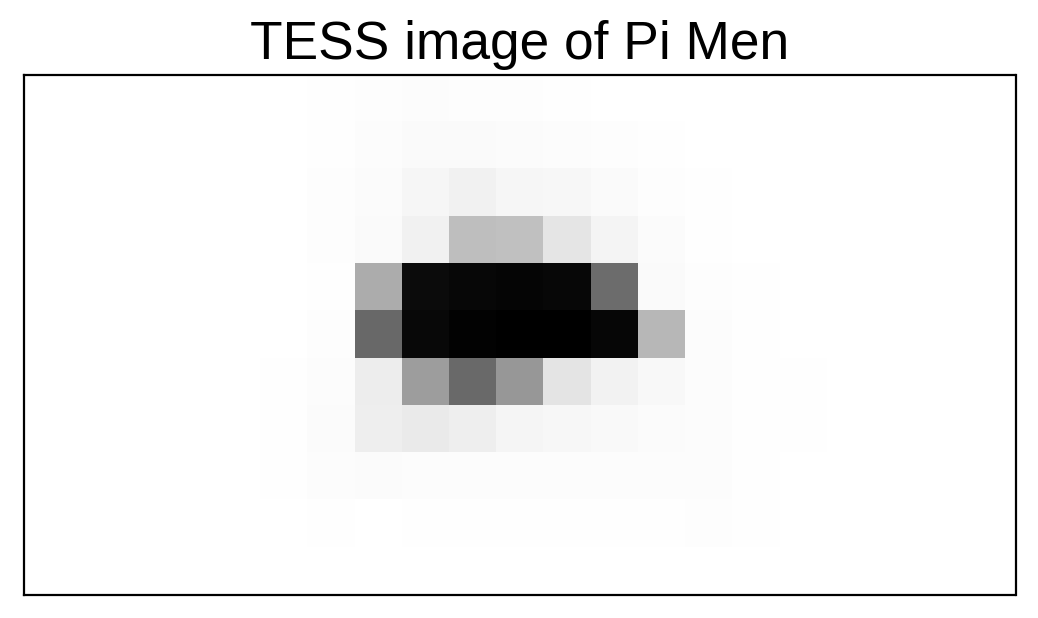

In [3]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

tpf_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0002/6113/6679/tess2018206045859-s0001-0000000261136679-0120-s_tp.fits"
with fits.open(tpf_url) as hdus:
    tpf = hdus[1].data
    tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

## Aperture selection

Next, we'll select an aperture using a hacky method that tries to minimizes the windowed scatter in the lightcurve (something like the CDPP).

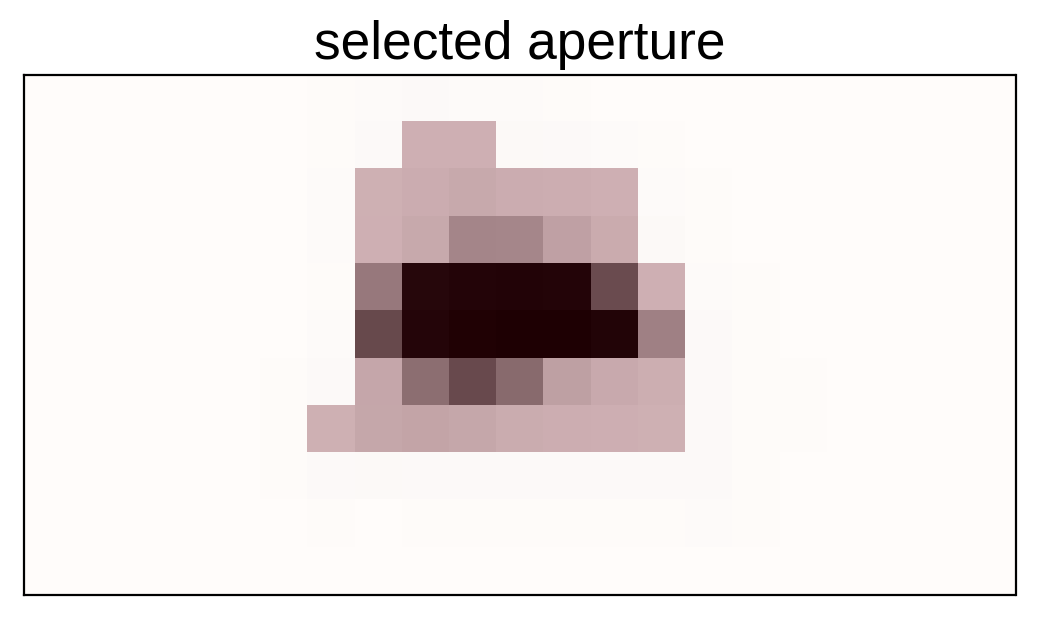

In [4]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

This aperture produces the following light curve:

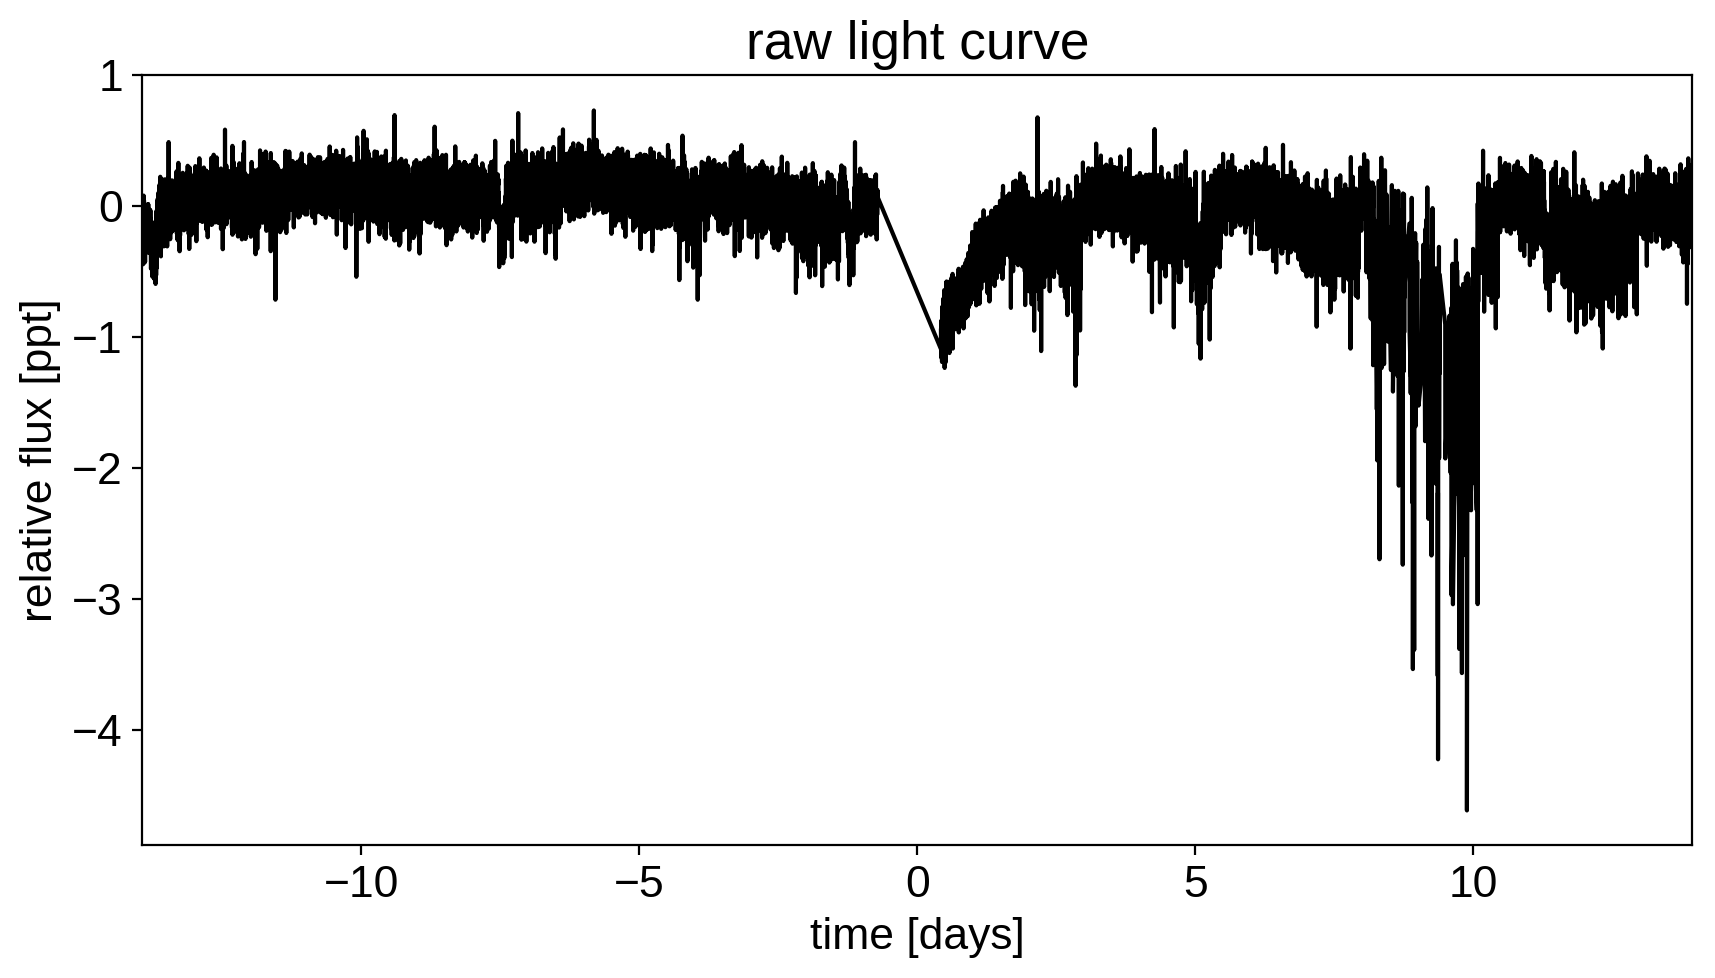

In [5]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

## De-trending

This doesn't look terrible, but we're still going to want to de-trend it a little bit.
We'll use "pixel-level deconvolution" (PLD) to de-trend following the method used by [Everest](https://github.com/rodluger/everest).
Specifically, we'll use first order PLD plus the top few PCA components of the second order PLD basis.

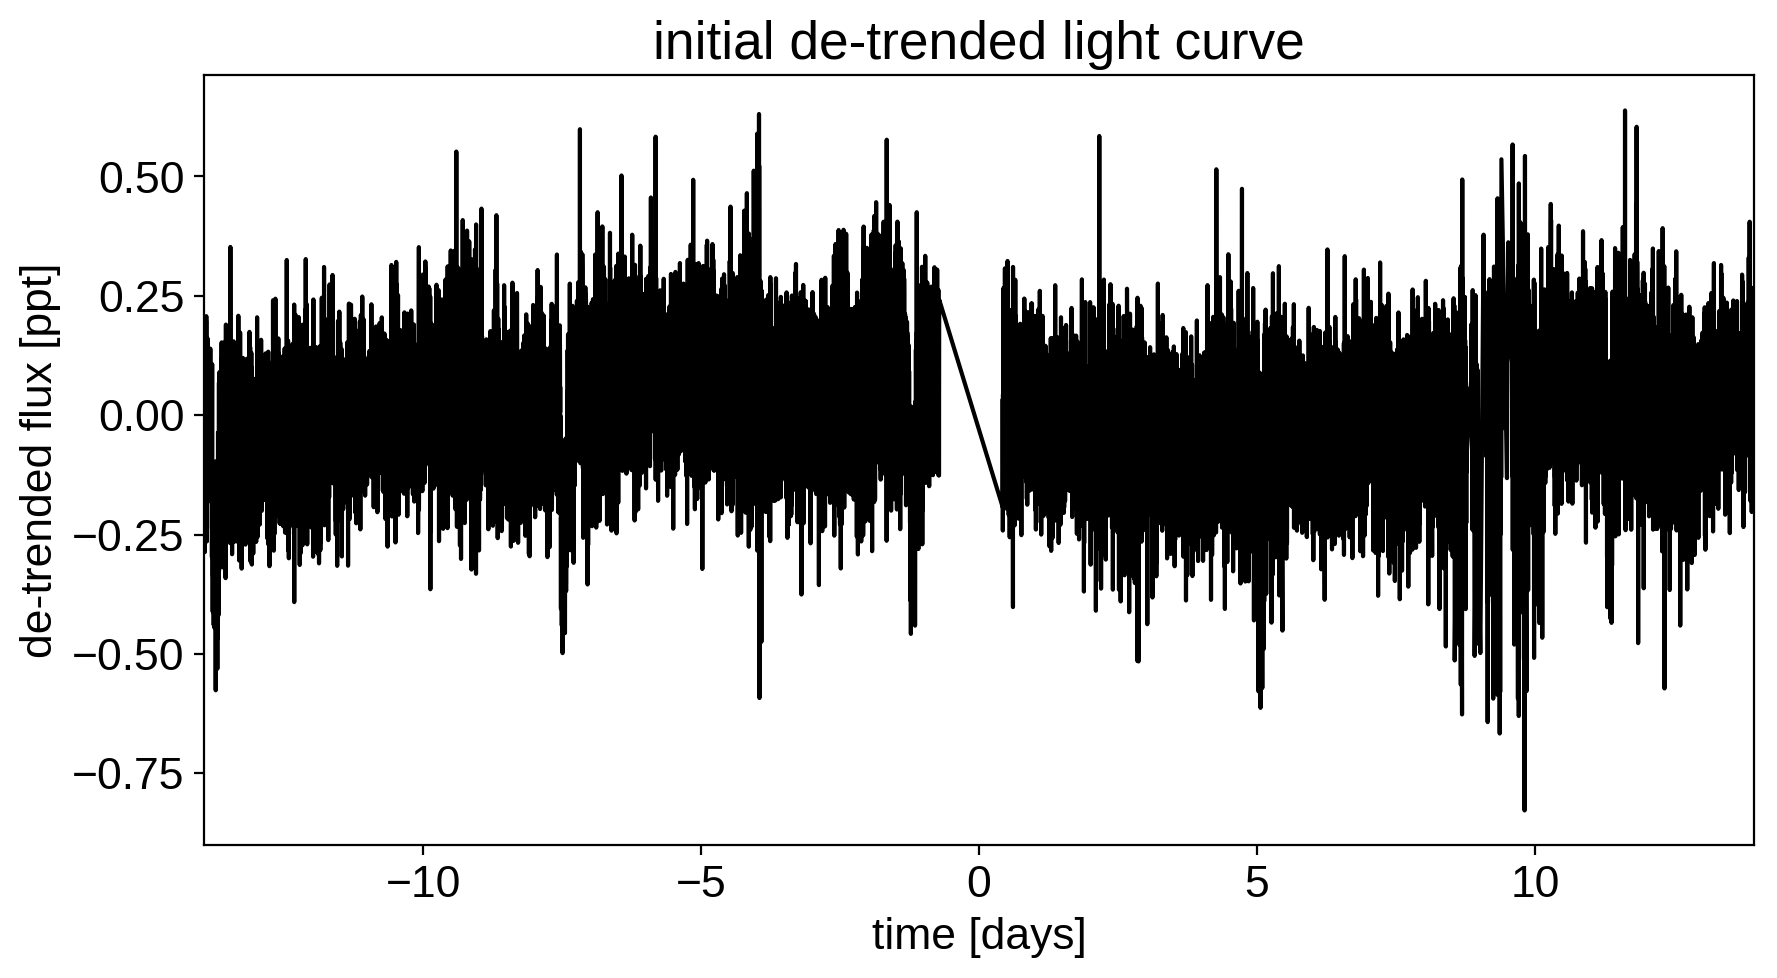

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

That looks better.

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

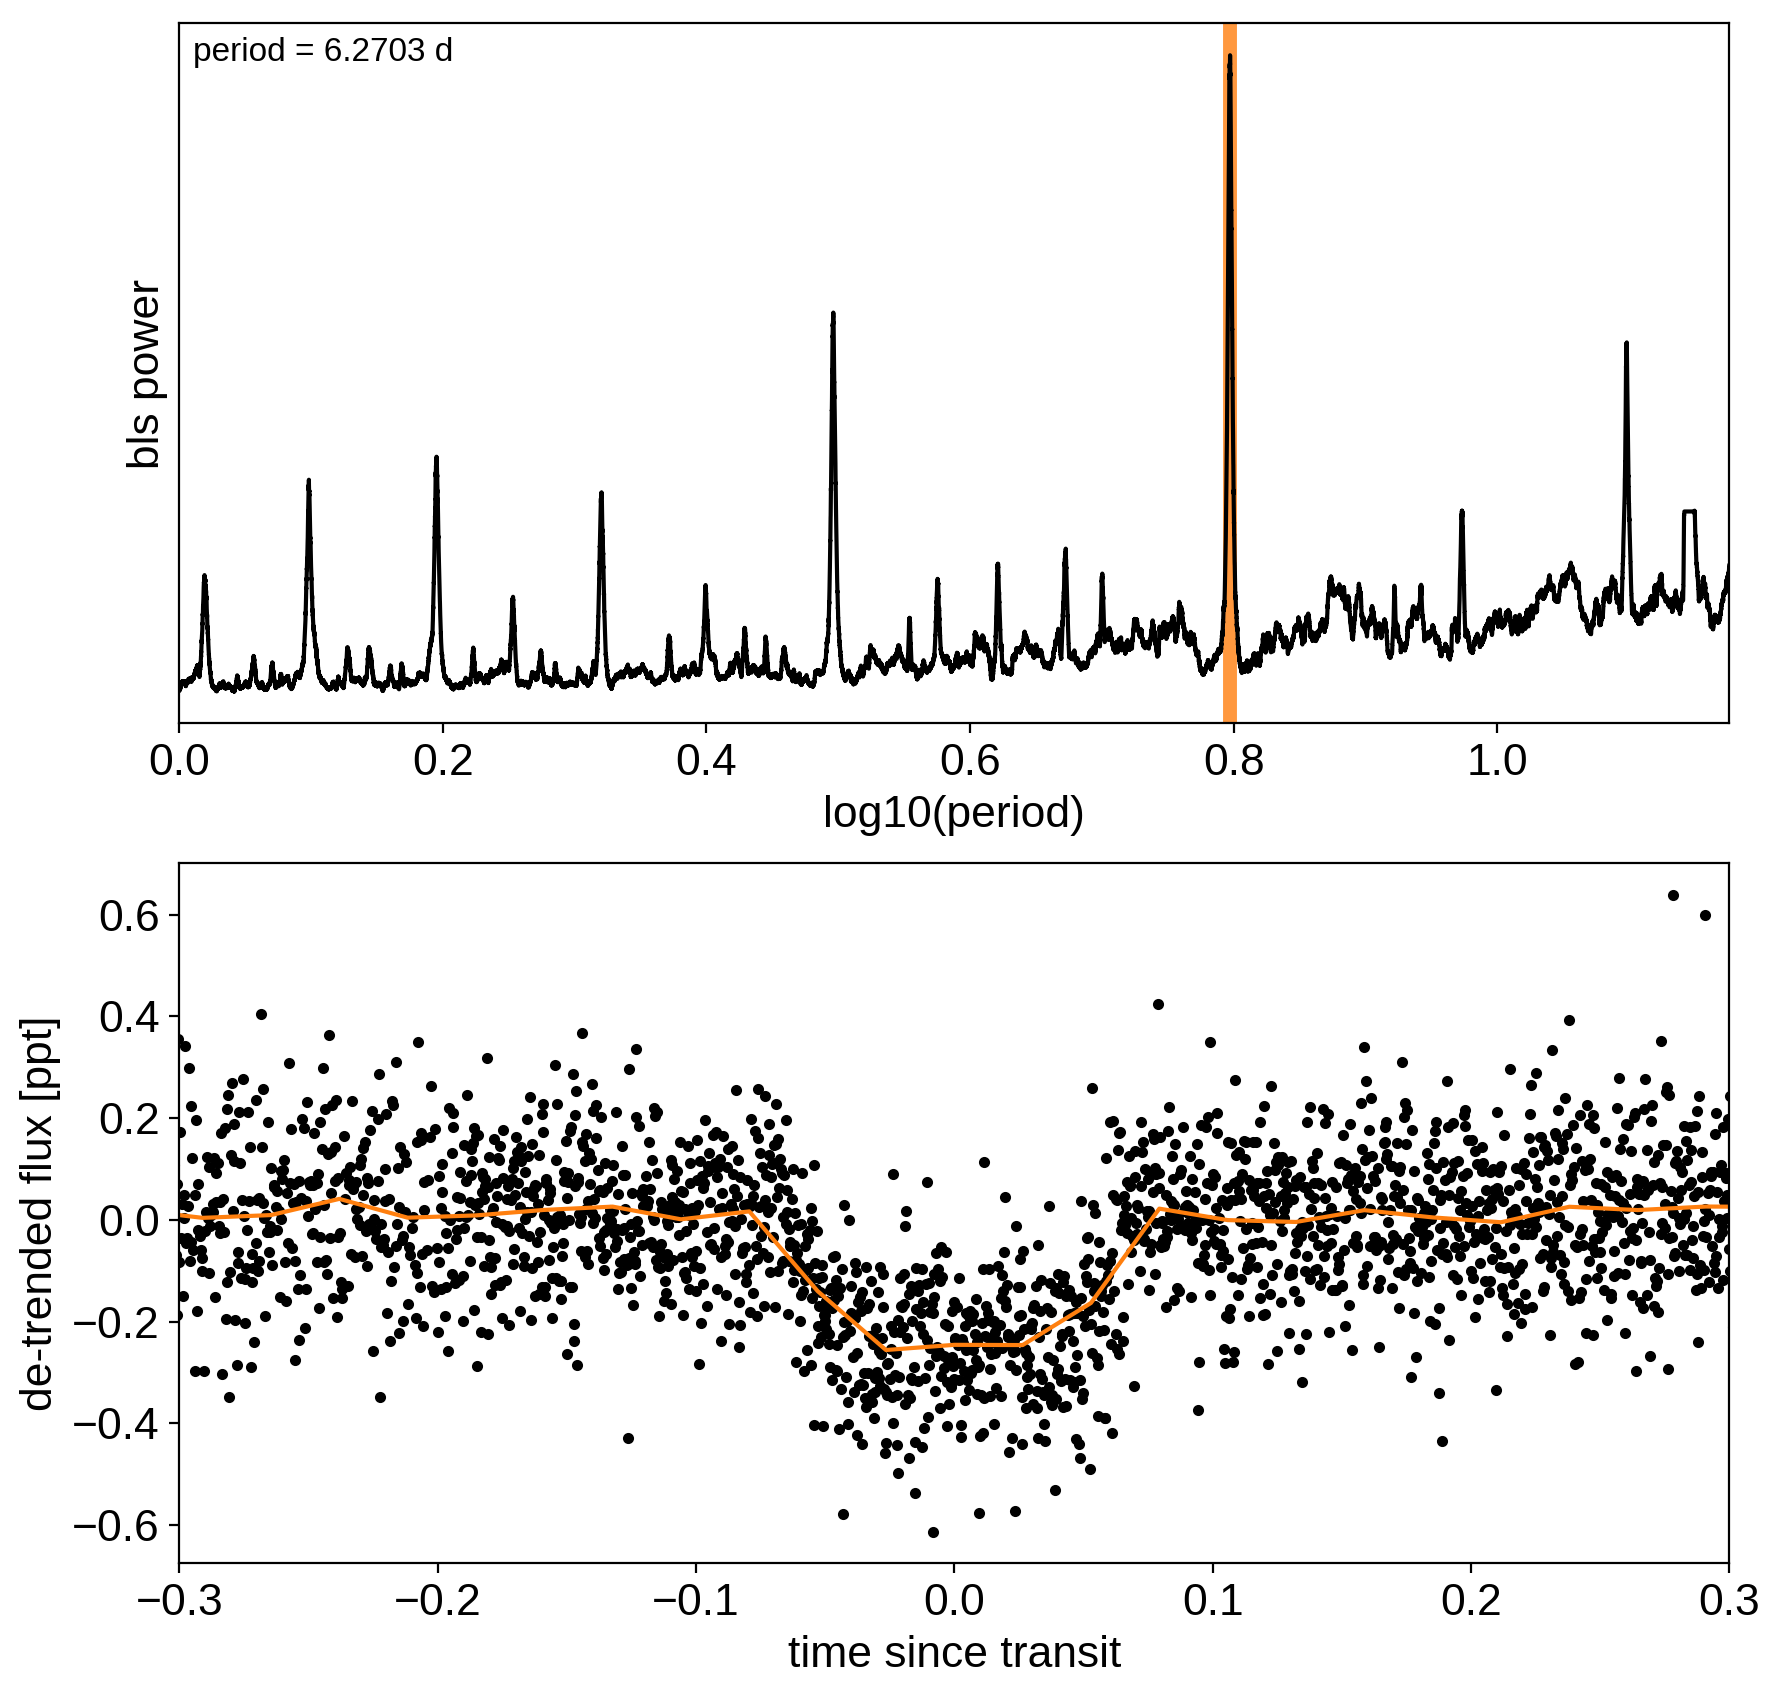

In [7]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

Now that we know where the transits are, it's generally good practice to de-trend the data one more time with the transits masked so that the de-trending doesn't overfit the transits.
Let's do that.

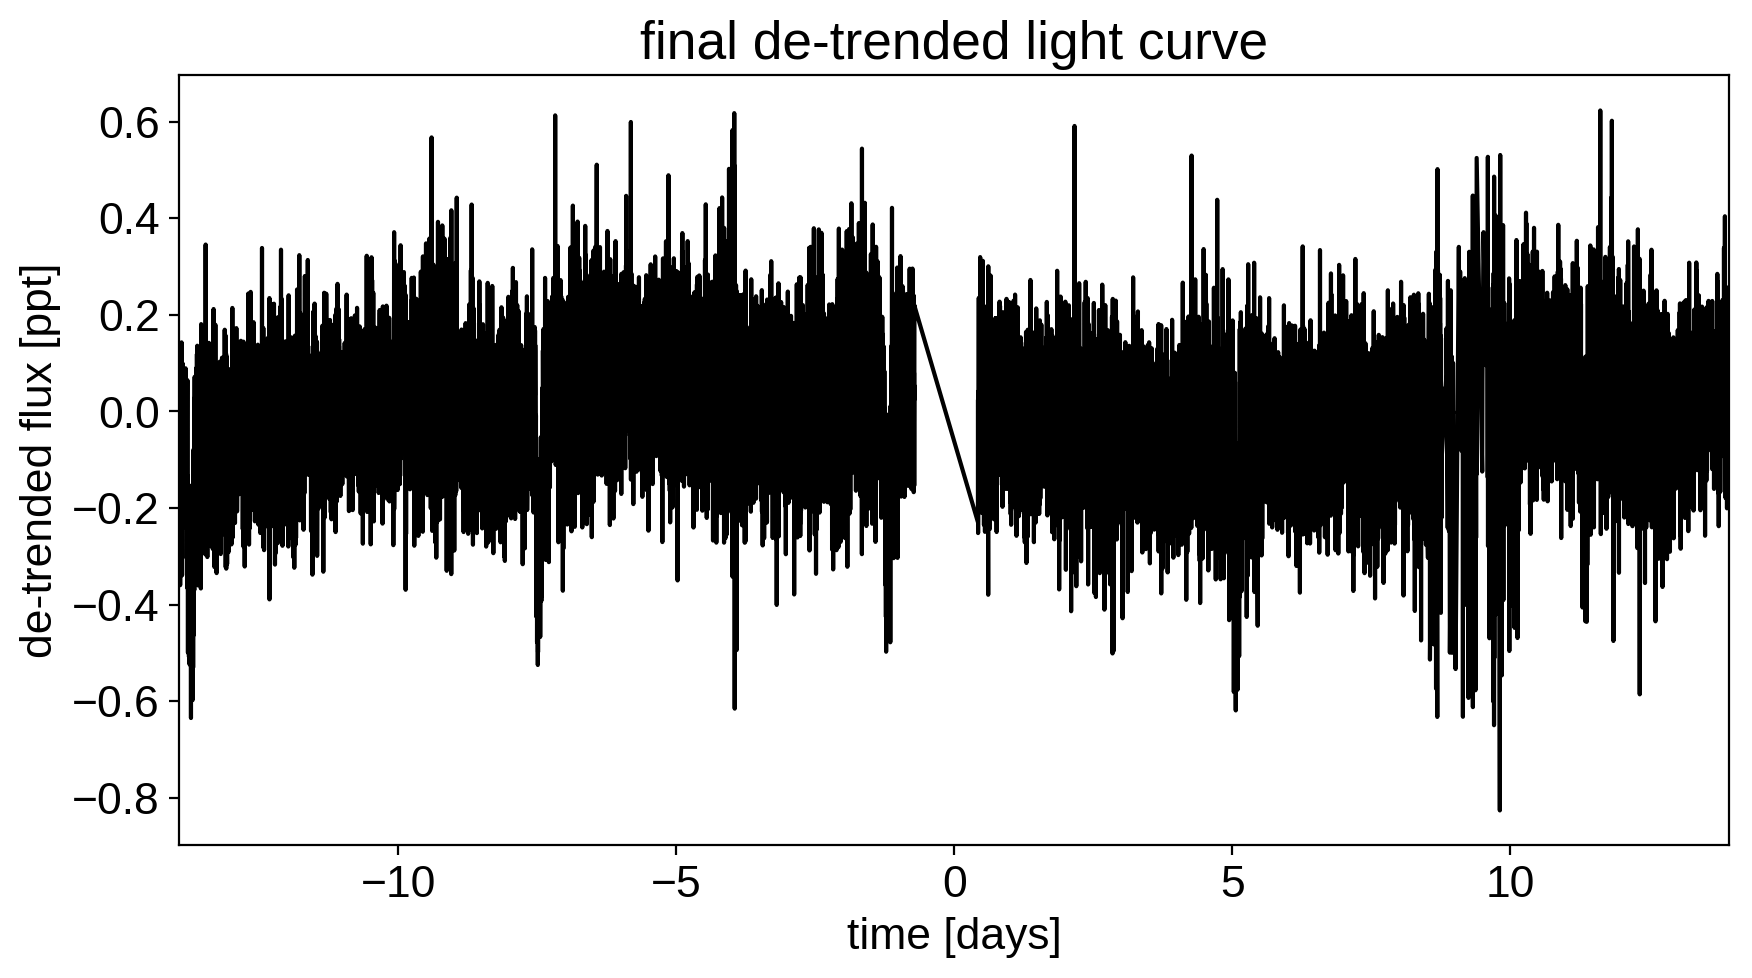

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

To confirm that we didn't overfit the transit, we can look at the folded light curve for the PLD model near trasit.
This shouldn't have any residual transit signal, and that looks correct here:

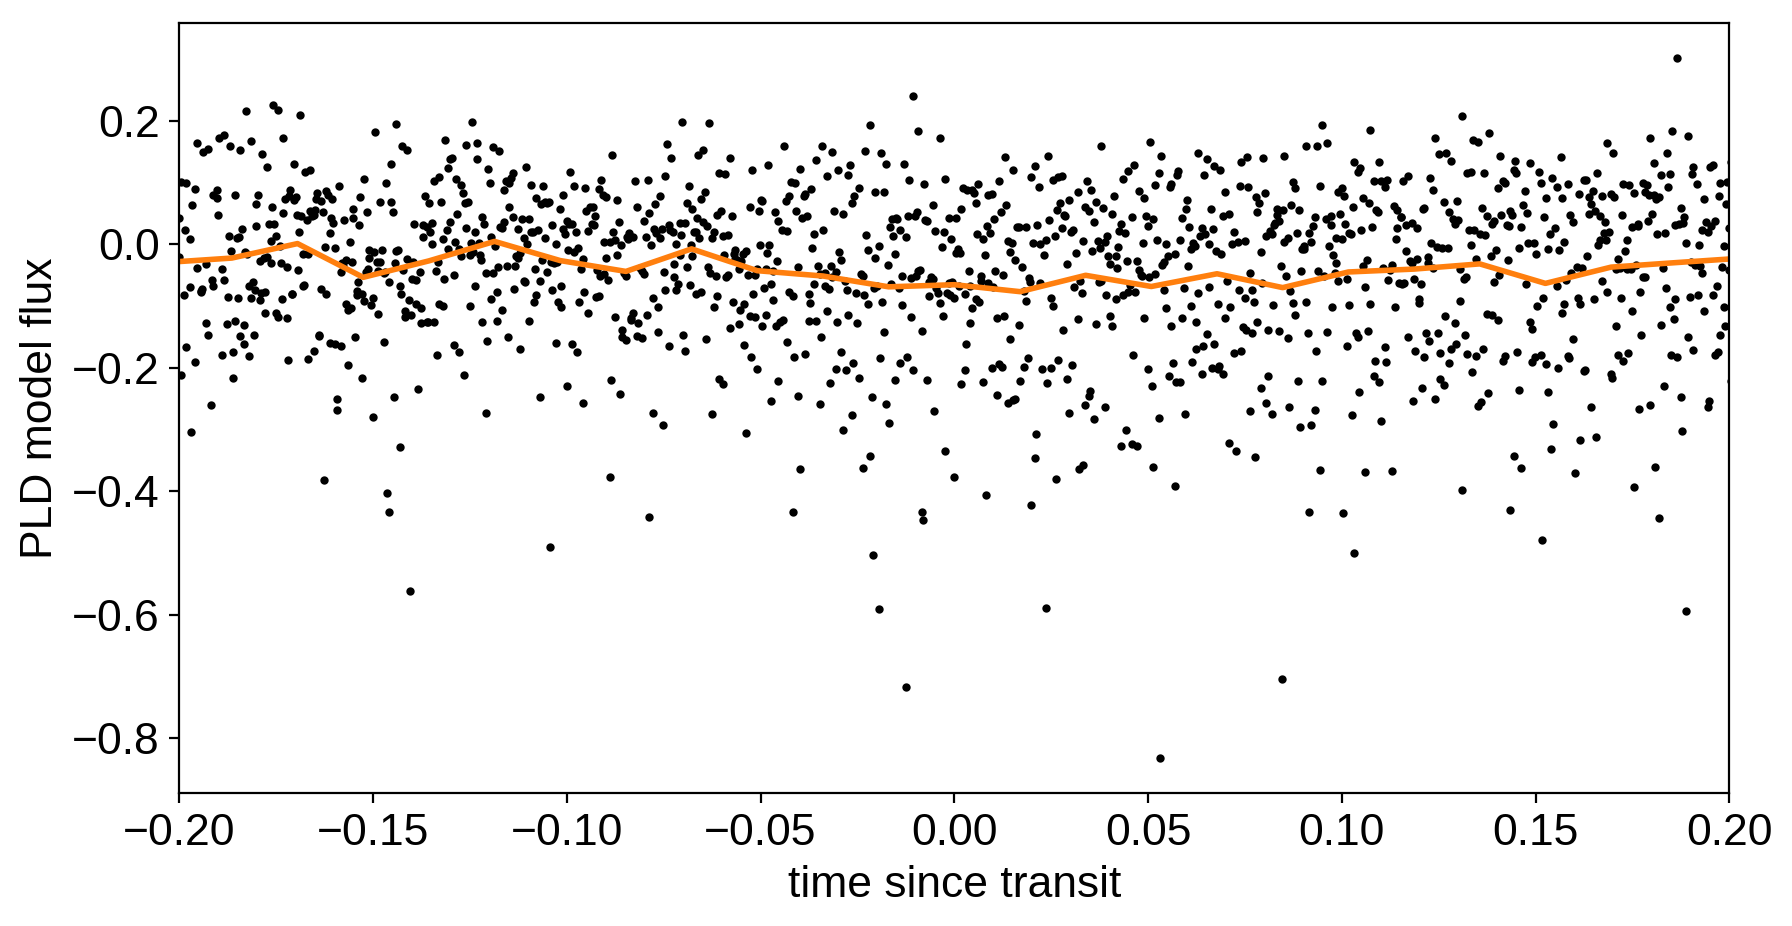

In [9]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in :ref:`together`, but we'll use a [more informative prior on eccentricity](https://arxiv.org/abs/1306.4982).

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = BoundedNormal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = xo.distributions.UnitUniform("b")
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(R_star_huang[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")
        
        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12376.808570986894 -> 12639.99697023041


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 12639.99697023041 -> 12678.437541150912


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 12678.437541150905 -> 12766.212035563016


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 12766.212035563016 -> 12775.28026595461


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 12775.2802659546 -> 12785.944976507275


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 12785.944976507275 -> 12808.533811467807


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 12808.533811467814 -> 12810.245024497966


optimizing logp for variables: ['omega_angle__', 'ecc_interval__']


message: Optimization terminated successfully.
logp: 12810.245024497966 -> 12830.745429465525


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 12830.745429465522 -> 12830.776889877343


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 12830.776889877343 -> 12841.612045223597


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_interval__', 'logr', 'b_logodds__', 't0', 'logP', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 12841.612045223583 -> 13051.73491486121


Here's how we plot the initial light curve model:

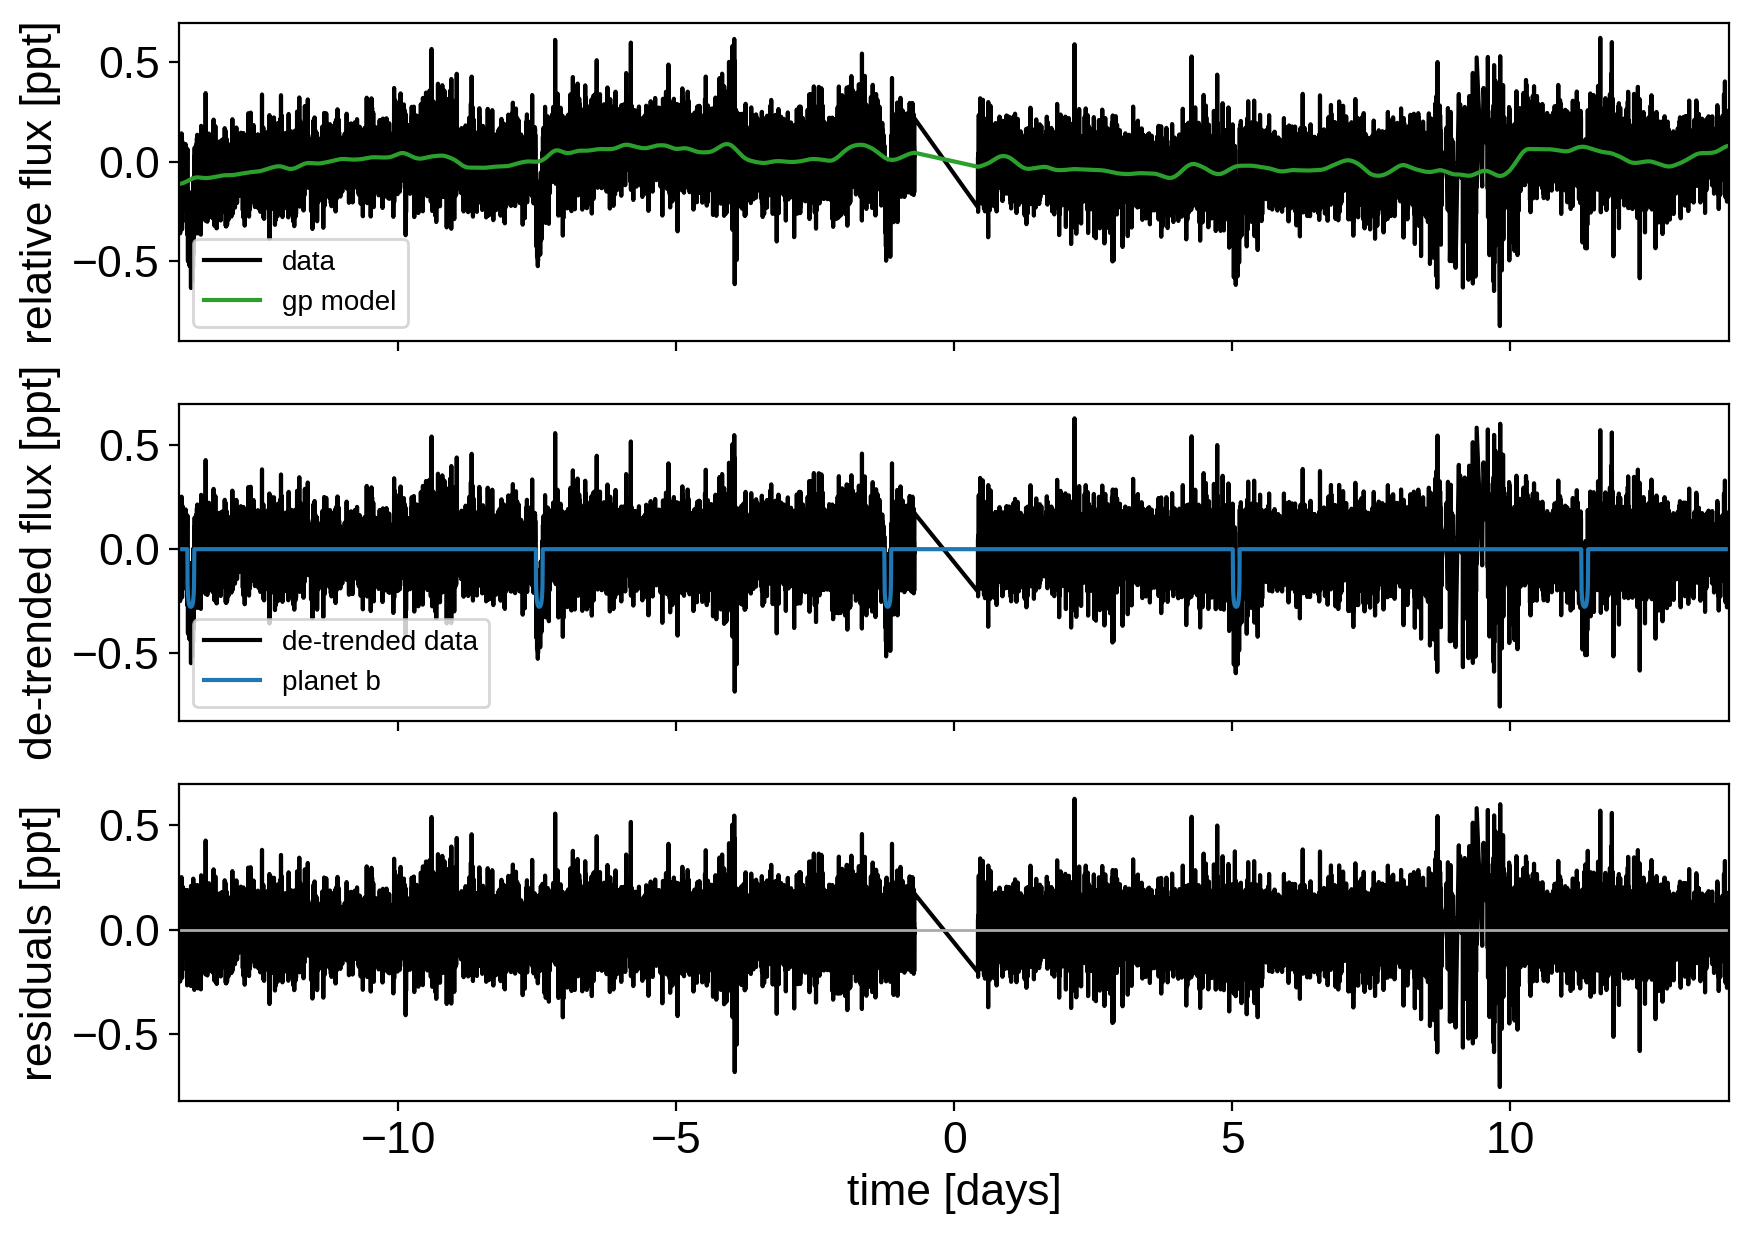

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

As in the :ref:`together` tutorial, we can do some sigma clipping to remove significant outliers.

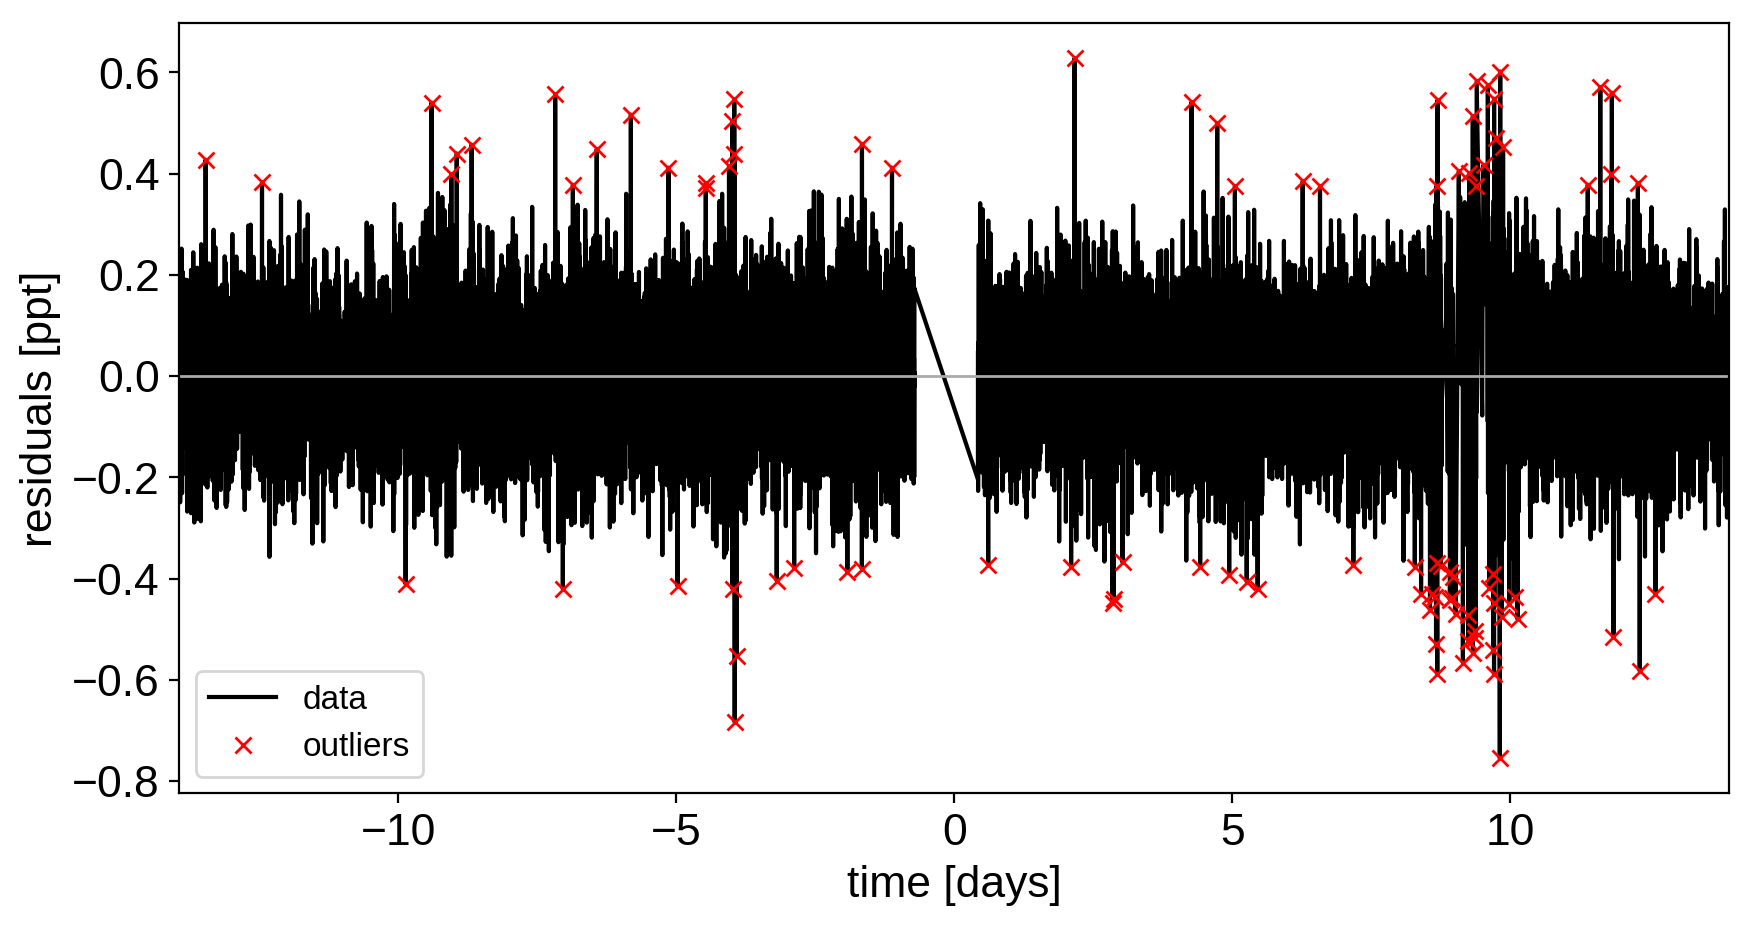

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

And then we re-build the model using the data without outliers.

optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13706.240110607976 -> 13737.199586335446


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.199586335446 -> 13737.21973823953


optimizing logp for variables: ['b_logodds__']


message: Optimization terminated successfully.
logp: 13737.219738239526 -> 13737.220611244695


optimizing logp for variables: ['t0', 'logP']


message: Optimization terminated successfully.
logp: 13737.220611244695 -> 13737.22944778266


optimizing logp for variables: ['u_star_quadlimbdark__']


message: Optimization terminated successfully.
logp: 13737.229447782656 -> 13737.253296045787


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 13737.253296045787 -> 13737.256456122668


optimizing logp for variables: ['b_logodds__']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.256456122665 -> 13737.265293068196


optimizing logp for variables: ['omega_angle__', 'ecc_interval__']


message: Optimization terminated successfully.
logp: 13737.265293068192 -> 13737.265332658291


optimizing logp for variables: ['mean']


message: Optimization terminated successfully.
logp: 13737.265332658284 -> 13737.26848380823


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 13737.26848380823 -> 13737.268486665855


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_interval__', 'logr', 'b_logodds__', 't0', 'logP', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 13737.268486665851 -> 13737.280285382387


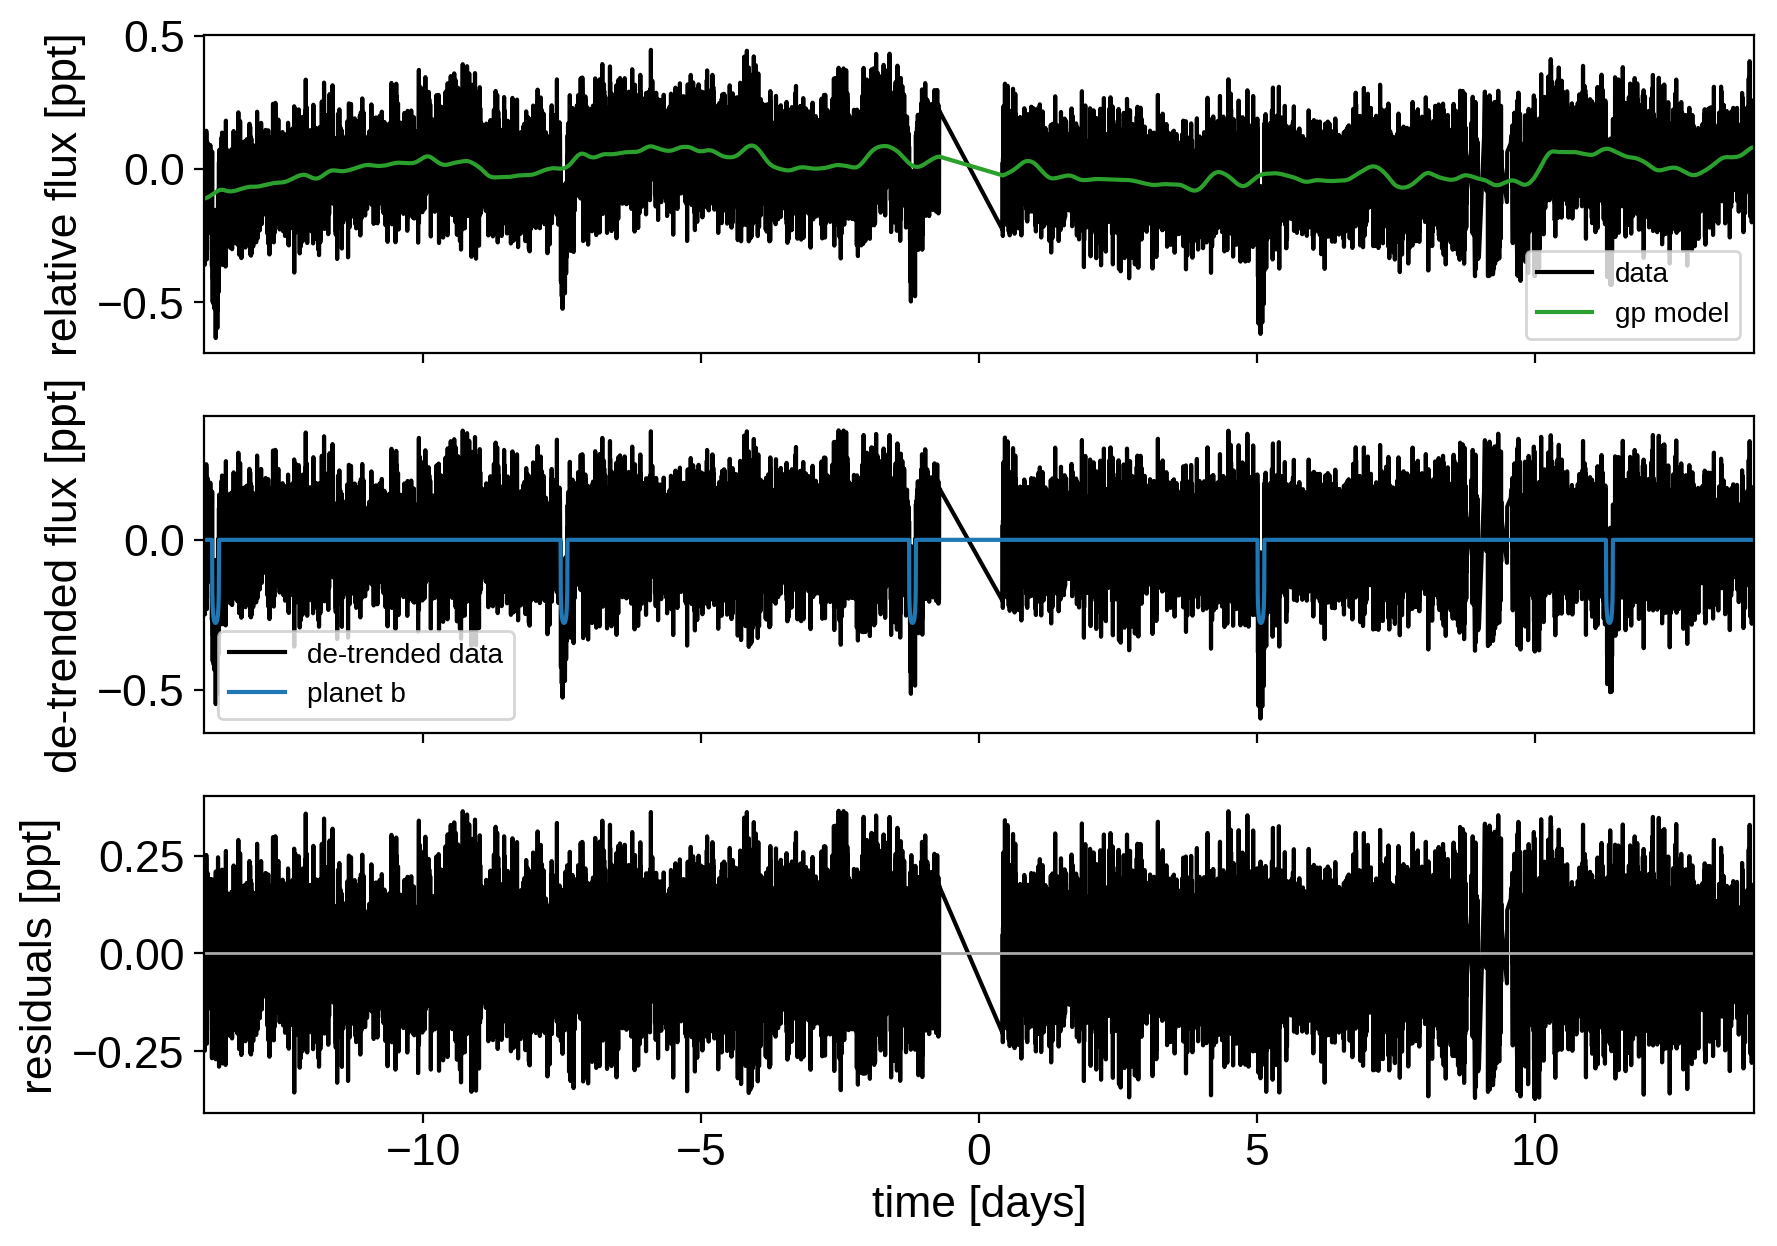

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Now that we have the model, we can sample it using a :class:`exoplanet.PyMC3Sampler`:

In [14]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<00:08, 95.69draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:02<01:10, 11.25draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:03<02:40,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:05<03:41,  3.54draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:07<04:22,  2.97draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:07<03:11,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:09<05:36,  2.30draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:09<04:10,  3.08draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:11<06:19,  2.03draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:13<06:42,  1.90draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:13<04:54,  2.60draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:15<09:49,  1.30draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:15<07:02,  1.80draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:16<08:13,  1.54draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:16<05:58,  2.11draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:17<05:10,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:18<08:08,  1.54draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:18<06:07,  2.05draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:19<05:19,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:20<08:07,  1.54draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:20<06:09,  2.02draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:21<05:20,  2.33draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:22<08:04,  1.54draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:22<06:09,  2.02draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:22<04:31,  2.74draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:23<04:48,  2.57draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:24<07:35,  1.63draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:24<05:50,  2.11draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:24<04:32,  2.71draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:24<04:50,  2.54draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:25<06:51,  1.79draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:26<05:29,  2.24draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:26<04:52,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:26<05:04,  2.41draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:27<06:56,  1.76draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:27<05:30,  2.21draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:28<04:55,  2.47draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:28<05:07,  2.37draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:29<06:56,  1.75draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:29<05:27,  2.22draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:30<04:58,  2.44draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:30<05:09,  2.35draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:31<06:53,  1.75draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:31<05:23,  2.24draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:31<04:57,  2.43draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:32<05:08,  2.34draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:33<06:51,  1.75draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:33<05:20,  2.25draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:33<04:56,  2.43draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:34<05:09,  2.32draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:35<06:47,  1.76draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:35<05:16,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:35<05:02,  2.36draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:36<05:06,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:36<05:09,  2.30draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:37<05:09,  2.30draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:37<05:28,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:38<05:28,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:38<05:21,  2.20draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:38<05:19,  2.22draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:39<05:31,  2.13draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:39<05:34,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:40<05:21,  2.19draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:40<05:17,  2.22draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:41<05:33,  2.11draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:41<05:33,  2.10draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:42<05:16,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:42<05:15,  2.22draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:43<05:32,  2.11draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:43<05:33,  2.09draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:44<05:12,  2.23draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:44<05:13,  2.22draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:45<05:30,  2.10draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:45<05:33,  2.08draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:45<05:08,  2.25draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:46<05:11,  2.22draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:46<05:29,  2.10draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:47<05:35,  2.06draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:47<05:05,  2.26draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:48<05:11,  2.21draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:48<05:29,  2.08draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:49<05:34,  2.05draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:49<05:01,  2.27draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:50<05:07,  2.23draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:50<05:28,  2.08draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:51<05:33,  2.05draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:51<04:57,  2.29draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:51<05:03,  2.24draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:52<05:27,  2.07draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:52<05:32,  2.04draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:53<04:54,  2.30draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:53<05:01,  2.25draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:54<05:25,  2.07draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:54<05:32,  2.03draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:55<04:51,  2.31draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:55<04:58,  2.25draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:56<05:25,  2.06draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:56<05:32,  2.02draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:56<04:49,  2.31draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:57<04:57,  2.24draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:58<05:22,  2.07draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:58<05:30,  2.01draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:58<04:17,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:59<06:29,  1.70draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [01:00<06:19,  1.75draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [01:00<04:50,  2.27draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [01:01<06:51,  1.60draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [01:02<06:37,  1.66draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [01:02<05:00,  2.18draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [01:03<06:59,  1.56draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [01:04<06:45,  1.61draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [01:04<05:03,  2.15draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [01:05<07:01,  1.55draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [01:06<06:50,  1.58draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [01:06<05:04,  2.13draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [01:07<07:00,  1.54draws/s]

Sampling 4 chains:  20%|██        | 162/808 [01:07<06:50,  1.57draws/s]

Sampling 4 chains:  20%|██        | 164/808 [01:08<05:03,  2.12draws/s]

Sampling 4 chains:  20%|██        | 165/808 [01:09<07:00,  1.53draws/s]

Sampling 4 chains:  21%|██        | 166/808 [01:09<06:48,  1.57draws/s]

Sampling 4 chains:  21%|██        | 168/808 [01:09<05:01,  2.12draws/s]

Sampling 4 chains:  21%|██        | 169/808 [01:10<06:58,  1.53draws/s]

Sampling 4 chains:  21%|██        | 170/808 [01:11<06:46,  1.57draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [01:11<04:54,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [01:13<08:47,  1.20draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [01:13<06:17,  1.67draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [01:14<07:27,  1.41draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [01:15<07:30,  1.40draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [01:15<05:33,  1.88draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [01:16<05:30,  1.89draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [01:17<06:03,  1.72draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [01:17<04:33,  2.28draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [01:18<04:50,  2.14draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [01:19<05:30,  1.88draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [01:19<04:10,  2.48draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [01:20<04:35,  2.24draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [01:20<05:14,  1.96draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [01:20<03:58,  2.58draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [01:22<04:29,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [01:22<05:04,  2.01draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [01:22<03:52,  2.63draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [01:23<04:26,  2.29draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [01:24<04:58,  2.04draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [01:24<03:47,  2.67draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [01:25<04:23,  2.30draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [01:26<04:51,  2.08draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [01:26<03:42,  2.71draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [01:27<03:33,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [01:27<04:06,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [01:28<04:33,  2.19draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [01:28<03:34,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [01:29<04:20,  2.29draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [01:29<04:43,  2.11draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [01:30<04:53,  2.03draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [01:30<03:47,  2.62draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [01:30<04:30,  2.20draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [01:31<04:54,  2.02draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [01:31<04:55,  2.00draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [01:32<03:47,  2.60draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [01:32<04:31,  2.17draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [01:33<04:58,  1.97draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [01:33<04:53,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [01:33<03:44,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [01:34<04:29,  2.17draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [01:35<05:00,  1.94draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [01:35<04:50,  2.01draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [01:35<03:42,  2.63draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [01:36<04:27,  2.18draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [01:37<05:02,  1.92draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [01:37<04:47,  2.02draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [01:37<03:39,  2.64draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [01:38<04:24,  2.18draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [01:38<05:05,  1.89draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [01:39<04:43,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [01:39<03:36,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [01:40<04:23,  2.17draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [01:40<05:06,  1.87draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [01:41<04:39,  2.05draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [01:41<03:23,  2.80draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [01:42<06:19,  1.50draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [01:43<05:25,  1.74draws/s]

Sampling 4 chains:  30%|███       | 243/808 [01:44<05:12,  1.81draws/s]

Sampling 4 chains:  30%|███       | 244/808 [01:44<04:35,  2.05draws/s]

Sampling 4 chains:  31%|███       | 247/808 [01:46<04:37,  2.02draws/s]

Sampling 4 chains:  31%|███       | 248/808 [01:46<04:07,  2.26draws/s]

Sampling 4 chains:  31%|███       | 251/808 [01:48<04:18,  2.15draws/s]

Sampling 4 chains:  31%|███       | 252/808 [01:48<03:51,  2.40draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [01:49<03:32,  2.60draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [01:50<04:14,  2.17draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [01:50<03:55,  2.34draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [01:51<03:57,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [01:52<04:37,  1.98draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [01:52<04:09,  2.20draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [01:53<04:02,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [01:54<04:51,  1.87draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [01:54<04:07,  2.19draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [01:55<04:01,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [01:55<04:53,  1.84draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [01:56<04:04,  2.21draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [01:57<03:58,  2.26draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [01:57<04:54,  1.82draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [01:58<03:59,  2.23draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [01:58<03:54,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [01:59<04:54,  1.81draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [01:59<03:55,  2.25draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [02:00<03:51,  2.29draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [02:01<04:53,  1.80draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [02:01<03:51,  2.28draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [02:02<03:49,  2.29draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [02:03<04:53,  1.79draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [02:03<03:47,  2.30draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [02:04<03:45,  2.31draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [02:05<04:52,  1.78draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [02:05<03:43,  2.32draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [02:06<03:42,  2.32draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [02:07<04:54,  1.75draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [02:07<03:45,  2.28draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [02:08<03:42,  2.30draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [02:09<04:54,  1.74draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [02:09<03:46,  2.26draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [02:10<03:41,  2.30draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [02:10<04:55,  1.72draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [02:11<03:50,  2.20draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [02:11<03:39,  2.30draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [02:12<04:55,  1.70draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [02:12<03:48,  2.20draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [02:13<03:36,  2.31draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [02:13<03:09,  2.65draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [02:14<04:18,  1.93draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [02:15<03:58,  2.09draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [02:15<03:40,  2.24draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [02:16<04:23,  1.88draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [02:17<04:01,  2.04draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [02:17<04:02,  2.03draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [02:18<04:17,  1.91draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [02:19<03:55,  2.08draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [02:19<03:59,  2.04draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [02:20<04:12,  1.93draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [02:21<03:51,  2.09draws/s]

Sampling 4 chains:  40%|████      | 324/808 [02:21<04:02,  1.99draws/s]

Sampling 4 chains:  40%|████      | 325/808 [02:22<04:06,  1.96draws/s]

Sampling 4 chains:  40%|████      | 327/808 [02:23<03:47,  2.12draws/s]

Sampling 4 chains:  41%|████      | 328/808 [02:23<04:01,  1.99draws/s]

Sampling 4 chains:  41%|████      | 329/808 [02:24<04:02,  1.97draws/s]

Sampling 4 chains:  41%|████      | 330/808 [02:24<03:04,  2.59draws/s]

Sampling 4 chains:  41%|████      | 331/808 [02:24<03:43,  2.13draws/s]

Sampling 4 chains:  41%|████      | 332/808 [02:25<04:00,  1.98draws/s]

Sampling 4 chains:  41%|████      | 333/808 [02:25<03:58,  1.99draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [02:26<03:02,  2.60draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [02:26<03:40,  2.14draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [02:27<04:00,  1.96draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [02:27<03:55,  2.00draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [02:27<03:01,  2.60draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [02:28<03:38,  2.15draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [02:29<03:59,  1.95draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [02:29<03:22,  2.31draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [02:29<02:51,  2.71draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [02:29<02:16,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [02:31<04:34,  1.69draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [02:31<03:44,  2.06draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [02:31<03:06,  2.47draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [02:31<02:27,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [02:32<04:41,  1.64draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [02:33<03:48,  2.01draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [02:33<03:09,  2.42draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [02:33<02:28,  3.07draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [02:34<04:41,  1.62draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [02:35<03:47,  2.00draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [02:35<03:08,  2.41draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [02:35<02:28,  3.05draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [02:36<04:44,  1.59draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [02:36<03:43,  2.02draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [02:37<03:05,  2.42draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [02:37<02:26,  3.07draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [02:38<04:42,  1.58draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [02:38<03:40,  2.03draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [02:38<03:03,  2.43draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [02:39<02:26,  3.04draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [02:40<04:41,  1.58draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [02:40<03:37,  2.04draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [02:40<03:00,  2.45draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [02:40<02:24,  3.06draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [02:42<04:39,  1.58draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [02:42<03:34,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [02:42<02:58,  2.45draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [02:42<02:23,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [02:44<04:36,  1.58draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [02:44<03:32,  2.05draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [02:44<02:56,  2.46draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [02:44<02:22,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [02:45<03:11,  2.26draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [02:46<03:54,  1.84draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [02:46<03:12,  2.24draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [02:46<02:33,  2.80draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [02:47<03:18,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [02:48<03:59,  1.78draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [02:48<03:14,  2.19draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [02:48<02:34,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [02:49<03:18,  2.13draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [02:49<03:57,  1.78draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [02:50<03:12,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [02:50<02:34,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [02:51<03:17,  2.13draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [02:51<03:55,  1.78draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [02:51<03:11,  2.19draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [02:52<02:33,  2.72draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [02:52<03:16,  2.12draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [02:53<03:53,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [02:53<03:08,  2.19draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [02:54<02:32,  2.71draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [02:54<03:14,  2.12draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [02:55<03:50,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [02:55<03:06,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [02:55<02:31,  2.70draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [02:56<03:13,  2.11draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [02:57<03:47,  1.79draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [02:57<03:04,  2.20draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [02:57<02:30,  2.69draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [02:58<03:11,  2.11draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [02:59<03:45,  1.79draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [02:59<03:02,  2.20draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [02:59<02:29,  2.69draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [03:00<03:09,  2.11draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [03:01<03:42,  1.79draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [03:01<03:01,  2.19draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [03:01<02:28,  2.68draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [03:02<03:08,  2.10draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [03:02<03:39,  1.80draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [03:03<02:59,  2.19draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [03:03<02:26,  2.67draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [03:04<03:06,  2.10draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [03:04<03:36,  1.81draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [03:05<02:58,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [03:05<02:25,  2.67draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [03:05<03:05,  2.09draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [03:06<03:33,  1.82draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [03:06<02:56,  2.19draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [03:07<02:24,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [03:07<03:04,  2.08draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [03:08<03:29,  1.83draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [03:08<02:54,  2.19draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [03:08<02:23,  2.65draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [03:09<02:49,  2.24draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [03:09<02:13,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [03:10<03:18,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [03:10<02:41,  2.33draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [03:11<02:59,  2.10draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [03:11<02:21,  2.65draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [03:12<03:22,  1.85draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [03:12<02:45,  2.26draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [03:13<02:59,  2.08draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [03:13<02:22,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [03:14<03:21,  1.84draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [03:14<02:44,  2.24draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [03:15<02:56,  2.08draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [03:15<02:21,  2.59draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [03:16<03:19,  1.83draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [03:16<02:43,  2.23draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [03:16<02:54,  2.09draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [03:17<02:20,  2.58draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [03:18<03:18,  1.83draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [03:18<02:41,  2.23draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [03:18<02:52,  2.08draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [03:18<02:19,  2.58draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [03:19<03:15,  1.83draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [03:20<02:39,  2.23draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [03:20<02:50,  2.09draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [03:20<02:18,  2.57draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [03:21<03:13,  1.83draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [03:21<02:38,  2.23draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [03:22<02:47,  2.10draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [03:22<02:16,  2.57draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [03:22<01:46,  3.29draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [03:23<03:02,  1.92draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [03:24<03:03,  1.90draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [03:24<02:28,  2.33draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [03:25<02:42,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [03:26<02:46,  2.06draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [03:26<02:17,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [03:27<02:33,  2.22draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [03:28<02:39,  2.14draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [03:28<02:13,  2.54draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [03:28<01:43,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [03:29<02:56,  1.91draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [03:29<02:53,  1.94draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [03:30<02:23,  2.33draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [03:30<01:51,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [03:31<03:00,  1.85draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [03:31<02:54,  1.90draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [03:32<02:25,  2.28draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [03:32<01:51,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [03:33<02:59,  1.83draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [03:33<02:53,  1.89draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [03:33<02:24,  2.26draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [03:33<01:51,  2.92draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [03:35<02:57,  1.83draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [03:35<02:50,  1.90draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [03:35<02:23,  2.26draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [03:35<01:50,  2.92draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [03:36<02:01,  2.65draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [03:36<02:19,  2.30draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [03:37<02:46,  1.91draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [03:37<02:06,  2.52draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [03:38<02:11,  2.41draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [03:38<02:26,  2.16draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [03:39<02:15,  2.33draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [03:39<01:49,  2.88draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [03:39<01:37,  3.23draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [03:40<01:59,  2.61draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [03:40<02:50,  1.83draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [03:41<02:12,  2.33draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [03:41<01:53,  2.72draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [03:41<02:09,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [03:42<02:56,  1.74draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [03:42<02:17,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [03:43<01:56,  2.61draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [03:43<02:10,  2.33draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [03:44<02:30,  2.01draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [03:44<02:11,  2.30draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [03:44<01:44,  2.88draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [03:45<02:21,  2.11draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [03:46<02:38,  1.89draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [03:46<02:16,  2.18draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [03:46<01:47,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [03:47<02:22,  2.07draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [03:48<02:38,  1.86draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [03:48<02:16,  2.15draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [03:48<01:47,  2.74draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [03:49<02:21,  2.07draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [03:49<02:37,  1.85draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [03:50<02:15,  2.15draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [03:50<01:45,  2.74draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [03:51<02:18,  2.07draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [03:51<02:35,  1.84draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [03:52<02:13,  2.14draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [03:52<01:44,  2.74draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [03:52<02:16,  2.08draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [03:53<02:33,  1.84draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [03:53<02:11,  2.14draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [03:54<01:42,  2.75draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [03:54<02:14,  2.08draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [03:55<02:17,  2.03draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [03:55<01:51,  2.50draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [03:55<01:29,  3.09draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [03:57<02:56,  1.56draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [03:57<02:18,  1.97draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [03:57<01:48,  2.52draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [03:59<03:07,  1.45draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [03:59<02:26,  1.84draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [03:59<01:53,  2.36draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [04:00<03:08,  1.41draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [04:01<02:27,  1.80draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [04:01<01:53,  2.32draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [04:02<03:07,  1.40draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [04:02<02:27,  1.78draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [04:03<01:53,  2.30draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [04:04<03:05,  1.40draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [04:04<02:25,  1.78draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [04:05<01:51,  2.29draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [04:06<03:02,  1.40draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [04:06<02:22,  1.78draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [04:06<01:49,  2.30draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [04:08<02:59,  1.40draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [04:08<02:20,  1.78draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [04:08<01:48,  2.30draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [04:10<02:57,  1.39draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [04:10<02:18,  1.78draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [04:10<01:46,  2.29draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [04:11<02:17,  1.76draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [04:12<02:11,  1.84draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [04:12<01:51,  2.17draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [04:12<01:33,  2.56draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [04:13<02:07,  1.87draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [04:13<02:04,  1.92draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [04:14<01:46,  2.23draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [04:14<01:29,  2.64draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [04:15<02:03,  1.91draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [04:15<02:00,  1.94draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [04:16<01:44,  2.24draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [04:16<01:27,  2.67draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [04:17<02:00,  1.92draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [04:17<01:57,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [04:17<01:42,  2.23draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [04:18<01:25,  2.67draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [04:18<01:58,  1.91draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [04:19<01:56,  1.95draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [04:19<01:41,  2.23draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [04:19<01:23,  2.69draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [04:20<01:56,  1.92draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [04:21<01:54,  1.94draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [04:21<01:39,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [04:21<01:21,  2.70draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [04:22<01:53,  1.93draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [04:23<01:52,  1.94draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [04:23<01:38,  2.21draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [04:23<01:19,  2.71draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [04:24<01:50,  1.94draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [04:25<01:50,  1.94draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [04:25<01:37,  2.20draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [04:25<01:18,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [04:26<01:48,  1.95draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [04:26<01:48,  1.94draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [04:27<01:35,  2.19draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [04:27<01:16,  2.72draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [04:28<01:45,  1.95draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [04:28<01:46,  1.93draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [04:29<01:34,  2.18draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [04:29<01:14,  2.73draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [04:30<01:43,  1.96draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [04:30<01:44,  1.93draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [04:30<01:32,  2.17draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [04:31<01:13,  2.74draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [04:31<01:41,  1.97draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [04:32<01:42,  1.93draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [04:32<01:31,  2.16draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [04:32<01:11,  2.75draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [04:33<01:39,  1.97draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [04:34<01:41,  1.92draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [04:34<01:29,  2.15draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [04:34<01:09,  2.77draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [04:35<01:36,  1.97draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [04:36<01:38,  1.92draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [04:36<01:28,  2.14draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [04:36<01:07,  2.78draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [04:37<01:34,  1.97draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [04:38<01:36,  1.92draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [04:38<01:26,  2.13draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [04:38<01:06,  2.78draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [04:39<01:32,  1.98draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [04:39<01:34,  1.92draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [04:40<01:26,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [04:41<01:24,  2.11draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [04:41<01:28,  2.02draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [04:42<01:21,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [04:43<01:20,  2.17draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [04:43<01:24,  2.05draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [04:43<01:18,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [04:44<01:18,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [04:45<01:22,  2.06draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [04:45<01:17,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [04:46<01:16,  2.19draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [04:47<01:20,  2.06draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [04:47<01:15,  2.18draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [04:48<01:14,  2.18draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [04:48<01:03,  2.54draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [04:49<00:59,  2.72draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [04:49<01:00,  2.64draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [04:50<01:25,  1.87draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [04:50<01:10,  2.24draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [04:51<01:03,  2.47draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [04:51<01:03,  2.45draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [04:52<01:25,  1.81draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [04:52<01:10,  2.17draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [04:52<01:03,  2.42draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [04:53<01:03,  2.40draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [04:54<01:23,  1.80draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [04:54<01:09,  2.16draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [04:54<01:01,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [04:55<01:02,  2.36draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [04:56<01:21,  1.80draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [04:56<01:07,  2.15draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [04:56<01:00,  2.42draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [04:57<01:01,  2.35draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [04:57<01:19,  1.81draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [04:58<01:05,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [04:58<00:58,  2.42draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [04:58<01:00,  2.33draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [04:59<01:03,  2.16draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [05:00<00:56,  2.41draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [05:00<00:58,  2.31draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [05:01<01:02,  2.16draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [05:02<00:55,  2.39draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [05:02<00:57,  2.28draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [05:03<00:55,  2.32draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [05:03<00:47,  2.70draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [05:04<01:04,  1.99draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [05:05<00:59,  2.11draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [05:05<00:49,  2.51draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [05:06<01:05,  1.91draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [05:07<00:59,  2.04draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [05:07<00:49,  2.45draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [05:08<01:04,  1.87draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [05:09<00:58,  2.02draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [05:09<00:48,  2.42draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [05:10<01:02,  1.86draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [05:10<00:56,  2.01draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [05:11<00:46,  2.41draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [05:11<01:00,  1.84draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [05:12<00:54,  2.01draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [05:12<00:45,  2.41draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [05:13<00:58,  1.83draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [05:14<00:52,  2.00draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [05:14<00:43,  2.41draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [05:15<00:57,  1.82draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [05:16<00:51,  2.00draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [05:16<00:41,  2.42draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [05:17<00:55,  1.82draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [05:18<00:49,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [05:18<00:40,  2.42draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [05:19<00:52,  1.81draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [05:20<00:47,  1.99draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [05:20<00:38,  2.44draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [05:21<00:50,  1.81draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [05:22<00:45,  1.99draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [05:22<00:36,  2.44draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [05:23<00:48,  1.81draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [05:23<00:43,  1.99draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [05:24<00:34,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [05:24<00:46,  1.81draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [05:25<00:41,  1.99draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [05:25<00:33,  2.42draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [05:26<00:44,  1.81draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [05:27<00:39,  1.99draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [05:27<00:31,  2.42draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [05:28<00:41,  1.81draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [05:29<00:37,  1.99draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [05:29<00:30,  2.43draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [05:30<00:34,  2.09draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [05:30<00:29,  2.45draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [05:30<00:24,  2.81draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [05:31<00:23,  2.92draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [05:32<00:32,  2.04draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [05:32<00:28,  2.34draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [05:32<00:27,  2.34draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [05:33<00:25,  2.54draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [05:33<00:32,  1.91draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [05:34<00:28,  2.20draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [05:34<00:27,  2.23draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [05:35<00:24,  2.45draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [05:35<00:31,  1.89draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [05:36<00:26,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [05:36<00:25,  2.22draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [05:36<00:23,  2.43draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [05:37<00:29,  1.88draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [05:37<00:24,  2.17draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [05:38<00:23,  2.22draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [05:38<00:21,  2.42draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [05:39<00:27,  1.88draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [05:39<00:23,  2.16draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [05:40<00:22,  2.22draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [05:40<00:19,  2.41draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [05:41<00:25,  1.88draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [05:41<00:21,  2.15draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [05:42<00:20,  2.23draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [05:42<00:18,  2.41draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [05:43<00:22,  1.88draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [05:43<00:19,  2.15draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [05:43<00:18,  2.24draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [05:44<00:16,  2.41draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [05:45<00:20,  1.89draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [05:45<00:17,  2.14draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [05:45<00:16,  2.25draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [05:46<00:14,  2.41draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [05:46<00:18,  1.89draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [05:47<00:15,  2.13draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [05:47<00:14,  2.26draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [05:48<00:13,  2.41draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [05:48<00:16,  1.89draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [05:49<00:14,  2.11draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [05:49<00:12,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [05:49<00:11,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [05:50<00:14,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [05:51<00:12,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [05:51<00:10,  2.27draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [05:51<00:10,  2.39draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [05:52<00:12,  1.90draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [05:52<00:10,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [05:53<00:09,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [05:53<00:08,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [05:54<00:09,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [05:54<00:08,  2.10draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [05:55<00:07,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [05:55<00:06,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [05:56<00:07,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [05:56<00:06,  2.09draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [05:57<00:07,  1.82draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [05:58<00:08,  1.37draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [05:59<00:07,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [06:00<00:08,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [06:01<00:07,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [06:02<00:07,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [06:02<00:05,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [06:03<00:05,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [06:08<00:10,  2.03s/draws]

Sampling 4 chains: 100%|█████████▉| 804/808 [06:09<00:07,  1.78s/draws]

Sampling 4 chains: 100%|█████████▉| 805/808 [06:09<00:04,  1.34s/draws]

Sampling 4 chains: 100%|█████████▉| 806/808 [06:11<00:02,  1.29s/draws]

Sampling 4 chains: 100%|█████████▉| 807/808 [06:15<00:02,  2.30s/draws]

Sampling 4 chains: 100%|██████████| 808/808 [06:17<00:00,  1.99s/draws]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 11/408 [00:00<00:03, 105.35draws/s]

Sampling 4 chains:   4%|▍         | 18/408 [00:00<00:04, 83.84draws/s] 

Sampling 4 chains:   5%|▌         | 22/408 [00:02<00:58,  6.65draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:03<01:51,  3.43draws/s]

Sampling 4 chains:   7%|▋         | 28/408 [00:04<01:23,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:05<02:36,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 32/408 [00:06<01:57,  3.19draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:07<02:58,  2.10draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:07<02:13,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:09<03:06,  1.98draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:09<02:20,  2.62draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:11<04:40,  1.31draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:11<03:23,  1.79draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:12<02:46,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:13<04:04,  1.47draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:13<03:14,  1.85draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:13<02:25,  2.46draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:14<02:12,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:15<04:02,  1.47draws/s]

Sampling 4 chains:  13%|█▎        | 54/408 [00:15<02:57,  1.99draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:15<02:35,  2.27draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:17<04:17,  1.37draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:17<03:07,  1.86draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:17<02:41,  2.16draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:18<03:37,  1.60draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:19<03:18,  1.75draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:19<02:30,  2.29draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:19<02:09,  2.67draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:20<02:25,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:21<02:38,  2.16draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:21<02:12,  2.57draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:21<01:46,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:22<02:37,  2.14draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:23<03:06,  1.81draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:23<02:20,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:23<01:55,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:24<02:02,  2.72draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:25<02:39,  2.09draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:25<02:19,  2.38draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:26<02:18,  2.37draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:26<02:47,  1.96draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:27<02:24,  2.26draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:28<02:08,  2.52draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:29<03:05,  1.74draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:29<02:26,  2.18draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:29<02:12,  2.40draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:30<02:39,  1.99draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:31<02:23,  2.21draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:31<02:03,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 94/408 [00:31<01:59,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:32<02:27,  2.12draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:32<02:16,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:33<02:17,  2.26draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:33<02:10,  2.38draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:34<02:34,  2.00draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:34<02:20,  2.20draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:35<02:19,  2.21draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:35<02:12,  2.31draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:36<02:33,  1.98draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:36<02:03,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:38<02:31,  1.99draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:38<01:57,  2.53draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:39<03:30,  1.41draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:40<02:38,  1.86draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:41<03:57,  1.23draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:42<02:56,  1.64draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:42<02:27,  1.96draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:43<03:02,  1.58draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:43<02:30,  1.91draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:44<02:18,  2.07draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:44<02:00,  2.36draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:45<02:43,  1.74draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:45<02:16,  2.07draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:45<02:07,  2.21draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:46<01:52,  2.50draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:46<01:52,  2.49draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:47<02:03,  2.25draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:47<02:04,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:48<02:03,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:48<02:01,  2.27draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:49<02:09,  2.12draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:49<02:06,  2.16draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:50<02:08,  2.13draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:50<02:02,  2.22draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:50<02:09,  2.09draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:51<02:05,  2.15draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:51<02:07,  2.12draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:52<02:00,  2.22draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:52<01:55,  2.31draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:52<01:33,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:53<01:37,  2.71draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:53<01:23,  3.14draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:54<01:26,  3.03draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:54<01:31,  2.86draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:54<01:15,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:55<01:39,  2.61draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:56<01:52,  2.29draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:56<01:29,  2.86draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:57<01:47,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:58<01:57,  2.15draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:58<01:34,  2.67draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:59<01:47,  2.33draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:59<01:49,  2.27draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [01:00<01:32,  2.68draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [01:00<01:16,  3.21draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [01:00<01:37,  2.53draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [01:01<01:41,  2.41draws/s]

Sampling 4 chains:  40%|████      | 164/408 [01:01<01:41,  2.41draws/s]

Sampling 4 chains:  40%|████      | 165/408 [01:02<01:28,  2.76draws/s]

Sampling 4 chains:  41%|████      | 166/408 [01:02<01:31,  2.66draws/s]

Sampling 4 chains:  41%|████      | 167/408 [01:02<01:11,  3.38draws/s]

Sampling 4 chains:  41%|████      | 168/408 [01:03<01:40,  2.39draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [01:03<01:38,  2.43draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [01:04<01:56,  2.04draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [01:04<01:28,  2.66draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [01:05<01:51,  2.11draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [01:05<01:43,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [01:06<02:01,  1.92draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [01:07<01:52,  2.07draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [01:07<01:42,  2.25draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [01:08<01:59,  1.92draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [01:08<01:26,  2.63draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [01:09<02:11,  1.72draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [01:09<02:21,  1.60draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [01:10<01:52,  1.97draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [01:11<02:22,  1.55draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [01:12<01:58,  1.84draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [01:13<02:15,  1.60draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [01:13<01:46,  2.02draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [01:14<01:41,  2.10draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [01:15<01:36,  2.20draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [01:15<01:18,  2.69draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [01:16<01:50,  1.89draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [01:17<01:36,  2.15draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [01:17<01:17,  2.67draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [01:17<01:03,  3.23draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [01:18<01:41,  2.02draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [01:19<01:49,  1.86draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [01:19<01:25,  2.38draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [01:19<01:08,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [01:20<01:44,  1.93draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [01:20<01:51,  1.80draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [01:21<01:26,  2.31draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [01:21<01:07,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [01:22<01:41,  1.94draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [01:22<01:30,  2.16draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [01:22<01:11,  2.72draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [01:23<01:49,  1.77draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [01:24<01:35,  2.00draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [01:24<01:15,  2.53draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [01:25<01:48,  1.74draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [01:26<01:35,  1.95draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [01:26<01:15,  2.47draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [01:27<01:46,  1.74draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [01:28<01:29,  2.03draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [01:28<01:14,  2.41draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [01:29<01:32,  1.94draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [01:30<01:27,  2.03draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [01:30<01:12,  2.45draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [01:31<01:30,  1.94draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [01:31<01:12,  2.41draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [01:32<01:18,  2.22draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [01:32<01:03,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [01:33<01:24,  2.03draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [01:33<01:17,  2.18draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [01:34<01:21,  2.08draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [01:34<01:04,  2.59draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [01:35<01:24,  1.97draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [01:35<01:17,  2.13draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [01:36<01:20,  2.05draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [01:36<01:03,  2.59draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [01:36<01:23,  1.96draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [01:37<01:16,  2.11draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [01:37<01:19,  2.03draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [01:38<01:01,  2.61draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [01:38<01:21,  1.95draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [01:39<01:15,  2.09draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [01:39<01:17,  2.02draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [01:39<00:59,  2.64draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [01:40<01:09,  2.23draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [01:40<00:58,  2.63draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [01:41<00:58,  2.60draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [01:41<01:05,  2.33draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [01:42<01:03,  2.37draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [01:42<00:57,  2.61draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [01:42<00:50,  2.93draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [01:43<01:16,  1.93draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [01:43<01:11,  2.07draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [01:44<01:01,  2.38draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [01:44<00:53,  2.69draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [01:45<01:18,  1.84draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [01:45<01:09,  2.06draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [01:46<00:54,  2.60draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [01:46<00:49,  2.85draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [01:47<01:28,  1.57draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [01:47<01:06,  2.05draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [01:48<00:58,  2.34draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [01:49<01:34,  1.44draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [01:49<01:09,  1.91draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [01:50<01:00,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [01:51<01:34,  1.39draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [01:51<01:09,  1.86draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [01:51<00:59,  2.14draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [01:53<01:32,  1.38draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [01:53<01:07,  1.85draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [01:53<00:58,  2.11draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [01:55<01:05,  1.86draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [01:55<00:51,  2.35draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [01:55<00:47,  2.52draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [01:57<00:57,  2.06draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [01:57<00:44,  2.62draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [01:57<00:42,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [01:58<00:47,  2.41draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [01:59<00:48,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [01:59<00:45,  2.45draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [02:00<00:48,  2.25draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [02:00<00:48,  2.24draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [02:01<00:45,  2.38draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [02:01<00:36,  2.90draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [02:02<00:48,  2.18draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [02:02<00:41,  2.53draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [02:03<00:46,  2.19draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [02:03<00:41,  2.46draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [02:04<00:51,  1.98draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [02:04<00:42,  2.33draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [02:04<00:41,  2.39draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [02:05<00:42,  2.28draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [02:06<00:51,  1.89draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [02:06<00:42,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [02:06<00:40,  2.33draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [02:07<00:41,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [02:07<00:49,  1.86draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [02:08<00:40,  2.24draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [02:08<00:33,  2.70draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [02:08<00:29,  3.07draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [02:09<00:52,  1.68draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [02:09<00:42,  2.07draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [02:10<00:34,  2.53draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [02:10<00:29,  2.88draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [02:11<00:51,  1.64draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [02:11<00:41,  2.03draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [02:12<00:30,  2.70draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [02:13<00:56,  1.43draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [02:13<00:44,  1.80draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [02:13<00:32,  2.42draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [02:14<00:25,  2.97draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [02:15<00:48,  1.57draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [02:15<00:38,  1.96draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [02:15<00:29,  2.47draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [02:17<00:49,  1.46draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [02:17<00:38,  1.85draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [02:17<00:29,  2.34draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [02:19<00:47,  1.43draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [02:19<00:36,  1.83draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [02:19<00:28,  2.31draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [02:20<00:39,  1.61draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [02:20<00:32,  1.92draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [02:21<00:25,  2.40draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [02:21<00:23,  2.58draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [02:22<00:25,  2.30draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [02:22<00:22,  2.56draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [02:23<00:23,  2.40draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [02:23<00:19,  2.77draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [02:24<00:29,  1.86draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [02:25<00:27,  1.96draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [02:25<00:21,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [02:26<00:29,  1.72draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [02:27<00:26,  1.86draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [02:27<00:21,  2.21draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [02:28<00:23,  1.93draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [02:28<00:19,  2.28draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [02:28<00:19,  2.30draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [02:30<00:20,  2.07draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [02:30<00:17,  2.41draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [02:30<00:16,  2.42draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [02:31<00:17,  2.13draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [02:32<00:13,  2.71draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [02:32<00:13,  2.66draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [02:33<00:16,  2.08draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [02:33<00:15,  2.09draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [02:34<00:13,  2.38draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [02:34<00:12,  2.46draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [02:35<00:15,  1.97draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [02:35<00:14,  2.02draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [02:35<00:12,  2.30draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [02:36<00:11,  2.43draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [02:37<00:13,  1.95draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [02:37<00:12,  2.02draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [02:37<00:10,  2.27draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [02:38<00:09,  2.44draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [02:38<00:11,  1.94draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [02:39<00:10,  2.02draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [02:39<00:08,  2.25draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [02:40<00:07,  2.45draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [02:40<00:05,  3.04draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [02:40<00:06,  2.74draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [02:41<00:07,  2.28draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [02:41<00:06,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [02:42<00:05,  2.37draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [02:42<00:05,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [02:43<00:05,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [02:44<00:05,  1.91draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [02:44<00:03,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [02:46<00:05,  1.40draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [02:48<00:03,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [02:49<00:02,  1.34draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [02:52<00:02,  1.41s/draws]

Sampling 4 chains: 100%|█████████▉| 407/408 [02:55<00:01,  1.93s/draws]

Sampling 4 chains: 100%|██████████| 408/408 [02:55<00:00,  1.40s/draws]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:01<25:31,  1.90s/draws]

Sampling 4 chains:   1%|          | 5/808 [00:02<17:53,  1.34s/draws]

Sampling 4 chains:   1%|          | 7/808 [00:02<13:13,  1.01draws/s]

Sampling 4 chains:   1%|          | 8/808 [00:03<12:20,  1.08draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:03<11:34,  1.15draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:04<09:21,  1.42draws/s]

Sampling 4 chains:   1%|▏         | 12/808 [00:05<08:12,  1.62draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:05<08:31,  1.55draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:06<07:18,  1.81draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:06<06:16,  2.10draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:06<05:20,  2.47draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:07<07:53,  1.67draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:08<06:38,  1.98draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:08<05:38,  2.33draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:09<08:07,  1.61draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:10<06:10,  2.12draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:10<05:29,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:10<04:50,  2.69draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:10<03:53,  3.34draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:11<07:19,  1.77draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:12<06:17,  2.06draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:12<05:23,  2.41draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:12<04:20,  2.98draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:12<03:55,  3.30draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:13<03:54,  3.31draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:13<04:31,  2.85draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:14<05:58,  2.16draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:14<04:49,  2.67draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:14<04:13,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:15<05:49,  2.20draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:16<06:54,  1.86draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:16<05:30,  2.32draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:16<04:16,  2.99draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:18<08:43,  1.46draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:18<06:39,  1.91draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:18<05:06,  2.49draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:19<05:19,  2.38draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:20<05:45,  2.20draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:20<04:46,  2.65draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:20<04:11,  3.01draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:20<04:29,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:21<04:01,  3.12draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:21<03:48,  3.30draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:21<03:11,  3.92draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:22<05:09,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:23<06:21,  1.97draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:23<05:14,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:23<03:55,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:24<08:31,  1.46draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:25<06:44,  1.84draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:25<04:56,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:26<09:17,  1.33draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:27<07:12,  1.72draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:27<05:14,  2.36draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:27<04:34,  2.69draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:27<04:09,  2.96draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:28<04:24,  2.79draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:28<05:22,  2.28draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:29<04:29,  2.72draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:30<06:13,  1.96draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:30<05:58,  2.04draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:30<04:53,  2.49draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:31<04:31,  2.69draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:31<03:36,  3.36draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:31<03:46,  3.22draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:31<03:28,  3.48draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:32<04:40,  2.59draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:32<03:38,  3.32draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:33<06:15,  1.92draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:34<05:56,  2.02draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:34<05:09,  2.32draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:34<04:08,  2.89draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:34<03:55,  3.05draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:35<03:38,  3.27draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:36<05:52,  2.03draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:36<05:07,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:36<04:01,  2.95draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:36<03:22,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:38<07:31,  1.57draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:38<05:40,  2.08draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:38<04:33,  2.59draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:39<04:56,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:39<04:41,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:40<05:22,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:40<04:13,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:40<03:35,  3.26draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:41<04:31,  2.59draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:42<06:18,  1.85draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:42<04:53,  2.38draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:43<08:37,  1.35draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:44<06:25,  1.80draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:44<05:25,  2.12draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:45<04:43,  2.43draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:45<03:52,  2.96draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:45<04:06,  2.80draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:45<03:27,  3.32draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:46<04:14,  2.70draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:46<05:01,  2.27draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:47<04:17,  2.66draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:47<04:10,  2.72draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:48<05:20,  2.13draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:48<05:46,  1.97draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:49<04:54,  2.31draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:49<03:55,  2.88draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:49<03:14,  3.47draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:51<07:15,  1.55draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:51<05:28,  2.05draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:51<04:05,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:51<03:30,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:52<06:33,  1.70draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:53<04:53,  2.27draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:53<03:47,  2.93draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:53<03:54,  2.84draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:54<04:37,  2.40draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:54<04:30,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:54<03:58,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:54<03:18,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:55<04:51,  2.27draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:56<04:30,  2.44draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:56<04:26,  2.48draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:56<04:15,  2.58draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:57<05:33,  1.97draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:57<05:02,  2.17draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:58<04:55,  2.22draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:58<04:20,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:59<05:37,  1.94draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:59<04:18,  2.52draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:59<03:52,  2.80draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [01:00<04:09,  2.61draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [01:00<03:40,  2.94draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [01:01<05:32,  1.95draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [01:01<04:45,  2.27draws/s]

Sampling 4 chains:  20%|██        | 162/808 [01:02<04:48,  2.24draws/s]

Sampling 4 chains:  20%|██        | 163/808 [01:02<04:01,  2.67draws/s]

Sampling 4 chains:  20%|██        | 164/808 [01:03<05:48,  1.85draws/s]

Sampling 4 chains:  20%|██        | 165/808 [01:03<04:59,  2.15draws/s]

Sampling 4 chains:  21%|██        | 166/808 [01:03<04:06,  2.60draws/s]

Sampling 4 chains:  21%|██        | 167/808 [01:03<03:44,  2.85draws/s]

Sampling 4 chains:  21%|██        | 168/808 [01:04<04:41,  2.27draws/s]

Sampling 4 chains:  21%|██        | 169/808 [01:05<04:43,  2.25draws/s]

Sampling 4 chains:  21%|██        | 170/808 [01:05<04:09,  2.55draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [01:06<04:45,  2.23draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [01:06<04:16,  2.47draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [01:06<03:22,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [01:07<03:16,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [01:07<02:50,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [01:07<03:04,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [01:08<04:10,  2.52draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [01:08<03:53,  2.69draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [01:09<04:31,  2.32draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [01:09<04:17,  2.43draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [01:10<04:57,  2.10draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [01:10<04:27,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [01:11<04:00,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [01:11<03:12,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [01:11<02:59,  3.46draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [01:12<04:01,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [01:12<03:33,  2.90draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [01:13<04:40,  2.21draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [01:13<03:46,  2.72draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [01:13<03:03,  3.35draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [01:13<02:32,  4.02draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [01:14<02:41,  3.80draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [01:14<02:41,  3.79draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [01:14<02:37,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [01:15<05:17,  1.92draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [01:16<04:28,  2.26draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [01:16<03:26,  2.93draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [01:16<03:16,  3.09draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [01:17<05:43,  1.76draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [01:18<04:22,  2.29draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [01:18<03:42,  2.70draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [01:19<06:50,  1.46draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [01:19<05:10,  1.93draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [01:20<04:15,  2.33draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [01:20<03:16,  3.03draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [01:20<03:10,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [01:20<02:42,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [01:21<03:55,  2.51draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [01:22<04:31,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [01:22<03:28,  2.83draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [01:22<02:58,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [01:23<03:55,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [01:23<03:15,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [01:23<03:19,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [01:24<02:50,  3.43draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [01:24<02:17,  4.25draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [01:24<02:53,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [01:25<03:50,  2.52draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [01:25<03:44,  2.58draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [01:25<03:37,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [01:26<03:50,  2.51draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [01:27<04:16,  2.24draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [01:27<03:54,  2.45draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [01:28<04:00,  2.38draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [01:28<03:26,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [01:29<03:07,  3.05draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [01:29<02:42,  3.49draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [01:29<02:38,  3.58draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [01:30<03:08,  3.00draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [01:31<04:54,  1.92draws/s]

Sampling 4 chains:  30%|███       | 243/808 [01:31<04:04,  2.31draws/s]

Sampling 4 chains:  30%|███       | 244/808 [01:31<03:27,  2.72draws/s]

Sampling 4 chains:  30%|███       | 245/808 [01:31<03:42,  2.53draws/s]

Sampling 4 chains:  30%|███       | 246/808 [01:32<05:10,  1.81draws/s]

Sampling 4 chains:  31%|███       | 248/808 [01:33<04:02,  2.31draws/s]

Sampling 4 chains:  31%|███       | 249/808 [01:33<03:19,  2.80draws/s]

Sampling 4 chains:  31%|███       | 250/808 [01:34<06:07,  1.52draws/s]

Sampling 4 chains:  31%|███       | 252/808 [01:35<04:46,  1.94draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [01:35<03:44,  2.47draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [01:35<03:58,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [01:36<05:07,  1.80draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [01:36<04:08,  2.22draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [01:37<03:52,  2.37draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [01:37<03:22,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [01:38<03:29,  2.60draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [01:39<04:37,  1.97draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [01:39<03:52,  2.34draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [01:40<03:49,  2.37draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [01:41<04:56,  1.83draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [01:41<03:43,  2.42draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [01:42<03:49,  2.34draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [01:42<03:49,  2.33draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [01:43<02:49,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [01:43<02:54,  3.05draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [01:43<03:23,  2.61draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [01:44<02:42,  3.27draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [01:44<02:56,  3.01draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [01:44<03:11,  2.77draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [01:45<03:35,  2.45draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [01:46<03:29,  2.52draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [01:46<03:38,  2.40draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [01:46<02:52,  3.05draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [01:47<04:23,  1.99draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [01:48<03:58,  2.19draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [01:48<04:02,  2.15draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [01:48<03:12,  2.70draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [01:49<03:23,  2.55draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [01:50<04:36,  1.87draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [01:50<03:25,  2.51draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [01:51<04:35,  1.87draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [01:52<05:28,  1.57draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [01:52<04:01,  2.12draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [01:52<03:44,  2.27draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [01:53<03:49,  2.22draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [01:54<04:44,  1.79draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [01:54<04:03,  2.09draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [01:55<03:44,  2.25draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [01:55<02:56,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [01:56<04:11,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [01:56<04:12,  1.99draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [01:56<03:13,  2.59draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [01:57<03:00,  2.78draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [01:57<02:22,  3.50draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [01:57<02:38,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [01:58<02:59,  2.78draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [01:59<04:25,  1.87draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [01:59<03:37,  2.27draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [01:59<03:06,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [01:59<02:48,  2.92draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [02:00<04:23,  1.87draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [02:01<03:47,  2.16draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [02:01<03:22,  2.42draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [02:02<04:49,  1.68draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [02:03<04:02,  2.01draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [02:03<03:33,  2.28draws/s]

Sampling 4 chains:  40%|████      | 324/808 [02:04<05:02,  1.60draws/s]

Sampling 4 chains:  40%|████      | 326/808 [02:05<04:06,  1.96draws/s]

Sampling 4 chains:  40%|████      | 327/808 [02:05<03:37,  2.21draws/s]

Sampling 4 chains:  41%|████      | 328/808 [02:06<05:10,  1.55draws/s]

Sampling 4 chains:  41%|████      | 330/808 [02:07<04:08,  1.92draws/s]

Sampling 4 chains:  41%|████      | 331/808 [02:07<03:38,  2.18draws/s]

Sampling 4 chains:  41%|████      | 332/808 [02:07<03:00,  2.64draws/s]

Sampling 4 chains:  41%|████      | 333/808 [02:07<02:44,  2.88draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [02:08<02:57,  2.66draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [02:08<02:38,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [02:08<02:46,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [02:09<02:24,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [02:09<03:06,  2.52draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [02:09<02:41,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [02:11<03:07,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [02:11<03:29,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [02:11<02:57,  2.63draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [02:12<02:27,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [02:13<03:22,  2.28draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [02:13<03:17,  2.33draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [02:13<02:45,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [02:15<03:24,  2.23draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [02:15<03:14,  2.35draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [02:15<02:29,  3.04draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [02:15<01:57,  3.85draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [02:15<01:45,  4.30draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [02:16<01:44,  4.30draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [02:17<03:39,  2.05draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [02:17<03:00,  2.48draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [02:18<02:58,  2.50draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [02:18<02:56,  2.53draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [02:19<03:37,  2.04draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [02:19<03:27,  2.14draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [02:20<03:14,  2.27draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [02:20<03:09,  2.33draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [02:20<02:54,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [02:21<02:32,  2.87draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [02:21<02:39,  2.75draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [02:21<02:12,  3.29draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [02:21<02:20,  3.10draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [02:22<02:40,  2.72draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [02:22<02:05,  3.45draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [02:22<02:13,  3.23draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [02:23<02:07,  3.40draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [02:23<01:55,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [02:24<03:19,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [02:24<02:25,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [02:26<05:19,  1.33draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [02:26<03:50,  1.83draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [02:28<06:11,  1.13draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [02:28<04:28,  1.56draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [02:29<05:15,  1.32draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [02:29<04:55,  1.41draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [02:30<03:43,  1.85draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [02:31<04:42,  1.46draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [02:31<03:53,  1.77draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [02:31<03:17,  2.09draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [02:31<02:29,  2.74draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [02:32<02:20,  2.91draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [02:33<03:21,  2.02draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [02:33<03:25,  1.98draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [02:33<02:52,  2.35draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [02:34<02:28,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [02:35<02:38,  2.54draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [02:35<03:17,  2.04draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [02:36<02:35,  2.56draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [02:36<03:34,  1.86draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [02:37<03:49,  1.73draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [02:37<02:52,  2.30draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [02:37<02:26,  2.70draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [02:38<02:16,  2.89draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [02:38<02:15,  2.91draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [02:39<01:59,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [02:39<01:37,  4.02draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [02:39<01:58,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [02:39<01:45,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [02:40<01:56,  3.31draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [02:40<02:05,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [02:40<01:47,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [02:41<01:59,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [02:41<01:50,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [02:42<03:23,  1.87draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [02:42<02:38,  2.41draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [02:43<02:35,  2.45draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [02:43<02:26,  2.59draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [02:44<03:01,  2.09draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [02:44<02:44,  2.29draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [02:44<02:06,  2.97draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [02:45<02:12,  2.83draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [02:46<03:34,  1.74draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [02:46<02:47,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [02:46<02:47,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [02:47<02:24,  2.56draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [02:48<03:19,  1.85draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [02:48<02:49,  2.17draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [02:48<02:23,  2.55draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [02:49<02:04,  2.93draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [02:49<01:54,  3.19draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [02:49<01:41,  3.56draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [02:50<02:29,  2.42draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [02:50<02:29,  2.41draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [02:50<02:18,  2.60draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [02:51<01:53,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [02:51<01:45,  3.38draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [02:52<02:31,  2.35draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [02:52<03:08,  1.89draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [02:52<02:23,  2.47draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [02:53<02:06,  2.80draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [02:53<02:46,  2.12draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [02:54<03:21,  1.75draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [02:55<02:36,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [02:55<03:07,  1.86draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [02:56<03:39,  1.58draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [02:56<02:46,  2.08draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [02:57<03:13,  1.78draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [02:57<02:33,  2.23draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [02:58<03:01,  1.89draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [02:58<02:15,  2.52draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [02:58<02:02,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [02:59<02:17,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [02:59<02:19,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [03:00<02:23,  2.35draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [03:00<02:03,  2.71draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [03:01<02:15,  2.46draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [03:02<03:07,  1.77draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [03:02<02:32,  2.17draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [03:03<02:34,  2.13draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [03:03<02:11,  2.49draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [03:04<03:00,  1.81draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [03:04<02:28,  2.19draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [03:05<02:07,  2.55draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [03:05<01:52,  2.88draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [03:05<01:51,  2.88draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [03:06<02:02,  2.61draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [03:06<01:56,  2.74draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [03:06<01:45,  3.02draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [03:08<02:14,  2.35draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [03:08<02:05,  2.52draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [03:08<01:52,  2.81draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [03:09<02:12,  2.37draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [03:10<01:44,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [03:10<01:45,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [03:10<01:36,  3.20draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [03:11<01:55,  2.67draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [03:11<01:31,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [03:12<01:36,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [03:12<01:16,  3.96draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [03:13<02:29,  2.02draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [03:14<02:16,  2.20draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [03:15<02:27,  2.03draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [03:16<02:06,  2.35draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [03:16<02:09,  2.27draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [03:17<02:22,  2.06draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [03:17<01:49,  2.67draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [03:18<01:36,  3.00draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [03:19<02:51,  1.68draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [03:19<02:06,  2.27draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [03:19<01:38,  2.89draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [03:19<01:29,  3.17draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [03:21<02:53,  1.63draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [03:21<02:09,  2.17draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [03:21<01:49,  2.57draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [03:21<01:36,  2.90draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [03:22<01:46,  2.62draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [03:23<02:23,  1.94draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [03:23<01:48,  2.54draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [03:23<01:25,  3.23draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [03:23<01:38,  2.78draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [03:24<02:12,  2.06draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [03:25<02:09,  2.10draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [03:25<01:44,  2.60draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [03:26<01:44,  2.58draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [03:27<02:29,  1.80draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [03:27<01:54,  2.34draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [03:27<01:45,  2.51draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [03:28<01:27,  3.03draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [03:28<01:46,  2.47draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [03:29<01:49,  2.40draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [03:29<02:03,  2.11draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [03:29<01:37,  2.66draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [03:30<02:22,  1.81draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [03:31<02:20,  1.82draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [03:31<01:46,  2.42draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [03:32<02:00,  2.12draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [03:33<01:39,  2.54draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [03:33<01:38,  2.57draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [03:34<01:55,  2.16draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [03:34<01:38,  2.53draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [03:35<01:36,  2.56draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [03:36<01:41,  2.43draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [03:36<01:34,  2.60draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [03:36<01:16,  3.21draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [03:36<00:56,  4.27draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [03:37<01:13,  3.29draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [03:37<01:03,  3.79draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [03:37<00:56,  4.21draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [03:38<01:38,  2.42draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [03:38<01:37,  2.42draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [03:39<01:22,  2.88draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [03:39<01:26,  2.70draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [03:39<01:24,  2.77draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [03:40<01:15,  3.09draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [03:40<01:16,  3.03draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [03:40<01:17,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [03:40<01:00,  3.76draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [03:41<01:14,  3.04draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [03:42<01:37,  2.31draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [03:42<01:18,  2.85draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [03:43<01:26,  2.58draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [03:43<01:13,  3.02draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [03:44<01:40,  2.19draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [03:44<01:17,  2.84draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [03:45<01:28,  2.47draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [03:45<01:13,  2.96draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [03:46<01:26,  2.49draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [03:46<01:16,  2.81draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [03:47<01:36,  2.21draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [03:48<01:53,  1.86draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [03:48<01:33,  2.25draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [03:49<01:26,  2.39draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [03:49<01:44,  1.99draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [03:50<01:40,  2.05draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [03:50<01:23,  2.43draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [03:51<01:15,  2.68draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [03:51<01:00,  3.34draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [03:51<01:12,  2.76draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [03:52<01:16,  2.61draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [03:52<01:01,  3.23draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [03:53<01:29,  2.20draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [03:53<01:32,  2.13draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [03:54<01:32,  2.12draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [03:54<01:11,  2.71draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [03:55<01:35,  2.02draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [03:55<01:20,  2.39draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [03:56<01:25,  2.25draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [03:56<01:19,  2.38draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [03:56<01:26,  2.18draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [03:57<01:27,  2.15draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [03:57<01:29,  2.09draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [03:58<01:22,  2.26draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [03:58<01:27,  2.11draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [03:59<01:27,  2.11draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [03:59<01:26,  2.12draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [04:00<01:10,  2.56draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [04:00<01:19,  2.28draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [04:01<01:10,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [04:01<01:05,  2.69draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [04:02<00:56,  3.08draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [04:02<01:05,  2.66draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [04:02<00:52,  3.30draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [04:03<01:15,  2.27draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [04:03<01:18,  2.18draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [04:04<01:18,  2.16draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [04:04<01:04,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [04:05<01:22,  2.05draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [04:05<01:21,  2.06draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [04:06<01:18,  2.10draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [04:06<01:06,  2.48draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [04:06<00:54,  2.99draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [04:07<01:05,  2.49draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [04:07<01:07,  2.41draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [04:08<01:23,  1.94draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [04:08<01:02,  2.55draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [04:08<00:49,  3.19draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [04:09<00:50,  3.12draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [04:09<01:00,  2.59draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [04:10<01:20,  1.94draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [04:10<01:05,  2.36draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [04:10<00:59,  2.60draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [04:11<01:06,  2.32draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [04:12<01:25,  1.77draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [04:12<01:08,  2.21draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [04:12<00:58,  2.55draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [04:13<01:06,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [04:14<01:26,  1.71draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [04:14<01:06,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [04:14<00:56,  2.60draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [04:15<01:04,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [04:16<01:07,  2.13draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [04:16<00:55,  2.55draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [04:16<00:46,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [04:17<00:49,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [04:17<01:13,  1.90draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [04:18<00:56,  2.44draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [04:18<00:47,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [04:18<00:43,  3.11draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [04:19<01:22,  1.64draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [04:20<01:02,  2.15draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [04:20<00:50,  2.61draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [04:20<00:48,  2.74draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [04:21<00:57,  2.28draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [04:21<00:50,  2.58draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [04:21<00:44,  2.93draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [04:21<00:35,  3.61draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [04:22<00:50,  2.52draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [04:22<00:55,  2.25draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [04:23<00:58,  2.14draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [04:23<00:45,  2.74draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [04:24<00:57,  2.14draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [04:24<00:58,  2.08draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [04:25<01:00,  2.00draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [04:25<00:46,  2.56draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [04:26<00:57,  2.06draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [04:27<00:58,  2.01draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [04:27<00:45,  2.55draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [04:27<00:38,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [04:28<00:34,  3.25draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [04:28<00:40,  2.80draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [04:29<00:47,  2.35draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [04:29<00:41,  2.67draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [04:29<00:33,  3.26draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [04:30<00:52,  2.05draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [04:31<00:55,  1.93draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [04:31<00:45,  2.35draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [04:31<00:37,  2.78draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [04:32<00:48,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [04:32<00:39,  2.62draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [04:32<00:38,  2.67draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [04:32<00:33,  3.02draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [04:33<00:27,  3.70draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [04:33<00:27,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [04:34<00:38,  2.57draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [04:34<00:31,  3.06draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [04:35<00:46,  2.02draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [04:35<00:49,  1.90draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [04:36<00:39,  2.34draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [04:36<00:44,  2.05draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [04:37<00:38,  2.36draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [04:37<00:34,  2.57draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [04:38<00:41,  2.11draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [04:38<00:45,  1.89draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [04:39<00:38,  2.23draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [04:39<00:29,  2.83draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [04:40<00:40,  2.05draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [04:40<00:42,  1.93draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [04:41<00:35,  2.28draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [04:41<00:29,  2.68draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [04:41<00:37,  2.11draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [04:42<00:28,  2.72draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [04:42<00:26,  2.87draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [04:43<00:27,  2.70draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [04:43<00:37,  1.95draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [04:44<00:32,  2.19draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [04:44<00:30,  2.33draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [04:45<00:39,  1.79draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [04:46<00:33,  2.02draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [04:46<00:29,  2.29draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [04:47<00:37,  1.74draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [04:48<00:32,  1.97draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [04:48<00:27,  2.33draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [04:49<00:27,  2.27draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [04:49<00:22,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [04:50<00:19,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [04:50<00:29,  1.96draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [04:51<00:21,  2.57draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [04:51<00:22,  2.50draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [04:51<00:16,  3.16draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [04:51<00:14,  3.63draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [04:52<00:13,  3.87draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [04:52<00:11,  4.39draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [04:53<00:21,  2.22draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [04:53<00:20,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [04:54<00:17,  2.70draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [04:54<00:15,  2.83draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [04:54<00:16,  2.73draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [04:55<00:14,  2.97draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [04:55<00:17,  2.31draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [04:56<00:20,  1.95draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [04:56<00:14,  2.66draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [04:57<00:14,  2.63draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [04:57<00:16,  2.13draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [04:58<00:15,  2.31draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [04:58<00:15,  2.25draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [04:59<00:14,  2.21draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [04:59<00:11,  2.81draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [05:00<00:15,  1.89draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [05:01<00:13,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [05:02<00:16,  1.59draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [05:02<00:11,  2.11draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [05:02<00:09,  2.47draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [05:04<00:16,  1.38draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [05:04<00:13,  1.69draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [05:04<00:09,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [05:05<00:11,  1.73draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [05:06<00:10,  1.75draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [05:06<00:09,  1.90draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [05:07<00:08,  1.92draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [05:08<00:10,  1.57draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [05:08<00:08,  1.85draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [05:08<00:06,  2.12draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [05:09<00:07,  1.83draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [05:09<00:05,  2.09draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [05:10<00:07,  1.43draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [05:11<00:05,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [05:11<00:04,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [05:12<00:04,  1.62draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [05:12<00:03,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [05:13<00:03,  1.51draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [05:14<00:03,  1.49draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [05:14<00:02,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [05:16<00:02,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [05:18<00:02,  1.20s/draws]

Sampling 4 chains: 100%|█████████▉| 807/808 [05:18<00:01,  1.05s/draws]

Sampling 4 chains: 100%|██████████| 808/808 [05:20<00:00,  1.29s/draws]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/1608 [00:00<04:07,  6.49draws/s]

Sampling 4 chains:   0%|          | 5/1608 [00:00<03:35,  7.45draws/s]

Sampling 4 chains:   0%|          | 7/1608 [00:01<04:32,  5.89draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:01<03:57,  6.74draws/s]

Sampling 4 chains:   1%|          | 11/1608 [00:01<03:56,  6.76draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:01<06:43,  3.96draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:03<13:40,  1.94draws/s]

Sampling 4 chains:   1%|          | 15/1608 [00:03<10:48,  2.46draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:03<11:27,  2.32draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:05<16:45,  1.58draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:05<13:01,  2.03draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:05<10:21,  2.56draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:05<11:16,  2.35draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:06<10:22,  2.55draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:06<13:15,  1.99draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:07<11:49,  2.23draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:07<12:20,  2.14draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:08<11:24,  2.31draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:08<13:34,  1.94draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:09<11:28,  2.30draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:09<09:54,  2.66draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:09<07:48,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:10<12:11,  2.16draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:10<09:17,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:11<09:06,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:11<10:08,  2.59draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:12<14:33,  1.80draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:12<10:30,  2.49draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:13<13:45,  1.90draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:14<13:18,  1.96draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:14<09:36,  2.71draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:15<09:58,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:16<14:15,  1.82draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:16<10:24,  2.50draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:17<13:42,  1.89draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:17<11:26,  2.27draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:18<11:43,  2.21draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:18<08:59,  2.88draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:18<07:44,  3.34draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:19<08:49,  2.93draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:20<09:58,  2.59draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:20<07:41,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:20<08:14,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:20<08:34,  3.00draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:21<06:55,  3.71draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:21<06:49,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:21<06:36,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:22<08:46,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:22<09:12,  2.78draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:23<08:20,  3.07draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:23<08:08,  3.14draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:23<08:50,  2.89draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:24<08:15,  3.09draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:24<08:56,  2.86draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:25<08:01,  3.17draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:25<11:07,  2.29draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:25<09:28,  2.69draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:26<09:09,  2.78draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:26<09:33,  2.66draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:26<08:30,  2.99draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:27<11:17,  2.25draws/s]

Sampling 4 chains:   5%|▌         | 86/1608 [00:27<08:50,  2.87draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:28<08:40,  2.92draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:28<07:08,  3.55draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:28<07:03,  3.58draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:28<06:27,  3.91draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:29<08:08,  3.10draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:29<07:34,  3.34draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:29<06:59,  3.61draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:30<07:36,  3.32draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:30<08:27,  2.98draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:31<12:46,  1.97draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:31<11:02,  2.28draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:32<10:01,  2.51draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:32<10:19,  2.44draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:33<11:07,  2.26draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:33<10:53,  2.31draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:33<09:10,  2.74draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:33<08:56,  2.81draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:34<09:37,  2.61draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:34<07:55,  3.16draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:34<08:07,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:35<06:37,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:35<06:43,  3.71draws/s]

Sampling 4 chains:   7%|▋         | 111/1608 [00:35<05:12,  4.79draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:35<06:12,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:35<05:17,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:36<05:45,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:36<05:19,  4.66draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:37<04:53,  5.06draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:37<06:22,  3.89draws/s]

Sampling 4 chains:   8%|▊         | 122/1608 [00:37<05:18,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:37<04:30,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:38<09:24,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:38<07:23,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:39<07:51,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:39<06:57,  3.55draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:39<06:19,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:40<07:00,  3.51draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:40<05:50,  4.21draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:41<10:04,  2.44draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:41<07:34,  3.25draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:41<07:23,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:41<06:33,  3.74draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:42<06:57,  3.53draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:42<06:00,  4.08draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:42<07:41,  3.18draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:42<07:39,  3.19draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:43<06:07,  3.99draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:43<06:50,  3.57draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:43<06:05,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:43<06:28,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:44<05:46,  4.22draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:44<06:20,  3.85draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:44<05:37,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:44<06:04,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:45<05:33,  4.37draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:45<05:02,  4.81draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:45<06:48,  3.57draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:45<06:02,  4.01draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:46<06:37,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:46<07:50,  3.09draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:46<06:45,  3.58draws/s]

Sampling 4 chains:  10%|▉         | 158/1608 [00:47<05:56,  4.06draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:47<05:10,  4.67draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:47<05:38,  4.28draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:47<04:39,  5.18draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:47<04:07,  5.85draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:48<04:26,  5.42draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:48<06:02,  3.98draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:48<06:05,  3.94draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:49<06:16,  3.82draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:49<07:21,  3.26draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:49<07:04,  3.39draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:50<05:53,  4.06draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:50<07:08,  3.35draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:50<06:57,  3.44draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:51<05:46,  4.13draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:51<05:39,  4.22draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:51<07:22,  3.24draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:52<07:34,  3.15draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:52<08:55,  2.67draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:53<09:15,  2.57draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:53<08:40,  2.74draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:53<06:49,  3.48draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:53<05:31,  4.29draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:54<06:50,  3.47draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:54<07:54,  3.00draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:55<07:18,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:55<06:17,  3.75draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:55<05:14,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:56<05:23,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 195/1608 [00:56<05:00,  4.71draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:56<04:39,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:57<06:16,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:57<06:55,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:57<05:33,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:58<07:13,  3.25draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:58<07:42,  3.04draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:58<05:51,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [00:58<07:04,  3.31draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:59<07:42,  3.03draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:59<05:48,  4.02draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:59<07:07,  3.27draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [01:00<07:46,  3.00draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [01:00<05:49,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [01:00<06:36,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 213/1608 [01:00<05:24,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [01:01<06:49,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [01:01<06:11,  3.75draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [01:02<06:10,  3.75draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [01:02<07:16,  3.18draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [01:03<08:39,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [01:03<07:34,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [01:04<06:28,  3.56draws/s]

Sampling 4 chains:  14%|█▍        | 226/1608 [01:04<07:45,  2.97draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [01:05<08:43,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [01:05<07:52,  2.92draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [01:06<06:59,  3.28draws/s]

Sampling 4 chains:  15%|█▍        | 234/1608 [01:06<06:03,  3.78draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [01:07<07:16,  3.15draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [01:07<06:42,  3.41draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [01:08<06:17,  3.61draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [01:09<05:28,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [01:09<07:02,  3.22draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [01:10<05:48,  3.89draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [01:10<06:51,  3.29draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [01:11<06:24,  3.52draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [01:11<06:02,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [01:12<06:04,  3.70draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [01:12<05:40,  3.96draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [01:13<05:43,  3.92draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [01:13<05:21,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [01:14<05:31,  4.05draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [01:14<06:36,  3.38draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [01:15<08:07,  2.75draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [01:15<07:18,  3.05draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [01:16<08:14,  2.70draws/s]

Sampling 4 chains:  17%|█▋        | 273/1608 [01:16<07:05,  3.13draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [01:17<06:22,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [01:17<06:24,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [01:17<04:53,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [01:18<07:03,  3.14draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [01:18<06:45,  3.27draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [01:18<05:25,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [01:18<05:22,  4.10draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [01:19<04:56,  4.46draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [01:19<04:14,  5.20draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [01:19<04:49,  4.55draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [01:20<05:02,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [01:20<04:23,  5.00draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [01:20<05:15,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [01:20<04:34,  4.79draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [01:20<03:32,  6.19draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [01:21<03:59,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 297/1608 [01:21<03:48,  5.74draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [01:21<03:44,  5.82draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [01:21<03:34,  6.09draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [01:22<05:36,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [01:22<06:07,  3.55draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [01:22<05:09,  4.21draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [01:23<04:36,  4.72draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [01:23<03:47,  5.71draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [01:23<07:31,  2.88draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [01:24<05:55,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [01:24<07:14,  2.98draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [01:24<05:52,  3.68draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [01:25<04:46,  4.52draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [01:25<04:09,  5.18draws/s]

Sampling 4 chains:  20%|█▉        | 316/1608 [01:25<06:00,  3.59draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [01:25<04:55,  4.37draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [01:26<05:02,  4.26draws/s]

Sampling 4 chains:  20%|█▉        | 320/1608 [01:26<06:44,  3.19draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [01:26<05:57,  3.60draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [01:26<05:18,  4.04draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [01:27<07:26,  2.88draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [01:27<06:24,  3.34draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [01:27<06:08,  3.48draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [01:28<08:42,  2.45draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [01:28<07:33,  2.83draws/s]

Sampling 4 chains:  20%|██        | 329/1608 [01:29<06:57,  3.06draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [01:29<06:05,  3.49draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [01:29<05:51,  3.63draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [01:30<07:05,  3.00draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [01:30<05:39,  3.75draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [01:30<05:42,  3.72draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [01:31<06:47,  3.12draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [01:31<05:26,  3.89draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [01:31<05:26,  3.89draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [01:32<09:44,  2.17draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [01:33<08:27,  2.49draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [01:33<06:56,  3.04draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [01:33<06:29,  3.25draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [01:34<08:49,  2.39draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [01:34<07:49,  2.69draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [01:35<07:08,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [01:35<05:57,  3.52draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [01:35<05:47,  3.62draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [01:35<07:00,  2.99draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [01:36<06:15,  3.35draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [01:36<06:00,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [01:36<05:49,  3.58draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [01:37<05:10,  4.03draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [01:37<05:10,  4.03draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [01:37<04:59,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [01:38<06:26,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [01:38<06:04,  3.42draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [01:38<05:51,  3.55draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [01:39<05:11,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [01:39<05:14,  3.95draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [01:39<05:08,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [01:39<04:14,  4.88draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [01:40<04:36,  4.48draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [01:40<04:49,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [01:40<04:20,  4.74draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [01:41<04:57,  4.15draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [01:41<06:27,  3.18draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [01:41<05:23,  3.81draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [01:42<05:27,  3.76draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [01:42<05:25,  3.78draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [01:42<04:13,  4.85draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [01:43<04:39,  4.39draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [01:43<04:22,  4.67draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [01:43<03:43,  5.46draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [01:44<04:21,  4.67draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [01:44<03:24,  5.97draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [01:44<04:41,  4.33draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [01:44<05:42,  3.55draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [01:45<04:18,  4.69draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [01:45<05:22,  3.76draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [01:45<06:31,  3.10draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [01:46<06:20,  3.18draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [01:47<04:43,  4.25draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [01:47<05:37,  3.58draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [01:47<05:20,  3.75draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [01:48<05:08,  3.89draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [01:48<04:50,  4.12draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [01:48<03:40,  5.43draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [01:49<03:47,  5.25draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [01:49<03:58,  5.00draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [01:50<05:35,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 419/1608 [01:50<05:09,  3.84draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [01:51<05:10,  3.82draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [01:51<04:32,  4.34draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [01:52<06:10,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 427/1608 [01:52<05:30,  3.57draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [01:53<04:55,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [01:53<04:42,  4.16draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [01:54<06:05,  3.21draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [01:54<05:11,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [01:55<05:06,  3.81draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [01:55<04:51,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [01:55<06:22,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [01:56<07:01,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [01:56<06:21,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [01:57<05:46,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [01:57<06:51,  2.82draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [01:58<06:07,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [01:58<05:41,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [01:59<05:18,  3.63draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [01:59<06:26,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [02:00<07:17,  2.64draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [02:00<06:33,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [02:01<07:11,  2.67draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [02:01<07:28,  2.56draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [02:02<06:58,  2.74draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [02:02<07:16,  2.63draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [02:03<09:59,  1.91draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [02:03<07:34,  2.52draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [02:04<08:24,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [02:04<07:32,  2.52draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [02:04<05:37,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [02:05<08:37,  2.20draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [02:05<06:48,  2.78draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [02:06<07:45,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [02:06<07:00,  2.70draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [02:06<05:30,  3.44draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [02:07<06:15,  3.02draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [02:07<04:48,  3.92draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [02:07<06:22,  2.96draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [02:08<05:55,  3.17draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [02:08<04:43,  3.98draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [02:08<04:47,  3.91draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [02:09<05:09,  3.64draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [02:09<04:02,  4.63draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [02:09<04:36,  4.06draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [02:09<04:07,  4.52draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [02:10<04:00,  4.65draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [02:10<03:52,  4.80draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [02:10<03:36,  5.15draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [02:11<04:43,  3.94draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [02:11<05:30,  3.37draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [02:11<04:58,  3.73draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [02:12<05:23,  3.44draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [02:12<06:02,  3.07draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [02:12<05:03,  3.65draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [02:12<04:25,  4.17draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [02:13<04:25,  4.16draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [02:13<03:57,  4.66draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [02:13<03:45,  4.88draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [02:14<05:02,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [02:14<04:21,  4.21draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [02:14<04:02,  4.53draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [02:15<05:12,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [02:15<04:28,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [02:15<03:59,  4.57draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [02:16<04:05,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [02:16<03:16,  5.56draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [02:16<03:10,  5.71draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [02:17<03:30,  5.16draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [02:17<03:12,  5.64draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [02:17<03:20,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [02:18<04:33,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [02:18<03:50,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [02:18<03:49,  4.70draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [02:19<03:45,  4.78draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [02:19<02:56,  6.10draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [02:19<03:18,  5.41draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [02:20<04:15,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [02:20<03:16,  5.46draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [02:21<04:31,  3.94draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [02:21<03:45,  4.74draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [02:21<04:50,  3.67draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [02:22<03:57,  4.49draws/s]

Sampling 4 chains:  34%|███▍      | 546/1608 [02:22<04:13,  4.19draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [02:23<03:30,  5.04draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [02:23<02:59,  5.89draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [02:23<04:02,  4.38draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [02:23<04:45,  3.70draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [02:24<04:06,  4.30draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [02:24<03:58,  4.42draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [02:24<04:44,  3.70draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [02:25<04:29,  3.91draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [02:25<04:57,  3.53draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [02:25<05:26,  3.22draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [02:25<04:43,  3.71draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [02:26<04:20,  4.02draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [02:26<05:00,  3.49draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [02:26<04:42,  3.70draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [02:27<04:33,  3.82draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [02:27<04:24,  3.95draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [02:27<04:00,  4.33draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [02:28<03:34,  4.85draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [02:28<03:43,  4.64draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [02:28<03:28,  4.97draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [02:29<03:13,  5.36draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [02:29<04:41,  3.67draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [02:29<03:59,  4.32draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [02:30<03:49,  4.49draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [02:30<04:15,  4.03draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [02:30<03:41,  4.64draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [02:30<03:37,  4.73draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [02:31<03:44,  4.57draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [02:31<03:19,  5.12draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [02:32<05:40,  3.00draws/s]

Sampling 4 chains:  37%|███▋      | 587/1608 [02:32<04:41,  3.62draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [02:32<04:03,  4.18draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [02:32<03:44,  4.53draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [02:32<03:19,  5.09draws/s]

Sampling 4 chains:  37%|███▋      | 591/1608 [02:33<03:06,  5.45draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [02:33<03:32,  4.79draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [02:33<03:31,  4.81draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [02:33<03:24,  4.95draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [02:33<03:01,  5.59draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [02:34<05:18,  3.18draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [02:34<04:43,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [02:34<03:52,  4.34draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [02:35<04:55,  3.42draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [02:35<03:56,  4.26draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [02:35<03:49,  4.38draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [02:36<05:05,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [02:36<03:58,  4.20draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [02:37<06:34,  2.54draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [02:37<05:03,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [02:38<07:20,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [02:38<05:26,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [02:38<05:11,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [02:39<05:16,  3.13draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [02:39<05:02,  3.27draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [02:40<04:41,  3.51draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [02:40<03:33,  4.63draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [02:40<03:22,  4.86draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [02:40<02:50,  5.76draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [02:41<03:28,  4.72draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [02:41<04:38,  3.52draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [02:41<03:42,  4.39draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [02:41<04:02,  4.04draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [02:42<03:22,  4.82draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [02:42<04:02,  4.02draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [02:42<03:19,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [02:43<04:38,  3.49draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [02:43<04:30,  3.60draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [02:43<04:39,  3.47draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [02:44<04:03,  3.98draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [02:45<06:13,  2.59draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [02:45<05:25,  2.97draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [02:45<05:22,  2.99draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [02:46<04:24,  3.64draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [02:46<04:43,  3.38draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [02:47<04:28,  3.57draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [02:47<04:48,  3.32draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [02:48<03:55,  4.05draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [02:48<04:26,  3.58draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [02:48<04:13,  3.75draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [02:49<04:14,  3.73draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [02:49<03:47,  4.18draws/s]

Sampling 4 chains:  41%|████      | 660/1608 [02:49<03:10,  4.97draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [02:49<02:46,  5.69draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [02:50<03:39,  4.31draws/s]

Sampling 4 chains:  41%|████▏     | 664/1608 [02:50<03:34,  4.41draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [02:51<03:06,  5.05draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [02:51<03:10,  4.94draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [02:51<04:03,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [02:51<03:12,  4.86draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [02:52<03:04,  5.08draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [02:52<03:09,  4.93draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [02:53<05:37,  2.77draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [02:53<04:56,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [02:53<05:24,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [02:53<04:25,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [02:53<03:54,  3.97draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [02:54<03:43,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [02:54<03:48,  4.06draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [02:54<03:26,  4.48draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [02:54<03:06,  4.95draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [02:55<03:04,  5.01draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [02:55<03:26,  4.47draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [02:55<03:13,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [02:55<02:33,  6.02draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [02:55<02:35,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 689/1608 [02:56<02:36,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [02:56<03:59,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [02:56<04:10,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [02:56<03:38,  4.18draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [02:57<04:42,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [02:57<03:39,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [02:57<03:15,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [02:57<02:59,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [02:58<03:10,  4.78draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [02:58<03:16,  4.62draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [02:59<03:21,  4.50draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [02:59<02:45,  5.47draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [02:59<03:14,  4.64draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [03:00<03:19,  4.50draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [03:00<02:44,  5.46draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [03:00<03:13,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [03:01<03:18,  4.50draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [03:01<02:43,  5.46draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [03:01<03:13,  4.62draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [03:02<03:27,  4.29draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [03:02<02:55,  5.08draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [03:02<03:39,  4.05draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [03:03<04:39,  3.17draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [03:03<03:30,  4.21draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [03:03<03:48,  3.87draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [03:04<04:59,  2.95draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [03:04<03:59,  3.68draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [03:05<06:26,  2.28draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [03:05<04:46,  3.07draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [03:05<04:45,  3.08draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [03:06<05:29,  2.66draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [03:06<04:06,  3.55draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [03:06<04:21,  3.35draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [03:06<05:08,  2.83draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [03:07<03:50,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 738/1608 [03:07<04:14,  3.42draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [03:07<05:02,  2.87draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [03:08<03:44,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [03:08<04:08,  3.49draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [03:08<05:03,  2.85draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [03:09<04:09,  3.46draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [03:09<05:08,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [03:10<04:29,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [03:10<03:36,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [03:10<04:21,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 754/1608 [03:11<03:36,  3.95draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [03:11<03:02,  4.68draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [03:11<03:58,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [03:12<03:18,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [03:12<02:35,  5.45draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [03:12<03:40,  3.83draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [03:13<03:21,  4.19draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [03:13<02:53,  4.85draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [03:13<03:55,  3.58draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [03:14<04:14,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [03:14<03:31,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [03:14<03:53,  3.60draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [03:14<03:14,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [03:14<02:59,  4.66draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [03:15<02:36,  5.34draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [03:15<02:32,  5.46draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [03:15<02:18,  6.00draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [03:15<03:01,  4.59draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [03:16<02:38,  5.24draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [03:16<02:32,  5.42draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [03:16<02:20,  5.88draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [03:16<02:17,  6.00draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [03:17<02:16,  6.04draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [03:17<02:11,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [03:17<03:30,  3.89draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [03:18<03:43,  3.66draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [03:18<03:11,  4.28draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [03:18<03:11,  4.25draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [03:19<03:33,  3.82draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [03:19<03:04,  4.42draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [03:19<04:04,  3.33draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [03:20<04:09,  3.25draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [03:20<03:30,  3.85draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [03:20<03:23,  3.97draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [03:21<03:43,  3.62draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [03:21<03:10,  4.23draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [03:21<03:09,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [03:21<02:37,  5.10draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [03:22<03:17,  4.06draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [03:22<03:28,  3.84draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [03:23<03:50,  3.47draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [03:23<03:36,  3.69draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [03:23<03:00,  4.41draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [03:24<03:31,  3.76draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [03:24<03:22,  3.91draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [03:24<02:51,  4.61draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [03:24<03:28,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [03:25<03:27,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [03:25<03:16,  4.01draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [03:26<02:54,  4.51draws/s]

Sampling 4 chains:  51%|█████     | 823/1608 [03:26<02:25,  5.39draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [03:26<03:07,  4.18draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [03:26<02:55,  4.45draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [03:27<03:07,  4.17draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [03:27<02:57,  4.40draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [03:27<03:07,  4.16draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [03:28<04:23,  2.96draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [03:28<04:29,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [03:28<04:06,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [03:29<04:06,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [03:29<03:24,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [03:29<03:15,  3.96draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [03:30<04:05,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 836/1608 [03:30<05:40,  2.26draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [03:30<04:48,  2.67draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [03:31<03:45,  3.41draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [03:31<03:12,  3.99draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [03:31<04:05,  3.13draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [03:31<03:41,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [03:32<03:33,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [03:32<04:20,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [03:32<03:49,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [03:32<03:04,  4.13draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [03:33<02:44,  4.62draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [03:33<03:46,  3.36draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [03:33<03:24,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [03:33<02:46,  4.56draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [03:34<02:31,  5.01draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [03:34<03:04,  4.11draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [03:34<02:36,  4.82draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [03:35<03:07,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [03:35<02:38,  4.73draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [03:36<03:08,  3.96draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [03:36<02:44,  4.53draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [03:37<03:41,  3.36draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [03:37<03:15,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [03:37<02:42,  4.56draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [03:38<03:51,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [03:38<03:20,  3.69draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [03:38<02:46,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [03:39<03:13,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [03:39<02:37,  4.67draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [03:39<02:19,  5.25draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [03:39<02:00,  6.08draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [03:39<01:52,  6.52draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [03:40<03:23,  3.60draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [03:40<02:52,  4.24draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [03:40<02:29,  4.87draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [03:40<02:06,  5.75draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [03:41<02:52,  4.23draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [03:41<02:41,  4.49draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [03:41<02:22,  5.09draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [03:41<02:13,  5.42draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [03:42<02:24,  4.99draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [03:42<02:16,  5.28draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [03:42<02:08,  5.61draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [03:42<02:17,  5.22draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [03:43<02:53,  4.13draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [03:43<02:50,  4.20draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [03:43<02:25,  4.92draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [03:44<02:17,  5.17draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [03:44<02:41,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [03:44<02:41,  4.41draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [03:45<03:09,  3.74draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [03:45<03:15,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [03:46<03:33,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [03:46<03:31,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [03:46<03:09,  3.72draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [03:46<03:00,  3.89draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [03:47<02:38,  4.43draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [03:47<02:28,  4.71draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [03:47<03:20,  3.48draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [03:48<02:54,  4.01draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [03:48<02:34,  4.52draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [03:48<02:54,  3.97draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [03:48<02:34,  4.50draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [03:49<02:20,  4.92draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [03:49<02:06,  5.44draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [03:49<03:13,  3.56draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [03:50<02:59,  3.83draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [03:50<03:55,  2.91draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [03:51<03:13,  3.54draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [03:51<02:42,  4.21draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [03:51<02:42,  4.20draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [03:52<02:27,  4.62draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [03:52<03:50,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [03:52<03:12,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [03:53<03:00,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [03:53<03:30,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [03:53<02:57,  3.80draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [03:54<02:51,  3.91draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [03:54<03:39,  3.05draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [03:54<03:17,  3.40draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [03:55<03:04,  3.63draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [03:55<03:35,  3.11draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [03:55<02:58,  3.73draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [03:56<02:49,  3.93draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [03:56<03:26,  3.22draws/s]

Sampling 4 chains:  59%|█████▉    | 945/1608 [03:56<02:45,  4.00draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [03:56<02:31,  4.38draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [03:56<02:26,  4.50draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [03:57<02:35,  4.24draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [03:57<02:23,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [03:57<02:06,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [03:57<02:00,  5.45draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [03:57<02:04,  5.26draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [03:58<02:52,  3.80draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [03:58<03:00,  3.63draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [03:58<02:46,  3.93draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [03:59<03:20,  3.26draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [03:59<02:51,  3.80draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [03:59<02:29,  4.36draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [03:59<02:15,  4.80draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [04:00<02:36,  4.14draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [04:00<02:19,  4.62draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [04:00<02:05,  5.13draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [04:01<01:59,  5.39draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [04:01<02:54,  3.68draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [04:01<02:30,  4.27draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [04:01<02:15,  4.71draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [04:02<02:35,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [04:02<02:18,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [04:02<02:04,  5.12draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [04:02<01:58,  5.36draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [04:03<01:49,  5.78draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [04:03<01:51,  5.65draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [04:03<01:45,  5.97draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [04:03<01:51,  5.63draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [04:03<01:43,  6.06draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [04:03<01:38,  6.39draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [04:04<01:35,  6.57draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [04:04<01:45,  5.95draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [04:04<01:37,  6.41draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [04:04<01:45,  5.93draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [04:05<03:35,  2.89draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [04:05<03:03,  3.38draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [04:05<03:28,  2.98draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [04:06<03:08,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [04:06<02:32,  4.05draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [04:06<02:18,  4.45draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [04:06<02:57,  3.48draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [04:07<03:07,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 993/1608 [04:07<02:40,  3.84draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [04:07<03:15,  3.13draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [04:08<02:55,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [04:08<02:22,  4.29draws/s]

Sampling 4 chains:  62%|██████▏   | 997/1608 [04:08<02:08,  4.74draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [04:08<02:26,  4.15draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [04:08<02:11,  4.63draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [04:09<03:56,  2.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [04:09<03:13,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [04:09<02:52,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [04:10<03:49,  2.64draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [04:10<03:05,  3.25draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [04:10<02:46,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [04:11<03:46,  2.65draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [04:11<03:01,  3.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [04:11<02:42,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [04:12<02:40,  3.73draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [04:12<03:17,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [04:12<02:55,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 1012/1608 [04:13<02:49,  3.52draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [04:13<03:03,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [04:13<02:27,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [04:13<02:20,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [04:13<02:23,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [04:14<02:15,  4.37draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [04:14<02:00,  4.89draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [04:14<02:09,  4.53draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [04:15<02:06,  4.64draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [04:15<01:52,  5.19draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [04:15<02:04,  4.68draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [04:16<02:49,  3.44draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [04:16<02:32,  3.80draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [04:16<02:33,  3.76draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [04:17<02:27,  3.90draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [04:17<02:19,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [04:17<02:22,  4.03draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [04:17<01:53,  5.06draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [04:18<02:09,  4.41draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [04:18<02:13,  4.27draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [04:19<02:51,  3.31draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [04:19<03:54,  2.43draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [04:20<03:28,  2.71draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [04:20<03:07,  3.01draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [04:20<02:45,  3.40draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [04:21<02:34,  3.64draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [04:21<03:12,  2.91draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [04:21<02:53,  3.23draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [04:21<02:34,  3.62draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [04:22<02:51,  3.25draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [04:22<02:48,  3.31draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [04:23<03:07,  2.97draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [04:23<03:14,  2.85draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [04:23<02:27,  3.74draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [04:24<02:53,  3.19draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [04:24<02:44,  3.36draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [04:24<02:28,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [04:25<02:22,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 1061/1608 [04:25<02:25,  3.76draws/s]

Sampling 4 chains:  66%|██████▌   | 1063/1608 [04:25<01:57,  4.64draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [04:26<02:00,  4.50draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [04:26<02:48,  3.22draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [04:27<03:52,  2.32draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [04:27<03:00,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [04:28<03:18,  2.70draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [04:28<03:01,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [04:28<02:42,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [04:29<03:09,  2.82draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [04:29<02:52,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [04:29<02:17,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [04:30<02:55,  3.03draws/s]

Sampling 4 chains:  67%|██████▋   | 1078/1608 [04:30<02:37,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [04:30<02:07,  4.14draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [04:31<02:50,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [04:31<02:31,  3.47draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [04:31<02:03,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [04:31<02:47,  3.13draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [04:32<02:27,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [04:32<02:01,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [04:32<02:39,  3.26draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [04:33<02:08,  4.01draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [04:33<01:48,  4.74draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [04:33<02:28,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [04:34<02:20,  3.65draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [04:34<01:55,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [04:34<02:33,  3.32draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [04:35<02:05,  4.04draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [04:35<02:27,  3.43draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [04:35<02:05,  4.03draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [04:36<02:21,  3.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [04:36<02:11,  3.81draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [04:37<02:34,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [04:37<01:57,  4.25draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [04:38<03:06,  2.66draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [04:38<02:30,  3.30draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [04:39<02:31,  3.25draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [04:40<02:20,  3.48draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [04:40<01:59,  4.09draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [04:41<02:11,  3.69draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [04:41<01:51,  4.32draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [04:42<02:07,  3.79draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [04:42<01:49,  4.39draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [04:43<02:53,  2.76draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [04:43<02:18,  3.44draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [04:44<02:27,  3.21draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [04:44<02:00,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [04:44<02:31,  3.13draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [04:45<02:19,  3.37draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [04:45<01:52,  4.17draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [04:45<01:36,  4.83draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [04:46<02:12,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [04:46<01:47,  4.32draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [04:47<01:48,  4.24draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [04:47<01:44,  4.40draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [04:48<01:46,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [04:48<01:42,  4.46draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [04:48<01:45,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [04:49<01:37,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [04:49<01:43,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [04:50<01:32,  4.86draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [04:50<01:28,  5.06draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [04:50<01:37,  4.57draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [04:51<01:26,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [04:51<01:35,  4.62draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [04:51<01:44,  4.23draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [04:51<01:29,  4.91draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [04:52<01:36,  4.52draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [04:52<01:46,  4.10draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [04:52<01:29,  4.84draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [04:53<01:25,  5.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [04:53<01:38,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [04:53<01:24,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [04:54<01:13,  5.78draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [04:54<01:12,  5.91draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [04:54<01:46,  4.00draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [04:55<01:58,  3.57draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [04:55<01:42,  4.14draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [04:55<02:06,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [04:56<01:50,  3.80draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [04:56<01:36,  4.34draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [04:56<02:01,  3.45draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [04:57<02:10,  3.19draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [04:57<01:40,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [04:57<01:51,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [04:57<01:32,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [04:58<01:31,  4.49draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [04:58<01:52,  3.63draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [04:58<01:32,  4.44draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [04:58<01:27,  4.68draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [04:59<01:36,  4.21draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [04:59<01:52,  3.60draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [05:00<01:48,  3.71draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [05:00<01:33,  4.24draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [05:01<02:01,  3.27draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [05:01<01:52,  3.52draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [05:02<01:46,  3.71draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [05:02<01:32,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [05:03<01:59,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [05:03<01:50,  3.52draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [05:04<01:34,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [05:04<01:33,  4.11draws/s]

Sampling 4 chains:  76%|███████▋  | 1227/1608 [05:05<01:31,  4.15draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [05:05<01:57,  3.24draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [05:06<01:42,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [05:06<01:54,  3.29draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [05:06<01:31,  4.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [05:07<01:55,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [05:07<01:40,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [05:08<01:41,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [05:08<01:30,  4.05draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [05:08<01:35,  3.85draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [05:09<01:30,  4.01draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [05:09<01:58,  3.07draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [05:10<01:40,  3.60draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [05:10<02:17,  2.61draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [05:11<02:00,  2.96draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [05:11<02:15,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1253/1608 [05:12<01:50,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [05:12<02:26,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [05:13<02:30,  2.35draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [05:14<02:25,  2.41draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [05:14<02:01,  2.89draws/s]

Sampling 4 chains:  78%|███████▊  | 1259/1608 [05:14<02:13,  2.61draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [05:14<01:47,  3.23draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [05:15<01:32,  3.76draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [05:15<01:29,  3.83draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [05:15<01:16,  4.48draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [05:16<01:13,  4.61draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [05:16<01:15,  4.51draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [05:16<01:19,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [05:16<01:12,  4.62draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [05:17<01:16,  4.40draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [05:17<01:05,  5.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [05:18<01:52,  2.94draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [05:18<01:31,  3.60draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [05:18<01:20,  4.08draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [05:19<01:46,  3.08draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [05:19<01:26,  3.78draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [05:19<01:22,  3.94draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [05:20<01:47,  3.01draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [05:20<01:33,  3.44draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [05:20<01:25,  3.78draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [05:21<01:25,  3.74draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [05:21<01:18,  4.08draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [05:21<01:19,  4.02draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [05:22<01:42,  3.10draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [05:22<01:29,  3.54draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [05:22<01:23,  3.79draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [05:23<01:23,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [05:23<01:14,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [05:23<01:19,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [05:23<01:10,  4.37draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [05:24<01:18,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [05:24<01:31,  3.38draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [05:24<01:25,  3.60draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [05:25<01:20,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [05:25<01:01,  4.97draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [05:25<00:54,  5.52draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [05:25<01:07,  4.47draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [05:25<01:00,  4.95draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [05:25<01:03,  4.72draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [05:26<01:05,  4.56draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [05:26<01:14,  4.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [05:26<01:05,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [05:26<01:07,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [05:27<00:56,  5.21draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [05:27<01:07,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [05:27<01:00,  4.86draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [05:27<01:03,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [05:28<01:03,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 1319/1608 [05:28<01:12,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [05:28<01:02,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 1321/1608 [05:28<01:05,  4.37draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [05:28<00:54,  5.23draws/s]

Sampling 4 chains:  82%|████████▏ | 1323/1608 [05:29<00:47,  5.98draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [05:29<01:01,  4.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [05:29<00:54,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [05:29<01:00,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [05:29<00:50,  5.53draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [05:30<01:03,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [05:30<00:55,  5.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [05:30<01:01,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [05:30<00:51,  5.39draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [05:31<01:02,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [05:31<00:54,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [05:31<01:02,  4.33draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [05:32<00:57,  4.71draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [05:32<00:50,  5.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [05:32<01:03,  4.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [05:33<01:20,  3.29draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [05:33<01:06,  4.01draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [05:33<01:13,  3.59draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [05:33<00:55,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [05:34<01:05,  3.97draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [05:34<01:24,  3.09draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [05:34<01:15,  3.40draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [05:35<01:01,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [05:35<01:11,  3.57draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [05:35<01:01,  4.14draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [05:36<00:50,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [05:36<01:03,  3.96draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [05:36<00:55,  4.49draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [05:36<00:46,  5.33draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [05:37<00:59,  4.16draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [05:37<01:02,  3.91draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [05:38<01:09,  3.49draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [05:38<01:02,  3.86draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [05:39<01:10,  3.38draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [05:39<01:02,  3.79draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [05:40<01:09,  3.40draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [05:40<00:50,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [05:41<01:04,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [05:41<01:04,  3.56draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [05:42<01:09,  3.28draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [05:42<00:50,  4.45draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [05:43<01:02,  3.53draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [05:43<00:56,  3.90draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [05:43<01:04,  3.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [05:44<01:02,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [05:44<01:08,  3.13draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [05:45<00:58,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [05:45<01:05,  3.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [05:46<00:54,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [05:46<00:54,  3.82draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [05:46<01:03,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [05:47<00:52,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [05:47<00:51,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 1405/1608 [05:47<01:01,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [05:48<00:51,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [05:48<00:46,  4.28draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [05:48<00:46,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [05:48<00:40,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [05:49<00:39,  4.99draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [05:49<00:41,  4.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [05:50<00:53,  3.57draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [05:50<00:51,  3.69draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [05:50<00:43,  4.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [05:51<00:40,  4.67draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [05:51<00:56,  3.32draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [05:51<00:46,  4.00draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [05:52<00:42,  4.32draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [05:52<00:56,  3.23draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [05:52<00:46,  3.91draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [05:52<00:42,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [05:53<00:42,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [05:53<00:35,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [05:53<00:35,  4.90draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [05:54<00:31,  5.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [05:54<00:33,  5.18draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [05:54<00:34,  4.92draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [05:55<00:30,  5.47draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [05:55<00:32,  5.13draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [05:55<00:33,  4.89draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [05:56<00:36,  4.47draws/s]

Sampling 4 chains:  90%|████████▉ | 1446/1608 [05:56<00:36,  4.47draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [05:56<00:35,  4.46draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [05:57<00:38,  4.15draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [05:57<00:37,  4.26draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [05:57<00:35,  4.34draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [05:57<00:38,  4.02draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [05:58<00:36,  4.22draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [05:58<00:46,  3.32draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [05:58<00:38,  3.94draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [05:59<00:35,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [05:59<00:29,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [05:59<00:36,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [05:59<00:31,  4.64draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [06:00<00:29,  4.84draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [06:00<00:41,  3.51draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [06:00<00:34,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [06:00<00:31,  4.45draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [06:01<00:27,  5.09draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [06:01<00:33,  4.16draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [06:01<00:35,  3.91draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [06:01<00:31,  4.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [06:02<00:27,  4.91draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [06:02<00:32,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [06:02<00:35,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [06:02<00:30,  4.39draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [06:03<00:27,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [06:03<00:32,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [06:03<00:34,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [06:03<00:29,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [06:03<00:26,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [06:04<00:29,  4.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [06:04<00:33,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [06:04<00:34,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [06:05<00:35,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [06:05<00:27,  4.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [06:05<00:24,  4.87draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [06:05<00:30,  4.00draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [06:05<00:24,  4.84draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [06:06<00:49,  2.38draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [06:07<00:40,  2.92draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [06:07<00:38,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [06:07<00:42,  2.70draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [06:07<00:35,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [06:08<00:34,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [06:08<00:31,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [06:08<00:27,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [06:09<00:31,  3.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [06:09<00:33,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [06:09<00:29,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [06:10<00:34,  3.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [06:10<00:33,  3.18draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [06:10<00:29,  3.50draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [06:11<00:35,  2.89draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [06:11<00:31,  3.25draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [06:11<00:28,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [06:12<00:30,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [06:12<00:28,  3.46draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [06:12<00:22,  4.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [06:13<00:40,  2.40draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [06:14<00:38,  2.44draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [06:14<00:33,  2.77draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [06:15<00:44,  2.07draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [06:15<00:33,  2.72draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [06:16<00:34,  2.57draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [06:16<00:25,  3.45draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [06:16<00:27,  3.14draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [06:17<00:32,  2.65draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [06:18<00:29,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [06:19<00:31,  2.56draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [06:19<00:25,  3.00draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [06:20<00:25,  3.03draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [06:20<00:25,  2.96draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [06:21<00:21,  3.33draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [06:21<00:17,  4.10draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [06:22<00:29,  2.42draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [06:22<00:29,  2.34draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [06:22<00:28,  2.41draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [06:23<00:24,  2.74draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [06:23<00:23,  2.88draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [06:24<00:28,  2.32draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [06:24<00:25,  2.54draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [06:24<00:27,  2.30draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [06:25<00:22,  2.71draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [06:25<00:25,  2.37draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [06:26<00:20,  2.82draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [06:26<00:25,  2.31draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [06:27<00:22,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [06:27<00:26,  2.14draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [06:28<00:20,  2.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [06:28<00:24,  2.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [06:29<00:18,  2.77draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [06:29<00:23,  2.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [06:30<00:19,  2.57draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [06:30<00:23,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [06:30<00:18,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [06:31<00:15,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [06:31<00:14,  3.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [06:31<00:12,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [06:32<00:14,  2.99draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [06:32<00:13,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [06:32<00:11,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [06:33<00:12,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [06:33<00:12,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [06:34<00:11,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [06:34<00:11,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [06:34<00:11,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [06:35<00:09,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [06:36<00:10,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [06:36<00:09,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [06:36<00:08,  3.44draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [06:36<00:06,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [06:37<00:08,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [06:37<00:08,  2.78draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [06:38<00:10,  2.38draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [06:38<00:08,  2.64draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [06:38<00:06,  3.39draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [06:39<00:07,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [06:39<00:07,  2.77draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [06:39<00:04,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [06:40<00:07,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [06:41<00:05,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [06:41<00:04,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [06:42<00:03,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [06:43<00:02,  2.91draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [06:43<00:01,  3.79draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [06:44<00:01,  2.39draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [06:45<00:01,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [06:45<00:00,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [06:47<00:00,  1.14draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [06:48<00:00,  1.11draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/3208 [00:00<07:24,  7.21draws/s]

Sampling 4 chains:   0%|          | 6/3208 [00:00<05:34,  9.57draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:01<08:33,  6.23draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:02<13:28,  3.96draws/s]

Sampling 4 chains:   0%|          | 12/3208 [00:02<12:27,  4.27draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:03<20:43,  2.57draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:03<15:56,  3.34draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:04<26:49,  1.98draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:04<30:36,  1.74draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:05<23:16,  2.28draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:06<31:24,  1.69draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:06<33:12,  1.60draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:07<25:25,  2.09draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:08<32:42,  1.62draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:08<28:14,  1.88draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:08<21:22,  2.48draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:09<33:01,  1.61draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:10<28:23,  1.87draws/s]

Sampling 4 chains:   1%|          | 32/3208 [00:10<22:09,  2.39draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:11<20:45,  2.55draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:11<19:10,  2.76draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:12<24:55,  2.12draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:12<21:03,  2.51draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:13<19:47,  2.67draws/s]

Sampling 4 chains:   1%|          | 40/3208 [00:13<18:50,  2.80draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:14<18:06,  2.91draws/s]

Sampling 4 chains:   1%|▏         | 44/3208 [00:14<16:00,  3.29draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:15<18:43,  2.81draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:15<13:59,  3.77draws/s]

Sampling 4 chains:   1%|▏         | 48/3208 [00:15<13:44,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:15<11:21,  4.63draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:16<16:02,  3.28draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:16<14:39,  3.59draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:17<14:48,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:17<14:14,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 56/3208 [00:17<12:02,  4.36draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:18<17:31,  3.00draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:18<18:04,  2.91draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:19<19:01,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:19<15:47,  3.32draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:20<20:26,  2.57draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:20<17:21,  3.02draws/s]

Sampling 4 chains:   2%|▏         | 64/3208 [00:20<13:43,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:21<14:47,  3.54draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:21<13:32,  3.87draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:21<11:49,  4.43draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:21<13:27,  3.89draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:21<11:39,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:22<13:56,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:22<11:25,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:22<13:14,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 74/3208 [00:22<11:25,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:23<10:07,  5.15draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:23<12:22,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:23<16:11,  3.22draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:24<16:44,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:24<19:02,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 80/3208 [00:24<17:33,  2.97draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:25<25:10,  2.07draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:25<19:43,  2.64draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:26<17:07,  3.04draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:26<19:20,  2.69draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:26<17:42,  2.94draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:27<15:45,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:27<15:05,  3.45draws/s]

Sampling 4 chains:   3%|▎         | 88/3208 [00:27<13:43,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:27<11:54,  4.36draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:27<10:25,  4.99draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:28<10:36,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:28<11:31,  4.50draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:28<15:22,  3.38draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:29<21:14,  2.44draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:29<15:56,  3.25draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:29<16:38,  3.12draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:30<18:39,  2.78draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:30<15:22,  3.37draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:31<23:01,  2.25draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:31<17:21,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:31<17:48,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:32<18:54,  2.74draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:32<15:44,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:33<23:19,  2.22draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:33<17:32,  2.95draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:33<17:13,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:33<13:14,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:34<16:40,  3.09draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:34<16:27,  3.13draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:35<18:40,  2.76draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:35<20:28,  2.52draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:35<15:59,  3.22draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:36<16:38,  3.10draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:36<14:18,  3.60draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:36<14:40,  3.51draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:36<17:26,  2.95draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:37<14:06,  3.64draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:37<13:17,  3.87draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:37<11:30,  4.47draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:37<09:48,  5.24draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:37<10:12,  5.03draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:38<10:04,  5.10draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:38<11:18,  4.54draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:38<15:07,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:39<13:34,  3.78draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:39<17:58,  2.85draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:39<15:34,  3.29draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:39<14:12,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:40<13:49,  3.71draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:40<14:01,  3.65draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:40<15:53,  3.22draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:41<14:59,  3.42draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:41<21:13,  2.41draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:42<16:43,  3.06draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:42<16:16,  3.14draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:43<21:14,  2.41draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:43<19:30,  2.62draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:43<16:08,  3.16draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:43<15:07,  3.38draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:43<12:14,  4.17draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:44<13:31,  3.77draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:44<15:48,  3.22draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:45<19:16,  2.64draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:45<19:53,  2.56draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:45<16:37,  3.06draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:46<15:14,  3.34draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:46<15:09,  3.36draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:46<13:20,  3.81draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:47<16:32,  3.07draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:47<16:00,  3.18draws/s]

Sampling 4 chains:   5%|▍         | 159/3208 [00:47<13:31,  3.75draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:48<21:45,  2.33draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:49<24:51,  2.04draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:49<21:24,  2.37draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:49<17:32,  2.89draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:50<23:57,  2.12draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:50<18:05,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:50<17:11,  2.95draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:51<15:23,  3.29draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:51<14:39,  3.46draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:51<11:32,  4.39draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:51<12:37,  4.01draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:52<15:58,  3.17draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:52<12:32,  4.03draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:52<16:34,  3.05draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:53<15:20,  3.29draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:53<12:10,  4.14draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:53<12:46,  3.95draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:53<11:55,  4.23draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:54<11:10,  4.51draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:54<13:23,  3.76draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:54<12:31,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:55<11:37,  4.33draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:55<16:43,  3.01draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:56<14:38,  3.43draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:56<15:22,  3.27draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:56<14:26,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:57<15:45,  3.19draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:57<18:20,  2.74draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:58<16:40,  3.01draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:58<14:25,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:59<13:40,  3.66draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:59<17:37,  2.84draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [01:00<15:51,  3.16draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [01:00<14:12,  3.52draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [01:00<13:51,  3.61draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [01:00<16:06,  3.11draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [01:01<15:00,  3.33draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [01:01<14:24,  3.47draws/s]

Sampling 4 chains:   7%|▋         | 209/3208 [01:02<20:11,  2.48draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [01:02<18:23,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [01:02<15:40,  3.19draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [01:02<14:47,  3.37draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [01:03<13:32,  3.68draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [01:03<13:28,  3.70draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [01:03<10:56,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [01:03<11:49,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [01:04<15:26,  3.23draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [01:04<12:11,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [01:05<19:14,  2.59draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [01:05<15:08,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [01:06<21:50,  2.28draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [01:06<16:38,  2.99draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [01:07<22:32,  2.20draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [01:07<16:46,  2.96draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [01:07<17:18,  2.87draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [01:08<14:59,  3.31draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [01:08<11:48,  4.20draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [01:08<12:34,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [01:08<10:22,  4.77draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [01:08<12:30,  3.96draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [01:09<10:36,  4.66draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [01:09<12:39,  3.91draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [01:10<13:52,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [01:10<14:13,  3.47draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [01:10<16:25,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [01:11<14:40,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [01:11<13:40,  3.61draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [01:12<14:54,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [01:12<14:47,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [01:12<17:01,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [01:12<14:56,  3.30draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [01:13<13:21,  3.69draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [01:13<13:25,  3.67draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [01:13<10:53,  4.52draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [01:14<18:39,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [01:14<14:31,  3.38draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [01:15<12:52,  3.82draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [01:15<17:24,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [01:15<13:35,  3.61draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [01:16<26:06,  1.88draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [01:17<26:55,  1.82draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [01:17<20:09,  2.43draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [01:17<16:38,  2.94draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [01:18<20:22,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [01:18<16:56,  2.89draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [01:19<24:41,  1.98draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [01:19<19:03,  2.57draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [01:20<22:10,  2.21draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [01:20<17:48,  2.74draws/s]

Sampling 4 chains:   9%|▊         | 276/3208 [01:20<15:12,  3.21draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [01:21<19:47,  2.47draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [01:21<14:48,  3.30draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [01:21<17:15,  2.83draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [01:22<14:39,  3.33draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [01:22<14:36,  3.34draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [01:23<19:35,  2.49draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [01:23<16:25,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [01:24<16:56,  2.88draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [01:24<16:18,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [01:24<20:45,  2.34draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [01:25<17:40,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [01:25<16:26,  2.96draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [01:25<13:55,  3.49draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [01:26<13:05,  3.71draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [01:26<13:16,  3.66draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [01:26<11:21,  4.27draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [01:27<11:28,  4.23draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [01:27<16:27,  2.95draws/s]

Sampling 4 chains:   9%|▉         | 299/3208 [01:27<13:27,  3.60draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [01:28<13:01,  3.72draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [01:28<13:18,  3.64draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [01:28<14:46,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [01:29<15:18,  3.16draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [01:29<14:45,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [01:30<17:07,  2.82draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [01:30<13:40,  3.53draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [01:30<14:29,  3.33draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [01:31<15:00,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [01:31<14:31,  3.32draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [01:32<19:29,  2.48draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [01:32<17:49,  2.71draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [01:33<22:07,  2.18draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [01:33<19:23,  2.49draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [01:34<18:38,  2.58draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [01:34<16:18,  2.95draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [01:35<21:22,  2.25draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [01:35<18:23,  2.62draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [01:36<17:59,  2.67draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [01:36<14:15,  3.37draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [01:37<15:06,  3.18draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [01:37<14:01,  3.42draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [01:38<19:52,  2.42draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [01:38<15:24,  3.11draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [01:39<21:27,  2.23draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [01:39<16:22,  2.93draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [01:40<17:27,  2.74draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [01:40<16:14,  2.94draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [01:40<15:42,  3.04draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [01:41<12:12,  3.92draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [01:41<11:56,  4.00draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [01:42<14:12,  3.36draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [01:42<17:37,  2.71draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [01:42<16:28,  2.90draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [01:42<13:08,  3.63draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [01:43<10:45,  4.43draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [01:43<13:37,  3.50draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [01:43<15:17,  3.12draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [01:44<14:35,  3.26draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [01:44<14:05,  3.38draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [01:44<11:45,  4.04draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [01:45<09:10,  5.18draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [01:45<11:21,  4.18draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [01:46<14:48,  3.21draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [01:46<12:22,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 362/3208 [01:46<13:02,  3.64draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [01:47<22:42,  2.09draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [01:48<21:11,  2.24draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [01:48<16:19,  2.90draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [01:48<16:35,  2.85draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [01:49<19:48,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [01:49<19:03,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [01:50<18:53,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [01:50<14:34,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [01:50<15:17,  3.09draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [01:51<16:43,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [01:51<14:00,  3.37draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [01:51<15:00,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [01:52<16:03,  2.94draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [01:52<13:52,  3.40draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [01:53<21:17,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [01:53<16:44,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [01:53<17:07,  2.75draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [01:53<17:06,  2.75draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [01:54<13:24,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [01:54<21:28,  2.19draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [01:55<18:31,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 388/3208 [01:55<17:26,  2.69draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [01:55<14:21,  3.27draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [01:56<11:38,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [01:56<13:26,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [01:57<22:46,  2.06draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [01:57<17:53,  2.62draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [01:57<16:59,  2.76draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [01:58<25:22,  1.85draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [01:59<22:54,  2.05draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [01:59<17:35,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [01:59<17:22,  2.69draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [02:00<17:19,  2.70draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [02:00<15:05,  3.10draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [02:00<15:43,  2.97draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [02:01<16:05,  2.90draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [02:01<12:00,  3.89draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [02:02<14:55,  3.13draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [02:03<16:32,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [02:03<12:17,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [02:04<19:42,  2.36draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [02:04<14:45,  3.15draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [02:05<22:13,  2.09draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [02:05<21:45,  2.14draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [02:06<16:00,  2.90draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [02:06<17:21,  2.68draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [02:06<18:29,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [02:07<15:12,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [02:07<16:03,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [02:08<18:18,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [02:09<14:57,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [02:09<16:07,  2.87draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [02:09<11:52,  3.89draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [02:10<13:56,  3.31draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [02:10<15:30,  2.98draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [02:10<11:33,  3.99draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [02:11<13:34,  3.40draws/s]

Sampling 4 chains:  14%|█▍        | 445/3208 [02:11<10:42,  4.30draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [02:12<12:06,  3.80draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [02:12<14:33,  3.16draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [02:13<13:27,  3.42draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [02:13<12:40,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [02:13<09:51,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [02:14<10:24,  4.41draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [02:14<13:50,  3.31draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [02:15<16:10,  2.83draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [02:15<13:03,  3.51draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [02:15<12:02,  3.80draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [02:16<15:14,  3.00draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [02:17<23:13,  1.97draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [02:17<18:24,  2.48draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [02:17<14:55,  3.06draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [02:18<17:29,  2.61draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [02:18<18:42,  2.44draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [02:19<18:41,  2.44draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [02:19<18:34,  2.46draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [02:19<13:51,  3.29draws/s]

Sampling 4 chains:  15%|█▍        | 473/3208 [02:20<15:29,  2.94draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [02:20<16:36,  2.74draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [02:21<16:00,  2.84draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [02:21<14:27,  3.15draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [02:22<13:34,  3.35draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [02:22<15:37,  2.91draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [02:23<17:11,  2.64draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [02:23<15:37,  2.91draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [02:24<16:38,  2.72draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [02:24<18:49,  2.41draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [02:25<15:57,  2.84draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [02:25<14:54,  3.04draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [02:26<15:45,  2.87draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [02:26<14:47,  3.06draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [02:27<12:53,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [02:27<12:51,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [02:28<21:49,  2.07draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [02:29<17:45,  2.54draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [02:29<16:19,  2.76draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [02:30<24:11,  1.86draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [02:30<18:50,  2.39draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [02:30<16:02,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [02:31<12:55,  3.48draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [02:31<15:23,  2.92draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [02:31<13:01,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [02:32<13:25,  3.35draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [02:32<15:38,  2.87draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [02:32<15:03,  2.98draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [02:32<13:01,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [02:33<15:24,  2.91draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [02:33<13:30,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [02:33<13:08,  3.41draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [02:34<15:38,  2.87draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [02:34<14:25,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [02:34<12:41,  3.53draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [02:35<15:36,  2.87draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [02:35<13:59,  3.20draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [02:35<11:13,  3.99draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [02:36<13:00,  3.44draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [02:36<11:31,  3.88draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [02:37<11:28,  3.89draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [02:37<11:35,  3.85draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [02:38<17:18,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 531/3208 [02:38<15:46,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [02:38<13:33,  3.29draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [02:39<15:59,  2.79draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [02:39<14:56,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [02:40<14:55,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [02:40<16:55,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [02:41<17:57,  2.48draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [02:41<16:17,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [02:41<15:49,  2.81draws/s]

Sampling 4 chains:  17%|█▋        | 542/3208 [02:42<14:52,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [02:42<13:33,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [02:42<15:09,  2.93draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [02:43<14:14,  3.12draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [02:43<11:17,  3.93draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [02:43<14:14,  3.11draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [02:44<13:26,  3.30draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [02:44<13:04,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [02:44<14:40,  3.02draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [02:45<13:30,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [02:45<11:21,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [02:45<15:19,  2.89draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [02:46<13:55,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [02:46<11:55,  3.71draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [02:46<09:18,  4.75draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [02:46<11:40,  3.78draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [02:46<11:17,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [02:47<11:01,  4.00draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [02:47<17:09,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [02:48<14:43,  2.99draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [02:48<11:17,  3.90draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [02:48<15:51,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [02:49<13:53,  3.17draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [02:49<19:27,  2.26draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [02:49<16:13,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [02:50<12:32,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [02:50<12:40,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [02:51<15:04,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [02:51<14:07,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [02:52<11:40,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [02:52<11:46,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [02:53<14:31,  3.02draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [02:53<13:29,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [02:54<11:02,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [02:54<10:19,  4.24draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [02:54<13:52,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [02:55<15:30,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [02:55<17:29,  2.50draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [02:55<14:42,  2.97draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [02:56<11:44,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [02:56<10:02,  4.35draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [02:56<13:35,  3.21draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [02:56<12:41,  3.43draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [02:57<11:38,  3.74draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [02:57<14:33,  2.99draws/s]

Sampling 4 chains:  19%|█▊        | 596/3208 [02:57<14:17,  3.05draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [02:58<18:09,  2.40draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [02:58<16:44,  2.60draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [02:59<13:42,  3.17draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [02:59<14:54,  2.91draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [02:59<11:16,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 604/3208 [03:00<18:31,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 606/3208 [03:00<13:42,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 608/3208 [03:01<15:39,  2.77draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [03:02<21:49,  1.99draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [03:02<15:55,  2.72draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [03:03<14:11,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [03:03<14:53,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [03:03<11:48,  3.66draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [03:04<14:09,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [03:04<14:52,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [03:04<11:15,  3.83draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [03:05<13:22,  3.23draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [03:05<14:20,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [03:05<11:04,  3.89draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [03:06<12:49,  3.36draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [03:06<14:00,  3.07draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [03:07<14:10,  3.03draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [03:07<10:50,  3.96draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [03:08<17:12,  2.50draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [03:08<14:26,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [03:09<15:38,  2.74draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [03:09<12:12,  3.51draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [03:10<17:55,  2.39draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [03:11<24:51,  1.72draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [03:11<18:56,  2.26draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [03:12<22:16,  1.92draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [03:13<21:46,  1.96draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [03:13<17:05,  2.50draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [03:14<19:50,  2.15draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [03:14<19:48,  2.15draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [03:15<16:25,  2.60draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [03:15<18:19,  2.32draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [03:16<16:48,  2.53draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [03:16<13:09,  3.23draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [03:17<13:36,  3.12draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [03:17<15:39,  2.71draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [03:18<17:48,  2.38draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [03:19<17:00,  2.49draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [03:19<17:33,  2.42draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [03:19<13:15,  3.20draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [03:20<20:47,  2.04draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [03:21<19:41,  2.15draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [03:21<19:05,  2.22draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [03:21<15:04,  2.81draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [03:22<16:33,  2.55draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [03:23<16:54,  2.50draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [03:23<16:13,  2.60draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [03:23<13:47,  3.07draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [03:24<12:18,  3.43draws/s]

Sampling 4 chains:  21%|██        | 676/3208 [03:24<12:35,  3.35draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [03:24<11:31,  3.66draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [03:24<10:48,  3.90draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [03:25<11:03,  3.81draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [03:25<16:21,  2.57draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [03:26<14:31,  2.90draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [03:26<13:19,  3.16draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [03:26<10:52,  3.87draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [03:26<11:55,  3.53draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [03:27<16:05,  2.61draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [03:27<15:40,  2.68draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [03:28<13:18,  3.16draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [03:28<12:34,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [03:28<10:49,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [03:28<12:01,  3.49draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [03:28<10:18,  4.07draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [03:29<12:51,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [03:29<13:31,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [03:30<14:43,  2.84draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [03:30<18:09,  2.31draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [03:31<16:46,  2.50draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [03:31<13:52,  3.01draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [03:31<14:12,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [03:32<15:17,  2.73draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [03:32<17:10,  2.43draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [03:33<14:43,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [03:33<12:15,  3.40draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [03:33<13:07,  3.18draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [03:33<11:46,  3.54draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [03:34<15:00,  2.77draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [03:34<12:58,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [03:35<11:34,  3.59draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [03:35<11:25,  3.64draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [03:35<09:16,  4.48draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [03:36<11:40,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [03:36<08:58,  4.62draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [03:37<13:23,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [03:37<13:29,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [03:37<13:16,  3.12draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [03:38<12:09,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [03:38<09:32,  4.34draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [03:39<17:15,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [03:39<13:20,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [03:39<13:54,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [03:39<11:05,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [03:40<09:41,  4.26draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [03:40<08:48,  4.69draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [03:40<10:30,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [03:41<12:55,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [03:41<10:54,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [03:41<11:45,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [03:41<10:38,  3.87draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [03:42<16:42,  2.46draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [03:42<14:09,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [03:42<13:14,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 741/3208 [03:43<10:13,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [03:43<13:40,  3.00draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [03:43<12:38,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [03:44<17:31,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [03:44<15:11,  2.70draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [03:45<11:45,  3.49draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [03:45<14:43,  2.78draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [03:45<13:13,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [03:46<13:36,  3.01draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [03:46<12:26,  3.29draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [03:46<09:52,  4.14draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [03:47<13:13,  3.09draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [03:47<14:34,  2.80draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [03:48<16:22,  2.49draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [03:48<14:25,  2.83draws/s]

Sampling 4 chains:  24%|██▎       | 760/3208 [03:48<11:24,  3.58draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [03:49<10:55,  3.73draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [03:50<19:16,  2.11draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [03:50<16:23,  2.49draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [03:50<12:52,  3.16draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [03:51<14:43,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [03:51<13:21,  3.04draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [03:51<10:44,  3.78draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [03:52<13:04,  3.11draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [03:52<12:21,  3.28draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [03:52<10:03,  4.03draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [03:53<12:27,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [03:53<12:06,  3.35draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [03:53<09:37,  4.21draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [03:54<09:34,  4.23draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [03:54<10:19,  3.92draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [03:54<08:40,  4.66draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [03:54<10:58,  3.68draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [03:55<11:28,  3.52draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [03:55<09:27,  4.27draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [03:55<11:23,  3.54draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [03:56<09:56,  4.05draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [03:56<11:11,  3.60draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [03:57<10:40,  3.77draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [03:57<10:17,  3.91draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [03:57<08:06,  4.95draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [03:58<07:34,  5.30draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [03:58<06:51,  5.84draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [03:58<07:22,  5.44draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [03:58<08:18,  4.83draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [03:59<11:28,  3.49draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [03:59<10:30,  3.81draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [03:59<09:11,  4.35draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [03:59<07:45,  5.16draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [04:00<08:23,  4.77draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [04:00<08:37,  4.64draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [04:00<11:40,  3.42draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [04:01<11:05,  3.60draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [04:01<12:55,  3.09draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [04:01<11:01,  3.62draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [04:01<08:55,  4.47draws/s]

Sampling 4 chains:  25%|██▌       | 815/3208 [04:01<09:09,  4.36draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [04:02<09:09,  4.36draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [04:02<08:51,  4.50draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [04:02<12:10,  3.27draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [04:03<11:26,  3.48draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [04:03<12:41,  3.14draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [04:03<12:28,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [04:04<11:46,  3.38draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [04:04<10:32,  3.77draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [04:04<13:26,  2.96draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [04:05<12:16,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [04:05<10:49,  3.67draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [04:05<10:14,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [04:05<08:54,  4.45draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [04:05<09:09,  4.33draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [04:06<08:30,  4.66draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [04:06<08:46,  4.51draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [04:06<07:50,  5.05draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [04:07<10:23,  3.80draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [04:07<10:15,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [04:07<08:46,  4.50draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [04:07<09:32,  4.13draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [04:08<08:16,  4.77draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [04:08<08:44,  4.51draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [04:08<07:23,  5.33draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [04:08<07:03,  5.59draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [04:08<09:51,  3.99draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [04:09<10:06,  3.90draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [04:09<08:25,  4.68draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [04:09<07:36,  5.17draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [04:09<10:08,  3.88draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [04:10<10:28,  3.76draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [04:10<08:37,  4.56draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [04:10<07:40,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [04:10<10:10,  3.86draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [04:11<10:36,  3.70draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [04:11<10:47,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [04:12<09:49,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [04:12<09:35,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [04:12<10:40,  3.67draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [04:13<11:59,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [04:13<11:08,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [04:13<12:06,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [04:14<15:21,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [04:14<14:50,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [04:14<11:51,  3.29draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [04:14<11:12,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [04:15<14:13,  2.74draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [04:15<11:38,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [04:16<18:08,  2.15draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [04:16<14:54,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [04:17<16:20,  2.38draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [04:17<12:14,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [04:17<13:02,  2.98draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [04:18<15:39,  2.48draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [04:19<20:14,  1.92draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [04:19<15:54,  2.44draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [04:19<15:46,  2.46draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [04:20<15:34,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [04:20<12:40,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [04:20<12:54,  3.00draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [04:21<14:09,  2.74draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [04:21<16:17,  2.38draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [04:22<15:56,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [04:22<12:58,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [04:22<12:41,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [04:23<11:18,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [04:23<11:22,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [04:24<15:20,  2.52draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [04:24<14:09,  2.73draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [04:24<11:10,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 896/3208 [04:25<10:52,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [04:25<11:06,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [04:25<09:34,  4.02draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [04:25<10:17,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [04:26<09:12,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [04:26<11:40,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [04:26<09:54,  3.88draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [04:26<09:05,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [04:27<09:33,  4.02draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [04:27<08:59,  4.27draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [04:27<08:56,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [04:28<12:06,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [04:28<10:58,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [04:29<10:28,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [04:29<09:58,  3.84draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [04:30<10:57,  3.49draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [04:30<10:45,  3.55draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [04:31<13:37,  2.80draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [04:32<13:11,  2.89draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [04:32<11:34,  3.29draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [04:33<18:45,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [04:34<17:27,  2.18draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [04:34<15:23,  2.47draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [04:35<21:18,  1.78draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [04:36<19:44,  1.92draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [04:36<17:24,  2.18draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [04:37<17:53,  2.12draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [04:37<17:28,  2.17draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [04:38<14:07,  2.68draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [04:38<14:43,  2.57draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [04:39<13:04,  2.89draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [04:39<11:40,  3.23draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [04:40<10:04,  3.74draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [04:40<11:59,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [04:41<11:15,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [04:41<12:51,  2.93draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [04:42<12:32,  3.00draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [04:43<11:34,  3.25draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [04:43<13:04,  2.87draws/s]

Sampling 4 chains:  30%|██▉       | 957/3208 [04:44<11:58,  3.13draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [04:44<13:25,  2.79draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [04:45<12:04,  3.10draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [04:45<11:10,  3.35draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [04:45<10:25,  3.59draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [04:46<09:57,  3.75draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [04:46<09:32,  3.91draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [04:47<12:03,  3.09draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [04:47<11:01,  3.38draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [04:48<10:26,  3.57draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [04:48<09:51,  3.77draws/s]

Sampling 4 chains:  30%|███       | 977/3208 [04:49<09:52,  3.76draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [04:49<11:28,  3.24draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [04:50<10:44,  3.46draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [04:50<10:03,  3.69draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [04:51<10:04,  3.68draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [04:51<11:28,  3.23draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [04:52<10:37,  3.48draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [04:52<09:17,  3.98draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [04:53<08:54,  4.15draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [04:53<08:16,  4.46draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [04:53<09:55,  3.71draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [04:54<07:18,  5.04draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [04:54<09:45,  3.77draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [04:55<08:33,  4.30draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [04:55<07:15,  5.06draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [04:55<10:22,  3.54draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [04:56<11:01,  3.33draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [04:56<09:03,  4.05draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [04:56<11:16,  3.25draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [04:57<09:54,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [04:57<13:40,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [04:58<13:11,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [04:58<10:57,  3.34draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [04:58<12:37,  2.90draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [04:59<10:40,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [04:59<14:07,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [05:00<11:46,  3.10draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [05:00<09:36,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [05:00<09:17,  3.92draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [05:01<10:20,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [05:01<09:26,  3.86draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [05:01<10:47,  3.37draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [05:01<09:32,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [05:02<08:58,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [05:02<10:10,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [05:02<09:11,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [05:03<07:37,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [05:03<10:05,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [05:03<08:37,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [05:04<09:04,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [05:04<07:56,  4.55draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [05:04<07:56,  4.55draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [05:04<06:43,  5.37draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [05:05<11:07,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [05:05<09:01,  3.99draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [05:05<07:35,  4.75draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [05:06<09:11,  3.92draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [05:06<09:02,  3.98draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [05:06<08:08,  4.42draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [05:07<12:12,  2.95draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [05:07<10:20,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [05:08<11:02,  3.25draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [05:08<08:57,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [05:09<16:19,  2.20draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [05:09<13:06,  2.74draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [05:09<10:26,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 1059/3208 [05:09<13:17,  2.69draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [05:10<10:23,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 1061/3208 [05:10<12:18,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [05:11<15:24,  2.32draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [05:11<12:26,  2.87draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [05:11<10:22,  3.44draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [05:11<11:09,  3.20draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [05:11<08:59,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 1067/3208 [05:12<16:22,  2.18draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [05:13<13:05,  2.72draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [05:13<11:26,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [05:13<12:53,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [05:13<10:23,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [05:13<08:42,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [05:14<13:18,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [05:14<10:41,  3.33draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [05:14<08:56,  3.97draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [05:15<13:32,  2.62draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [05:15<10:44,  3.30draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [05:15<08:55,  3.97draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [05:16<13:39,  2.60draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [05:16<10:45,  3.30draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [05:16<08:55,  3.98draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [05:17<10:00,  3.54draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [05:17<08:15,  4.29draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [05:17<08:11,  4.32draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [05:17<06:55,  5.11draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [05:18<09:47,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [05:18<08:18,  4.26draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [05:18<08:07,  4.34draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [05:18<06:50,  5.16draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [05:18<06:02,  5.85draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [05:19<06:34,  5.36draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [05:19<05:58,  5.89draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [05:19<06:35,  5.35draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [05:20<10:03,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [05:20<09:02,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [05:20<09:14,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [05:21<11:14,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [05:21<08:57,  3.92draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [05:21<08:51,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [05:22<11:34,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [05:22<09:57,  3.52draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [05:22<09:46,  3.58draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [05:22<12:05,  2.90draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [05:23<09:20,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [05:23<09:31,  3.67draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [05:24<13:27,  2.60draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [05:24<12:37,  2.77draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [05:24<13:57,  2.50draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [05:25<12:12,  2.86draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [05:25<13:47,  2.53draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [05:26<11:57,  2.92draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [05:26<13:29,  2.58draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [05:26<09:58,  3.49draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [05:27<16:42,  2.08draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [05:28<15:25,  2.25draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [05:28<11:54,  2.92draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [05:28<12:37,  2.75draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [05:29<11:29,  3.02draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [05:29<12:34,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [05:30<13:07,  2.64draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [05:30<11:57,  2.90draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [05:30<10:35,  3.27draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [05:31<10:07,  3.41draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [05:31<09:18,  3.71draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [05:32<09:11,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [05:32<08:37,  3.99draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [05:33<08:27,  4.07draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [05:33<06:43,  5.12draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [05:33<07:04,  4.85draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [05:34<10:15,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [05:34<09:09,  3.75draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [05:34<08:49,  3.89draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [05:35<09:07,  3.76draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [05:35<07:39,  4.47draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [05:35<07:47,  4.40draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [05:36<07:50,  4.36draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [05:36<07:47,  4.39draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [05:36<08:46,  3.90draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [05:37<11:26,  2.99draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [05:37<10:10,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [05:37<08:32,  4.00draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [05:38<08:31,  4.00draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [05:38<08:11,  4.16draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [05:38<09:10,  3.71draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [05:38<07:47,  4.37draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [05:38<08:05,  4.20draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [05:39<07:21,  4.62draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [05:39<09:05,  3.74draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [05:39<07:43,  4.40draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [05:40<13:45,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [05:40<10:50,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [05:40<10:20,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [05:41<09:08,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [05:41<10:13,  3.32draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [05:41<08:15,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [05:42<10:28,  3.23draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [05:42<11:06,  3.05draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [05:42<08:52,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [05:42<09:04,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [05:43<12:03,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [05:43<12:30,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [05:43<10:30,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [05:44<12:04,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [05:44<11:43,  2.88draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [05:45<13:21,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [05:45<13:48,  2.44draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [05:45<11:21,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [05:46<12:10,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [05:46<12:08,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [05:46<10:23,  3.24draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [05:47<10:31,  3.19draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [05:47<11:40,  2.88draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [05:47<10:10,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [05:48<10:55,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [05:48<11:19,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 1196/3208 [05:48<09:57,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [05:49<10:27,  3.20draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [05:49<11:16,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [05:49<09:56,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [05:50<10:37,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [05:50<09:17,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [05:50<08:34,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [05:50<09:42,  3.44draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [05:51<08:35,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [05:51<12:00,  2.78draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [05:52<10:07,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [05:52<09:22,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [05:52<09:03,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [05:52<07:36,  4.37draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [05:53<09:59,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [05:54<09:51,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [05:54<09:30,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [05:54<07:42,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [05:55<10:06,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [05:56<09:29,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [05:56<08:21,  3.95draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [05:56<06:55,  4.78draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [05:57<09:40,  3.42draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [05:57<09:02,  3.65draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [05:58<11:07,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [05:58<09:28,  3.48draws/s]

Sampling 4 chains:  38%|███▊      | 1232/3208 [05:58<07:51,  4.19draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [05:59<10:12,  3.23draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [05:59<10:14,  3.21draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [06:00<08:15,  3.97draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [06:00<07:13,  4.55draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [06:00<09:37,  3.41draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [06:01<08:20,  3.93draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [06:01<10:29,  3.12draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [06:01<08:47,  3.72draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [06:02<08:44,  3.73draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [06:02<07:35,  4.31draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [06:03<07:46,  4.19draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [06:03<08:16,  3.94draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [06:03<07:12,  4.52draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [06:04<07:33,  4.30draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [06:04<08:03,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 1257/3208 [06:04<07:03,  4.61draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [06:05<06:32,  4.96draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [06:05<10:32,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [06:05<08:26,  3.84draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [06:06<11:50,  2.74draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [06:06<11:32,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [06:07<12:40,  2.55draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [06:07<10:07,  3.20draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [06:08<09:41,  3.33draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [06:08<08:05,  3.99draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [06:08<06:49,  4.72draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [06:09<11:24,  2.83draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [06:09<09:15,  3.48draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [06:10<10:22,  3.10draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [06:10<08:24,  3.83draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [06:10<06:50,  4.70draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [06:10<06:15,  5.13draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [06:11<10:00,  3.21draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [06:11<10:27,  3.07draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [06:12<12:56,  2.48draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [06:12<10:18,  3.11draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [06:13<10:29,  3.05draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [06:13<10:40,  3.00draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [06:13<08:40,  3.69draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [06:14<10:55,  2.93draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [06:14<10:17,  3.10draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [06:14<08:00,  3.99draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [06:15<13:26,  2.37draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [06:15<13:53,  2.30draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [06:15<10:59,  2.90draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [06:16<10:40,  2.98draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [06:16<08:09,  3.90draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [06:16<09:04,  3.51draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [06:17<10:51,  2.93draws/s]

Sampling 4 chains:  41%|████      | 1302/3208 [06:17<13:21,  2.38draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [06:18<12:27,  2.55draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [06:18<09:20,  3.40draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [06:18<11:13,  2.82draws/s]

Sampling 4 chains:  41%|████      | 1307/3208 [06:19<10:55,  2.90draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [06:20<16:29,  1.92draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [06:20<12:13,  2.59draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [06:20<13:18,  2.37draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [06:21<12:02,  2.62draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [06:21<14:43,  2.15draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [06:21<12:49,  2.46draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [06:22<09:50,  3.20draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [06:22<14:01,  2.25draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [06:23<18:38,  1.69draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [06:24<14:51,  2.12draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [06:24<17:26,  1.80draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [06:24<13:58,  2.25draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [06:25<14:47,  2.12draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [06:25<12:31,  2.51draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [06:25<09:57,  3.15draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [06:26<14:43,  2.13draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [06:26<11:54,  2.63draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [06:27<11:12,  2.80draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [06:27<10:12,  3.07draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [06:27<09:14,  3.39draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [06:27<07:43,  4.05draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [06:28<08:38,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [06:28<11:38,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [06:29<11:28,  2.72draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [06:29<10:21,  3.02draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [06:29<10:17,  3.03draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [06:29<08:53,  3.50draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [06:30<11:32,  2.70draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [06:30<11:34,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [06:31<10:31,  2.96draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [06:31<09:22,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [06:31<07:20,  4.24draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [06:31<08:02,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [06:32<10:31,  2.95draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [06:33<13:30,  2.30draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [06:33<12:00,  2.58draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [06:33<09:30,  3.26draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [06:33<09:39,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [06:34<11:25,  2.71draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [06:34<14:14,  2.17draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [06:35<12:32,  2.47draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [06:35<09:50,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [06:35<09:55,  3.12draws/s]

Sampling 4 chains:  42%|████▏     | 1355/3208 [06:35<09:03,  3.41draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [06:36<08:48,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [06:36<07:15,  4.25draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [06:37<12:32,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 1359/3208 [06:37<10:04,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [06:37<10:04,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [06:37<09:05,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [06:38<08:37,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [06:38<07:26,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [06:38<08:10,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [06:38<09:59,  3.07draws/s]

Sampling 4 chains:  43%|████▎     | 1366/3208 [06:39<13:35,  2.26draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [06:39<11:37,  2.64draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [06:40<09:39,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [06:40<09:39,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [06:40<08:55,  3.43draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [06:40<08:21,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [06:41<10:07,  3.02draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [06:41<09:22,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [06:42<10:28,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [06:42<09:41,  3.15draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [06:42<09:11,  3.32draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [06:42<08:27,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [06:42<07:58,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [06:43<07:40,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [06:43<07:50,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [06:43<09:45,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [06:44<08:45,  3.47draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [06:44<10:38,  2.86draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [06:44<09:44,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [06:45<08:38,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [06:45<08:24,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [06:45<08:00,  3.79draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [06:45<07:59,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [06:46<07:19,  4.14draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [06:46<12:05,  2.51draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [06:47<10:04,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [06:47<09:21,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [06:47<07:31,  4.02draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [06:48<08:32,  3.54draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [06:48<06:58,  4.33draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [06:48<07:53,  3.82draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [06:49<09:02,  3.34draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [06:49<07:18,  4.12draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [06:49<06:15,  4.80draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [06:50<07:30,  4.00draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [06:50<06:23,  4.70draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [06:50<05:27,  5.49draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [06:51<07:00,  4.28draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [06:51<06:05,  4.91draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [06:51<06:25,  4.66draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [06:51<05:24,  5.53draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [06:51<04:44,  6.30draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [06:52<06:40,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [06:52<05:30,  5.42draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [06:53<05:34,  5.35draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [06:53<07:17,  4.08draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [06:53<06:38,  4.48draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [06:53<06:25,  4.62draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [06:54<06:09,  4.82draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [06:54<05:16,  5.62draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [06:55<06:11,  4.79draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [06:55<05:25,  5.46draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [06:55<05:24,  5.46draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [06:56<06:12,  4.76draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [06:56<05:30,  5.36draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [06:56<08:02,  3.67draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [06:57<06:56,  4.25draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [06:57<05:47,  5.08draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [06:57<08:00,  3.68draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [06:58<08:28,  3.47draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [06:58<07:21,  3.99draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [06:58<07:52,  3.73draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [06:58<06:47,  4.32draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [06:59<07:06,  4.12draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [06:59<06:56,  4.22draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [06:59<07:30,  3.90draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [06:59<06:39,  4.40draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [06:59<06:52,  4.26draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [07:00<06:53,  4.24draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [07:00<07:22,  3.97draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [07:00<06:35,  4.43draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [07:01<08:57,  3.26draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [07:01<08:40,  3.37draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [07:01<07:35,  3.84draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [07:01<06:21,  4.59draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [07:02<06:42,  4.34draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [07:02<06:39,  4.36draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [07:02<05:38,  5.14draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [07:03<06:16,  4.62draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [07:03<06:20,  4.57draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [07:03<05:26,  5.32draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [07:04<06:11,  4.68draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [07:04<06:13,  4.64draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [07:04<05:25,  5.32draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [07:04<06:01,  4.79draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [07:05<06:07,  4.71draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [07:05<06:29,  4.43draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [07:06<08:21,  3.44draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [07:06<06:58,  4.12draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [07:06<06:46,  4.25draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [07:07<06:56,  4.13draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [07:07<08:37,  3.33draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [07:08<07:28,  3.83draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [07:08<07:05,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [07:08<06:54,  4.14draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [07:09<07:01,  4.07draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [07:09<08:39,  3.30draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [07:10<12:16,  2.32draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [07:10<10:30,  2.71draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [07:11<09:31,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [07:11<10:29,  2.71draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [07:12<10:24,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [07:12<09:16,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [07:13<08:35,  3.30draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [07:13<09:51,  2.88draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [07:14<09:53,  2.87draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [07:14<09:01,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [07:14<08:25,  3.36draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [07:15<09:39,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [07:15<08:50,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [07:16<06:59,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [07:16<06:59,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [07:16<08:51,  3.18draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [07:17<10:14,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [07:17<07:47,  3.61draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [07:18<11:37,  2.41draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [07:19<12:07,  2.31draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [07:19<09:21,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [07:20<12:38,  2.21draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [07:21<10:11,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [07:21<10:54,  2.56draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [07:21<08:30,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [07:21<06:58,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [07:22<06:01,  4.62draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [07:22<08:56,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [07:22<07:07,  3.90draws/s]

Sampling 4 chains:  48%|████▊     | 1540/3208 [07:22<07:18,  3.81draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [07:23<09:03,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [07:23<07:15,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [07:24<06:36,  4.19draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [07:24<06:59,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [07:24<05:55,  4.68draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [07:25<08:06,  3.41draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [07:25<07:04,  3.90draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [07:25<06:36,  4.18draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [07:25<08:00,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [07:26<06:57,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [07:26<08:44,  3.15draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [07:26<07:22,  3.73draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [07:27<07:21,  3.74draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [07:27<06:09,  4.46draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [07:27<05:45,  4.77draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [07:28<06:10,  4.44draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [07:28<06:17,  4.36draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [07:28<06:19,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [07:29<08:03,  3.40draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [07:29<06:21,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [07:30<10:14,  2.66draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [07:31<14:55,  1.83draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [07:31<11:02,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [07:31<09:49,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [07:32<10:56,  2.49draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [07:33<15:18,  1.78draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [07:33<11:31,  2.36draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [07:33<10:15,  2.65draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [07:34<10:57,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [07:34<09:24,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [07:35<12:27,  2.17draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [07:35<09:38,  2.80draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [07:35<08:56,  3.02draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [07:35<09:48,  2.75draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [07:36<11:05,  2.43draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [07:36<11:08,  2.42draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [07:37<08:39,  3.11draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [07:37<09:32,  2.82draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [07:37<09:51,  2.73draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [07:38<08:57,  3.00draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [07:38<08:44,  3.08draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [07:38<09:09,  2.93draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [07:38<07:41,  3.49draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [07:39<06:12,  4.32draws/s]

Sampling 4 chains:  50%|████▉     | 1598/3208 [07:39<06:48,  3.94draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [07:39<07:48,  3.43draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [07:39<06:30,  4.11draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [07:40<07:00,  3.82draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [07:40<08:00,  3.34draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [07:40<07:08,  3.74draws/s]

Sampling 4 chains:  50%|█████     | 1606/3208 [07:41<06:29,  4.11draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [07:41<09:13,  2.89draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [07:42<07:55,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [07:42<08:25,  3.16draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [07:42<07:42,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [07:43<06:51,  3.88draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [07:43<07:32,  3.52draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [07:43<07:11,  3.69draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [07:44<06:29,  4.09draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [07:44<05:22,  4.93draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [07:44<05:31,  4.80draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [07:44<06:00,  4.40draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [07:45<06:54,  3.83draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [07:45<05:43,  4.61draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [07:45<05:37,  4.69draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [07:45<06:10,  4.27draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [07:45<06:56,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [07:46<05:54,  4.47draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [07:46<05:38,  4.68draws/s]

Sampling 4 chains:  51%|█████     | 1628/3208 [07:46<06:12,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [07:46<06:55,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [07:47<05:59,  4.39draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [07:47<05:34,  4.72draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [07:47<06:14,  4.21draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [07:47<06:50,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [07:48<06:03,  4.33draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [07:48<05:29,  4.77draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [07:48<06:17,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 1637/3208 [07:48<06:51,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [07:48<06:02,  4.34draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [07:49<05:25,  4.82draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [07:49<06:20,  4.12draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [07:49<06:52,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [07:49<06:04,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [07:50<05:20,  4.88draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [07:50<06:19,  4.12draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [07:50<08:10,  3.19draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [07:50<06:41,  3.89draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [07:51<07:25,  3.50draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [07:51<06:06,  4.26draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [07:51<05:45,  4.51draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [07:51<05:19,  4.88draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [07:52<07:26,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [07:52<05:38,  4.59draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [07:52<05:28,  4.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [07:53<08:47,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [07:53<06:33,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [07:54<11:07,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [07:54<10:01,  2.57draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [07:55<12:00,  2.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [07:55<08:49,  2.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [07:55<07:40,  3.36draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [07:56<10:16,  2.50draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [07:56<08:23,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [07:56<10:42,  2.40draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [07:57<07:52,  3.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [07:57<07:08,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [07:57<10:12,  2.51draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [07:58<09:11,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [07:58<11:17,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [07:59<08:40,  2.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [07:59<10:53,  2.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [08:00<09:59,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [08:00<07:24,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [08:01<08:41,  2.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [08:01<08:54,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [08:02<10:41,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [08:02<10:08,  2.50draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [08:02<07:53,  3.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [08:03<07:24,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [08:03<08:33,  2.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [08:04<07:15,  3.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [08:04<07:34,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [08:04<06:17,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [08:05<07:55,  3.18draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [08:06<07:51,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [08:07<07:38,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [08:07<05:52,  4.27draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [08:08<10:35,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [08:08<08:48,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [08:09<08:42,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [08:09<06:24,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [08:09<08:02,  3.10draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [08:10<08:13,  3.02draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [08:11<08:06,  3.07draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [08:11<07:58,  3.11draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [08:12<07:55,  3.13draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [08:12<07:08,  3.46draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [08:13<07:06,  3.48draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [08:13<07:26,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [08:13<07:12,  3.42draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [08:14<06:11,  3.97draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [08:14<05:47,  4.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [08:15<06:53,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [08:15<07:29,  3.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [08:15<06:41,  3.67draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [08:15<07:28,  3.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [08:16<07:17,  3.36draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [08:16<07:57,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [08:17<06:51,  3.56draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [08:17<06:17,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [08:17<07:06,  3.43draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [08:17<05:44,  4.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [08:18<05:58,  4.09draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [08:18<05:40,  4.30draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [08:18<06:36,  3.69draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [08:19<06:46,  3.59draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [08:19<07:17,  3.33draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [08:20<07:56,  3.06draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [08:20<07:04,  3.43draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [08:20<07:27,  3.25draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [08:21<07:23,  3.28draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [08:21<07:37,  3.17draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [08:21<06:06,  3.96draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [08:22<06:20,  3.81draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [08:22<06:03,  3.99draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [08:22<06:34,  3.67draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [08:22<05:33,  4.34draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [08:23<07:27,  3.23draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [08:23<07:30,  3.21draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [08:23<06:26,  3.74draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [08:23<06:12,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [08:24<06:03,  3.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [08:24<06:26,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [08:24<05:51,  4.10draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [08:25<07:23,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [08:25<07:17,  3.29draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [08:25<06:37,  3.61draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [08:25<05:55,  4.04draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [08:26<06:02,  3.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [08:26<06:18,  3.79draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [08:26<06:02,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [08:27<07:19,  3.26draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [08:27<07:09,  3.33draws/s]

Sampling 4 chains:  55%|█████▌    | 1778/3208 [08:27<06:44,  3.54draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [08:27<05:34,  4.27draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [08:28<08:01,  2.97draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [08:28<07:31,  3.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [08:28<08:09,  2.91draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [08:29<07:33,  3.14draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [08:29<07:21,  3.22draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [08:29<06:34,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [08:30<06:21,  3.72draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [08:30<06:04,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [08:31<09:15,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [08:31<08:11,  2.89draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [08:31<07:21,  3.20draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [08:32<06:56,  3.40draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [08:32<06:28,  3.64draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [08:33<06:24,  3.67draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [08:33<05:11,  4.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [08:34<08:54,  2.63draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [08:34<06:40,  3.51draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [08:34<07:02,  3.32draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [08:35<07:49,  2.99draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [08:35<06:08,  3.80draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [08:35<06:38,  3.51draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [08:35<05:37,  4.14draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [08:36<05:52,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [08:36<04:47,  4.85draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [08:36<05:37,  4.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [08:36<06:50,  3.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [08:37<05:28,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [08:37<06:04,  3.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [08:37<07:07,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [08:38<06:22,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [08:38<06:17,  3.67draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [08:38<06:12,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [08:39<04:52,  4.72draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [08:39<05:09,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [08:39<06:49,  3.37draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [08:39<05:32,  4.14draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [08:40<05:32,  4.14draws/s]

Sampling 4 chains:  57%|█████▋    | 1832/3208 [08:40<05:42,  4.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [08:40<04:35,  4.99draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [08:41<04:46,  4.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [08:41<06:35,  3.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [08:41<05:25,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [08:42<05:21,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [08:42<05:21,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [08:42<04:52,  4.67draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [08:43<04:27,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [08:43<04:57,  4.58draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [08:43<04:40,  4.85draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [08:43<04:46,  4.75draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [08:44<07:02,  3.21draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [08:44<05:41,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [08:44<04:56,  4.58draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [08:45<05:01,  4.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [08:45<05:19,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [08:45<05:03,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [08:46<05:06,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [08:46<05:04,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [08:46<04:21,  5.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [08:46<03:45,  5.96draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [08:47<06:45,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [08:47<05:28,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [08:48<04:45,  4.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [08:48<06:23,  3.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [08:48<05:49,  3.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [08:48<05:00,  4.44draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [08:49<06:43,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [08:49<06:33,  3.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [08:49<05:49,  3.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [08:50<05:59,  3.71draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [08:50<06:37,  3.35draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [08:50<06:39,  3.33draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [08:51<06:28,  3.42draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [08:51<06:01,  3.68draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [08:51<05:12,  4.25draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [08:51<05:41,  3.89draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [08:51<05:06,  4.32draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [08:52<06:07,  3.61draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [08:52<05:30,  4.00draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [08:53<04:59,  4.42draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [08:53<06:12,  3.55draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [08:53<05:38,  3.90draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [08:54<06:23,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [08:54<05:48,  3.77draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [08:55<05:15,  4.16draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [08:55<04:35,  4.77draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [08:55<06:07,  3.57draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [08:56<05:31,  3.95draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [08:56<04:39,  4.68draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [08:56<06:10,  3.53draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [08:57<05:36,  3.88draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [08:57<04:35,  4.73draws/s]

Sampling 4 chains:  59%|█████▉    | 1904/3208 [08:57<06:05,  3.57draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [08:58<05:36,  3.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [08:58<05:37,  3.86draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [08:59<05:22,  4.03draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [08:59<05:22,  4.02draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [09:00<05:15,  4.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [09:00<06:41,  3.22draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [09:01<06:19,  3.41draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [09:01<07:13,  2.98draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [09:01<06:42,  3.20draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [09:02<06:03,  3.54draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [09:02<05:55,  3.61draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [09:03<05:29,  3.89draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [09:03<05:29,  3.89draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [09:04<06:37,  3.22draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [09:04<06:18,  3.37draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [09:05<05:43,  3.71draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [09:05<07:26,  2.85draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [09:06<06:03,  3.50draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [09:06<06:00,  3.52draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [09:07<05:24,  3.91draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [09:07<04:42,  4.48draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [09:07<05:54,  3.57draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [09:08<05:20,  3.94draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [09:08<07:12,  2.92draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [09:09<06:17,  3.34draws/s]

Sampling 4 chains:  61%|██████    | 1949/3208 [09:09<05:40,  3.70draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [09:09<06:12,  3.38draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [09:09<06:47,  3.08draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [09:10<07:43,  2.71draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [09:10<06:01,  3.47draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [09:11<07:31,  2.78draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [09:11<06:34,  3.17draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [09:12<07:01,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [09:12<05:51,  3.55draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [09:12<04:55,  4.22draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [09:12<04:42,  4.42draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [09:13<05:21,  3.87draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [09:13<05:08,  4.03draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [09:13<05:54,  3.50draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [09:14<06:16,  3.30draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [09:14<05:45,  3.59draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [09:14<05:30,  3.75draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [09:14<04:39,  4.43draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [09:14<05:24,  3.81draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [09:15<05:08,  4.00draws/s]

Sampling 4 chains:  61%|██████▏   | 1972/3208 [09:15<05:54,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [09:15<06:20,  3.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [09:16<05:42,  3.60draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [09:16<05:52,  3.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [09:16<05:25,  3.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [09:17<05:07,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [09:17<05:34,  3.67draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [09:17<05:07,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [09:18<07:00,  2.91draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [09:18<07:15,  2.81draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [09:18<05:47,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [09:19<06:08,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [09:19<06:29,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [09:19<05:19,  3.81draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [09:20<05:01,  4.04draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [09:20<04:58,  4.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [09:20<05:22,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [09:21<07:04,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [09:21<06:07,  3.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [09:21<05:27,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [09:22<06:43,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [09:22<07:35,  2.66draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [09:23<07:51,  2.56draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [09:23<06:47,  2.97draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [09:23<05:21,  3.75draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [09:24<07:10,  2.80draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [09:24<07:15,  2.76draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [09:25<08:19,  2.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [09:25<07:01,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [09:26<06:51,  2.91draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [09:26<07:22,  2.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [09:27<07:56,  2.51draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [09:27<06:59,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [09:28<07:46,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [09:28<06:47,  2.93draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [09:29<07:46,  2.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [09:29<06:23,  3.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [09:29<05:06,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [09:29<04:14,  4.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [09:30<05:30,  3.58draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [09:30<06:17,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [09:30<05:19,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [09:31<06:32,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [09:31<05:53,  3.35draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [09:32<06:18,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [09:32<05:16,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [09:33<07:37,  2.57draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [09:33<05:56,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [09:33<04:46,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [09:33<04:09,  4.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [09:34<06:29,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [09:34<05:20,  3.65draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [09:34<04:57,  3.93draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [09:34<06:12,  3.13draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [09:35<05:12,  3.74draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [09:35<04:19,  4.50draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [09:35<04:13,  4.60draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [09:35<04:28,  4.34draws/s]

Sampling 4 chains:  64%|██████▎   | 2044/3208 [09:35<04:21,  4.46draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [09:36<04:00,  4.84draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [09:36<06:04,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [09:36<05:32,  3.50draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [09:37<04:50,  3.99draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [09:37<04:58,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 2051/3208 [09:37<05:44,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [09:38<07:13,  2.67draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [09:38<06:10,  3.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [09:39<07:32,  2.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [09:39<07:31,  2.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2057/3208 [09:40<08:01,  2.39draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [09:41<07:26,  2.57draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [09:42<10:56,  1.75draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [09:42<09:06,  2.10draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [09:43<08:39,  2.20draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [09:44<07:50,  2.42draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [09:44<07:04,  2.69draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [09:45<07:09,  2.65draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [09:46<06:47,  2.79draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [09:46<05:50,  3.23draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [09:47<06:09,  3.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [09:47<04:35,  4.10draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [09:47<07:58,  2.36draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [09:48<07:19,  2.56draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [09:48<07:03,  2.65draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [09:49<05:15,  3.56draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [09:49<08:24,  2.23draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [09:50<06:35,  2.84draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [09:50<07:22,  2.53draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [09:50<07:01,  2.65draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [09:50<05:37,  3.31draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [09:51<08:31,  2.18draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [09:52<07:40,  2.42draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [09:52<07:55,  2.34draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [09:53<08:17,  2.24draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [09:53<07:41,  2.41draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [09:54<07:59,  2.31draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [09:54<06:20,  2.92draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [09:55<07:06,  2.60draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [09:55<06:48,  2.71draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [09:56<07:20,  2.51draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [09:56<05:33,  3.30draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [09:57<06:29,  2.83draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [09:57<06:17,  2.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [09:58<06:58,  2.62draws/s]

Sampling 4 chains:  66%|██████▌   | 2111/3208 [09:58<05:20,  3.43draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [09:59<06:23,  2.86draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [09:59<06:02,  3.02draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [10:00<07:54,  2.31draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [10:00<06:57,  2.62draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [10:00<05:21,  3.40draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [10:00<06:30,  2.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [10:01<05:56,  3.06draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [10:01<05:06,  3.55draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [10:01<06:21,  2.85draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [10:02<05:51,  3.09draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [10:02<04:40,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [10:02<04:48,  3.76draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [10:03<04:48,  3.74draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [10:03<03:58,  4.52draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [10:03<04:18,  4.18draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [10:04<04:29,  4.01draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [10:04<03:44,  4.81draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [10:05<04:51,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [10:05<04:00,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [10:05<05:47,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [10:05<05:29,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [10:06<04:29,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [10:06<04:36,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [10:06<04:42,  3.78draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [10:07<03:56,  4.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [10:07<07:11,  2.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [10:07<05:41,  3.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [10:08<05:21,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [10:08<05:23,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [10:08<04:30,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [10:09<04:26,  3.97draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [10:09<05:34,  3.17draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [10:10<05:06,  3.45draws/s]

Sampling 4 chains:  67%|██████▋   | 2153/3208 [10:10<06:10,  2.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [10:11<05:28,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [10:11<05:37,  3.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [10:11<04:48,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [10:12<04:30,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [10:12<04:00,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [10:12<03:52,  4.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [10:13<05:02,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [10:13<05:58,  2.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [10:14<05:18,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [10:14<05:16,  3.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [10:14<04:47,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [10:15<04:43,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [10:15<05:27,  3.16draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [10:16<05:55,  2.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [10:16<04:51,  3.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [10:16<04:17,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [10:16<04:15,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [10:17<04:12,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [10:17<03:29,  4.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [10:17<05:38,  3.03draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [10:18<04:52,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [10:18<04:05,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [10:18<06:44,  2.53draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [10:19<05:11,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [10:19<06:49,  2.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [10:19<05:28,  3.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [10:20<04:16,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [10:20<06:10,  2.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [10:20<05:22,  3.15draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [10:21<05:36,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [10:21<04:43,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [10:21<03:39,  4.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [10:22<05:48,  2.90draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [10:22<05:10,  3.25draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [10:23<05:25,  3.10draws/s]

Sampling 4 chains:  69%|██████▊   | 2201/3208 [10:23<04:41,  3.58draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [10:23<03:53,  4.30draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [10:24<05:55,  2.83draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [10:24<05:26,  3.07draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [10:25<05:32,  3.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2207/3208 [10:25<04:49,  3.46draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [10:26<04:36,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [10:26<04:34,  3.63draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [10:27<04:51,  3.42draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [10:27<04:25,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [10:28<03:59,  4.14draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [10:28<03:41,  4.47draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [10:28<03:38,  4.54draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [10:28<03:53,  4.22draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [10:29<03:35,  4.58draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [10:29<03:36,  4.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [10:30<03:41,  4.43draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [10:30<03:44,  4.36draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [10:31<03:46,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [10:31<03:47,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [10:31<04:23,  3.70draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [10:32<04:12,  3.86draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [10:32<04:40,  3.46draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [10:33<04:27,  3.64draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [10:33<04:14,  3.80draws/s]

Sampling 4 chains:  70%|██████▉   | 2241/3208 [10:34<04:07,  3.91draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [10:34<03:22,  4.76draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [10:34<05:16,  3.05draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [10:35<04:50,  3.32draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [10:35<03:41,  4.34draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [10:35<03:04,  5.20draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [10:36<05:36,  2.85draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [10:36<04:15,  3.74draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [10:36<04:54,  3.25draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [10:37<03:48,  4.18draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [10:37<04:31,  3.51draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [10:38<03:39,  4.34draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [10:38<02:48,  5.64draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [10:38<03:42,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [10:38<03:05,  5.10draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [10:39<02:23,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [10:39<03:39,  4.30draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [10:40<02:47,  5.61draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [10:40<03:53,  4.01draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [10:40<02:59,  5.21draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [10:41<03:48,  4.09draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [10:41<03:08,  4.94draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [10:42<03:46,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [10:42<03:33,  4.36draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [10:42<02:57,  5.22draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [10:43<03:39,  4.21draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [10:43<03:02,  5.06draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [10:43<02:46,  5.55draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [10:43<02:53,  5.30draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [10:44<03:40,  4.18draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [10:44<03:04,  4.99draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [10:44<03:25,  4.48draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [10:44<03:19,  4.61draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [10:45<03:34,  4.27draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [10:45<02:57,  5.17draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [10:45<03:46,  4.03draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [10:46<03:03,  4.96draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [10:46<04:01,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [10:47<03:17,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [10:47<03:06,  4.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [10:47<04:03,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [10:48<03:34,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [10:48<03:18,  4.54draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [10:48<04:54,  3.05draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [10:49<03:56,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [10:49<03:54,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [10:49<04:44,  3.16draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [10:49<03:34,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [10:50<03:05,  4.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [10:50<05:45,  2.59draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [10:50<04:41,  3.18draws/s]

Sampling 4 chains:  72%|███████▏  | 2316/3208 [10:51<06:18,  2.36draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [10:51<04:39,  3.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [10:52<07:04,  2.09draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [10:52<05:19,  2.77draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [10:53<06:50,  2.16draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [10:54<06:10,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [10:54<04:40,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [10:55<06:20,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [10:55<04:48,  3.04draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [10:56<06:18,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [10:56<05:01,  2.89draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [10:57<06:23,  2.27draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [10:57<04:52,  2.96draws/s]

Sampling 4 chains:  73%|███████▎  | 2341/3208 [10:58<07:31,  1.92draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [10:59<08:05,  1.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [10:59<06:04,  2.37draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [11:00<07:01,  2.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [11:00<06:12,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [11:01<07:03,  2.03draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [11:01<05:22,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [11:02<06:24,  2.22draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [11:02<04:55,  2.88draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [11:03<06:03,  2.34draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [11:03<04:56,  2.86draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [11:03<05:57,  2.38draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [11:04<04:22,  3.23draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [11:04<04:09,  3.39draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [11:04<05:19,  2.65draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [11:05<04:30,  3.12draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [11:05<03:57,  3.55draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [11:05<04:18,  3.25draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [11:05<03:31,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [11:06<03:37,  3.85draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [11:06<04:47,  2.92draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [11:07<05:07,  2.72draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [11:07<04:15,  3.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [11:07<04:18,  3.23draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [11:07<03:22,  4.12draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [11:08<05:38,  2.46draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [11:08<04:13,  3.28draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [11:09<04:58,  2.78draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [11:09<04:48,  2.87draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [11:09<03:36,  3.82draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [11:10<04:40,  2.95draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [11:10<04:30,  3.05draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [11:10<03:21,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [11:10<03:51,  3.55draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [11:11<03:07,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [11:11<03:42,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [11:11<04:29,  3.03draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [11:12<03:25,  3.96draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [11:12<03:26,  3.94draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [11:12<04:23,  3.09draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [11:13<03:58,  3.40draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [11:13<03:12,  4.20draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [11:13<02:54,  4.63draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [11:14<02:49,  4.74draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [11:14<02:59,  4.50draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [11:14<02:43,  4.90draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [11:15<04:22,  3.06draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [11:15<03:42,  3.60draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [11:15<03:08,  4.24draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [11:15<02:40,  4.97draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [11:16<04:08,  3.20draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [11:16<03:21,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 2415/3208 [11:16<02:52,  4.59draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [11:17<03:18,  3.98draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [11:17<02:42,  4.85draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [11:17<02:59,  4.39draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [11:18<04:17,  3.06draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [11:18<03:27,  3.79draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [11:18<03:05,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [11:19<02:45,  4.74draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [11:19<03:16,  3.98draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [11:19<02:46,  4.69draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [11:19<02:59,  4.35draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [11:20<04:11,  3.10draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [11:20<03:28,  3.74draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [11:20<03:07,  4.16draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [11:21<03:23,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [11:21<02:54,  4.45draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [11:21<02:42,  4.76draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [11:22<02:55,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [11:22<02:30,  5.12draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [11:22<02:23,  5.36draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [11:23<02:51,  4.48draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [11:23<02:39,  4.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [11:23<02:27,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [11:24<02:53,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [11:24<03:17,  3.86draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [11:24<02:54,  4.34draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [11:25<03:07,  4.05draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [11:25<03:31,  3.58draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [11:25<03:04,  4.11draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [11:25<03:09,  3.99draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [11:26<03:01,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [11:26<02:41,  4.65draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [11:26<04:00,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [11:27<04:11,  2.99draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [11:27<03:59,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [11:28<03:51,  3.23draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [11:28<02:53,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [11:28<04:04,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [11:29<04:18,  2.87draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [11:29<05:02,  2.45draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [11:30<04:45,  2.60draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [11:30<03:58,  3.10draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [11:31<04:30,  2.73draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [11:32<03:59,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [11:32<03:39,  3.34draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [11:32<03:25,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [11:33<04:03,  3.00draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [11:33<03:43,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [11:34<04:14,  2.86draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [11:34<03:53,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [11:35<04:33,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [11:35<04:41,  2.57draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [11:36<04:04,  2.95draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [11:36<03:48,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [11:37<04:25,  2.70draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [11:37<04:37,  2.58draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [11:38<04:03,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [11:38<03:25,  3.47draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [11:39<04:03,  2.92draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [11:40<04:29,  2.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [11:40<03:44,  3.14draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [11:40<04:04,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [11:41<03:39,  3.20draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [11:41<04:16,  2.74draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [11:42<03:46,  3.10draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [11:42<03:27,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [11:43<04:03,  2.86draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [11:44<03:22,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [11:44<03:10,  3.63draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [11:45<02:44,  4.18draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [11:45<03:30,  3.26draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [11:46<02:58,  3.83draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [11:46<02:27,  4.62draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [11:46<02:55,  3.88draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [11:46<02:14,  5.05draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [11:47<02:45,  4.11draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [11:47<02:20,  4.83draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [11:47<02:48,  4.02draws/s]

Sampling 4 chains:  79%|███████▉  | 2533/3208 [11:47<02:11,  5.12draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [11:48<02:38,  4.24draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [11:48<02:17,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [11:48<02:58,  3.76draws/s]

Sampling 4 chains:  79%|███████▉  | 2538/3208 [11:48<02:44,  4.08draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [11:49<02:21,  4.72draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [11:49<03:00,  3.70draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [11:49<02:29,  4.47draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [11:49<02:38,  4.19draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [11:50<02:21,  4.71draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [11:50<02:58,  3.72draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [11:50<02:31,  4.39draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [11:50<02:35,  4.25draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [11:50<02:18,  4.76draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [11:51<02:58,  3.69draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [11:51<02:32,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [11:51<02:33,  4.30draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [11:51<02:19,  4.70draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [11:52<02:59,  3.66draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [11:52<02:34,  4.25draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [11:52<02:28,  4.41draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [11:52<02:19,  4.69draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [11:53<02:58,  3.66draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [11:53<02:35,  4.18draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [11:53<02:22,  4.55draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [11:54<03:39,  2.96draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [11:54<03:06,  3.48draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [11:54<02:38,  4.08draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [11:54<02:35,  4.15draws/s]

Sampling 4 chains:  80%|███████▉  | 2563/3208 [11:55<03:04,  3.49draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [11:55<02:44,  3.91draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [11:55<02:20,  4.59draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [11:56<03:39,  2.93draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [11:56<03:10,  3.36draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [11:56<02:35,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [11:56<02:41,  3.97draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [11:57<02:26,  4.34draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [11:57<02:21,  4.49draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [11:57<02:24,  4.40draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [11:58<02:31,  4.19draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [11:58<02:38,  3.98draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [11:58<02:27,  4.27draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [11:58<02:08,  4.91draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [11:58<02:01,  5.16draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [11:59<02:15,  4.64draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [11:59<02:13,  4.68draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [11:59<02:14,  4.66draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [12:00<03:09,  3.29draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [12:00<02:52,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [12:00<02:29,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [12:00<02:13,  4.65draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [12:01<02:20,  4.40draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [12:01<02:17,  4.50draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [12:01<02:07,  4.84draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [12:02<02:21,  4.36draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [12:02<02:16,  4.49draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [12:02<02:21,  4.34draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [12:02<03:05,  3.29draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [12:03<02:29,  4.07draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [12:03<02:13,  4.55draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [12:03<03:16,  3.10draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [12:04<02:37,  3.85draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [12:04<02:17,  4.40draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [12:04<03:17,  3.06draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [12:05<02:38,  3.80draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [12:05<02:20,  4.27draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [12:05<03:16,  3.05draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [12:06<02:38,  3.78draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [12:06<02:22,  4.20draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [12:06<02:26,  4.06draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [12:06<02:24,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [12:07<02:13,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [12:07<02:20,  4.22draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [12:07<02:18,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [12:08<02:13,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [12:08<02:18,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [12:08<02:13,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [12:09<02:14,  4.34draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [12:09<02:15,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [12:09<01:53,  5.12draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [12:10<02:07,  4.54draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [12:10<02:09,  4.47draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [12:10<02:04,  4.65draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [12:10<02:16,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [12:11<02:16,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [12:11<02:07,  4.51draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [12:11<02:15,  4.23draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [12:12<02:16,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [12:12<02:05,  4.54draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [12:12<02:13,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [12:13<03:00,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [12:13<02:31,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [12:13<02:32,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 2644/3208 [12:13<02:07,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [12:14<02:38,  3.55draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [12:14<02:10,  4.30draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [12:14<02:16,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [12:14<01:48,  5.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [12:15<02:41,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [12:15<02:37,  3.53draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [12:15<02:19,  3.99draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [12:16<02:40,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [12:16<02:11,  4.20draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [12:17<02:40,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 2658/3208 [12:17<02:24,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [12:18<02:41,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [12:18<02:13,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [12:19<02:17,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [12:19<02:04,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [12:20<02:29,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [12:20<02:05,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [12:21<02:10,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2672/3208 [12:21<01:53,  4.72draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [12:22<02:02,  4.37draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [12:22<01:48,  4.90draws/s]

Sampling 4 chains:  84%|████████▎ | 2679/3208 [12:23<01:57,  4.49draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [12:23<01:47,  4.89draws/s]

Sampling 4 chains:  84%|████████▎ | 2681/3208 [12:24<03:17,  2.66draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [12:24<02:43,  3.23draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [12:24<02:02,  4.29draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [12:25<03:10,  2.75draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [12:25<02:37,  3.32draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [12:25<02:00,  4.31draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [12:26<03:04,  2.81draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [12:26<02:38,  3.27draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [12:26<03:46,  2.28draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [12:27<03:03,  2.82draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [12:27<02:21,  3.63draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [12:27<03:10,  2.70draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [12:28<02:37,  3.25draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [12:28<02:06,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [12:28<02:54,  2.92draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [12:29<02:33,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [12:29<02:16,  3.72draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [12:29<02:56,  2.87draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [12:29<02:28,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [12:30<02:21,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [12:30<02:56,  2.85draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [12:30<02:42,  3.09draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [12:31<02:18,  3.62draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [12:31<02:53,  2.88draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [12:31<02:27,  3.38draws/s]

Sampling 4 chains:  84%|████████▍ | 2710/3208 [12:32<02:20,  3.54draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [12:32<02:53,  2.86draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [12:32<02:27,  3.36draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [12:32<02:02,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [12:33<02:58,  2.77draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [12:33<02:30,  3.28draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [12:33<02:27,  3.35draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [12:34<02:52,  2.85draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [12:34<02:27,  3.32draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [12:34<02:08,  3.79draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [12:34<01:48,  4.48draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [12:35<02:20,  3.47draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [12:35<02:05,  3.87draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [12:36<03:16,  2.47draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [12:36<02:44,  2.95draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [12:36<02:25,  3.32draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [12:37<03:00,  2.67draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [12:37<02:32,  3.14draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [12:37<02:39,  3.01draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [12:38<02:46,  2.88draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [12:38<02:10,  3.65draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [12:38<01:53,  4.18draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [12:39<02:33,  3.09draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [12:39<02:06,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [12:39<02:06,  3.73draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [12:40<03:08,  2.50draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [12:40<02:44,  2.85draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [12:40<02:31,  3.10draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [12:41<02:14,  3.48draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [12:41<02:41,  2.90draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [12:41<02:27,  3.16draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [12:42<02:14,  3.47draws/s]

Sampling 4 chains:  86%|████████▌ | 2745/3208 [12:42<01:50,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [12:42<01:48,  4.26draws/s]

Sampling 4 chains:  86%|████████▌ | 2747/3208 [12:42<01:48,  4.25draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [12:43<02:54,  2.64draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [12:43<02:32,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [12:44<02:30,  3.04draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [12:44<02:12,  3.44draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [12:44<02:01,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [12:45<02:40,  2.83draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [12:45<02:44,  2.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [12:45<02:22,  3.17draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [12:46<02:53,  2.60draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [12:46<02:25,  3.10draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [12:46<02:09,  3.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [12:46<02:21,  3.18draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [12:47<02:26,  3.06draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [12:47<02:08,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [12:47<02:24,  3.09draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [12:48<02:05,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [12:48<01:47,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [12:48<01:41,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [12:49<02:48,  2.62draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [12:49<02:26,  3.02draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [12:49<02:39,  2.75draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [12:50<02:11,  3.34draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [12:50<01:49,  4.01draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [12:50<01:46,  4.11draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [12:50<02:16,  3.19draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [12:51<02:06,  3.43draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [12:51<02:56,  2.46draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [12:51<02:21,  3.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2776/3208 [12:52<01:56,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [12:52<02:49,  2.54draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [12:52<02:15,  3.18draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [12:53<03:03,  2.33draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [12:53<02:24,  2.96draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [12:54<03:10,  2.23draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [12:54<02:28,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [12:55<03:13,  2.18draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [12:55<02:21,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [12:55<01:52,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [12:56<02:48,  2.48draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [12:56<02:11,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [12:57<03:00,  2.29draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [12:57<02:13,  3.09draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [12:57<01:45,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [12:58<02:43,  2.51draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [12:58<02:07,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [12:59<02:57,  2.29draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [12:59<02:10,  3.11draws/s]

Sampling 4 chains:  87%|████████▋ | 2803/3208 [12:59<01:45,  3.84draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [12:59<01:48,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [13:00<02:07,  3.15draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [13:00<01:57,  3.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [13:00<01:59,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [13:01<02:11,  3.05draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [13:01<01:45,  3.79draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [13:02<02:38,  2.50draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [13:02<02:16,  2.90draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [13:02<02:18,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [13:03<02:19,  2.82draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [13:03<01:49,  3.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [13:03<02:02,  3.20draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [13:04<01:44,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [13:04<01:27,  4.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [13:04<01:59,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [13:05<01:41,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [13:05<01:27,  4.37draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [13:05<02:04,  3.07draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [13:05<01:53,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [13:06<02:34,  2.46draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [13:06<02:03,  3.07draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [13:07<01:49,  3.44draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [13:07<01:30,  4.13draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [13:07<01:30,  4.16draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [13:08<01:55,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [13:08<01:45,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [13:08<01:40,  3.70draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [13:08<01:35,  3.86draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [13:09<01:19,  4.64draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [13:09<01:27,  4.18draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [13:09<01:46,  3.45draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [13:10<01:39,  3.68draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [13:10<01:45,  3.44draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [13:10<01:53,  3.18draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [13:11<01:32,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [13:11<01:44,  3.46draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [13:11<01:48,  3.32draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [13:12<01:28,  4.04draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [13:12<01:25,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [13:12<01:17,  4.57draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [13:12<01:35,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [13:12<01:24,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [13:13<01:21,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [13:13<01:17,  4.51draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [13:13<01:12,  4.81draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [13:13<01:04,  5.38draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [13:14<01:11,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [13:14<01:17,  4.46draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [13:14<01:23,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [13:14<01:15,  4.54draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [13:15<01:14,  4.61draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [13:15<01:20,  4.24draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [13:15<01:25,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [13:15<01:19,  4.29draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [13:15<01:13,  4.61draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [13:16<01:20,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [13:16<02:01,  2.77draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [13:17<01:55,  2.92draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [13:17<01:49,  3.05draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [13:17<01:39,  3.35draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [13:17<01:20,  4.11draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [13:18<01:27,  3.81draws/s]

Sampling 4 chains:  90%|████████▉ | 2877/3208 [13:18<01:31,  3.63draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [13:18<01:19,  4.15draws/s]

Sampling 4 chains:  90%|████████▉ | 2879/3208 [13:18<01:11,  4.60draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [13:19<02:06,  2.60draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [13:19<01:35,  3.41draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [13:20<02:11,  2.48draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [13:20<01:41,  3.18draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [13:20<01:29,  3.62draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [13:21<02:14,  2.39draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [13:21<01:47,  2.99draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [13:21<01:30,  3.52draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [13:22<01:40,  3.16draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [13:22<01:38,  3.23draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [13:22<01:33,  3.39draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [13:23<01:25,  3.69draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [13:23<01:37,  3.21draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [13:23<01:38,  3.18draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [13:24<01:29,  3.50draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [13:24<01:18,  3.97draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [13:24<01:15,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [13:24<01:23,  3.71draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [13:24<01:17,  3.99draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [13:25<01:31,  3.34draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [13:25<01:33,  3.28draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [13:25<01:23,  3.63draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [13:26<01:16,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [13:26<01:43,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [13:26<01:28,  3.40draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [13:27<01:22,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [13:27<01:17,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [13:27<01:21,  3.69draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [13:27<01:12,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [13:28<01:32,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [13:28<01:30,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [13:28<01:18,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [13:28<01:19,  3.72draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [13:29<01:13,  3.98draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [13:29<01:15,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [13:29<01:07,  4.34draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [13:29<01:13,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [13:30<01:08,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [13:30<01:11,  4.05draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [13:30<01:03,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 2922/3208 [13:30<01:12,  3.96draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [13:31<01:07,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [13:31<01:09,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [13:31<01:01,  4.61draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [13:31<01:12,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [13:32<01:27,  3.22draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [13:32<01:13,  3.80draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [13:32<01:30,  3.08draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [13:33<01:22,  3.36draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [13:33<01:29,  3.07draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [13:33<01:16,  3.60draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [13:34<01:11,  3.81draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [13:34<01:03,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [13:34<01:18,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [13:34<01:06,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [13:35<01:03,  4.24draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [13:35<00:57,  4.71draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [13:35<01:26,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [13:36<01:15,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [13:36<01:05,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [13:36<01:24,  3.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [13:36<01:07,  3.88draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [13:36<01:01,  4.26draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [13:37<00:55,  4.72draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [13:37<01:27,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [13:37<01:12,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [13:38<01:04,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [13:38<01:25,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [13:38<01:08,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [13:39<01:01,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [13:39<00:54,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [13:39<01:23,  3.04draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [13:39<01:11,  3.51draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [13:40<01:03,  3.97draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [13:40<01:15,  3.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [13:40<01:05,  3.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [13:40<00:58,  4.22draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [13:41<00:54,  4.52draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [13:41<01:09,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [13:41<00:59,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [13:41<00:53,  4.53draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [13:42<00:52,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [13:42<01:07,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [13:42<00:57,  4.21draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [13:42<00:51,  4.65draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [13:42<00:52,  4.55draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [13:43<00:53,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [13:43<00:53,  4.41draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [13:43<00:55,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [13:44<00:52,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [13:44<00:55,  4.14draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [13:45<01:23,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [13:45<01:19,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [13:46<01:08,  3.33draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [13:46<01:06,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [13:47<00:58,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [13:47<00:56,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [13:47<01:02,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [13:48<01:14,  2.95draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [13:49<01:04,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [13:49<00:59,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [13:49<01:02,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [13:50<00:55,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [13:50<01:13,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [13:51<01:03,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [13:51<00:51,  4.04draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [13:51<00:42,  4.84draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [13:51<00:52,  3.93draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [13:51<00:57,  3.56draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [13:52<01:13,  2.77draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [13:52<01:03,  3.20draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [13:53<00:59,  3.40draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [13:53<01:04,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [13:53<01:03,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [13:54<01:16,  2.60draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [13:54<01:17,  2.56draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [13:55<01:10,  2.81draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [13:55<01:05,  3.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [13:55<00:51,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [13:55<00:53,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [13:56<01:08,  2.81draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [13:56<00:59,  3.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [13:56<00:55,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [13:57<00:51,  3.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [13:57<00:40,  4.66draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [13:57<00:58,  3.16draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [13:58<00:53,  3.46draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [13:58<00:46,  3.94draws/s]

Sampling 4 chains:  94%|█████████▍| 3025/3208 [13:58<01:02,  2.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [13:59<00:55,  3.26draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [13:59<00:48,  3.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [13:59<01:14,  2.41draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [14:00<00:56,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [14:00<00:54,  3.24draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [14:00<00:51,  3.40draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [14:00<00:47,  3.71draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [14:01<00:43,  4.04draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [14:01<00:44,  3.89draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [14:01<00:55,  3.12draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [14:02<00:43,  3.94draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [14:02<00:43,  3.86draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [14:02<00:44,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [14:03<00:51,  3.26draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [14:03<00:48,  3.42draws/s]

Sampling 4 chains:  95%|█████████▍| 3043/3208 [14:03<00:47,  3.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [14:03<00:44,  3.65draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [14:03<00:39,  4.14draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [14:04<00:39,  4.06draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [14:04<00:38,  4.11draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [14:04<00:37,  4.23draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [14:05<00:38,  4.14draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [14:05<00:31,  4.92draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [14:06<00:38,  3.99draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [14:06<00:32,  4.75draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [14:06<00:32,  4.58draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [14:07<00:46,  3.20draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [14:07<00:40,  3.65draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [14:07<00:33,  4.44draws/s]

Sampling 4 chains:  95%|█████████▌| 3062/3208 [14:08<00:46,  3.15draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [14:08<00:41,  3.52draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [14:08<00:37,  3.85draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [14:08<00:46,  3.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [14:09<00:37,  3.73draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [14:09<00:30,  4.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [14:09<00:40,  3.38draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [14:10<00:34,  4.00draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [14:10<00:36,  3.64draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [14:11<00:37,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [14:11<00:38,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [14:12<00:32,  3.98draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [14:12<00:28,  4.42draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [14:13<00:49,  2.56draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [14:13<00:37,  3.34draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [14:13<00:43,  2.83draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [14:13<00:41,  2.98draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [14:14<00:34,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [14:14<00:41,  2.92draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [14:14<00:33,  3.52draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [14:15<00:34,  3.38draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [14:15<00:29,  3.95draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [14:16<00:30,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [14:16<00:26,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [14:17<00:28,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [14:17<00:24,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [14:18<00:26,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [14:18<00:23,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [14:19<00:25,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [14:19<00:22,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [14:20<00:24,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [14:20<00:21,  4.42draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [14:21<00:31,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [14:21<00:26,  3.47draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [14:22<00:26,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [14:22<00:23,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [14:23<00:31,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [14:23<00:30,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [14:23<00:24,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [14:24<00:28,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [14:24<00:33,  2.46draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [14:25<00:32,  2.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [14:25<00:31,  2.60draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [14:25<00:27,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [14:25<00:26,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [14:26<00:34,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [14:26<00:30,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [14:27<00:28,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [14:27<00:28,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [14:27<00:24,  3.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [14:28<00:23,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [14:28<00:26,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [14:29<00:27,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [14:29<00:31,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [14:29<00:24,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [14:30<00:29,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [14:30<00:26,  2.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [14:31<00:31,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [14:31<00:23,  2.67draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [14:32<00:29,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [14:32<00:24,  2.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [14:33<00:30,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [14:34<00:29,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [14:35<00:27,  2.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [14:36<00:26,  2.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [14:36<00:20,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [14:37<00:26,  1.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [14:37<00:19,  2.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [14:38<00:27,  1.78draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [14:39<00:28,  1.67draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [14:39<00:21,  2.13draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [14:39<00:16,  2.72draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [14:40<00:18,  2.34draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [14:40<00:16,  2.65draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [14:41<00:19,  2.14draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [14:41<00:16,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [14:42<00:19,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [14:42<00:16,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [14:43<00:18,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [14:43<00:15,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [14:43<00:17,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [14:44<00:21,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [14:45<00:18,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [14:45<00:13,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [14:46<00:18,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [14:46<00:16,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [14:47<00:14,  2.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [14:47<00:14,  1.98draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [14:48<00:17,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [14:48<00:15,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [14:49<00:14,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [14:50<00:16,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [14:50<00:14,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [14:51<00:12,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [14:51<00:11,  1.87draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [14:52<00:10,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [14:52<00:10,  1.97draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [14:53<00:09,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [14:53<00:08,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [14:54<00:07,  2.16draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [14:54<00:07,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [14:55<00:06,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [14:55<00:08,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [14:56<00:07,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [14:56<00:06,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [14:57<00:05,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [14:58<00:04,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [14:59<00:03,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [15:00<00:02,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [15:01<00:01,  2.12draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [15:01<00:00,  2.14draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [15:02<00:00,  3.56draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/11208 [00:00<09:39, 19.33draws/s]

Sampling 4 chains:   0%|          | 6/11208 [00:00<08:15, 22.60draws/s]

Sampling 4 chains:   0%|          | 8/11208 [00:00<09:23, 19.88draws/s]

Sampling 4 chains:   0%|          | 10/11208 [00:01<28:06,  6.64draws/s]

Sampling 4 chains:   0%|          | 12/11208 [00:01<24:27,  7.63draws/s]

Sampling 4 chains:   0%|          | 14/11208 [00:03<1:06:19,  2.81draws/s]

Sampling 4 chains:   0%|          | 16/11208 [00:03<50:28,  3.70draws/s]  

Sampling 4 chains:   0%|          | 18/11208 [00:04<1:25:10,  2.19draws/s]

Sampling 4 chains:   0%|          | 20/11208 [00:05<1:03:07,  2.95draws/s]

Sampling 4 chains:   0%|          | 21/11208 [00:06<2:00:14,  1.55draws/s]

Sampling 4 chains:   0%|          | 22/11208 [00:06<1:48:56,  1.71draws/s]

Sampling 4 chains:   0%|          | 24/11208 [00:07<1:19:13,  2.35draws/s]

Sampling 4 chains:   0%|          | 25/11208 [00:08<2:11:28,  1.42draws/s]

Sampling 4 chains:   0%|          | 26/11208 [00:08<1:57:25,  1.59draws/s]

Sampling 4 chains:   0%|          | 29/11208 [00:09<1:31:23,  2.04draws/s]

Sampling 4 chains:   0%|          | 30/11208 [00:09<1:29:51,  2.07draws/s]

Sampling 4 chains:   0%|          | 31/11208 [00:10<1:29:59,  2.07draws/s]

Sampling 4 chains:   0%|          | 32/11208 [00:10<1:28:44,  2.10draws/s]

Sampling 4 chains:   0%|          | 35/11208 [00:11<1:11:20,  2.61draws/s]

Sampling 4 chains:   0%|          | 36/11208 [00:11<1:16:57,  2.42draws/s]

Sampling 4 chains:   0%|          | 38/11208 [00:12<1:07:08,  2.77draws/s]

Sampling 4 chains:   0%|          | 39/11208 [00:12<1:12:29,  2.57draws/s]

Sampling 4 chains:   0%|          | 41/11208 [00:12<53:32,  3.48draws/s]  

Sampling 4 chains:   0%|          | 42/11208 [00:14<1:52:55,  1.65draws/s]

Sampling 4 chains:   0%|          | 43/11208 [00:14<1:45:17,  1.77draws/s]

Sampling 4 chains:   0%|          | 46/11208 [00:15<1:22:38,  2.25draws/s]

Sampling 4 chains:   0%|          | 47/11208 [00:15<1:24:12,  2.21draws/s]

Sampling 4 chains:   0%|          | 49/11208 [00:16<1:12:47,  2.56draws/s]

Sampling 4 chains:   0%|          | 50/11208 [00:16<1:16:03,  2.44draws/s]

Sampling 4 chains:   0%|          | 52/11208 [00:16<56:11,  3.31draws/s]  

Sampling 4 chains:   0%|          | 53/11208 [00:16<1:02:09,  2.99draws/s]

Sampling 4 chains:   0%|          | 54/11208 [00:17<1:07:02,  2.77draws/s]

Sampling 4 chains:   0%|          | 56/11208 [00:17<1:00:11,  3.09draws/s]

Sampling 4 chains:   1%|          | 57/11208 [00:18<1:14:12,  2.50draws/s]

Sampling 4 chains:   1%|          | 59/11208 [00:19<1:18:05,  2.38draws/s]

Sampling 4 chains:   1%|          | 60/11208 [00:19<1:17:25,  2.40draws/s]

Sampling 4 chains:   1%|          | 61/11208 [00:20<1:26:04,  2.16draws/s]

Sampling 4 chains:   1%|          | 63/11208 [00:20<1:10:58,  2.62draws/s]

Sampling 4 chains:   1%|          | 64/11208 [00:21<1:21:06,  2.29draws/s]

Sampling 4 chains:   1%|          | 66/11208 [00:21<1:07:43,  2.74draws/s]

Sampling 4 chains:   1%|          | 67/11208 [00:22<1:19:57,  2.32draws/s]

Sampling 4 chains:   1%|          | 68/11208 [00:22<1:15:53,  2.45draws/s]

Sampling 4 chains:   1%|          | 69/11208 [00:23<1:26:34,  2.14draws/s]

Sampling 4 chains:   1%|          | 71/11208 [00:23<1:10:09,  2.65draws/s]

Sampling 4 chains:   1%|          | 72/11208 [00:24<1:22:49,  2.24draws/s]

Sampling 4 chains:   1%|          | 73/11208 [00:25<1:52:00,  1.66draws/s]

Sampling 4 chains:   1%|          | 75/11208 [00:25<1:27:05,  2.13draws/s]

Sampling 4 chains:   1%|          | 76/11208 [00:26<1:36:30,  1.92draws/s]

Sampling 4 chains:   1%|          | 77/11208 [00:27<2:00:44,  1.54draws/s]

Sampling 4 chains:   1%|          | 79/11208 [00:27<1:32:19,  2.01draws/s]

Sampling 4 chains:   1%|          | 80/11208 [00:28<1:41:45,  1.82draws/s]

Sampling 4 chains:   1%|          | 82/11208 [00:28<1:37:38,  1.90draws/s]

Sampling 4 chains:   1%|          | 84/11208 [00:29<1:15:55,  2.44draws/s]

Sampling 4 chains:   1%|          | 85/11208 [00:29<1:30:37,  2.05draws/s]

Sampling 4 chains:   1%|          | 87/11208 [00:30<1:17:24,  2.39draws/s]

Sampling 4 chains:   1%|          | 88/11208 [00:30<1:18:53,  2.35draws/s]

Sampling 4 chains:   1%|          | 90/11208 [00:31<1:02:16,  2.98draws/s]

Sampling 4 chains:   1%|          | 91/11208 [00:31<55:51,  3.32draws/s]  

Sampling 4 chains:   1%|          | 93/11208 [00:31<52:24,  3.53draws/s]

Sampling 4 chains:   1%|          | 95/11208 [00:32<50:29,  3.67draws/s]

Sampling 4 chains:   1%|          | 96/11208 [00:32<1:02:21,  2.97draws/s]

Sampling 4 chains:   1%|          | 97/11208 [00:33<54:55,  3.37draws/s]  

Sampling 4 chains:   1%|          | 98/11208 [00:33<52:35,  3.52draws/s]

Sampling 4 chains:   1%|          | 99/11208 [00:33<1:02:59,  2.94draws/s]

Sampling 4 chains:   1%|          | 102/11208 [00:34<53:13,  3.48draws/s] 

Sampling 4 chains:   1%|          | 103/11208 [00:34<1:02:19,  2.97draws/s]

Sampling 4 chains:   1%|          | 104/11208 [00:34<55:48,  3.32draws/s]  

Sampling 4 chains:   1%|          | 105/11208 [00:35<54:04,  3.42draws/s]

Sampling 4 chains:   1%|          | 106/11208 [00:35<1:03:08,  2.93draws/s]

Sampling 4 chains:   1%|          | 107/11208 [00:35<55:55,  3.31draws/s]  

Sampling 4 chains:   1%|          | 108/11208 [00:36<54:42,  3.38draws/s]

Sampling 4 chains:   1%|          | 109/11208 [00:36<1:02:36,  2.95draws/s]

Sampling 4 chains:   1%|          | 111/11208 [00:36<50:03,  3.69draws/s]  

Sampling 4 chains:   1%|          | 112/11208 [00:37<50:33,  3.66draws/s]

Sampling 4 chains:   1%|          | 113/11208 [00:37<46:11,  4.00draws/s]

Sampling 4 chains:   1%|          | 114/11208 [00:37<46:00,  4.02draws/s]

Sampling 4 chains:   1%|          | 117/11208 [00:37<36:22,  5.08draws/s]

Sampling 4 chains:   1%|          | 118/11208 [00:38<40:58,  4.51draws/s]

Sampling 4 chains:   1%|          | 119/11208 [00:38<53:40,  3.44draws/s]

Sampling 4 chains:   1%|          | 120/11208 [00:38<49:08,  3.76draws/s]

Sampling 4 chains:   1%|          | 121/11208 [00:39<1:13:41,  2.51draws/s]

Sampling 4 chains:   1%|          | 123/11208 [00:39<57:54,  3.19draws/s]  

Sampling 4 chains:   1%|          | 124/11208 [00:39<56:39,  3.26draws/s]

Sampling 4 chains:   1%|          | 125/11208 [00:40<1:05:35,  2.82draws/s]

Sampling 4 chains:   1%|          | 126/11208 [00:40<55:58,  3.30draws/s]  

Sampling 4 chains:   1%|          | 127/11208 [00:40<55:27,  3.33draws/s]

Sampling 4 chains:   1%|          | 128/11208 [00:41<1:03:05,  2.93draws/s]

Sampling 4 chains:   1%|          | 129/11208 [00:41<1:12:30,  2.55draws/s]

Sampling 4 chains:   1%|          | 130/11208 [00:42<1:14:48,  2.47draws/s]

Sampling 4 chains:   1%|          | 131/11208 [00:42<1:02:53,  2.94draws/s]

Sampling 4 chains:   1%|          | 132/11208 [00:42<1:01:07,  3.02draws/s]

Sampling 4 chains:   1%|          | 133/11208 [00:43<1:07:28,  2.74draws/s]

Sampling 4 chains:   1%|          | 134/11208 [00:43<1:14:45,  2.47draws/s]

Sampling 4 chains:   1%|          | 135/11208 [00:44<1:17:09,  2.39draws/s]

Sampling 4 chains:   1%|          | 136/11208 [00:44<1:04:25,  2.86draws/s]

Sampling 4 chains:   1%|          | 137/11208 [00:44<1:01:49,  2.98draws/s]

Sampling 4 chains:   1%|          | 139/11208 [00:45<55:43,  3.31draws/s]  

Sampling 4 chains:   1%|          | 140/11208 [00:45<1:05:04,  2.83draws/s]

Sampling 4 chains:   1%|▏         | 142/11208 [00:45<58:35,  3.15draws/s]  

Sampling 4 chains:   1%|▏         | 143/11208 [00:46<52:44,  3.50draws/s]

Sampling 4 chains:   1%|▏         | 144/11208 [00:46<52:40,  3.50draws/s]

Sampling 4 chains:   1%|▏         | 146/11208 [00:46<49:16,  3.74draws/s]

Sampling 4 chains:   1%|▏         | 147/11208 [00:47<1:00:43,  3.04draws/s]

Sampling 4 chains:   1%|▏         | 149/11208 [00:47<55:40,  3.31draws/s]  

Sampling 4 chains:   1%|▏         | 150/11208 [00:48<50:15,  3.67draws/s]

Sampling 4 chains:   1%|▏         | 151/11208 [00:48<50:31,  3.65draws/s]

Sampling 4 chains:   1%|▏         | 153/11208 [00:48<48:05,  3.83draws/s]

Sampling 4 chains:   1%|▏         | 154/11208 [00:49<45:01,  4.09draws/s]

Sampling 4 chains:   1%|▏         | 155/11208 [00:49<51:16,  3.59draws/s]

Sampling 4 chains:   1%|▏         | 156/11208 [00:49<57:21,  3.21draws/s]

Sampling 4 chains:   1%|▏         | 157/11208 [00:49<50:26,  3.65draws/s]

Sampling 4 chains:   1%|▏         | 158/11208 [00:50<50:13,  3.67draws/s]

Sampling 4 chains:   1%|▏         | 160/11208 [00:50<48:42,  3.78draws/s]

Sampling 4 chains:   1%|▏         | 161/11208 [00:50<43:46,  4.21draws/s]

Sampling 4 chains:   1%|▏         | 162/11208 [00:51<47:49,  3.85draws/s]

Sampling 4 chains:   1%|▏         | 164/11208 [00:51<51:25,  3.58draws/s]

Sampling 4 chains:   1%|▏         | 165/11208 [00:52<49:31,  3.72draws/s]

Sampling 4 chains:   1%|▏         | 166/11208 [00:52<47:14,  3.89draws/s]

Sampling 4 chains:   1%|▏         | 167/11208 [00:53<1:12:32,  2.54draws/s]

Sampling 4 chains:   2%|▏         | 169/11208 [00:53<55:30,  3.31draws/s]  

Sampling 4 chains:   2%|▏         | 171/11208 [00:54<1:00:26,  3.04draws/s]

Sampling 4 chains:   2%|▏         | 172/11208 [00:54<51:52,  3.55draws/s]  

Sampling 4 chains:   2%|▏         | 174/11208 [00:54<58:42,  3.13draws/s]

Sampling 4 chains:   2%|▏         | 175/11208 [00:55<48:51,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 176/11208 [00:55<1:17:12,  2.38draws/s]

Sampling 4 chains:   2%|▏         | 177/11208 [00:56<1:05:05,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 178/11208 [00:56<1:26:53,  2.12draws/s]

Sampling 4 chains:   2%|▏         | 179/11208 [00:57<1:11:21,  2.58draws/s]

Sampling 4 chains:   2%|▏         | 180/11208 [00:57<1:31:35,  2.01draws/s]

Sampling 4 chains:   2%|▏         | 182/11208 [00:58<1:09:47,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 183/11208 [00:58<1:29:29,  2.05draws/s]

Sampling 4 chains:   2%|▏         | 184/11208 [00:58<1:15:15,  2.44draws/s]

Sampling 4 chains:   2%|▏         | 185/11208 [00:59<1:06:16,  2.77draws/s]

Sampling 4 chains:   2%|▏         | 186/11208 [00:59<1:13:00,  2.52draws/s]

Sampling 4 chains:   2%|▏         | 187/11208 [00:59<1:02:06,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 189/11208 [01:00<50:45,  3.62draws/s]  

Sampling 4 chains:   2%|▏         | 190/11208 [01:00<1:13:29,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 192/11208 [01:01<58:22,  3.14draws/s]  

Sampling 4 chains:   2%|▏         | 193/11208 [01:01<1:08:21,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 194/11208 [01:01<58:57,  3.11draws/s]  

Sampling 4 chains:   2%|▏         | 196/11208 [01:02<48:08,  3.81draws/s]

Sampling 4 chains:   2%|▏         | 197/11208 [01:02<1:00:59,  3.01draws/s]

Sampling 4 chains:   2%|▏         | 198/11208 [01:02<53:45,  3.41draws/s]  

Sampling 4 chains:   2%|▏         | 200/11208 [01:03<44:53,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 201/11208 [01:03<43:00,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 202/11208 [01:03<56:04,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 204/11208 [01:03<46:52,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 205/11208 [01:04<43:18,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 206/11208 [01:04<56:00,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 207/11208 [01:04<53:14,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 208/11208 [01:05<48:54,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 209/11208 [01:05<1:03:38,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 210/11208 [01:05<55:05,  3.33draws/s]  

Sampling 4 chains:   2%|▏         | 212/11208 [01:06<44:34,  4.11draws/s]

Sampling 4 chains:   2%|▏         | 213/11208 [01:06<1:00:47,  3.01draws/s]

Sampling 4 chains:   2%|▏         | 214/11208 [01:06<52:40,  3.48draws/s]  

Sampling 4 chains:   2%|▏         | 215/11208 [01:07<49:22,  3.71draws/s]

Sampling 4 chains:   2%|▏         | 216/11208 [01:07<1:00:49,  3.01draws/s]

Sampling 4 chains:   2%|▏         | 218/11208 [01:07<48:57,  3.74draws/s]  

Sampling 4 chains:   2%|▏         | 220/11208 [01:08<50:12,  3.65draws/s]

Sampling 4 chains:   2%|▏         | 221/11208 [01:08<45:57,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 222/11208 [01:08<40:45,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 223/11208 [01:09<54:04,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 224/11208 [01:09<44:44,  4.09draws/s]

Sampling 4 chains:   2%|▏         | 225/11208 [01:09<39:40,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 226/11208 [01:09<38:31,  4.75draws/s]

Sampling 4 chains:   2%|▏         | 227/11208 [01:10<59:29,  3.08draws/s]

Sampling 4 chains:   2%|▏         | 228/11208 [01:10<53:44,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 229/11208 [01:10<44:59,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 230/11208 [01:11<1:03:34,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 231/11208 [01:11<53:56,  3.39draws/s]  

Sampling 4 chains:   2%|▏         | 232/11208 [01:11<47:56,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 233/11208 [01:12<1:05:42,  2.78draws/s]

Sampling 4 chains:   2%|▏         | 234/11208 [01:12<55:22,  3.30draws/s]  

Sampling 4 chains:   2%|▏         | 235/11208 [01:12<44:20,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 237/11208 [01:13<49:24,  3.70draws/s]

Sampling 4 chains:   2%|▏         | 238/11208 [01:13<43:54,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 239/11208 [01:13<41:56,  4.36draws/s]

Sampling 4 chains:   2%|▏         | 241/11208 [01:14<49:38,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 242/11208 [01:14<41:46,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 244/11208 [01:14<34:24,  5.31draws/s]

Sampling 4 chains:   2%|▏         | 245/11208 [01:15<58:38,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 246/11208 [01:15<48:25,  3.77draws/s]

Sampling 4 chains:   2%|▏         | 248/11208 [01:15<39:03,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 249/11208 [01:15<35:53,  5.09draws/s]

Sampling 4 chains:   2%|▏         | 250/11208 [01:16<51:03,  3.58draws/s]

Sampling 4 chains:   2%|▏         | 251/11208 [01:16<42:46,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 253/11208 [01:16<34:45,  5.25draws/s]

Sampling 4 chains:   2%|▏         | 254/11208 [01:16<33:25,  5.46draws/s]

Sampling 4 chains:   2%|▏         | 255/11208 [01:16<49:15,  3.71draws/s]

Sampling 4 chains:   2%|▏         | 256/11208 [01:17<47:33,  3.84draws/s]

Sampling 4 chains:   2%|▏         | 258/11208 [01:17<52:39,  3.47draws/s]

Sampling 4 chains:   2%|▏         | 259/11208 [01:18<44:16,  4.12draws/s]

Sampling 4 chains:   2%|▏         | 260/11208 [01:18<37:05,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 262/11208 [01:18<31:55,  5.72draws/s]

Sampling 4 chains:   2%|▏         | 263/11208 [01:18<39:06,  4.66draws/s]

Sampling 4 chains:   2%|▏         | 264/11208 [01:19<44:42,  4.08draws/s]

Sampling 4 chains:   2%|▏         | 265/11208 [01:19<37:28,  4.87draws/s]

Sampling 4 chains:   2%|▏         | 267/11208 [01:19<39:18,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 268/11208 [01:19<47:38,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 269/11208 [01:20<49:45,  3.66draws/s]

Sampling 4 chains:   2%|▏         | 270/11208 [01:20<50:12,  3.63draws/s]

Sampling 4 chains:   2%|▏         | 271/11208 [01:21<1:03:17,  2.88draws/s]

Sampling 4 chains:   2%|▏         | 272/11208 [01:21<51:56,  3.51draws/s]  

Sampling 4 chains:   2%|▏         | 273/11208 [01:21<52:22,  3.48draws/s]

Sampling 4 chains:   2%|▏         | 274/11208 [01:21<57:11,  3.19draws/s]

Sampling 4 chains:   2%|▏         | 275/11208 [01:22<55:06,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 276/11208 [01:22<54:26,  3.35draws/s]

Sampling 4 chains:   2%|▏         | 277/11208 [01:22<59:37,  3.06draws/s]

Sampling 4 chains:   2%|▏         | 278/11208 [01:22<48:09,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 279/11208 [01:23<56:38,  3.22draws/s]

Sampling 4 chains:   2%|▏         | 280/11208 [01:23<1:02:32,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 281/11208 [01:24<58:13,  3.13draws/s]  

Sampling 4 chains:   3%|▎         | 283/11208 [01:24<47:31,  3.83draws/s]

Sampling 4 chains:   3%|▎         | 284/11208 [01:24<57:46,  3.15draws/s]

Sampling 4 chains:   3%|▎         | 286/11208 [01:25<53:26,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 287/11208 [01:26<1:22:53,  2.20draws/s]

Sampling 4 chains:   3%|▎         | 288/11208 [01:26<1:03:33,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 289/11208 [01:26<1:11:16,  2.55draws/s]

Sampling 4 chains:   3%|▎         | 291/11208 [01:27<1:02:26,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 292/11208 [01:27<1:10:23,  2.58draws/s]

Sampling 4 chains:   3%|▎         | 294/11208 [01:27<59:39,  3.05draws/s]  

Sampling 4 chains:   3%|▎         | 296/11208 [01:28<57:06,  3.18draws/s]

Sampling 4 chains:   3%|▎         | 298/11208 [01:28<52:12,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 299/11208 [01:29<1:03:17,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 301/11208 [01:29<55:11,  3.29draws/s]  

Sampling 4 chains:   3%|▎         | 303/11208 [01:29<41:33,  4.37draws/s]

Sampling 4 chains:   3%|▎         | 304/11208 [01:30<52:49,  3.44draws/s]

Sampling 4 chains:   3%|▎         | 306/11208 [01:30<48:13,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 308/11208 [01:31<48:12,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 309/11208 [01:31<57:24,  3.16draws/s]

Sampling 4 chains:   3%|▎         | 312/11208 [01:32<49:32,  3.67draws/s]

Sampling 4 chains:   3%|▎         | 313/11208 [01:32<57:15,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 314/11208 [01:32<45:46,  3.97draws/s]

Sampling 4 chains:   3%|▎         | 315/11208 [01:33<55:19,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 316/11208 [01:33<1:00:50,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 319/11208 [01:33<44:36,  4.07draws/s]  

Sampling 4 chains:   3%|▎         | 321/11208 [01:34<53:38,  3.38draws/s]

Sampling 4 chains:   3%|▎         | 323/11208 [01:34<40:44,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 325/11208 [01:35<50:50,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 327/11208 [01:35<38:50,  4.67draws/s]

Sampling 4 chains:   3%|▎         | 329/11208 [01:36<52:08,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 331/11208 [01:37<1:00:07,  3.01draws/s]

Sampling 4 chains:   3%|▎         | 332/11208 [01:37<48:18,  3.75draws/s]  

Sampling 4 chains:   3%|▎         | 333/11208 [01:37<51:21,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 334/11208 [01:38<1:02:55,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 336/11208 [01:38<47:24,  3.82draws/s]  

Sampling 4 chains:   3%|▎         | 337/11208 [01:39<1:16:49,  2.36draws/s]

Sampling 4 chains:   3%|▎         | 338/11208 [01:39<1:18:15,  2.31draws/s]

Sampling 4 chains:   3%|▎         | 339/11208 [01:40<1:20:41,  2.24draws/s]

Sampling 4 chains:   3%|▎         | 340/11208 [01:40<1:04:07,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 342/11208 [01:41<1:06:28,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 343/11208 [01:41<55:41,  3.25draws/s]  

Sampling 4 chains:   3%|▎         | 344/11208 [01:41<54:46,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 345/11208 [01:42<1:04:12,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 346/11208 [01:42<55:26,  3.26draws/s]  

Sampling 4 chains:   3%|▎         | 348/11208 [01:42<46:04,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 349/11208 [01:43<58:07,  3.11draws/s]

Sampling 4 chains:   3%|▎         | 350/11208 [01:43<52:29,  3.45draws/s]

Sampling 4 chains:   3%|▎         | 352/11208 [01:43<43:14,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 353/11208 [01:43<56:26,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 354/11208 [01:44<51:59,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 355/11208 [01:44<48:22,  3.74draws/s]

Sampling 4 chains:   3%|▎         | 356/11208 [01:44<1:00:30,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 357/11208 [01:45<55:21,  3.27draws/s]  

Sampling 4 chains:   3%|▎         | 359/11208 [01:45<44:24,  4.07draws/s]

Sampling 4 chains:   3%|▎         | 360/11208 [01:45<57:59,  3.12draws/s]

Sampling 4 chains:   3%|▎         | 361/11208 [01:46<54:46,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 363/11208 [01:46<43:12,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 364/11208 [01:46<57:14,  3.16draws/s]

Sampling 4 chains:   3%|▎         | 365/11208 [01:47<1:03:49,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 366/11208 [01:47<1:10:07,  2.58draws/s]

Sampling 4 chains:   3%|▎         | 368/11208 [01:48<58:05,  3.11draws/s]  

Sampling 4 chains:   3%|▎         | 370/11208 [01:48<44:25,  4.07draws/s]

Sampling 4 chains:   3%|▎         | 371/11208 [01:48<56:19,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 373/11208 [01:49<49:06,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 374/11208 [01:49<40:26,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 375/11208 [01:49<53:41,  3.36draws/s]

Sampling 4 chains:   3%|▎         | 377/11208 [01:49<47:39,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 379/11208 [01:50<50:48,  3.55draws/s]

Sampling 4 chains:   3%|▎         | 380/11208 [01:50<53:15,  3.39draws/s]

Sampling 4 chains:   3%|▎         | 382/11208 [01:51<51:47,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 384/11208 [01:51<47:35,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 385/11208 [01:52<1:01:14,  2.95draws/s]

Sampling 4 chains:   3%|▎         | 387/11208 [01:52<54:40,  3.30draws/s]  

Sampling 4 chains:   3%|▎         | 389/11208 [01:53<54:17,  3.32draws/s]

Sampling 4 chains:   3%|▎         | 390/11208 [01:53<57:05,  3.16draws/s]

Sampling 4 chains:   3%|▎         | 391/11208 [01:53<46:04,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 392/11208 [01:54<53:11,  3.39draws/s]

Sampling 4 chains:   4%|▎         | 394/11208 [01:54<49:20,  3.65draws/s]

Sampling 4 chains:   4%|▎         | 396/11208 [01:55<47:45,  3.77draws/s]

Sampling 4 chains:   4%|▎         | 398/11208 [01:56<58:47,  3.06draws/s]

Sampling 4 chains:   4%|▎         | 400/11208 [01:56<53:30,  3.37draws/s]

Sampling 4 chains:   4%|▎         | 402/11208 [01:57<50:28,  3.57draws/s]

Sampling 4 chains:   4%|▎         | 404/11208 [01:58<1:00:37,  2.97draws/s]

Sampling 4 chains:   4%|▎         | 405/11208 [01:58<47:54,  3.76draws/s]  

Sampling 4 chains:   4%|▎         | 406/11208 [01:58<53:38,  3.36draws/s]

Sampling 4 chains:   4%|▎         | 407/11208 [01:58<44:26,  4.05draws/s]

Sampling 4 chains:   4%|▎         | 408/11208 [01:58<49:25,  3.64draws/s]

Sampling 4 chains:   4%|▎         | 410/11208 [02:00<1:02:16,  2.89draws/s]

Sampling 4 chains:   4%|▎         | 411/11208 [02:00<1:05:28,  2.75draws/s]

Sampling 4 chains:   4%|▎         | 413/11208 [02:00<49:37,  3.63draws/s]  

Sampling 4 chains:   4%|▎         | 414/11208 [02:00<51:02,  3.52draws/s]

Sampling 4 chains:   4%|▎         | 416/11208 [02:01<52:55,  3.40draws/s]

Sampling 4 chains:   4%|▎         | 417/11208 [02:01<53:11,  3.38draws/s]

Sampling 4 chains:   4%|▎         | 419/11208 [02:02<51:03,  3.52draws/s]

Sampling 4 chains:   4%|▍         | 421/11208 [02:02<47:17,  3.80draws/s]

Sampling 4 chains:   4%|▍         | 422/11208 [02:02<38:36,  4.66draws/s]

Sampling 4 chains:   4%|▍         | 424/11208 [02:03<38:18,  4.69draws/s]

Sampling 4 chains:   4%|▍         | 425/11208 [02:03<55:20,  3.25draws/s]

Sampling 4 chains:   4%|▍         | 427/11208 [02:04<50:03,  3.59draws/s]

Sampling 4 chains:   4%|▍         | 428/11208 [02:04<41:00,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 429/11208 [02:04<44:14,  4.06draws/s]

Sampling 4 chains:   4%|▍         | 430/11208 [02:04<38:29,  4.67draws/s]

Sampling 4 chains:   4%|▍         | 431/11208 [02:05<49:47,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 433/11208 [02:05<49:08,  3.65draws/s]

Sampling 4 chains:   4%|▍         | 434/11208 [02:06<57:04,  3.15draws/s]

Sampling 4 chains:   4%|▍         | 436/11208 [02:06<49:29,  3.63draws/s]

Sampling 4 chains:   4%|▍         | 437/11208 [02:06<44:08,  4.07draws/s]

Sampling 4 chains:   4%|▍         | 439/11208 [02:07<42:00,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 442/11208 [02:07<37:47,  4.75draws/s]

Sampling 4 chains:   4%|▍         | 444/11208 [02:08<39:09,  4.58draws/s]

Sampling 4 chains:   4%|▍         | 445/11208 [02:08<46:07,  3.89draws/s]

Sampling 4 chains:   4%|▍         | 446/11208 [02:08<38:40,  4.64draws/s]

Sampling 4 chains:   4%|▍         | 447/11208 [02:08<52:29,  3.42draws/s]

Sampling 4 chains:   4%|▍         | 449/11208 [02:09<45:51,  3.91draws/s]

Sampling 4 chains:   4%|▍         | 450/11208 [02:09<39:11,  4.57draws/s]

Sampling 4 chains:   4%|▍         | 452/11208 [02:10<48:43,  3.68draws/s]

Sampling 4 chains:   4%|▍         | 453/11208 [02:10<42:29,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 455/11208 [02:10<45:03,  3.98draws/s]

Sampling 4 chains:   4%|▍         | 456/11208 [02:11<42:38,  4.20draws/s]

Sampling 4 chains:   4%|▍         | 457/11208 [02:11<38:46,  4.62draws/s]

Sampling 4 chains:   4%|▍         | 458/11208 [02:12<1:17:44,  2.30draws/s]

Sampling 4 chains:   4%|▍         | 459/11208 [02:12<1:00:52,  2.94draws/s]

Sampling 4 chains:   4%|▍         | 460/11208 [02:12<1:01:25,  2.92draws/s]

Sampling 4 chains:   4%|▍         | 461/11208 [02:12<49:05,  3.65draws/s]  

Sampling 4 chains:   4%|▍         | 462/11208 [02:13<45:05,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 463/11208 [02:13<40:04,  4.47draws/s]

Sampling 4 chains:   4%|▍         | 464/11208 [02:14<1:18:53,  2.27draws/s]

Sampling 4 chains:   4%|▍         | 465/11208 [02:14<1:02:42,  2.86draws/s]

Sampling 4 chains:   4%|▍         | 466/11208 [02:14<1:07:27,  2.65draws/s]

Sampling 4 chains:   4%|▍         | 467/11208 [02:14<58:24,  3.07draws/s]  

Sampling 4 chains:   4%|▍         | 468/11208 [02:15<49:27,  3.62draws/s]

Sampling 4 chains:   4%|▍         | 469/11208 [02:16<1:25:36,  2.09draws/s]

Sampling 4 chains:   4%|▍         | 470/11208 [02:16<1:08:25,  2.62draws/s]

Sampling 4 chains:   4%|▍         | 471/11208 [02:16<1:10:19,  2.54draws/s]

Sampling 4 chains:   4%|▍         | 472/11208 [02:16<1:00:13,  2.97draws/s]

Sampling 4 chains:   4%|▍         | 473/11208 [02:16<51:19,  3.49draws/s]  

Sampling 4 chains:   4%|▍         | 474/11208 [02:17<44:41,  4.00draws/s]

Sampling 4 chains:   4%|▍         | 475/11208 [02:17<52:46,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 476/11208 [02:17<48:17,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 477/11208 [02:17<42:54,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 478/11208 [02:18<39:03,  4.58draws/s]

Sampling 4 chains:   4%|▍         | 479/11208 [02:18<52:41,  3.39draws/s]

Sampling 4 chains:   4%|▍         | 480/11208 [02:18<44:11,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 481/11208 [02:18<40:00,  4.47draws/s]

Sampling 4 chains:   4%|▍         | 482/11208 [02:19<53:26,  3.34draws/s]

Sampling 4 chains:   4%|▍         | 484/11208 [02:19<41:37,  4.29draws/s]

Sampling 4 chains:   4%|▍         | 485/11208 [02:19<37:04,  4.82draws/s]

Sampling 4 chains:   4%|▍         | 486/11208 [02:20<1:00:37,  2.95draws/s]

Sampling 4 chains:   4%|▍         | 488/11208 [02:20<46:24,  3.85draws/s]  

Sampling 4 chains:   4%|▍         | 489/11208 [02:20<40:49,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 490/11208 [02:20<45:23,  3.93draws/s]

Sampling 4 chains:   4%|▍         | 491/11208 [02:21<49:27,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 493/11208 [02:21<42:33,  4.20draws/s]

Sampling 4 chains:   4%|▍         | 494/11208 [02:21<46:39,  3.83draws/s]

Sampling 4 chains:   4%|▍         | 495/11208 [02:22<51:08,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 497/11208 [02:22<39:11,  4.56draws/s]

Sampling 4 chains:   4%|▍         | 498/11208 [02:22<35:47,  4.99draws/s]

Sampling 4 chains:   4%|▍         | 499/11208 [02:22<42:16,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 500/11208 [02:23<48:02,  3.71draws/s]

Sampling 4 chains:   4%|▍         | 502/11208 [02:23<41:02,  4.35draws/s]

Sampling 4 chains:   4%|▍         | 503/11208 [02:23<39:09,  4.56draws/s]

Sampling 4 chains:   4%|▍         | 504/11208 [02:23<35:16,  5.06draws/s]

Sampling 4 chains:   5%|▍         | 505/11208 [02:24<43:31,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 506/11208 [02:24<43:47,  4.07draws/s]

Sampling 4 chains:   5%|▍         | 507/11208 [02:24<41:20,  4.31draws/s]

Sampling 4 chains:   5%|▍         | 508/11208 [02:24<37:26,  4.76draws/s]

Sampling 4 chains:   5%|▍         | 509/11208 [02:24<32:15,  5.53draws/s]

Sampling 4 chains:   5%|▍         | 510/11208 [02:25<34:25,  5.18draws/s]

Sampling 4 chains:   5%|▍         | 511/11208 [02:25<47:27,  3.76draws/s]

Sampling 4 chains:   5%|▍         | 512/11208 [02:25<48:16,  3.69draws/s]

Sampling 4 chains:   5%|▍         | 513/11208 [02:26<45:51,  3.89draws/s]

Sampling 4 chains:   5%|▍         | 514/11208 [02:26<45:24,  3.93draws/s]

Sampling 4 chains:   5%|▍         | 515/11208 [02:26<41:47,  4.26draws/s]

Sampling 4 chains:   5%|▍         | 516/11208 [02:26<39:44,  4.48draws/s]

Sampling 4 chains:   5%|▍         | 518/11208 [02:26<36:24,  4.89draws/s]

Sampling 4 chains:   5%|▍         | 519/11208 [02:27<48:36,  3.66draws/s]

Sampling 4 chains:   5%|▍         | 520/11208 [02:27<49:17,  3.61draws/s]

Sampling 4 chains:   5%|▍         | 521/11208 [02:27<46:46,  3.81draws/s]

Sampling 4 chains:   5%|▍         | 522/11208 [02:28<55:36,  3.20draws/s]

Sampling 4 chains:   5%|▍         | 523/11208 [02:28<50:22,  3.54draws/s]

Sampling 4 chains:   5%|▍         | 525/11208 [02:28<43:37,  4.08draws/s]

Sampling 4 chains:   5%|▍         | 526/11208 [02:29<43:16,  4.11draws/s]

Sampling 4 chains:   5%|▍         | 527/11208 [02:29<40:23,  4.41draws/s]

Sampling 4 chains:   5%|▍         | 528/11208 [02:29<56:04,  3.17draws/s]

Sampling 4 chains:   5%|▍         | 529/11208 [02:30<52:41,  3.38draws/s]

Sampling 4 chains:   5%|▍         | 530/11208 [02:30<47:16,  3.76draws/s]

Sampling 4 chains:   5%|▍         | 532/11208 [02:30<39:02,  4.56draws/s]

Sampling 4 chains:   5%|▍         | 533/11208 [02:30<41:37,  4.27draws/s]

Sampling 4 chains:   5%|▍         | 534/11208 [02:31<44:47,  3.97draws/s]

Sampling 4 chains:   5%|▍         | 535/11208 [02:31<41:39,  4.27draws/s]

Sampling 4 chains:   5%|▍         | 537/11208 [02:32<49:49,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 538/11208 [02:32<44:48,  3.97draws/s]

Sampling 4 chains:   5%|▍         | 540/11208 [02:32<35:45,  4.97draws/s]

Sampling 4 chains:   5%|▍         | 541/11208 [02:32<31:50,  5.58draws/s]

Sampling 4 chains:   5%|▍         | 542/11208 [02:32<32:04,  5.54draws/s]

Sampling 4 chains:   5%|▍         | 544/11208 [02:33<42:54,  4.14draws/s]

Sampling 4 chains:   5%|▍         | 545/11208 [02:33<39:43,  4.47draws/s]

Sampling 4 chains:   5%|▍         | 547/11208 [02:34<46:36,  3.81draws/s]

Sampling 4 chains:   5%|▍         | 549/11208 [02:34<39:00,  4.56draws/s]

Sampling 4 chains:   5%|▍         | 551/11208 [02:35<46:53,  3.79draws/s]

Sampling 4 chains:   5%|▍         | 553/11208 [02:35<38:41,  4.59draws/s]

Sampling 4 chains:   5%|▍         | 554/11208 [02:35<42:54,  4.14draws/s]

Sampling 4 chains:   5%|▍         | 555/11208 [02:36<54:17,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 557/11208 [02:36<43:16,  4.10draws/s]

Sampling 4 chains:   5%|▍         | 559/11208 [02:37<50:13,  3.53draws/s]

Sampling 4 chains:   5%|▌         | 561/11208 [02:37<40:30,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 562/11208 [02:37<42:58,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 563/11208 [02:38<55:10,  3.22draws/s]

Sampling 4 chains:   5%|▌         | 564/11208 [02:38<48:58,  3.62draws/s]

Sampling 4 chains:   5%|▌         | 566/11208 [02:39<54:12,  3.27draws/s]

Sampling 4 chains:   5%|▌         | 568/11208 [02:39<42:55,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 570/11208 [02:39<42:36,  4.16draws/s]

Sampling 4 chains:   5%|▌         | 571/11208 [02:40<44:23,  3.99draws/s]

Sampling 4 chains:   5%|▌         | 573/11208 [02:40<36:17,  4.88draws/s]

Sampling 4 chains:   5%|▌         | 574/11208 [02:40<50:28,  3.51draws/s]

Sampling 4 chains:   5%|▌         | 575/11208 [02:40<49:45,  3.56draws/s]

Sampling 4 chains:   5%|▌         | 577/11208 [02:41<40:11,  4.41draws/s]

Sampling 4 chains:   5%|▌         | 579/11208 [02:41<35:17,  5.02draws/s]

Sampling 4 chains:   5%|▌         | 580/11208 [02:41<35:31,  4.99draws/s]

Sampling 4 chains:   5%|▌         | 581/11208 [02:41<38:37,  4.59draws/s]

Sampling 4 chains:   5%|▌         | 583/11208 [02:42<33:33,  5.28draws/s]

Sampling 4 chains:   5%|▌         | 584/11208 [02:42<46:47,  3.78draws/s]

Sampling 4 chains:   5%|▌         | 585/11208 [02:42<46:02,  3.85draws/s]

Sampling 4 chains:   5%|▌         | 587/11208 [02:43<38:49,  4.56draws/s]

Sampling 4 chains:   5%|▌         | 588/11208 [02:43<51:27,  3.44draws/s]

Sampling 4 chains:   5%|▌         | 589/11208 [02:43<47:45,  3.71draws/s]

Sampling 4 chains:   5%|▌         | 591/11208 [02:44<40:22,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 592/11208 [02:44<52:54,  3.34draws/s]

Sampling 4 chains:   5%|▌         | 593/11208 [02:44<47:46,  3.70draws/s]

Sampling 4 chains:   5%|▌         | 595/11208 [02:44<40:30,  4.37draws/s]

Sampling 4 chains:   5%|▌         | 597/11208 [02:45<41:15,  4.29draws/s]

Sampling 4 chains:   5%|▌         | 598/11208 [02:45<38:11,  4.63draws/s]

Sampling 4 chains:   5%|▌         | 600/11208 [02:45<34:00,  5.20draws/s]

Sampling 4 chains:   5%|▌         | 601/11208 [02:46<59:10,  2.99draws/s]

Sampling 4 chains:   5%|▌         | 603/11208 [02:46<48:36,  3.64draws/s]

Sampling 4 chains:   5%|▌         | 604/11208 [02:47<1:01:41,  2.86draws/s]

Sampling 4 chains:   5%|▌         | 605/11208 [02:47<50:57,  3.47draws/s]  

Sampling 4 chains:   5%|▌         | 607/11208 [02:47<42:43,  4.14draws/s]

Sampling 4 chains:   5%|▌         | 608/11208 [02:48<40:49,  4.33draws/s]

Sampling 4 chains:   5%|▌         | 609/11208 [02:48<53:18,  3.31draws/s]

Sampling 4 chains:   5%|▌         | 611/11208 [02:48<44:28,  3.97draws/s]

Sampling 4 chains:   5%|▌         | 612/11208 [02:48<41:36,  4.24draws/s]

Sampling 4 chains:   5%|▌         | 613/11208 [02:49<47:47,  3.69draws/s]

Sampling 4 chains:   5%|▌         | 614/11208 [02:49<39:34,  4.46draws/s]

Sampling 4 chains:   5%|▌         | 616/11208 [02:49<41:54,  4.21draws/s]

Sampling 4 chains:   6%|▌         | 617/11208 [02:50<40:20,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 618/11208 [02:50<33:45,  5.23draws/s]

Sampling 4 chains:   6%|▌         | 620/11208 [02:50<27:50,  6.34draws/s]

Sampling 4 chains:   6%|▌         | 621/11208 [02:50<40:39,  4.34draws/s]

Sampling 4 chains:   6%|▌         | 623/11208 [02:51<35:52,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 624/11208 [02:51<59:45,  2.95draws/s]

Sampling 4 chains:   6%|▌         | 626/11208 [02:52<49:40,  3.55draws/s]

Sampling 4 chains:   6%|▌         | 627/11208 [02:52<41:03,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 629/11208 [02:52<38:09,  4.62draws/s]

Sampling 4 chains:   6%|▌         | 630/11208 [02:52<39:52,  4.42draws/s]

Sampling 4 chains:   6%|▌         | 631/11208 [02:53<45:54,  3.84draws/s]

Sampling 4 chains:   6%|▌         | 632/11208 [02:53<51:13,  3.44draws/s]

Sampling 4 chains:   6%|▌         | 633/11208 [02:53<48:52,  3.61draws/s]

Sampling 4 chains:   6%|▌         | 634/11208 [02:54<55:36,  3.17draws/s]

Sampling 4 chains:   6%|▌         | 635/11208 [02:54<54:39,  3.22draws/s]

Sampling 4 chains:   6%|▌         | 636/11208 [02:54<43:51,  4.02draws/s]

Sampling 4 chains:   6%|▌         | 637/11208 [02:54<38:24,  4.59draws/s]

Sampling 4 chains:   6%|▌         | 638/11208 [02:54<38:43,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 639/11208 [02:55<36:29,  4.83draws/s]

Sampling 4 chains:   6%|▌         | 640/11208 [02:55<41:23,  4.26draws/s]

Sampling 4 chains:   6%|▌         | 642/11208 [02:55<35:30,  4.96draws/s]

Sampling 4 chains:   6%|▌         | 643/11208 [02:56<46:19,  3.80draws/s]

Sampling 4 chains:   6%|▌         | 644/11208 [02:56<52:15,  3.37draws/s]

Sampling 4 chains:   6%|▌         | 645/11208 [02:56<45:19,  3.88draws/s]

Sampling 4 chains:   6%|▌         | 646/11208 [02:56<53:32,  3.29draws/s]

Sampling 4 chains:   6%|▌         | 647/11208 [02:57<53:07,  3.31draws/s]

Sampling 4 chains:   6%|▌         | 649/11208 [02:57<43:18,  4.06draws/s]

Sampling 4 chains:   6%|▌         | 650/11208 [02:57<38:09,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 651/11208 [02:57<41:11,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 652/11208 [02:58<45:03,  3.90draws/s]

Sampling 4 chains:   6%|▌         | 654/11208 [02:58<44:48,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 655/11208 [02:59<54:57,  3.20draws/s]

Sampling 4 chains:   6%|▌         | 656/11208 [02:59<57:26,  3.06draws/s]

Sampling 4 chains:   6%|▌         | 657/11208 [02:59<46:21,  3.79draws/s]

Sampling 4 chains:   6%|▌         | 659/11208 [02:59<37:22,  4.70draws/s]

Sampling 4 chains:   6%|▌         | 660/11208 [03:00<41:24,  4.25draws/s]

Sampling 4 chains:   6%|▌         | 661/11208 [03:00<54:01,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 662/11208 [03:01<1:02:11,  2.83draws/s]

Sampling 4 chains:   6%|▌         | 663/11208 [03:01<1:02:48,  2.80draws/s]

Sampling 4 chains:   6%|▌         | 664/11208 [03:01<49:32,  3.55draws/s]  

Sampling 4 chains:   6%|▌         | 666/11208 [03:01<40:11,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 667/11208 [03:02<41:45,  4.21draws/s]

Sampling 4 chains:   6%|▌         | 668/11208 [03:02<53:49,  3.26draws/s]

Sampling 4 chains:   6%|▌         | 670/11208 [03:03<59:51,  2.93draws/s]

Sampling 4 chains:   6%|▌         | 672/11208 [03:03<45:56,  3.82draws/s]

Sampling 4 chains:   6%|▌         | 673/11208 [03:03<42:36,  4.12draws/s]

Sampling 4 chains:   6%|▌         | 674/11208 [03:03<40:45,  4.31draws/s]

Sampling 4 chains:   6%|▌         | 675/11208 [03:04<57:28,  3.05draws/s]

Sampling 4 chains:   6%|▌         | 676/11208 [03:04<1:00:33,  2.90draws/s]

Sampling 4 chains:   6%|▌         | 677/11208 [03:05<1:03:02,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 678/11208 [03:05<52:41,  3.33draws/s]  

Sampling 4 chains:   6%|▌         | 679/11208 [03:05<47:23,  3.70draws/s]

Sampling 4 chains:   6%|▌         | 680/11208 [03:05<42:23,  4.14draws/s]

Sampling 4 chains:   6%|▌         | 681/11208 [03:06<59:50,  2.93draws/s]

Sampling 4 chains:   6%|▌         | 682/11208 [03:06<52:21,  3.35draws/s]

Sampling 4 chains:   6%|▌         | 683/11208 [03:07<1:08:28,  2.56draws/s]

Sampling 4 chains:   6%|▌         | 684/11208 [03:07<55:10,  3.18draws/s]  

Sampling 4 chains:   6%|▌         | 685/11208 [03:07<49:09,  3.57draws/s]

Sampling 4 chains:   6%|▌         | 686/11208 [03:07<42:00,  4.18draws/s]

Sampling 4 chains:   6%|▌         | 687/11208 [03:08<1:01:05,  2.87draws/s]

Sampling 4 chains:   6%|▌         | 688/11208 [03:08<52:51,  3.32draws/s]  

Sampling 4 chains:   6%|▌         | 689/11208 [03:08<44:30,  3.94draws/s]

Sampling 4 chains:   6%|▌         | 690/11208 [03:09<55:36,  3.15draws/s]

Sampling 4 chains:   6%|▌         | 691/11208 [03:09<46:48,  3.74draws/s]

Sampling 4 chains:   6%|▌         | 692/11208 [03:09<41:43,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 693/11208 [03:09<37:39,  4.65draws/s]

Sampling 4 chains:   6%|▌         | 694/11208 [03:09<33:59,  5.15draws/s]

Sampling 4 chains:   6%|▌         | 695/11208 [03:10<56:48,  3.08draws/s]

Sampling 4 chains:   6%|▌         | 696/11208 [03:10<56:33,  3.10draws/s]

Sampling 4 chains:   6%|▌         | 697/11208 [03:10<56:26,  3.10draws/s]

Sampling 4 chains:   6%|▌         | 698/11208 [03:11<55:22,  3.16draws/s]

Sampling 4 chains:   6%|▌         | 699/11208 [03:11<47:47,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 700/11208 [03:11<41:33,  4.21draws/s]

Sampling 4 chains:   6%|▋         | 701/11208 [03:11<45:58,  3.81draws/s]

Sampling 4 chains:   6%|▋         | 702/11208 [03:12<47:20,  3.70draws/s]

Sampling 4 chains:   6%|▋         | 703/11208 [03:12<41:47,  4.19draws/s]

Sampling 4 chains:   6%|▋         | 704/11208 [03:12<37:53,  4.62draws/s]

Sampling 4 chains:   6%|▋         | 705/11208 [03:12<43:20,  4.04draws/s]

Sampling 4 chains:   6%|▋         | 706/11208 [03:13<46:08,  3.79draws/s]

Sampling 4 chains:   6%|▋         | 707/11208 [03:13<40:39,  4.30draws/s]

Sampling 4 chains:   6%|▋         | 708/11208 [03:13<38:20,  4.56draws/s]

Sampling 4 chains:   6%|▋         | 709/11208 [03:14<58:22,  3.00draws/s]

Sampling 4 chains:   6%|▋         | 710/11208 [03:14<48:43,  3.59draws/s]

Sampling 4 chains:   6%|▋         | 711/11208 [03:14<44:51,  3.90draws/s]

Sampling 4 chains:   6%|▋         | 712/11208 [03:14<37:29,  4.67draws/s]

Sampling 4 chains:   6%|▋         | 713/11208 [03:14<35:39,  4.91draws/s]

Sampling 4 chains:   6%|▋         | 714/11208 [03:15<47:49,  3.66draws/s]

Sampling 4 chains:   6%|▋         | 715/11208 [03:15<50:31,  3.46draws/s]

Sampling 4 chains:   6%|▋         | 716/11208 [03:15<44:53,  3.90draws/s]

Sampling 4 chains:   6%|▋         | 717/11208 [03:16<54:04,  3.23draws/s]

Sampling 4 chains:   6%|▋         | 719/11208 [03:16<44:28,  3.93draws/s]

Sampling 4 chains:   6%|▋         | 721/11208 [03:17<49:10,  3.55draws/s]

Sampling 4 chains:   6%|▋         | 723/11208 [03:17<42:48,  4.08draws/s]

Sampling 4 chains:   6%|▋         | 724/11208 [03:17<39:54,  4.38draws/s]

Sampling 4 chains:   6%|▋         | 725/11208 [03:17<49:53,  3.50draws/s]

Sampling 4 chains:   6%|▋         | 726/11208 [03:18<50:48,  3.44draws/s]

Sampling 4 chains:   6%|▋         | 728/11208 [03:18<39:47,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 730/11208 [03:19<48:42,  3.59draws/s]

Sampling 4 chains:   7%|▋         | 732/11208 [03:19<37:40,  4.63draws/s]

Sampling 4 chains:   7%|▋         | 734/11208 [03:20<47:32,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 736/11208 [03:20<36:47,  4.74draws/s]

Sampling 4 chains:   7%|▋         | 738/11208 [03:21<47:03,  3.71draws/s]

Sampling 4 chains:   7%|▋         | 739/11208 [03:21<39:17,  4.44draws/s]

Sampling 4 chains:   7%|▋         | 741/11208 [03:21<39:42,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 743/11208 [03:22<36:38,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 745/11208 [03:22<31:44,  5.49draws/s]

Sampling 4 chains:   7%|▋         | 746/11208 [03:22<36:17,  4.80draws/s]

Sampling 4 chains:   7%|▋         | 748/11208 [03:22<36:33,  4.77draws/s]

Sampling 4 chains:   7%|▋         | 749/11208 [03:23<32:42,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 750/11208 [03:23<29:14,  5.96draws/s]

Sampling 4 chains:   7%|▋         | 751/11208 [03:23<55:26,  3.14draws/s]

Sampling 4 chains:   7%|▋         | 752/11208 [03:24<46:11,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 753/11208 [03:24<39:41,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 754/11208 [03:24<42:01,  4.15draws/s]

Sampling 4 chains:   7%|▋         | 755/11208 [03:24<49:56,  3.49draws/s]

Sampling 4 chains:   7%|▋         | 756/11208 [03:24<42:23,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 757/11208 [03:25<36:36,  4.76draws/s]

Sampling 4 chains:   7%|▋         | 758/11208 [03:25<59:49,  2.91draws/s]

Sampling 4 chains:   7%|▋         | 759/11208 [03:25<49:50,  3.49draws/s]

Sampling 4 chains:   7%|▋         | 760/11208 [03:26<41:37,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 761/11208 [03:26<45:10,  3.85draws/s]

Sampling 4 chains:   7%|▋         | 762/11208 [03:26<49:16,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 763/11208 [03:26<42:32,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 764/11208 [03:26<37:23,  4.66draws/s]

Sampling 4 chains:   7%|▋         | 765/11208 [03:27<43:01,  4.05draws/s]

Sampling 4 chains:   7%|▋         | 766/11208 [03:27<46:11,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 767/11208 [03:27<40:55,  4.25draws/s]

Sampling 4 chains:   7%|▋         | 768/11208 [03:27<36:55,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 769/11208 [03:28<42:48,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 770/11208 [03:28<44:57,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 771/11208 [03:28<49:24,  3.52draws/s]

Sampling 4 chains:   7%|▋         | 772/11208 [03:29<50:58,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 773/11208 [03:29<49:54,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 774/11208 [03:29<44:33,  3.90draws/s]

Sampling 4 chains:   7%|▋         | 775/11208 [03:29<40:30,  4.29draws/s]

Sampling 4 chains:   7%|▋         | 776/11208 [03:30<44:07,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 777/11208 [03:30<44:26,  3.91draws/s]

Sampling 4 chains:   7%|▋         | 778/11208 [03:30<51:03,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 779/11208 [03:31<51:05,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 780/11208 [03:31<49:11,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 781/11208 [03:31<44:50,  3.88draws/s]

Sampling 4 chains:   7%|▋         | 782/11208 [03:31<41:40,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 784/11208 [03:32<36:38,  4.74draws/s]

Sampling 4 chains:   7%|▋         | 785/11208 [03:32<38:35,  4.50draws/s]

Sampling 4 chains:   7%|▋         | 786/11208 [03:32<37:49,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 787/11208 [03:32<37:19,  4.65draws/s]

Sampling 4 chains:   7%|▋         | 789/11208 [03:32<33:18,  5.21draws/s]

Sampling 4 chains:   7%|▋         | 790/11208 [03:33<36:25,  4.77draws/s]

Sampling 4 chains:   7%|▋         | 791/11208 [03:33<35:57,  4.83draws/s]

Sampling 4 chains:   7%|▋         | 792/11208 [03:33<36:43,  4.73draws/s]

Sampling 4 chains:   7%|▋         | 794/11208 [03:33<32:41,  5.31draws/s]

Sampling 4 chains:   7%|▋         | 795/11208 [03:34<36:02,  4.81draws/s]

Sampling 4 chains:   7%|▋         | 796/11208 [03:34<35:13,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 797/11208 [03:34<37:18,  4.65draws/s]

Sampling 4 chains:   7%|▋         | 798/11208 [03:34<38:02,  4.56draws/s]

Sampling 4 chains:   7%|▋         | 800/11208 [03:35<33:47,  5.13draws/s]

Sampling 4 chains:   7%|▋         | 801/11208 [03:35<34:13,  5.07draws/s]

Sampling 4 chains:   7%|▋         | 803/11208 [03:35<30:31,  5.68draws/s]

Sampling 4 chains:   7%|▋         | 805/11208 [03:36<34:09,  5.08draws/s]

Sampling 4 chains:   7%|▋         | 806/11208 [03:36<33:56,  5.11draws/s]

Sampling 4 chains:   7%|▋         | 808/11208 [03:36<30:44,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 809/11208 [03:36<46:50,  3.70draws/s]

Sampling 4 chains:   7%|▋         | 810/11208 [03:37<42:28,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 811/11208 [03:37<43:55,  3.94draws/s]

Sampling 4 chains:   7%|▋         | 813/11208 [03:37<43:22,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 814/11208 [03:38<39:54,  4.34draws/s]

Sampling 4 chains:   7%|▋         | 816/11208 [03:38<35:08,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 818/11208 [03:39<41:53,  4.13draws/s]

Sampling 4 chains:   7%|▋         | 819/11208 [03:39<44:13,  3.91draws/s]

Sampling 4 chains:   7%|▋         | 821/11208 [03:39<43:05,  4.02draws/s]

Sampling 4 chains:   7%|▋         | 822/11208 [03:40<39:58,  4.33draws/s]

Sampling 4 chains:   7%|▋         | 824/11208 [03:40<35:06,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 826/11208 [03:40<41:52,  4.13draws/s]

Sampling 4 chains:   7%|▋         | 828/11208 [03:41<53:46,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 830/11208 [03:42<44:42,  3.87draws/s]

Sampling 4 chains:   7%|▋         | 832/11208 [03:42<36:22,  4.75draws/s]

Sampling 4 chains:   7%|▋         | 833/11208 [03:43<1:14:17,  2.33draws/s]

Sampling 4 chains:   7%|▋         | 834/11208 [03:43<1:20:18,  2.15draws/s]

Sampling 4 chains:   7%|▋         | 835/11208 [03:44<1:07:15,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 837/11208 [03:44<51:46,  3.34draws/s]  

Sampling 4 chains:   7%|▋         | 838/11208 [03:44<1:00:31,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 840/11208 [03:45<1:06:38,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 841/11208 [03:45<1:01:39,  2.80draws/s]

Sampling 4 chains:   8%|▊         | 843/11208 [03:46<59:58,  2.88draws/s]  

Sampling 4 chains:   8%|▊         | 845/11208 [03:46<50:08,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 846/11208 [03:47<1:07:33,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 848/11208 [03:47<54:16,  3.18draws/s]  

Sampling 4 chains:   8%|▊         | 849/11208 [03:48<1:13:10,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 851/11208 [03:48<57:41,  2.99draws/s]  

Sampling 4 chains:   8%|▊         | 853/11208 [03:49<1:00:24,  2.86draws/s]

Sampling 4 chains:   8%|▊         | 854/11208 [03:49<50:37,  3.41draws/s]  

Sampling 4 chains:   8%|▊         | 855/11208 [03:49<51:24,  3.36draws/s]

Sampling 4 chains:   8%|▊         | 856/11208 [03:50<56:06,  3.07draws/s]

Sampling 4 chains:   8%|▊         | 857/11208 [03:50<51:34,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 858/11208 [03:50<41:31,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 859/11208 [03:50<39:55,  4.32draws/s]

Sampling 4 chains:   8%|▊         | 860/11208 [03:51<1:00:15,  2.86draws/s]

Sampling 4 chains:   8%|▊         | 861/11208 [03:51<48:22,  3.56draws/s]  

Sampling 4 chains:   8%|▊         | 862/11208 [03:51<44:58,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 863/11208 [03:52<38:08,  4.52draws/s]

Sampling 4 chains:   8%|▊         | 864/11208 [03:52<39:37,  4.35draws/s]

Sampling 4 chains:   8%|▊         | 865/11208 [03:52<38:54,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 866/11208 [03:52<34:55,  4.93draws/s]

Sampling 4 chains:   8%|▊         | 867/11208 [03:52<34:58,  4.93draws/s]

Sampling 4 chains:   8%|▊         | 868/11208 [03:53<44:08,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 869/11208 [03:53<41:57,  4.11draws/s]

Sampling 4 chains:   8%|▊         | 870/11208 [03:53<37:14,  4.63draws/s]

Sampling 4 chains:   8%|▊         | 871/11208 [03:53<36:12,  4.76draws/s]

Sampling 4 chains:   8%|▊         | 872/11208 [03:53<31:31,  5.46draws/s]

Sampling 4 chains:   8%|▊         | 873/11208 [03:54<35:49,  4.81draws/s]

Sampling 4 chains:   8%|▊         | 874/11208 [03:54<44:00,  3.91draws/s]

Sampling 4 chains:   8%|▊         | 875/11208 [03:54<40:45,  4.22draws/s]

Sampling 4 chains:   8%|▊         | 876/11208 [03:54<34:37,  4.97draws/s]

Sampling 4 chains:   8%|▊         | 877/11208 [03:55<37:50,  4.55draws/s]

Sampling 4 chains:   8%|▊         | 878/11208 [03:55<55:31,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 879/11208 [03:55<44:50,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 880/11208 [03:56<44:35,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 881/11208 [03:56<36:24,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 882/11208 [03:56<31:04,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 883/11208 [03:56<31:17,  5.50draws/s]

Sampling 4 chains:   8%|▊         | 884/11208 [03:56<36:21,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 885/11208 [03:56<39:10,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 886/11208 [03:57<32:44,  5.25draws/s]

Sampling 4 chains:   8%|▊         | 888/11208 [03:57<35:12,  4.89draws/s]

Sampling 4 chains:   8%|▊         | 890/11208 [03:57<34:08,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 891/11208 [03:58<33:39,  5.11draws/s]

Sampling 4 chains:   8%|▊         | 892/11208 [03:58<35:06,  4.90draws/s]

Sampling 4 chains:   8%|▊         | 893/11208 [03:58<33:26,  5.14draws/s]

Sampling 4 chains:   8%|▊         | 894/11208 [03:58<41:46,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 895/11208 [03:58<35:50,  4.80draws/s]

Sampling 4 chains:   8%|▊         | 897/11208 [03:59<45:58,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 898/11208 [03:59<39:44,  4.32draws/s]

Sampling 4 chains:   8%|▊         | 900/11208 [04:00<35:01,  4.91draws/s]

Sampling 4 chains:   8%|▊         | 901/11208 [04:00<37:32,  4.58draws/s]

Sampling 4 chains:   8%|▊         | 902/11208 [04:00<48:01,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 904/11208 [04:01<40:22,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 905/11208 [04:01<39:18,  4.37draws/s]

Sampling 4 chains:   8%|▊         | 906/11208 [04:01<42:48,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 907/11208 [04:01<39:13,  4.38draws/s]

Sampling 4 chains:   8%|▊         | 909/11208 [04:02<33:52,  5.07draws/s]

Sampling 4 chains:   8%|▊         | 910/11208 [04:02<59:36,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 912/11208 [04:03<1:01:07,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 913/11208 [04:03<52:18,  3.28draws/s]  

Sampling 4 chains:   8%|▊         | 915/11208 [04:03<43:10,  3.97draws/s]

Sampling 4 chains:   8%|▊         | 916/11208 [04:04<41:22,  4.15draws/s]

Sampling 4 chains:   8%|▊         | 917/11208 [04:04<43:34,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 918/11208 [04:04<40:07,  4.27draws/s]

Sampling 4 chains:   8%|▊         | 919/11208 [04:05<52:43,  3.25draws/s]

Sampling 4 chains:   8%|▊         | 920/11208 [04:05<51:09,  3.35draws/s]

Sampling 4 chains:   8%|▊         | 921/11208 [04:05<44:38,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 922/11208 [04:05<45:10,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 923/11208 [04:06<43:40,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 924/11208 [04:06<44:07,  3.88draws/s]

Sampling 4 chains:   8%|▊         | 925/11208 [04:06<39:19,  4.36draws/s]

Sampling 4 chains:   8%|▊         | 926/11208 [04:06<42:08,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 927/11208 [04:07<54:49,  3.13draws/s]

Sampling 4 chains:   8%|▊         | 928/11208 [04:07<46:43,  3.67draws/s]

Sampling 4 chains:   8%|▊         | 929/11208 [04:07<47:23,  3.61draws/s]

Sampling 4 chains:   8%|▊         | 930/11208 [04:08<45:57,  3.73draws/s]

Sampling 4 chains:   8%|▊         | 931/11208 [04:08<44:35,  3.84draws/s]

Sampling 4 chains:   8%|▊         | 932/11208 [04:08<39:50,  4.30draws/s]

Sampling 4 chains:   8%|▊         | 933/11208 [04:08<42:25,  4.04draws/s]

Sampling 4 chains:   8%|▊         | 934/11208 [04:08<42:46,  4.00draws/s]

Sampling 4 chains:   8%|▊         | 935/11208 [04:09<50:46,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 936/11208 [04:09<1:03:07,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 937/11208 [04:10<56:14,  3.04draws/s]  

Sampling 4 chains:   8%|▊         | 938/11208 [04:10<48:07,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 939/11208 [04:10<48:00,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 940/11208 [04:10<43:27,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 942/11208 [04:11<38:01,  4.50draws/s]

Sampling 4 chains:   8%|▊         | 943/11208 [04:11<35:42,  4.79draws/s]

Sampling 4 chains:   8%|▊         | 944/11208 [04:11<51:54,  3.30draws/s]

Sampling 4 chains:   8%|▊         | 945/11208 [04:12<48:36,  3.52draws/s]

Sampling 4 chains:   8%|▊         | 946/11208 [04:12<43:28,  3.93draws/s]

Sampling 4 chains:   8%|▊         | 948/11208 [04:12<37:15,  4.59draws/s]

Sampling 4 chains:   8%|▊         | 949/11208 [04:12<51:36,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 950/11208 [04:13<45:13,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 952/11208 [04:13<38:44,  4.41draws/s]

Sampling 4 chains:   9%|▊         | 953/11208 [04:13<36:54,  4.63draws/s]

Sampling 4 chains:   9%|▊         | 954/11208 [04:13<41:09,  4.15draws/s]

Sampling 4 chains:   9%|▊         | 955/11208 [04:14<39:19,  4.35draws/s]

Sampling 4 chains:   9%|▊         | 956/11208 [04:14<49:50,  3.43draws/s]

Sampling 4 chains:   9%|▊         | 957/11208 [04:14<50:30,  3.38draws/s]

Sampling 4 chains:   9%|▊         | 958/11208 [04:15<45:48,  3.73draws/s]

Sampling 4 chains:   9%|▊         | 959/11208 [04:15<45:00,  3.80draws/s]

Sampling 4 chains:   9%|▊         | 961/11208 [04:15<35:47,  4.77draws/s]

Sampling 4 chains:   9%|▊         | 962/11208 [04:16<52:02,  3.28draws/s]

Sampling 4 chains:   9%|▊         | 963/11208 [04:16<49:36,  3.44draws/s]

Sampling 4 chains:   9%|▊         | 965/11208 [04:16<38:34,  4.43draws/s]

Sampling 4 chains:   9%|▊         | 966/11208 [04:16<51:05,  3.34draws/s]

Sampling 4 chains:   9%|▊         | 968/11208 [04:17<43:51,  3.89draws/s]

Sampling 4 chains:   9%|▊         | 970/11208 [04:17<46:45,  3.65draws/s]

Sampling 4 chains:   9%|▊         | 972/11208 [04:18<40:41,  4.19draws/s]

Sampling 4 chains:   9%|▊         | 974/11208 [04:18<32:38,  5.23draws/s]

Sampling 4 chains:   9%|▊         | 975/11208 [04:18<49:54,  3.42draws/s]

Sampling 4 chains:   9%|▊         | 976/11208 [04:19<47:32,  3.59draws/s]

Sampling 4 chains:   9%|▊         | 978/11208 [04:19<37:23,  4.56draws/s]

Sampling 4 chains:   9%|▊         | 980/11208 [04:20<45:44,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 982/11208 [04:20<36:20,  4.69draws/s]

Sampling 4 chains:   9%|▉         | 983/11208 [04:20<1:05:00,  2.62draws/s]

Sampling 4 chains:   9%|▉         | 985/11208 [04:21<50:07,  3.40draws/s]  

Sampling 4 chains:   9%|▉         | 987/11208 [04:21<54:35,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 988/11208 [04:22<47:24,  3.59draws/s]

Sampling 4 chains:   9%|▉         | 990/11208 [04:22<52:36,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 991/11208 [04:22<42:01,  4.05draws/s]

Sampling 4 chains:   9%|▉         | 993/11208 [04:23<50:49,  3.35draws/s]

Sampling 4 chains:   9%|▉         | 994/11208 [04:23<41:10,  4.13draws/s]

Sampling 4 chains:   9%|▉         | 996/11208 [04:23<31:40,  5.37draws/s]

Sampling 4 chains:   9%|▉         | 997/11208 [04:24<44:42,  3.81draws/s]

Sampling 4 chains:   9%|▉         | 998/11208 [04:24<45:26,  3.74draws/s]

Sampling 4 chains:   9%|▉         | 999/11208 [04:24<37:42,  4.51draws/s]

Sampling 4 chains:   9%|▉         | 1000/11208 [04:24<31:48,  5.35draws/s]

Sampling 4 chains:   9%|▉         | 1001/11208 [04:25<58:38,  2.90draws/s]

Sampling 4 chains:   9%|▉         | 1002/11208 [04:25<47:34,  3.58draws/s]

Sampling 4 chains:   9%|▉         | 1004/11208 [04:26<47:08,  3.61draws/s]

Sampling 4 chains:   9%|▉         | 1005/11208 [04:26<46:36,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 1006/11208 [04:26<39:26,  4.31draws/s]

Sampling 4 chains:   9%|▉         | 1008/11208 [04:27<48:09,  3.53draws/s]

Sampling 4 chains:   9%|▉         | 1009/11208 [04:27<40:52,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 1011/11208 [04:28<42:06,  4.04draws/s]

Sampling 4 chains:   9%|▉         | 1012/11208 [04:28<43:30,  3.91draws/s]

Sampling 4 chains:   9%|▉         | 1013/11208 [04:28<37:47,  4.50draws/s]

Sampling 4 chains:   9%|▉         | 1015/11208 [04:29<38:44,  4.39draws/s]

Sampling 4 chains:   9%|▉         | 1016/11208 [04:29<43:44,  3.88draws/s]

Sampling 4 chains:   9%|▉         | 1017/11208 [04:29<39:00,  4.35draws/s]

Sampling 4 chains:   9%|▉         | 1018/11208 [04:30<51:42,  3.28draws/s]

Sampling 4 chains:   9%|▉         | 1020/11208 [04:30<43:59,  3.86draws/s]

Sampling 4 chains:   9%|▉         | 1021/11208 [04:30<39:33,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 1023/11208 [04:31<39:52,  4.26draws/s]

Sampling 4 chains:   9%|▉         | 1024/11208 [04:31<51:57,  3.27draws/s]

Sampling 4 chains:   9%|▉         | 1026/11208 [04:31<48:15,  3.52draws/s]

Sampling 4 chains:   9%|▉         | 1027/11208 [04:32<49:19,  3.44draws/s]

Sampling 4 chains:   9%|▉         | 1028/11208 [04:32<42:54,  3.95draws/s]

Sampling 4 chains:   9%|▉         | 1030/11208 [04:32<41:00,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 1031/11208 [04:33<54:33,  3.11draws/s]

Sampling 4 chains:   9%|▉         | 1033/11208 [04:34<58:12,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 1034/11208 [04:34<48:39,  3.49draws/s]

Sampling 4 chains:   9%|▉         | 1036/11208 [04:35<54:11,  3.13draws/s]

Sampling 4 chains:   9%|▉         | 1037/11208 [04:35<45:35,  3.72draws/s]

Sampling 4 chains:   9%|▉         | 1039/11208 [04:36<52:16,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 1040/11208 [04:36<44:32,  3.80draws/s]

Sampling 4 chains:   9%|▉         | 1041/11208 [04:36<51:17,  3.30draws/s]

Sampling 4 chains:   9%|▉         | 1042/11208 [04:37<55:52,  3.03draws/s]

Sampling 4 chains:   9%|▉         | 1043/11208 [04:37<45:55,  3.69draws/s]

Sampling 4 chains:   9%|▉         | 1045/11208 [04:38<56:05,  3.02draws/s]

Sampling 4 chains:   9%|▉         | 1047/11208 [04:38<1:00:10,  2.81draws/s]

Sampling 4 chains:   9%|▉         | 1048/11208 [04:39<47:51,  3.54draws/s]  

Sampling 4 chains:   9%|▉         | 1050/11208 [04:39<57:29,  2.95draws/s]

Sampling 4 chains:   9%|▉         | 1052/11208 [04:40<50:36,  3.34draws/s]

Sampling 4 chains:   9%|▉         | 1053/11208 [04:40<1:02:36,  2.70draws/s]

Sampling 4 chains:   9%|▉         | 1055/11208 [04:41<54:18,  3.12draws/s]  

Sampling 4 chains:   9%|▉         | 1056/11208 [04:41<1:05:20,  2.59draws/s]

Sampling 4 chains:   9%|▉         | 1058/11208 [04:42<1:06:18,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 1059/11208 [04:42<53:40,  3.15draws/s]  

Sampling 4 chains:   9%|▉         | 1061/11208 [04:43<47:55,  3.53draws/s]

Sampling 4 chains:   9%|▉         | 1062/11208 [04:43<1:01:17,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 1064/11208 [04:44<1:02:52,  2.69draws/s]

Sampling 4 chains:  10%|▉         | 1065/11208 [04:44<52:44,  3.21draws/s]  

Sampling 4 chains:  10%|▉         | 1067/11208 [04:45<46:26,  3.64draws/s]

Sampling 4 chains:  10%|▉         | 1068/11208 [04:45<1:01:50,  2.73draws/s]

Sampling 4 chains:  10%|▉         | 1070/11208 [04:46<1:02:30,  2.70draws/s]

Sampling 4 chains:  10%|▉         | 1071/11208 [04:46<53:58,  3.13draws/s]  

Sampling 4 chains:  10%|▉         | 1073/11208 [04:46<46:06,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 1074/11208 [04:47<1:03:58,  2.64draws/s]

Sampling 4 chains:  10%|▉         | 1076/11208 [04:48<1:03:04,  2.68draws/s]

Sampling 4 chains:  10%|▉         | 1077/11208 [04:48<55:49,  3.02draws/s]  

Sampling 4 chains:  10%|▉         | 1079/11208 [04:48<46:36,  3.62draws/s]

Sampling 4 chains:  10%|▉         | 1080/11208 [04:49<1:05:55,  2.56draws/s]

Sampling 4 chains:  10%|▉         | 1082/11208 [04:50<1:03:41,  2.65draws/s]

Sampling 4 chains:  10%|▉         | 1083/11208 [04:50<57:52,  2.92draws/s]  

Sampling 4 chains:  10%|▉         | 1085/11208 [04:50<46:55,  3.60draws/s]

Sampling 4 chains:  10%|▉         | 1086/11208 [04:51<1:07:15,  2.51draws/s]

Sampling 4 chains:  10%|▉         | 1088/11208 [04:51<53:35,  3.15draws/s]  

Sampling 4 chains:  10%|▉         | 1089/11208 [04:51<48:21,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 1091/11208 [04:52<39:23,  4.28draws/s]

Sampling 4 chains:  10%|▉         | 1092/11208 [04:52<52:49,  3.19draws/s]

Sampling 4 chains:  10%|▉         | 1093/11208 [04:52<48:22,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 1095/11208 [04:53<51:42,  3.26draws/s]

Sampling 4 chains:  10%|▉         | 1096/11208 [04:53<48:27,  3.48draws/s]

Sampling 4 chains:  10%|▉         | 1098/11208 [04:53<39:23,  4.28draws/s]

Sampling 4 chains:  10%|▉         | 1099/11208 [04:54<40:32,  4.16draws/s]

Sampling 4 chains:  10%|▉         | 1100/11208 [04:54<39:12,  4.30draws/s]

Sampling 4 chains:  10%|▉         | 1101/11208 [04:54<43:11,  3.90draws/s]

Sampling 4 chains:  10%|▉         | 1102/11208 [04:54<38:43,  4.35draws/s]

Sampling 4 chains:  10%|▉         | 1103/11208 [04:55<39:29,  4.26draws/s]

Sampling 4 chains:  10%|▉         | 1104/11208 [04:55<37:43,  4.46draws/s]

Sampling 4 chains:  10%|▉         | 1105/11208 [04:55<43:48,  3.84draws/s]

Sampling 4 chains:  10%|▉         | 1106/11208 [04:55<36:53,  4.56draws/s]

Sampling 4 chains:  10%|▉         | 1107/11208 [04:56<40:00,  4.21draws/s]

Sampling 4 chains:  10%|▉         | 1108/11208 [04:56<55:55,  3.01draws/s]

Sampling 4 chains:  10%|▉         | 1109/11208 [04:56<44:13,  3.81draws/s]

Sampling 4 chains:  10%|▉         | 1110/11208 [04:57<45:42,  3.68draws/s]

Sampling 4 chains:  10%|▉         | 1111/11208 [04:57<1:00:36,  2.78draws/s]

Sampling 4 chains:  10%|▉         | 1113/11208 [04:57<45:46,  3.68draws/s]  

Sampling 4 chains:  10%|▉         | 1114/11208 [04:58<44:36,  3.77draws/s]

Sampling 4 chains:  10%|▉         | 1115/11208 [04:58<39:19,  4.28draws/s]

Sampling 4 chains:  10%|▉         | 1116/11208 [04:58<48:10,  3.49draws/s]

Sampling 4 chains:  10%|▉         | 1117/11208 [04:58<39:57,  4.21draws/s]

Sampling 4 chains:  10%|▉         | 1118/11208 [04:58<40:50,  4.12draws/s]

Sampling 4 chains:  10%|▉         | 1119/11208 [04:59<36:14,  4.64draws/s]

Sampling 4 chains:  10%|▉         | 1120/11208 [04:59<47:27,  3.54draws/s]

Sampling 4 chains:  10%|█         | 1121/11208 [05:00<58:38,  2.87draws/s]

Sampling 4 chains:  10%|█         | 1122/11208 [05:00<1:03:26,  2.65draws/s]

Sampling 4 chains:  10%|█         | 1123/11208 [05:00<1:01:54,  2.71draws/s]

Sampling 4 chains:  10%|█         | 1124/11208 [05:00<50:42,  3.31draws/s]  

Sampling 4 chains:  10%|█         | 1125/11208 [05:01<58:08,  2.89draws/s]

Sampling 4 chains:  10%|█         | 1127/11208 [05:01<49:35,  3.39draws/s]

Sampling 4 chains:  10%|█         | 1128/11208 [05:01<42:19,  3.97draws/s]

Sampling 4 chains:  10%|█         | 1129/11208 [05:02<51:48,  3.24draws/s]

Sampling 4 chains:  10%|█         | 1132/11208 [05:02<42:02,  3.99draws/s]

Sampling 4 chains:  10%|█         | 1133/11208 [05:02<37:40,  4.46draws/s]

Sampling 4 chains:  10%|█         | 1134/11208 [05:03<48:18,  3.48draws/s]

Sampling 4 chains:  10%|█         | 1135/11208 [05:03<50:29,  3.33draws/s]

Sampling 4 chains:  10%|█         | 1136/11208 [05:03<44:20,  3.79draws/s]

Sampling 4 chains:  10%|█         | 1137/11208 [05:04<52:55,  3.17draws/s]

Sampling 4 chains:  10%|█         | 1138/11208 [05:04<53:01,  3.17draws/s]

Sampling 4 chains:  10%|█         | 1139/11208 [05:04<46:43,  3.59draws/s]

Sampling 4 chains:  10%|█         | 1140/11208 [05:05<54:08,  3.10draws/s]

Sampling 4 chains:  10%|█         | 1141/11208 [05:05<54:16,  3.09draws/s]

Sampling 4 chains:  10%|█         | 1142/11208 [05:05<47:40,  3.52draws/s]

Sampling 4 chains:  10%|█         | 1143/11208 [05:06<54:51,  3.06draws/s]

Sampling 4 chains:  10%|█         | 1145/11208 [05:06<46:43,  3.59draws/s]

Sampling 4 chains:  10%|█         | 1146/11208 [05:06<39:31,  4.24draws/s]

Sampling 4 chains:  10%|█         | 1148/11208 [05:06<36:26,  4.60draws/s]

Sampling 4 chains:  10%|█         | 1149/11208 [05:07<55:39,  3.01draws/s]

Sampling 4 chains:  10%|█         | 1151/11208 [05:08<51:47,  3.24draws/s]

Sampling 4 chains:  10%|█         | 1152/11208 [05:08<57:59,  2.89draws/s]

Sampling 4 chains:  10%|█         | 1153/11208 [05:08<57:40,  2.91draws/s]

Sampling 4 chains:  10%|█         | 1154/11208 [05:09<1:04:03,  2.62draws/s]

Sampling 4 chains:  10%|█         | 1155/11208 [05:09<51:39,  3.24draws/s]  

Sampling 4 chains:  10%|█         | 1157/11208 [05:10<56:30,  2.96draws/s]

Sampling 4 chains:  10%|█         | 1158/11208 [05:10<46:45,  3.58draws/s]

Sampling 4 chains:  10%|█         | 1160/11208 [05:11<57:03,  2.94draws/s]

Sampling 4 chains:  10%|█         | 1161/11208 [05:11<1:01:24,  2.73draws/s]

Sampling 4 chains:  10%|█         | 1162/11208 [05:12<1:00:15,  2.78draws/s]

Sampling 4 chains:  10%|█         | 1163/11208 [05:12<49:42,  3.37draws/s]  

Sampling 4 chains:  10%|█         | 1165/11208 [05:13<58:39,  2.85draws/s]

Sampling 4 chains:  10%|█         | 1167/11208 [05:13<52:08,  3.21draws/s]

Sampling 4 chains:  10%|█         | 1168/11208 [05:14<52:42,  3.17draws/s]

Sampling 4 chains:  10%|█         | 1169/11208 [05:14<45:52,  3.65draws/s]

Sampling 4 chains:  10%|█         | 1171/11208 [05:14<51:06,  3.27draws/s]

Sampling 4 chains:  10%|█         | 1172/11208 [05:15<45:29,  3.68draws/s]

Sampling 4 chains:  10%|█         | 1174/11208 [05:15<42:34,  3.93draws/s]

Sampling 4 chains:  10%|█         | 1176/11208 [05:16<42:41,  3.92draws/s]

Sampling 4 chains:  11%|█         | 1177/11208 [05:16<54:03,  3.09draws/s]

Sampling 4 chains:  11%|█         | 1178/11208 [05:16<50:56,  3.28draws/s]

Sampling 4 chains:  11%|█         | 1179/11208 [05:17<46:09,  3.62draws/s]

Sampling 4 chains:  11%|█         | 1180/11208 [05:17<52:41,  3.17draws/s]

Sampling 4 chains:  11%|█         | 1182/11208 [05:17<45:00,  3.71draws/s]

Sampling 4 chains:  11%|█         | 1183/11208 [05:17<42:13,  3.96draws/s]

Sampling 4 chains:  11%|█         | 1184/11208 [05:18<53:17,  3.13draws/s]

Sampling 4 chains:  11%|█         | 1185/11208 [05:18<1:00:49,  2.75draws/s]

Sampling 4 chains:  11%|█         | 1186/11208 [05:19<1:02:47,  2.66draws/s]

Sampling 4 chains:  11%|█         | 1188/11208 [05:19<52:19,  3.19draws/s]  

Sampling 4 chains:  11%|█         | 1189/11208 [05:19<46:49,  3.57draws/s]

Sampling 4 chains:  11%|█         | 1190/11208 [05:20<52:47,  3.16draws/s]

Sampling 4 chains:  11%|█         | 1192/11208 [05:20<50:28,  3.31draws/s]

Sampling 4 chains:  11%|█         | 1193/11208 [05:21<55:08,  3.03draws/s]

Sampling 4 chains:  11%|█         | 1195/11208 [05:21<47:29,  3.51draws/s]

Sampling 4 chains:  11%|█         | 1196/11208 [05:21<42:17,  3.95draws/s]

Sampling 4 chains:  11%|█         | 1197/11208 [05:22<49:38,  3.36draws/s]

Sampling 4 chains:  11%|█         | 1198/11208 [05:22<1:01:46,  2.70draws/s]

Sampling 4 chains:  11%|█         | 1199/11208 [05:23<1:02:57,  2.65draws/s]

Sampling 4 chains:  11%|█         | 1201/11208 [05:23<54:00,  3.09draws/s]  

Sampling 4 chains:  11%|█         | 1202/11208 [05:23<45:00,  3.71draws/s]

Sampling 4 chains:  11%|█         | 1203/11208 [05:24<51:08,  3.26draws/s]

Sampling 4 chains:  11%|█         | 1205/11208 [05:24<46:37,  3.58draws/s]

Sampling 4 chains:  11%|█         | 1206/11208 [05:24<38:34,  4.32draws/s]

Sampling 4 chains:  11%|█         | 1207/11208 [05:24<46:24,  3.59draws/s]

Sampling 4 chains:  11%|█         | 1208/11208 [05:25<55:27,  3.01draws/s]

Sampling 4 chains:  11%|█         | 1209/11208 [05:25<44:11,  3.77draws/s]

Sampling 4 chains:  11%|█         | 1210/11208 [05:25<49:41,  3.35draws/s]

Sampling 4 chains:  11%|█         | 1212/11208 [05:26<46:49,  3.56draws/s]

Sampling 4 chains:  11%|█         | 1213/11208 [05:26<55:51,  2.98draws/s]

Sampling 4 chains:  11%|█         | 1215/11208 [05:27<53:46,  3.10draws/s]

Sampling 4 chains:  11%|█         | 1216/11208 [05:27<55:13,  3.02draws/s]

Sampling 4 chains:  11%|█         | 1219/11208 [05:28<48:39,  3.42draws/s]

Sampling 4 chains:  11%|█         | 1220/11208 [05:28<51:18,  3.24draws/s]

Sampling 4 chains:  11%|█         | 1222/11208 [05:29<59:18,  2.81draws/s]

Sampling 4 chains:  11%|█         | 1225/11208 [05:30<51:49,  3.21draws/s]

Sampling 4 chains:  11%|█         | 1226/11208 [05:30<52:05,  3.19draws/s]

Sampling 4 chains:  11%|█         | 1227/11208 [05:30<42:05,  3.95draws/s]

Sampling 4 chains:  11%|█         | 1228/11208 [05:31<55:48,  2.98draws/s]

Sampling 4 chains:  11%|█         | 1229/11208 [05:31<53:27,  3.11draws/s]

Sampling 4 chains:  11%|█         | 1231/11208 [05:31<40:46,  4.08draws/s]

Sampling 4 chains:  11%|█         | 1232/11208 [05:32<1:08:36,  2.42draws/s]

Sampling 4 chains:  11%|█         | 1234/11208 [05:32<51:46,  3.21draws/s]  

Sampling 4 chains:  11%|█         | 1235/11208 [05:33<1:15:35,  2.20draws/s]

Sampling 4 chains:  11%|█         | 1237/11208 [05:33<57:06,  2.91draws/s]  

Sampling 4 chains:  11%|█         | 1238/11208 [05:34<1:18:15,  2.12draws/s]

Sampling 4 chains:  11%|█         | 1240/11208 [05:34<59:19,  2.80draws/s]  

Sampling 4 chains:  11%|█         | 1241/11208 [05:34<57:42,  2.88draws/s]

Sampling 4 chains:  11%|█         | 1242/11208 [05:35<49:07,  3.38draws/s]

Sampling 4 chains:  11%|█         | 1243/11208 [05:35<47:17,  3.51draws/s]

Sampling 4 chains:  11%|█         | 1244/11208 [05:35<43:09,  3.85draws/s]

Sampling 4 chains:  11%|█         | 1245/11208 [05:35<43:45,  3.80draws/s]

Sampling 4 chains:  11%|█         | 1247/11208 [05:36<42:26,  3.91draws/s]

Sampling 4 chains:  11%|█         | 1248/11208 [05:36<40:16,  4.12draws/s]

Sampling 4 chains:  11%|█         | 1249/11208 [05:36<41:13,  4.03draws/s]

Sampling 4 chains:  11%|█         | 1250/11208 [05:36<39:24,  4.21draws/s]

Sampling 4 chains:  11%|█         | 1251/11208 [05:37<51:46,  3.21draws/s]

Sampling 4 chains:  11%|█         | 1252/11208 [05:37<48:22,  3.43draws/s]

Sampling 4 chains:  11%|█         | 1254/11208 [05:38<45:32,  3.64draws/s]

Sampling 4 chains:  11%|█         | 1255/11208 [05:38<43:55,  3.78draws/s]

Sampling 4 chains:  11%|█         | 1256/11208 [05:38<41:54,  3.96draws/s]

Sampling 4 chains:  11%|█         | 1257/11208 [05:38<41:19,  4.01draws/s]

Sampling 4 chains:  11%|█         | 1258/11208 [05:39<40:13,  4.12draws/s]

Sampling 4 chains:  11%|█         | 1259/11208 [05:39<52:59,  3.13draws/s]

Sampling 4 chains:  11%|█         | 1260/11208 [05:39<58:57,  2.81draws/s]

Sampling 4 chains:  11%|█▏        | 1261/11208 [05:40<54:25,  3.05draws/s]

Sampling 4 chains:  11%|█▏        | 1262/11208 [05:40<1:01:41,  2.69draws/s]

Sampling 4 chains:  11%|█▏        | 1263/11208 [05:41<1:17:46,  2.13draws/s]

Sampling 4 chains:  11%|█▏        | 1264/11208 [05:41<1:16:39,  2.16draws/s]

Sampling 4 chains:  11%|█▏        | 1265/11208 [05:42<1:07:30,  2.45draws/s]

Sampling 4 chains:  11%|█▏        | 1266/11208 [05:42<58:13,  2.85draws/s]  

Sampling 4 chains:  11%|█▏        | 1267/11208 [05:42<53:02,  3.12draws/s]

Sampling 4 chains:  11%|█▏        | 1268/11208 [05:43<1:11:56,  2.30draws/s]

Sampling 4 chains:  11%|█▏        | 1269/11208 [05:43<1:01:57,  2.67draws/s]

Sampling 4 chains:  11%|█▏        | 1270/11208 [05:43<53:11,  3.11draws/s]  

Sampling 4 chains:  11%|█▏        | 1271/11208 [05:44<51:38,  3.21draws/s]

Sampling 4 chains:  11%|█▏        | 1272/11208 [05:44<47:00,  3.52draws/s]

Sampling 4 chains:  11%|█▏        | 1273/11208 [05:44<54:35,  3.03draws/s]

Sampling 4 chains:  11%|█▏        | 1274/11208 [05:45<1:03:25,  2.61draws/s]

Sampling 4 chains:  11%|█▏        | 1275/11208 [05:45<56:14,  2.94draws/s]  

Sampling 4 chains:  11%|█▏        | 1276/11208 [05:45<49:38,  3.33draws/s]

Sampling 4 chains:  11%|█▏        | 1277/11208 [05:45<49:16,  3.36draws/s]

Sampling 4 chains:  11%|█▏        | 1278/11208 [05:46<44:06,  3.75draws/s]

Sampling 4 chains:  11%|█▏        | 1279/11208 [05:46<43:31,  3.80draws/s]

Sampling 4 chains:  11%|█▏        | 1280/11208 [05:46<40:44,  4.06draws/s]

Sampling 4 chains:  11%|█▏        | 1281/11208 [05:46<42:49,  3.86draws/s]

Sampling 4 chains:  11%|█▏        | 1282/11208 [05:47<39:05,  4.23draws/s]

Sampling 4 chains:  11%|█▏        | 1283/11208 [05:47<40:45,  4.06draws/s]

Sampling 4 chains:  11%|█▏        | 1284/11208 [05:47<38:21,  4.31draws/s]

Sampling 4 chains:  11%|█▏        | 1285/11208 [05:47<41:25,  3.99draws/s]

Sampling 4 chains:  11%|█▏        | 1286/11208 [05:48<37:51,  4.37draws/s]

Sampling 4 chains:  11%|█▏        | 1287/11208 [05:48<40:25,  4.09draws/s]

Sampling 4 chains:  11%|█▏        | 1288/11208 [05:48<37:13,  4.44draws/s]

Sampling 4 chains:  12%|█▏        | 1289/11208 [05:48<41:09,  4.02draws/s]

Sampling 4 chains:  12%|█▏        | 1290/11208 [05:48<37:29,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 1291/11208 [05:49<40:41,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 1292/11208 [05:49<36:33,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 1293/11208 [05:49<41:09,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 1294/11208 [05:49<37:37,  4.39draws/s]

Sampling 4 chains:  12%|█▏        | 1295/11208 [05:50<40:55,  4.04draws/s]

Sampling 4 chains:  12%|█▏        | 1296/11208 [05:50<36:08,  4.57draws/s]

Sampling 4 chains:  12%|█▏        | 1297/11208 [05:50<41:06,  4.02draws/s]

Sampling 4 chains:  12%|█▏        | 1298/11208 [05:50<37:59,  4.35draws/s]

Sampling 4 chains:  12%|█▏        | 1299/11208 [05:51<40:41,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 1300/11208 [05:51<35:56,  4.60draws/s]

Sampling 4 chains:  12%|█▏        | 1301/11208 [05:51<41:22,  3.99draws/s]

Sampling 4 chains:  12%|█▏        | 1302/11208 [05:51<36:18,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 1304/11208 [05:52<33:16,  4.96draws/s]

Sampling 4 chains:  12%|█▏        | 1305/11208 [05:52<32:42,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 1306/11208 [05:52<37:26,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 1307/11208 [05:52<32:44,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 1308/11208 [05:53<49:15,  3.35draws/s]

Sampling 4 chains:  12%|█▏        | 1309/11208 [05:53<48:41,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 1310/11208 [05:53<39:55,  4.13draws/s]

Sampling 4 chains:  12%|█▏        | 1312/11208 [05:53<36:25,  4.53draws/s]

Sampling 4 chains:  12%|█▏        | 1313/11208 [05:54<35:30,  4.64draws/s]

Sampling 4 chains:  12%|█▏        | 1314/11208 [05:54<44:02,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 1315/11208 [05:54<48:23,  3.41draws/s]

Sampling 4 chains:  12%|█▏        | 1316/11208 [05:55<39:27,  4.18draws/s]

Sampling 4 chains:  12%|█▏        | 1318/11208 [05:55<37:12,  4.43draws/s]

Sampling 4 chains:  12%|█▏        | 1320/11208 [05:55<36:57,  4.46draws/s]

Sampling 4 chains:  12%|█▏        | 1321/11208 [05:56<35:59,  4.58draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11208 [05:56<43:28,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 1323/11208 [05:56<48:14,  3.41draws/s]

Sampling 4 chains:  12%|█▏        | 1324/11208 [05:57<44:00,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 1325/11208 [05:57<47:46,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 1327/11208 [05:57<48:07,  3.42draws/s]

Sampling 4 chains:  12%|█▏        | 1328/11208 [05:58<51:29,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 1330/11208 [05:58<38:44,  4.25draws/s]

Sampling 4 chains:  12%|█▏        | 1331/11208 [05:59<1:07:54,  2.42draws/s]

Sampling 4 chains:  12%|█▏        | 1332/11208 [05:59<52:55,  3.11draws/s]  

Sampling 4 chains:  12%|█▏        | 1333/11208 [05:59<50:01,  3.29draws/s]

Sampling 4 chains:  12%|█▏        | 1335/11208 [06:00<49:01,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 1337/11208 [06:00<36:52,  4.46draws/s]

Sampling 4 chains:  12%|█▏        | 1338/11208 [06:00<39:33,  4.16draws/s]

Sampling 4 chains:  12%|█▏        | 1340/11208 [06:00<32:20,  5.09draws/s]

Sampling 4 chains:  12%|█▏        | 1341/11208 [06:01<40:28,  4.06draws/s]

Sampling 4 chains:  12%|█▏        | 1342/11208 [06:01<51:23,  3.20draws/s]

Sampling 4 chains:  12%|█▏        | 1344/11208 [06:02<47:35,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 1346/11208 [06:02<43:00,  3.82draws/s]

Sampling 4 chains:  12%|█▏        | 1348/11208 [06:02<34:03,  4.82draws/s]

Sampling 4 chains:  12%|█▏        | 1349/11208 [06:03<43:13,  3.80draws/s]

Sampling 4 chains:  12%|█▏        | 1350/11208 [06:03<49:27,  3.32draws/s]

Sampling 4 chains:  12%|█▏        | 1351/11208 [06:03<42:32,  3.86draws/s]

Sampling 4 chains:  12%|█▏        | 1352/11208 [06:03<48:55,  3.36draws/s]

Sampling 4 chains:  12%|█▏        | 1354/11208 [06:04<43:57,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 1356/11208 [06:04<34:31,  4.76draws/s]

Sampling 4 chains:  12%|█▏        | 1357/11208 [06:04<43:34,  3.77draws/s]

Sampling 4 chains:  12%|█▏        | 1359/11208 [06:05<40:18,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 1360/11208 [06:05<35:33,  4.62draws/s]

Sampling 4 chains:  12%|█▏        | 1361/11208 [06:05<44:17,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 1363/11208 [06:06<44:31,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 1364/11208 [06:06<51:24,  3.19draws/s]

Sampling 4 chains:  12%|█▏        | 1366/11208 [06:07<45:16,  3.62draws/s]

Sampling 4 chains:  12%|█▏        | 1367/11208 [06:07<39:34,  4.14draws/s]

Sampling 4 chains:  12%|█▏        | 1368/11208 [06:07<48:15,  3.40draws/s]

Sampling 4 chains:  12%|█▏        | 1370/11208 [06:08<42:32,  3.85draws/s]

Sampling 4 chains:  12%|█▏        | 1371/11208 [06:08<38:44,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11208 [06:08<47:14,  3.47draws/s]

Sampling 4 chains:  12%|█▏        | 1374/11208 [06:09<41:34,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 1375/11208 [06:09<35:36,  4.60draws/s]

Sampling 4 chains:  12%|█▏        | 1377/11208 [06:09<33:14,  4.93draws/s]

Sampling 4 chains:  12%|█▏        | 1378/11208 [06:09<30:17,  5.41draws/s]

Sampling 4 chains:  12%|█▏        | 1380/11208 [06:10<33:55,  4.83draws/s]

Sampling 4 chains:  12%|█▏        | 1381/11208 [06:10<37:01,  4.42draws/s]

Sampling 4 chains:  12%|█▏        | 1382/11208 [06:10<34:15,  4.78draws/s]

Sampling 4 chains:  12%|█▏        | 1385/11208 [06:10<28:53,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 1386/11208 [06:11<52:48,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 1388/11208 [06:11<43:41,  3.75draws/s]

Sampling 4 chains:  12%|█▏        | 1389/11208 [06:12<1:02:58,  2.60draws/s]

Sampling 4 chains:  12%|█▏        | 1392/11208 [06:12<48:48,  3.35draws/s]  

Sampling 4 chains:  12%|█▏        | 1393/11208 [06:12<43:07,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 1394/11208 [06:13<55:12,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 1395/11208 [06:13<50:21,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 1396/11208 [06:13<44:36,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 1397/11208 [06:14<55:48,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 1399/11208 [06:14<45:10,  3.62draws/s]

Sampling 4 chains:  12%|█▏        | 1400/11208 [06:14<41:11,  3.97draws/s]

Sampling 4 chains:  12%|█▎        | 1401/11208 [06:15<42:05,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 1402/11208 [06:15<40:21,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 1403/11208 [06:15<40:46,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1404/11208 [06:15<38:14,  4.27draws/s]

Sampling 4 chains:  13%|█▎        | 1405/11208 [06:16<52:07,  3.13draws/s]

Sampling 4 chains:  13%|█▎        | 1406/11208 [06:16<47:31,  3.44draws/s]

Sampling 4 chains:  13%|█▎        | 1407/11208 [06:16<42:15,  3.87draws/s]

Sampling 4 chains:  13%|█▎        | 1408/11208 [06:17<53:33,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 1409/11208 [06:17<50:45,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 1410/11208 [06:17<44:26,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 1411/11208 [06:18<57:28,  2.84draws/s]

Sampling 4 chains:  13%|█▎        | 1412/11208 [06:18<51:07,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 1413/11208 [06:18<43:54,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 1414/11208 [06:19<56:07,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 1415/11208 [06:19<51:51,  3.15draws/s]

Sampling 4 chains:  13%|█▎        | 1416/11208 [06:19<43:46,  3.73draws/s]

Sampling 4 chains:  13%|█▎        | 1417/11208 [06:20<56:23,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 1419/11208 [06:20<45:51,  3.56draws/s]

Sampling 4 chains:  13%|█▎        | 1420/11208 [06:20<39:24,  4.14draws/s]

Sampling 4 chains:  13%|█▎        | 1421/11208 [06:20<50:12,  3.25draws/s]

Sampling 4 chains:  13%|█▎        | 1423/11208 [06:21<38:21,  4.25draws/s]

Sampling 4 chains:  13%|█▎        | 1424/11208 [06:21<36:39,  4.45draws/s]

Sampling 4 chains:  13%|█▎        | 1425/11208 [06:21<32:04,  5.08draws/s]

Sampling 4 chains:  13%|█▎        | 1426/11208 [06:21<49:25,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 1428/11208 [06:22<40:56,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 1429/11208 [06:22<51:25,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 1430/11208 [06:22<46:57,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 1432/11208 [06:23<41:40,  3.91draws/s]

Sampling 4 chains:  13%|█▎        | 1433/11208 [06:23<46:32,  3.50draws/s]

Sampling 4 chains:  13%|█▎        | 1434/11208 [06:23<44:12,  3.69draws/s]

Sampling 4 chains:  13%|█▎        | 1436/11208 [06:24<42:36,  3.82draws/s]

Sampling 4 chains:  13%|█▎        | 1437/11208 [06:24<40:40,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 1438/11208 [06:24<41:58,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 1439/11208 [06:25<43:42,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 1440/11208 [06:25<38:13,  4.26draws/s]

Sampling 4 chains:  13%|█▎        | 1441/11208 [06:25<37:12,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 1442/11208 [06:25<39:16,  4.14draws/s]

Sampling 4 chains:  13%|█▎        | 1443/11208 [06:25<37:18,  4.36draws/s]

Sampling 4 chains:  13%|█▎        | 1444/11208 [06:26<38:50,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 1446/11208 [06:26<32:22,  5.02draws/s]

Sampling 4 chains:  13%|█▎        | 1447/11208 [06:26<45:58,  3.54draws/s]

Sampling 4 chains:  13%|█▎        | 1449/11208 [06:27<38:10,  4.26draws/s]

Sampling 4 chains:  13%|█▎        | 1451/11208 [06:27<44:00,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 1453/11208 [06:28<36:26,  4.46draws/s]

Sampling 4 chains:  13%|█▎        | 1454/11208 [06:28<1:00:52,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 1456/11208 [06:29<47:43,  3.41draws/s]  

Sampling 4 chains:  13%|█▎        | 1458/11208 [06:29<51:29,  3.16draws/s]

Sampling 4 chains:  13%|█▎        | 1460/11208 [06:29<40:53,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 1461/11208 [06:30<1:05:30,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 1462/11208 [06:30<54:55,  2.96draws/s]  

Sampling 4 chains:  13%|█▎        | 1464/11208 [06:31<56:53,  2.85draws/s]

Sampling 4 chains:  13%|█▎        | 1466/11208 [06:31<44:20,  3.66draws/s]

Sampling 4 chains:  13%|█▎        | 1468/11208 [06:32<49:44,  3.26draws/s]

Sampling 4 chains:  13%|█▎        | 1470/11208 [06:32<38:48,  4.18draws/s]

Sampling 4 chains:  13%|█▎        | 1471/11208 [06:33<49:47,  3.26draws/s]

Sampling 4 chains:  13%|█▎        | 1472/11208 [06:33<49:46,  3.26draws/s]

Sampling 4 chains:  13%|█▎        | 1474/11208 [06:33<38:46,  4.18draws/s]

Sampling 4 chains:  13%|█▎        | 1476/11208 [06:34<38:32,  4.21draws/s]

Sampling 4 chains:  13%|█▎        | 1477/11208 [06:34<41:56,  3.87draws/s]

Sampling 4 chains:  13%|█▎        | 1479/11208 [06:34<33:21,  4.86draws/s]

Sampling 4 chains:  13%|█▎        | 1480/11208 [06:35<46:29,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 1481/11208 [06:35<46:59,  3.45draws/s]

Sampling 4 chains:  13%|█▎        | 1483/11208 [06:35<39:05,  4.15draws/s]

Sampling 4 chains:  13%|█▎        | 1484/11208 [06:36<46:18,  3.50draws/s]

Sampling 4 chains:  13%|█▎        | 1485/11208 [06:36<47:34,  3.41draws/s]

Sampling 4 chains:  13%|█▎        | 1487/11208 [06:37<48:27,  3.34draws/s]

Sampling 4 chains:  13%|█▎        | 1488/11208 [06:37<49:51,  3.25draws/s]

Sampling 4 chains:  13%|█▎        | 1490/11208 [06:37<40:32,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 1491/11208 [06:37<40:44,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 1492/11208 [06:37<34:31,  4.69draws/s]

Sampling 4 chains:  13%|█▎        | 1493/11208 [06:38<40:49,  3.97draws/s]

Sampling 4 chains:  13%|█▎        | 1495/11208 [06:38<31:30,  5.14draws/s]

Sampling 4 chains:  13%|█▎        | 1496/11208 [06:38<27:18,  5.93draws/s]

Sampling 4 chains:  13%|█▎        | 1497/11208 [06:38<32:04,  5.05draws/s]

Sampling 4 chains:  13%|█▎        | 1498/11208 [06:39<44:35,  3.63draws/s]

Sampling 4 chains:  13%|█▎        | 1500/11208 [06:39<43:28,  3.72draws/s]

Sampling 4 chains:  13%|█▎        | 1502/11208 [06:40<41:00,  3.95draws/s]

Sampling 4 chains:  13%|█▎        | 1504/11208 [06:40<34:23,  4.70draws/s]

Sampling 4 chains:  13%|█▎        | 1505/11208 [06:40<37:30,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 1507/11208 [06:41<36:36,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 1508/11208 [06:41<37:24,  4.32draws/s]

Sampling 4 chains:  13%|█▎        | 1509/11208 [06:41<41:03,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 1510/11208 [06:42<47:34,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 1511/11208 [06:42<45:31,  3.55draws/s]

Sampling 4 chains:  13%|█▎        | 1512/11208 [06:42<44:47,  3.61draws/s]

Sampling 4 chains:  14%|█▎        | 1514/11208 [06:43<41:45,  3.87draws/s]

Sampling 4 chains:  14%|█▎        | 1515/11208 [06:43<41:10,  3.92draws/s]

Sampling 4 chains:  14%|█▎        | 1516/11208 [06:43<43:45,  3.69draws/s]

Sampling 4 chains:  14%|█▎        | 1517/11208 [06:43<49:25,  3.27draws/s]

Sampling 4 chains:  14%|█▎        | 1518/11208 [06:44<46:44,  3.45draws/s]

Sampling 4 chains:  14%|█▎        | 1519/11208 [06:44<46:12,  3.49draws/s]

Sampling 4 chains:  14%|█▎        | 1520/11208 [06:45<1:05:00,  2.48draws/s]

Sampling 4 chains:  14%|█▎        | 1521/11208 [06:45<58:48,  2.75draws/s]  

Sampling 4 chains:  14%|█▎        | 1523/11208 [06:45<51:32,  3.13draws/s]

Sampling 4 chains:  14%|█▎        | 1524/11208 [06:46<48:09,  3.35draws/s]

Sampling 4 chains:  14%|█▎        | 1525/11208 [06:46<46:31,  3.47draws/s]

Sampling 4 chains:  14%|█▎        | 1526/11208 [06:47<1:20:05,  2.01draws/s]

Sampling 4 chains:  14%|█▎        | 1527/11208 [06:47<1:15:24,  2.14draws/s]

Sampling 4 chains:  14%|█▎        | 1528/11208 [06:48<1:05:25,  2.47draws/s]

Sampling 4 chains:  14%|█▎        | 1529/11208 [06:48<56:16,  2.87draws/s]  

Sampling 4 chains:  14%|█▎        | 1531/11208 [06:49<1:01:53,  2.61draws/s]

Sampling 4 chains:  14%|█▎        | 1533/11208 [06:49<55:39,  2.90draws/s]  

Sampling 4 chains:  14%|█▎        | 1534/11208 [06:49<50:27,  3.20draws/s]

Sampling 4 chains:  14%|█▎        | 1535/11208 [06:50<44:29,  3.62draws/s]

Sampling 4 chains:  14%|█▎        | 1537/11208 [06:51<54:11,  2.97draws/s]

Sampling 4 chains:  14%|█▎        | 1539/11208 [06:51<50:08,  3.21draws/s]

Sampling 4 chains:  14%|█▎        | 1540/11208 [06:51<46:34,  3.46draws/s]

Sampling 4 chains:  14%|█▎        | 1541/11208 [06:52<42:24,  3.80draws/s]

Sampling 4 chains:  14%|█▍        | 1543/11208 [06:52<47:35,  3.39draws/s]

Sampling 4 chains:  14%|█▍        | 1544/11208 [06:53<46:25,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 1545/11208 [06:53<53:04,  3.03draws/s]

Sampling 4 chains:  14%|█▍        | 1546/11208 [06:53<49:23,  3.26draws/s]

Sampling 4 chains:  14%|█▍        | 1547/11208 [06:53<45:40,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 1549/11208 [06:54<49:14,  3.27draws/s]

Sampling 4 chains:  14%|█▍        | 1550/11208 [06:54<46:30,  3.46draws/s]

Sampling 4 chains:  14%|█▍        | 1551/11208 [06:55<52:48,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 1552/11208 [06:55<50:23,  3.19draws/s]

Sampling 4 chains:  14%|█▍        | 1553/11208 [06:55<46:57,  3.43draws/s]

Sampling 4 chains:  14%|█▍        | 1555/11208 [06:56<42:53,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 1557/11208 [06:56<36:54,  4.36draws/s]

Sampling 4 chains:  14%|█▍        | 1558/11208 [06:56<37:27,  4.29draws/s]

Sampling 4 chains:  14%|█▍        | 1559/11208 [06:57<45:29,  3.53draws/s]

Sampling 4 chains:  14%|█▍        | 1561/11208 [06:57<39:00,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 1562/11208 [06:57<39:01,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 1564/11208 [06:58<36:50,  4.36draws/s]

Sampling 4 chains:  14%|█▍        | 1566/11208 [06:58<33:13,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 1567/11208 [06:58<34:30,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 1569/11208 [06:59<33:59,  4.73draws/s]

Sampling 4 chains:  14%|█▍        | 1570/11208 [06:59<46:47,  3.43draws/s]

Sampling 4 chains:  14%|█▍        | 1571/11208 [07:00<55:26,  2.90draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11208 [07:00<54:51,  2.93draws/s]

Sampling 4 chains:  14%|█▍        | 1573/11208 [07:00<45:15,  3.55draws/s]

Sampling 4 chains:  14%|█▍        | 1575/11208 [07:00<43:13,  3.71draws/s]

Sampling 4 chains:  14%|█▍        | 1576/11208 [07:01<52:32,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 1577/11208 [07:01<59:23,  2.70draws/s]

Sampling 4 chains:  14%|█▍        | 1578/11208 [07:02<59:49,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 1580/11208 [07:02<46:38,  3.44draws/s]

Sampling 4 chains:  14%|█▍        | 1581/11208 [07:02<49:48,  3.22draws/s]

Sampling 4 chains:  14%|█▍        | 1582/11208 [07:03<57:50,  2.77draws/s]

Sampling 4 chains:  14%|█▍        | 1583/11208 [07:03<45:38,  3.51draws/s]

Sampling 4 chains:  14%|█▍        | 1584/11208 [07:03<48:46,  3.29draws/s]

Sampling 4 chains:  14%|█▍        | 1585/11208 [07:04<54:35,  2.94draws/s]

Sampling 4 chains:  14%|█▍        | 1587/11208 [07:04<42:09,  3.80draws/s]

Sampling 4 chains:  14%|█▍        | 1588/11208 [07:04<46:34,  3.44draws/s]

Sampling 4 chains:  14%|█▍        | 1589/11208 [07:05<55:16,  2.90draws/s]

Sampling 4 chains:  14%|█▍        | 1590/11208 [07:05<43:54,  3.65draws/s]

Sampling 4 chains:  14%|█▍        | 1591/11208 [07:05<48:20,  3.32draws/s]

Sampling 4 chains:  14%|█▍        | 1592/11208 [07:06<55:28,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 1594/11208 [07:06<41:58,  3.82draws/s]

Sampling 4 chains:  14%|█▍        | 1595/11208 [07:06<46:25,  3.45draws/s]

Sampling 4 chains:  14%|█▍        | 1596/11208 [07:06<38:30,  4.16draws/s]

Sampling 4 chains:  14%|█▍        | 1597/11208 [07:07<43:44,  3.66draws/s]

Sampling 4 chains:  14%|█▍        | 1598/11208 [07:07<52:34,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 1599/11208 [07:07<43:53,  3.65draws/s]

Sampling 4 chains:  14%|█▍        | 1600/11208 [07:08<47:16,  3.39draws/s]

Sampling 4 chains:  14%|█▍        | 1602/11208 [07:08<44:31,  3.60draws/s]

Sampling 4 chains:  14%|█▍        | 1603/11208 [07:08<39:07,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 1604/11208 [07:08<42:58,  3.73draws/s]

Sampling 4 chains:  14%|█▍        | 1606/11208 [07:09<41:18,  3.87draws/s]

Sampling 4 chains:  14%|█▍        | 1607/11208 [07:09<39:15,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 1608/11208 [07:09<40:10,  3.98draws/s]

Sampling 4 chains:  14%|█▍        | 1610/11208 [07:10<39:09,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 1611/11208 [07:10<38:05,  4.20draws/s]

Sampling 4 chains:  14%|█▍        | 1612/11208 [07:10<39:07,  4.09draws/s]

Sampling 4 chains:  14%|█▍        | 1613/11208 [07:11<49:22,  3.24draws/s]

Sampling 4 chains:  14%|█▍        | 1614/11208 [07:11<45:11,  3.54draws/s]

Sampling 4 chains:  14%|█▍        | 1615/11208 [07:11<43:59,  3.63draws/s]

Sampling 4 chains:  14%|█▍        | 1617/11208 [07:12<42:05,  3.80draws/s]

Sampling 4 chains:  14%|█▍        | 1618/11208 [07:12<40:01,  3.99draws/s]

Sampling 4 chains:  14%|█▍        | 1619/11208 [07:12<40:13,  3.97draws/s]

Sampling 4 chains:  14%|█▍        | 1620/11208 [07:12<38:38,  4.14draws/s]

Sampling 4 chains:  14%|█▍        | 1621/11208 [07:13<39:26,  4.05draws/s]

Sampling 4 chains:  14%|█▍        | 1622/11208 [07:13<38:57,  4.10draws/s]

Sampling 4 chains:  14%|█▍        | 1623/11208 [07:13<38:26,  4.16draws/s]

Sampling 4 chains:  15%|█▍        | 1626/11208 [07:14<42:12,  3.78draws/s]

Sampling 4 chains:  15%|█▍        | 1628/11208 [07:14<35:45,  4.47draws/s]

Sampling 4 chains:  15%|█▍        | 1629/11208 [07:15<58:15,  2.74draws/s]

Sampling 4 chains:  15%|█▍        | 1631/11208 [07:15<47:13,  3.38draws/s]

Sampling 4 chains:  15%|█▍        | 1633/11208 [07:16<49:16,  3.24draws/s]

Sampling 4 chains:  15%|█▍        | 1635/11208 [07:16<40:28,  3.94draws/s]

Sampling 4 chains:  15%|█▍        | 1636/11208 [07:17<39:04,  4.08draws/s]

Sampling 4 chains:  15%|█▍        | 1637/11208 [07:17<50:42,  3.15draws/s]

Sampling 4 chains:  15%|█▍        | 1638/11208 [07:17<45:42,  3.49draws/s]

Sampling 4 chains:  15%|█▍        | 1640/11208 [07:17<37:52,  4.21draws/s]

Sampling 4 chains:  15%|█▍        | 1641/11208 [07:18<49:18,  3.23draws/s]

Sampling 4 chains:  15%|█▍        | 1642/11208 [07:18<44:38,  3.57draws/s]

Sampling 4 chains:  15%|█▍        | 1644/11208 [07:18<37:20,  4.27draws/s]

Sampling 4 chains:  15%|█▍        | 1645/11208 [07:19<36:21,  4.38draws/s]

Sampling 4 chains:  15%|█▍        | 1646/11208 [07:19<37:34,  4.24draws/s]

Sampling 4 chains:  15%|█▍        | 1647/11208 [07:19<39:41,  4.01draws/s]

Sampling 4 chains:  15%|█▍        | 1648/11208 [07:19<37:14,  4.28draws/s]

Sampling 4 chains:  15%|█▍        | 1649/11208 [07:20<47:50,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 1650/11208 [07:20<47:54,  3.32draws/s]

Sampling 4 chains:  15%|█▍        | 1651/11208 [07:21<53:07,  3.00draws/s]

Sampling 4 chains:  15%|█▍        | 1652/11208 [07:21<47:52,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 1653/11208 [07:21<48:55,  3.25draws/s]

Sampling 4 chains:  15%|█▍        | 1654/11208 [07:21<41:40,  3.82draws/s]

Sampling 4 chains:  15%|█▍        | 1655/11208 [07:21<40:34,  3.92draws/s]

Sampling 4 chains:  15%|█▍        | 1656/11208 [07:22<38:54,  4.09draws/s]

Sampling 4 chains:  15%|█▍        | 1657/11208 [07:22<43:44,  3.64draws/s]

Sampling 4 chains:  15%|█▍        | 1658/11208 [07:22<37:13,  4.28draws/s]

Sampling 4 chains:  15%|█▍        | 1659/11208 [07:22<37:35,  4.23draws/s]

Sampling 4 chains:  15%|█▍        | 1660/11208 [07:23<36:08,  4.40draws/s]

Sampling 4 chains:  15%|█▍        | 1661/11208 [07:23<42:46,  3.72draws/s]

Sampling 4 chains:  15%|█▍        | 1662/11208 [07:23<47:46,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 1663/11208 [07:24<42:59,  3.70draws/s]

Sampling 4 chains:  15%|█▍        | 1664/11208 [07:24<47:11,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 1665/11208 [07:24<39:37,  4.01draws/s]

Sampling 4 chains:  15%|█▍        | 1666/11208 [07:24<38:54,  4.09draws/s]

Sampling 4 chains:  15%|█▍        | 1667/11208 [07:25<36:53,  4.31draws/s]

Sampling 4 chains:  15%|█▍        | 1668/11208 [07:25<38:32,  4.13draws/s]

Sampling 4 chains:  15%|█▍        | 1670/11208 [07:25<42:58,  3.70draws/s]

Sampling 4 chains:  15%|█▍        | 1671/11208 [07:26<47:46,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 1672/11208 [07:26<39:23,  4.03draws/s]

Sampling 4 chains:  15%|█▍        | 1673/11208 [07:26<48:27,  3.28draws/s]

Sampling 4 chains:  15%|█▍        | 1674/11208 [07:27<47:00,  3.38draws/s]

Sampling 4 chains:  15%|█▍        | 1675/11208 [07:27<37:50,  4.20draws/s]

Sampling 4 chains:  15%|█▍        | 1676/11208 [07:27<31:57,  4.97draws/s]

Sampling 4 chains:  15%|█▍        | 1677/11208 [07:28<1:06:43,  2.38draws/s]

Sampling 4 chains:  15%|█▍        | 1678/11208 [07:28<1:08:01,  2.34draws/s]

Sampling 4 chains:  15%|█▍        | 1679/11208 [07:29<1:00:20,  2.63draws/s]

Sampling 4 chains:  15%|█▍        | 1680/11208 [07:29<48:24,  3.28draws/s]  

Sampling 4 chains:  15%|█▌        | 1682/11208 [07:29<46:40,  3.40draws/s]

Sampling 4 chains:  15%|█▌        | 1683/11208 [07:30<51:44,  3.07draws/s]

Sampling 4 chains:  15%|█▌        | 1684/11208 [07:30<41:05,  3.86draws/s]

Sampling 4 chains:  15%|█▌        | 1685/11208 [07:30<49:48,  3.19draws/s]

Sampling 4 chains:  15%|█▌        | 1686/11208 [07:30<47:29,  3.34draws/s]

Sampling 4 chains:  15%|█▌        | 1687/11208 [07:31<40:16,  3.94draws/s]

Sampling 4 chains:  15%|█▌        | 1689/11208 [07:31<40:46,  3.89draws/s]

Sampling 4 chains:  15%|█▌        | 1690/11208 [07:31<41:37,  3.81draws/s]

Sampling 4 chains:  15%|█▌        | 1691/11208 [07:32<36:23,  4.36draws/s]

Sampling 4 chains:  15%|█▌        | 1693/11208 [07:32<37:33,  4.22draws/s]

Sampling 4 chains:  15%|█▌        | 1694/11208 [07:32<39:39,  4.00draws/s]

Sampling 4 chains:  15%|█▌        | 1695/11208 [07:32<35:34,  4.46draws/s]

Sampling 4 chains:  15%|█▌        | 1697/11208 [07:33<36:35,  4.33draws/s]

Sampling 4 chains:  15%|█▌        | 1698/11208 [07:33<38:33,  4.11draws/s]

Sampling 4 chains:  15%|█▌        | 1699/11208 [07:33<36:15,  4.37draws/s]

Sampling 4 chains:  15%|█▌        | 1701/11208 [07:34<36:19,  4.36draws/s]

Sampling 4 chains:  15%|█▌        | 1703/11208 [07:34<32:04,  4.94draws/s]

Sampling 4 chains:  15%|█▌        | 1704/11208 [07:34<32:47,  4.83draws/s]

Sampling 4 chains:  15%|█▌        | 1706/11208 [07:35<33:23,  4.74draws/s]

Sampling 4 chains:  15%|█▌        | 1707/11208 [07:35<36:56,  4.29draws/s]

Sampling 4 chains:  15%|█▌        | 1708/11208 [07:35<36:47,  4.30draws/s]

Sampling 4 chains:  15%|█▌        | 1710/11208 [07:36<35:58,  4.40draws/s]

Sampling 4 chains:  15%|█▌        | 1711/11208 [07:36<38:37,  4.10draws/s]

Sampling 4 chains:  15%|█▌        | 1712/11208 [07:36<38:08,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 1714/11208 [07:37<36:56,  4.28draws/s]

Sampling 4 chains:  15%|█▌        | 1715/11208 [07:37<38:52,  4.07draws/s]

Sampling 4 chains:  15%|█▌        | 1716/11208 [07:37<38:53,  4.07draws/s]

Sampling 4 chains:  15%|█▌        | 1718/11208 [07:38<37:11,  4.25draws/s]

Sampling 4 chains:  15%|█▌        | 1721/11208 [07:38<30:18,  5.22draws/s]

Sampling 4 chains:  15%|█▌        | 1722/11208 [07:38<43:46,  3.61draws/s]

Sampling 4 chains:  15%|█▌        | 1723/11208 [07:39<40:09,  3.94draws/s]

Sampling 4 chains:  15%|█▌        | 1725/11208 [07:39<34:16,  4.61draws/s]

Sampling 4 chains:  15%|█▌        | 1726/11208 [07:39<47:10,  3.35draws/s]

Sampling 4 chains:  15%|█▌        | 1727/11208 [07:40<41:57,  3.77draws/s]

Sampling 4 chains:  15%|█▌        | 1729/11208 [07:40<35:33,  4.44draws/s]

Sampling 4 chains:  15%|█▌        | 1730/11208 [07:40<34:45,  4.55draws/s]

Sampling 4 chains:  15%|█▌        | 1731/11208 [07:40<37:54,  4.17draws/s]

Sampling 4 chains:  15%|█▌        | 1732/11208 [07:41<39:46,  3.97draws/s]

Sampling 4 chains:  15%|█▌        | 1733/11208 [07:41<35:54,  4.40draws/s]

Sampling 4 chains:  15%|█▌        | 1735/11208 [07:41<29:53,  5.28draws/s]

Sampling 4 chains:  15%|█▌        | 1736/11208 [07:42<47:59,  3.29draws/s]

Sampling 4 chains:  15%|█▌        | 1737/11208 [07:42<41:20,  3.82draws/s]

Sampling 4 chains:  16%|█▌        | 1739/11208 [07:42<33:49,  4.67draws/s]

Sampling 4 chains:  16%|█▌        | 1740/11208 [07:42<50:47,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 1741/11208 [07:43<43:10,  3.65draws/s]

Sampling 4 chains:  16%|█▌        | 1743/11208 [07:43<34:42,  4.54draws/s]

Sampling 4 chains:  16%|█▌        | 1744/11208 [07:43<51:53,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 1745/11208 [07:44<44:17,  3.56draws/s]

Sampling 4 chains:  16%|█▌        | 1747/11208 [07:44<35:05,  4.49draws/s]

Sampling 4 chains:  16%|█▌        | 1748/11208 [07:44<30:37,  5.15draws/s]

Sampling 4 chains:  16%|█▌        | 1749/11208 [07:44<29:30,  5.34draws/s]

Sampling 4 chains:  16%|█▌        | 1750/11208 [07:45<45:36,  3.46draws/s]

Sampling 4 chains:  16%|█▌        | 1751/11208 [07:45<37:08,  4.24draws/s]

Sampling 4 chains:  16%|█▌        | 1752/11208 [07:45<32:35,  4.84draws/s]

Sampling 4 chains:  16%|█▌        | 1753/11208 [07:45<30:37,  5.14draws/s]

Sampling 4 chains:  16%|█▌        | 1754/11208 [07:46<46:56,  3.36draws/s]

Sampling 4 chains:  16%|█▌        | 1755/11208 [07:46<37:53,  4.16draws/s]

Sampling 4 chains:  16%|█▌        | 1756/11208 [07:46<32:47,  4.80draws/s]

Sampling 4 chains:  16%|█▌        | 1757/11208 [07:46<30:50,  5.11draws/s]

Sampling 4 chains:  16%|█▌        | 1759/11208 [07:46<34:31,  4.56draws/s]

Sampling 4 chains:  16%|█▌        | 1761/11208 [07:47<29:38,  5.31draws/s]

Sampling 4 chains:  16%|█▌        | 1762/11208 [07:47<28:51,  5.46draws/s]

Sampling 4 chains:  16%|█▌        | 1763/11208 [07:47<46:08,  3.41draws/s]

Sampling 4 chains:  16%|█▌        | 1765/11208 [07:48<37:31,  4.19draws/s]

Sampling 4 chains:  16%|█▌        | 1766/11208 [07:48<35:06,  4.48draws/s]

Sampling 4 chains:  16%|█▌        | 1768/11208 [07:48<38:35,  4.08draws/s]

Sampling 4 chains:  16%|█▌        | 1769/11208 [07:49<34:34,  4.55draws/s]

Sampling 4 chains:  16%|█▌        | 1770/11208 [07:49<33:51,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1771/11208 [07:49<50:51,  3.09draws/s]

Sampling 4 chains:  16%|█▌        | 1772/11208 [07:50<43:18,  3.63draws/s]

Sampling 4 chains:  16%|█▌        | 1773/11208 [07:50<40:22,  3.90draws/s]

Sampling 4 chains:  16%|█▌        | 1775/11208 [07:50<41:21,  3.80draws/s]

Sampling 4 chains:  16%|█▌        | 1776/11208 [07:50<37:01,  4.25draws/s]

Sampling 4 chains:  16%|█▌        | 1777/11208 [07:51<36:11,  4.34draws/s]

Sampling 4 chains:  16%|█▌        | 1779/11208 [07:51<42:22,  3.71draws/s]

Sampling 4 chains:  16%|█▌        | 1780/11208 [07:52<43:09,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 1781/11208 [07:52<53:47,  2.92draws/s]

Sampling 4 chains:  16%|█▌        | 1782/11208 [07:52<44:52,  3.50draws/s]

Sampling 4 chains:  16%|█▌        | 1783/11208 [07:53<40:35,  3.87draws/s]

Sampling 4 chains:  16%|█▌        | 1784/11208 [07:53<33:29,  4.69draws/s]

Sampling 4 chains:  16%|█▌        | 1785/11208 [07:53<53:14,  2.95draws/s]

Sampling 4 chains:  16%|█▌        | 1786/11208 [07:53<46:33,  3.37draws/s]

Sampling 4 chains:  16%|█▌        | 1787/11208 [07:54<38:37,  4.07draws/s]

Sampling 4 chains:  16%|█▌        | 1788/11208 [07:54<50:56,  3.08draws/s]

Sampling 4 chains:  16%|█▌        | 1789/11208 [07:54<40:48,  3.85draws/s]

Sampling 4 chains:  16%|█▌        | 1790/11208 [07:54<37:44,  4.16draws/s]

Sampling 4 chains:  16%|█▌        | 1791/11208 [07:55<33:07,  4.74draws/s]

Sampling 4 chains:  16%|█▌        | 1792/11208 [07:55<47:06,  3.33draws/s]

Sampling 4 chains:  16%|█▌        | 1793/11208 [07:55<37:55,  4.14draws/s]

Sampling 4 chains:  16%|█▌        | 1794/11208 [07:55<34:42,  4.52draws/s]

Sampling 4 chains:  16%|█▌        | 1795/11208 [07:56<32:18,  4.86draws/s]

Sampling 4 chains:  16%|█▌        | 1796/11208 [07:56<51:03,  3.07draws/s]

Sampling 4 chains:  16%|█▌        | 1797/11208 [07:56<42:49,  3.66draws/s]

Sampling 4 chains:  16%|█▌        | 1798/11208 [07:56<39:11,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 1799/11208 [07:57<51:25,  3.05draws/s]

Sampling 4 chains:  16%|█▌        | 1800/11208 [07:57<40:53,  3.83draws/s]

Sampling 4 chains:  16%|█▌        | 1801/11208 [07:57<33:49,  4.63draws/s]

Sampling 4 chains:  16%|█▌        | 1802/11208 [07:57<34:38,  4.53draws/s]

Sampling 4 chains:  16%|█▌        | 1803/11208 [07:58<47:44,  3.28draws/s]

Sampling 4 chains:  16%|█▌        | 1804/11208 [07:58<38:36,  4.06draws/s]

Sampling 4 chains:  16%|█▌        | 1806/11208 [07:58<35:05,  4.46draws/s]

Sampling 4 chains:  16%|█▌        | 1807/11208 [07:59<52:55,  2.96draws/s]

Sampling 4 chains:  16%|█▌        | 1809/11208 [07:59<45:12,  3.47draws/s]

Sampling 4 chains:  16%|█▌        | 1810/11208 [08:00<54:37,  2.87draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11208 [08:00<43:13,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 1813/11208 [08:01<52:29,  2.98draws/s]

Sampling 4 chains:  16%|█▌        | 1815/11208 [08:01<45:25,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 1816/11208 [08:02<52:48,  2.96draws/s]

Sampling 4 chains:  16%|█▌        | 1817/11208 [08:02<43:29,  3.60draws/s]

Sampling 4 chains:  16%|█▌        | 1819/11208 [08:02<39:06,  4.00draws/s]

Sampling 4 chains:  16%|█▌        | 1820/11208 [08:03<47:22,  3.30draws/s]

Sampling 4 chains:  16%|█▌        | 1821/11208 [08:03<40:46,  3.84draws/s]

Sampling 4 chains:  16%|█▋        | 1823/11208 [08:03<37:08,  4.21draws/s]

Sampling 4 chains:  16%|█▋        | 1824/11208 [08:04<45:18,  3.45draws/s]

Sampling 4 chains:  16%|█▋        | 1825/11208 [08:04<40:55,  3.82draws/s]

Sampling 4 chains:  16%|█▋        | 1826/11208 [08:04<44:53,  3.48draws/s]

Sampling 4 chains:  16%|█▋        | 1827/11208 [08:05<49:53,  3.13draws/s]

Sampling 4 chains:  16%|█▋        | 1828/11208 [08:05<43:42,  3.58draws/s]

Sampling 4 chains:  16%|█▋        | 1829/11208 [08:05<48:11,  3.24draws/s]

Sampling 4 chains:  16%|█▋        | 1830/11208 [08:05<51:12,  3.05draws/s]

Sampling 4 chains:  16%|█▋        | 1831/11208 [08:06<44:04,  3.55draws/s]

Sampling 4 chains:  16%|█▋        | 1833/11208 [08:06<40:26,  3.86draws/s]

Sampling 4 chains:  16%|█▋        | 1834/11208 [08:06<44:52,  3.48draws/s]

Sampling 4 chains:  16%|█▋        | 1835/11208 [08:07<59:46,  2.61draws/s]

Sampling 4 chains:  16%|█▋        | 1836/11208 [08:07<57:53,  2.70draws/s]

Sampling 4 chains:  16%|█▋        | 1837/11208 [08:07<47:42,  3.27draws/s]

Sampling 4 chains:  16%|█▋        | 1838/11208 [08:08<38:38,  4.04draws/s]

Sampling 4 chains:  16%|█▋        | 1839/11208 [08:08<59:10,  2.64draws/s]

Sampling 4 chains:  16%|█▋        | 1840/11208 [08:09<1:10:14,  2.22draws/s]

Sampling 4 chains:  16%|█▋        | 1841/11208 [08:09<1:04:31,  2.42draws/s]

Sampling 4 chains:  16%|█▋        | 1842/11208 [08:09<51:42,  3.02draws/s]  

Sampling 4 chains:  16%|█▋        | 1843/11208 [08:10<44:04,  3.54draws/s]

Sampling 4 chains:  16%|█▋        | 1844/11208 [08:10<1:00:30,  2.58draws/s]

Sampling 4 chains:  16%|█▋        | 1845/11208 [08:10<57:25,  2.72draws/s]  

Sampling 4 chains:  16%|█▋        | 1846/11208 [08:11<54:53,  2.84draws/s]

Sampling 4 chains:  16%|█▋        | 1847/11208 [08:11<52:31,  2.97draws/s]

Sampling 4 chains:  16%|█▋        | 1848/11208 [08:11<43:06,  3.62draws/s]

Sampling 4 chains:  16%|█▋        | 1849/11208 [08:12<1:07:39,  2.31draws/s]

Sampling 4 chains:  17%|█▋        | 1850/11208 [08:12<1:04:19,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 1851/11208 [08:13<56:42,  2.75draws/s]  

Sampling 4 chains:  17%|█▋        | 1853/11208 [08:13<46:58,  3.32draws/s]

Sampling 4 chains:  17%|█▋        | 1854/11208 [08:13<51:19,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 1855/11208 [08:14<47:21,  3.29draws/s]

Sampling 4 chains:  17%|█▋        | 1856/11208 [08:14<46:36,  3.34draws/s]

Sampling 4 chains:  17%|█▋        | 1857/11208 [08:14<52:08,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 1858/11208 [08:15<47:56,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 1860/11208 [08:15<40:02,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 1861/11208 [08:16<59:25,  2.62draws/s]

Sampling 4 chains:  17%|█▋        | 1863/11208 [08:16<48:02,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 1864/11208 [08:16<53:29,  2.91draws/s]

Sampling 4 chains:  17%|█▋        | 1865/11208 [08:16<49:38,  3.14draws/s]

Sampling 4 chains:  17%|█▋        | 1866/11208 [08:17<46:42,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 1867/11208 [08:17<42:56,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 1868/11208 [08:17<39:43,  3.92draws/s]

Sampling 4 chains:  17%|█▋        | 1869/11208 [08:18<45:01,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 1870/11208 [08:18<37:59,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 1871/11208 [08:18<37:22,  4.16draws/s]

Sampling 4 chains:  17%|█▋        | 1872/11208 [08:18<35:30,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 1873/11208 [08:18<43:08,  3.61draws/s]

Sampling 4 chains:  17%|█▋        | 1874/11208 [08:19<35:25,  4.39draws/s]

Sampling 4 chains:  17%|█▋        | 1875/11208 [08:19<35:59,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 1876/11208 [08:19<34:43,  4.48draws/s]

Sampling 4 chains:  17%|█▋        | 1877/11208 [08:19<43:17,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 1879/11208 [08:20<43:05,  3.61draws/s]

Sampling 4 chains:  17%|█▋        | 1880/11208 [08:20<49:10,  3.16draws/s]

Sampling 4 chains:  17%|█▋        | 1882/11208 [08:21<41:35,  3.74draws/s]

Sampling 4 chains:  17%|█▋        | 1883/11208 [08:21<40:03,  3.88draws/s]

Sampling 4 chains:  17%|█▋        | 1884/11208 [08:21<47:23,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 1886/11208 [08:22<39:59,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 1887/11208 [08:22<58:31,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 1889/11208 [08:23<47:28,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 1890/11208 [08:23<45:21,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 1891/11208 [08:23<50:42,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11208 [08:24<41:49,  3.71draws/s]

Sampling 4 chains:  17%|█▋        | 1894/11208 [08:24<39:24,  3.94draws/s]

Sampling 4 chains:  17%|█▋        | 1895/11208 [08:24<52:10,  2.97draws/s]

Sampling 4 chains:  17%|█▋        | 1896/11208 [08:24<45:22,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 1897/11208 [08:25<42:40,  3.64draws/s]

Sampling 4 chains:  17%|█▋        | 1900/11208 [08:26<44:30,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 1903/11208 [08:26<42:03,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 1904/11208 [08:27<40:16,  3.85draws/s]

Sampling 4 chains:  17%|█▋        | 1907/11208 [08:27<39:06,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 1908/11208 [08:28<38:30,  4.02draws/s]

Sampling 4 chains:  17%|█▋        | 1910/11208 [08:28<48:44,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 1912/11208 [08:29<50:32,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 1913/11208 [08:29<46:10,  3.35draws/s]

Sampling 4 chains:  17%|█▋        | 1916/11208 [08:30<43:13,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 1917/11208 [08:30<41:15,  3.75draws/s]

Sampling 4 chains:  17%|█▋        | 1919/11208 [08:30<31:16,  4.95draws/s]

Sampling 4 chains:  17%|█▋        | 1920/11208 [08:31<1:01:12,  2.53draws/s]

Sampling 4 chains:  17%|█▋        | 1923/11208 [08:32<53:32,  2.89draws/s]  

Sampling 4 chains:  17%|█▋        | 1924/11208 [08:32<49:34,  3.12draws/s]

Sampling 4 chains:  17%|█▋        | 1927/11208 [08:33<44:58,  3.44draws/s]

Sampling 4 chains:  17%|█▋        | 1928/11208 [08:33<44:57,  3.44draws/s]

Sampling 4 chains:  17%|█▋        | 1931/11208 [08:34<41:15,  3.75draws/s]

Sampling 4 chains:  17%|█▋        | 1932/11208 [08:34<43:58,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 1935/11208 [08:35<39:09,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 1937/11208 [08:35<37:09,  4.16draws/s]

Sampling 4 chains:  17%|█▋        | 1939/11208 [08:36<37:12,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 1942/11208 [08:36<33:02,  4.67draws/s]

Sampling 4 chains:  17%|█▋        | 1943/11208 [08:37<46:21,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 1946/11208 [08:37<39:07,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 1947/11208 [08:37<50:52,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 1948/11208 [08:38<56:19,  2.74draws/s]

Sampling 4 chains:  17%|█▋        | 1949/11208 [08:38<1:02:09,  2.48draws/s]

Sampling 4 chains:  17%|█▋        | 1952/11208 [08:39<57:54,  2.66draws/s]  

Sampling 4 chains:  17%|█▋        | 1953/11208 [08:40<1:01:58,  2.49draws/s]

Sampling 4 chains:  17%|█▋        | 1954/11208 [08:40<1:04:52,  2.38draws/s]

Sampling 4 chains:  17%|█▋        | 1956/11208 [08:40<47:58,  3.21draws/s]  

Sampling 4 chains:  17%|█▋        | 1957/11208 [08:41<50:04,  3.08draws/s]

Sampling 4 chains:  17%|█▋        | 1958/11208 [08:41<56:53,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 1959/11208 [08:42<1:01:40,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 1961/11208 [08:42<54:03,  2.85draws/s]  

Sampling 4 chains:  18%|█▊        | 1963/11208 [08:42<41:00,  3.76draws/s]

Sampling 4 chains:  18%|█▊        | 1964/11208 [08:43<44:09,  3.49draws/s]

Sampling 4 chains:  18%|█▊        | 1965/11208 [08:43<52:44,  2.92draws/s]

Sampling 4 chains:  18%|█▊        | 1966/11208 [08:44<58:45,  2.62draws/s]

Sampling 4 chains:  18%|█▊        | 1967/11208 [08:44<1:02:56,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 1969/11208 [08:44<47:36,  3.23draws/s]  

Sampling 4 chains:  18%|█▊        | 1970/11208 [08:45<1:09:48,  2.21draws/s]

Sampling 4 chains:  18%|█▊        | 1971/11208 [08:45<1:10:13,  2.19draws/s]

Sampling 4 chains:  18%|█▊        | 1972/11208 [08:46<1:11:15,  2.16draws/s]

Sampling 4 chains:  18%|█▊        | 1973/11208 [08:46<57:30,  2.68draws/s]  

Sampling 4 chains:  18%|█▊        | 1974/11208 [08:47<1:16:36,  2.01draws/s]

Sampling 4 chains:  18%|█▊        | 1975/11208 [08:47<1:11:03,  2.17draws/s]

Sampling 4 chains:  18%|█▊        | 1977/11208 [08:48<1:02:44,  2.45draws/s]

Sampling 4 chains:  18%|█▊        | 1978/11208 [08:48<51:31,  2.99draws/s]  

Sampling 4 chains:  18%|█▊        | 1979/11208 [08:49<1:11:37,  2.15draws/s]

Sampling 4 chains:  18%|█▊        | 1980/11208 [08:49<57:52,  2.66draws/s]  

Sampling 4 chains:  18%|█▊        | 1981/11208 [08:49<50:27,  3.05draws/s]

Sampling 4 chains:  18%|█▊        | 1983/11208 [08:50<48:01,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 1984/11208 [08:50<42:19,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 1985/11208 [08:50<41:37,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 1986/11208 [08:51<51:55,  2.96draws/s]

Sampling 4 chains:  18%|█▊        | 1987/11208 [08:51<45:08,  3.40draws/s]

Sampling 4 chains:  18%|█▊        | 1988/11208 [08:51<41:26,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 1990/11208 [08:52<41:21,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 1991/11208 [08:52<37:56,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 1992/11208 [08:52<36:44,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 1994/11208 [08:53<37:39,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 1995/11208 [08:53<35:48,  4.29draws/s]

Sampling 4 chains:  18%|█▊        | 1996/11208 [08:53<36:29,  4.21draws/s]

Sampling 4 chains:  18%|█▊        | 1998/11208 [08:54<41:21,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 1999/11208 [08:54<40:33,  3.78draws/s]

Sampling 4 chains:  18%|█▊        | 2002/11208 [08:54<36:00,  4.26draws/s]

Sampling 4 chains:  18%|█▊        | 2003/11208 [08:55<34:38,  4.43draws/s]

Sampling 4 chains:  18%|█▊        | 2004/11208 [08:55<35:30,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 2006/11208 [08:55<36:04,  4.25draws/s]

Sampling 4 chains:  18%|█▊        | 2007/11208 [08:56<35:09,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 2008/11208 [08:56<35:07,  4.37draws/s]

Sampling 4 chains:  18%|█▊        | 2009/11208 [08:56<47:26,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 2010/11208 [08:57<43:08,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 2011/11208 [08:57<40:42,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2013/11208 [08:57<34:09,  4.49draws/s]

Sampling 4 chains:  18%|█▊        | 2014/11208 [08:57<35:16,  4.34draws/s]

Sampling 4 chains:  18%|█▊        | 2015/11208 [08:58<45:04,  3.40draws/s]

Sampling 4 chains:  18%|█▊        | 2017/11208 [08:58<37:32,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 2018/11208 [08:58<35:49,  4.28draws/s]

Sampling 4 chains:  18%|█▊        | 2020/11208 [08:59<35:58,  4.26draws/s]

Sampling 4 chains:  18%|█▊        | 2022/11208 [08:59<31:22,  4.88draws/s]

Sampling 4 chains:  18%|█▊        | 2023/11208 [08:59<31:12,  4.91draws/s]

Sampling 4 chains:  18%|█▊        | 2025/11208 [09:00<32:31,  4.71draws/s]

Sampling 4 chains:  18%|█▊        | 2026/11208 [09:00<35:44,  4.28draws/s]

Sampling 4 chains:  18%|█▊        | 2027/11208 [09:00<34:16,  4.46draws/s]

Sampling 4 chains:  18%|█▊        | 2029/11208 [09:01<34:17,  4.46draws/s]

Sampling 4 chains:  18%|█▊        | 2030/11208 [09:01<37:26,  4.09draws/s]

Sampling 4 chains:  18%|█▊        | 2031/11208 [09:01<35:36,  4.30draws/s]

Sampling 4 chains:  18%|█▊        | 2033/11208 [09:01<35:09,  4.35draws/s]

Sampling 4 chains:  18%|█▊        | 2034/11208 [09:02<38:18,  3.99draws/s]

Sampling 4 chains:  18%|█▊        | 2035/11208 [09:02<37:07,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 2036/11208 [09:02<45:13,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 2037/11208 [09:03<45:25,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 2038/11208 [09:03<40:16,  3.79draws/s]

Sampling 4 chains:  18%|█▊        | 2040/11208 [09:03<38:32,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 2041/11208 [09:04<41:37,  3.67draws/s]

Sampling 4 chains:  18%|█▊        | 2042/11208 [09:04<36:37,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 2044/11208 [09:04<35:59,  4.24draws/s]

Sampling 4 chains:  18%|█▊        | 2045/11208 [09:05<40:40,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 2046/11208 [09:05<35:04,  4.35draws/s]

Sampling 4 chains:  18%|█▊        | 2047/11208 [09:05<45:26,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 2048/11208 [09:06<53:19,  2.86draws/s]

Sampling 4 chains:  18%|█▊        | 2050/11208 [09:06<48:01,  3.18draws/s]

Sampling 4 chains:  18%|█▊        | 2051/11208 [09:07<50:18,  3.03draws/s]

Sampling 4 chains:  18%|█▊        | 2052/11208 [09:07<39:53,  3.83draws/s]

Sampling 4 chains:  18%|█▊        | 2053/11208 [09:07<49:29,  3.08draws/s]

Sampling 4 chains:  18%|█▊        | 2054/11208 [09:07<51:52,  2.94draws/s]

Sampling 4 chains:  18%|█▊        | 2056/11208 [09:08<40:30,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2057/11208 [09:08<45:54,  3.32draws/s]

Sampling 4 chains:  18%|█▊        | 2058/11208 [09:08<49:36,  3.07draws/s]

Sampling 4 chains:  18%|█▊        | 2060/11208 [09:09<38:32,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 2061/11208 [09:09<44:53,  3.40draws/s]

Sampling 4 chains:  18%|█▊        | 2062/11208 [09:09<49:13,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 2064/11208 [09:10<37:57,  4.02draws/s]

Sampling 4 chains:  18%|█▊        | 2065/11208 [09:10<43:29,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 2067/11208 [09:10<40:07,  3.80draws/s]

Sampling 4 chains:  18%|█▊        | 2068/11208 [09:10<34:51,  4.37draws/s]

Sampling 4 chains:  18%|█▊        | 2069/11208 [09:11<41:14,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 2071/11208 [09:11<41:51,  3.64draws/s]

Sampling 4 chains:  18%|█▊        | 2072/11208 [09:12<45:45,  3.33draws/s]

Sampling 4 chains:  19%|█▊        | 2074/11208 [09:12<42:15,  3.60draws/s]

Sampling 4 chains:  19%|█▊        | 2075/11208 [09:12<35:30,  4.29draws/s]

Sampling 4 chains:  19%|█▊        | 2076/11208 [09:13<41:11,  3.69draws/s]

Sampling 4 chains:  19%|█▊        | 2078/11208 [09:13<39:19,  3.87draws/s]

Sampling 4 chains:  19%|█▊        | 2079/11208 [09:13<32:55,  4.62draws/s]

Sampling 4 chains:  19%|█▊        | 2080/11208 [09:14<40:00,  3.80draws/s]

Sampling 4 chains:  19%|█▊        | 2082/11208 [09:14<38:40,  3.93draws/s]

Sampling 4 chains:  19%|█▊        | 2084/11208 [09:15<37:48,  4.02draws/s]

Sampling 4 chains:  19%|█▊        | 2086/11208 [09:15<39:20,  3.87draws/s]

Sampling 4 chains:  19%|█▊        | 2087/11208 [09:16<44:30,  3.42draws/s]

Sampling 4 chains:  19%|█▊        | 2089/11208 [09:16<42:41,  3.56draws/s]

Sampling 4 chains:  19%|█▊        | 2091/11208 [09:16<39:40,  3.83draws/s]

Sampling 4 chains:  19%|█▊        | 2093/11208 [09:17<39:55,  3.81draws/s]

Sampling 4 chains:  19%|█▊        | 2095/11208 [09:17<37:06,  4.09draws/s]

Sampling 4 chains:  19%|█▊        | 2097/11208 [09:18<39:21,  3.86draws/s]

Sampling 4 chains:  19%|█▊        | 2098/11208 [09:18<43:30,  3.49draws/s]

Sampling 4 chains:  19%|█▊        | 2099/11208 [09:18<35:53,  4.23draws/s]

Sampling 4 chains:  19%|█▊        | 2100/11208 [09:19<45:31,  3.33draws/s]

Sampling 4 chains:  19%|█▊        | 2101/11208 [09:19<49:18,  3.08draws/s]

Sampling 4 chains:  19%|█▉        | 2103/11208 [09:19<37:14,  4.07draws/s]

Sampling 4 chains:  19%|█▉        | 2104/11208 [09:20<43:12,  3.51draws/s]

Sampling 4 chains:  19%|█▉        | 2105/11208 [09:20<51:02,  2.97draws/s]

Sampling 4 chains:  19%|█▉        | 2106/11208 [09:20<40:44,  3.72draws/s]

Sampling 4 chains:  19%|█▉        | 2107/11208 [09:21<46:05,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 2110/11208 [09:21<39:07,  3.88draws/s]

Sampling 4 chains:  19%|█▉        | 2112/11208 [09:22<38:06,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 2113/11208 [09:22<48:25,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 2115/11208 [09:23<47:07,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 2116/11208 [09:23<49:44,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 2118/11208 [09:24<45:26,  3.33draws/s]

Sampling 4 chains:  19%|█▉        | 2119/11208 [09:24<53:48,  2.82draws/s]

Sampling 4 chains:  19%|█▉        | 2120/11208 [09:24<58:41,  2.58draws/s]

Sampling 4 chains:  19%|█▉        | 2121/11208 [09:25<47:09,  3.21draws/s]

Sampling 4 chains:  19%|█▉        | 2122/11208 [09:25<48:57,  3.09draws/s]

Sampling 4 chains:  19%|█▉        | 2124/11208 [09:25<44:41,  3.39draws/s]

Sampling 4 chains:  19%|█▉        | 2125/11208 [09:26<52:48,  2.87draws/s]

Sampling 4 chains:  19%|█▉        | 2127/11208 [09:26<47:27,  3.19draws/s]

Sampling 4 chains:  19%|█▉        | 2129/11208 [09:27<36:47,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 2130/11208 [09:27<43:13,  3.50draws/s]

Sampling 4 chains:  19%|█▉        | 2131/11208 [09:27<47:58,  3.15draws/s]

Sampling 4 chains:  19%|█▉        | 2134/11208 [09:27<36:05,  4.19draws/s]

Sampling 4 chains:  19%|█▉        | 2135/11208 [09:28<43:02,  3.51draws/s]

Sampling 4 chains:  19%|█▉        | 2136/11208 [09:28<46:52,  3.23draws/s]

Sampling 4 chains:  19%|█▉        | 2138/11208 [09:28<36:51,  4.10draws/s]

Sampling 4 chains:  19%|█▉        | 2139/11208 [09:29<44:05,  3.43draws/s]

Sampling 4 chains:  19%|█▉        | 2140/11208 [09:29<46:31,  3.25draws/s]

Sampling 4 chains:  19%|█▉        | 2142/11208 [09:29<37:05,  4.07draws/s]

Sampling 4 chains:  19%|█▉        | 2143/11208 [09:30<59:08,  2.55draws/s]

Sampling 4 chains:  19%|█▉        | 2145/11208 [09:30<46:24,  3.25draws/s]

Sampling 4 chains:  19%|█▉        | 2146/11208 [09:31<50:20,  3.00draws/s]

Sampling 4 chains:  19%|█▉        | 2147/11208 [09:31<49:22,  3.06draws/s]

Sampling 4 chains:  19%|█▉        | 2149/11208 [09:31<40:12,  3.76draws/s]

Sampling 4 chains:  19%|█▉        | 2150/11208 [09:32<59:46,  2.53draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11208 [09:32<47:49,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 2153/11208 [09:33<50:56,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 2154/11208 [09:33<48:50,  3.09draws/s]

Sampling 4 chains:  19%|█▉        | 2156/11208 [09:33<40:14,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 2157/11208 [09:34<45:24,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 2158/11208 [09:34<45:09,  3.34draws/s]

Sampling 4 chains:  19%|█▉        | 2160/11208 [09:34<37:35,  4.01draws/s]

Sampling 4 chains:  19%|█▉        | 2161/11208 [09:34<35:43,  4.22draws/s]

Sampling 4 chains:  19%|█▉        | 2162/11208 [09:34<32:42,  4.61draws/s]

Sampling 4 chains:  19%|█▉        | 2163/11208 [09:35<36:34,  4.12draws/s]

Sampling 4 chains:  19%|█▉        | 2165/11208 [09:35<31:36,  4.77draws/s]

Sampling 4 chains:  19%|█▉        | 2166/11208 [09:35<31:30,  4.78draws/s]

Sampling 4 chains:  19%|█▉        | 2167/11208 [09:35<29:22,  5.13draws/s]

Sampling 4 chains:  19%|█▉        | 2168/11208 [09:36<37:21,  4.03draws/s]

Sampling 4 chains:  19%|█▉        | 2169/11208 [09:36<35:07,  4.29draws/s]

Sampling 4 chains:  19%|█▉        | 2170/11208 [09:36<41:17,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 2171/11208 [09:37<45:49,  3.29draws/s]

Sampling 4 chains:  19%|█▉        | 2172/11208 [09:37<41:16,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 2173/11208 [09:37<37:48,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 2175/11208 [09:37<30:09,  4.99draws/s]

Sampling 4 chains:  19%|█▉        | 2176/11208 [09:37<26:09,  5.75draws/s]

Sampling 4 chains:  19%|█▉        | 2177/11208 [09:38<48:13,  3.12draws/s]

Sampling 4 chains:  19%|█▉        | 2179/11208 [09:38<37:35,  4.00draws/s]

Sampling 4 chains:  19%|█▉        | 2180/11208 [09:38<31:39,  4.75draws/s]

Sampling 4 chains:  19%|█▉        | 2181/11208 [09:39<51:19,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 2183/11208 [09:39<40:08,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 2184/11208 [09:39<34:15,  4.39draws/s]

Sampling 4 chains:  19%|█▉        | 2185/11208 [09:40<51:59,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 2187/11208 [09:40<40:39,  3.70draws/s]

Sampling 4 chains:  20%|█▉        | 2188/11208 [09:40<35:21,  4.25draws/s]

Sampling 4 chains:  20%|█▉        | 2189/11208 [09:41<51:58,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 2191/11208 [09:41<40:28,  3.71draws/s]

Sampling 4 chains:  20%|█▉        | 2192/11208 [09:41<35:24,  4.24draws/s]

Sampling 4 chains:  20%|█▉        | 2193/11208 [09:42<51:42,  2.91draws/s]

Sampling 4 chains:  20%|█▉        | 2194/11208 [09:42<44:20,  3.39draws/s]

Sampling 4 chains:  20%|█▉        | 2195/11208 [09:42<38:27,  3.91draws/s]

Sampling 4 chains:  20%|█▉        | 2196/11208 [09:43<53:29,  2.81draws/s]

Sampling 4 chains:  20%|█▉        | 2198/11208 [09:43<41:34,  3.61draws/s]

Sampling 4 chains:  20%|█▉        | 2199/11208 [09:43<36:36,  4.10draws/s]

Sampling 4 chains:  20%|█▉        | 2200/11208 [09:44<51:55,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 2202/11208 [09:44<40:34,  3.70draws/s]

Sampling 4 chains:  20%|█▉        | 2203/11208 [09:44<35:49,  4.19draws/s]

Sampling 4 chains:  20%|█▉        | 2204/11208 [09:45<55:32,  2.70draws/s]

Sampling 4 chains:  20%|█▉        | 2206/11208 [09:45<44:37,  3.36draws/s]

Sampling 4 chains:  20%|█▉        | 2207/11208 [09:46<57:19,  2.62draws/s]

Sampling 4 chains:  20%|█▉        | 2208/11208 [09:46<44:38,  3.36draws/s]

Sampling 4 chains:  20%|█▉        | 2209/11208 [09:46<42:49,  3.50draws/s]

Sampling 4 chains:  20%|█▉        | 2210/11208 [09:47<55:35,  2.70draws/s]

Sampling 4 chains:  20%|█▉        | 2211/11208 [09:47<43:42,  3.43draws/s]

Sampling 4 chains:  20%|█▉        | 2212/11208 [09:47<35:48,  4.19draws/s]

Sampling 4 chains:  20%|█▉        | 2213/11208 [09:47<31:51,  4.71draws/s]

Sampling 4 chains:  20%|█▉        | 2214/11208 [09:48<52:38,  2.85draws/s]

Sampling 4 chains:  20%|█▉        | 2215/11208 [09:48<41:56,  3.57draws/s]

Sampling 4 chains:  20%|█▉        | 2216/11208 [09:48<36:28,  4.11draws/s]

Sampling 4 chains:  20%|█▉        | 2217/11208 [09:48<50:24,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 2218/11208 [09:49<45:32,  3.29draws/s]

Sampling 4 chains:  20%|█▉        | 2219/11208 [09:49<39:19,  3.81draws/s]

Sampling 4 chains:  20%|█▉        | 2220/11208 [09:49<51:49,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 2221/11208 [09:49<43:27,  3.45draws/s]

Sampling 4 chains:  20%|█▉        | 2223/11208 [09:50<35:49,  4.18draws/s]

Sampling 4 chains:  20%|█▉        | 2224/11208 [09:50<49:05,  3.05draws/s]

Sampling 4 chains:  20%|█▉        | 2225/11208 [09:50<44:37,  3.35draws/s]

Sampling 4 chains:  20%|█▉        | 2226/11208 [09:51<39:37,  3.78draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11208 [09:51<50:44,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 2228/11208 [09:51<44:07,  3.39draws/s]

Sampling 4 chains:  20%|█▉        | 2230/11208 [09:52<36:25,  4.11draws/s]

Sampling 4 chains:  20%|█▉        | 2231/11208 [09:52<47:30,  3.15draws/s]

Sampling 4 chains:  20%|█▉        | 2232/11208 [09:52<44:17,  3.38draws/s]

Sampling 4 chains:  20%|█▉        | 2233/11208 [09:53<40:54,  3.66draws/s]

Sampling 4 chains:  20%|█▉        | 2234/11208 [09:53<50:04,  2.99draws/s]

Sampling 4 chains:  20%|█▉        | 2235/11208 [09:53<44:51,  3.33draws/s]

Sampling 4 chains:  20%|█▉        | 2236/11208 [09:54<43:15,  3.46draws/s]

Sampling 4 chains:  20%|█▉        | 2237/11208 [09:54<50:55,  2.94draws/s]

Sampling 4 chains:  20%|█▉        | 2238/11208 [09:54<45:52,  3.26draws/s]

Sampling 4 chains:  20%|█▉        | 2240/11208 [09:54<37:40,  3.97draws/s]

Sampling 4 chains:  20%|█▉        | 2241/11208 [09:55<58:09,  2.57draws/s]

Sampling 4 chains:  20%|██        | 2242/11208 [09:55<51:06,  2.92draws/s]

Sampling 4 chains:  20%|██        | 2244/11208 [09:56<51:38,  2.89draws/s]

Sampling 4 chains:  20%|██        | 2246/11208 [09:56<41:25,  3.61draws/s]

Sampling 4 chains:  20%|██        | 2247/11208 [09:57<1:01:36,  2.42draws/s]

Sampling 4 chains:  20%|██        | 2248/11208 [09:57<52:36,  2.84draws/s]  

Sampling 4 chains:  20%|██        | 2250/11208 [09:58<52:42,  2.83draws/s]

Sampling 4 chains:  20%|██        | 2251/11208 [09:58<46:47,  3.19draws/s]

Sampling 4 chains:  20%|██        | 2252/11208 [09:59<1:06:53,  2.23draws/s]

Sampling 4 chains:  20%|██        | 2253/11208 [09:59<54:17,  2.75draws/s]  

Sampling 4 chains:  20%|██        | 2254/11208 [09:59<43:26,  3.43draws/s]

Sampling 4 chains:  20%|██        | 2255/11208 [10:00<58:02,  2.57draws/s]

Sampling 4 chains:  20%|██        | 2257/11208 [10:00<45:09,  3.30draws/s]

Sampling 4 chains:  20%|██        | 2258/11208 [10:01<1:06:41,  2.24draws/s]

Sampling 4 chains:  20%|██        | 2259/11208 [10:01<53:49,  2.77draws/s]  

Sampling 4 chains:  20%|██        | 2260/11208 [10:01<44:33,  3.35draws/s]

Sampling 4 chains:  20%|██        | 2261/11208 [10:02<57:39,  2.59draws/s]

Sampling 4 chains:  20%|██        | 2263/11208 [10:02<44:17,  3.37draws/s]

Sampling 4 chains:  20%|██        | 2264/11208 [10:02<39:40,  3.76draws/s]

Sampling 4 chains:  20%|██        | 2265/11208 [10:03<1:01:19,  2.43draws/s]

Sampling 4 chains:  20%|██        | 2266/11208 [10:03<52:25,  2.84draws/s]  

Sampling 4 chains:  20%|██        | 2267/11208 [10:04<1:01:17,  2.43draws/s]

Sampling 4 chains:  20%|██        | 2269/11208 [10:04<46:58,  3.17draws/s]  

Sampling 4 chains:  20%|██        | 2270/11208 [10:04<42:56,  3.47draws/s]

Sampling 4 chains:  20%|██        | 2271/11208 [10:05<54:34,  2.73draws/s]

Sampling 4 chains:  20%|██        | 2272/11208 [10:05<46:00,  3.24draws/s]

Sampling 4 chains:  20%|██        | 2273/11208 [10:06<1:06:16,  2.25draws/s]

Sampling 4 chains:  20%|██        | 2275/11208 [10:06<50:21,  2.96draws/s]  

Sampling 4 chains:  20%|██        | 2276/11208 [10:06<47:10,  3.16draws/s]

Sampling 4 chains:  20%|██        | 2277/11208 [10:07<54:59,  2.71draws/s]

Sampling 4 chains:  20%|██        | 2278/11208 [10:07<46:36,  3.19draws/s]

Sampling 4 chains:  20%|██        | 2279/11208 [10:07<1:06:12,  2.25draws/s]

Sampling 4 chains:  20%|██        | 2281/11208 [10:08<50:26,  2.95draws/s]  

Sampling 4 chains:  20%|██        | 2282/11208 [10:08<49:50,  2.98draws/s]

Sampling 4 chains:  20%|██        | 2283/11208 [10:08<53:48,  2.76draws/s]

Sampling 4 chains:  20%|██        | 2284/11208 [10:09<46:28,  3.20draws/s]

Sampling 4 chains:  20%|██        | 2285/11208 [10:09<44:33,  3.34draws/s]

Sampling 4 chains:  20%|██        | 2286/11208 [10:09<52:02,  2.86draws/s]

Sampling 4 chains:  20%|██        | 2288/11208 [10:10<41:10,  3.61draws/s]

Sampling 4 chains:  20%|██        | 2289/11208 [10:10<44:47,  3.32draws/s]

Sampling 4 chains:  20%|██        | 2290/11208 [10:10<48:20,  3.07draws/s]

Sampling 4 chains:  20%|██        | 2291/11208 [10:11<1:16:01,  1.95draws/s]

Sampling 4 chains:  20%|██        | 2293/11208 [10:11<58:05,  2.56draws/s]  

Sampling 4 chains:  20%|██        | 2294/11208 [10:12<57:31,  2.58draws/s]

Sampling 4 chains:  20%|██        | 2295/11208 [10:12<55:12,  2.69draws/s]

Sampling 4 chains:  20%|██        | 2297/11208 [10:13<52:29,  2.83draws/s]

Sampling 4 chains:  21%|██        | 2298/11208 [10:13<50:29,  2.94draws/s]

Sampling 4 chains:  21%|██        | 2299/11208 [10:13<46:08,  3.22draws/s]

Sampling 4 chains:  21%|██        | 2300/11208 [10:14<50:22,  2.95draws/s]

Sampling 4 chains:  21%|██        | 2301/11208 [10:14<47:33,  3.12draws/s]

Sampling 4 chains:  21%|██        | 2303/11208 [10:14<39:11,  3.79draws/s]

Sampling 4 chains:  21%|██        | 2304/11208 [10:15<57:04,  2.60draws/s]

Sampling 4 chains:  21%|██        | 2305/11208 [10:15<52:23,  2.83draws/s]

Sampling 4 chains:  21%|██        | 2306/11208 [10:16<55:01,  2.70draws/s]

Sampling 4 chains:  21%|██        | 2307/11208 [10:16<49:15,  3.01draws/s]

Sampling 4 chains:  21%|██        | 2309/11208 [10:17<50:06,  2.96draws/s]

Sampling 4 chains:  21%|██        | 2310/11208 [10:17<45:54,  3.23draws/s]

Sampling 4 chains:  21%|██        | 2311/11208 [10:17<45:07,  3.29draws/s]

Sampling 4 chains:  21%|██        | 2312/11208 [10:17<40:34,  3.65draws/s]

Sampling 4 chains:  21%|██        | 2313/11208 [10:18<37:57,  3.90draws/s]

Sampling 4 chains:  21%|██        | 2314/11208 [10:18<39:41,  3.73draws/s]

Sampling 4 chains:  21%|██        | 2315/11208 [10:18<47:46,  3.10draws/s]

Sampling 4 chains:  21%|██        | 2316/11208 [10:18<42:30,  3.49draws/s]

Sampling 4 chains:  21%|██        | 2317/11208 [10:19<52:11,  2.84draws/s]

Sampling 4 chains:  21%|██        | 2318/11208 [10:19<47:11,  3.14draws/s]

Sampling 4 chains:  21%|██        | 2319/11208 [10:19<41:45,  3.55draws/s]

Sampling 4 chains:  21%|██        | 2320/11208 [10:20<41:44,  3.55draws/s]

Sampling 4 chains:  21%|██        | 2321/11208 [10:20<49:41,  2.98draws/s]

Sampling 4 chains:  21%|██        | 2322/11208 [10:20<43:37,  3.39draws/s]

Sampling 4 chains:  21%|██        | 2323/11208 [10:21<51:56,  2.85draws/s]

Sampling 4 chains:  21%|██        | 2324/11208 [10:21<47:53,  3.09draws/s]

Sampling 4 chains:  21%|██        | 2325/11208 [10:21<42:15,  3.50draws/s]

Sampling 4 chains:  21%|██        | 2326/11208 [10:22<41:33,  3.56draws/s]

Sampling 4 chains:  21%|██        | 2327/11208 [10:22<50:07,  2.95draws/s]

Sampling 4 chains:  21%|██        | 2328/11208 [10:22<43:38,  3.39draws/s]

Sampling 4 chains:  21%|██        | 2329/11208 [10:23<51:31,  2.87draws/s]

Sampling 4 chains:  21%|██        | 2330/11208 [10:23<48:03,  3.08draws/s]

Sampling 4 chains:  21%|██        | 2331/11208 [10:23<54:29,  2.71draws/s]

Sampling 4 chains:  21%|██        | 2332/11208 [10:24<58:49,  2.52draws/s]

Sampling 4 chains:  21%|██        | 2333/11208 [10:24<50:29,  2.93draws/s]

Sampling 4 chains:  21%|██        | 2334/11208 [10:24<47:07,  3.14draws/s]

Sampling 4 chains:  21%|██        | 2335/11208 [10:25<41:26,  3.57draws/s]

Sampling 4 chains:  21%|██        | 2336/11208 [10:25<40:58,  3.61draws/s]

Sampling 4 chains:  21%|██        | 2337/11208 [10:25<38:18,  3.86draws/s]

Sampling 4 chains:  21%|██        | 2338/11208 [10:25<38:24,  3.85draws/s]

Sampling 4 chains:  21%|██        | 2339/11208 [10:26<35:33,  4.16draws/s]

Sampling 4 chains:  21%|██        | 2340/11208 [10:26<36:13,  4.08draws/s]

Sampling 4 chains:  21%|██        | 2341/11208 [10:26<46:57,  3.15draws/s]

Sampling 4 chains:  21%|██        | 2342/11208 [10:26<41:32,  3.56draws/s]

Sampling 4 chains:  21%|██        | 2343/11208 [10:27<40:06,  3.68draws/s]

Sampling 4 chains:  21%|██        | 2344/11208 [10:27<38:21,  3.85draws/s]

Sampling 4 chains:  21%|██        | 2345/11208 [10:27<38:07,  3.87draws/s]

Sampling 4 chains:  21%|██        | 2346/11208 [10:28<46:46,  3.16draws/s]

Sampling 4 chains:  21%|██        | 2347/11208 [10:28<43:15,  3.41draws/s]

Sampling 4 chains:  21%|██        | 2348/11208 [10:28<41:02,  3.60draws/s]

Sampling 4 chains:  21%|██        | 2349/11208 [10:28<37:22,  3.95draws/s]

Sampling 4 chains:  21%|██        | 2350/11208 [10:29<37:43,  3.91draws/s]

Sampling 4 chains:  21%|██        | 2351/11208 [10:29<37:31,  3.93draws/s]

Sampling 4 chains:  21%|██        | 2352/11208 [10:29<36:49,  4.01draws/s]

Sampling 4 chains:  21%|██        | 2353/11208 [10:29<33:58,  4.34draws/s]

Sampling 4 chains:  21%|██        | 2354/11208 [10:30<35:34,  4.15draws/s]

Sampling 4 chains:  21%|██        | 2355/11208 [10:30<37:40,  3.92draws/s]

Sampling 4 chains:  21%|██        | 2356/11208 [10:30<34:37,  4.26draws/s]

Sampling 4 chains:  21%|██        | 2358/11208 [10:30<28:28,  5.18draws/s]

Sampling 4 chains:  21%|██        | 2359/11208 [10:31<44:54,  3.28draws/s]

Sampling 4 chains:  21%|██        | 2360/11208 [10:31<39:33,  3.73draws/s]

Sampling 4 chains:  21%|██        | 2362/11208 [10:31<34:03,  4.33draws/s]

Sampling 4 chains:  21%|██        | 2363/11208 [10:31<33:31,  4.40draws/s]

Sampling 4 chains:  21%|██        | 2364/11208 [10:32<42:15,  3.49draws/s]

Sampling 4 chains:  21%|██        | 2365/11208 [10:32<37:52,  3.89draws/s]

Sampling 4 chains:  21%|██        | 2366/11208 [10:32<31:15,  4.71draws/s]

Sampling 4 chains:  21%|██        | 2367/11208 [10:32<32:36,  4.52draws/s]

Sampling 4 chains:  21%|██        | 2368/11208 [10:33<40:29,  3.64draws/s]

Sampling 4 chains:  21%|██        | 2369/11208 [10:33<41:48,  3.52draws/s]

Sampling 4 chains:  21%|██        | 2370/11208 [10:33<36:27,  4.04draws/s]

Sampling 4 chains:  21%|██        | 2372/11208 [10:34<42:51,  3.44draws/s]

Sampling 4 chains:  21%|██        | 2373/11208 [10:34<36:38,  4.02draws/s]

Sampling 4 chains:  21%|██        | 2375/11208 [10:35<43:14,  3.40draws/s]

Sampling 4 chains:  21%|██        | 2376/11208 [10:35<36:18,  4.05draws/s]

Sampling 4 chains:  21%|██        | 2378/11208 [10:36<40:07,  3.67draws/s]

Sampling 4 chains:  21%|██        | 2379/11208 [10:36<34:20,  4.28draws/s]

Sampling 4 chains:  21%|██        | 2380/11208 [10:36<29:29,  4.99draws/s]

Sampling 4 chains:  21%|██        | 2381/11208 [10:36<25:40,  5.73draws/s]

Sampling 4 chains:  21%|██▏       | 2382/11208 [10:37<49:05,  3.00draws/s]

Sampling 4 chains:  21%|██▏       | 2383/11208 [10:37<39:40,  3.71draws/s]

Sampling 4 chains:  21%|██▏       | 2384/11208 [10:37<32:42,  4.50draws/s]

Sampling 4 chains:  21%|██▏       | 2385/11208 [10:37<33:36,  4.37draws/s]

Sampling 4 chains:  21%|██▏       | 2386/11208 [10:38<37:39,  3.90draws/s]

Sampling 4 chains:  21%|██▏       | 2387/11208 [10:38<33:15,  4.42draws/s]

Sampling 4 chains:  21%|██▏       | 2388/11208 [10:38<28:17,  5.20draws/s]

Sampling 4 chains:  21%|██▏       | 2389/11208 [10:38<24:53,  5.90draws/s]

Sampling 4 chains:  21%|██▏       | 2390/11208 [10:39<42:14,  3.48draws/s]

Sampling 4 chains:  21%|██▏       | 2391/11208 [10:39<36:37,  4.01draws/s]

Sampling 4 chains:  21%|██▏       | 2392/11208 [10:39<30:28,  4.82draws/s]

Sampling 4 chains:  21%|██▏       | 2393/11208 [10:39<26:21,  5.57draws/s]

Sampling 4 chains:  21%|██▏       | 2394/11208 [10:39<39:10,  3.75draws/s]

Sampling 4 chains:  21%|██▏       | 2396/11208 [10:40<33:03,  4.44draws/s]

Sampling 4 chains:  21%|██▏       | 2397/11208 [10:40<28:05,  5.23draws/s]

Sampling 4 chains:  21%|██▏       | 2398/11208 [10:40<44:27,  3.30draws/s]

Sampling 4 chains:  21%|██▏       | 2399/11208 [10:41<36:23,  4.03draws/s]

Sampling 4 chains:  21%|██▏       | 2400/11208 [10:41<32:10,  4.56draws/s]

Sampling 4 chains:  21%|██▏       | 2401/11208 [10:41<27:12,  5.39draws/s]

Sampling 4 chains:  21%|██▏       | 2402/11208 [10:41<43:50,  3.35draws/s]

Sampling 4 chains:  21%|██▏       | 2403/11208 [10:41<36:04,  4.07draws/s]

Sampling 4 chains:  21%|██▏       | 2404/11208 [10:42<31:52,  4.60draws/s]

Sampling 4 chains:  21%|██▏       | 2405/11208 [10:42<26:44,  5.49draws/s]

Sampling 4 chains:  21%|██▏       | 2406/11208 [10:42<43:34,  3.37draws/s]

Sampling 4 chains:  21%|██▏       | 2407/11208 [10:42<36:02,  4.07draws/s]

Sampling 4 chains:  21%|██▏       | 2408/11208 [10:43<31:40,  4.63draws/s]

Sampling 4 chains:  21%|██▏       | 2409/11208 [10:43<26:42,  5.49draws/s]

Sampling 4 chains:  22%|██▏       | 2410/11208 [10:43<43:27,  3.37draws/s]

Sampling 4 chains:  22%|██▏       | 2411/11208 [10:43<35:45,  4.10draws/s]

Sampling 4 chains:  22%|██▏       | 2412/11208 [10:44<32:03,  4.57draws/s]

Sampling 4 chains:  22%|██▏       | 2414/11208 [10:44<36:50,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 2415/11208 [10:44<31:22,  4.67draws/s]

Sampling 4 chains:  22%|██▏       | 2416/11208 [10:44<29:31,  4.96draws/s]

Sampling 4 chains:  22%|██▏       | 2418/11208 [10:45<27:14,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 2419/11208 [10:45<33:41,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 2420/11208 [10:45<29:37,  4.94draws/s]

Sampling 4 chains:  22%|██▏       | 2421/11208 [10:46<1:01:32,  2.38draws/s]

Sampling 4 chains:  22%|██▏       | 2422/11208 [10:46<52:06,  2.81draws/s]  

Sampling 4 chains:  22%|██▏       | 2424/11208 [10:47<49:27,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 2425/11208 [10:47<40:54,  3.58draws/s]

Sampling 4 chains:  22%|██▏       | 2426/11208 [10:47<38:15,  3.83draws/s]

Sampling 4 chains:  22%|██▏       | 2428/11208 [10:48<39:21,  3.72draws/s]

Sampling 4 chains:  22%|██▏       | 2429/11208 [10:48<34:42,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 2430/11208 [10:48<34:03,  4.30draws/s]

Sampling 4 chains:  22%|██▏       | 2432/11208 [10:49<36:00,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 2433/11208 [10:49<32:35,  4.49draws/s]

Sampling 4 chains:  22%|██▏       | 2434/11208 [10:49<32:14,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 2436/11208 [10:49<28:15,  5.17draws/s]

Sampling 4 chains:  22%|██▏       | 2437/11208 [10:50<32:47,  4.46draws/s]

Sampling 4 chains:  22%|██▏       | 2438/11208 [10:50<39:46,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 2440/11208 [10:50<33:36,  4.35draws/s]

Sampling 4 chains:  22%|██▏       | 2441/11208 [10:51<36:41,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 2442/11208 [10:51<33:22,  4.38draws/s]

Sampling 4 chains:  22%|██▏       | 2443/11208 [10:51<32:10,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 2445/11208 [10:51<24:55,  5.86draws/s]

Sampling 4 chains:  22%|██▏       | 2446/11208 [10:52<54:28,  2.68draws/s]

Sampling 4 chains:  22%|██▏       | 2449/11208 [10:53<46:11,  3.16draws/s]

Sampling 4 chains:  22%|██▏       | 2450/11208 [10:53<39:24,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 2451/11208 [10:53<38:07,  3.83draws/s]

Sampling 4 chains:  22%|██▏       | 2453/11208 [10:54<38:21,  3.80draws/s]

Sampling 4 chains:  22%|██▏       | 2454/11208 [10:54<34:21,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2455/11208 [10:54<34:58,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 2456/11208 [10:54<45:25,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 2458/11208 [10:55<36:27,  4.00draws/s]

Sampling 4 chains:  22%|██▏       | 2459/11208 [10:55<39:59,  3.65draws/s]

Sampling 4 chains:  22%|██▏       | 2460/11208 [10:55<45:46,  3.19draws/s]

Sampling 4 chains:  22%|██▏       | 2462/11208 [10:56<36:43,  3.97draws/s]

Sampling 4 chains:  22%|██▏       | 2463/11208 [10:56<36:53,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 2465/11208 [10:56<30:37,  4.76draws/s]

Sampling 4 chains:  22%|██▏       | 2466/11208 [10:56<35:18,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 2467/11208 [10:57<42:32,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 2469/11208 [10:57<34:41,  4.20draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11208 [10:57<38:21,  3.80draws/s]

Sampling 4 chains:  22%|██▏       | 2471/11208 [10:58<44:21,  3.28draws/s]

Sampling 4 chains:  22%|██▏       | 2472/11208 [10:58<40:21,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 2473/11208 [10:58<43:03,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 2474/11208 [10:59<47:37,  3.06draws/s]

Sampling 4 chains:  22%|██▏       | 2476/11208 [10:59<37:47,  3.85draws/s]

Sampling 4 chains:  22%|██▏       | 2477/11208 [10:59<41:40,  3.49draws/s]

Sampling 4 chains:  22%|██▏       | 2478/11208 [11:00<46:53,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 2479/11208 [11:00<40:45,  3.57draws/s]

Sampling 4 chains:  22%|██▏       | 2480/11208 [11:00<44:33,  3.27draws/s]

Sampling 4 chains:  22%|██▏       | 2481/11208 [11:01<51:26,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 2483/11208 [11:01<46:39,  3.12draws/s]

Sampling 4 chains:  22%|██▏       | 2484/11208 [11:02<49:19,  2.95draws/s]

Sampling 4 chains:  22%|██▏       | 2487/11208 [11:02<36:54,  3.94draws/s]

Sampling 4 chains:  22%|██▏       | 2488/11208 [11:03<1:03:55,  2.27draws/s]

Sampling 4 chains:  22%|██▏       | 2490/11208 [11:03<1:01:25,  2.37draws/s]

Sampling 4 chains:  22%|██▏       | 2492/11208 [11:04<46:35,  3.12draws/s]  

Sampling 4 chains:  22%|██▏       | 2494/11208 [11:04<49:25,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11208 [11:04<41:50,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 2496/11208 [11:05<42:21,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 2497/11208 [11:05<36:59,  3.93draws/s]

Sampling 4 chains:  22%|██▏       | 2498/11208 [11:05<42:14,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 2500/11208 [11:05<32:26,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 2501/11208 [11:06<33:56,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 2502/11208 [11:06<47:30,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 2503/11208 [11:06<37:44,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 2504/11208 [11:07<38:55,  3.73draws/s]

Sampling 4 chains:  22%|██▏       | 2505/11208 [11:07<50:59,  2.84draws/s]

Sampling 4 chains:  22%|██▏       | 2506/11208 [11:07<40:08,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 2508/11208 [11:08<38:17,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 2509/11208 [11:08<42:51,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 2510/11208 [11:08<34:23,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 2511/11208 [11:09<36:10,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 2512/11208 [11:09<33:49,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 2513/11208 [11:09<40:07,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 2514/11208 [11:10<52:37,  2.75draws/s]

Sampling 4 chains:  22%|██▏       | 2515/11208 [11:10<53:44,  2.70draws/s]

Sampling 4 chains:  22%|██▏       | 2517/11208 [11:10<44:57,  3.22draws/s]

Sampling 4 chains:  22%|██▏       | 2518/11208 [11:11<58:14,  2.49draws/s]

Sampling 4 chains:  22%|██▏       | 2520/11208 [11:11<43:57,  3.29draws/s]

Sampling 4 chains:  22%|██▏       | 2521/11208 [11:11<38:06,  3.80draws/s]

Sampling 4 chains:  23%|██▎       | 2522/11208 [11:12<36:39,  3.95draws/s]

Sampling 4 chains:  23%|██▎       | 2523/11208 [11:12<42:56,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 2525/11208 [11:12<36:54,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 2526/11208 [11:12<36:07,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 2527/11208 [11:13<42:00,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 2528/11208 [11:13<36:23,  3.97draws/s]

Sampling 4 chains:  23%|██▎       | 2529/11208 [11:13<32:31,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 2530/11208 [11:13<33:03,  4.38draws/s]

Sampling 4 chains:  23%|██▎       | 2531/11208 [11:14<40:06,  3.61draws/s]

Sampling 4 chains:  23%|██▎       | 2533/11208 [11:15<45:17,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 2534/11208 [11:15<37:54,  3.81draws/s]

Sampling 4 chains:  23%|██▎       | 2535/11208 [11:15<33:43,  4.29draws/s]

Sampling 4 chains:  23%|██▎       | 2536/11208 [11:15<29:15,  4.94draws/s]

Sampling 4 chains:  23%|██▎       | 2537/11208 [11:15<27:57,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 2538/11208 [11:16<33:56,  4.26draws/s]

Sampling 4 chains:  23%|██▎       | 2539/11208 [11:16<42:20,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 2540/11208 [11:16<37:26,  3.86draws/s]

Sampling 4 chains:  23%|██▎       | 2541/11208 [11:17<41:15,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 2542/11208 [11:17<40:25,  3.57draws/s]

Sampling 4 chains:  23%|██▎       | 2543/11208 [11:17<34:07,  4.23draws/s]

Sampling 4 chains:  23%|██▎       | 2544/11208 [11:17<32:16,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2545/11208 [11:17<38:25,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 2546/11208 [11:18<43:26,  3.32draws/s]

Sampling 4 chains:  23%|██▎       | 2548/11208 [11:18<34:40,  4.16draws/s]

Sampling 4 chains:  23%|██▎       | 2549/11208 [11:19<50:47,  2.84draws/s]

Sampling 4 chains:  23%|██▎       | 2550/11208 [11:19<40:57,  3.52draws/s]

Sampling 4 chains:  23%|██▎       | 2551/11208 [11:19<33:53,  4.26draws/s]

Sampling 4 chains:  23%|██▎       | 2553/11208 [11:19<35:54,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 2554/11208 [11:20<35:55,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 2555/11208 [11:20<31:12,  4.62draws/s]

Sampling 4 chains:  23%|██▎       | 2557/11208 [11:21<37:12,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 2559/11208 [11:21<31:20,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 2560/11208 [11:21<45:43,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 2561/11208 [11:22<41:22,  3.48draws/s]

Sampling 4 chains:  23%|██▎       | 2562/11208 [11:22<40:17,  3.58draws/s]

Sampling 4 chains:  23%|██▎       | 2563/11208 [11:22<48:49,  2.95draws/s]

Sampling 4 chains:  23%|██▎       | 2564/11208 [11:22<40:28,  3.56draws/s]

Sampling 4 chains:  23%|██▎       | 2566/11208 [11:23<33:21,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2567/11208 [11:23<48:03,  3.00draws/s]

Sampling 4 chains:  23%|██▎       | 2568/11208 [11:23<39:58,  3.60draws/s]

Sampling 4 chains:  23%|██▎       | 2570/11208 [11:24<35:03,  4.11draws/s]

Sampling 4 chains:  23%|██▎       | 2571/11208 [11:24<31:52,  4.52draws/s]

Sampling 4 chains:  23%|██▎       | 2572/11208 [11:24<35:32,  4.05draws/s]

Sampling 4 chains:  23%|██▎       | 2573/11208 [11:24<31:13,  4.61draws/s]

Sampling 4 chains:  23%|██▎       | 2574/11208 [11:25<31:18,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 2575/11208 [11:25<33:25,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2576/11208 [11:25<36:50,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 2577/11208 [11:25<32:25,  4.44draws/s]

Sampling 4 chains:  23%|██▎       | 2578/11208 [11:26<36:52,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 2579/11208 [11:26<32:33,  4.42draws/s]

Sampling 4 chains:  23%|██▎       | 2580/11208 [11:26<42:55,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 2581/11208 [11:27<39:38,  3.63draws/s]

Sampling 4 chains:  23%|██▎       | 2583/11208 [11:27<33:19,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2584/11208 [11:27<43:00,  3.34draws/s]

Sampling 4 chains:  23%|██▎       | 2585/11208 [11:28<50:52,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 2586/11208 [11:28<55:11,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 2587/11208 [11:28<49:19,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 2589/11208 [11:29<39:26,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 2590/11208 [11:29<47:14,  3.04draws/s]

Sampling 4 chains:  23%|██▎       | 2591/11208 [11:29<44:42,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 2593/11208 [11:30<35:35,  4.03draws/s]

Sampling 4 chains:  23%|██▎       | 2594/11208 [11:30<44:41,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 2595/11208 [11:30<45:47,  3.14draws/s]

Sampling 4 chains:  23%|██▎       | 2596/11208 [11:30<38:09,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 2597/11208 [11:31<46:04,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 2598/11208 [11:31<45:23,  3.16draws/s]

Sampling 4 chains:  23%|██▎       | 2600/11208 [11:31<35:57,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 2601/11208 [11:32<44:08,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 2602/11208 [11:32<46:13,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 2603/11208 [11:32<38:28,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 2604/11208 [11:33<46:08,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 2605/11208 [11:33<45:29,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 2607/11208 [11:33<35:56,  3.99draws/s]

Sampling 4 chains:  23%|██▎       | 2608/11208 [11:34<44:22,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 2610/11208 [11:34<37:33,  3.81draws/s]

Sampling 4 chains:  23%|██▎       | 2612/11208 [11:34<30:17,  4.73draws/s]

Sampling 4 chains:  23%|██▎       | 2613/11208 [11:35<40:37,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 2615/11208 [11:35<34:46,  4.12draws/s]

Sampling 4 chains:  23%|██▎       | 2617/11208 [11:36<38:16,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11208 [11:36<33:08,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2621/11208 [11:36<26:51,  5.33draws/s]

Sampling 4 chains:  23%|██▎       | 2622/11208 [11:37<35:06,  4.08draws/s]

Sampling 4 chains:  23%|██▎       | 2624/11208 [11:37<26:57,  5.31draws/s]

Sampling 4 chains:  23%|██▎       | 2625/11208 [11:37<30:52,  4.63draws/s]

Sampling 4 chains:  23%|██▎       | 2626/11208 [11:37<28:53,  4.95draws/s]

Sampling 4 chains:  23%|██▎       | 2627/11208 [11:37<36:29,  3.92draws/s]

Sampling 4 chains:  23%|██▎       | 2629/11208 [11:38<27:56,  5.12draws/s]

Sampling 4 chains:  23%|██▎       | 2630/11208 [11:38<31:16,  4.57draws/s]

Sampling 4 chains:  23%|██▎       | 2632/11208 [11:38<25:43,  5.56draws/s]

Sampling 4 chains:  23%|██▎       | 2633/11208 [11:38<38:15,  3.74draws/s]

Sampling 4 chains:  24%|██▎       | 2635/11208 [11:39<32:57,  4.34draws/s]

Sampling 4 chains:  24%|██▎       | 2637/11208 [11:39<26:59,  5.29draws/s]

Sampling 4 chains:  24%|██▎       | 2638/11208 [11:39<40:04,  3.56draws/s]

Sampling 4 chains:  24%|██▎       | 2639/11208 [11:40<39:15,  3.64draws/s]

Sampling 4 chains:  24%|██▎       | 2641/11208 [11:40<31:26,  4.54draws/s]

Sampling 4 chains:  24%|██▎       | 2642/11208 [11:40<43:13,  3.30draws/s]

Sampling 4 chains:  24%|██▎       | 2643/11208 [11:41<41:41,  3.42draws/s]

Sampling 4 chains:  24%|██▎       | 2645/11208 [11:41<33:01,  4.32draws/s]

Sampling 4 chains:  24%|██▎       | 2646/11208 [11:41<42:59,  3.32draws/s]

Sampling 4 chains:  24%|██▎       | 2648/11208 [11:42<36:39,  3.89draws/s]

Sampling 4 chains:  24%|██▎       | 2650/11208 [11:42<35:49,  3.98draws/s]

Sampling 4 chains:  24%|██▎       | 2652/11208 [11:42<28:19,  5.03draws/s]

Sampling 4 chains:  24%|██▎       | 2654/11208 [11:43<30:25,  4.69draws/s]

Sampling 4 chains:  24%|██▎       | 2655/11208 [11:43<34:20,  4.15draws/s]

Sampling 4 chains:  24%|██▎       | 2657/11208 [11:43<26:51,  5.31draws/s]

Sampling 4 chains:  24%|██▎       | 2659/11208 [11:44<31:05,  4.58draws/s]

Sampling 4 chains:  24%|██▎       | 2660/11208 [11:44<34:35,  4.12draws/s]

Sampling 4 chains:  24%|██▍       | 2663/11208 [11:45<37:39,  3.78draws/s]

Sampling 4 chains:  24%|██▍       | 2666/11208 [11:46<34:04,  4.18draws/s]

Sampling 4 chains:  24%|██▍       | 2669/11208 [11:46<29:33,  4.82draws/s]

Sampling 4 chains:  24%|██▍       | 2670/11208 [11:46<27:35,  5.16draws/s]

Sampling 4 chains:  24%|██▍       | 2671/11208 [11:46<35:19,  4.03draws/s]

Sampling 4 chains:  24%|██▍       | 2673/11208 [11:47<33:35,  4.24draws/s]

Sampling 4 chains:  24%|██▍       | 2674/11208 [11:47<30:03,  4.73draws/s]

Sampling 4 chains:  24%|██▍       | 2675/11208 [11:47<36:52,  3.86draws/s]

Sampling 4 chains:  24%|██▍       | 2677/11208 [11:48<35:13,  4.04draws/s]

Sampling 4 chains:  24%|██▍       | 2680/11208 [11:48<26:32,  5.36draws/s]

Sampling 4 chains:  24%|██▍       | 2681/11208 [11:48<35:07,  4.05draws/s]

Sampling 4 chains:  24%|██▍       | 2682/11208 [11:49<43:41,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 2686/11208 [11:49<35:53,  3.96draws/s]

Sampling 4 chains:  24%|██▍       | 2687/11208 [11:50<43:56,  3.23draws/s]

Sampling 4 chains:  24%|██▍       | 2690/11208 [11:50<37:19,  3.80draws/s]

Sampling 4 chains:  24%|██▍       | 2692/11208 [11:51<37:04,  3.83draws/s]

Sampling 4 chains:  24%|██▍       | 2695/11208 [11:51<31:51,  4.45draws/s]

Sampling 4 chains:  24%|██▍       | 2697/11208 [11:52<32:06,  4.42draws/s]

Sampling 4 chains:  24%|██▍       | 2699/11208 [11:52<25:27,  5.57draws/s]

Sampling 4 chains:  24%|██▍       | 2700/11208 [11:52<31:39,  4.48draws/s]

Sampling 4 chains:  24%|██▍       | 2702/11208 [11:53<33:53,  4.18draws/s]

Sampling 4 chains:  24%|██▍       | 2705/11208 [11:53<29:09,  4.86draws/s]

Sampling 4 chains:  24%|██▍       | 2706/11208 [11:54<44:27,  3.19draws/s]

Sampling 4 chains:  24%|██▍       | 2709/11208 [11:54<36:17,  3.90draws/s]

Sampling 4 chains:  24%|██▍       | 2710/11208 [11:55<50:09,  2.82draws/s]

Sampling 4 chains:  24%|██▍       | 2713/11208 [11:55<40:07,  3.53draws/s]

Sampling 4 chains:  24%|██▍       | 2714/11208 [11:55<53:13,  2.66draws/s]

Sampling 4 chains:  24%|██▍       | 2717/11208 [11:56<42:17,  3.35draws/s]

Sampling 4 chains:  24%|██▍       | 2718/11208 [11:57<58:11,  2.43draws/s]

Sampling 4 chains:  24%|██▍       | 2719/11208 [11:57<51:51,  2.73draws/s]

Sampling 4 chains:  24%|██▍       | 2720/11208 [11:57<1:01:29,  2.30draws/s]

Sampling 4 chains:  24%|██▍       | 2723/11208 [11:58<47:48,  2.96draws/s]  

Sampling 4 chains:  24%|██▍       | 2724/11208 [11:58<58:43,  2.41draws/s]

Sampling 4 chains:  24%|██▍       | 2726/11208 [11:58<43:25,  3.26draws/s]

Sampling 4 chains:  24%|██▍       | 2727/11208 [11:59<39:44,  3.56draws/s]

Sampling 4 chains:  24%|██▍       | 2728/11208 [11:59<53:42,  2.63draws/s]

Sampling 4 chains:  24%|██▍       | 2730/11208 [11:59<39:53,  3.54draws/s]

Sampling 4 chains:  24%|██▍       | 2731/11208 [12:00<37:10,  3.80draws/s]

Sampling 4 chains:  24%|██▍       | 2732/11208 [12:00<52:15,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 2734/11208 [12:00<38:52,  3.63draws/s]

Sampling 4 chains:  24%|██▍       | 2735/11208 [12:01<36:05,  3.91draws/s]

Sampling 4 chains:  24%|██▍       | 2736/11208 [12:01<51:45,  2.73draws/s]

Sampling 4 chains:  24%|██▍       | 2738/11208 [12:01<38:27,  3.67draws/s]

Sampling 4 chains:  24%|██▍       | 2740/11208 [12:02<34:44,  4.06draws/s]

Sampling 4 chains:  24%|██▍       | 2741/11208 [12:02<48:10,  2.93draws/s]

Sampling 4 chains:  24%|██▍       | 2743/11208 [12:02<38:16,  3.69draws/s]

Sampling 4 chains:  24%|██▍       | 2744/11208 [12:03<33:47,  4.17draws/s]

Sampling 4 chains:  24%|██▍       | 2745/11208 [12:03<43:36,  3.23draws/s]

Sampling 4 chains:  25%|██▍       | 2747/11208 [12:03<33:00,  4.27draws/s]

Sampling 4 chains:  25%|██▍       | 2748/11208 [12:03<31:43,  4.45draws/s]

Sampling 4 chains:  25%|██▍       | 2749/11208 [12:04<42:12,  3.34draws/s]

Sampling 4 chains:  25%|██▍       | 2750/11208 [12:04<36:19,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 2752/11208 [12:04<28:02,  5.02draws/s]

Sampling 4 chains:  25%|██▍       | 2753/11208 [12:04<34:24,  4.10draws/s]

Sampling 4 chains:  25%|██▍       | 2754/11208 [12:05<37:21,  3.77draws/s]

Sampling 4 chains:  25%|██▍       | 2755/11208 [12:05<32:42,  4.31draws/s]

Sampling 4 chains:  25%|██▍       | 2756/11208 [12:05<27:16,  5.16draws/s]

Sampling 4 chains:  25%|██▍       | 2758/11208 [12:06<33:35,  4.19draws/s]

Sampling 4 chains:  25%|██▍       | 2759/11208 [12:06<29:40,  4.75draws/s]

Sampling 4 chains:  25%|██▍       | 2760/11208 [12:06<25:52,  5.44draws/s]

Sampling 4 chains:  25%|██▍       | 2762/11208 [12:06<25:31,  5.52draws/s]

Sampling 4 chains:  25%|██▍       | 2763/11208 [12:07<31:20,  4.49draws/s]

Sampling 4 chains:  25%|██▍       | 2764/11208 [12:07<33:53,  4.15draws/s]

Sampling 4 chains:  25%|██▍       | 2766/11208 [12:07<30:55,  4.55draws/s]

Sampling 4 chains:  25%|██▍       | 2767/11208 [12:07<27:20,  5.15draws/s]

Sampling 4 chains:  25%|██▍       | 2768/11208 [12:08<26:32,  5.30draws/s]

Sampling 4 chains:  25%|██▍       | 2769/11208 [12:08<32:49,  4.28draws/s]

Sampling 4 chains:  25%|██▍       | 2770/11208 [12:08<35:19,  3.98draws/s]

Sampling 4 chains:  25%|██▍       | 2771/11208 [12:08<30:42,  4.58draws/s]

Sampling 4 chains:  25%|██▍       | 2772/11208 [12:09<28:29,  4.94draws/s]

Sampling 4 chains:  25%|██▍       | 2773/11208 [12:09<34:44,  4.05draws/s]

Sampling 4 chains:  25%|██▍       | 2774/11208 [12:09<36:11,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 2775/11208 [12:09<31:46,  4.42draws/s]

Sampling 4 chains:  25%|██▍       | 2776/11208 [12:09<28:37,  4.91draws/s]

Sampling 4 chains:  25%|██▍       | 2777/11208 [12:10<27:06,  5.18draws/s]

Sampling 4 chains:  25%|██▍       | 2778/11208 [12:10<27:21,  5.14draws/s]

Sampling 4 chains:  25%|██▍       | 2779/11208 [12:10<23:28,  5.98draws/s]

Sampling 4 chains:  25%|██▍       | 2780/11208 [12:10<23:39,  5.94draws/s]

Sampling 4 chains:  25%|██▍       | 2781/11208 [12:10<23:16,  6.04draws/s]

Sampling 4 chains:  25%|██▍       | 2782/11208 [12:11<38:16,  3.67draws/s]

Sampling 4 chains:  25%|██▍       | 2784/11208 [12:11<32:22,  4.34draws/s]

Sampling 4 chains:  25%|██▍       | 2785/11208 [12:11<29:37,  4.74draws/s]

Sampling 4 chains:  25%|██▍       | 2786/11208 [12:12<33:43,  4.16draws/s]

Sampling 4 chains:  25%|██▍       | 2787/11208 [12:12<32:34,  4.31draws/s]

Sampling 4 chains:  25%|██▍       | 2789/11208 [12:12<31:26,  4.46draws/s]

Sampling 4 chains:  25%|██▍       | 2790/11208 [12:12<35:32,  3.95draws/s]

Sampling 4 chains:  25%|██▍       | 2791/11208 [12:13<34:13,  4.10draws/s]

Sampling 4 chains:  25%|██▍       | 2793/11208 [12:13<32:27,  4.32draws/s]

Sampling 4 chains:  25%|██▍       | 2794/11208 [12:13<36:09,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 2795/11208 [12:14<34:21,  4.08draws/s]

Sampling 4 chains:  25%|██▍       | 2797/11208 [12:14<32:56,  4.26draws/s]

Sampling 4 chains:  25%|██▍       | 2798/11208 [12:14<27:26,  5.11draws/s]

Sampling 4 chains:  25%|██▍       | 2799/11208 [12:14<27:50,  5.03draws/s]

Sampling 4 chains:  25%|██▍       | 2800/11208 [12:15<26:30,  5.29draws/s]

Sampling 4 chains:  25%|██▌       | 2802/11208 [12:15<25:01,  5.60draws/s]

Sampling 4 chains:  25%|██▌       | 2803/11208 [12:15<24:42,  5.67draws/s]

Sampling 4 chains:  25%|██▌       | 2805/11208 [12:16<33:33,  4.17draws/s]

Sampling 4 chains:  25%|██▌       | 2806/11208 [12:16<30:37,  4.57draws/s]

Sampling 4 chains:  25%|██▌       | 2808/11208 [12:16<32:11,  4.35draws/s]

Sampling 4 chains:  25%|██▌       | 2809/11208 [12:17<33:10,  4.22draws/s]

Sampling 4 chains:  25%|██▌       | 2810/11208 [12:17<30:41,  4.56draws/s]

Sampling 4 chains:  25%|██▌       | 2812/11208 [12:17<31:34,  4.43draws/s]

Sampling 4 chains:  25%|██▌       | 2814/11208 [12:18<27:49,  5.03draws/s]

Sampling 4 chains:  25%|██▌       | 2815/11208 [12:18<30:52,  4.53draws/s]

Sampling 4 chains:  25%|██▌       | 2816/11208 [12:18<38:54,  3.60draws/s]

Sampling 4 chains:  25%|██▌       | 2818/11208 [12:19<32:21,  4.32draws/s]

Sampling 4 chains:  25%|██▌       | 2819/11208 [12:19<34:45,  4.02draws/s]

Sampling 4 chains:  25%|██▌       | 2820/11208 [12:19<41:21,  3.38draws/s]

Sampling 4 chains:  25%|██▌       | 2822/11208 [12:20<40:18,  3.47draws/s]

Sampling 4 chains:  25%|██▌       | 2823/11208 [12:20<45:05,  3.10draws/s]

Sampling 4 chains:  25%|██▌       | 2825/11208 [12:20<36:37,  3.82draws/s]

Sampling 4 chains:  25%|██▌       | 2826/11208 [12:21<38:22,  3.64draws/s]

Sampling 4 chains:  25%|██▌       | 2827/11208 [12:21<43:51,  3.19draws/s]

Sampling 4 chains:  25%|██▌       | 2830/11208 [12:21<33:56,  4.11draws/s]

Sampling 4 chains:  25%|██▌       | 2831/11208 [12:22<53:28,  2.61draws/s]

Sampling 4 chains:  25%|██▌       | 2833/11208 [12:22<42:21,  3.30draws/s]

Sampling 4 chains:  25%|██▌       | 2834/11208 [12:23<59:12,  2.36draws/s]

Sampling 4 chains:  25%|██▌       | 2837/11208 [12:23<44:42,  3.12draws/s]

Sampling 4 chains:  25%|██▌       | 2838/11208 [12:24<1:00:53,  2.29draws/s]

Sampling 4 chains:  25%|██▌       | 2840/11208 [12:24<47:20,  2.95draws/s]  

Sampling 4 chains:  25%|██▌       | 2841/11208 [12:25<1:02:47,  2.22draws/s]

Sampling 4 chains:  25%|██▌       | 2844/11208 [12:25<47:00,  2.96draws/s]  

Sampling 4 chains:  25%|██▌       | 2845/11208 [12:26<1:06:14,  2.10draws/s]

Sampling 4 chains:  25%|██▌       | 2847/11208 [12:26<49:04,  2.84draws/s]  

Sampling 4 chains:  25%|██▌       | 2848/11208 [12:27<1:05:13,  2.14draws/s]

Sampling 4 chains:  25%|██▌       | 2850/11208 [12:27<49:37,  2.81draws/s]  

Sampling 4 chains:  25%|██▌       | 2851/11208 [12:27<49:13,  2.83draws/s]

Sampling 4 chains:  25%|██▌       | 2852/11208 [12:28<51:02,  2.73draws/s]

Sampling 4 chains:  25%|██▌       | 2854/11208 [12:28<39:42,  3.51draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11208 [12:28<42:24,  3.28draws/s]

Sampling 4 chains:  25%|██▌       | 2856/11208 [12:29<49:23,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 2857/11208 [12:29<39:17,  3.54draws/s]

Sampling 4 chains:  25%|██▌       | 2858/11208 [12:29<42:16,  3.29draws/s]

Sampling 4 chains:  26%|██▌       | 2859/11208 [12:30<43:48,  3.18draws/s]

Sampling 4 chains:  26%|██▌       | 2861/11208 [12:30<33:21,  4.17draws/s]

Sampling 4 chains:  26%|██▌       | 2862/11208 [12:30<43:04,  3.23draws/s]

Sampling 4 chains:  26%|██▌       | 2864/11208 [12:30<36:53,  3.77draws/s]

Sampling 4 chains:  26%|██▌       | 2865/11208 [12:31<51:41,  2.69draws/s]

Sampling 4 chains:  26%|██▌       | 2867/11208 [12:31<42:47,  3.25draws/s]

Sampling 4 chains:  26%|██▌       | 2869/11208 [12:32<33:06,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 2870/11208 [12:32<36:30,  3.81draws/s]

Sampling 4 chains:  26%|██▌       | 2871/11208 [12:32<31:41,  4.38draws/s]

Sampling 4 chains:  26%|██▌       | 2873/11208 [12:33<38:51,  3.58draws/s]

Sampling 4 chains:  26%|██▌       | 2874/11208 [12:33<32:44,  4.24draws/s]

Sampling 4 chains:  26%|██▌       | 2876/11208 [12:33<31:11,  4.45draws/s]

Sampling 4 chains:  26%|██▌       | 2877/11208 [12:34<39:03,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 2878/11208 [12:34<32:49,  4.23draws/s]

Sampling 4 chains:  26%|██▌       | 2880/11208 [12:34<30:01,  4.62draws/s]

Sampling 4 chains:  26%|██▌       | 2881/11208 [12:35<45:42,  3.04draws/s]

Sampling 4 chains:  26%|██▌       | 2883/11208 [12:35<39:01,  3.56draws/s]

Sampling 4 chains:  26%|██▌       | 2885/11208 [12:36<39:59,  3.47draws/s]

Sampling 4 chains:  26%|██▌       | 2887/11208 [12:36<34:42,  4.00draws/s]

Sampling 4 chains:  26%|██▌       | 2888/11208 [12:37<43:44,  3.17draws/s]

Sampling 4 chains:  26%|██▌       | 2889/11208 [12:37<37:23,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 2890/11208 [12:37<41:53,  3.31draws/s]

Sampling 4 chains:  26%|██▌       | 2891/11208 [12:38<45:46,  3.03draws/s]

Sampling 4 chains:  26%|██▌       | 2892/11208 [12:38<39:38,  3.50draws/s]

Sampling 4 chains:  26%|██▌       | 2894/11208 [12:38<33:38,  4.12draws/s]

Sampling 4 chains:  26%|██▌       | 2895/11208 [12:39<51:25,  2.69draws/s]

Sampling 4 chains:  26%|██▌       | 2897/11208 [12:39<41:21,  3.35draws/s]

Sampling 4 chains:  26%|██▌       | 2899/11208 [12:39<38:36,  3.59draws/s]

Sampling 4 chains:  26%|██▌       | 2900/11208 [12:40<36:15,  3.82draws/s]

Sampling 4 chains:  26%|██▌       | 2901/11208 [12:40<35:27,  3.90draws/s]

Sampling 4 chains:  26%|██▌       | 2902/11208 [12:40<44:14,  3.13draws/s]

Sampling 4 chains:  26%|██▌       | 2903/11208 [12:41<40:39,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 2905/11208 [12:41<34:51,  3.97draws/s]

Sampling 4 chains:  26%|██▌       | 2906/11208 [12:41<41:08,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 2907/11208 [12:42<38:56,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 2908/11208 [12:42<39:04,  3.54draws/s]

Sampling 4 chains:  26%|██▌       | 2909/11208 [12:42<44:14,  3.13draws/s]

Sampling 4 chains:  26%|██▌       | 2910/11208 [12:42<41:44,  3.31draws/s]

Sampling 4 chains:  26%|██▌       | 2912/11208 [12:43<42:59,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 2913/11208 [12:43<41:26,  3.34draws/s]

Sampling 4 chains:  26%|██▌       | 2914/11208 [12:44<39:56,  3.46draws/s]

Sampling 4 chains:  26%|██▌       | 2915/11208 [12:44<44:18,  3.12draws/s]

Sampling 4 chains:  26%|██▌       | 2916/11208 [12:44<42:41,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 2918/11208 [12:45<43:35,  3.17draws/s]

Sampling 4 chains:  26%|██▌       | 2919/11208 [12:45<41:50,  3.30draws/s]

Sampling 4 chains:  26%|██▌       | 2921/11208 [12:46<34:42,  3.98draws/s]

Sampling 4 chains:  26%|██▌       | 2922/11208 [12:46<40:59,  3.37draws/s]

Sampling 4 chains:  26%|██▌       | 2923/11208 [12:46<40:17,  3.43draws/s]

Sampling 4 chains:  26%|██▌       | 2924/11208 [12:46<39:10,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 2925/11208 [12:47<43:06,  3.20draws/s]

Sampling 4 chains:  26%|██▌       | 2926/11208 [12:47<42:28,  3.25draws/s]

Sampling 4 chains:  26%|██▌       | 2928/11208 [12:47<33:14,  4.15draws/s]

Sampling 4 chains:  26%|██▌       | 2929/11208 [12:48<55:15,  2.50draws/s]

Sampling 4 chains:  26%|██▌       | 2931/11208 [12:48<42:01,  3.28draws/s]

Sampling 4 chains:  26%|██▌       | 2932/11208 [12:48<34:45,  3.97draws/s]

Sampling 4 chains:  26%|██▌       | 2933/11208 [12:49<51:16,  2.69draws/s]

Sampling 4 chains:  26%|██▌       | 2934/11208 [12:49<42:01,  3.28draws/s]

Sampling 4 chains:  26%|██▌       | 2935/11208 [12:49<36:04,  3.82draws/s]

Sampling 4 chains:  26%|██▌       | 2936/11208 [12:50<51:22,  2.68draws/s]

Sampling 4 chains:  26%|██▌       | 2938/11208 [12:50<42:27,  3.25draws/s]

Sampling 4 chains:  26%|██▌       | 2939/11208 [12:51<55:55,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 2940/11208 [12:51<44:33,  3.09draws/s]

Sampling 4 chains:  26%|██▌       | 2941/11208 [12:51<38:25,  3.59draws/s]

Sampling 4 chains:  26%|██▌       | 2942/11208 [12:52<53:23,  2.58draws/s]

Sampling 4 chains:  26%|██▋       | 2944/11208 [12:52<39:58,  3.45draws/s]

Sampling 4 chains:  26%|██▋       | 2945/11208 [12:52<35:38,  3.86draws/s]

Sampling 4 chains:  26%|██▋       | 2946/11208 [12:53<51:06,  2.69draws/s]

Sampling 4 chains:  26%|██▋       | 2947/11208 [12:53<41:06,  3.35draws/s]

Sampling 4 chains:  26%|██▋       | 2948/11208 [12:53<36:08,  3.81draws/s]

Sampling 4 chains:  26%|██▋       | 2949/11208 [12:54<51:46,  2.66draws/s]

Sampling 4 chains:  26%|██▋       | 2951/11208 [12:54<38:55,  3.54draws/s]

Sampling 4 chains:  26%|██▋       | 2952/11208 [12:54<34:23,  4.00draws/s]

Sampling 4 chains:  26%|██▋       | 2953/11208 [12:55<53:56,  2.55draws/s]

Sampling 4 chains:  26%|██▋       | 2955/11208 [12:55<42:20,  3.25draws/s]

Sampling 4 chains:  26%|██▋       | 2956/11208 [12:56<56:07,  2.45draws/s]

Sampling 4 chains:  26%|██▋       | 2957/11208 [12:56<45:05,  3.05draws/s]

Sampling 4 chains:  26%|██▋       | 2958/11208 [12:56<38:23,  3.58draws/s]

Sampling 4 chains:  26%|██▋       | 2959/11208 [12:57<53:26,  2.57draws/s]

Sampling 4 chains:  26%|██▋       | 2960/11208 [12:57<41:38,  3.30draws/s]

Sampling 4 chains:  26%|██▋       | 2962/11208 [12:57<33:19,  4.12draws/s]

Sampling 4 chains:  26%|██▋       | 2963/11208 [12:58<50:00,  2.75draws/s]

Sampling 4 chains:  26%|██▋       | 2964/11208 [12:58<40:14,  3.41draws/s]

Sampling 4 chains:  26%|██▋       | 2965/11208 [12:58<35:02,  3.92draws/s]

Sampling 4 chains:  26%|██▋       | 2966/11208 [12:58<46:37,  2.95draws/s]

Sampling 4 chains:  26%|██▋       | 2967/11208 [12:59<37:32,  3.66draws/s]

Sampling 4 chains:  26%|██▋       | 2968/11208 [12:59<30:29,  4.50draws/s]

Sampling 4 chains:  26%|██▋       | 2969/11208 [12:59<29:05,  4.72draws/s]

Sampling 4 chains:  26%|██▋       | 2970/11208 [12:59<46:55,  2.93draws/s]

Sampling 4 chains:  27%|██▋       | 2971/11208 [13:00<45:21,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 2972/11208 [13:00<52:56,  2.59draws/s]

Sampling 4 chains:  27%|██▋       | 2973/11208 [13:00<42:30,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 2975/11208 [13:01<35:40,  3.85draws/s]

Sampling 4 chains:  27%|██▋       | 2976/11208 [13:01<46:12,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 2977/11208 [13:01<38:45,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 2978/11208 [13:02<38:42,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 2979/11208 [13:02<47:24,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 2980/11208 [13:02<42:49,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 2981/11208 [13:03<39:49,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 2982/11208 [13:03<46:38,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 2983/11208 [13:03<41:42,  3.29draws/s]

Sampling 4 chains:  27%|██▋       | 2985/11208 [13:04<34:56,  3.92draws/s]

Sampling 4 chains:  27%|██▋       | 2986/11208 [13:04<41:59,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 2987/11208 [13:04<41:10,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 2988/11208 [13:04<36:19,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 2990/11208 [13:05<41:01,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 2991/11208 [13:05<35:54,  3.81draws/s]

Sampling 4 chains:  27%|██▋       | 2993/11208 [13:06<34:44,  3.94draws/s]

Sampling 4 chains:  27%|██▋       | 2994/11208 [13:06<37:31,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 2995/11208 [13:06<32:05,  4.27draws/s]

Sampling 4 chains:  27%|██▋       | 2997/11208 [13:07<39:04,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 2999/11208 [13:07<29:55,  4.57draws/s]

Sampling 4 chains:  27%|██▋       | 3001/11208 [13:08<37:55,  3.61draws/s]

Sampling 4 chains:  27%|██▋       | 3002/11208 [13:08<30:41,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3004/11208 [13:09<39:15,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 3005/11208 [13:09<34:02,  4.02draws/s]

Sampling 4 chains:  27%|██▋       | 3006/11208 [13:10<39:06,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 3007/11208 [13:10<43:36,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 3009/11208 [13:10<33:57,  4.02draws/s]

Sampling 4 chains:  27%|██▋       | 3010/11208 [13:11<56:09,  2.43draws/s]

Sampling 4 chains:  27%|██▋       | 3011/11208 [13:11<45:52,  2.98draws/s]

Sampling 4 chains:  27%|██▋       | 3012/11208 [13:11<47:41,  2.86draws/s]

Sampling 4 chains:  27%|██▋       | 3013/11208 [13:12<51:08,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 3014/11208 [13:12<41:40,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 3015/11208 [13:12<44:07,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 3016/11208 [13:13<47:50,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 3019/11208 [13:13<35:53,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 3020/11208 [13:13<37:23,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 3021/11208 [13:14<47:19,  2.88draws/s]

Sampling 4 chains:  27%|██▋       | 3023/11208 [13:14<36:04,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 3024/11208 [13:14<37:24,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 3025/11208 [13:15<47:06,  2.90draws/s]

Sampling 4 chains:  27%|██▋       | 3027/11208 [13:15<42:07,  3.24draws/s]

Sampling 4 chains:  27%|██▋       | 3028/11208 [13:16<49:35,  2.75draws/s]

Sampling 4 chains:  27%|██▋       | 3030/11208 [13:16<38:28,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 3031/11208 [13:16<37:50,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 3032/11208 [13:17<45:24,  3.00draws/s]

Sampling 4 chains:  27%|██▋       | 3034/11208 [13:18<50:53,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 3037/11208 [13:18<39:20,  3.46draws/s]

Sampling 4 chains:  27%|██▋       | 3038/11208 [13:19<54:33,  2.50draws/s]

Sampling 4 chains:  27%|██▋       | 3041/11208 [13:19<44:31,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 3042/11208 [13:19<50:48,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 3045/11208 [13:20<40:05,  3.39draws/s]

Sampling 4 chains:  27%|██▋       | 3046/11208 [13:20<52:39,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 3048/11208 [13:21<44:08,  3.08draws/s]

Sampling 4 chains:  27%|██▋       | 3049/11208 [13:21<54:35,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 3051/11208 [13:22<45:54,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 3052/11208 [13:22<54:52,  2.48draws/s]

Sampling 4 chains:  27%|██▋       | 3054/11208 [13:22<40:39,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 3055/11208 [13:23<40:11,  3.38draws/s]

Sampling 4 chains:  27%|██▋       | 3056/11208 [13:23<50:11,  2.71draws/s]

Sampling 4 chains:  27%|██▋       | 3058/11208 [13:23<37:30,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 3059/11208 [13:24<38:24,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 3060/11208 [13:24<48:32,  2.80draws/s]

Sampling 4 chains:  27%|██▋       | 3061/11208 [13:24<38:30,  3.53draws/s]

Sampling 4 chains:  27%|██▋       | 3062/11208 [13:25<1:00:28,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 3064/11208 [13:25<44:53,  3.02draws/s]  

Sampling 4 chains:  27%|██▋       | 3065/11208 [13:26<44:52,  3.02draws/s]

Sampling 4 chains:  27%|██▋       | 3066/11208 [13:26<51:54,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 3067/11208 [13:26<40:56,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 3068/11208 [13:27<1:01:05,  2.22draws/s]

Sampling 4 chains:  27%|██▋       | 3070/11208 [13:27<46:03,  2.94draws/s]  

Sampling 4 chains:  27%|██▋       | 3071/11208 [13:27<45:22,  2.99draws/s]

Sampling 4 chains:  27%|██▋       | 3072/11208 [13:28<38:11,  3.55draws/s]

Sampling 4 chains:  27%|██▋       | 3073/11208 [13:28<40:27,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 3074/11208 [13:28<46:23,  2.92draws/s]

Sampling 4 chains:  27%|██▋       | 3075/11208 [13:29<39:41,  3.42draws/s]

Sampling 4 chains:  27%|██▋       | 3076/11208 [13:29<38:36,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 3078/11208 [13:29<37:08,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 3079/11208 [13:30<33:36,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 3080/11208 [13:30<33:57,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 3082/11208 [13:30<37:47,  3.58draws/s]

Sampling 4 chains:  28%|██▊       | 3083/11208 [13:31<36:43,  3.69draws/s]

Sampling 4 chains:  28%|██▊       | 3085/11208 [13:31<39:59,  3.38draws/s]

Sampling 4 chains:  28%|██▊       | 3086/11208 [13:32<37:52,  3.57draws/s]

Sampling 4 chains:  28%|██▊       | 3088/11208 [13:32<41:10,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 3089/11208 [13:33<37:53,  3.57draws/s]

Sampling 4 chains:  28%|██▊       | 3092/11208 [13:33<36:30,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 3093/11208 [13:34<33:52,  3.99draws/s]

Sampling 4 chains:  28%|██▊       | 3094/11208 [13:34<54:23,  2.49draws/s]

Sampling 4 chains:  28%|██▊       | 3095/11208 [13:35<45:31,  2.97draws/s]

Sampling 4 chains:  28%|██▊       | 3098/11208 [13:35<42:21,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 3099/11208 [13:35<36:06,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 3102/11208 [13:36<36:05,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 3103/11208 [13:36<30:36,  4.41draws/s]

Sampling 4 chains:  28%|██▊       | 3106/11208 [13:37<28:11,  4.79draws/s]

Sampling 4 chains:  28%|██▊       | 3107/11208 [13:37<32:50,  4.11draws/s]

Sampling 4 chains:  28%|██▊       | 3108/11208 [13:37<27:10,  4.97draws/s]

Sampling 4 chains:  28%|██▊       | 3110/11208 [13:38<29:20,  4.60draws/s]

Sampling 4 chains:  28%|██▊       | 3111/11208 [13:38<34:19,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 3113/11208 [13:38<26:10,  5.15draws/s]

Sampling 4 chains:  28%|██▊       | 3115/11208 [13:39<35:25,  3.81draws/s]

Sampling 4 chains:  28%|██▊       | 3117/11208 [13:39<26:59,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 3119/11208 [13:40<28:24,  4.75draws/s]

Sampling 4 chains:  28%|██▊       | 3121/11208 [13:40<27:24,  4.92draws/s]

Sampling 4 chains:  28%|██▊       | 3123/11208 [13:40<21:31,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 3125/11208 [13:41<31:56,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 3127/11208 [13:41<24:33,  5.48draws/s]

Sampling 4 chains:  28%|██▊       | 3129/11208 [13:42<26:54,  5.01draws/s]

Sampling 4 chains:  28%|██▊       | 3130/11208 [13:42<33:36,  4.01draws/s]

Sampling 4 chains:  28%|██▊       | 3132/11208 [13:43<34:58,  3.85draws/s]

Sampling 4 chains:  28%|██▊       | 3134/11208 [13:43<32:01,  4.20draws/s]

Sampling 4 chains:  28%|██▊       | 3136/11208 [13:43<24:28,  5.50draws/s]

Sampling 4 chains:  28%|██▊       | 3137/11208 [13:43<36:12,  3.71draws/s]

Sampling 4 chains:  28%|██▊       | 3138/11208 [13:44<40:10,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 3140/11208 [13:44<30:13,  4.45draws/s]

Sampling 4 chains:  28%|██▊       | 3142/11208 [13:45<38:19,  3.51draws/s]

Sampling 4 chains:  28%|██▊       | 3145/11208 [13:45<33:18,  4.03draws/s]

Sampling 4 chains:  28%|██▊       | 3147/11208 [13:46<32:43,  4.11draws/s]

Sampling 4 chains:  28%|██▊       | 3150/11208 [13:46<30:43,  4.37draws/s]

Sampling 4 chains:  28%|██▊       | 3151/11208 [13:47<35:57,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 3152/11208 [13:47<29:12,  4.60draws/s]

Sampling 4 chains:  28%|██▊       | 3153/11208 [13:47<39:37,  3.39draws/s]

Sampling 4 chains:  28%|██▊       | 3154/11208 [13:48<42:04,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 3156/11208 [13:48<31:34,  4.25draws/s]

Sampling 4 chains:  28%|██▊       | 3158/11208 [13:49<38:41,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 3160/11208 [13:49<29:30,  4.55draws/s]

Sampling 4 chains:  28%|██▊       | 3162/11208 [13:49<27:42,  4.84draws/s]

Sampling 4 chains:  28%|██▊       | 3163/11208 [13:50<38:56,  3.44draws/s]

Sampling 4 chains:  28%|██▊       | 3165/11208 [13:50<29:37,  4.52draws/s]

Sampling 4 chains:  28%|██▊       | 3167/11208 [13:50<27:48,  4.82draws/s]

Sampling 4 chains:  28%|██▊       | 3168/11208 [13:50<38:06,  3.52draws/s]

Sampling 4 chains:  28%|██▊       | 3170/11208 [13:51<29:27,  4.55draws/s]

Sampling 4 chains:  28%|██▊       | 3172/11208 [13:51<27:07,  4.94draws/s]

Sampling 4 chains:  28%|██▊       | 3173/11208 [13:51<37:45,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 3174/11208 [13:52<32:47,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 3176/11208 [13:52<38:33,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 3178/11208 [13:52<30:13,  4.43draws/s]

Sampling 4 chains:  28%|██▊       | 3179/11208 [13:53<52:24,  2.55draws/s]

Sampling 4 chains:  28%|██▊       | 3181/11208 [13:53<39:45,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 3183/11208 [13:54<43:31,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 3185/11208 [13:54<33:35,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 3186/11208 [13:55<57:42,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 3188/11208 [13:55<44:45,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 3189/11208 [13:56<56:14,  2.38draws/s]

Sampling 4 chains:  28%|██▊       | 3190/11208 [13:56<46:35,  2.87draws/s]

Sampling 4 chains:  28%|██▊       | 3191/11208 [13:57<1:03:04,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 3192/11208 [13:57<49:16,  2.71draws/s]  

Sampling 4 chains:  28%|██▊       | 3194/11208 [13:57<39:24,  3.39draws/s]

Sampling 4 chains:  29%|██▊       | 3195/11208 [13:58<49:54,  2.68draws/s]

Sampling 4 chains:  29%|██▊       | 3196/11208 [13:58<40:37,  3.29draws/s]

Sampling 4 chains:  29%|██▊       | 3198/11208 [13:58<33:47,  3.95draws/s]

Sampling 4 chains:  29%|██▊       | 3199/11208 [13:59<45:03,  2.96draws/s]

Sampling 4 chains:  29%|██▊       | 3200/11208 [13:59<37:17,  3.58draws/s]

Sampling 4 chains:  29%|██▊       | 3202/11208 [14:00<42:12,  3.16draws/s]

Sampling 4 chains:  29%|██▊       | 3203/11208 [14:00<35:01,  3.81draws/s]

Sampling 4 chains:  29%|██▊       | 3205/11208 [14:00<30:45,  4.34draws/s]

Sampling 4 chains:  29%|██▊       | 3206/11208 [14:01<41:28,  3.22draws/s]

Sampling 4 chains:  29%|██▊       | 3207/11208 [14:01<34:20,  3.88draws/s]

Sampling 4 chains:  29%|██▊       | 3209/11208 [14:02<40:18,  3.31draws/s]

Sampling 4 chains:  29%|██▊       | 3210/11208 [14:02<33:33,  3.97draws/s]

Sampling 4 chains:  29%|██▊       | 3212/11208 [14:02<30:05,  4.43draws/s]

Sampling 4 chains:  29%|██▊       | 3213/11208 [14:03<39:47,  3.35draws/s]

Sampling 4 chains:  29%|██▊       | 3214/11208 [14:03<33:42,  3.95draws/s]

Sampling 4 chains:  29%|██▊       | 3216/11208 [14:03<30:15,  4.40draws/s]

Sampling 4 chains:  29%|██▊       | 3217/11208 [14:04<39:21,  3.38draws/s]

Sampling 4 chains:  29%|██▊       | 3218/11208 [14:04<33:46,  3.94draws/s]

Sampling 4 chains:  29%|██▊       | 3220/11208 [14:04<29:49,  4.46draws/s]

Sampling 4 chains:  29%|██▊       | 3221/11208 [14:05<46:34,  2.86draws/s]

Sampling 4 chains:  29%|██▉       | 3223/11208 [14:05<38:19,  3.47draws/s]

Sampling 4 chains:  29%|██▉       | 3225/11208 [14:06<39:53,  3.34draws/s]

Sampling 4 chains:  29%|██▉       | 3227/11208 [14:07<46:43,  2.85draws/s]

Sampling 4 chains:  29%|██▉       | 3229/11208 [14:07<38:19,  3.47draws/s]

Sampling 4 chains:  29%|██▉       | 3231/11208 [14:07<36:15,  3.67draws/s]

Sampling 4 chains:  29%|██▉       | 3232/11208 [14:08<33:29,  3.97draws/s]

Sampling 4 chains:  29%|██▉       | 3234/11208 [14:08<28:50,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 3235/11208 [14:08<28:39,  4.64draws/s]

Sampling 4 chains:  29%|██▉       | 3236/11208 [14:08<30:30,  4.35draws/s]

Sampling 4 chains:  29%|██▉       | 3237/11208 [14:08<29:24,  4.52draws/s]

Sampling 4 chains:  29%|██▉       | 3238/11208 [14:09<35:00,  3.79draws/s]

Sampling 4 chains:  29%|██▉       | 3239/11208 [14:09<29:31,  4.50draws/s]

Sampling 4 chains:  29%|██▉       | 3240/11208 [14:09<30:53,  4.30draws/s]

Sampling 4 chains:  29%|██▉       | 3241/11208 [14:09<29:45,  4.46draws/s]

Sampling 4 chains:  29%|██▉       | 3242/11208 [14:10<50:28,  2.63draws/s]

Sampling 4 chains:  29%|██▉       | 3243/11208 [14:10<43:32,  3.05draws/s]

Sampling 4 chains:  29%|██▉       | 3244/11208 [14:11<50:10,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 3245/11208 [14:11<44:51,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 3246/11208 [14:12<59:13,  2.24draws/s]

Sampling 4 chains:  29%|██▉       | 3247/11208 [14:12<51:26,  2.58draws/s]

Sampling 4 chains:  29%|██▉       | 3248/11208 [14:12<43:59,  3.02draws/s]

Sampling 4 chains:  29%|██▉       | 3249/11208 [14:13<46:38,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 3250/11208 [14:13<46:30,  2.85draws/s]

Sampling 4 chains:  29%|██▉       | 3251/11208 [14:14<58:44,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 3253/11208 [14:14<46:51,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 3254/11208 [14:15<58:19,  2.27draws/s]

Sampling 4 chains:  29%|██▉       | 3256/11208 [14:15<46:46,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 3257/11208 [14:16<57:54,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 3259/11208 [14:16<46:23,  2.86draws/s]

Sampling 4 chains:  29%|██▉       | 3260/11208 [14:16<57:44,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 3263/11208 [14:17<44:15,  2.99draws/s]

Sampling 4 chains:  29%|██▉       | 3264/11208 [14:17<49:22,  2.68draws/s]

Sampling 4 chains:  29%|██▉       | 3265/11208 [14:17<41:27,  3.19draws/s]

Sampling 4 chains:  29%|██▉       | 3266/11208 [14:18<33:29,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 3267/11208 [14:18<48:47,  2.71draws/s]

Sampling 4 chains:  29%|██▉       | 3268/11208 [14:18<41:03,  3.22draws/s]

Sampling 4 chains:  29%|██▉       | 3269/11208 [14:18<34:38,  3.82draws/s]

Sampling 4 chains:  29%|██▉       | 3271/11208 [14:19<27:04,  4.89draws/s]

Sampling 4 chains:  29%|██▉       | 3272/11208 [14:19<44:19,  2.98draws/s]

Sampling 4 chains:  29%|██▉       | 3273/11208 [14:19<37:45,  3.50draws/s]

Sampling 4 chains:  29%|██▉       | 3274/11208 [14:20<31:25,  4.21draws/s]

Sampling 4 chains:  29%|██▉       | 3275/11208 [14:20<40:29,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 3276/11208 [14:20<35:34,  3.72draws/s]

Sampling 4 chains:  29%|██▉       | 3277/11208 [14:20<32:12,  4.10draws/s]

Sampling 4 chains:  29%|██▉       | 3279/11208 [14:21<33:40,  3.92draws/s]

Sampling 4 chains:  29%|██▉       | 3280/11208 [14:21<31:19,  4.22draws/s]

Sampling 4 chains:  29%|██▉       | 3281/11208 [14:21<29:50,  4.43draws/s]

Sampling 4 chains:  29%|██▉       | 3282/11208 [14:22<41:56,  3.15draws/s]

Sampling 4 chains:  29%|██▉       | 3283/11208 [14:22<37:41,  3.50draws/s]

Sampling 4 chains:  29%|██▉       | 3284/11208 [14:22<34:26,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 3286/11208 [14:23<34:26,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 3287/11208 [14:23<32:42,  4.04draws/s]

Sampling 4 chains:  29%|██▉       | 3288/11208 [14:23<30:37,  4.31draws/s]

Sampling 4 chains:  29%|██▉       | 3289/11208 [14:24<39:53,  3.31draws/s]

Sampling 4 chains:  29%|██▉       | 3291/11208 [14:24<33:18,  3.96draws/s]

Sampling 4 chains:  29%|██▉       | 3292/11208 [14:24<31:04,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 3294/11208 [14:25<31:08,  4.23draws/s]

Sampling 4 chains:  29%|██▉       | 3296/11208 [14:25<26:53,  4.90draws/s]

Sampling 4 chains:  29%|██▉       | 3297/11208 [14:25<27:26,  4.81draws/s]

Sampling 4 chains:  29%|██▉       | 3298/11208 [14:26<38:00,  3.47draws/s]

Sampling 4 chains:  29%|██▉       | 3300/11208 [14:26<31:26,  4.19draws/s]

Sampling 4 chains:  29%|██▉       | 3301/11208 [14:26<31:10,  4.23draws/s]

Sampling 4 chains:  29%|██▉       | 3302/11208 [14:26<31:21,  4.20draws/s]

Sampling 4 chains:  29%|██▉       | 3303/11208 [14:27<30:46,  4.28draws/s]

Sampling 4 chains:  29%|██▉       | 3305/11208 [14:27<31:28,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 3306/11208 [14:27<30:29,  4.32draws/s]

Sampling 4 chains:  30%|██▉       | 3307/11208 [14:27<30:17,  4.35draws/s]

Sampling 4 chains:  30%|██▉       | 3309/11208 [14:28<30:32,  4.31draws/s]

Sampling 4 chains:  30%|██▉       | 3311/11208 [14:28<26:24,  4.98draws/s]

Sampling 4 chains:  30%|██▉       | 3312/11208 [14:28<27:18,  4.82draws/s]

Sampling 4 chains:  30%|██▉       | 3313/11208 [14:29<38:49,  3.39draws/s]

Sampling 4 chains:  30%|██▉       | 3314/11208 [14:29<36:22,  3.62draws/s]

Sampling 4 chains:  30%|██▉       | 3315/11208 [14:29<34:14,  3.84draws/s]

Sampling 4 chains:  30%|██▉       | 3316/11208 [14:30<42:44,  3.08draws/s]

Sampling 4 chains:  30%|██▉       | 3319/11208 [14:30<33:12,  3.96draws/s]

Sampling 4 chains:  30%|██▉       | 3320/11208 [14:30<32:04,  4.10draws/s]

Sampling 4 chains:  30%|██▉       | 3321/11208 [14:31<40:55,  3.21draws/s]

Sampling 4 chains:  30%|██▉       | 3323/11208 [14:31<33:27,  3.93draws/s]

Sampling 4 chains:  30%|██▉       | 3324/11208 [14:31<32:45,  4.01draws/s]

Sampling 4 chains:  30%|██▉       | 3325/11208 [14:32<40:49,  3.22draws/s]

Sampling 4 chains:  30%|██▉       | 3328/11208 [14:32<31:50,  4.12draws/s]

Sampling 4 chains:  30%|██▉       | 3329/11208 [14:32<32:01,  4.10draws/s]

Sampling 4 chains:  30%|██▉       | 3330/11208 [14:33<39:43,  3.30draws/s]

Sampling 4 chains:  30%|██▉       | 3332/11208 [14:33<32:54,  3.99draws/s]

Sampling 4 chains:  30%|██▉       | 3333/11208 [14:34<50:07,  2.62draws/s]

Sampling 4 chains:  30%|██▉       | 3336/11208 [14:34<38:26,  3.41draws/s]

Sampling 4 chains:  30%|██▉       | 3337/11208 [14:35<54:10,  2.42draws/s]

Sampling 4 chains:  30%|██▉       | 3340/11208 [14:35<41:17,  3.18draws/s]

Sampling 4 chains:  30%|██▉       | 3341/11208 [14:35<55:53,  2.35draws/s]

Sampling 4 chains:  30%|██▉       | 3343/11208 [14:36<44:19,  2.96draws/s]

Sampling 4 chains:  30%|██▉       | 3344/11208 [14:36<49:49,  2.63draws/s]

Sampling 4 chains:  30%|██▉       | 3345/11208 [14:36<42:45,  3.06draws/s]

Sampling 4 chains:  30%|██▉       | 3348/11208 [14:37<33:36,  3.90draws/s]

Sampling 4 chains:  30%|██▉       | 3349/11208 [14:37<49:52,  2.63draws/s]

Sampling 4 chains:  30%|██▉       | 3351/11208 [14:38<40:18,  3.25draws/s]

Sampling 4 chains:  30%|██▉       | 3352/11208 [14:38<54:25,  2.41draws/s]

Sampling 4 chains:  30%|██▉       | 3355/11208 [14:39<41:31,  3.15draws/s]

Sampling 4 chains:  30%|██▉       | 3356/11208 [14:39<55:42,  2.35draws/s]

Sampling 4 chains:  30%|██▉       | 3358/11208 [14:40<44:06,  2.97draws/s]

Sampling 4 chains:  30%|██▉       | 3359/11208 [14:40<39:59,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 3360/11208 [14:40<45:29,  2.87draws/s]

Sampling 4 chains:  30%|███       | 3363/11208 [14:40<35:23,  3.69draws/s]

Sampling 4 chains:  30%|███       | 3364/11208 [14:41<33:50,  3.86draws/s]

Sampling 4 chains:  30%|███       | 3365/11208 [14:41<40:57,  3.19draws/s]

Sampling 4 chains:  30%|███       | 3367/11208 [14:41<34:04,  3.84draws/s]

Sampling 4 chains:  30%|███       | 3368/11208 [14:42<32:53,  3.97draws/s]

Sampling 4 chains:  30%|███       | 3369/11208 [14:42<40:11,  3.25draws/s]

Sampling 4 chains:  30%|███       | 3370/11208 [14:42<39:10,  3.33draws/s]

Sampling 4 chains:  30%|███       | 3371/11208 [14:43<36:26,  3.58draws/s]

Sampling 4 chains:  30%|███       | 3372/11208 [14:43<46:28,  2.81draws/s]

Sampling 4 chains:  30%|███       | 3373/11208 [14:43<40:12,  3.25draws/s]

Sampling 4 chains:  30%|███       | 3374/11208 [14:44<36:43,  3.56draws/s]

Sampling 4 chains:  30%|███       | 3375/11208 [14:44<42:33,  3.07draws/s]

Sampling 4 chains:  30%|███       | 3377/11208 [14:44<35:41,  3.66draws/s]

Sampling 4 chains:  30%|███       | 3378/11208 [14:45<50:15,  2.60draws/s]

Sampling 4 chains:  30%|███       | 3380/11208 [14:45<37:12,  3.51draws/s]

Sampling 4 chains:  30%|███       | 3381/11208 [14:45<33:51,  3.85draws/s]

Sampling 4 chains:  30%|███       | 3382/11208 [14:45<31:31,  4.14draws/s]

Sampling 4 chains:  30%|███       | 3383/11208 [14:46<39:28,  3.30draws/s]

Sampling 4 chains:  30%|███       | 3385/11208 [14:46<29:38,  4.40draws/s]

Sampling 4 chains:  30%|███       | 3386/11208 [14:46<28:20,  4.60draws/s]

Sampling 4 chains:  30%|███       | 3387/11208 [14:46<27:30,  4.74draws/s]

Sampling 4 chains:  30%|███       | 3388/11208 [14:47<37:36,  3.47draws/s]

Sampling 4 chains:  30%|███       | 3390/11208 [14:47<31:29,  4.14draws/s]

Sampling 4 chains:  30%|███       | 3391/11208 [14:48<47:44,  2.73draws/s]

Sampling 4 chains:  30%|███       | 3394/11208 [14:48<37:02,  3.52draws/s]

Sampling 4 chains:  30%|███       | 3395/11208 [14:48<34:25,  3.78draws/s]

Sampling 4 chains:  30%|███       | 3396/11208 [14:49<44:25,  2.93draws/s]

Sampling 4 chains:  30%|███       | 3397/11208 [14:49<38:43,  3.36draws/s]

Sampling 4 chains:  30%|███       | 3398/11208 [14:49<35:55,  3.62draws/s]

Sampling 4 chains:  30%|███       | 3399/11208 [14:50<42:48,  3.04draws/s]

Sampling 4 chains:  30%|███       | 3401/11208 [14:50<34:52,  3.73draws/s]

Sampling 4 chains:  30%|███       | 3402/11208 [14:51<1:00:54,  2.14draws/s]

Sampling 4 chains:  30%|███       | 3403/11208 [14:51<52:12,  2.49draws/s]  

Sampling 4 chains:  30%|███       | 3404/11208 [14:51<45:11,  2.88draws/s]

Sampling 4 chains:  30%|███       | 3405/11208 [14:52<40:45,  3.19draws/s]

Sampling 4 chains:  30%|███       | 3407/11208 [14:52<42:15,  3.08draws/s]

Sampling 4 chains:  30%|███       | 3408/11208 [14:53<40:46,  3.19draws/s]

Sampling 4 chains:  30%|███       | 3409/11208 [14:53<45:47,  2.84draws/s]

Sampling 4 chains:  30%|███       | 3410/11208 [14:53<40:10,  3.23draws/s]

Sampling 4 chains:  30%|███       | 3411/11208 [14:53<38:03,  3.41draws/s]

Sampling 4 chains:  30%|███       | 3413/11208 [14:54<39:59,  3.25draws/s]

Sampling 4 chains:  30%|███       | 3414/11208 [14:54<38:46,  3.35draws/s]

Sampling 4 chains:  30%|███       | 3415/11208 [14:55<45:04,  2.88draws/s]

Sampling 4 chains:  30%|███       | 3416/11208 [14:55<39:24,  3.29draws/s]

Sampling 4 chains:  30%|███       | 3417/11208 [14:55<37:44,  3.44draws/s]

Sampling 4 chains:  31%|███       | 3419/11208 [14:56<35:47,  3.63draws/s]

Sampling 4 chains:  31%|███       | 3420/11208 [14:56<32:52,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3421/11208 [14:56<32:26,  4.00draws/s]

Sampling 4 chains:  31%|███       | 3422/11208 [14:57<42:12,  3.07draws/s]

Sampling 4 chains:  31%|███       | 3423/11208 [14:57<37:56,  3.42draws/s]

Sampling 4 chains:  31%|███       | 3424/11208 [14:57<34:56,  3.71draws/s]

Sampling 4 chains:  31%|███       | 3426/11208 [14:58<34:29,  3.76draws/s]

Sampling 4 chains:  31%|███       | 3427/11208 [14:58<33:15,  3.90draws/s]

Sampling 4 chains:  31%|███       | 3428/11208 [14:58<30:34,  4.24draws/s]

Sampling 4 chains:  31%|███       | 3429/11208 [14:59<41:48,  3.10draws/s]

Sampling 4 chains:  31%|███       | 3430/11208 [14:59<38:48,  3.34draws/s]

Sampling 4 chains:  31%|███       | 3431/11208 [14:59<34:09,  3.80draws/s]

Sampling 4 chains:  31%|███       | 3433/11208 [15:00<33:58,  3.81draws/s]

Sampling 4 chains:  31%|███       | 3434/11208 [15:00<33:56,  3.82draws/s]

Sampling 4 chains:  31%|███       | 3435/11208 [15:00<30:17,  4.28draws/s]

Sampling 4 chains:  31%|███       | 3437/11208 [15:01<31:02,  4.17draws/s]

Sampling 4 chains:  31%|███       | 3438/11208 [15:01<32:44,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3439/11208 [15:01<28:57,  4.47draws/s]

Sampling 4 chains:  31%|███       | 3441/11208 [15:02<38:34,  3.36draws/s]

Sampling 4 chains:  31%|███       | 3443/11208 [15:02<36:31,  3.54draws/s]

Sampling 4 chains:  31%|███       | 3444/11208 [15:03<38:08,  3.39draws/s]

Sampling 4 chains:  31%|███       | 3445/11208 [15:03<31:43,  4.08draws/s]

Sampling 4 chains:  31%|███       | 3447/11208 [15:03<31:46,  4.07draws/s]

Sampling 4 chains:  31%|███       | 3448/11208 [15:04<35:23,  3.66draws/s]

Sampling 4 chains:  31%|███       | 3449/11208 [15:04<28:44,  4.50draws/s]

Sampling 4 chains:  31%|███       | 3451/11208 [15:04<30:07,  4.29draws/s]

Sampling 4 chains:  31%|███       | 3452/11208 [15:05<37:25,  3.45draws/s]

Sampling 4 chains:  31%|███       | 3454/11208 [15:05<36:31,  3.54draws/s]

Sampling 4 chains:  31%|███       | 3455/11208 [15:06<38:48,  3.33draws/s]

Sampling 4 chains:  31%|███       | 3457/11208 [15:06<30:10,  4.28draws/s]

Sampling 4 chains:  31%|███       | 3458/11208 [15:06<38:42,  3.34draws/s]

Sampling 4 chains:  31%|███       | 3459/11208 [15:07<40:21,  3.20draws/s]

Sampling 4 chains:  31%|███       | 3461/11208 [15:07<30:59,  4.17draws/s]

Sampling 4 chains:  31%|███       | 3462/11208 [15:07<39:36,  3.26draws/s]

Sampling 4 chains:  31%|███       | 3464/11208 [15:08<34:27,  3.75draws/s]

Sampling 4 chains:  31%|███       | 3466/11208 [15:08<26:32,  4.86draws/s]

Sampling 4 chains:  31%|███       | 3467/11208 [15:08<36:49,  3.50draws/s]

Sampling 4 chains:  31%|███       | 3468/11208 [15:08<39:48,  3.24draws/s]

Sampling 4 chains:  31%|███       | 3470/11208 [15:09<29:58,  4.30draws/s]

Sampling 4 chains:  31%|███       | 3471/11208 [15:09<39:10,  3.29draws/s]

Sampling 4 chains:  31%|███       | 3472/11208 [15:09<41:36,  3.10draws/s]

Sampling 4 chains:  31%|███       | 3474/11208 [15:10<31:16,  4.12draws/s]

Sampling 4 chains:  31%|███       | 3475/11208 [15:10<39:38,  3.25draws/s]

Sampling 4 chains:  31%|███       | 3476/11208 [15:10<42:11,  3.05draws/s]

Sampling 4 chains:  31%|███       | 3478/11208 [15:10<31:47,  4.05draws/s]

Sampling 4 chains:  31%|███       | 3479/11208 [15:11<39:36,  3.25draws/s]

Sampling 4 chains:  31%|███       | 3480/11208 [15:11<41:52,  3.08draws/s]

Sampling 4 chains:  31%|███       | 3482/11208 [15:11<31:50,  4.04draws/s]

Sampling 4 chains:  31%|███       | 3483/11208 [15:12<39:11,  3.29draws/s]

Sampling 4 chains:  31%|███       | 3484/11208 [15:12<41:42,  3.09draws/s]

Sampling 4 chains:  31%|███       | 3486/11208 [15:12<31:45,  4.05draws/s]

Sampling 4 chains:  31%|███       | 3487/11208 [15:13<39:42,  3.24draws/s]

Sampling 4 chains:  31%|███       | 3488/11208 [15:13<41:58,  3.07draws/s]

Sampling 4 chains:  31%|███       | 3490/11208 [15:13<31:48,  4.04draws/s]

Sampling 4 chains:  31%|███       | 3491/11208 [15:14<39:59,  3.22draws/s]

Sampling 4 chains:  31%|███       | 3492/11208 [15:14<41:41,  3.08draws/s]

Sampling 4 chains:  31%|███       | 3494/11208 [15:14<31:33,  4.07draws/s]

Sampling 4 chains:  31%|███       | 3495/11208 [15:15<40:19,  3.19draws/s]

Sampling 4 chains:  31%|███       | 3496/11208 [15:15<41:23,  3.11draws/s]

Sampling 4 chains:  31%|███       | 3498/11208 [15:15<31:27,  4.08draws/s]

Sampling 4 chains:  31%|███       | 3499/11208 [15:16<35:22,  3.63draws/s]

Sampling 4 chains:  31%|███       | 3500/11208 [15:16<42:30,  3.02draws/s]

Sampling 4 chains:  31%|███       | 3501/11208 [15:16<35:16,  3.64draws/s]

Sampling 4 chains:  31%|███       | 3502/11208 [15:16<37:26,  3.43draws/s]

Sampling 4 chains:  31%|███▏      | 3503/11208 [15:17<31:53,  4.03draws/s]

Sampling 4 chains:  31%|███▏      | 3504/11208 [15:17<34:19,  3.74draws/s]

Sampling 4 chains:  31%|███▏      | 3505/11208 [15:17<30:09,  4.26draws/s]

Sampling 4 chains:  31%|███▏      | 3506/11208 [15:17<32:46,  3.92draws/s]

Sampling 4 chains:  31%|███▏      | 3507/11208 [15:18<29:25,  4.36draws/s]

Sampling 4 chains:  31%|███▏      | 3508/11208 [15:18<32:33,  3.94draws/s]

Sampling 4 chains:  31%|███▏      | 3509/11208 [15:18<29:02,  4.42draws/s]

Sampling 4 chains:  31%|███▏      | 3510/11208 [15:18<31:12,  4.11draws/s]

Sampling 4 chains:  31%|███▏      | 3511/11208 [15:19<41:12,  3.11draws/s]

Sampling 4 chains:  31%|███▏      | 3512/11208 [15:19<34:46,  3.69draws/s]

Sampling 4 chains:  31%|███▏      | 3513/11208 [15:19<34:57,  3.67draws/s]

Sampling 4 chains:  31%|███▏      | 3514/11208 [15:19<31:40,  4.05draws/s]

Sampling 4 chains:  31%|███▏      | 3515/11208 [15:20<34:19,  3.74draws/s]

Sampling 4 chains:  31%|███▏      | 3516/11208 [15:20<30:18,  4.23draws/s]

Sampling 4 chains:  31%|███▏      | 3517/11208 [15:20<31:37,  4.05draws/s]

Sampling 4 chains:  31%|███▏      | 3518/11208 [15:21<40:11,  3.19draws/s]

Sampling 4 chains:  31%|███▏      | 3520/11208 [15:21<32:09,  3.98draws/s]

Sampling 4 chains:  31%|███▏      | 3521/11208 [15:21<40:29,  3.16draws/s]

Sampling 4 chains:  31%|███▏      | 3522/11208 [15:22<38:31,  3.33draws/s]

Sampling 4 chains:  31%|███▏      | 3524/11208 [15:22<31:00,  4.13draws/s]

Sampling 4 chains:  31%|███▏      | 3525/11208 [15:22<39:34,  3.24draws/s]

Sampling 4 chains:  31%|███▏      | 3526/11208 [15:23<37:35,  3.41draws/s]

Sampling 4 chains:  31%|███▏      | 3528/11208 [15:23<30:34,  4.19draws/s]

Sampling 4 chains:  31%|███▏      | 3530/11208 [15:23<26:04,  4.91draws/s]

Sampling 4 chains:  32%|███▏      | 3531/11208 [15:23<26:37,  4.81draws/s]

Sampling 4 chains:  32%|███▏      | 3532/11208 [15:23<28:04,  4.56draws/s]

Sampling 4 chains:  32%|███▏      | 3533/11208 [15:24<28:39,  4.46draws/s]

Sampling 4 chains:  32%|███▏      | 3535/11208 [15:24<28:42,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 3536/11208 [15:24<29:35,  4.32draws/s]

Sampling 4 chains:  32%|███▏      | 3537/11208 [15:25<29:55,  4.27draws/s]

Sampling 4 chains:  32%|███▏      | 3539/11208 [15:25<25:14,  5.06draws/s]

Sampling 4 chains:  32%|███▏      | 3540/11208 [15:25<26:07,  4.89draws/s]

Sampling 4 chains:  32%|███▏      | 3541/11208 [15:25<22:51,  5.59draws/s]

Sampling 4 chains:  32%|███▏      | 3542/11208 [15:25<20:58,  6.09draws/s]

Sampling 4 chains:  32%|███▏      | 3543/11208 [15:26<24:11,  5.28draws/s]

Sampling 4 chains:  32%|███▏      | 3544/11208 [15:26<25:17,  5.05draws/s]

Sampling 4 chains:  32%|███▏      | 3545/11208 [15:26<26:06,  4.89draws/s]

Sampling 4 chains:  32%|███▏      | 3546/11208 [15:26<23:14,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 3547/11208 [15:26<20:46,  6.15draws/s]

Sampling 4 chains:  32%|███▏      | 3548/11208 [15:27<32:25,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 3549/11208 [15:27<31:23,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 3550/11208 [15:27<26:47,  4.76draws/s]

Sampling 4 chains:  32%|███▏      | 3551/11208 [15:27<23:15,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 3552/11208 [15:27<26:26,  4.82draws/s]

Sampling 4 chains:  32%|███▏      | 3553/11208 [15:28<35:04,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 3554/11208 [15:28<29:21,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 3555/11208 [15:28<25:10,  5.07draws/s]

Sampling 4 chains:  32%|███▏      | 3556/11208 [15:28<27:26,  4.65draws/s]

Sampling 4 chains:  32%|███▏      | 3557/11208 [15:29<27:23,  4.65draws/s]

Sampling 4 chains:  32%|███▏      | 3558/11208 [15:29<27:30,  4.63draws/s]

Sampling 4 chains:  32%|███▏      | 3559/11208 [15:29<24:23,  5.23draws/s]

Sampling 4 chains:  32%|███▏      | 3560/11208 [15:29<31:27,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 3561/11208 [15:30<30:06,  4.23draws/s]

Sampling 4 chains:  32%|███▏      | 3562/11208 [15:30<29:06,  4.38draws/s]

Sampling 4 chains:  32%|███▏      | 3563/11208 [15:30<25:58,  4.90draws/s]

Sampling 4 chains:  32%|███▏      | 3564/11208 [15:30<32:46,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 3565/11208 [15:31<30:40,  4.15draws/s]

Sampling 4 chains:  32%|███▏      | 3566/11208 [15:31<29:44,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 3567/11208 [15:31<26:11,  4.86draws/s]

Sampling 4 chains:  32%|███▏      | 3568/11208 [15:31<40:30,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 3569/11208 [15:32<37:16,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 3570/11208 [15:32<30:26,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 3571/11208 [15:32<36:54,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 3572/11208 [15:32<33:02,  3.85draws/s]

Sampling 4 chains:  32%|███▏      | 3573/11208 [15:33<32:17,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 3575/11208 [15:33<32:23,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 3577/11208 [15:33<26:19,  4.83draws/s]

Sampling 4 chains:  32%|███▏      | 3578/11208 [15:34<28:06,  4.53draws/s]

Sampling 4 chains:  32%|███▏      | 3579/11208 [15:34<38:19,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 3581/11208 [15:34<30:44,  4.13draws/s]

Sampling 4 chains:  32%|███▏      | 3582/11208 [15:35<33:36,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 3583/11208 [15:35<39:31,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 3584/11208 [15:35<35:29,  3.58draws/s]

Sampling 4 chains:  32%|███▏      | 3585/11208 [15:36<37:01,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 3586/11208 [15:36<32:03,  3.96draws/s]

Sampling 4 chains:  32%|███▏      | 3587/11208 [15:36<32:32,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 3588/11208 [15:36<42:09,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 3589/11208 [15:37<45:59,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 3590/11208 [15:37<51:19,  2.47draws/s]

Sampling 4 chains:  32%|███▏      | 3592/11208 [15:38<39:40,  3.20draws/s]

Sampling 4 chains:  32%|███▏      | 3593/11208 [15:38<37:04,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 3594/11208 [15:38<44:52,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 3595/11208 [15:39<39:22,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 3596/11208 [15:39<36:59,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 3597/11208 [15:39<44:18,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 3599/11208 [15:40<39:55,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 3601/11208 [15:40<41:11,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 3602/11208 [15:41<38:16,  3.31draws/s]

Sampling 4 chains:  32%|███▏      | 3603/11208 [15:41<44:43,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 3605/11208 [15:41<35:34,  3.56draws/s]

Sampling 4 chains:  32%|███▏      | 3606/11208 [15:42<34:52,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 3607/11208 [15:42<41:31,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 3608/11208 [15:42<37:14,  3.40draws/s]

Sampling 4 chains:  32%|███▏      | 3609/11208 [15:43<36:56,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 3610/11208 [15:43<42:33,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 3612/11208 [15:43<33:43,  3.75draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11208 [15:44<35:33,  3.56draws/s]

Sampling 4 chains:  32%|███▏      | 3614/11208 [15:44<40:40,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 3615/11208 [15:44<35:54,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 3616/11208 [15:45<37:55,  3.34draws/s]

Sampling 4 chains:  32%|███▏      | 3617/11208 [15:45<41:52,  3.02draws/s]

Sampling 4 chains:  32%|███▏      | 3619/11208 [15:45<32:49,  3.85draws/s]

Sampling 4 chains:  32%|███▏      | 3620/11208 [15:45<36:31,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 3621/11208 [15:46<41:00,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 3622/11208 [15:46<35:08,  3.60draws/s]

Sampling 4 chains:  32%|███▏      | 3623/11208 [15:46<36:14,  3.49draws/s]

Sampling 4 chains:  32%|███▏      | 3625/11208 [15:47<35:55,  3.52draws/s]

Sampling 4 chains:  32%|███▏      | 3627/11208 [15:47<33:43,  3.75draws/s]

Sampling 4 chains:  32%|███▏      | 3628/11208 [15:48<44:33,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 3629/11208 [15:48<44:43,  2.82draws/s]

Sampling 4 chains:  32%|███▏      | 3631/11208 [15:49<41:21,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 3633/11208 [15:49<37:01,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 3634/11208 [15:50<45:29,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 3636/11208 [15:50<39:59,  3.16draws/s]

Sampling 4 chains:  32%|███▏      | 3638/11208 [15:51<37:53,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 3640/11208 [15:51<34:25,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 3641/11208 [15:52<44:36,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 3642/11208 [15:52<46:05,  2.74draws/s]

Sampling 4 chains:  33%|███▎      | 3644/11208 [15:53<42:22,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 3646/11208 [15:53<37:11,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 3647/11208 [15:54<46:40,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 3648/11208 [15:54<48:00,  2.62draws/s]

Sampling 4 chains:  33%|███▎      | 3649/11208 [15:54<53:22,  2.36draws/s]

Sampling 4 chains:  33%|███▎      | 3651/11208 [15:55<45:10,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 3652/11208 [15:55<51:53,  2.43draws/s]

Sampling 4 chains:  33%|███▎      | 3653/11208 [15:56<51:19,  2.45draws/s]

Sampling 4 chains:  33%|███▎      | 3655/11208 [15:56<44:45,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 3658/11208 [15:57<43:04,  2.92draws/s]

Sampling 4 chains:  33%|███▎      | 3661/11208 [15:58<35:57,  3.50draws/s]

Sampling 4 chains:  33%|███▎      | 3662/11208 [15:58<43:29,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 3664/11208 [15:59<49:13,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 3666/11208 [16:00<42:06,  2.98draws/s]

Sampling 4 chains:  33%|███▎      | 3667/11208 [16:00<47:15,  2.66draws/s]

Sampling 4 chains:  33%|███▎      | 3668/11208 [16:01<50:18,  2.50draws/s]

Sampling 4 chains:  33%|███▎      | 3669/11208 [16:01<55:54,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 3671/11208 [16:01<46:26,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 3672/11208 [16:02<1:07:45,  1.85draws/s]

Sampling 4 chains:  33%|███▎      | 3673/11208 [16:03<1:06:19,  1.89draws/s]

Sampling 4 chains:  33%|███▎      | 3676/11208 [16:03<51:52,  2.42draws/s]  

Sampling 4 chains:  33%|███▎      | 3677/11208 [16:04<55:45,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 3679/11208 [16:05<56:47,  2.21draws/s]

Sampling 4 chains:  33%|███▎      | 3682/11208 [16:05<44:56,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 3683/11208 [16:06<51:36,  2.43draws/s]

Sampling 4 chains:  33%|███▎      | 3685/11208 [16:06<43:45,  2.87draws/s]

Sampling 4 chains:  33%|███▎      | 3686/11208 [16:07<50:56,  2.46draws/s]

Sampling 4 chains:  33%|███▎      | 3689/11208 [16:08<47:25,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 3692/11208 [16:08<38:15,  3.27draws/s]

Sampling 4 chains:  33%|███▎      | 3693/11208 [16:09<46:45,  2.68draws/s]

Sampling 4 chains:  33%|███▎      | 3695/11208 [16:09<40:43,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 3696/11208 [16:09<47:56,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 3698/11208 [16:10<42:01,  2.98draws/s]

Sampling 4 chains:  33%|███▎      | 3699/11208 [16:10<48:06,  2.60draws/s]

Sampling 4 chains:  33%|███▎      | 3702/11208 [16:11<45:33,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 3705/11208 [16:12<37:43,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 3706/11208 [16:12<44:44,  2.80draws/s]

Sampling 4 chains:  33%|███▎      | 3709/11208 [16:13<36:59,  3.38draws/s]

Sampling 4 chains:  33%|███▎      | 3710/11208 [16:13<45:01,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 3713/11208 [16:14<43:54,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 3715/11208 [16:15<38:29,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 3716/11208 [16:15<45:36,  2.74draws/s]

Sampling 4 chains:  33%|███▎      | 3719/11208 [16:16<37:42,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 3720/11208 [16:16<44:42,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 3723/11208 [16:17<37:12,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 3725/11208 [16:17<35:05,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 3727/11208 [16:18<33:28,  3.73draws/s]

Sampling 4 chains:  33%|███▎      | 3729/11208 [16:18<32:37,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 3731/11208 [16:19<33:11,  3.76draws/s]

Sampling 4 chains:  33%|███▎      | 3732/11208 [16:19<38:20,  3.25draws/s]

Sampling 4 chains:  33%|███▎      | 3734/11208 [16:20<37:08,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 3735/11208 [16:20<40:43,  3.06draws/s]

Sampling 4 chains:  33%|███▎      | 3737/11208 [16:20<37:20,  3.33draws/s]

Sampling 4 chains:  33%|███▎      | 3740/11208 [16:21<32:16,  3.86draws/s]

Sampling 4 chains:  33%|███▎      | 3741/11208 [16:21<39:23,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 3743/11208 [16:22<36:56,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 3744/11208 [16:22<42:43,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 3746/11208 [16:23<39:03,  3.18draws/s]

Sampling 4 chains:  33%|███▎      | 3747/11208 [16:23<44:06,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 3749/11208 [16:24<39:51,  3.12draws/s]

Sampling 4 chains:  33%|███▎      | 3751/11208 [16:24<36:33,  3.40draws/s]

Sampling 4 chains:  33%|███▎      | 3753/11208 [16:25<34:15,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 3754/11208 [16:25<41:45,  2.98draws/s]

Sampling 4 chains:  34%|███▎      | 3756/11208 [16:26<37:40,  3.30draws/s]

Sampling 4 chains:  34%|███▎      | 3758/11208 [16:26<37:16,  3.33draws/s]

Sampling 4 chains:  34%|███▎      | 3759/11208 [16:27<39:07,  3.17draws/s]

Sampling 4 chains:  34%|███▎      | 3761/11208 [16:27<38:08,  3.25draws/s]

Sampling 4 chains:  34%|███▎      | 3763/11208 [16:28<33:21,  3.72draws/s]

Sampling 4 chains:  34%|███▎      | 3765/11208 [16:28<34:56,  3.55draws/s]

Sampling 4 chains:  34%|███▎      | 3766/11208 [16:28<36:18,  3.42draws/s]

Sampling 4 chains:  34%|███▎      | 3768/11208 [16:29<36:41,  3.38draws/s]

Sampling 4 chains:  34%|███▎      | 3770/11208 [16:29<32:10,  3.85draws/s]

Sampling 4 chains:  34%|███▎      | 3772/11208 [16:30<34:35,  3.58draws/s]

Sampling 4 chains:  34%|███▎      | 3773/11208 [16:30<34:56,  3.55draws/s]

Sampling 4 chains:  34%|███▎      | 3775/11208 [16:31<34:58,  3.54draws/s]

Sampling 4 chains:  34%|███▎      | 3777/11208 [16:31<26:22,  4.70draws/s]

Sampling 4 chains:  34%|███▎      | 3778/11208 [16:31<28:30,  4.34draws/s]

Sampling 4 chains:  34%|███▎      | 3779/11208 [16:32<42:03,  2.94draws/s]

Sampling 4 chains:  34%|███▎      | 3781/11208 [16:32<35:55,  3.45draws/s]

Sampling 4 chains:  34%|███▎      | 3782/11208 [16:33<48:02,  2.58draws/s]

Sampling 4 chains:  34%|███▍      | 3785/11208 [16:33<37:35,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 3786/11208 [16:34<50:09,  2.47draws/s]

Sampling 4 chains:  34%|███▍      | 3788/11208 [16:34<40:35,  3.05draws/s]

Sampling 4 chains:  34%|███▍      | 3789/11208 [16:35<52:51,  2.34draws/s]

Sampling 4 chains:  34%|███▍      | 3792/11208 [16:35<40:20,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 3793/11208 [16:36<54:03,  2.29draws/s]

Sampling 4 chains:  34%|███▍      | 3795/11208 [16:36<42:13,  2.93draws/s]

Sampling 4 chains:  34%|███▍      | 3796/11208 [16:37<55:36,  2.22draws/s]

Sampling 4 chains:  34%|███▍      | 3799/11208 [16:37<41:48,  2.95draws/s]

Sampling 4 chains:  34%|███▍      | 3800/11208 [16:38<56:49,  2.17draws/s]

Sampling 4 chains:  34%|███▍      | 3802/11208 [16:38<43:15,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 3803/11208 [16:39<56:56,  2.17draws/s]

Sampling 4 chains:  34%|███▍      | 3806/11208 [16:39<42:28,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 3807/11208 [16:40<58:37,  2.10draws/s]

Sampling 4 chains:  34%|███▍      | 3809/11208 [16:40<44:02,  2.80draws/s]

Sampling 4 chains:  34%|███▍      | 3810/11208 [16:40<57:58,  2.13draws/s]

Sampling 4 chains:  34%|███▍      | 3812/11208 [16:41<42:41,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 3813/11208 [16:41<33:36,  3.67draws/s]

Sampling 4 chains:  34%|███▍      | 3814/11208 [16:41<49:30,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 3815/11208 [16:42<1:09:03,  1.78draws/s]

Sampling 4 chains:  34%|███▍      | 3818/11208 [16:43<50:34,  2.44draws/s]  

Sampling 4 chains:  34%|███▍      | 3819/11208 [16:43<1:03:13,  1.95draws/s]

Sampling 4 chains:  34%|███▍      | 3820/11208 [16:43<48:03,  2.56draws/s]  

Sampling 4 chains:  34%|███▍      | 3821/11208 [16:44<1:04:34,  1.91draws/s]

Sampling 4 chains:  34%|███▍      | 3823/11208 [16:44<49:08,  2.51draws/s]  

Sampling 4 chains:  34%|███▍      | 3824/11208 [16:45<1:05:44,  1.87draws/s]

Sampling 4 chains:  34%|███▍      | 3825/11208 [16:46<1:15:46,  1.62draws/s]

Sampling 4 chains:  34%|███▍      | 3827/11208 [16:46<55:32,  2.21draws/s]  

Sampling 4 chains:  34%|███▍      | 3828/11208 [16:46<42:40,  2.88draws/s]

Sampling 4 chains:  34%|███▍      | 3829/11208 [16:47<55:58,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 3830/11208 [16:47<44:00,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 3831/11208 [16:48<1:00:54,  2.02draws/s]

Sampling 4 chains:  34%|███▍      | 3833/11208 [16:48<44:56,  2.73draws/s]  

Sampling 4 chains:  34%|███▍      | 3834/11208 [16:48<35:21,  3.48draws/s]

Sampling 4 chains:  34%|███▍      | 3835/11208 [16:49<51:05,  2.40draws/s]

Sampling 4 chains:  34%|███▍      | 3836/11208 [16:49<40:11,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 3837/11208 [16:49<31:56,  3.85draws/s]

Sampling 4 chains:  34%|███▍      | 3838/11208 [16:50<49:09,  2.50draws/s]

Sampling 4 chains:  34%|███▍      | 3840/11208 [16:50<36:29,  3.36draws/s]

Sampling 4 chains:  34%|███▍      | 3842/11208 [16:51<40:56,  3.00draws/s]

Sampling 4 chains:  34%|███▍      | 3843/11208 [16:51<32:46,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 3844/11208 [16:52<53:58,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 3846/11208 [16:52<41:14,  2.97draws/s]

Sampling 4 chains:  34%|███▍      | 3847/11208 [16:53<56:48,  2.16draws/s]

Sampling 4 chains:  34%|███▍      | 3848/11208 [16:53<43:36,  2.81draws/s]

Sampling 4 chains:  34%|███▍      | 3850/11208 [16:54<46:43,  2.62draws/s]

Sampling 4 chains:  34%|███▍      | 3851/11208 [16:54<38:23,  3.19draws/s]

Sampling 4 chains:  34%|███▍      | 3852/11208 [16:55<54:38,  2.24draws/s]

Sampling 4 chains:  34%|███▍      | 3854/11208 [16:55<41:39,  2.94draws/s]

Sampling 4 chains:  34%|███▍      | 3855/11208 [16:56<57:34,  2.13draws/s]

Sampling 4 chains:  34%|███▍      | 3857/11208 [16:56<43:22,  2.82draws/s]

Sampling 4 chains:  34%|███▍      | 3858/11208 [16:57<58:46,  2.08draws/s]

Sampling 4 chains:  34%|███▍      | 3860/11208 [16:57<44:05,  2.78draws/s]

Sampling 4 chains:  34%|███▍      | 3861/11208 [16:57<58:42,  2.09draws/s]

Sampling 4 chains:  34%|███▍      | 3862/11208 [16:58<47:34,  2.57draws/s]

Sampling 4 chains:  34%|███▍      | 3863/11208 [16:58<1:01:32,  1.99draws/s]

Sampling 4 chains:  34%|███▍      | 3865/11208 [16:58<45:04,  2.72draws/s]  

Sampling 4 chains:  35%|███▍      | 3867/11208 [16:59<47:20,  2.58draws/s]

Sampling 4 chains:  35%|███▍      | 3869/11208 [16:59<35:53,  3.41draws/s]

Sampling 4 chains:  35%|███▍      | 3870/11208 [17:00<53:15,  2.30draws/s]

Sampling 4 chains:  35%|███▍      | 3872/11208 [17:00<39:21,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 3873/11208 [17:01<59:13,  2.06draws/s]

Sampling 4 chains:  35%|███▍      | 3875/11208 [17:02<57:56,  2.11draws/s]

Sampling 4 chains:  35%|███▍      | 3878/11208 [17:02<42:52,  2.85draws/s]

Sampling 4 chains:  35%|███▍      | 3879/11208 [17:03<59:24,  2.06draws/s]

Sampling 4 chains:  35%|███▍      | 3881/11208 [17:03<44:12,  2.76draws/s]

Sampling 4 chains:  35%|███▍      | 3882/11208 [17:04<58:00,  2.11draws/s]

Sampling 4 chains:  35%|███▍      | 3884/11208 [17:04<42:41,  2.86draws/s]

Sampling 4 chains:  35%|███▍      | 3885/11208 [17:04<33:37,  3.63draws/s]

Sampling 4 chains:  35%|███▍      | 3886/11208 [17:05<49:52,  2.45draws/s]

Sampling 4 chains:  35%|███▍      | 3888/11208 [17:05<37:16,  3.27draws/s]

Sampling 4 chains:  35%|███▍      | 3889/11208 [17:05<29:55,  4.08draws/s]

Sampling 4 chains:  35%|███▍      | 3890/11208 [17:06<46:27,  2.62draws/s]

Sampling 4 chains:  35%|███▍      | 3892/11208 [17:06<35:10,  3.47draws/s]

Sampling 4 chains:  35%|███▍      | 3894/11208 [17:07<39:15,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 3896/11208 [17:07<30:18,  4.02draws/s]

Sampling 4 chains:  35%|███▍      | 3898/11208 [17:08<35:31,  3.43draws/s]

Sampling 4 chains:  35%|███▍      | 3899/11208 [17:08<30:44,  3.96draws/s]

Sampling 4 chains:  35%|███▍      | 3901/11208 [17:09<35:37,  3.42draws/s]

Sampling 4 chains:  35%|███▍      | 3902/11208 [17:09<29:03,  4.19draws/s]

Sampling 4 chains:  35%|███▍      | 3904/11208 [17:09<23:05,  5.27draws/s]

Sampling 4 chains:  35%|███▍      | 3905/11208 [17:10<40:24,  3.01draws/s]

Sampling 4 chains:  35%|███▍      | 3906/11208 [17:10<33:44,  3.61draws/s]

Sampling 4 chains:  35%|███▍      | 3908/11208 [17:10<25:46,  4.72draws/s]

Sampling 4 chains:  35%|███▍      | 3909/11208 [17:11<42:12,  2.88draws/s]

Sampling 4 chains:  35%|███▍      | 3910/11208 [17:11<37:46,  3.22draws/s]

Sampling 4 chains:  35%|███▍      | 3912/11208 [17:11<35:15,  3.45draws/s]

Sampling 4 chains:  35%|███▍      | 3913/11208 [17:12<33:06,  3.67draws/s]

Sampling 4 chains:  35%|███▍      | 3914/11208 [17:12<30:43,  3.96draws/s]

Sampling 4 chains:  35%|███▍      | 3916/11208 [17:12<30:55,  3.93draws/s]

Sampling 4 chains:  35%|███▍      | 3917/11208 [17:12<29:44,  4.09draws/s]

Sampling 4 chains:  35%|███▍      | 3918/11208 [17:13<31:08,  3.90draws/s]

Sampling 4 chains:  35%|███▍      | 3919/11208 [17:13<37:43,  3.22draws/s]

Sampling 4 chains:  35%|███▍      | 3920/11208 [17:13<34:21,  3.54draws/s]

Sampling 4 chains:  35%|███▍      | 3921/11208 [17:14<31:59,  3.80draws/s]

Sampling 4 chains:  35%|███▌      | 3923/11208 [17:14<31:51,  3.81draws/s]

Sampling 4 chains:  35%|███▌      | 3924/11208 [17:14<29:25,  4.13draws/s]

Sampling 4 chains:  35%|███▌      | 3925/11208 [17:15<32:08,  3.78draws/s]

Sampling 4 chains:  35%|███▌      | 3926/11208 [17:15<37:59,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 3927/11208 [17:15<33:20,  3.64draws/s]

Sampling 4 chains:  35%|███▌      | 3928/11208 [17:16<33:25,  3.63draws/s]

Sampling 4 chains:  35%|███▌      | 3930/11208 [17:16<35:10,  3.45draws/s]

Sampling 4 chains:  35%|███▌      | 3931/11208 [17:16<35:37,  3.40draws/s]

Sampling 4 chains:  35%|███▌      | 3933/11208 [17:17<36:16,  3.34draws/s]

Sampling 4 chains:  35%|███▌      | 3934/11208 [17:18<39:53,  3.04draws/s]

Sampling 4 chains:  35%|███▌      | 3935/11208 [17:18<47:31,  2.55draws/s]

Sampling 4 chains:  35%|███▌      | 3936/11208 [17:18<44:44,  2.71draws/s]

Sampling 4 chains:  35%|███▌      | 3938/11208 [17:19<34:11,  3.54draws/s]

Sampling 4 chains:  35%|███▌      | 3939/11208 [17:19<36:24,  3.33draws/s]

Sampling 4 chains:  35%|███▌      | 3940/11208 [17:19<41:29,  2.92draws/s]

Sampling 4 chains:  35%|███▌      | 3941/11208 [17:19<32:46,  3.70draws/s]

Sampling 4 chains:  35%|███▌      | 3943/11208 [17:20<30:11,  4.01draws/s]

Sampling 4 chains:  35%|███▌      | 3944/11208 [17:20<37:06,  3.26draws/s]

Sampling 4 chains:  35%|███▌      | 3945/11208 [17:20<30:11,  4.01draws/s]

Sampling 4 chains:  35%|███▌      | 3947/11208 [17:21<36:15,  3.34draws/s]

Sampling 4 chains:  35%|███▌      | 3948/11208 [17:21<29:29,  4.10draws/s]

Sampling 4 chains:  35%|███▌      | 3950/11208 [17:22<27:43,  4.36draws/s]

Sampling 4 chains:  35%|███▌      | 3951/11208 [17:22<35:28,  3.41draws/s]

Sampling 4 chains:  35%|███▌      | 3952/11208 [17:22<28:38,  4.22draws/s]

Sampling 4 chains:  35%|███▌      | 3954/11208 [17:23<27:22,  4.42draws/s]

Sampling 4 chains:  35%|███▌      | 3956/11208 [17:23<26:55,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 3957/11208 [17:23<22:47,  5.30draws/s]

Sampling 4 chains:  35%|███▌      | 3958/11208 [17:24<33:42,  3.59draws/s]

Sampling 4 chains:  35%|███▌      | 3959/11208 [17:24<36:06,  3.35draws/s]

Sampling 4 chains:  35%|███▌      | 3960/11208 [17:24<29:15,  4.13draws/s]

Sampling 4 chains:  35%|███▌      | 3961/11208 [17:25<35:05,  3.44draws/s]

Sampling 4 chains:  35%|███▌      | 3963/11208 [17:25<32:16,  3.74draws/s]

Sampling 4 chains:  35%|███▌      | 3964/11208 [17:25<41:10,  2.93draws/s]

Sampling 4 chains:  35%|███▌      | 3966/11208 [17:26<36:32,  3.30draws/s]

Sampling 4 chains:  35%|███▌      | 3967/11208 [17:26<30:05,  4.01draws/s]

Sampling 4 chains:  35%|███▌      | 3968/11208 [17:26<35:23,  3.41draws/s]

Sampling 4 chains:  35%|███▌      | 3970/11208 [17:27<32:18,  3.73draws/s]

Sampling 4 chains:  35%|███▌      | 3971/11208 [17:27<28:08,  4.29draws/s]

Sampling 4 chains:  35%|███▌      | 3972/11208 [17:27<34:02,  3.54draws/s]

Sampling 4 chains:  35%|███▌      | 3974/11208 [17:28<30:51,  3.91draws/s]

Sampling 4 chains:  35%|███▌      | 3975/11208 [17:28<42:22,  2.84draws/s]

Sampling 4 chains:  35%|███▌      | 3977/11208 [17:29<36:32,  3.30draws/s]

Sampling 4 chains:  35%|███▌      | 3978/11208 [17:29<32:47,  3.67draws/s]

Sampling 4 chains:  36%|███▌      | 3979/11208 [17:29<37:20,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 3981/11208 [17:30<32:51,  3.67draws/s]

Sampling 4 chains:  36%|███▌      | 3982/11208 [17:30<31:06,  3.87draws/s]

Sampling 4 chains:  36%|███▌      | 3983/11208 [17:30<34:12,  3.52draws/s]

Sampling 4 chains:  36%|███▌      | 3985/11208 [17:31<31:26,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 3986/11208 [17:31<29:48,  4.04draws/s]

Sampling 4 chains:  36%|███▌      | 3987/11208 [17:31<32:19,  3.72draws/s]

Sampling 4 chains:  36%|███▌      | 3989/11208 [17:32<30:27,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 3991/11208 [17:32<30:43,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 3992/11208 [17:33<37:02,  3.25draws/s]

Sampling 4 chains:  36%|███▌      | 3994/11208 [17:33<29:49,  4.03draws/s]

Sampling 4 chains:  36%|███▌      | 3995/11208 [17:33<31:42,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 3996/11208 [17:34<39:55,  3.01draws/s]

Sampling 4 chains:  36%|███▌      | 3997/11208 [17:34<33:54,  3.54draws/s]

Sampling 4 chains:  36%|███▌      | 3998/11208 [17:34<34:14,  3.51draws/s]

Sampling 4 chains:  36%|███▌      | 4000/11208 [17:35<31:46,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 4001/11208 [17:35<30:45,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 4002/11208 [17:35<31:33,  3.81draws/s]

Sampling 4 chains:  36%|███▌      | 4004/11208 [17:35<29:54,  4.01draws/s]

Sampling 4 chains:  36%|███▌      | 4005/11208 [17:36<39:16,  3.06draws/s]

Sampling 4 chains:  36%|███▌      | 4007/11208 [17:36<35:32,  3.38draws/s]

Sampling 4 chains:  36%|███▌      | 4009/11208 [17:37<29:17,  4.10draws/s]

Sampling 4 chains:  36%|███▌      | 4010/11208 [17:37<30:15,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 4011/11208 [17:37<36:41,  3.27draws/s]

Sampling 4 chains:  36%|███▌      | 4013/11208 [17:38<30:29,  3.93draws/s]

Sampling 4 chains:  36%|███▌      | 4014/11208 [17:38<29:48,  4.02draws/s]

Sampling 4 chains:  36%|███▌      | 4016/11208 [17:39<33:59,  3.53draws/s]

Sampling 4 chains:  36%|███▌      | 4017/11208 [17:39<31:30,  3.80draws/s]

Sampling 4 chains:  36%|███▌      | 4019/11208 [17:39<29:54,  4.01draws/s]

Sampling 4 chains:  36%|███▌      | 4021/11208 [17:40<26:33,  4.51draws/s]

Sampling 4 chains:  36%|███▌      | 4022/11208 [17:40<26:31,  4.52draws/s]

Sampling 4 chains:  36%|███▌      | 4023/11208 [17:40<33:30,  3.57draws/s]

Sampling 4 chains:  36%|███▌      | 4025/11208 [17:41<29:21,  4.08draws/s]

Sampling 4 chains:  36%|███▌      | 4026/11208 [17:41<26:13,  4.56draws/s]

Sampling 4 chains:  36%|███▌      | 4028/11208 [17:41<26:38,  4.49draws/s]

Sampling 4 chains:  36%|███▌      | 4030/11208 [17:41<24:43,  4.84draws/s]

Sampling 4 chains:  36%|███▌      | 4031/11208 [17:42<22:13,  5.38draws/s]

Sampling 4 chains:  36%|███▌      | 4033/11208 [17:42<30:15,  3.95draws/s]

Sampling 4 chains:  36%|███▌      | 4034/11208 [17:43<27:14,  4.39draws/s]

Sampling 4 chains:  36%|███▌      | 4035/11208 [17:43<34:19,  3.48draws/s]

Sampling 4 chains:  36%|███▌      | 4037/11208 [17:43<30:27,  3.92draws/s]

Sampling 4 chains:  36%|███▌      | 4038/11208 [17:44<27:01,  4.42draws/s]

Sampling 4 chains:  36%|███▌      | 4039/11208 [17:44<34:14,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 4041/11208 [17:44<30:40,  3.89draws/s]

Sampling 4 chains:  36%|███▌      | 4042/11208 [17:44<26:43,  4.47draws/s]

Sampling 4 chains:  36%|███▌      | 4043/11208 [17:45<34:19,  3.48draws/s]

Sampling 4 chains:  36%|███▌      | 4046/11208 [17:45<28:29,  4.19draws/s]

Sampling 4 chains:  36%|███▌      | 4047/11208 [17:46<40:13,  2.97draws/s]

Sampling 4 chains:  36%|███▌      | 4050/11208 [17:46<32:47,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 4051/11208 [17:47<42:22,  2.82draws/s]

Sampling 4 chains:  36%|███▌      | 4054/11208 [17:47<34:34,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 4056/11208 [17:48<32:45,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 4059/11208 [17:48<24:30,  4.86draws/s]

Sampling 4 chains:  36%|███▌      | 4061/11208 [17:49<31:50,  3.74draws/s]

Sampling 4 chains:  36%|███▋      | 4063/11208 [17:49<24:44,  4.81draws/s]

Sampling 4 chains:  36%|███▋      | 4064/11208 [17:49<29:32,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 4065/11208 [17:50<39:38,  3.00draws/s]

Sampling 4 chains:  36%|███▋      | 4067/11208 [17:50<34:48,  3.42draws/s]

Sampling 4 chains:  36%|███▋      | 4068/11208 [17:51<42:09,  2.82draws/s]

Sampling 4 chains:  36%|███▋      | 4070/11208 [17:51<32:16,  3.69draws/s]

Sampling 4 chains:  36%|███▋      | 4071/11208 [17:51<32:33,  3.65draws/s]

Sampling 4 chains:  36%|███▋      | 4072/11208 [17:51<40:46,  2.92draws/s]

Sampling 4 chains:  36%|███▋      | 4074/11208 [17:52<31:38,  3.76draws/s]

Sampling 4 chains:  36%|███▋      | 4075/11208 [17:52<31:21,  3.79draws/s]

Sampling 4 chains:  36%|███▋      | 4076/11208 [17:52<40:04,  2.97draws/s]

Sampling 4 chains:  36%|███▋      | 4078/11208 [17:53<31:34,  3.76draws/s]

Sampling 4 chains:  36%|███▋      | 4079/11208 [17:53<30:09,  3.94draws/s]

Sampling 4 chains:  36%|███▋      | 4080/11208 [17:53<37:42,  3.15draws/s]

Sampling 4 chains:  36%|███▋      | 4082/11208 [17:54<31:12,  3.81draws/s]

Sampling 4 chains:  36%|███▋      | 4083/11208 [17:54<38:56,  3.05draws/s]

Sampling 4 chains:  36%|███▋      | 4084/11208 [17:54<33:32,  3.54draws/s]

Sampling 4 chains:  36%|███▋      | 4086/11208 [17:54<25:50,  4.59draws/s]

Sampling 4 chains:  36%|███▋      | 4087/11208 [17:55<41:22,  2.87draws/s]

Sampling 4 chains:  36%|███▋      | 4088/11208 [17:55<34:11,  3.47draws/s]

Sampling 4 chains:  36%|███▋      | 4090/11208 [17:55<26:27,  4.48draws/s]

Sampling 4 chains:  37%|███▋      | 4091/11208 [17:56<42:11,  2.81draws/s]

Sampling 4 chains:  37%|███▋      | 4092/11208 [17:56<34:07,  3.48draws/s]

Sampling 4 chains:  37%|███▋      | 4094/11208 [17:56<26:29,  4.48draws/s]

Sampling 4 chains:  37%|███▋      | 4095/11208 [17:57<42:29,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 4096/11208 [17:57<33:49,  3.50draws/s]

Sampling 4 chains:  37%|███▋      | 4098/11208 [17:57<26:34,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 4099/11208 [17:58<42:10,  2.81draws/s]

Sampling 4 chains:  37%|███▋      | 4100/11208 [17:58<33:25,  3.54draws/s]

Sampling 4 chains:  37%|███▋      | 4102/11208 [17:58<26:34,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 4103/11208 [17:59<41:56,  2.82draws/s]

Sampling 4 chains:  37%|███▋      | 4104/11208 [17:59<33:03,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 4106/11208 [17:59<26:38,  4.44draws/s]

Sampling 4 chains:  37%|███▋      | 4107/11208 [17:59<24:37,  4.80draws/s]

Sampling 4 chains:  37%|███▋      | 4108/11208 [18:00<28:28,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 4109/11208 [18:00<29:12,  4.05draws/s]

Sampling 4 chains:  37%|███▋      | 4111/11208 [18:00<26:57,  4.39draws/s]

Sampling 4 chains:  37%|███▋      | 4112/11208 [18:01<30:46,  3.84draws/s]

Sampling 4 chains:  37%|███▋      | 4113/11208 [18:01<29:51,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 4114/11208 [18:01<24:59,  4.73draws/s]

Sampling 4 chains:  37%|███▋      | 4115/11208 [18:01<27:08,  4.36draws/s]

Sampling 4 chains:  37%|███▋      | 4116/11208 [18:02<31:11,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 4117/11208 [18:02<29:04,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 4118/11208 [18:02<24:54,  4.74draws/s]

Sampling 4 chains:  37%|███▋      | 4119/11208 [18:02<27:20,  4.32draws/s]

Sampling 4 chains:  37%|███▋      | 4120/11208 [18:03<31:02,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 4121/11208 [18:03<28:12,  4.19draws/s]

Sampling 4 chains:  37%|███▋      | 4122/11208 [18:03<24:52,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 4123/11208 [18:03<28:03,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 4124/11208 [18:03<31:05,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 4125/11208 [18:04<27:38,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4126/11208 [18:04<24:37,  4.79draws/s]

Sampling 4 chains:  37%|███▋      | 4127/11208 [18:04<28:19,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 4128/11208 [18:04<31:20,  3.76draws/s]

Sampling 4 chains:  37%|███▋      | 4129/11208 [18:05<27:04,  4.36draws/s]

Sampling 4 chains:  37%|███▋      | 4131/11208 [18:05<21:44,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 4132/11208 [18:05<38:12,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 4133/11208 [18:05<31:15,  3.77draws/s]

Sampling 4 chains:  37%|███▋      | 4135/11208 [18:06<24:48,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 4136/11208 [18:06<23:44,  4.97draws/s]

Sampling 4 chains:  37%|███▋      | 4137/11208 [18:06<33:13,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 4138/11208 [18:06<27:49,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 4140/11208 [18:07<22:24,  5.26draws/s]

Sampling 4 chains:  37%|███▋      | 4141/11208 [18:07<38:25,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 4142/11208 [18:07<31:42,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 4144/11208 [18:08<25:08,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 4145/11208 [18:08<39:45,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 4146/11208 [18:08<32:48,  3.59draws/s]

Sampling 4 chains:  37%|███▋      | 4148/11208 [18:08<26:09,  4.50draws/s]

Sampling 4 chains:  37%|███▋      | 4149/11208 [18:09<28:59,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 4150/11208 [18:09<31:26,  3.74draws/s]

Sampling 4 chains:  37%|███▋      | 4151/11208 [18:09<26:48,  4.39draws/s]

Sampling 4 chains:  37%|███▋      | 4152/11208 [18:09<26:07,  4.50draws/s]

Sampling 4 chains:  37%|███▋      | 4153/11208 [18:10<28:18,  4.15draws/s]

Sampling 4 chains:  37%|███▋      | 4154/11208 [18:10<31:00,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 4155/11208 [18:10<26:24,  4.45draws/s]

Sampling 4 chains:  37%|███▋      | 4156/11208 [18:10<26:23,  4.45draws/s]

Sampling 4 chains:  37%|███▋      | 4157/11208 [18:11<27:54,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 4158/11208 [18:11<30:42,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 4159/11208 [18:11<26:12,  4.48draws/s]

Sampling 4 chains:  37%|███▋      | 4160/11208 [18:11<26:31,  4.43draws/s]

Sampling 4 chains:  37%|███▋      | 4161/11208 [18:11<22:17,  5.27draws/s]

Sampling 4 chains:  37%|███▋      | 4162/11208 [18:12<21:07,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 4163/11208 [18:12<25:52,  4.54draws/s]

Sampling 4 chains:  37%|███▋      | 4164/11208 [18:12<22:25,  5.24draws/s]

Sampling 4 chains:  37%|███▋      | 4165/11208 [18:12<24:44,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 4167/11208 [18:13<21:53,  5.36draws/s]

Sampling 4 chains:  37%|███▋      | 4168/11208 [18:13<30:16,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 4169/11208 [18:13<33:16,  3.52draws/s]

Sampling 4 chains:  37%|███▋      | 4170/11208 [18:14<29:46,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 4171/11208 [18:14<35:02,  3.35draws/s]

Sampling 4 chains:  37%|███▋      | 4172/11208 [18:14<34:58,  3.35draws/s]

Sampling 4 chains:  37%|███▋      | 4174/11208 [18:14<28:52,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 4175/11208 [18:15<30:17,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 4176/11208 [18:15<25:11,  4.65draws/s]

Sampling 4 chains:  37%|███▋      | 4177/11208 [18:15<28:28,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 4178/11208 [18:16<38:16,  3.06draws/s]

Sampling 4 chains:  37%|███▋      | 4179/11208 [18:16<30:24,  3.85draws/s]

Sampling 4 chains:  37%|███▋      | 4180/11208 [18:16<33:02,  3.55draws/s]

Sampling 4 chains:  37%|███▋      | 4181/11208 [18:16<30:14,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 4182/11208 [18:17<31:00,  3.78draws/s]

Sampling 4 chains:  37%|███▋      | 4184/11208 [18:17<23:35,  4.96draws/s]

Sampling 4 chains:  37%|███▋      | 4185/11208 [18:18<46:24,  2.52draws/s]

Sampling 4 chains:  37%|███▋      | 4188/11208 [18:18<37:56,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 4189/11208 [18:18<32:11,  3.63draws/s]

Sampling 4 chains:  37%|███▋      | 4190/11208 [18:19<34:22,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 4192/11208 [18:19<31:45,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 4193/11208 [18:20<39:55,  2.93draws/s]

Sampling 4 chains:  37%|███▋      | 4194/11208 [18:20<43:01,  2.72draws/s]

Sampling 4 chains:  37%|███▋      | 4195/11208 [18:20<35:35,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 4196/11208 [18:20<37:35,  3.11draws/s]

Sampling 4 chains:  37%|███▋      | 4198/11208 [18:21<33:45,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 4199/11208 [18:21<41:52,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 4201/11208 [18:22<36:39,  3.19draws/s]

Sampling 4 chains:  37%|███▋      | 4202/11208 [18:22<30:52,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 4203/11208 [18:22<33:17,  3.51draws/s]

Sampling 4 chains:  38%|███▊      | 4206/11208 [18:23<34:16,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 4209/11208 [18:24<31:10,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 4210/11208 [18:24<33:08,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 4213/11208 [18:25<30:27,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 4214/11208 [18:25<32:32,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 4217/11208 [18:26<28:18,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4218/11208 [18:26<37:53,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 4220/11208 [18:27<34:06,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 4221/11208 [18:27<28:14,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4222/11208 [18:27<33:17,  3.50draws/s]

Sampling 4 chains:  38%|███▊      | 4224/11208 [18:28<30:58,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 4225/11208 [18:28<25:25,  4.58draws/s]

Sampling 4 chains:  38%|███▊      | 4226/11208 [18:28<32:02,  3.63draws/s]

Sampling 4 chains:  38%|███▊      | 4227/11208 [18:28<37:20,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 4228/11208 [18:29<29:49,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 4229/11208 [18:29<35:09,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 4231/11208 [18:29<31:50,  3.65draws/s]

Sampling 4 chains:  38%|███▊      | 4232/11208 [18:30<26:26,  4.40draws/s]

Sampling 4 chains:  38%|███▊      | 4233/11208 [18:30<32:42,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 4234/11208 [18:30<37:39,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 4235/11208 [18:30<30:45,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 4236/11208 [18:31<35:02,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 4238/11208 [18:31<31:50,  3.65draws/s]

Sampling 4 chains:  38%|███▊      | 4239/11208 [18:31<27:21,  4.24draws/s]

Sampling 4 chains:  38%|███▊      | 4240/11208 [18:32<32:05,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 4241/11208 [18:32<37:00,  3.14draws/s]

Sampling 4 chains:  38%|███▊      | 4242/11208 [18:32<31:36,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 4243/11208 [18:33<34:32,  3.36draws/s]

Sampling 4 chains:  38%|███▊      | 4245/11208 [18:33<31:28,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 4246/11208 [18:33<27:43,  4.19draws/s]

Sampling 4 chains:  38%|███▊      | 4247/11208 [18:34<30:17,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 4249/11208 [18:34<29:26,  3.94draws/s]

Sampling 4 chains:  38%|███▊      | 4250/11208 [18:35<37:14,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 4252/11208 [18:35<28:24,  4.08draws/s]

Sampling 4 chains:  38%|███▊      | 4253/11208 [18:35<37:57,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 4254/11208 [18:36<37:01,  3.13draws/s]

Sampling 4 chains:  38%|███▊      | 4256/11208 [18:36<34:10,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 4257/11208 [18:36<30:19,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 4258/11208 [18:36<31:26,  3.68draws/s]

Sampling 4 chains:  38%|███▊      | 4259/11208 [18:37<26:22,  4.39draws/s]

Sampling 4 chains:  38%|███▊      | 4260/11208 [18:37<30:00,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 4261/11208 [18:37<28:11,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 4262/11208 [18:37<29:38,  3.91draws/s]

Sampling 4 chains:  38%|███▊      | 4263/11208 [18:38<25:25,  4.55draws/s]

Sampling 4 chains:  38%|███▊      | 4264/11208 [18:38<28:43,  4.03draws/s]

Sampling 4 chains:  38%|███▊      | 4265/11208 [18:38<27:48,  4.16draws/s]

Sampling 4 chains:  38%|███▊      | 4266/11208 [18:38<28:48,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 4267/11208 [18:39<25:01,  4.62draws/s]

Sampling 4 chains:  38%|███▊      | 4268/11208 [18:39<27:55,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4269/11208 [18:39<28:09,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 4270/11208 [18:39<28:31,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 4271/11208 [18:40<34:57,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 4272/11208 [18:40<34:05,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 4273/11208 [18:40<31:36,  3.66draws/s]

Sampling 4 chains:  38%|███▊      | 4274/11208 [18:40<27:55,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4275/11208 [18:41<28:53,  4.00draws/s]

Sampling 4 chains:  38%|███▊      | 4276/11208 [18:41<30:35,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 4277/11208 [18:41<28:42,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 4278/11208 [18:41<25:53,  4.46draws/s]

Sampling 4 chains:  38%|███▊      | 4279/11208 [18:42<38:33,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 4280/11208 [18:42<33:21,  3.46draws/s]

Sampling 4 chains:  38%|███▊      | 4281/11208 [18:42<29:12,  3.95draws/s]

Sampling 4 chains:  38%|███▊      | 4282/11208 [18:43<28:51,  4.00draws/s]

Sampling 4 chains:  38%|███▊      | 4283/11208 [18:43<38:33,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 4284/11208 [18:43<33:04,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 4285/11208 [18:43<30:56,  3.73draws/s]

Sampling 4 chains:  38%|███▊      | 4286/11208 [18:44<35:34,  3.24draws/s]

Sampling 4 chains:  38%|███▊      | 4287/11208 [18:44<29:55,  3.85draws/s]

Sampling 4 chains:  38%|███▊      | 4288/11208 [18:44<26:46,  4.31draws/s]

Sampling 4 chains:  38%|███▊      | 4289/11208 [18:44<26:06,  4.42draws/s]

Sampling 4 chains:  38%|███▊      | 4290/11208 [18:45<37:40,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 4291/11208 [18:45<32:27,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 4292/11208 [18:45<29:31,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 4294/11208 [18:46<28:52,  3.99draws/s]

Sampling 4 chains:  38%|███▊      | 4295/11208 [18:46<29:51,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 4296/11208 [18:46<26:54,  4.28draws/s]

Sampling 4 chains:  38%|███▊      | 4297/11208 [18:46<22:34,  5.10draws/s]

Sampling 4 chains:  38%|███▊      | 4298/11208 [18:47<29:49,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 4299/11208 [18:47<29:55,  3.85draws/s]

Sampling 4 chains:  38%|███▊      | 4300/11208 [18:47<26:24,  4.36draws/s]

Sampling 4 chains:  38%|███▊      | 4301/11208 [18:47<22:53,  5.03draws/s]

Sampling 4 chains:  38%|███▊      | 4302/11208 [18:48<30:34,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 4304/11208 [18:48<25:30,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 4305/11208 [18:48<23:09,  4.97draws/s]

Sampling 4 chains:  38%|███▊      | 4306/11208 [18:48<27:02,  4.25draws/s]

Sampling 4 chains:  38%|███▊      | 4307/11208 [18:49<27:28,  4.19draws/s]

Sampling 4 chains:  38%|███▊      | 4309/11208 [18:49<25:43,  4.47draws/s]

Sampling 4 chains:  38%|███▊      | 4310/11208 [18:49<29:05,  3.95draws/s]

Sampling 4 chains:  38%|███▊      | 4311/11208 [18:50<30:49,  3.73draws/s]

Sampling 4 chains:  38%|███▊      | 4312/11208 [18:50<32:12,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 4313/11208 [18:50<34:19,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 4314/11208 [18:51<33:12,  3.46draws/s]

Sampling 4 chains:  39%|███▊      | 4316/11208 [18:51<28:52,  3.98draws/s]

Sampling 4 chains:  39%|███▊      | 4317/11208 [18:51<32:38,  3.52draws/s]

Sampling 4 chains:  39%|███▊      | 4318/11208 [18:52<32:05,  3.58draws/s]

Sampling 4 chains:  39%|███▊      | 4319/11208 [18:52<32:48,  3.50draws/s]

Sampling 4 chains:  39%|███▊      | 4320/11208 [18:52<35:53,  3.20draws/s]

Sampling 4 chains:  39%|███▊      | 4321/11208 [18:53<33:51,  3.39draws/s]

Sampling 4 chains:  39%|███▊      | 4323/11208 [18:53<29:01,  3.95draws/s]

Sampling 4 chains:  39%|███▊      | 4324/11208 [18:53<33:43,  3.40draws/s]

Sampling 4 chains:  39%|███▊      | 4325/11208 [18:53<31:47,  3.61draws/s]

Sampling 4 chains:  39%|███▊      | 4327/11208 [18:54<27:31,  4.17draws/s]

Sampling 4 chains:  39%|███▊      | 4328/11208 [18:54<33:07,  3.46draws/s]

Sampling 4 chains:  39%|███▊      | 4329/11208 [18:54<31:09,  3.68draws/s]

Sampling 4 chains:  39%|███▊      | 4331/11208 [18:55<26:56,  4.25draws/s]

Sampling 4 chains:  39%|███▊      | 4332/11208 [18:55<33:19,  3.44draws/s]

Sampling 4 chains:  39%|███▊      | 4333/11208 [18:55<30:57,  3.70draws/s]

Sampling 4 chains:  39%|███▊      | 4335/11208 [18:56<26:44,  4.28draws/s]

Sampling 4 chains:  39%|███▊      | 4336/11208 [18:56<33:30,  3.42draws/s]

Sampling 4 chains:  39%|███▊      | 4337/11208 [18:56<30:29,  3.76draws/s]

Sampling 4 chains:  39%|███▊      | 4338/11208 [18:56<24:47,  4.62draws/s]

Sampling 4 chains:  39%|███▊      | 4339/11208 [18:57<24:13,  4.72draws/s]

Sampling 4 chains:  39%|███▊      | 4340/11208 [18:57<32:19,  3.54draws/s]

Sampling 4 chains:  39%|███▊      | 4341/11208 [18:57<28:57,  3.95draws/s]

Sampling 4 chains:  39%|███▊      | 4342/11208 [18:57<24:21,  4.70draws/s]

Sampling 4 chains:  39%|███▊      | 4343/11208 [18:57<23:28,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 4344/11208 [18:58<32:05,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 4345/11208 [18:58<28:15,  4.05draws/s]

Sampling 4 chains:  39%|███▉      | 4346/11208 [18:58<24:40,  4.63draws/s]

Sampling 4 chains:  39%|███▉      | 4347/11208 [18:58<23:15,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 4348/11208 [18:59<32:09,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 4349/11208 [18:59<27:57,  4.09draws/s]

Sampling 4 chains:  39%|███▉      | 4350/11208 [18:59<25:01,  4.57draws/s]

Sampling 4 chains:  39%|███▉      | 4351/11208 [18:59<22:44,  5.02draws/s]

Sampling 4 chains:  39%|███▉      | 4352/11208 [19:00<32:25,  3.52draws/s]

Sampling 4 chains:  39%|███▉      | 4353/11208 [19:00<27:33,  4.15draws/s]

Sampling 4 chains:  39%|███▉      | 4354/11208 [19:00<25:36,  4.46draws/s]

Sampling 4 chains:  39%|███▉      | 4355/11208 [19:00<22:40,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 4356/11208 [19:01<32:47,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 4357/11208 [19:01<28:01,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 4358/11208 [19:01<25:36,  4.46draws/s]

Sampling 4 chains:  39%|███▉      | 4359/11208 [19:01<22:10,  5.15draws/s]

Sampling 4 chains:  39%|███▉      | 4360/11208 [19:02<32:20,  3.53draws/s]

Sampling 4 chains:  39%|███▉      | 4361/11208 [19:02<27:49,  4.10draws/s]

Sampling 4 chains:  39%|███▉      | 4362/11208 [19:02<25:58,  4.39draws/s]

Sampling 4 chains:  39%|███▉      | 4363/11208 [19:03<38:34,  2.96draws/s]

Sampling 4 chains:  39%|███▉      | 4364/11208 [19:03<32:36,  3.50draws/s]

Sampling 4 chains:  39%|███▉      | 4365/11208 [19:03<29:57,  3.81draws/s]

Sampling 4 chains:  39%|███▉      | 4367/11208 [19:04<30:44,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 4368/11208 [19:04<27:23,  4.16draws/s]

Sampling 4 chains:  39%|███▉      | 4369/11208 [19:04<28:26,  4.01draws/s]

Sampling 4 chains:  39%|███▉      | 4370/11208 [19:05<43:15,  2.63draws/s]

Sampling 4 chains:  39%|███▉      | 4371/11208 [19:05<38:14,  2.98draws/s]

Sampling 4 chains:  39%|███▉      | 4373/11208 [19:06<35:49,  3.18draws/s]

Sampling 4 chains:  39%|███▉      | 4374/11208 [19:06<31:26,  3.62draws/s]

Sampling 4 chains:  39%|███▉      | 4375/11208 [19:06<30:18,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 4376/11208 [19:06<38:41,  2.94draws/s]

Sampling 4 chains:  39%|███▉      | 4377/11208 [19:07<33:52,  3.36draws/s]

Sampling 4 chains:  39%|███▉      | 4378/11208 [19:07<31:28,  3.62draws/s]

Sampling 4 chains:  39%|███▉      | 4380/11208 [19:07<30:52,  3.69draws/s]

Sampling 4 chains:  39%|███▉      | 4381/11208 [19:08<28:42,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 4382/11208 [19:08<27:22,  4.16draws/s]

Sampling 4 chains:  39%|███▉      | 4383/11208 [19:08<37:13,  3.06draws/s]

Sampling 4 chains:  39%|███▉      | 4384/11208 [19:09<33:27,  3.40draws/s]

Sampling 4 chains:  39%|███▉      | 4385/11208 [19:09<29:48,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 4387/11208 [19:09<29:59,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 4388/11208 [19:10<28:27,  3.99draws/s]

Sampling 4 chains:  39%|███▉      | 4389/11208 [19:10<25:58,  4.38draws/s]

Sampling 4 chains:  39%|███▉      | 4390/11208 [19:10<28:12,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 4391/11208 [19:10<28:10,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 4392/11208 [19:10<27:28,  4.14draws/s]

Sampling 4 chains:  39%|███▉      | 4393/11208 [19:11<24:47,  4.58draws/s]

Sampling 4 chains:  39%|███▉      | 4395/11208 [19:11<22:35,  5.03draws/s]

Sampling 4 chains:  39%|███▉      | 4396/11208 [19:11<31:53,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 4397/11208 [19:12<27:30,  4.13draws/s]

Sampling 4 chains:  39%|███▉      | 4398/11208 [19:12<30:14,  3.75draws/s]

Sampling 4 chains:  39%|███▉      | 4399/11208 [19:12<29:32,  3.84draws/s]

Sampling 4 chains:  39%|███▉      | 4400/11208 [19:12<33:07,  3.43draws/s]

Sampling 4 chains:  39%|███▉      | 4401/11208 [19:13<27:50,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 4402/11208 [19:13<26:23,  4.30draws/s]

Sampling 4 chains:  39%|███▉      | 4403/11208 [19:13<26:49,  4.23draws/s]

Sampling 4 chains:  39%|███▉      | 4404/11208 [19:13<31:01,  3.65draws/s]

Sampling 4 chains:  39%|███▉      | 4405/11208 [19:14<26:40,  4.25draws/s]

Sampling 4 chains:  39%|███▉      | 4406/11208 [19:14<25:14,  4.49draws/s]

Sampling 4 chains:  39%|███▉      | 4407/11208 [19:14<26:12,  4.32draws/s]

Sampling 4 chains:  39%|███▉      | 4408/11208 [19:15<41:54,  2.70draws/s]

Sampling 4 chains:  39%|███▉      | 4409/11208 [19:15<37:44,  3.00draws/s]

Sampling 4 chains:  39%|███▉      | 4410/11208 [19:15<34:05,  3.32draws/s]

Sampling 4 chains:  39%|███▉      | 4411/11208 [19:15<28:39,  3.95draws/s]

Sampling 4 chains:  39%|███▉      | 4412/11208 [19:16<31:32,  3.59draws/s]

Sampling 4 chains:  39%|███▉      | 4413/11208 [19:16<26:34,  4.26draws/s]

Sampling 4 chains:  39%|███▉      | 4414/11208 [19:16<22:28,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 4415/11208 [19:16<27:51,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 4416/11208 [19:17<31:11,  3.63draws/s]

Sampling 4 chains:  39%|███▉      | 4417/11208 [19:17<30:08,  3.75draws/s]

Sampling 4 chains:  39%|███▉      | 4418/11208 [19:17<28:52,  3.92draws/s]

Sampling 4 chains:  39%|███▉      | 4419/11208 [19:17<24:18,  4.66draws/s]

Sampling 4 chains:  39%|███▉      | 4420/11208 [19:17<22:35,  5.01draws/s]

Sampling 4 chains:  39%|███▉      | 4421/11208 [19:18<30:30,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 4422/11208 [19:18<29:00,  3.90draws/s]

Sampling 4 chains:  39%|███▉      | 4423/11208 [19:18<24:01,  4.71draws/s]

Sampling 4 chains:  39%|███▉      | 4424/11208 [19:18<22:24,  5.04draws/s]

Sampling 4 chains:  39%|███▉      | 4425/11208 [19:19<25:58,  4.35draws/s]

Sampling 4 chains:  39%|███▉      | 4426/11208 [19:19<23:17,  4.85draws/s]

Sampling 4 chains:  39%|███▉      | 4427/11208 [19:19<23:32,  4.80draws/s]

Sampling 4 chains:  40%|███▉      | 4428/11208 [19:19<25:28,  4.44draws/s]

Sampling 4 chains:  40%|███▉      | 4429/11208 [19:20<28:14,  4.00draws/s]

Sampling 4 chains:  40%|███▉      | 4430/11208 [19:20<25:15,  4.47draws/s]

Sampling 4 chains:  40%|███▉      | 4431/11208 [19:20<24:57,  4.52draws/s]

Sampling 4 chains:  40%|███▉      | 4432/11208 [19:20<25:58,  4.35draws/s]

Sampling 4 chains:  40%|███▉      | 4433/11208 [19:20<25:40,  4.40draws/s]

Sampling 4 chains:  40%|███▉      | 4435/11208 [19:21<22:21,  5.05draws/s]

Sampling 4 chains:  40%|███▉      | 4436/11208 [19:21<31:10,  3.62draws/s]

Sampling 4 chains:  40%|███▉      | 4437/11208 [19:21<29:38,  3.81draws/s]

Sampling 4 chains:  40%|███▉      | 4439/11208 [19:22<24:59,  4.51draws/s]

Sampling 4 chains:  40%|███▉      | 4440/11208 [19:22<33:06,  3.41draws/s]

Sampling 4 chains:  40%|███▉      | 4441/11208 [19:22<30:46,  3.66draws/s]

Sampling 4 chains:  40%|███▉      | 4442/11208 [19:22<24:58,  4.51draws/s]

Sampling 4 chains:  40%|███▉      | 4443/11208 [19:23<22:43,  4.96draws/s]

Sampling 4 chains:  40%|███▉      | 4444/11208 [19:23<31:45,  3.55draws/s]

Sampling 4 chains:  40%|███▉      | 4445/11208 [19:23<33:33,  3.36draws/s]

Sampling 4 chains:  40%|███▉      | 4446/11208 [19:23<28:11,  4.00draws/s]

Sampling 4 chains:  40%|███▉      | 4447/11208 [19:24<35:25,  3.18draws/s]

Sampling 4 chains:  40%|███▉      | 4448/11208 [19:24<31:51,  3.54draws/s]

Sampling 4 chains:  40%|███▉      | 4449/11208 [19:24<26:51,  4.19draws/s]

Sampling 4 chains:  40%|███▉      | 4450/11208 [19:24<23:21,  4.82draws/s]

Sampling 4 chains:  40%|███▉      | 4451/11208 [19:25<32:00,  3.52draws/s]

Sampling 4 chains:  40%|███▉      | 4452/11208 [19:25<29:20,  3.84draws/s]

Sampling 4 chains:  40%|███▉      | 4453/11208 [19:25<25:10,  4.47draws/s]

Sampling 4 chains:  40%|███▉      | 4454/11208 [19:25<22:28,  5.01draws/s]

Sampling 4 chains:  40%|███▉      | 4455/11208 [19:26<31:05,  3.62draws/s]

Sampling 4 chains:  40%|███▉      | 4456/11208 [19:26<28:34,  3.94draws/s]

Sampling 4 chains:  40%|███▉      | 4457/11208 [19:26<24:38,  4.57draws/s]

Sampling 4 chains:  40%|███▉      | 4458/11208 [19:26<21:38,  5.20draws/s]

Sampling 4 chains:  40%|███▉      | 4460/11208 [19:27<26:29,  4.24draws/s]

Sampling 4 chains:  40%|███▉      | 4461/11208 [19:27<22:58,  4.90draws/s]

Sampling 4 chains:  40%|███▉      | 4462/11208 [19:27<20:31,  5.48draws/s]

Sampling 4 chains:  40%|███▉      | 4464/11208 [19:28<25:47,  4.36draws/s]

Sampling 4 chains:  40%|███▉      | 4465/11208 [19:28<22:28,  5.00draws/s]

Sampling 4 chains:  40%|███▉      | 4466/11208 [19:28<20:09,  5.57draws/s]

Sampling 4 chains:  40%|███▉      | 4468/11208 [19:29<25:19,  4.44draws/s]

Sampling 4 chains:  40%|███▉      | 4469/11208 [19:29<22:45,  4.94draws/s]

Sampling 4 chains:  40%|███▉      | 4470/11208 [19:29<19:57,  5.63draws/s]

Sampling 4 chains:  40%|███▉      | 4472/11208 [19:29<19:55,  5.64draws/s]

Sampling 4 chains:  40%|███▉      | 4473/11208 [19:30<24:22,  4.61draws/s]

Sampling 4 chains:  40%|███▉      | 4474/11208 [19:30<26:47,  4.19draws/s]

Sampling 4 chains:  40%|███▉      | 4476/11208 [19:31<34:49,  3.22draws/s]

Sampling 4 chains:  40%|███▉      | 4477/11208 [19:31<35:49,  3.13draws/s]

Sampling 4 chains:  40%|███▉      | 4478/11208 [19:32<29:33,  3.80draws/s]

Sampling 4 chains:  40%|███▉      | 4479/11208 [19:32<25:38,  4.37draws/s]

Sampling 4 chains:  40%|███▉      | 4480/11208 [19:32<28:49,  3.89draws/s]

Sampling 4 chains:  40%|███▉      | 4482/11208 [19:33<30:37,  3.66draws/s]

Sampling 4 chains:  40%|███▉      | 4483/11208 [19:33<32:07,  3.49draws/s]

Sampling 4 chains:  40%|████      | 4485/11208 [19:33<28:01,  4.00draws/s]

Sampling 4 chains:  40%|████      | 4486/11208 [19:34<29:44,  3.77draws/s]

Sampling 4 chains:  40%|████      | 4487/11208 [19:34<31:23,  3.57draws/s]

Sampling 4 chains:  40%|████      | 4488/11208 [19:34<43:15,  2.59draws/s]

Sampling 4 chains:  40%|████      | 4489/11208 [19:35<40:59,  2.73draws/s]

Sampling 4 chains:  40%|████      | 4490/11208 [19:35<32:15,  3.47draws/s]

Sampling 4 chains:  40%|████      | 4491/11208 [19:35<28:40,  3.91draws/s]

Sampling 4 chains:  40%|████      | 4492/11208 [19:35<31:38,  3.54draws/s]

Sampling 4 chains:  40%|████      | 4493/11208 [19:36<32:51,  3.41draws/s]

Sampling 4 chains:  40%|████      | 4494/11208 [19:36<43:47,  2.55draws/s]

Sampling 4 chains:  40%|████      | 4495/11208 [19:37<41:53,  2.67draws/s]

Sampling 4 chains:  40%|████      | 4496/11208 [19:37<32:49,  3.41draws/s]

Sampling 4 chains:  40%|████      | 4497/11208 [19:37<27:39,  4.04draws/s]

Sampling 4 chains:  40%|████      | 4498/11208 [19:37<31:20,  3.57draws/s]

Sampling 4 chains:  40%|████      | 4499/11208 [19:38<33:56,  3.29draws/s]

Sampling 4 chains:  40%|████      | 4500/11208 [19:38<43:50,  2.55draws/s]

Sampling 4 chains:  40%|████      | 4501/11208 [19:39<42:59,  2.60draws/s]

Sampling 4 chains:  40%|████      | 4503/11208 [19:39<31:58,  3.49draws/s]

Sampling 4 chains:  40%|████      | 4505/11208 [19:40<36:35,  3.05draws/s]

Sampling 4 chains:  40%|████      | 4507/11208 [19:40<27:21,  4.08draws/s]

Sampling 4 chains:  40%|████      | 4508/11208 [19:40<34:37,  3.22draws/s]

Sampling 4 chains:  40%|████      | 4509/11208 [19:41<37:18,  2.99draws/s]

Sampling 4 chains:  40%|████      | 4510/11208 [19:41<31:29,  3.54draws/s]

Sampling 4 chains:  40%|████      | 4511/11208 [19:41<35:09,  3.18draws/s]

Sampling 4 chains:  40%|████      | 4512/11208 [19:42<41:17,  2.70draws/s]

Sampling 4 chains:  40%|████      | 4514/11208 [19:42<36:25,  3.06draws/s]

Sampling 4 chains:  40%|████      | 4515/11208 [19:42<38:59,  2.86draws/s]

Sampling 4 chains:  40%|████      | 4516/11208 [19:43<30:41,  3.63draws/s]

Sampling 4 chains:  40%|████      | 4517/11208 [19:43<36:23,  3.06draws/s]

Sampling 4 chains:  40%|████      | 4518/11208 [19:44<43:16,  2.58draws/s]

Sampling 4 chains:  40%|████      | 4519/11208 [19:44<44:03,  2.53draws/s]

Sampling 4 chains:  40%|████      | 4520/11208 [19:44<44:32,  2.50draws/s]

Sampling 4 chains:  40%|████      | 4521/11208 [19:44<34:43,  3.21draws/s]

Sampling 4 chains:  40%|████      | 4523/11208 [19:45<31:37,  3.52draws/s]

Sampling 4 chains:  40%|████      | 4524/11208 [19:45<35:49,  3.11draws/s]

Sampling 4 chains:  40%|████      | 4526/11208 [19:45<26:50,  4.15draws/s]

Sampling 4 chains:  40%|████      | 4527/11208 [19:46<33:22,  3.34draws/s]

Sampling 4 chains:  40%|████      | 4528/11208 [19:46<39:37,  2.81draws/s]

Sampling 4 chains:  40%|████      | 4530/11208 [19:47<35:11,  3.16draws/s]

Sampling 4 chains:  40%|████      | 4531/11208 [19:47<39:22,  2.83draws/s]

Sampling 4 chains:  40%|████      | 4534/11208 [19:48<33:01,  3.37draws/s]

Sampling 4 chains:  40%|████      | 4535/11208 [19:48<38:37,  2.88draws/s]

Sampling 4 chains:  40%|████      | 4538/11208 [19:49<32:23,  3.43draws/s]

Sampling 4 chains:  40%|████      | 4539/11208 [19:49<38:26,  2.89draws/s]

Sampling 4 chains:  41%|████      | 4542/11208 [19:50<32:04,  3.46draws/s]

Sampling 4 chains:  41%|████      | 4544/11208 [19:50<31:20,  3.54draws/s]

Sampling 4 chains:  41%|████      | 4545/11208 [19:51<35:17,  3.15draws/s]

Sampling 4 chains:  41%|████      | 4547/11208 [19:51<32:49,  3.38draws/s]

Sampling 4 chains:  41%|████      | 4549/11208 [19:52<30:41,  3.62draws/s]

Sampling 4 chains:  41%|████      | 4551/11208 [19:52<29:17,  3.79draws/s]

Sampling 4 chains:  41%|████      | 4553/11208 [19:52<28:29,  3.89draws/s]

Sampling 4 chains:  41%|████      | 4555/11208 [19:53<27:29,  4.03draws/s]

Sampling 4 chains:  41%|████      | 4557/11208 [19:53<27:23,  4.05draws/s]

Sampling 4 chains:  41%|████      | 4559/11208 [19:54<26:37,  4.16draws/s]

Sampling 4 chains:  41%|████      | 4562/11208 [19:54<24:03,  4.60draws/s]

Sampling 4 chains:  41%|████      | 4563/11208 [19:55<31:44,  3.49draws/s]

Sampling 4 chains:  41%|████      | 4566/11208 [19:55<23:31,  4.71draws/s]

Sampling 4 chains:  41%|████      | 4568/11208 [19:56<30:35,  3.62draws/s]

Sampling 4 chains:  41%|████      | 4570/11208 [19:56<23:09,  4.78draws/s]

Sampling 4 chains:  41%|████      | 4572/11208 [19:57<30:13,  3.66draws/s]

Sampling 4 chains:  41%|████      | 4574/11208 [19:58<36:25,  3.04draws/s]

Sampling 4 chains:  41%|████      | 4577/11208 [19:58<27:05,  4.08draws/s]

Sampling 4 chains:  41%|████      | 4579/11208 [19:59<32:14,  3.43draws/s]

Sampling 4 chains:  41%|████      | 4581/11208 [19:59<30:23,  3.63draws/s]

Sampling 4 chains:  41%|████      | 4583/11208 [20:00<30:22,  3.64draws/s]

Sampling 4 chains:  41%|████      | 4585/11208 [20:00<27:38,  3.99draws/s]

Sampling 4 chains:  41%|████      | 4587/11208 [20:01<28:37,  3.86draws/s]

Sampling 4 chains:  41%|████      | 4588/11208 [20:01<32:41,  3.38draws/s]

Sampling 4 chains:  41%|████      | 4590/11208 [20:01<30:36,  3.60draws/s]

Sampling 4 chains:  41%|████      | 4592/11208 [20:02<24:47,  4.45draws/s]

Sampling 4 chains:  41%|████      | 4593/11208 [20:02<27:48,  3.96draws/s]

Sampling 4 chains:  41%|████      | 4594/11208 [20:02<33:12,  3.32draws/s]

Sampling 4 chains:  41%|████      | 4596/11208 [20:03<31:54,  3.45draws/s]

Sampling 4 chains:  41%|████      | 4597/11208 [20:03<36:10,  3.05draws/s]

Sampling 4 chains:  41%|████      | 4599/11208 [20:03<29:00,  3.80draws/s]

Sampling 4 chains:  41%|████      | 4600/11208 [20:04<28:31,  3.86draws/s]

Sampling 4 chains:  41%|████      | 4602/11208 [20:04<29:10,  3.77draws/s]

Sampling 4 chains:  41%|████      | 4603/11208 [20:05<33:06,  3.32draws/s]

Sampling 4 chains:  41%|████      | 4605/11208 [20:05<30:54,  3.56draws/s]

Sampling 4 chains:  41%|████      | 4608/11208 [20:05<24:10,  4.55draws/s]

Sampling 4 chains:  41%|████      | 4609/11208 [20:06<40:16,  2.73draws/s]

Sampling 4 chains:  41%|████      | 4612/11208 [20:07<38:35,  2.85draws/s]

Sampling 4 chains:  41%|████      | 4615/11208 [20:07<29:50,  3.68draws/s]

Sampling 4 chains:  41%|████      | 4616/11208 [20:08<27:59,  3.93draws/s]

Sampling 4 chains:  41%|████      | 4617/11208 [20:08<35:05,  3.13draws/s]

Sampling 4 chains:  41%|████      | 4620/11208 [20:08<27:33,  3.98draws/s]

Sampling 4 chains:  41%|████      | 4621/11208 [20:08<26:05,  4.21draws/s]

Sampling 4 chains:  41%|████      | 4622/11208 [20:09<34:42,  3.16draws/s]

Sampling 4 chains:  41%|████▏     | 4624/11208 [20:09<31:43,  3.46draws/s]

Sampling 4 chains:  41%|████▏     | 4625/11208 [20:10<38:40,  2.84draws/s]

Sampling 4 chains:  41%|████▏     | 4627/11208 [20:10<31:12,  3.52draws/s]

Sampling 4 chains:  41%|████▏     | 4628/11208 [20:10<28:28,  3.85draws/s]

Sampling 4 chains:  41%|████▏     | 4631/11208 [20:11<25:24,  4.32draws/s]

Sampling 4 chains:  41%|████▏     | 4632/11208 [20:11<32:37,  3.36draws/s]

Sampling 4 chains:  41%|████▏     | 4635/11208 [20:12<31:04,  3.53draws/s]

Sampling 4 chains:  41%|████▏     | 4637/11208 [20:12<24:57,  4.39draws/s]

Sampling 4 chains:  41%|████▏     | 4639/11208 [20:13<29:57,  3.65draws/s]

Sampling 4 chains:  41%|████▏     | 4640/11208 [20:13<26:57,  4.06draws/s]

Sampling 4 chains:  41%|████▏     | 4642/11208 [20:14<31:19,  3.49draws/s]

Sampling 4 chains:  41%|████▏     | 4644/11208 [20:14<25:18,  4.32draws/s]

Sampling 4 chains:  41%|████▏     | 4645/11208 [20:15<41:54,  2.61draws/s]

Sampling 4 chains:  41%|████▏     | 4647/11208 [20:15<32:29,  3.37draws/s]

Sampling 4 chains:  41%|████▏     | 4649/11208 [20:16<30:39,  3.56draws/s]

Sampling 4 chains:  41%|████▏     | 4650/11208 [20:16<30:18,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 4652/11208 [20:16<24:29,  4.46draws/s]

Sampling 4 chains:  42%|████▏     | 4653/11208 [20:17<32:59,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 4654/11208 [20:17<31:35,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 4655/11208 [20:17<28:57,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 4656/11208 [20:17<35:56,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 4657/11208 [20:18<32:54,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 4659/11208 [20:18<26:50,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 4660/11208 [20:18<34:29,  3.16draws/s]

Sampling 4 chains:  42%|████▏     | 4661/11208 [20:19<31:19,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 4663/11208 [20:19<25:52,  4.21draws/s]

Sampling 4 chains:  42%|████▏     | 4664/11208 [20:19<34:02,  3.20draws/s]

Sampling 4 chains:  42%|████▏     | 4665/11208 [20:20<30:30,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 4667/11208 [20:20<25:30,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 4669/11208 [20:20<25:56,  4.20draws/s]

Sampling 4 chains:  42%|████▏     | 4670/11208 [20:21<24:18,  4.48draws/s]

Sampling 4 chains:  42%|████▏     | 4672/11208 [20:21<21:29,  5.07draws/s]

Sampling 4 chains:  42%|████▏     | 4673/11208 [20:21<30:58,  3.52draws/s]

Sampling 4 chains:  42%|████▏     | 4674/11208 [20:21<27:41,  3.93draws/s]

Sampling 4 chains:  42%|████▏     | 4676/11208 [20:22<24:05,  4.52draws/s]

Sampling 4 chains:  42%|████▏     | 4677/11208 [20:22<32:08,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 4678/11208 [20:22<28:52,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 4680/11208 [20:23<25:02,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 4681/11208 [20:23<32:08,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 4682/11208 [20:23<29:15,  3.72draws/s]

Sampling 4 chains:  42%|████▏     | 4684/11208 [20:24<25:18,  4.30draws/s]

Sampling 4 chains:  42%|████▏     | 4685/11208 [20:24<32:06,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 4686/11208 [20:24<29:21,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 4688/11208 [20:25<25:27,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 4689/11208 [20:25<31:53,  3.41draws/s]

Sampling 4 chains:  42%|████▏     | 4690/11208 [20:25<31:15,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 4691/11208 [20:26<29:58,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 4692/11208 [20:26<34:36,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 4693/11208 [20:26<30:57,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 4695/11208 [20:26<26:07,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 4697/11208 [20:27<29:05,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 4699/11208 [20:27<24:54,  4.36draws/s]

Sampling 4 chains:  42%|████▏     | 4701/11208 [20:28<28:13,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 4702/11208 [20:28<28:39,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 4704/11208 [20:29<30:51,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 4706/11208 [20:29<26:01,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 4708/11208 [20:30<27:19,  3.97draws/s]

Sampling 4 chains:  42%|████▏     | 4709/11208 [20:30<22:22,  4.84draws/s]

Sampling 4 chains:  42%|████▏     | 4710/11208 [20:30<24:40,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 4711/11208 [20:30<20:32,  5.27draws/s]

Sampling 4 chains:  42%|████▏     | 4712/11208 [20:31<29:53,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 4714/11208 [20:31<24:14,  4.46draws/s]

Sampling 4 chains:  42%|████▏     | 4715/11208 [20:31<21:51,  4.95draws/s]

Sampling 4 chains:  42%|████▏     | 4716/11208 [20:32<34:46,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 4718/11208 [20:32<29:48,  3.63draws/s]

Sampling 4 chains:  42%|████▏     | 4719/11208 [20:33<40:53,  2.64draws/s]

Sampling 4 chains:  42%|████▏     | 4721/11208 [20:33<31:40,  3.41draws/s]

Sampling 4 chains:  42%|████▏     | 4722/11208 [20:33<26:20,  4.10draws/s]

Sampling 4 chains:  42%|████▏     | 4723/11208 [20:34<39:04,  2.77draws/s]

Sampling 4 chains:  42%|████▏     | 4725/11208 [20:34<32:10,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 4726/11208 [20:35<43:36,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 4727/11208 [20:35<36:16,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 4728/11208 [20:35<28:59,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 4729/11208 [20:36<41:25,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 4731/11208 [20:36<32:02,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 4732/11208 [20:36<26:11,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 4733/11208 [20:37<39:00,  2.77draws/s]

Sampling 4 chains:  42%|████▏     | 4735/11208 [20:37<30:29,  3.54draws/s]

Sampling 4 chains:  42%|████▏     | 4736/11208 [20:37<25:12,  4.28draws/s]

Sampling 4 chains:  42%|████▏     | 4737/11208 [20:37<38:06,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 4739/11208 [20:38<29:55,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 4740/11208 [20:38<24:57,  4.32draws/s]

Sampling 4 chains:  42%|████▏     | 4741/11208 [20:38<37:28,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 4743/11208 [20:39<31:38,  3.41draws/s]

Sampling 4 chains:  42%|████▏     | 4744/11208 [20:39<42:07,  2.56draws/s]

Sampling 4 chains:  42%|████▏     | 4746/11208 [20:40<32:40,  3.30draws/s]

Sampling 4 chains:  42%|████▏     | 4747/11208 [20:40<27:08,  3.97draws/s]

Sampling 4 chains:  42%|████▏     | 4748/11208 [20:40<39:08,  2.75draws/s]

Sampling 4 chains:  42%|████▏     | 4750/11208 [20:41<30:26,  3.54draws/s]

Sampling 4 chains:  42%|████▏     | 4751/11208 [20:41<25:44,  4.18draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11208 [20:41<38:17,  2.81draws/s]

Sampling 4 chains:  42%|████▏     | 4754/11208 [20:41<29:53,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 4755/11208 [20:42<25:10,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 4756/11208 [20:42<37:54,  2.84draws/s]

Sampling 4 chains:  42%|████▏     | 4758/11208 [20:42<29:45,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 4759/11208 [20:43<24:17,  4.42draws/s]

Sampling 4 chains:  42%|████▏     | 4760/11208 [20:43<37:44,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 4762/11208 [20:43<29:41,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 4764/11208 [20:44<25:12,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 4765/11208 [20:44<32:58,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 4766/11208 [20:44<29:44,  3.61draws/s]

Sampling 4 chains:  43%|████▎     | 4768/11208 [20:45<25:09,  4.27draws/s]

Sampling 4 chains:  43%|████▎     | 4769/11208 [20:45<32:22,  3.32draws/s]

Sampling 4 chains:  43%|████▎     | 4771/11208 [20:45<26:26,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 4772/11208 [20:46<26:58,  3.98draws/s]

Sampling 4 chains:  43%|████▎     | 4773/11208 [20:46<32:38,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 4774/11208 [20:46<26:09,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 4775/11208 [20:46<23:42,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 4776/11208 [20:47<25:05,  4.27draws/s]

Sampling 4 chains:  43%|████▎     | 4777/11208 [20:47<30:44,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 4778/11208 [20:47<25:25,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 4779/11208 [20:47<31:34,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 4780/11208 [20:48<34:39,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 4781/11208 [20:48<28:24,  3.77draws/s]

Sampling 4 chains:  43%|████▎     | 4782/11208 [20:48<25:37,  4.18draws/s]

Sampling 4 chains:  43%|████▎     | 4783/11208 [20:48<26:17,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 4784/11208 [20:49<30:13,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 4785/11208 [20:49<25:26,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 4786/11208 [20:49<24:15,  4.41draws/s]

Sampling 4 chains:  43%|████▎     | 4787/11208 [20:49<21:15,  5.04draws/s]

Sampling 4 chains:  43%|████▎     | 4788/11208 [20:49<18:32,  5.77draws/s]

Sampling 4 chains:  43%|████▎     | 4789/11208 [20:50<35:48,  2.99draws/s]

Sampling 4 chains:  43%|████▎     | 4790/11208 [20:50<28:28,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 4791/11208 [20:50<24:27,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 4792/11208 [20:51<32:17,  3.31draws/s]

Sampling 4 chains:  43%|████▎     | 4794/11208 [20:51<26:26,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 4796/11208 [20:52<29:49,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 4798/11208 [20:52<24:54,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 4800/11208 [20:53<28:36,  3.73draws/s]

Sampling 4 chains:  43%|████▎     | 4801/11208 [20:53<28:00,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 4803/11208 [20:54<28:54,  3.69draws/s]

Sampling 4 chains:  43%|████▎     | 4805/11208 [20:54<26:35,  4.01draws/s]

Sampling 4 chains:  43%|████▎     | 4807/11208 [20:55<29:26,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 4808/11208 [20:55<28:39,  3.72draws/s]

Sampling 4 chains:  43%|████▎     | 4809/11208 [20:55<23:36,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 4810/11208 [20:56<34:06,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 4811/11208 [20:56<32:48,  3.25draws/s]

Sampling 4 chains:  43%|████▎     | 4812/11208 [20:56<26:56,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 4813/11208 [20:56<36:02,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 4815/11208 [20:57<29:48,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 4816/11208 [20:57<24:46,  4.30draws/s]

Sampling 4 chains:  43%|████▎     | 4817/11208 [20:57<32:25,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 4819/11208 [20:58<28:19,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 4820/11208 [20:58<38:49,  2.74draws/s]

Sampling 4 chains:  43%|████▎     | 4822/11208 [20:58<29:06,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 4823/11208 [20:59<27:36,  3.85draws/s]

Sampling 4 chains:  43%|████▎     | 4824/11208 [20:59<38:32,  2.76draws/s]

Sampling 4 chains:  43%|████▎     | 4826/11208 [20:59<28:39,  3.71draws/s]

Sampling 4 chains:  43%|████▎     | 4827/11208 [21:00<27:34,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 4828/11208 [21:00<38:43,  2.75draws/s]

Sampling 4 chains:  43%|████▎     | 4831/11208 [21:01<30:34,  3.48draws/s]

Sampling 4 chains:  43%|████▎     | 4832/11208 [21:01<36:14,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 4833/11208 [21:01<30:17,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 4836/11208 [21:01<24:30,  4.33draws/s]

Sampling 4 chains:  43%|████▎     | 4837/11208 [21:02<37:13,  2.85draws/s]

Sampling 4 chains:  43%|████▎     | 4838/11208 [21:02<35:26,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 4839/11208 [21:03<45:34,  2.33draws/s]

Sampling 4 chains:  43%|████▎     | 4842/11208 [21:03<34:52,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 4843/11208 [21:04<45:45,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 4845/11208 [21:04<36:10,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 4846/11208 [21:05<47:12,  2.25draws/s]

Sampling 4 chains:  43%|████▎     | 4849/11208 [21:05<35:39,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 4850/11208 [21:06<47:48,  2.22draws/s]

Sampling 4 chains:  43%|████▎     | 4852/11208 [21:06<36:48,  2.88draws/s]

Sampling 4 chains:  43%|████▎     | 4853/11208 [21:06<34:08,  3.10draws/s]

Sampling 4 chains:  43%|████▎     | 4854/11208 [21:07<38:14,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 4856/11208 [21:07<30:17,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 4857/11208 [21:07<29:42,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 4858/11208 [21:08<41:51,  2.53draws/s]

Sampling 4 chains:  43%|████▎     | 4859/11208 [21:08<38:06,  2.78draws/s]

Sampling 4 chains:  43%|████▎     | 4860/11208 [21:09<41:20,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 4863/11208 [21:09<31:03,  3.40draws/s]

Sampling 4 chains:  43%|████▎     | 4864/11208 [21:09<36:40,  2.88draws/s]

Sampling 4 chains:  43%|████▎     | 4865/11208 [21:10<34:10,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 4867/11208 [21:10<25:34,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 4868/11208 [21:10<35:57,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 4869/11208 [21:11<33:26,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 4871/11208 [21:11<34:21,  3.07draws/s]

Sampling 4 chains:  43%|████▎     | 4872/11208 [21:12<31:44,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 4874/11208 [21:12<24:25,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 4875/11208 [21:12<42:17,  2.50draws/s]

Sampling 4 chains:  44%|████▎     | 4877/11208 [21:13<41:04,  2.57draws/s]

Sampling 4 chains:  44%|████▎     | 4878/11208 [21:13<35:31,  2.97draws/s]

Sampling 4 chains:  44%|████▎     | 4880/11208 [21:14<27:45,  3.80draws/s]

Sampling 4 chains:  44%|████▎     | 4881/11208 [21:14<43:26,  2.43draws/s]

Sampling 4 chains:  44%|████▎     | 4883/11208 [21:15<33:30,  3.15draws/s]

Sampling 4 chains:  44%|████▎     | 4884/11208 [21:15<32:12,  3.27draws/s]

Sampling 4 chains:  44%|████▎     | 4885/11208 [21:15<31:31,  3.34draws/s]

Sampling 4 chains:  44%|████▎     | 4886/11208 [21:15<29:17,  3.60draws/s]

Sampling 4 chains:  44%|████▎     | 4887/11208 [21:16<25:39,  4.11draws/s]

Sampling 4 chains:  44%|████▎     | 4888/11208 [21:16<26:48,  3.93draws/s]

Sampling 4 chains:  44%|████▎     | 4889/11208 [21:16<27:48,  3.79draws/s]

Sampling 4 chains:  44%|████▎     | 4890/11208 [21:16<25:48,  4.08draws/s]

Sampling 4 chains:  44%|████▎     | 4891/11208 [21:16<23:52,  4.41draws/s]

Sampling 4 chains:  44%|████▎     | 4892/11208 [21:17<25:43,  4.09draws/s]

Sampling 4 chains:  44%|████▎     | 4893/11208 [21:17<32:55,  3.20draws/s]

Sampling 4 chains:  44%|████▎     | 4895/11208 [21:17<26:12,  4.02draws/s]

Sampling 4 chains:  44%|████▎     | 4896/11208 [21:18<36:11,  2.91draws/s]

Sampling 4 chains:  44%|████▎     | 4897/11208 [21:18<30:34,  3.44draws/s]

Sampling 4 chains:  44%|████▎     | 4899/11208 [21:18<24:43,  4.25draws/s]

Sampling 4 chains:  44%|████▎     | 4900/11208 [21:19<40:15,  2.61draws/s]

Sampling 4 chains:  44%|████▎     | 4902/11208 [21:19<31:39,  3.32draws/s]

Sampling 4 chains:  44%|████▎     | 4903/11208 [21:20<39:30,  2.66draws/s]

Sampling 4 chains:  44%|████▍     | 4904/11208 [21:20<33:17,  3.16draws/s]

Sampling 4 chains:  44%|████▍     | 4906/11208 [21:20<26:39,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 4907/11208 [21:21<42:01,  2.50draws/s]

Sampling 4 chains:  44%|████▍     | 4909/11208 [21:21<32:32,  3.23draws/s]

Sampling 4 chains:  44%|████▍     | 4910/11208 [21:22<39:35,  2.65draws/s]

Sampling 4 chains:  44%|████▍     | 4911/11208 [21:22<34:33,  3.04draws/s]

Sampling 4 chains:  44%|████▍     | 4913/11208 [21:22<27:10,  3.86draws/s]

Sampling 4 chains:  44%|████▍     | 4914/11208 [21:23<35:20,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 4915/11208 [21:23<32:24,  3.24draws/s]

Sampling 4 chains:  44%|████▍     | 4917/11208 [21:23<25:26,  4.12draws/s]

Sampling 4 chains:  44%|████▍     | 4918/11208 [21:24<43:00,  2.44draws/s]

Sampling 4 chains:  44%|████▍     | 4919/11208 [21:24<34:36,  3.03draws/s]

Sampling 4 chains:  44%|████▍     | 4920/11208 [21:25<40:43,  2.57draws/s]

Sampling 4 chains:  44%|████▍     | 4921/11208 [21:25<36:31,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 4923/11208 [21:25<28:14,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 4924/11208 [21:26<43:59,  2.38draws/s]

Sampling 4 chains:  44%|████▍     | 4926/11208 [21:26<33:27,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 4927/11208 [21:26<39:58,  2.62draws/s]

Sampling 4 chains:  44%|████▍     | 4928/11208 [21:27<35:58,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 4930/11208 [21:27<27:45,  3.77draws/s]

Sampling 4 chains:  44%|████▍     | 4931/11208 [21:27<30:14,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 4932/11208 [21:27<26:49,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 4933/11208 [21:28<26:46,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 4934/11208 [21:28<24:09,  4.33draws/s]

Sampling 4 chains:  44%|████▍     | 4935/11208 [21:28<27:47,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 4936/11208 [21:29<38:15,  2.73draws/s]

Sampling 4 chains:  44%|████▍     | 4937/11208 [21:29<37:56,  2.75draws/s]

Sampling 4 chains:  44%|████▍     | 4938/11208 [21:29<30:38,  3.41draws/s]

Sampling 4 chains:  44%|████▍     | 4939/11208 [21:30<30:25,  3.43draws/s]

Sampling 4 chains:  44%|████▍     | 4940/11208 [21:30<26:55,  3.88draws/s]

Sampling 4 chains:  44%|████▍     | 4941/11208 [21:30<33:19,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 4943/11208 [21:30<28:06,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 4944/11208 [21:31<36:38,  2.85draws/s]

Sampling 4 chains:  44%|████▍     | 4946/11208 [21:31<27:42,  3.77draws/s]

Sampling 4 chains:  44%|████▍     | 4947/11208 [21:31<28:14,  3.69draws/s]

Sampling 4 chains:  44%|████▍     | 4948/11208 [21:32<40:34,  2.57draws/s]

Sampling 4 chains:  44%|████▍     | 4949/11208 [21:32<37:25,  2.79draws/s]

Sampling 4 chains:  44%|████▍     | 4950/11208 [21:33<43:09,  2.42draws/s]

Sampling 4 chains:  44%|████▍     | 4952/11208 [21:33<31:50,  3.27draws/s]

Sampling 4 chains:  44%|████▍     | 4953/11208 [21:33<31:09,  3.35draws/s]

Sampling 4 chains:  44%|████▍     | 4954/11208 [21:34<39:23,  2.65draws/s]

Sampling 4 chains:  44%|████▍     | 4957/11208 [21:34<31:26,  3.31draws/s]

Sampling 4 chains:  44%|████▍     | 4958/11208 [21:35<40:10,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 4960/11208 [21:35<33:43,  3.09draws/s]

Sampling 4 chains:  44%|████▍     | 4961/11208 [21:36<42:06,  2.47draws/s]

Sampling 4 chains:  44%|████▍     | 4963/11208 [21:36<35:00,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 4964/11208 [21:37<45:27,  2.29draws/s]

Sampling 4 chains:  44%|████▍     | 4965/11208 [21:37<51:33,  2.02draws/s]

Sampling 4 chains:  44%|████▍     | 4966/11208 [21:38<43:59,  2.36draws/s]

Sampling 4 chains:  44%|████▍     | 4968/11208 [21:38<38:15,  2.72draws/s]

Sampling 4 chains:  44%|████▍     | 4969/11208 [21:38<33:30,  3.10draws/s]

Sampling 4 chains:  44%|████▍     | 4970/11208 [21:39<34:16,  3.03draws/s]

Sampling 4 chains:  44%|████▍     | 4971/11208 [21:39<35:41,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 4972/11208 [21:40<40:46,  2.55draws/s]

Sampling 4 chains:  44%|████▍     | 4974/11208 [21:40<35:17,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 4975/11208 [21:40<32:13,  3.22draws/s]

Sampling 4 chains:  44%|████▍     | 4976/11208 [21:41<30:50,  3.37draws/s]

Sampling 4 chains:  44%|████▍     | 4977/11208 [21:41<25:11,  4.12draws/s]

Sampling 4 chains:  44%|████▍     | 4978/11208 [21:41<35:01,  2.96draws/s]

Sampling 4 chains:  44%|████▍     | 4979/11208 [21:42<32:42,  3.17draws/s]

Sampling 4 chains:  44%|████▍     | 4980/11208 [21:42<26:54,  3.86draws/s]

Sampling 4 chains:  44%|████▍     | 4981/11208 [21:42<28:20,  3.66draws/s]

Sampling 4 chains:  44%|████▍     | 4982/11208 [21:42<27:40,  3.75draws/s]

Sampling 4 chains:  44%|████▍     | 4983/11208 [21:42<27:13,  3.81draws/s]

Sampling 4 chains:  44%|████▍     | 4984/11208 [21:43<23:13,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 4985/11208 [21:43<25:36,  4.05draws/s]

Sampling 4 chains:  44%|████▍     | 4986/11208 [21:43<26:03,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 4987/11208 [21:43<25:50,  4.01draws/s]

Sampling 4 chains:  45%|████▍     | 4988/11208 [21:44<22:16,  4.65draws/s]

Sampling 4 chains:  45%|████▍     | 4989/11208 [21:44<24:54,  4.16draws/s]

Sampling 4 chains:  45%|████▍     | 4990/11208 [21:44<33:35,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 4991/11208 [21:44<27:19,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 4992/11208 [21:45<28:14,  3.67draws/s]

Sampling 4 chains:  45%|████▍     | 4993/11208 [21:45<28:11,  3.68draws/s]

Sampling 4 chains:  45%|████▍     | 4994/11208 [21:45<28:01,  3.70draws/s]

Sampling 4 chains:  45%|████▍     | 4995/11208 [21:45<23:14,  4.45draws/s]

Sampling 4 chains:  45%|████▍     | 4996/11208 [21:46<25:10,  4.11draws/s]

Sampling 4 chains:  45%|████▍     | 4997/11208 [21:46<23:18,  4.44draws/s]

Sampling 4 chains:  45%|████▍     | 4999/11208 [21:46<21:57,  4.71draws/s]

Sampling 4 chains:  45%|████▍     | 5000/11208 [21:47<27:35,  3.75draws/s]

Sampling 4 chains:  45%|████▍     | 5001/11208 [21:47<36:30,  2.83draws/s]

Sampling 4 chains:  45%|████▍     | 5002/11208 [21:48<37:32,  2.76draws/s]

Sampling 4 chains:  45%|████▍     | 5003/11208 [21:48<32:12,  3.21draws/s]

Sampling 4 chains:  45%|████▍     | 5004/11208 [21:48<26:18,  3.93draws/s]

Sampling 4 chains:  45%|████▍     | 5005/11208 [21:48<26:16,  3.93draws/s]

Sampling 4 chains:  45%|████▍     | 5006/11208 [21:49<29:25,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 5007/11208 [21:49<27:07,  3.81draws/s]

Sampling 4 chains:  45%|████▍     | 5008/11208 [21:49<30:50,  3.35draws/s]

Sampling 4 chains:  45%|████▍     | 5009/11208 [21:49<32:01,  3.23draws/s]

Sampling 4 chains:  45%|████▍     | 5010/11208 [21:50<29:14,  3.53draws/s]

Sampling 4 chains:  45%|████▍     | 5011/11208 [21:50<25:05,  4.12draws/s]

Sampling 4 chains:  45%|████▍     | 5012/11208 [21:50<24:43,  4.18draws/s]

Sampling 4 chains:  45%|████▍     | 5013/11208 [21:50<27:33,  3.75draws/s]

Sampling 4 chains:  45%|████▍     | 5014/11208 [21:51<26:29,  3.90draws/s]

Sampling 4 chains:  45%|████▍     | 5015/11208 [21:51<23:32,  4.38draws/s]

Sampling 4 chains:  45%|████▍     | 5016/11208 [21:51<23:06,  4.47draws/s]

Sampling 4 chains:  45%|████▍     | 5017/11208 [21:51<26:19,  3.92draws/s]

Sampling 4 chains:  45%|████▍     | 5018/11208 [21:52<37:03,  2.78draws/s]

Sampling 4 chains:  45%|████▍     | 5019/11208 [21:52<36:14,  2.85draws/s]

Sampling 4 chains:  45%|████▍     | 5020/11208 [21:52<32:29,  3.17draws/s]

Sampling 4 chains:  45%|████▍     | 5021/11208 [21:53<28:08,  3.66draws/s]

Sampling 4 chains:  45%|████▍     | 5022/11208 [21:53<25:55,  3.98draws/s]

Sampling 4 chains:  45%|████▍     | 5023/11208 [21:53<28:16,  3.65draws/s]

Sampling 4 chains:  45%|████▍     | 5024/11208 [21:53<24:19,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 5025/11208 [21:54<41:12,  2.50draws/s]

Sampling 4 chains:  45%|████▍     | 5026/11208 [21:54<33:48,  3.05draws/s]

Sampling 4 chains:  45%|████▍     | 5028/11208 [21:55<27:53,  3.69draws/s]

Sampling 4 chains:  45%|████▍     | 5029/11208 [21:55<34:50,  2.96draws/s]

Sampling 4 chains:  45%|████▍     | 5030/11208 [21:55<29:56,  3.44draws/s]

Sampling 4 chains:  45%|████▍     | 5032/11208 [21:55<25:17,  4.07draws/s]

Sampling 4 chains:  45%|████▍     | 5033/11208 [21:56<38:14,  2.69draws/s]

Sampling 4 chains:  45%|████▍     | 5034/11208 [21:56<34:43,  2.96draws/s]

Sampling 4 chains:  45%|████▍     | 5036/11208 [21:57<34:52,  2.95draws/s]

Sampling 4 chains:  45%|████▍     | 5038/11208 [21:57<28:07,  3.66draws/s]

Sampling 4 chains:  45%|████▍     | 5039/11208 [21:58<41:26,  2.48draws/s]

Sampling 4 chains:  45%|████▍     | 5040/11208 [21:58<35:45,  2.88draws/s]

Sampling 4 chains:  45%|████▍     | 5042/11208 [21:59<36:09,  2.84draws/s]

Sampling 4 chains:  45%|████▌     | 5044/11208 [21:59<28:26,  3.61draws/s]

Sampling 4 chains:  45%|████▌     | 5045/11208 [21:59<23:15,  4.42draws/s]

Sampling 4 chains:  45%|████▌     | 5046/11208 [22:00<35:33,  2.89draws/s]

Sampling 4 chains:  45%|████▌     | 5047/11208 [22:00<31:04,  3.30draws/s]

Sampling 4 chains:  45%|████▌     | 5048/11208 [22:01<44:27,  2.31draws/s]

Sampling 4 chains:  45%|████▌     | 5050/11208 [22:01<34:10,  3.00draws/s]

Sampling 4 chains:  45%|████▌     | 5051/11208 [22:01<29:03,  3.53draws/s]

Sampling 4 chains:  45%|████▌     | 5052/11208 [22:02<37:46,  2.72draws/s]

Sampling 4 chains:  45%|████▌     | 5053/11208 [22:02<33:01,  3.11draws/s]

Sampling 4 chains:  45%|████▌     | 5054/11208 [22:02<28:51,  3.55draws/s]

Sampling 4 chains:  45%|████▌     | 5055/11208 [22:03<36:31,  2.81draws/s]

Sampling 4 chains:  45%|████▌     | 5057/11208 [22:03<29:02,  3.53draws/s]

Sampling 4 chains:  45%|████▌     | 5058/11208 [22:04<41:53,  2.45draws/s]

Sampling 4 chains:  45%|████▌     | 5059/11208 [22:04<36:33,  2.80draws/s]

Sampling 4 chains:  45%|████▌     | 5060/11208 [22:04<32:44,  3.13draws/s]

Sampling 4 chains:  45%|████▌     | 5061/11208 [22:05<37:08,  2.76draws/s]

Sampling 4 chains:  45%|████▌     | 5062/11208 [22:05<29:59,  3.42draws/s]

Sampling 4 chains:  45%|████▌     | 5063/11208 [22:05<31:24,  3.26draws/s]

Sampling 4 chains:  45%|████▌     | 5064/11208 [22:06<43:46,  2.34draws/s]

Sampling 4 chains:  45%|████▌     | 5065/11208 [22:06<37:48,  2.71draws/s]

Sampling 4 chains:  45%|████▌     | 5067/11208 [22:07<36:03,  2.84draws/s]

Sampling 4 chains:  45%|████▌     | 5069/11208 [22:07<29:55,  3.42draws/s]

Sampling 4 chains:  45%|████▌     | 5070/11208 [22:08<49:39,  2.06draws/s]

Sampling 4 chains:  45%|████▌     | 5072/11208 [22:09<45:07,  2.27draws/s]

Sampling 4 chains:  45%|████▌     | 5074/11208 [22:09<35:26,  2.88draws/s]

Sampling 4 chains:  45%|████▌     | 5075/11208 [22:10<47:16,  2.16draws/s]

Sampling 4 chains:  45%|████▌     | 5076/11208 [22:10<39:26,  2.59draws/s]

Sampling 4 chains:  45%|████▌     | 5077/11208 [22:10<31:58,  3.20draws/s]

Sampling 4 chains:  45%|████▌     | 5078/11208 [22:10<40:16,  2.54draws/s]

Sampling 4 chains:  45%|████▌     | 5080/11208 [22:11<31:16,  3.27draws/s]

Sampling 4 chains:  45%|████▌     | 5081/11208 [22:11<27:17,  3.74draws/s]

Sampling 4 chains:  45%|████▌     | 5082/11208 [22:11<36:53,  2.77draws/s]

Sampling 4 chains:  45%|████▌     | 5084/11208 [22:12<28:45,  3.55draws/s]

Sampling 4 chains:  45%|████▌     | 5085/11208 [22:12<25:50,  3.95draws/s]

Sampling 4 chains:  45%|████▌     | 5086/11208 [22:12<35:56,  2.84draws/s]

Sampling 4 chains:  45%|████▌     | 5087/11208 [22:13<30:37,  3.33draws/s]

Sampling 4 chains:  45%|████▌     | 5088/11208 [22:13<44:16,  2.30draws/s]

Sampling 4 chains:  45%|████▌     | 5090/11208 [22:13<33:53,  3.01draws/s]

Sampling 4 chains:  45%|████▌     | 5091/11208 [22:14<30:07,  3.38draws/s]

Sampling 4 chains:  45%|████▌     | 5092/11208 [22:14<37:38,  2.71draws/s]

Sampling 4 chains:  45%|████▌     | 5094/11208 [22:14<29:16,  3.48draws/s]

Sampling 4 chains:  45%|████▌     | 5095/11208 [22:15<43:35,  2.34draws/s]

Sampling 4 chains:  45%|████▌     | 5097/11208 [22:15<33:27,  3.04draws/s]

Sampling 4 chains:  45%|████▌     | 5098/11208 [22:16<30:34,  3.33draws/s]

Sampling 4 chains:  45%|████▌     | 5099/11208 [22:16<37:11,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 5101/11208 [22:16<28:59,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 5102/11208 [22:17<27:48,  3.66draws/s]

Sampling 4 chains:  46%|████▌     | 5103/11208 [22:17<34:42,  2.93draws/s]

Sampling 4 chains:  46%|████▌     | 5104/11208 [22:17<30:48,  3.30draws/s]

Sampling 4 chains:  46%|████▌     | 5105/11208 [22:18<29:11,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 5106/11208 [22:18<34:53,  2.91draws/s]

Sampling 4 chains:  46%|████▌     | 5108/11208 [22:18<27:51,  3.65draws/s]

Sampling 4 chains:  46%|████▌     | 5109/11208 [22:18<27:16,  3.73draws/s]

Sampling 4 chains:  46%|████▌     | 5110/11208 [22:19<33:05,  3.07draws/s]

Sampling 4 chains:  46%|████▌     | 5112/11208 [22:19<26:48,  3.79draws/s]

Sampling 4 chains:  46%|████▌     | 5113/11208 [22:19<26:31,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 5114/11208 [22:20<32:11,  3.16draws/s]

Sampling 4 chains:  46%|████▌     | 5116/11208 [22:20<26:15,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 5117/11208 [22:20<26:21,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 5118/11208 [22:21<32:26,  3.13draws/s]

Sampling 4 chains:  46%|████▌     | 5119/11208 [22:21<29:26,  3.45draws/s]

Sampling 4 chains:  46%|████▌     | 5120/11208 [22:21<28:55,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 5121/11208 [22:22<33:31,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 5123/11208 [22:22<27:02,  3.75draws/s]

Sampling 4 chains:  46%|████▌     | 5124/11208 [22:22<27:03,  3.75draws/s]

Sampling 4 chains:  46%|████▌     | 5125/11208 [22:23<32:17,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 5126/11208 [22:23<29:56,  3.38draws/s]

Sampling 4 chains:  46%|████▌     | 5127/11208 [22:23<28:46,  3.52draws/s]

Sampling 4 chains:  46%|████▌     | 5128/11208 [22:24<33:28,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 5130/11208 [22:24<27:16,  3.71draws/s]

Sampling 4 chains:  46%|████▌     | 5131/11208 [22:24<26:47,  3.78draws/s]

Sampling 4 chains:  46%|████▌     | 5132/11208 [22:25<32:02,  3.16draws/s]

Sampling 4 chains:  46%|████▌     | 5134/11208 [22:25<26:13,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 5135/11208 [22:26<39:16,  2.58draws/s]

Sampling 4 chains:  46%|████▌     | 5136/11208 [22:26<35:11,  2.88draws/s]

Sampling 4 chains:  46%|████▌     | 5137/11208 [22:26<32:07,  3.15draws/s]

Sampling 4 chains:  46%|████▌     | 5138/11208 [22:26<35:37,  2.84draws/s]

Sampling 4 chains:  46%|████▌     | 5140/11208 [22:27<29:05,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 5141/11208 [22:27<27:27,  3.68draws/s]

Sampling 4 chains:  46%|████▌     | 5142/11208 [22:27<31:51,  3.17draws/s]

Sampling 4 chains:  46%|████▌     | 5144/11208 [22:28<26:51,  3.76draws/s]

Sampling 4 chains:  46%|████▌     | 5145/11208 [22:28<37:39,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 5146/11208 [22:29<36:17,  2.78draws/s]

Sampling 4 chains:  46%|████▌     | 5147/11208 [22:29<32:06,  3.15draws/s]

Sampling 4 chains:  46%|████▌     | 5148/11208 [22:29<34:07,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 5149/11208 [22:29<27:25,  3.68draws/s]

Sampling 4 chains:  46%|████▌     | 5150/11208 [22:30<26:00,  3.88draws/s]

Sampling 4 chains:  46%|████▌     | 5151/11208 [22:30<22:06,  4.57draws/s]

Sampling 4 chains:  46%|████▌     | 5153/11208 [22:30<24:39,  4.09draws/s]

Sampling 4 chains:  46%|████▌     | 5154/11208 [22:31<27:12,  3.71draws/s]

Sampling 4 chains:  46%|████▌     | 5155/11208 [22:31<43:50,  2.30draws/s]

Sampling 4 chains:  46%|████▌     | 5156/11208 [22:32<34:05,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 5157/11208 [22:32<27:19,  3.69draws/s]

Sampling 4 chains:  46%|████▌     | 5158/11208 [22:32<29:47,  3.38draws/s]

Sampling 4 chains:  46%|████▌     | 5159/11208 [22:32<26:20,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 5160/11208 [22:32<23:59,  4.20draws/s]

Sampling 4 chains:  46%|████▌     | 5161/11208 [22:33<23:38,  4.26draws/s]

Sampling 4 chains:  46%|████▌     | 5162/11208 [22:33<27:01,  3.73draws/s]

Sampling 4 chains:  46%|████▌     | 5163/11208 [22:33<25:12,  4.00draws/s]

Sampling 4 chains:  46%|████▌     | 5164/11208 [22:33<22:24,  4.50draws/s]

Sampling 4 chains:  46%|████▌     | 5165/11208 [22:34<22:34,  4.46draws/s]

Sampling 4 chains:  46%|████▌     | 5166/11208 [22:34<26:10,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 5167/11208 [22:34<25:11,  4.00draws/s]

Sampling 4 chains:  46%|████▌     | 5168/11208 [22:34<21:58,  4.58draws/s]

Sampling 4 chains:  46%|████▌     | 5169/11208 [22:35<22:14,  4.52draws/s]

Sampling 4 chains:  46%|████▌     | 5170/11208 [22:35<25:40,  3.92draws/s]

Sampling 4 chains:  46%|████▌     | 5171/11208 [22:35<25:30,  3.94draws/s]

Sampling 4 chains:  46%|████▌     | 5172/11208 [22:35<21:44,  4.63draws/s]

Sampling 4 chains:  46%|████▌     | 5173/11208 [22:35<22:16,  4.52draws/s]

Sampling 4 chains:  46%|████▌     | 5174/11208 [22:36<25:14,  3.98draws/s]

Sampling 4 chains:  46%|████▌     | 5175/11208 [22:36<25:57,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 5176/11208 [22:36<21:48,  4.61draws/s]

Sampling 4 chains:  46%|████▌     | 5177/11208 [22:36<22:22,  4.49draws/s]

Sampling 4 chains:  46%|████▌     | 5178/11208 [22:37<24:33,  4.09draws/s]

Sampling 4 chains:  46%|████▌     | 5179/11208 [22:37<26:17,  3.82draws/s]

Sampling 4 chains:  46%|████▌     | 5180/11208 [22:37<21:45,  4.62draws/s]

Sampling 4 chains:  46%|████▌     | 5181/11208 [22:38<30:53,  3.25draws/s]

Sampling 4 chains:  46%|████▌     | 5182/11208 [22:38<34:28,  2.91draws/s]

Sampling 4 chains:  46%|████▌     | 5183/11208 [22:38<31:04,  3.23draws/s]

Sampling 4 chains:  46%|████▋     | 5184/11208 [22:39<30:09,  3.33draws/s]

Sampling 4 chains:  46%|████▋     | 5185/11208 [22:39<31:15,  3.21draws/s]

Sampling 4 chains:  46%|████▋     | 5186/11208 [22:39<31:31,  3.18draws/s]

Sampling 4 chains:  46%|████▋     | 5187/11208 [22:40<30:24,  3.30draws/s]

Sampling 4 chains:  46%|████▋     | 5188/11208 [22:40<31:56,  3.14draws/s]

Sampling 4 chains:  46%|████▋     | 5190/11208 [22:40<27:01,  3.71draws/s]

Sampling 4 chains:  46%|████▋     | 5191/11208 [22:40<27:17,  3.67draws/s]

Sampling 4 chains:  46%|████▋     | 5192/11208 [22:41<31:52,  3.15draws/s]

Sampling 4 chains:  46%|████▋     | 5193/11208 [22:41<29:24,  3.41draws/s]

Sampling 4 chains:  46%|████▋     | 5194/11208 [22:41<28:50,  3.48draws/s]

Sampling 4 chains:  46%|████▋     | 5195/11208 [22:42<31:27,  3.19draws/s]

Sampling 4 chains:  46%|████▋     | 5196/11208 [22:42<30:43,  3.26draws/s]

Sampling 4 chains:  46%|████▋     | 5197/11208 [22:42<29:44,  3.37draws/s]

Sampling 4 chains:  46%|████▋     | 5198/11208 [22:43<32:17,  3.10draws/s]

Sampling 4 chains:  46%|████▋     | 5200/11208 [22:43<26:45,  3.74draws/s]

Sampling 4 chains:  46%|████▋     | 5201/11208 [22:43<26:57,  3.71draws/s]

Sampling 4 chains:  46%|████▋     | 5202/11208 [22:44<30:55,  3.24draws/s]

Sampling 4 chains:  46%|████▋     | 5203/11208 [22:44<30:03,  3.33draws/s]

Sampling 4 chains:  46%|████▋     | 5204/11208 [22:44<28:25,  3.52draws/s]

Sampling 4 chains:  46%|████▋     | 5205/11208 [22:45<33:09,  3.02draws/s]

Sampling 4 chains:  46%|████▋     | 5207/11208 [22:45<27:15,  3.67draws/s]

Sampling 4 chains:  46%|████▋     | 5208/11208 [22:45<25:24,  3.93draws/s]

Sampling 4 chains:  46%|████▋     | 5209/11208 [22:46<40:03,  2.50draws/s]

Sampling 4 chains:  46%|████▋     | 5210/11208 [22:46<33:29,  2.99draws/s]

Sampling 4 chains:  46%|████▋     | 5211/11208 [22:47<38:05,  2.62draws/s]

Sampling 4 chains:  47%|████▋     | 5213/11208 [22:47<30:49,  3.24draws/s]

Sampling 4 chains:  47%|████▋     | 5214/11208 [22:48<42:57,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 5215/11208 [22:48<37:36,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 5216/11208 [22:48<30:36,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 5217/11208 [22:48<36:15,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 5219/11208 [22:49<30:07,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 5220/11208 [22:49<24:51,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 5221/11208 [22:49<32:04,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 5222/11208 [22:50<32:34,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 5223/11208 [22:50<25:59,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 5224/11208 [22:50<32:42,  3.05draws/s]

Sampling 4 chains:  47%|████▋     | 5226/11208 [22:51<28:18,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 5228/11208 [22:51<22:44,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 5229/11208 [22:51<27:02,  3.69draws/s]

Sampling 4 chains:  47%|████▋     | 5230/11208 [22:52<30:28,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 5232/11208 [22:52<24:06,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 5233/11208 [22:52<27:58,  3.56draws/s]

Sampling 4 chains:  47%|████▋     | 5234/11208 [22:53<31:23,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 5236/11208 [22:53<24:42,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 5237/11208 [22:53<28:07,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 5238/11208 [22:54<31:56,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 5240/11208 [22:54<24:58,  3.98draws/s]

Sampling 4 chains:  47%|████▋     | 5241/11208 [22:54<27:48,  3.58draws/s]

Sampling 4 chains:  47%|████▋     | 5242/11208 [22:55<32:43,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 5244/11208 [22:55<25:13,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 5245/11208 [22:55<27:35,  3.60draws/s]

Sampling 4 chains:  47%|████▋     | 5246/11208 [22:55<33:19,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 5248/11208 [22:56<25:33,  3.89draws/s]

Sampling 4 chains:  47%|████▋     | 5249/11208 [22:56<28:01,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 5250/11208 [22:56<33:17,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 5252/11208 [22:57<25:30,  3.89draws/s]

Sampling 4 chains:  47%|████▋     | 5253/11208 [22:57<27:37,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 5254/11208 [22:57<33:17,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 5256/11208 [22:58<25:32,  3.88draws/s]

Sampling 4 chains:  47%|████▋     | 5257/11208 [22:58<27:37,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 5258/11208 [22:58<33:13,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 5260/11208 [22:58<25:41,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 5261/11208 [22:59<27:26,  3.61draws/s]

Sampling 4 chains:  47%|████▋     | 5262/11208 [22:59<33:19,  2.97draws/s]

Sampling 4 chains:  47%|████▋     | 5263/11208 [22:59<28:11,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 5264/11208 [23:00<29:00,  3.42draws/s]

Sampling 4 chains:  47%|████▋     | 5265/11208 [23:00<34:09,  2.90draws/s]

Sampling 4 chains:  47%|████▋     | 5267/11208 [23:00<26:30,  3.73draws/s]

Sampling 4 chains:  47%|████▋     | 5268/11208 [23:01<41:38,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 5270/11208 [23:01<31:41,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 5271/11208 [23:02<30:58,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 5272/11208 [23:02<36:24,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 5274/11208 [23:02<27:38,  3.58draws/s]

Sampling 4 chains:  47%|████▋     | 5275/11208 [23:03<28:29,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 5276/11208 [23:03<24:38,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 5277/11208 [23:03<27:34,  3.58draws/s]

Sampling 4 chains:  47%|████▋     | 5279/11208 [23:04<25:53,  3.82draws/s]

Sampling 4 chains:  47%|████▋     | 5280/11208 [23:04<22:31,  4.38draws/s]

Sampling 4 chains:  47%|████▋     | 5281/11208 [23:04<26:02,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 5283/11208 [23:04<24:56,  3.96draws/s]

Sampling 4 chains:  47%|████▋     | 5285/11208 [23:05<19:43,  5.01draws/s]

Sampling 4 chains:  47%|████▋     | 5286/11208 [23:05<37:26,  2.64draws/s]

Sampling 4 chains:  47%|████▋     | 5288/11208 [23:06<28:29,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 5289/11208 [23:06<29:38,  3.33draws/s]

Sampling 4 chains:  47%|████▋     | 5291/11208 [23:06<27:40,  3.56draws/s]

Sampling 4 chains:  47%|████▋     | 5293/11208 [23:07<21:41,  4.55draws/s]

Sampling 4 chains:  47%|████▋     | 5294/11208 [23:07<26:03,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 5295/11208 [23:07<30:49,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 5297/11208 [23:07<23:55,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 5298/11208 [23:08<27:44,  3.55draws/s]

Sampling 4 chains:  47%|████▋     | 5299/11208 [23:08<31:34,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 5301/11208 [23:08<24:35,  4.00draws/s]

Sampling 4 chains:  47%|████▋     | 5302/11208 [23:09<28:12,  3.49draws/s]

Sampling 4 chains:  47%|████▋     | 5303/11208 [23:09<31:12,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 5305/11208 [23:09<24:34,  4.00draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11208 [23:10<28:15,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 5307/11208 [23:10<31:01,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 5309/11208 [23:10<24:29,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 5310/11208 [23:11<28:20,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 5311/11208 [23:11<30:58,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 5313/11208 [23:11<24:35,  3.99draws/s]

Sampling 4 chains:  47%|████▋     | 5314/11208 [23:12<39:00,  2.52draws/s]

Sampling 4 chains:  47%|████▋     | 5316/11208 [23:12<30:24,  3.23draws/s]

Sampling 4 chains:  47%|████▋     | 5317/11208 [23:13<32:24,  3.03draws/s]

Sampling 4 chains:  47%|████▋     | 5318/11208 [23:13<32:58,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 5320/11208 [23:13<26:26,  3.71draws/s]

Sampling 4 chains:  47%|████▋     | 5321/11208 [23:14<39:12,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 5323/11208 [23:14<31:12,  3.14draws/s]

Sampling 4 chains:  48%|████▊     | 5324/11208 [23:14<27:57,  3.51draws/s]

Sampling 4 chains:  48%|████▊     | 5325/11208 [23:15<23:54,  4.10draws/s]

Sampling 4 chains:  48%|████▊     | 5326/11208 [23:15<20:17,  4.83draws/s]

Sampling 4 chains:  48%|████▊     | 5327/11208 [23:15<22:09,  4.42draws/s]

Sampling 4 chains:  48%|████▊     | 5328/11208 [23:15<26:57,  3.63draws/s]

Sampling 4 chains:  48%|████▊     | 5330/11208 [23:15<21:10,  4.63draws/s]

Sampling 4 chains:  48%|████▊     | 5331/11208 [23:16<18:55,  5.17draws/s]

Sampling 4 chains:  48%|████▊     | 5332/11208 [23:16<27:09,  3.60draws/s]

Sampling 4 chains:  48%|████▊     | 5333/11208 [23:16<23:51,  4.10draws/s]

Sampling 4 chains:  48%|████▊     | 5335/11208 [23:16<19:09,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 5336/11208 [23:17<31:16,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 5337/11208 [23:17<26:43,  3.66draws/s]

Sampling 4 chains:  48%|████▊     | 5339/11208 [23:17<21:21,  4.58draws/s]

Sampling 4 chains:  48%|████▊     | 5340/11208 [23:17<18:39,  5.24draws/s]

Sampling 4 chains:  48%|████▊     | 5341/11208 [23:18<32:01,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 5343/11208 [23:18<25:14,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 5344/11208 [23:18<20:56,  4.67draws/s]

Sampling 4 chains:  48%|████▊     | 5345/11208 [23:19<19:38,  4.97draws/s]

Sampling 4 chains:  48%|████▊     | 5346/11208 [23:19<22:37,  4.32draws/s]

Sampling 4 chains:  48%|████▊     | 5347/11208 [23:19<23:21,  4.18draws/s]

Sampling 4 chains:  48%|████▊     | 5348/11208 [23:19<19:36,  4.98draws/s]

Sampling 4 chains:  48%|████▊     | 5349/11208 [23:20<21:46,  4.49draws/s]

Sampling 4 chains:  48%|████▊     | 5350/11208 [23:20<24:08,  4.05draws/s]

Sampling 4 chains:  48%|████▊     | 5351/11208 [23:20<24:27,  3.99draws/s]

Sampling 4 chains:  48%|████▊     | 5352/11208 [23:20<20:19,  4.80draws/s]

Sampling 4 chains:  48%|████▊     | 5353/11208 [23:20<22:20,  4.37draws/s]

Sampling 4 chains:  48%|████▊     | 5354/11208 [23:21<24:39,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 5355/11208 [23:21<27:47,  3.51draws/s]

Sampling 4 chains:  48%|████▊     | 5356/11208 [23:21<22:55,  4.26draws/s]

Sampling 4 chains:  48%|████▊     | 5357/11208 [23:21<20:48,  4.69draws/s]

Sampling 4 chains:  48%|████▊     | 5358/11208 [23:22<31:09,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 5359/11208 [23:22<24:46,  3.94draws/s]

Sampling 4 chains:  48%|████▊     | 5360/11208 [23:22<20:40,  4.72draws/s]

Sampling 4 chains:  48%|████▊     | 5361/11208 [23:22<19:03,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 5362/11208 [23:23<33:12,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 5363/11208 [23:23<26:29,  3.68draws/s]

Sampling 4 chains:  48%|████▊     | 5364/11208 [23:23<22:54,  4.25draws/s]

Sampling 4 chains:  48%|████▊     | 5365/11208 [23:24<32:36,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 5366/11208 [23:24<26:43,  3.64draws/s]

Sampling 4 chains:  48%|████▊     | 5368/11208 [23:24<22:14,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 5369/11208 [23:25<32:07,  3.03draws/s]

Sampling 4 chains:  48%|████▊     | 5370/11208 [23:25<26:25,  3.68draws/s]

Sampling 4 chains:  48%|████▊     | 5371/11208 [23:25<21:48,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 5372/11208 [23:25<19:02,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 5373/11208 [23:26<33:46,  2.88draws/s]

Sampling 4 chains:  48%|████▊     | 5374/11208 [23:26<27:35,  3.52draws/s]

Sampling 4 chains:  48%|████▊     | 5375/11208 [23:26<22:24,  4.34draws/s]

Sampling 4 chains:  48%|████▊     | 5376/11208 [23:27<33:26,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 5378/11208 [23:27<26:59,  3.60draws/s]

Sampling 4 chains:  48%|████▊     | 5380/11208 [23:28<30:09,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 5381/11208 [23:28<26:32,  3.66draws/s]

Sampling 4 chains:  48%|████▊     | 5383/11208 [23:29<28:49,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 5385/11208 [23:29<24:37,  3.94draws/s]

Sampling 4 chains:  48%|████▊     | 5386/11208 [23:29<30:51,  3.15draws/s]

Sampling 4 chains:  48%|████▊     | 5387/11208 [23:30<27:33,  3.52draws/s]

Sampling 4 chains:  48%|████▊     | 5388/11208 [23:30<25:41,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 5389/11208 [23:30<32:39,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 5390/11208 [23:31<28:49,  3.36draws/s]

Sampling 4 chains:  48%|████▊     | 5392/11208 [23:31<23:52,  4.06draws/s]

Sampling 4 chains:  48%|████▊     | 5393/11208 [23:31<30:32,  3.17draws/s]

Sampling 4 chains:  48%|████▊     | 5394/11208 [23:32<27:28,  3.53draws/s]

Sampling 4 chains:  48%|████▊     | 5395/11208 [23:32<26:40,  3.63draws/s]

Sampling 4 chains:  48%|████▊     | 5397/11208 [23:32<28:32,  3.39draws/s]

Sampling 4 chains:  48%|████▊     | 5399/11208 [23:33<23:41,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 5401/11208 [23:33<23:31,  4.12draws/s]

Sampling 4 chains:  48%|████▊     | 5402/11208 [23:33<22:20,  4.33draws/s]

Sampling 4 chains:  48%|████▊     | 5403/11208 [23:34<25:23,  3.81draws/s]

Sampling 4 chains:  48%|████▊     | 5404/11208 [23:34<29:40,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 5405/11208 [23:34<26:13,  3.69draws/s]

Sampling 4 chains:  48%|████▊     | 5407/11208 [23:35<23:41,  4.08draws/s]

Sampling 4 chains:  48%|████▊     | 5408/11208 [23:35<28:03,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 5409/11208 [23:35<24:45,  3.90draws/s]

Sampling 4 chains:  48%|████▊     | 5410/11208 [23:36<26:02,  3.71draws/s]

Sampling 4 chains:  48%|████▊     | 5412/11208 [23:36<27:33,  3.51draws/s]

Sampling 4 chains:  48%|████▊     | 5414/11208 [23:37<23:44,  4.07draws/s]

Sampling 4 chains:  48%|████▊     | 5416/11208 [23:37<25:51,  3.73draws/s]

Sampling 4 chains:  48%|████▊     | 5417/11208 [23:37<27:17,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 5418/11208 [23:38<22:10,  4.35draws/s]

Sampling 4 chains:  48%|████▊     | 5419/11208 [23:38<30:33,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 5421/11208 [23:38<23:04,  4.18draws/s]

Sampling 4 chains:  48%|████▊     | 5422/11208 [23:39<25:22,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 5423/11208 [23:39<32:24,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 5424/11208 [23:39<26:25,  3.65draws/s]

Sampling 4 chains:  48%|████▊     | 5425/11208 [23:39<27:21,  3.52draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11208 [23:40<33:31,  2.87draws/s]

Sampling 4 chains:  48%|████▊     | 5427/11208 [23:40<26:59,  3.57draws/s]

Sampling 4 chains:  48%|████▊     | 5428/11208 [23:40<28:21,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 5429/11208 [23:41<33:54,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 5430/11208 [23:41<27:50,  3.46draws/s]

Sampling 4 chains:  48%|████▊     | 5432/11208 [23:42<31:06,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 5433/11208 [23:42<35:57,  2.68draws/s]

Sampling 4 chains:  48%|████▊     | 5434/11208 [23:43<38:36,  2.49draws/s]

Sampling 4 chains:  48%|████▊     | 5435/11208 [23:43<31:50,  3.02draws/s]

Sampling 4 chains:  49%|████▊     | 5437/11208 [23:43<27:11,  3.54draws/s]

Sampling 4 chains:  49%|████▊     | 5438/11208 [23:44<32:27,  2.96draws/s]

Sampling 4 chains:  49%|████▊     | 5439/11208 [23:45<50:16,  1.91draws/s]

Sampling 4 chains:  49%|████▊     | 5440/11208 [23:45<39:49,  2.41draws/s]

Sampling 4 chains:  49%|████▊     | 5442/11208 [23:45<33:18,  2.89draws/s]

Sampling 4 chains:  49%|████▊     | 5443/11208 [23:46<30:16,  3.17draws/s]

Sampling 4 chains:  49%|████▊     | 5444/11208 [23:46<26:02,  3.69draws/s]

Sampling 4 chains:  49%|████▊     | 5445/11208 [23:46<23:09,  4.15draws/s]

Sampling 4 chains:  49%|████▊     | 5446/11208 [23:47<38:15,  2.51draws/s]

Sampling 4 chains:  49%|████▊     | 5447/11208 [23:47<32:23,  2.96draws/s]

Sampling 4 chains:  49%|████▊     | 5449/11208 [23:47<31:38,  3.03draws/s]

Sampling 4 chains:  49%|████▊     | 5450/11208 [23:48<26:03,  3.68draws/s]

Sampling 4 chains:  49%|████▊     | 5451/11208 [23:48<23:53,  4.01draws/s]

Sampling 4 chains:  49%|████▊     | 5453/11208 [23:49<27:36,  3.47draws/s]

Sampling 4 chains:  49%|████▊     | 5454/11208 [23:49<26:47,  3.58draws/s]

Sampling 4 chains:  49%|████▊     | 5455/11208 [23:49<35:06,  2.73draws/s]

Sampling 4 chains:  49%|████▊     | 5456/11208 [23:49<27:59,  3.42draws/s]

Sampling 4 chains:  49%|████▊     | 5457/11208 [23:50<43:25,  2.21draws/s]

Sampling 4 chains:  49%|████▊     | 5458/11208 [23:50<33:39,  2.85draws/s]

Sampling 4 chains:  49%|████▊     | 5459/11208 [23:51<29:52,  3.21draws/s]

Sampling 4 chains:  49%|████▊     | 5461/11208 [23:51<31:15,  3.06draws/s]

Sampling 4 chains:  49%|████▊     | 5462/11208 [23:52<29:14,  3.27draws/s]

Sampling 4 chains:  49%|████▊     | 5463/11208 [23:52<37:13,  2.57draws/s]

Sampling 4 chains:  49%|████▉     | 5464/11208 [23:52<28:56,  3.31draws/s]

Sampling 4 chains:  49%|████▉     | 5465/11208 [23:53<26:54,  3.56draws/s]

Sampling 4 chains:  49%|████▉     | 5467/11208 [23:53<27:29,  3.48draws/s]

Sampling 4 chains:  49%|████▉     | 5468/11208 [23:53<22:07,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 5469/11208 [23:54<23:04,  4.15draws/s]

Sampling 4 chains:  49%|████▉     | 5470/11208 [23:54<32:39,  2.93draws/s]

Sampling 4 chains:  49%|████▉     | 5472/11208 [23:54<27:54,  3.42draws/s]

Sampling 4 chains:  49%|████▉     | 5474/11208 [23:55<22:28,  4.25draws/s]

Sampling 4 chains:  49%|████▉     | 5475/11208 [23:55<26:45,  3.57draws/s]

Sampling 4 chains:  49%|████▉     | 5476/11208 [23:55<28:42,  3.33draws/s]

Sampling 4 chains:  49%|████▉     | 5478/11208 [23:56<23:10,  4.12draws/s]

Sampling 4 chains:  49%|████▉     | 5479/11208 [23:56<26:50,  3.56draws/s]

Sampling 4 chains:  49%|████▉     | 5480/11208 [23:56<28:51,  3.31draws/s]

Sampling 4 chains:  49%|████▉     | 5482/11208 [23:57<28:39,  3.33draws/s]

Sampling 4 chains:  49%|████▉     | 5483/11208 [23:57<30:07,  3.17draws/s]

Sampling 4 chains:  49%|████▉     | 5485/11208 [23:57<23:51,  4.00draws/s]

Sampling 4 chains:  49%|████▉     | 5486/11208 [23:58<28:07,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 5487/11208 [23:58<29:41,  3.21draws/s]

Sampling 4 chains:  49%|████▉     | 5489/11208 [23:59<27:48,  3.43draws/s]

Sampling 4 chains:  49%|████▉     | 5490/11208 [23:59<22:32,  4.23draws/s]

Sampling 4 chains:  49%|████▉     | 5491/11208 [23:59<25:41,  3.71draws/s]

Sampling 4 chains:  49%|████▉     | 5492/11208 [23:59<21:54,  4.35draws/s]

Sampling 4 chains:  49%|████▉     | 5494/11208 [24:00<21:13,  4.49draws/s]

Sampling 4 chains:  49%|████▉     | 5495/11208 [24:00<26:13,  3.63draws/s]

Sampling 4 chains:  49%|████▉     | 5496/11208 [24:00<22:36,  4.21draws/s]

Sampling 4 chains:  49%|████▉     | 5497/11208 [24:01<27:33,  3.45draws/s]

Sampling 4 chains:  49%|████▉     | 5499/11208 [24:01<26:57,  3.53draws/s]

Sampling 4 chains:  49%|████▉     | 5501/11208 [24:02<24:40,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 5502/11208 [24:02<28:24,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 5503/11208 [24:02<23:54,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 5504/11208 [24:03<29:13,  3.25draws/s]

Sampling 4 chains:  49%|████▉     | 5506/11208 [24:03<25:28,  3.73draws/s]

Sampling 4 chains:  49%|████▉     | 5507/11208 [24:03<22:36,  4.20draws/s]

Sampling 4 chains:  49%|████▉     | 5509/11208 [24:04<22:32,  4.21draws/s]

Sampling 4 chains:  49%|████▉     | 5511/11208 [24:04<20:10,  4.71draws/s]

Sampling 4 chains:  49%|████▉     | 5512/11208 [24:04<18:45,  5.06draws/s]

Sampling 4 chains:  49%|████▉     | 5513/11208 [24:05<26:46,  3.55draws/s]

Sampling 4 chains:  49%|████▉     | 5514/11208 [24:05<27:11,  3.49draws/s]

Sampling 4 chains:  49%|████▉     | 5515/11208 [24:05<23:50,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 5517/11208 [24:05<23:19,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 5519/11208 [24:06<20:36,  4.60draws/s]

Sampling 4 chains:  49%|████▉     | 5520/11208 [24:06<27:49,  3.41draws/s]

Sampling 4 chains:  49%|████▉     | 5521/11208 [24:06<25:14,  3.75draws/s]

Sampling 4 chains:  49%|████▉     | 5523/11208 [24:07<24:25,  3.88draws/s]

Sampling 4 chains:  49%|████▉     | 5525/11208 [24:07<20:43,  4.57draws/s]

Sampling 4 chains:  49%|████▉     | 5526/11208 [24:07<21:14,  4.46draws/s]

Sampling 4 chains:  49%|████▉     | 5527/11208 [24:08<30:32,  3.10draws/s]

Sampling 4 chains:  49%|████▉     | 5528/11208 [24:08<26:08,  3.62draws/s]

Sampling 4 chains:  49%|████▉     | 5529/11208 [24:08<25:14,  3.75draws/s]

Sampling 4 chains:  49%|████▉     | 5530/11208 [24:08<20:35,  4.60draws/s]

Sampling 4 chains:  49%|████▉     | 5531/11208 [24:09<24:29,  3.86draws/s]

Sampling 4 chains:  49%|████▉     | 5532/11208 [24:09<21:41,  4.36draws/s]

Sampling 4 chains:  49%|████▉     | 5533/11208 [24:09<24:50,  3.81draws/s]

Sampling 4 chains:  49%|████▉     | 5534/11208 [24:10<35:36,  2.66draws/s]

Sampling 4 chains:  49%|████▉     | 5536/11208 [24:10<29:44,  3.18draws/s]

Sampling 4 chains:  49%|████▉     | 5537/11208 [24:10<24:55,  3.79draws/s]

Sampling 4 chains:  49%|████▉     | 5538/11208 [24:11<25:52,  3.65draws/s]

Sampling 4 chains:  49%|████▉     | 5539/11208 [24:11<23:14,  4.07draws/s]

Sampling 4 chains:  49%|████▉     | 5541/11208 [24:11<21:20,  4.43draws/s]

Sampling 4 chains:  49%|████▉     | 5542/11208 [24:12<32:06,  2.94draws/s]

Sampling 4 chains:  49%|████▉     | 5544/11208 [24:13<33:12,  2.84draws/s]

Sampling 4 chains:  49%|████▉     | 5545/11208 [24:13<28:30,  3.31draws/s]

Sampling 4 chains:  49%|████▉     | 5547/11208 [24:13<26:23,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 5548/11208 [24:14<32:07,  2.94draws/s]

Sampling 4 chains:  50%|████▉     | 5550/11208 [24:14<29:06,  3.24draws/s]

Sampling 4 chains:  50%|████▉     | 5551/11208 [24:15<28:28,  3.31draws/s]

Sampling 4 chains:  50%|████▉     | 5552/11208 [24:15<25:11,  3.74draws/s]

Sampling 4 chains:  50%|████▉     | 5554/11208 [24:15<28:11,  3.34draws/s]

Sampling 4 chains:  50%|████▉     | 5555/11208 [24:16<25:13,  3.73draws/s]

Sampling 4 chains:  50%|████▉     | 5557/11208 [24:16<24:33,  3.84draws/s]

Sampling 4 chains:  50%|████▉     | 5558/11208 [24:16<24:17,  3.88draws/s]

Sampling 4 chains:  50%|████▉     | 5559/11208 [24:17<22:39,  4.16draws/s]

Sampling 4 chains:  50%|████▉     | 5561/11208 [24:17<22:59,  4.09draws/s]

Sampling 4 chains:  50%|████▉     | 5562/11208 [24:18<28:39,  3.28draws/s]

Sampling 4 chains:  50%|████▉     | 5563/11208 [24:18<40:10,  2.34draws/s]

Sampling 4 chains:  50%|████▉     | 5564/11208 [24:18<34:29,  2.73draws/s]

Sampling 4 chains:  50%|████▉     | 5566/11208 [24:19<31:39,  2.97draws/s]

Sampling 4 chains:  50%|████▉     | 5567/11208 [24:19<34:15,  2.74draws/s]

Sampling 4 chains:  50%|████▉     | 5568/11208 [24:20<38:50,  2.42draws/s]

Sampling 4 chains:  50%|████▉     | 5569/11208 [24:20<31:44,  2.96draws/s]

Sampling 4 chains:  50%|████▉     | 5570/11208 [24:20<28:47,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 5571/11208 [24:21<35:47,  2.62draws/s]

Sampling 4 chains:  50%|████▉     | 5572/11208 [24:21<35:47,  2.62draws/s]

Sampling 4 chains:  50%|████▉     | 5574/11208 [24:22<33:05,  2.84draws/s]

Sampling 4 chains:  50%|████▉     | 5575/11208 [24:22<26:41,  3.52draws/s]

Sampling 4 chains:  50%|████▉     | 5576/11208 [24:22<25:45,  3.64draws/s]

Sampling 4 chains:  50%|████▉     | 5578/11208 [24:23<26:06,  3.59draws/s]

Sampling 4 chains:  50%|████▉     | 5579/11208 [24:23<21:40,  4.33draws/s]

Sampling 4 chains:  50%|████▉     | 5580/11208 [24:23<22:37,  4.14draws/s]

Sampling 4 chains:  50%|████▉     | 5582/11208 [24:24<23:42,  3.95draws/s]

Sampling 4 chains:  50%|████▉     | 5583/11208 [24:24<19:59,  4.69draws/s]

Sampling 4 chains:  50%|████▉     | 5584/11208 [24:24<21:41,  4.32draws/s]

Sampling 4 chains:  50%|████▉     | 5586/11208 [24:25<24:29,  3.83draws/s]

Sampling 4 chains:  50%|████▉     | 5587/11208 [24:25<25:03,  3.74draws/s]

Sampling 4 chains:  50%|████▉     | 5589/11208 [24:26<26:49,  3.49draws/s]

Sampling 4 chains:  50%|████▉     | 5590/11208 [24:26<26:47,  3.50draws/s]

Sampling 4 chains:  50%|████▉     | 5592/11208 [24:27<27:58,  3.35draws/s]

Sampling 4 chains:  50%|████▉     | 5593/11208 [24:27<28:07,  3.33draws/s]

Sampling 4 chains:  50%|████▉     | 5596/11208 [24:28<25:32,  3.66draws/s]

Sampling 4 chains:  50%|████▉     | 5597/11208 [24:28<26:45,  3.49draws/s]

Sampling 4 chains:  50%|████▉     | 5598/11208 [24:29<35:48,  2.61draws/s]

Sampling 4 chains:  50%|████▉     | 5599/11208 [24:29<34:35,  2.70draws/s]

Sampling 4 chains:  50%|████▉     | 5602/11208 [24:30<29:49,  3.13draws/s]

Sampling 4 chains:  50%|████▉     | 5603/11208 [24:30<30:25,  3.07draws/s]

Sampling 4 chains:  50%|█████     | 5604/11208 [24:30<38:04,  2.45draws/s]

Sampling 4 chains:  50%|█████     | 5605/11208 [24:31<36:23,  2.57draws/s]

Sampling 4 chains:  50%|█████     | 5608/11208 [24:31<30:54,  3.02draws/s]

Sampling 4 chains:  50%|█████     | 5609/11208 [24:32<31:51,  2.93draws/s]

Sampling 4 chains:  50%|█████     | 5611/11208 [24:32<30:23,  3.07draws/s]

Sampling 4 chains:  50%|█████     | 5612/11208 [24:33<31:22,  2.97draws/s]

Sampling 4 chains:  50%|█████     | 5614/11208 [24:33<30:05,  3.10draws/s]

Sampling 4 chains:  50%|█████     | 5615/11208 [24:34<31:02,  3.00draws/s]

Sampling 4 chains:  50%|█████     | 5618/11208 [24:34<27:14,  3.42draws/s]

Sampling 4 chains:  50%|█████     | 5619/11208 [24:35<29:00,  3.21draws/s]

Sampling 4 chains:  50%|█████     | 5620/11208 [24:35<36:16,  2.57draws/s]

Sampling 4 chains:  50%|█████     | 5621/11208 [24:36<36:01,  2.58draws/s]

Sampling 4 chains:  50%|█████     | 5624/11208 [24:36<26:13,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 5626/11208 [24:36<29:57,  3.10draws/s]

Sampling 4 chains:  50%|█████     | 5627/11208 [24:37<23:52,  3.90draws/s]

Sampling 4 chains:  50%|█████     | 5629/11208 [24:37<22:41,  4.10draws/s]

Sampling 4 chains:  50%|█████     | 5630/11208 [24:37<27:15,  3.41draws/s]

Sampling 4 chains:  50%|█████     | 5631/11208 [24:38<22:17,  4.17draws/s]

Sampling 4 chains:  50%|█████     | 5633/11208 [24:38<21:21,  4.35draws/s]

Sampling 4 chains:  50%|█████     | 5634/11208 [24:38<26:40,  3.48draws/s]

Sampling 4 chains:  50%|█████     | 5635/11208 [24:38<21:58,  4.23draws/s]

Sampling 4 chains:  50%|█████     | 5637/11208 [24:39<20:58,  4.43draws/s]

Sampling 4 chains:  50%|█████     | 5638/11208 [24:39<26:25,  3.51draws/s]

Sampling 4 chains:  50%|█████     | 5639/11208 [24:39<21:53,  4.24draws/s]

Sampling 4 chains:  50%|█████     | 5640/11208 [24:40<26:10,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 5641/11208 [24:40<30:23,  3.05draws/s]

Sampling 4 chains:  50%|█████     | 5642/11208 [24:40<24:19,  3.81draws/s]

Sampling 4 chains:  50%|█████     | 5643/11208 [24:40<19:51,  4.67draws/s]

Sampling 4 chains:  50%|█████     | 5644/11208 [24:41<22:12,  4.17draws/s]

Sampling 4 chains:  50%|█████     | 5645/11208 [24:41<28:00,  3.31draws/s]

Sampling 4 chains:  50%|█████     | 5646/11208 [24:41<22:39,  4.09draws/s]

Sampling 4 chains:  50%|█████     | 5647/11208 [24:42<26:43,  3.47draws/s]

Sampling 4 chains:  50%|█████     | 5648/11208 [24:42<31:08,  2.98draws/s]

Sampling 4 chains:  50%|█████     | 5649/11208 [24:42<24:40,  3.75draws/s]

Sampling 4 chains:  50%|█████     | 5650/11208 [24:42<20:57,  4.42draws/s]

Sampling 4 chains:  50%|█████     | 5651/11208 [24:43<21:46,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 5652/11208 [24:43<27:34,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 5653/11208 [24:43<22:31,  4.11draws/s]

Sampling 4 chains:  50%|█████     | 5654/11208 [24:43<19:53,  4.65draws/s]

Sampling 4 chains:  50%|█████     | 5655/11208 [24:44<20:19,  4.55draws/s]

Sampling 4 chains:  50%|█████     | 5656/11208 [24:44<26:31,  3.49draws/s]

Sampling 4 chains:  50%|█████     | 5658/11208 [24:45<31:41,  2.92draws/s]

Sampling 4 chains:  50%|█████     | 5660/11208 [24:45<24:13,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 5661/11208 [24:45<20:44,  4.46draws/s]

Sampling 4 chains:  51%|█████     | 5662/11208 [24:46<32:55,  2.81draws/s]

Sampling 4 chains:  51%|█████     | 5664/11208 [24:46<25:21,  3.64draws/s]

Sampling 4 chains:  51%|█████     | 5665/11208 [24:46<20:50,  4.43draws/s]

Sampling 4 chains:  51%|█████     | 5666/11208 [24:47<32:58,  2.80draws/s]

Sampling 4 chains:  51%|█████     | 5668/11208 [24:47<25:46,  3.58draws/s]

Sampling 4 chains:  51%|█████     | 5670/11208 [24:48<28:15,  3.27draws/s]

Sampling 4 chains:  51%|█████     | 5671/11208 [24:48<27:55,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 5672/11208 [24:49<37:15,  2.48draws/s]

Sampling 4 chains:  51%|█████     | 5674/11208 [24:49<29:44,  3.10draws/s]

Sampling 4 chains:  51%|█████     | 5676/11208 [24:50<30:03,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 5678/11208 [24:50<25:01,  3.68draws/s]

Sampling 4 chains:  51%|█████     | 5680/11208 [24:51<26:24,  3.49draws/s]

Sampling 4 chains:  51%|█████     | 5682/11208 [24:51<22:48,  4.04draws/s]

Sampling 4 chains:  51%|█████     | 5684/11208 [24:52<24:23,  3.77draws/s]

Sampling 4 chains:  51%|█████     | 5686/11208 [24:52<30:00,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 5688/11208 [24:53<26:00,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 5690/11208 [24:53<26:07,  3.52draws/s]

Sampling 4 chains:  51%|█████     | 5692/11208 [24:54<31:12,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 5694/11208 [24:55<27:00,  3.40draws/s]

Sampling 4 chains:  51%|█████     | 5696/11208 [24:55<21:22,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 5697/11208 [24:55<25:30,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 5699/11208 [24:56<23:08,  3.97draws/s]

Sampling 4 chains:  51%|█████     | 5700/11208 [24:56<31:46,  2.89draws/s]

Sampling 4 chains:  51%|█████     | 5702/11208 [24:57<27:22,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 5703/11208 [24:57<22:01,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 5704/11208 [24:57<28:06,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 5705/11208 [24:57<22:31,  4.07draws/s]

Sampling 4 chains:  51%|█████     | 5706/11208 [24:58<23:07,  3.97draws/s]

Sampling 4 chains:  51%|█████     | 5707/11208 [24:58<34:46,  2.64draws/s]

Sampling 4 chains:  51%|█████     | 5708/11208 [24:58<31:41,  2.89draws/s]

Sampling 4 chains:  51%|█████     | 5709/11208 [24:59<25:52,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 5710/11208 [24:59<29:37,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 5711/11208 [24:59<24:12,  3.78draws/s]

Sampling 4 chains:  51%|█████     | 5712/11208 [24:59<24:14,  3.78draws/s]

Sampling 4 chains:  51%|█████     | 5713/11208 [25:00<35:46,  2.56draws/s]

Sampling 4 chains:  51%|█████     | 5714/11208 [25:00<31:45,  2.88draws/s]

Sampling 4 chains:  51%|█████     | 5715/11208 [25:01<26:40,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 5717/11208 [25:01<23:58,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 5718/11208 [25:01<27:13,  3.36draws/s]

Sampling 4 chains:  51%|█████     | 5719/11208 [25:02<25:54,  3.53draws/s]

Sampling 4 chains:  51%|█████     | 5720/11208 [25:02<37:04,  2.47draws/s]

Sampling 4 chains:  51%|█████     | 5721/11208 [25:02<31:03,  2.94draws/s]

Sampling 4 chains:  51%|█████     | 5723/11208 [25:03<26:47,  3.41draws/s]

Sampling 4 chains:  51%|█████     | 5724/11208 [25:03<23:38,  3.87draws/s]

Sampling 4 chains:  51%|█████     | 5725/11208 [25:03<22:15,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 5726/11208 [25:03<22:44,  4.02draws/s]

Sampling 4 chains:  51%|█████     | 5727/11208 [25:04<28:50,  3.17draws/s]

Sampling 4 chains:  51%|█████     | 5728/11208 [25:04<31:14,  2.92draws/s]

Sampling 4 chains:  51%|█████     | 5730/11208 [25:05<26:37,  3.43draws/s]

Sampling 4 chains:  51%|█████     | 5731/11208 [25:05<23:47,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 5732/11208 [25:05<23:01,  3.96draws/s]

Sampling 4 chains:  51%|█████     | 5733/11208 [25:06<30:08,  3.03draws/s]

Sampling 4 chains:  51%|█████     | 5734/11208 [25:06<26:42,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 5735/11208 [25:06<25:02,  3.64draws/s]

Sampling 4 chains:  51%|█████     | 5736/11208 [25:06<22:29,  4.05draws/s]

Sampling 4 chains:  51%|█████     | 5737/11208 [25:07<30:11,  3.02draws/s]

Sampling 4 chains:  51%|█████     | 5738/11208 [25:07<27:40,  3.29draws/s]

Sampling 4 chains:  51%|█████     | 5739/11208 [25:07<32:46,  2.78draws/s]

Sampling 4 chains:  51%|█████     | 5740/11208 [25:08<28:46,  3.17draws/s]

Sampling 4 chains:  51%|█████     | 5741/11208 [25:08<26:55,  3.38draws/s]

Sampling 4 chains:  51%|█████     | 5742/11208 [25:08<23:41,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 5743/11208 [25:08<24:58,  3.65draws/s]

Sampling 4 chains:  51%|█████     | 5744/11208 [25:09<23:19,  3.90draws/s]

Sampling 4 chains:  51%|█████▏    | 5745/11208 [25:09<23:13,  3.92draws/s]

Sampling 4 chains:  51%|█████▏    | 5746/11208 [25:10<35:18,  2.58draws/s]

Sampling 4 chains:  51%|█████▏    | 5747/11208 [25:10<31:47,  2.86draws/s]

Sampling 4 chains:  51%|█████▏    | 5748/11208 [25:10<27:13,  3.34draws/s]

Sampling 4 chains:  51%|█████▏    | 5749/11208 [25:10<27:20,  3.33draws/s]

Sampling 4 chains:  51%|█████▏    | 5750/11208 [25:11<24:45,  3.67draws/s]

Sampling 4 chains:  51%|█████▏    | 5751/11208 [25:11<24:27,  3.72draws/s]

Sampling 4 chains:  51%|█████▏    | 5752/11208 [25:11<30:29,  2.98draws/s]

Sampling 4 chains:  51%|█████▏    | 5753/11208 [25:11<26:47,  3.39draws/s]

Sampling 4 chains:  51%|█████▏    | 5754/11208 [25:12<30:29,  2.98draws/s]

Sampling 4 chains:  51%|█████▏    | 5755/11208 [25:12<30:24,  2.99draws/s]

Sampling 4 chains:  51%|█████▏    | 5756/11208 [25:12<26:08,  3.48draws/s]

Sampling 4 chains:  51%|█████▏    | 5757/11208 [25:13<25:43,  3.53draws/s]

Sampling 4 chains:  51%|█████▏    | 5758/11208 [25:13<22:22,  4.06draws/s]

Sampling 4 chains:  51%|█████▏    | 5759/11208 [25:13<29:07,  3.12draws/s]

Sampling 4 chains:  51%|█████▏    | 5760/11208 [25:14<28:28,  3.19draws/s]

Sampling 4 chains:  51%|█████▏    | 5761/11208 [25:14<24:30,  3.71draws/s]

Sampling 4 chains:  51%|█████▏    | 5762/11208 [25:14<25:37,  3.54draws/s]

Sampling 4 chains:  51%|█████▏    | 5763/11208 [25:15<30:46,  2.95draws/s]

Sampling 4 chains:  51%|█████▏    | 5764/11208 [25:15<25:05,  3.61draws/s]

Sampling 4 chains:  51%|█████▏    | 5766/11208 [25:16<28:41,  3.16draws/s]

Sampling 4 chains:  51%|█████▏    | 5767/11208 [25:16<23:54,  3.79draws/s]

Sampling 4 chains:  51%|█████▏    | 5768/11208 [25:16<24:59,  3.63draws/s]

Sampling 4 chains:  51%|█████▏    | 5769/11208 [25:16<31:10,  2.91draws/s]

Sampling 4 chains:  51%|█████▏    | 5770/11208 [25:17<25:24,  3.57draws/s]

Sampling 4 chains:  51%|█████▏    | 5772/11208 [25:17<21:51,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5773/11208 [25:17<29:20,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5774/11208 [25:18<23:53,  3.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5776/11208 [25:18<27:56,  3.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5777/11208 [25:18<22:39,  4.00draws/s]

Sampling 4 chains:  52%|█████▏    | 5778/11208 [25:19<23:22,  3.87draws/s]

Sampling 4 chains:  52%|█████▏    | 5779/11208 [25:19<31:48,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 5781/11208 [25:19<23:59,  3.77draws/s]

Sampling 4 chains:  52%|█████▏    | 5782/11208 [25:20<23:32,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 5783/11208 [25:20<31:39,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 5785/11208 [25:20<24:08,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5786/11208 [25:21<23:09,  3.90draws/s]

Sampling 4 chains:  52%|█████▏    | 5787/11208 [25:21<21:11,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5788/11208 [25:21<25:02,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5789/11208 [25:21<21:52,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 5790/11208 [25:22<21:09,  4.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5791/11208 [25:22<20:06,  4.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5792/11208 [25:22<24:08,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5793/11208 [25:23<27:01,  3.34draws/s]

Sampling 4 chains:  52%|█████▏    | 5795/11208 [25:23<21:23,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5796/11208 [25:23<30:17,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 5797/11208 [25:23<26:20,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 5799/11208 [25:24<20:51,  4.32draws/s]

Sampling 4 chains:  52%|█████▏    | 5800/11208 [25:24<30:29,  2.96draws/s]

Sampling 4 chains:  52%|█████▏    | 5801/11208 [25:24<25:50,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5802/11208 [25:25<20:58,  4.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5804/11208 [25:25<23:53,  3.77draws/s]

Sampling 4 chains:  52%|█████▏    | 5805/11208 [25:25<20:36,  4.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5806/11208 [25:25<17:31,  5.14draws/s]

Sampling 4 chains:  52%|█████▏    | 5807/11208 [25:26<31:12,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 5808/11208 [25:26<25:13,  3.57draws/s]

Sampling 4 chains:  52%|█████▏    | 5809/11208 [25:26<21:00,  4.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5811/11208 [25:27<21:15,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5812/11208 [25:27<23:47,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 5813/11208 [25:27<21:39,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5814/11208 [25:28<26:43,  3.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5815/11208 [25:28<24:41,  3.64draws/s]

Sampling 4 chains:  52%|█████▏    | 5817/11208 [25:28<20:35,  4.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5819/11208 [25:29<25:09,  3.57draws/s]

Sampling 4 chains:  52%|█████▏    | 5820/11208 [25:29<21:36,  4.16draws/s]

Sampling 4 chains:  52%|█████▏    | 5821/11208 [25:30<34:12,  2.62draws/s]

Sampling 4 chains:  52%|█████▏    | 5823/11208 [25:30<27:12,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5825/11208 [25:31<28:34,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 5827/11208 [25:31<23:22,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 5829/11208 [25:32<25:50,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 5830/11208 [25:32<25:53,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5831/11208 [25:33<35:58,  2.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5834/11208 [25:33<27:37,  3.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5835/11208 [25:34<37:37,  2.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5838/11208 [25:34<28:41,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5839/11208 [25:35<32:37,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5840/11208 [25:35<29:09,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 5842/11208 [25:35<29:47,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 5843/11208 [25:36<27:31,  3.25draws/s]

Sampling 4 chains:  52%|█████▏    | 5845/11208 [25:36<22:15,  4.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5846/11208 [25:37<35:03,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 5848/11208 [25:37<27:21,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5849/11208 [25:38<38:48,  2.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5852/11208 [25:38<29:01,  3.08draws/s]

Sampling 4 chains:  52%|█████▏    | 5853/11208 [25:39<40:01,  2.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5854/11208 [25:39<33:30,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 5855/11208 [25:39<43:22,  2.06draws/s]

Sampling 4 chains:  52%|█████▏    | 5858/11208 [25:40<31:59,  2.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5859/11208 [25:40<42:45,  2.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5860/11208 [25:41<34:24,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 5861/11208 [25:41<44:42,  1.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5863/11208 [25:41<32:37,  2.73draws/s]

Sampling 4 chains:  52%|█████▏    | 5865/11208 [25:42<34:06,  2.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5866/11208 [25:42<28:16,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5867/11208 [25:43<40:03,  2.22draws/s]

Sampling 4 chains:  52%|█████▏    | 5869/11208 [25:43<30:23,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5871/11208 [25:44<27:31,  3.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5872/11208 [25:44<27:06,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5873/11208 [25:45<36:10,  2.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5874/11208 [25:45<33:16,  2.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5876/11208 [25:45<26:13,  3.39draws/s]

Sampling 4 chains:  52%|█████▏    | 5877/11208 [25:46<29:25,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5878/11208 [25:46<28:53,  3.07draws/s]

Sampling 4 chains:  52%|█████▏    | 5879/11208 [25:47<36:52,  2.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5880/11208 [25:47<34:14,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 5882/11208 [25:47<27:12,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5883/11208 [25:48<29:17,  3.03draws/s]

Sampling 4 chains:  52%|█████▏    | 5884/11208 [25:48<29:00,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5886/11208 [25:49<28:38,  3.10draws/s]

Sampling 4 chains:  53%|█████▎    | 5887/11208 [25:49<28:26,  3.12draws/s]

Sampling 4 chains:  53%|█████▎    | 5888/11208 [25:49<27:19,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 5889/11208 [25:49<24:30,  3.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5890/11208 [25:50<21:14,  4.17draws/s]

Sampling 4 chains:  53%|█████▎    | 5891/11208 [25:50<23:17,  3.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5892/11208 [25:50<28:47,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 5893/11208 [25:50<24:36,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 5894/11208 [25:51<25:06,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 5895/11208 [25:51<30:04,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 5896/11208 [25:51<25:53,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 5898/11208 [25:52<28:09,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 5899/11208 [25:52<24:33,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 5901/11208 [25:53<26:10,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 5902/11208 [25:53<25:04,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 5904/11208 [25:54<27:43,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5905/11208 [25:54<23:42,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5907/11208 [25:55<26:24,  3.35draws/s]

Sampling 4 chains:  53%|█████▎    | 5909/11208 [25:55<21:05,  4.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5911/11208 [25:56<20:11,  4.37draws/s]

Sampling 4 chains:  53%|█████▎    | 5912/11208 [25:56<23:52,  3.70draws/s]

Sampling 4 chains:  53%|█████▎    | 5913/11208 [25:56<21:47,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 5914/11208 [25:57<25:26,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 5915/11208 [25:57<27:18,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 5917/11208 [25:57<20:51,  4.23draws/s]

Sampling 4 chains:  53%|█████▎    | 5919/11208 [25:58<20:54,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5920/11208 [25:58<24:31,  3.59draws/s]

Sampling 4 chains:  53%|█████▎    | 5921/11208 [25:58<19:52,  4.43draws/s]

Sampling 4 chains:  53%|█████▎    | 5923/11208 [25:59<24:56,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 5924/11208 [25:59<20:17,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 5926/11208 [25:59<17:18,  5.09draws/s]

Sampling 4 chains:  53%|█████▎    | 5927/11208 [26:00<28:32,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 5928/11208 [26:00<23:31,  3.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5929/11208 [26:00<21:34,  4.08draws/s]

Sampling 4 chains:  53%|█████▎    | 5930/11208 [26:01<31:35,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 5932/11208 [26:01<23:36,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 5933/11208 [26:01<22:03,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 5934/11208 [26:02<32:01,  2.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5935/11208 [26:02<25:08,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 5936/11208 [26:02<23:28,  3.74draws/s]

Sampling 4 chains:  53%|█████▎    | 5937/11208 [26:03<32:57,  2.67draws/s]

Sampling 4 chains:  53%|█████▎    | 5940/11208 [26:04<32:08,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5941/11208 [26:04<28:39,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5942/11208 [26:05<36:41,  2.39draws/s]

Sampling 4 chains:  53%|█████▎    | 5945/11208 [26:05<28:37,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5946/11208 [26:06<37:50,  2.32draws/s]

Sampling 4 chains:  53%|█████▎    | 5947/11208 [26:06<33:56,  2.58draws/s]

Sampling 4 chains:  53%|█████▎    | 5948/11208 [26:06<39:26,  2.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5951/11208 [26:07<30:42,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 5952/11208 [26:07<37:53,  2.31draws/s]

Sampling 4 chains:  53%|█████▎    | 5953/11208 [26:08<34:50,  2.51draws/s]

Sampling 4 chains:  53%|█████▎    | 5954/11208 [26:08<39:44,  2.20draws/s]

Sampling 4 chains:  53%|█████▎    | 5956/11208 [26:09<40:11,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 5959/11208 [26:10<31:21,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 5960/11208 [26:10<26:05,  3.35draws/s]

Sampling 4 chains:  53%|█████▎    | 5961/11208 [26:10<28:42,  3.05draws/s]

Sampling 4 chains:  53%|█████▎    | 5963/11208 [26:11<25:26,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5964/11208 [26:11<21:17,  4.11draws/s]

Sampling 4 chains:  53%|█████▎    | 5965/11208 [26:11<25:12,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 5967/11208 [26:12<30:11,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 5968/11208 [26:13<32:10,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5969/11208 [26:13<25:12,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 5970/11208 [26:13<28:18,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 5972/11208 [26:14<26:45,  3.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5973/11208 [26:14<29:39,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 5975/11208 [26:14<26:12,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 5976/11208 [26:15<32:05,  2.72draws/s]

Sampling 4 chains:  53%|█████▎    | 5978/11208 [26:15<27:46,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 5979/11208 [26:15<22:54,  3.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5980/11208 [26:16<26:36,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 5982/11208 [26:16<25:34,  3.41draws/s]

Sampling 4 chains:  53%|█████▎    | 5983/11208 [26:17<29:11,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5984/11208 [26:17<30:09,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 5985/11208 [26:17<24:39,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 5986/11208 [26:18<28:21,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 5988/11208 [26:18<26:37,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 5989/11208 [26:19<29:46,  2.92draws/s]

Sampling 4 chains:  53%|█████▎    | 5991/11208 [26:19<25:36,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 5992/11208 [26:19<21:55,  3.97draws/s]

Sampling 4 chains:  53%|█████▎    | 5993/11208 [26:20<26:28,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 5994/11208 [26:21<43:33,  2.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5996/11208 [26:21<35:06,  2.47draws/s]

Sampling 4 chains:  54%|█████▎    | 5997/11208 [26:21<28:54,  3.00draws/s]

Sampling 4 chains:  54%|█████▎    | 5998/11208 [26:22<31:28,  2.76draws/s]

Sampling 4 chains:  54%|█████▎    | 5999/11208 [26:22<30:55,  2.81draws/s]

Sampling 4 chains:  54%|█████▎    | 6000/11208 [26:22<26:01,  3.33draws/s]

Sampling 4 chains:  54%|█████▎    | 6001/11208 [26:22<29:36,  2.93draws/s]

Sampling 4 chains:  54%|█████▎    | 6003/11208 [26:23<25:02,  3.46draws/s]

Sampling 4 chains:  54%|█████▎    | 6004/11208 [26:23<22:04,  3.93draws/s]

Sampling 4 chains:  54%|█████▎    | 6005/11208 [26:23<27:11,  3.19draws/s]

Sampling 4 chains:  54%|█████▎    | 6007/11208 [26:24<23:14,  3.73draws/s]

Sampling 4 chains:  54%|█████▎    | 6008/11208 [26:24<32:48,  2.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6010/11208 [26:25<27:00,  3.21draws/s]

Sampling 4 chains:  54%|█████▎    | 6011/11208 [26:25<22:56,  3.78draws/s]

Sampling 4 chains:  54%|█████▎    | 6012/11208 [26:25<28:30,  3.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6014/11208 [26:26<24:02,  3.60draws/s]

Sampling 4 chains:  54%|█████▎    | 6015/11208 [26:26<33:02,  2.62draws/s]

Sampling 4 chains:  54%|█████▎    | 6017/11208 [26:27<27:28,  3.15draws/s]

Sampling 4 chains:  54%|█████▎    | 6018/11208 [26:27<22:39,  3.82draws/s]

Sampling 4 chains:  54%|█████▎    | 6019/11208 [26:27<27:57,  3.09draws/s]

Sampling 4 chains:  54%|█████▎    | 6021/11208 [26:28<24:09,  3.58draws/s]

Sampling 4 chains:  54%|█████▎    | 6022/11208 [26:28<32:25,  2.67draws/s]

Sampling 4 chains:  54%|█████▎    | 6023/11208 [26:29<31:32,  2.74draws/s]

Sampling 4 chains:  54%|█████▎    | 6024/11208 [26:29<25:31,  3.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6025/11208 [26:29<30:10,  2.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6027/11208 [26:29<25:28,  3.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6028/11208 [26:30<33:14,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6030/11208 [26:30<27:45,  3.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6031/11208 [26:31<23:15,  3.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6032/11208 [26:31<27:25,  3.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6034/11208 [26:31<23:56,  3.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6035/11208 [26:32<33:02,  2.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6036/11208 [26:32<31:11,  2.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6037/11208 [26:32<26:33,  3.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6038/11208 [26:33<28:06,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6040/11208 [26:34<32:44,  2.63draws/s]

Sampling 4 chains:  54%|█████▍    | 6041/11208 [26:34<31:07,  2.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6042/11208 [26:34<27:34,  3.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6043/11208 [26:35<25:38,  3.36draws/s]

Sampling 4 chains:  54%|█████▍    | 6045/11208 [26:35<19:56,  4.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6046/11208 [26:36<34:26,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6048/11208 [26:36<25:59,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6049/11208 [26:36<33:05,  2.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6050/11208 [26:37<28:54,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6052/11208 [26:37<22:04,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6053/11208 [26:37<30:43,  2.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6054/11208 [26:37<26:50,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6056/11208 [26:38<20:43,  4.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6057/11208 [26:39<38:43,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6058/11208 [26:39<42:48,  2.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6059/11208 [26:39<34:16,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6061/11208 [26:40<26:14,  3.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6062/11208 [26:40<34:19,  2.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6063/11208 [26:40<32:23,  2.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6064/11208 [26:41<31:07,  2.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6065/11208 [26:41<29:44,  2.88draws/s]

Sampling 4 chains:  54%|█████▍    | 6066/11208 [26:41<23:45,  3.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6067/11208 [26:41<21:21,  4.01draws/s]

Sampling 4 chains:  54%|█████▍    | 6068/11208 [26:42<32:08,  2.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6069/11208 [26:42<29:23,  2.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6070/11208 [26:43<28:51,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6071/11208 [26:43<31:29,  2.72draws/s]

Sampling 4 chains:  54%|█████▍    | 6072/11208 [26:43<26:45,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6073/11208 [26:44<36:21,  2.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6075/11208 [26:44<28:43,  2.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6076/11208 [26:45<28:13,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 6077/11208 [26:45<29:13,  2.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6078/11208 [26:45<26:56,  3.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6079/11208 [26:46<36:08,  2.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6081/11208 [26:46<28:41,  2.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6082/11208 [26:46<28:10,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 6083/11208 [26:47<23:42,  3.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6084/11208 [26:47<21:36,  3.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6085/11208 [26:48<34:16,  2.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6086/11208 [26:48<28:47,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6088/11208 [26:48<27:50,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6089/11208 [26:48<23:27,  3.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6090/11208 [26:49<20:54,  4.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6091/11208 [26:49<34:20,  2.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6092/11208 [26:50<28:16,  3.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6093/11208 [26:50<22:52,  3.73draws/s]

Sampling 4 chains:  54%|█████▍    | 6094/11208 [26:50<28:24,  3.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6095/11208 [26:50<23:58,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6096/11208 [26:51<21:05,  4.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6097/11208 [26:51<30:25,  2.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6098/11208 [26:51<25:28,  3.34draws/s]

Sampling 4 chains:  54%|█████▍    | 6099/11208 [26:51<21:48,  3.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6100/11208 [26:52<18:35,  4.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6101/11208 [26:52<25:43,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6102/11208 [26:52<22:11,  3.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6103/11208 [26:52<19:16,  4.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6104/11208 [26:53<29:33,  2.88draws/s]

Sampling 4 chains:  54%|█████▍    | 6105/11208 [26:53<25:11,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6106/11208 [26:53<21:15,  4.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6107/11208 [26:53<18:13,  4.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6108/11208 [26:54<25:08,  3.38draws/s]

Sampling 4 chains:  55%|█████▍    | 6109/11208 [26:54<22:43,  3.74draws/s]

Sampling 4 chains:  55%|█████▍    | 6110/11208 [26:54<18:56,  4.49draws/s]

Sampling 4 chains:  55%|█████▍    | 6111/11208 [26:54<16:52,  5.03draws/s]

Sampling 4 chains:  55%|█████▍    | 6112/11208 [26:55<23:54,  3.55draws/s]

Sampling 4 chains:  55%|█████▍    | 6113/11208 [26:55<22:14,  3.82draws/s]

Sampling 4 chains:  55%|█████▍    | 6114/11208 [26:55<18:23,  4.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6115/11208 [26:55<16:33,  5.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6117/11208 [26:56<20:15,  4.19draws/s]

Sampling 4 chains:  55%|█████▍    | 6118/11208 [26:56<16:59,  4.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6119/11208 [26:56<15:31,  5.46draws/s]

Sampling 4 chains:  55%|█████▍    | 6121/11208 [26:57<19:36,  4.32draws/s]

Sampling 4 chains:  55%|█████▍    | 6122/11208 [26:57<16:21,  5.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6123/11208 [26:57<15:01,  5.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6125/11208 [26:58<19:23,  4.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6126/11208 [26:58<16:12,  5.23draws/s]

Sampling 4 chains:  55%|█████▍    | 6127/11208 [26:58<14:51,  5.70draws/s]

Sampling 4 chains:  55%|█████▍    | 6128/11208 [26:58<16:24,  5.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6129/11208 [26:59<25:51,  3.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6130/11208 [26:59<21:34,  3.92draws/s]

Sampling 4 chains:  55%|█████▍    | 6132/11208 [26:59<18:06,  4.67draws/s]

Sampling 4 chains:  55%|█████▍    | 6133/11208 [27:00<24:33,  3.44draws/s]

Sampling 4 chains:  55%|█████▍    | 6135/11208 [27:00<20:05,  4.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6136/11208 [27:01<32:04,  2.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6138/11208 [27:01<25:19,  3.34draws/s]

Sampling 4 chains:  55%|█████▍    | 6140/11208 [27:02<26:44,  3.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6142/11208 [27:02<21:29,  3.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6144/11208 [27:02<18:14,  4.63draws/s]

Sampling 4 chains:  55%|█████▍    | 6145/11208 [27:03<24:46,  3.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6147/11208 [27:03<19:58,  4.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6149/11208 [27:04<23:25,  3.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6151/11208 [27:04<18:47,  4.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6152/11208 [27:04<20:22,  4.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6153/11208 [27:05<26:12,  3.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6155/11208 [27:05<20:38,  4.08draws/s]

Sampling 4 chains:  55%|█████▍    | 6157/11208 [27:05<18:07,  4.65draws/s]

Sampling 4 chains:  55%|█████▍    | 6158/11208 [27:06<25:55,  3.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6159/11208 [27:06<21:15,  3.96draws/s]

Sampling 4 chains:  55%|█████▍    | 6160/11208 [27:06<22:24,  3.76draws/s]

Sampling 4 chains:  55%|█████▍    | 6161/11208 [27:07<29:05,  2.89draws/s]

Sampling 4 chains:  55%|█████▍    | 6162/11208 [27:07<23:00,  3.66draws/s]

Sampling 4 chains:  55%|█████▍    | 6164/11208 [27:07<19:59,  4.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6165/11208 [27:07<27:23,  3.07draws/s]

Sampling 4 chains:  55%|█████▌    | 6167/11208 [27:08<21:36,  3.89draws/s]

Sampling 4 chains:  55%|█████▌    | 6168/11208 [27:08<20:38,  4.07draws/s]

Sampling 4 chains:  55%|█████▌    | 6169/11208 [27:08<27:56,  3.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6171/11208 [27:09<21:42,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 6172/11208 [27:09<21:05,  3.98draws/s]

Sampling 4 chains:  55%|█████▌    | 6173/11208 [27:09<28:15,  2.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6175/11208 [27:10<21:45,  3.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6176/11208 [27:10<21:43,  3.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6177/11208 [27:10<28:35,  2.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6179/11208 [27:10<21:48,  3.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6180/11208 [27:11<22:32,  3.72draws/s]

Sampling 4 chains:  55%|█████▌    | 6181/11208 [27:11<28:50,  2.91draws/s]

Sampling 4 chains:  55%|█████▌    | 6183/11208 [27:11<21:50,  3.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6184/11208 [27:12<23:09,  3.62draws/s]

Sampling 4 chains:  55%|█████▌    | 6185/11208 [27:12<28:44,  2.91draws/s]

Sampling 4 chains:  55%|█████▌    | 6187/11208 [27:12<21:39,  3.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6188/11208 [27:13<23:36,  3.54draws/s]

Sampling 4 chains:  55%|█████▌    | 6190/11208 [27:13<22:43,  3.68draws/s]

Sampling 4 chains:  55%|█████▌    | 6191/11208 [27:13<18:58,  4.41draws/s]

Sampling 4 chains:  55%|█████▌    | 6192/11208 [27:14<21:49,  3.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6194/11208 [27:14<21:10,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6195/11208 [27:14<18:16,  4.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6196/11208 [27:15<22:33,  3.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6197/11208 [27:15<26:15,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6198/11208 [27:15<21:51,  3.82draws/s]

Sampling 4 chains:  55%|█████▌    | 6199/11208 [27:16<24:05,  3.47draws/s]

Sampling 4 chains:  55%|█████▌    | 6201/11208 [27:16<22:24,  3.72draws/s]

Sampling 4 chains:  55%|█████▌    | 6202/11208 [27:16<28:26,  2.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6204/11208 [27:17<25:18,  3.30draws/s]

Sampling 4 chains:  55%|█████▌    | 6205/11208 [27:17<22:11,  3.76draws/s]

Sampling 4 chains:  55%|█████▌    | 6206/11208 [27:17<24:09,  3.45draws/s]

Sampling 4 chains:  55%|█████▌    | 6208/11208 [27:18<22:12,  3.75draws/s]

Sampling 4 chains:  55%|█████▌    | 6209/11208 [27:18<28:49,  2.89draws/s]

Sampling 4 chains:  55%|█████▌    | 6211/11208 [27:19<27:44,  3.00draws/s]

Sampling 4 chains:  55%|█████▌    | 6212/11208 [27:19<28:34,  2.91draws/s]

Sampling 4 chains:  55%|█████▌    | 6213/11208 [27:20<29:48,  2.79draws/s]

Sampling 4 chains:  55%|█████▌    | 6214/11208 [27:20<34:30,  2.41draws/s]

Sampling 4 chains:  55%|█████▌    | 6216/11208 [27:21<29:07,  2.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6217/11208 [27:21<24:18,  3.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6218/11208 [27:21<26:47,  3.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6220/11208 [27:22<25:22,  3.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6221/11208 [27:22<27:52,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6223/11208 [27:23<24:37,  3.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6225/11208 [27:23<18:42,  4.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6226/11208 [27:24<35:04,  2.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6227/11208 [27:24<36:42,  2.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6228/11208 [27:24<35:32,  2.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6231/11208 [27:25<29:20,  2.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6233/11208 [27:25<25:31,  3.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6235/11208 [27:26<24:42,  3.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6237/11208 [27:26<23:16,  3.56draws/s]

Sampling 4 chains:  56%|█████▌    | 6239/11208 [27:27<22:00,  3.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6240/11208 [27:27<25:13,  3.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6242/11208 [27:27<18:58,  4.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6243/11208 [27:28<24:12,  3.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6244/11208 [27:28<29:20,  2.82draws/s]

Sampling 4 chains:  56%|█████▌    | 6246/11208 [27:29<26:04,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6247/11208 [27:29<28:24,  2.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6249/11208 [27:29<21:12,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6250/11208 [27:30<25:17,  3.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6251/11208 [27:30<30:31,  2.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6253/11208 [27:31<26:35,  3.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6254/11208 [27:31<29:16,  2.82draws/s]

Sampling 4 chains:  56%|█████▌    | 6255/11208 [27:31<22:59,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6256/11208 [27:32<26:13,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6257/11208 [27:32<31:50,  2.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6259/11208 [27:33<27:16,  3.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6260/11208 [27:33<30:02,  2.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6261/11208 [27:33<23:36,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6263/11208 [27:34<21:28,  3.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6264/11208 [27:34<28:11,  2.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6266/11208 [27:35<30:21,  2.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6268/11208 [27:35<22:56,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6269/11208 [27:35<25:12,  3.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6270/11208 [27:36<28:43,  2.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6272/11208 [27:36<21:49,  3.77draws/s]

Sampling 4 chains:  56%|█████▌    | 6273/11208 [27:36<24:26,  3.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6274/11208 [27:37<27:58,  2.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6276/11208 [27:37<21:25,  3.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6277/11208 [27:37<24:02,  3.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6278/11208 [27:37<19:32,  4.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6279/11208 [27:38<21:46,  3.77draws/s]

Sampling 4 chains:  56%|█████▌    | 6282/11208 [27:38<20:15,  4.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6283/11208 [27:39<22:17,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6285/11208 [27:39<23:03,  3.56draws/s]

Sampling 4 chains:  56%|█████▌    | 6286/11208 [27:40<24:09,  3.40draws/s]

Sampling 4 chains:  56%|█████▌    | 6289/11208 [27:40<21:55,  3.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6290/11208 [27:41<23:16,  3.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6293/11208 [27:41<21:17,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6294/11208 [27:42<38:04,  2.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6295/11208 [27:42<35:05,  2.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6297/11208 [27:43<31:56,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 6298/11208 [27:43<31:26,  2.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6300/11208 [27:44<29:04,  2.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6301/11208 [27:44<29:20,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6304/11208 [27:45<25:15,  3.24draws/s]

Sampling 4 chains:  56%|█████▋    | 6305/11208 [27:45<26:21,  3.10draws/s]

Sampling 4 chains:  56%|█████▋    | 6307/11208 [27:46<25:45,  3.17draws/s]

Sampling 4 chains:  56%|█████▋    | 6308/11208 [27:46<26:12,  3.12draws/s]

Sampling 4 chains:  56%|█████▋    | 6310/11208 [27:46<20:02,  4.07draws/s]

Sampling 4 chains:  56%|█████▋    | 6311/11208 [27:47<25:42,  3.17draws/s]

Sampling 4 chains:  56%|█████▋    | 6312/11208 [27:47<25:43,  3.17draws/s]

Sampling 4 chains:  56%|█████▋    | 6313/11208 [27:48<33:36,  2.43draws/s]

Sampling 4 chains:  56%|█████▋    | 6314/11208 [27:48<30:44,  2.65draws/s]

Sampling 4 chains:  56%|█████▋    | 6315/11208 [27:48<24:13,  3.37draws/s]

Sampling 4 chains:  56%|█████▋    | 6317/11208 [27:49<23:27,  3.47draws/s]

Sampling 4 chains:  56%|█████▋    | 6318/11208 [27:49<23:19,  3.49draws/s]

Sampling 4 chains:  56%|█████▋    | 6319/11208 [27:49<19:24,  4.20draws/s]

Sampling 4 chains:  56%|█████▋    | 6320/11208 [27:50<26:27,  3.08draws/s]

Sampling 4 chains:  56%|█████▋    | 6322/11208 [27:50<21:53,  3.72draws/s]

Sampling 4 chains:  56%|█████▋    | 6323/11208 [27:50<18:35,  4.38draws/s]

Sampling 4 chains:  56%|█████▋    | 6324/11208 [27:50<21:11,  3.84draws/s]

Sampling 4 chains:  56%|█████▋    | 6325/11208 [27:51<19:52,  4.09draws/s]

Sampling 4 chains:  56%|█████▋    | 6326/11208 [27:51<23:45,  3.43draws/s]

Sampling 4 chains:  56%|█████▋    | 6327/11208 [27:51<25:08,  3.24draws/s]

Sampling 4 chains:  56%|█████▋    | 6328/11208 [27:52<22:22,  3.63draws/s]

Sampling 4 chains:  56%|█████▋    | 6330/11208 [27:52<24:51,  3.27draws/s]

Sampling 4 chains:  56%|█████▋    | 6331/11208 [27:53<22:11,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6333/11208 [27:53<20:26,  3.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6334/11208 [27:53<22:45,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6335/11208 [27:54<20:53,  3.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6337/11208 [27:54<19:17,  4.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6338/11208 [27:54<22:01,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6339/11208 [27:54<20:28,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6341/11208 [27:55<18:54,  4.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6342/11208 [27:55<21:39,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6343/11208 [27:55<20:35,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6345/11208 [27:56<18:48,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6346/11208 [27:56<21:37,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6347/11208 [27:56<20:49,  3.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6349/11208 [27:57<18:48,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6350/11208 [27:57<27:32,  2.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6352/11208 [27:58<23:26,  3.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6353/11208 [27:58<24:55,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6354/11208 [27:58<23:23,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6356/11208 [27:59<20:42,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6357/11208 [27:59<22:38,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6358/11208 [27:59<22:04,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6360/11208 [27:59<18:02,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6361/11208 [28:00<15:52,  5.09draws/s]

Sampling 4 chains:  57%|█████▋    | 6362/11208 [28:00<25:30,  3.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6364/11208 [28:00<20:25,  3.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6365/11208 [28:01<31:57,  2.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6367/11208 [28:01<24:50,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6368/11208 [28:01<20:39,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6369/11208 [28:02<31:12,  2.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6370/11208 [28:02<28:04,  2.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6371/11208 [28:03<34:13,  2.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6373/11208 [28:03<25:54,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6374/11208 [28:03<22:36,  3.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6375/11208 [28:04<30:01,  2.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6377/11208 [28:04<22:50,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6378/11208 [28:04<20:37,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6379/11208 [28:05<28:47,  2.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6380/11208 [28:05<22:51,  3.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6382/11208 [28:05<18:51,  4.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6383/11208 [28:06<27:28,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6384/11208 [28:06<22:12,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6386/11208 [28:06<18:20,  4.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6387/11208 [28:06<18:32,  4.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6388/11208 [28:07<21:16,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6389/11208 [28:07<17:51,  4.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6390/11208 [28:07<18:06,  4.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6391/11208 [28:07<18:37,  4.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6392/11208 [28:08<21:04,  3.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6393/11208 [28:08<17:22,  4.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6394/11208 [28:08<18:03,  4.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6395/11208 [28:08<19:00,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6396/11208 [28:09<20:55,  3.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6398/11208 [28:09<18:58,  4.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6399/11208 [28:09<19:51,  4.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6400/11208 [28:10<21:15,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6402/11208 [28:10<19:17,  4.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6403/11208 [28:10<19:56,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6404/11208 [28:10<21:20,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6406/11208 [28:11<19:25,  4.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6407/11208 [28:11<19:38,  4.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6408/11208 [28:11<21:28,  3.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6410/11208 [28:12<19:30,  4.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6411/11208 [28:12<19:25,  4.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6412/11208 [28:12<21:55,  3.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6414/11208 [28:13<19:35,  4.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6415/11208 [28:13<27:59,  2.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6417/11208 [28:13<21:02,  3.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6418/11208 [28:14<20:22,  3.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6419/11208 [28:14<20:00,  3.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6420/11208 [28:14<22:20,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6422/11208 [28:15<20:01,  3.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6423/11208 [28:15<19:51,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6424/11208 [28:15<21:55,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6426/11208 [28:16<19:42,  4.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6427/11208 [28:16<19:38,  4.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6428/11208 [28:16<21:38,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6430/11208 [28:16<16:49,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6431/11208 [28:17<17:04,  4.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6432/11208 [28:17<25:37,  3.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6434/11208 [28:17<19:46,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6435/11208 [28:17<18:57,  4.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6436/11208 [28:18<27:03,  2.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6438/11208 [28:18<20:58,  3.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6439/11208 [28:18<19:23,  4.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6440/11208 [28:19<27:15,  2.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6441/11208 [28:19<23:34,  3.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6442/11208 [28:19<20:58,  3.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6443/11208 [28:20<28:18,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6445/11208 [28:20<22:01,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6446/11208 [28:20<19:59,  3.97draws/s]

Sampling 4 chains:  58%|█████▊    | 6447/11208 [28:21<27:29,  2.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6448/11208 [28:21<23:39,  3.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6449/11208 [28:21<21:18,  3.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6450/11208 [28:22<26:17,  3.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6452/11208 [28:22<20:06,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6453/11208 [28:22<17:03,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6454/11208 [28:23<27:48,  2.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6456/11208 [28:23<22:35,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6457/11208 [28:24<31:48,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6459/11208 [28:24<24:12,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6460/11208 [28:24<19:22,  4.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6461/11208 [28:24<24:42,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6462/11208 [28:25<21:56,  3.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6464/11208 [28:25<24:10,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6465/11208 [28:25<21:45,  3.63draws/s]

Sampling 4 chains:  58%|█████▊    | 6467/11208 [28:26<17:20,  4.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6468/11208 [28:26<25:32,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6469/11208 [28:26<22:38,  3.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6471/11208 [28:27<24:40,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6472/11208 [28:27<22:06,  3.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6473/11208 [28:27<18:07,  4.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6475/11208 [28:28<18:18,  4.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6476/11208 [28:28<16:25,  4.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6477/11208 [28:28<16:24,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6478/11208 [28:29<25:45,  3.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6479/11208 [28:29<21:16,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6480/11208 [28:29<19:57,  3.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6481/11208 [28:29<18:18,  4.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6482/11208 [28:30<22:57,  3.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6483/11208 [28:30<19:06,  4.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6484/11208 [28:30<18:09,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6485/11208 [28:31<27:44,  2.84draws/s]

Sampling 4 chains:  58%|█████▊    | 6486/11208 [28:31<22:16,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6487/11208 [28:31<19:54,  3.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6488/11208 [28:31<17:56,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6489/11208 [28:32<24:01,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6490/11208 [28:32<23:27,  3.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6491/11208 [28:33<32:09,  2.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6492/11208 [28:33<25:46,  3.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6493/11208 [28:33<21:13,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6494/11208 [28:33<18:45,  4.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6495/11208 [28:34<25:16,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6496/11208 [28:34<23:53,  3.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6497/11208 [28:35<32:55,  2.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6498/11208 [28:35<26:17,  2.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6499/11208 [28:35<24:43,  3.17draws/s]

Sampling 4 chains:  58%|█████▊    | 6500/11208 [28:36<30:12,  2.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6501/11208 [28:36<26:48,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 6502/11208 [28:37<36:03,  2.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6503/11208 [28:37<28:09,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6504/11208 [28:37<25:08,  3.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6505/11208 [28:38<31:52,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 6506/11208 [28:38<25:11,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6508/11208 [28:38<20:08,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6509/11208 [28:39<31:14,  2.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6510/11208 [28:39<41:19,  1.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6511/11208 [28:40<31:25,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6513/11208 [28:40<24:43,  3.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6514/11208 [28:40<31:28,  2.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6516/11208 [28:41<33:12,  2.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6518/11208 [28:42<25:15,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6519/11208 [28:42<21:47,  3.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6520/11208 [28:42<30:34,  2.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6521/11208 [28:43<28:14,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6522/11208 [28:43<33:36,  2.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6524/11208 [28:43<25:27,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 6525/11208 [28:44<37:35,  2.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6526/11208 [28:45<32:53,  2.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6527/11208 [28:45<37:40,  2.07draws/s]

Sampling 4 chains:  58%|█████▊    | 6529/11208 [28:45<27:56,  2.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6530/11208 [28:45<23:32,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6531/11208 [28:46<31:49,  2.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6533/11208 [28:47<33:31,  2.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6536/11208 [28:47<25:21,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 6537/11208 [28:48<34:12,  2.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6538/11208 [28:49<46:06,  1.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6541/11208 [28:49<33:51,  2.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6542/11208 [28:50<40:58,  1.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6543/11208 [28:50<33:09,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6544/11208 [28:51<40:42,  1.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6546/11208 [28:51<29:40,  2.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6547/11208 [28:52<40:26,  1.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6549/11208 [28:52<30:12,  2.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6550/11208 [28:53<39:41,  1.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6552/11208 [28:54<38:52,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6554/11208 [28:54<28:39,  2.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6555/11208 [28:55<39:22,  1.97draws/s]

Sampling 4 chains:  59%|█████▊    | 6558/11208 [28:55<28:24,  2.73draws/s]

Sampling 4 chains:  59%|█████▊    | 6560/11208 [28:56<30:36,  2.53draws/s]

Sampling 4 chains:  59%|█████▊    | 6562/11208 [28:57<31:32,  2.45draws/s]

Sampling 4 chains:  59%|█████▊    | 6565/11208 [28:58<29:25,  2.63draws/s]

Sampling 4 chains:  59%|█████▊    | 6569/11208 [28:59<26:04,  2.96draws/s]

Sampling 4 chains:  59%|█████▊    | 6571/11208 [28:59<29:17,  2.64draws/s]

Sampling 4 chains:  59%|█████▊    | 6575/11208 [29:00<26:00,  2.97draws/s]

Sampling 4 chains:  59%|█████▊    | 6579/11208 [29:01<23:39,  3.26draws/s]

Sampling 4 chains:  59%|█████▊    | 6582/11208 [29:01<17:19,  4.45draws/s]

Sampling 4 chains:  59%|█████▊    | 6584/11208 [29:02<22:35,  3.41draws/s]

Sampling 4 chains:  59%|█████▉    | 6586/11208 [29:03<25:57,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6590/11208 [29:04<23:34,  3.27draws/s]

Sampling 4 chains:  59%|█████▉    | 6592/11208 [29:04<17:39,  4.36draws/s]

Sampling 4 chains:  59%|█████▉    | 6594/11208 [29:05<22:01,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 6596/11208 [29:05<16:36,  4.63draws/s]

Sampling 4 chains:  59%|█████▉    | 6598/11208 [29:06<22:12,  3.46draws/s]

Sampling 4 chains:  59%|█████▉    | 6601/11208 [29:07<22:08,  3.47draws/s]

Sampling 4 chains:  59%|█████▉    | 6603/11208 [29:07<17:04,  4.49draws/s]

Sampling 4 chains:  59%|█████▉    | 6604/11208 [29:08<30:26,  2.52draws/s]

Sampling 4 chains:  59%|█████▉    | 6606/11208 [29:08<23:01,  3.33draws/s]

Sampling 4 chains:  59%|█████▉    | 6607/11208 [29:08<23:32,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 6608/11208 [29:09<28:40,  2.67draws/s]

Sampling 4 chains:  59%|█████▉    | 6609/11208 [29:09<22:25,  3.42draws/s]

Sampling 4 chains:  59%|█████▉    | 6611/11208 [29:09<19:14,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6612/11208 [29:10<25:25,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 6613/11208 [29:10<20:39,  3.71draws/s]

Sampling 4 chains:  59%|█████▉    | 6614/11208 [29:10<21:21,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 6615/11208 [29:11<26:36,  2.88draws/s]

Sampling 4 chains:  59%|█████▉    | 6616/11208 [29:11<21:48,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 6617/11208 [29:11<22:00,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 6618/11208 [29:12<26:50,  2.85draws/s]

Sampling 4 chains:  59%|█████▉    | 6619/11208 [29:12<22:45,  3.36draws/s]

Sampling 4 chains:  59%|█████▉    | 6620/11208 [29:13<33:22,  2.29draws/s]

Sampling 4 chains:  59%|█████▉    | 6621/11208 [29:13<27:36,  2.77draws/s]

Sampling 4 chains:  59%|█████▉    | 6622/11208 [29:13<25:08,  3.04draws/s]

Sampling 4 chains:  59%|█████▉    | 6623/11208 [29:13<22:46,  3.35draws/s]

Sampling 4 chains:  59%|█████▉    | 6624/11208 [29:14<22:24,  3.41draws/s]

Sampling 4 chains:  59%|█████▉    | 6625/11208 [29:14<25:25,  3.00draws/s]

Sampling 4 chains:  59%|█████▉    | 6626/11208 [29:14<23:41,  3.22draws/s]

Sampling 4 chains:  59%|█████▉    | 6627/11208 [29:15<22:39,  3.37draws/s]

Sampling 4 chains:  59%|█████▉    | 6628/11208 [29:15<21:32,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6629/11208 [29:15<19:10,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6630/11208 [29:16<25:15,  3.02draws/s]

Sampling 4 chains:  59%|█████▉    | 6631/11208 [29:16<23:50,  3.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6632/11208 [29:16<20:28,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6633/11208 [29:16<20:27,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6634/11208 [29:16<19:51,  3.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6635/11208 [29:17<24:01,  3.17draws/s]

Sampling 4 chains:  59%|█████▉    | 6636/11208 [29:18<35:14,  2.16draws/s]

Sampling 4 chains:  59%|█████▉    | 6637/11208 [29:18<27:59,  2.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6638/11208 [29:18<25:23,  3.00draws/s]

Sampling 4 chains:  59%|█████▉    | 6639/11208 [29:18<23:02,  3.30draws/s]

Sampling 4 chains:  59%|█████▉    | 6640/11208 [29:19<26:47,  2.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6641/11208 [29:19<24:33,  3.10draws/s]

Sampling 4 chains:  59%|█████▉    | 6642/11208 [29:20<29:44,  2.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6643/11208 [29:20<24:09,  3.15draws/s]

Sampling 4 chains:  59%|█████▉    | 6644/11208 [29:20<22:30,  3.38draws/s]

Sampling 4 chains:  59%|█████▉    | 6645/11208 [29:20<20:48,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 6646/11208 [29:21<25:32,  2.98draws/s]

Sampling 4 chains:  59%|█████▉    | 6647/11208 [29:21<23:14,  3.27draws/s]

Sampling 4 chains:  59%|█████▉    | 6648/11208 [29:21<21:33,  3.53draws/s]

Sampling 4 chains:  59%|█████▉    | 6649/11208 [29:22<23:50,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6651/11208 [29:22<20:22,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6652/11208 [29:22<19:51,  3.82draws/s]

Sampling 4 chains:  59%|█████▉    | 6653/11208 [29:23<24:45,  3.07draws/s]

Sampling 4 chains:  59%|█████▉    | 6654/11208 [29:23<22:17,  3.40draws/s]

Sampling 4 chains:  59%|█████▉    | 6655/11208 [29:23<21:26,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6656/11208 [29:23<24:22,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 6658/11208 [29:24<20:13,  3.75draws/s]

Sampling 4 chains:  59%|█████▉    | 6659/11208 [29:24<19:56,  3.80draws/s]

Sampling 4 chains:  59%|█████▉    | 6660/11208 [29:24<24:32,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 6661/11208 [29:25<22:23,  3.38draws/s]

Sampling 4 chains:  59%|█████▉    | 6662/11208 [29:25<21:16,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6663/11208 [29:25<25:39,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 6665/11208 [29:26<20:31,  3.69draws/s]

Sampling 4 chains:  59%|█████▉    | 6666/11208 [29:26<19:48,  3.82draws/s]

Sampling 4 chains:  59%|█████▉    | 6667/11208 [29:26<24:52,  3.04draws/s]

Sampling 4 chains:  59%|█████▉    | 6668/11208 [29:27<27:42,  2.73draws/s]

Sampling 4 chains:  60%|█████▉    | 6669/11208 [29:27<30:41,  2.47draws/s]

Sampling 4 chains:  60%|█████▉    | 6671/11208 [29:28<24:13,  3.12draws/s]

Sampling 4 chains:  60%|█████▉    | 6672/11208 [29:28<21:30,  3.52draws/s]

Sampling 4 chains:  60%|█████▉    | 6674/11208 [29:29<25:45,  2.93draws/s]

Sampling 4 chains:  60%|█████▉    | 6676/11208 [29:29<24:51,  3.04draws/s]

Sampling 4 chains:  60%|█████▉    | 6677/11208 [29:29<20:54,  3.61draws/s]

Sampling 4 chains:  60%|█████▉    | 6678/11208 [29:30<18:57,  3.98draws/s]

Sampling 4 chains:  60%|█████▉    | 6680/11208 [29:30<21:54,  3.44draws/s]

Sampling 4 chains:  60%|█████▉    | 6681/11208 [29:31<20:22,  3.70draws/s]

Sampling 4 chains:  60%|█████▉    | 6682/11208 [29:31<30:44,  2.45draws/s]

Sampling 4 chains:  60%|█████▉    | 6683/11208 [29:32<25:31,  2.96draws/s]

Sampling 4 chains:  60%|█████▉    | 6685/11208 [29:32<23:33,  3.20draws/s]

Sampling 4 chains:  60%|█████▉    | 6686/11208 [29:32<22:26,  3.36draws/s]

Sampling 4 chains:  60%|█████▉    | 6687/11208 [29:33<19:36,  3.84draws/s]

Sampling 4 chains:  60%|█████▉    | 6688/11208 [29:33<25:01,  3.01draws/s]

Sampling 4 chains:  60%|█████▉    | 6689/11208 [29:33<22:01,  3.42draws/s]

Sampling 4 chains:  60%|█████▉    | 6691/11208 [29:33<18:08,  4.15draws/s]

Sampling 4 chains:  60%|█████▉    | 6692/11208 [29:34<29:04,  2.59draws/s]

Sampling 4 chains:  60%|█████▉    | 6694/11208 [29:34<22:47,  3.30draws/s]

Sampling 4 chains:  60%|█████▉    | 6695/11208 [29:35<27:15,  2.76draws/s]

Sampling 4 chains:  60%|█████▉    | 6696/11208 [29:35<25:30,  2.95draws/s]

Sampling 4 chains:  60%|█████▉    | 6697/11208 [29:35<21:25,  3.51draws/s]

Sampling 4 chains:  60%|█████▉    | 6699/11208 [29:36<23:23,  3.21draws/s]

Sampling 4 chains:  60%|█████▉    | 6701/11208 [29:37<27:33,  2.73draws/s]

Sampling 4 chains:  60%|█████▉    | 6702/11208 [29:37<22:40,  3.31draws/s]

Sampling 4 chains:  60%|█████▉    | 6704/11208 [29:38<24:11,  3.10draws/s]

Sampling 4 chains:  60%|█████▉    | 6706/11208 [29:38<19:14,  3.90draws/s]

Sampling 4 chains:  60%|█████▉    | 6707/11208 [29:39<31:25,  2.39draws/s]

Sampling 4 chains:  60%|█████▉    | 6708/11208 [29:39<25:32,  2.94draws/s]

Sampling 4 chains:  60%|█████▉    | 6710/11208 [29:40<25:44,  2.91draws/s]

Sampling 4 chains:  60%|█████▉    | 6712/11208 [29:40<20:44,  3.61draws/s]

Sampling 4 chains:  60%|█████▉    | 6713/11208 [29:41<32:17,  2.32draws/s]

Sampling 4 chains:  60%|█████▉    | 6714/11208 [29:41<26:06,  2.87draws/s]

Sampling 4 chains:  60%|█████▉    | 6716/11208 [29:42<26:03,  2.87draws/s]

Sampling 4 chains:  60%|█████▉    | 6718/11208 [29:42<21:03,  3.55draws/s]

Sampling 4 chains:  60%|█████▉    | 6720/11208 [29:43<22:28,  3.33draws/s]

Sampling 4 chains:  60%|█████▉    | 6722/11208 [29:43<18:30,  4.04draws/s]

Sampling 4 chains:  60%|█████▉    | 6723/11208 [29:44<30:06,  2.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6724/11208 [29:44<24:56,  3.00draws/s]

Sampling 4 chains:  60%|██████    | 6726/11208 [29:45<25:25,  2.94draws/s]

Sampling 4 chains:  60%|██████    | 6728/11208 [29:45<20:29,  3.64draws/s]

Sampling 4 chains:  60%|██████    | 6729/11208 [29:46<31:07,  2.40draws/s]

Sampling 4 chains:  60%|██████    | 6730/11208 [29:46<26:01,  2.87draws/s]

Sampling 4 chains:  60%|██████    | 6732/11208 [29:46<26:08,  2.85draws/s]

Sampling 4 chains:  60%|██████    | 6734/11208 [29:47<20:52,  3.57draws/s]

Sampling 4 chains:  60%|██████    | 6736/11208 [29:47<17:44,  4.20draws/s]

Sampling 4 chains:  60%|██████    | 6737/11208 [29:48<27:02,  2.76draws/s]

Sampling 4 chains:  60%|██████    | 6739/11208 [29:48<22:04,  3.37draws/s]

Sampling 4 chains:  60%|██████    | 6740/11208 [29:48<25:18,  2.94draws/s]

Sampling 4 chains:  60%|██████    | 6741/11208 [29:49<22:31,  3.31draws/s]

Sampling 4 chains:  60%|██████    | 6743/11208 [29:49<18:53,  3.94draws/s]

Sampling 4 chains:  60%|██████    | 6744/11208 [29:49<22:56,  3.24draws/s]

Sampling 4 chains:  60%|██████    | 6745/11208 [29:50<21:55,  3.39draws/s]

Sampling 4 chains:  60%|██████    | 6746/11208 [29:50<20:27,  3.63draws/s]

Sampling 4 chains:  60%|██████    | 6747/11208 [29:50<29:20,  2.53draws/s]

Sampling 4 chains:  60%|██████    | 6749/11208 [29:51<23:27,  3.17draws/s]

Sampling 4 chains:  60%|██████    | 6750/11208 [29:51<26:45,  2.78draws/s]

Sampling 4 chains:  60%|██████    | 6751/11208 [29:51<23:37,  3.14draws/s]

Sampling 4 chains:  60%|██████    | 6753/11208 [29:52<19:27,  3.82draws/s]

Sampling 4 chains:  60%|██████    | 6754/11208 [29:52<24:17,  3.06draws/s]

Sampling 4 chains:  60%|██████    | 6755/11208 [29:52<21:33,  3.44draws/s]

Sampling 4 chains:  60%|██████    | 6757/11208 [29:53<18:02,  4.11draws/s]

Sampling 4 chains:  60%|██████    | 6758/11208 [29:53<27:38,  2.68draws/s]

Sampling 4 chains:  60%|██████    | 6760/11208 [29:54<22:20,  3.32draws/s]

Sampling 4 chains:  60%|██████    | 6761/11208 [29:54<26:23,  2.81draws/s]

Sampling 4 chains:  60%|██████    | 6762/11208 [29:54<22:30,  3.29draws/s]

Sampling 4 chains:  60%|██████    | 6763/11208 [29:55<32:27,  2.28draws/s]

Sampling 4 chains:  60%|██████    | 6765/11208 [29:55<24:45,  2.99draws/s]

Sampling 4 chains:  60%|██████    | 6767/11208 [29:56<25:46,  2.87draws/s]

Sampling 4 chains:  60%|██████    | 6768/11208 [29:56<22:09,  3.34draws/s]

Sampling 4 chains:  60%|██████    | 6770/11208 [29:57<24:05,  3.07draws/s]

Sampling 4 chains:  60%|██████    | 6772/11208 [29:57<18:35,  3.98draws/s]

Sampling 4 chains:  60%|██████    | 6774/11208 [29:57<18:10,  4.07draws/s]

Sampling 4 chains:  60%|██████    | 6775/11208 [29:58<20:17,  3.64draws/s]

Sampling 4 chains:  60%|██████    | 6776/11208 [29:58<16:54,  4.37draws/s]

Sampling 4 chains:  60%|██████    | 6777/11208 [29:59<30:27,  2.42draws/s]

Sampling 4 chains:  60%|██████    | 6780/11208 [29:59<22:58,  3.21draws/s]

Sampling 4 chains:  61%|██████    | 6781/11208 [29:59<23:25,  3.15draws/s]

Sampling 4 chains:  61%|██████    | 6782/11208 [30:00<25:19,  2.91draws/s]

Sampling 4 chains:  61%|██████    | 6784/11208 [30:00<23:37,  3.12draws/s]

Sampling 4 chains:  61%|██████    | 6785/11208 [30:01<25:50,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 6787/11208 [30:01<20:37,  3.57draws/s]

Sampling 4 chains:  61%|██████    | 6788/11208 [30:02<30:24,  2.42draws/s]

Sampling 4 chains:  61%|██████    | 6791/11208 [30:03<28:14,  2.61draws/s]

Sampling 4 chains:  61%|██████    | 6793/11208 [30:03<22:15,  3.31draws/s]

Sampling 4 chains:  61%|██████    | 6794/11208 [30:03<21:18,  3.45draws/s]

Sampling 4 chains:  61%|██████    | 6795/11208 [30:04<25:04,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 6797/11208 [30:04<20:04,  3.66draws/s]

Sampling 4 chains:  61%|██████    | 6798/11208 [30:04<19:36,  3.75draws/s]

Sampling 4 chains:  61%|██████    | 6799/11208 [30:04<24:00,  3.06draws/s]

Sampling 4 chains:  61%|██████    | 6801/11208 [30:05<19:13,  3.82draws/s]

Sampling 4 chains:  61%|██████    | 6802/11208 [30:05<19:09,  3.83draws/s]

Sampling 4 chains:  61%|██████    | 6803/11208 [30:05<23:52,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 6804/11208 [30:06<21:10,  3.47draws/s]

Sampling 4 chains:  61%|██████    | 6805/11208 [30:06<20:40,  3.55draws/s]

Sampling 4 chains:  61%|██████    | 6806/11208 [30:06<24:57,  2.94draws/s]

Sampling 4 chains:  61%|██████    | 6808/11208 [30:07<19:30,  3.76draws/s]

Sampling 4 chains:  61%|██████    | 6809/11208 [30:07<19:53,  3.69draws/s]

Sampling 4 chains:  61%|██████    | 6810/11208 [30:07<24:45,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 6811/11208 [30:08<20:50,  3.52draws/s]

Sampling 4 chains:  61%|██████    | 6812/11208 [30:08<21:18,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 6813/11208 [30:08<25:05,  2.92draws/s]

Sampling 4 chains:  61%|██████    | 6814/11208 [30:08<21:39,  3.38draws/s]

Sampling 4 chains:  61%|██████    | 6815/11208 [30:09<21:43,  3.37draws/s]

Sampling 4 chains:  61%|██████    | 6816/11208 [30:09<25:12,  2.90draws/s]

Sampling 4 chains:  61%|██████    | 6818/11208 [30:09<19:40,  3.72draws/s]

Sampling 4 chains:  61%|██████    | 6819/11208 [30:10<20:20,  3.60draws/s]

Sampling 4 chains:  61%|██████    | 6820/11208 [30:10<24:06,  3.03draws/s]

Sampling 4 chains:  61%|██████    | 6821/11208 [30:10<21:10,  3.45draws/s]

Sampling 4 chains:  61%|██████    | 6822/11208 [30:11<21:11,  3.45draws/s]

Sampling 4 chains:  61%|██████    | 6823/11208 [30:11<24:38,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 6825/11208 [30:11<19:30,  3.74draws/s]

Sampling 4 chains:  61%|██████    | 6826/11208 [30:12<19:51,  3.68draws/s]

Sampling 4 chains:  61%|██████    | 6827/11208 [30:12<23:33,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 6829/11208 [30:13<21:58,  3.32draws/s]

Sampling 4 chains:  61%|██████    | 6830/11208 [30:13<24:50,  2.94draws/s]

Sampling 4 chains:  61%|██████    | 6831/11208 [30:13<22:15,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 6832/11208 [30:13<21:54,  3.33draws/s]

Sampling 4 chains:  61%|██████    | 6833/11208 [30:14<24:44,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 6835/11208 [30:14<22:46,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 6836/11208 [30:15<25:36,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 6837/11208 [30:15<22:14,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 6838/11208 [30:15<22:08,  3.29draws/s]

Sampling 4 chains:  61%|██████    | 6839/11208 [30:16<25:17,  2.88draws/s]

Sampling 4 chains:  61%|██████    | 6842/11208 [30:16<19:06,  3.81draws/s]

Sampling 4 chains:  61%|██████    | 6843/11208 [30:17<29:36,  2.46draws/s]

Sampling 4 chains:  61%|██████    | 6846/11208 [30:17<24:20,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 6847/11208 [30:18<26:45,  2.72draws/s]

Sampling 4 chains:  61%|██████    | 6850/11208 [30:18<20:06,  3.61draws/s]

Sampling 4 chains:  61%|██████    | 6851/11208 [30:18<20:50,  3.49draws/s]

Sampling 4 chains:  61%|██████    | 6852/11208 [30:19<24:15,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 6853/11208 [30:19<27:11,  2.67draws/s]

Sampling 4 chains:  61%|██████    | 6855/11208 [30:20<24:30,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 6856/11208 [30:20<20:47,  3.49draws/s]

Sampling 4 chains:  61%|██████    | 6857/11208 [30:20<20:36,  3.52draws/s]

Sampling 4 chains:  61%|██████    | 6859/11208 [30:20<17:01,  4.26draws/s]

Sampling 4 chains:  61%|██████    | 6860/11208 [30:21<17:30,  4.14draws/s]

Sampling 4 chains:  61%|██████    | 6862/11208 [30:21<19:44,  3.67draws/s]

Sampling 4 chains:  61%|██████    | 6863/11208 [30:21<19:31,  3.71draws/s]

Sampling 4 chains:  61%|██████    | 6864/11208 [30:22<16:56,  4.27draws/s]

Sampling 4 chains:  61%|██████▏   | 6865/11208 [30:22<23:14,  3.11draws/s]

Sampling 4 chains:  61%|██████▏   | 6866/11208 [30:22<21:51,  3.31draws/s]

Sampling 4 chains:  61%|██████▏   | 6868/11208 [30:23<22:48,  3.17draws/s]

Sampling 4 chains:  61%|██████▏   | 6869/11208 [30:23<21:19,  3.39draws/s]

Sampling 4 chains:  61%|██████▏   | 6871/11208 [30:24<16:40,  4.33draws/s]

Sampling 4 chains:  61%|██████▏   | 6873/11208 [30:24<20:07,  3.59draws/s]

Sampling 4 chains:  61%|██████▏   | 6874/11208 [30:25<19:06,  3.78draws/s]

Sampling 4 chains:  61%|██████▏   | 6875/11208 [30:25<28:38,  2.52draws/s]

Sampling 4 chains:  61%|██████▏   | 6877/11208 [30:25<22:03,  3.27draws/s]

Sampling 4 chains:  61%|██████▏   | 6879/11208 [30:26<23:37,  3.05draws/s]

Sampling 4 chains:  61%|██████▏   | 6880/11208 [30:26<20:44,  3.48draws/s]

Sampling 4 chains:  61%|██████▏   | 6882/11208 [30:27<22:30,  3.20draws/s]

Sampling 4 chains:  61%|██████▏   | 6884/11208 [30:27<18:44,  3.84draws/s]

Sampling 4 chains:  61%|██████▏   | 6885/11208 [30:28<27:20,  2.64draws/s]

Sampling 4 chains:  61%|██████▏   | 6887/11208 [30:28<21:24,  3.36draws/s]

Sampling 4 chains:  61%|██████▏   | 6888/11208 [30:29<30:42,  2.34draws/s]

Sampling 4 chains:  61%|██████▏   | 6890/11208 [30:29<23:44,  3.03draws/s]

Sampling 4 chains:  61%|██████▏   | 6892/11208 [30:30<24:29,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 6894/11208 [30:30<19:24,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 6895/11208 [30:31<29:17,  2.45draws/s]

Sampling 4 chains:  62%|██████▏   | 6897/11208 [30:31<22:52,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 6899/11208 [30:32<23:45,  3.02draws/s]

Sampling 4 chains:  62%|██████▏   | 6901/11208 [30:32<19:07,  3.75draws/s]

Sampling 4 chains:  62%|██████▏   | 6902/11208 [30:33<28:32,  2.51draws/s]

Sampling 4 chains:  62%|██████▏   | 6904/11208 [30:33<22:38,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 6906/11208 [30:34<23:08,  3.10draws/s]

Sampling 4 chains:  62%|██████▏   | 6908/11208 [30:34<18:58,  3.78draws/s]

Sampling 4 chains:  62%|██████▏   | 6910/11208 [30:35<20:28,  3.50draws/s]

Sampling 4 chains:  62%|██████▏   | 6912/11208 [30:35<17:15,  4.15draws/s]

Sampling 4 chains:  62%|██████▏   | 6914/11208 [30:36<19:11,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 6916/11208 [30:36<16:32,  4.33draws/s]

Sampling 4 chains:  62%|██████▏   | 6918/11208 [30:36<18:31,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 6920/11208 [30:37<16:07,  4.43draws/s]

Sampling 4 chains:  62%|██████▏   | 6922/11208 [30:37<18:14,  3.92draws/s]

Sampling 4 chains:  62%|██████▏   | 6925/11208 [30:38<14:46,  4.83draws/s]

Sampling 4 chains:  62%|██████▏   | 6926/11208 [30:38<24:28,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 6929/11208 [30:39<19:05,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6930/11208 [30:39<27:36,  2.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6933/11208 [30:40<21:12,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 6934/11208 [30:40<20:31,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 6935/11208 [30:40<22:56,  3.10draws/s]

Sampling 4 chains:  62%|██████▏   | 6936/11208 [30:40<18:27,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 6937/11208 [30:41<16:13,  4.39draws/s]

Sampling 4 chains:  62%|██████▏   | 6938/11208 [30:41<16:59,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 6939/11208 [30:41<20:30,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 6940/11208 [30:42<25:51,  2.75draws/s]

Sampling 4 chains:  62%|██████▏   | 6941/11208 [30:42<26:28,  2.69draws/s]

Sampling 4 chains:  62%|██████▏   | 6942/11208 [30:42<21:40,  3.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6943/11208 [30:42<17:40,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 6944/11208 [30:43<18:12,  3.90draws/s]

Sampling 4 chains:  62%|██████▏   | 6945/11208 [30:43<21:15,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6946/11208 [30:43<18:02,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 6947/11208 [30:44<19:34,  3.63draws/s]

Sampling 4 chains:  62%|██████▏   | 6949/11208 [30:44<20:17,  3.50draws/s]

Sampling 4 chains:  62%|██████▏   | 6951/11208 [30:44<17:39,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 6953/11208 [30:45<17:50,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 6954/11208 [30:45<14:38,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6955/11208 [30:45<17:16,  4.10draws/s]

Sampling 4 chains:  62%|██████▏   | 6956/11208 [30:46<23:04,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6957/11208 [30:46<18:20,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 6959/11208 [30:46<16:17,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 6961/11208 [30:47<16:25,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 6963/11208 [30:48<21:27,  3.30draws/s]

Sampling 4 chains:  62%|██████▏   | 6965/11208 [30:48<16:39,  4.25draws/s]

Sampling 4 chains:  62%|██████▏   | 6967/11208 [30:49<20:01,  3.53draws/s]

Sampling 4 chains:  62%|██████▏   | 6969/11208 [30:49<16:27,  4.29draws/s]

Sampling 4 chains:  62%|██████▏   | 6970/11208 [30:50<26:39,  2.65draws/s]

Sampling 4 chains:  62%|██████▏   | 6972/11208 [30:50<20:18,  3.48draws/s]

Sampling 4 chains:  62%|██████▏   | 6974/11208 [30:51<22:34,  3.13draws/s]

Sampling 4 chains:  62%|██████▏   | 6976/11208 [30:52<25:43,  2.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6978/11208 [30:52<19:45,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 6980/11208 [30:52<16:58,  4.15draws/s]

Sampling 4 chains:  62%|██████▏   | 6981/11208 [30:53<23:46,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 6982/11208 [30:53<19:30,  3.61draws/s]

Sampling 4 chains:  62%|██████▏   | 6983/11208 [30:53<18:50,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6984/11208 [30:54<24:59,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 6986/11208 [30:54<21:23,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 6987/11208 [30:54<27:03,  2.60draws/s]

Sampling 4 chains:  62%|██████▏   | 6989/11208 [30:55<20:20,  3.46draws/s]

Sampling 4 chains:  62%|██████▏   | 6990/11208 [30:55<18:56,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 6991/11208 [30:55<25:35,  2.75draws/s]

Sampling 4 chains:  62%|██████▏   | 6993/11208 [30:56<19:27,  3.61draws/s]

Sampling 4 chains:  62%|██████▏   | 6994/11208 [30:56<17:54,  3.92draws/s]

Sampling 4 chains:  62%|██████▏   | 6995/11208 [30:56<25:02,  2.80draws/s]

Sampling 4 chains:  62%|██████▏   | 6997/11208 [30:57<21:09,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6998/11208 [30:57<27:22,  2.56draws/s]

Sampling 4 chains:  62%|██████▏   | 7000/11208 [30:57<21:01,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7001/11208 [30:58<18:04,  3.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7002/11208 [30:58<25:16,  2.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7004/11208 [30:58<19:46,  3.54draws/s]

Sampling 4 chains:  62%|██████▎   | 7005/11208 [30:59<16:37,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7006/11208 [30:59<24:22,  2.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7007/11208 [30:59<21:33,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7008/11208 [30:59<17:27,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7009/11208 [31:00<15:10,  4.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7010/11208 [31:00<21:36,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7011/11208 [31:00<19:02,  3.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7013/11208 [31:01<15:53,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7014/11208 [31:01<21:02,  3.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7016/11208 [31:01<17:10,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7018/11208 [31:02<14:29,  4.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7019/11208 [31:02<20:37,  3.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7020/11208 [31:02<20:16,  3.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7021/11208 [31:02<17:30,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7022/11208 [31:03<22:04,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7024/11208 [31:03<18:14,  3.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7026/11208 [31:03<14:49,  4.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7027/11208 [31:04<20:49,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7028/11208 [31:04<20:25,  3.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7029/11208 [31:04<17:21,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7030/11208 [31:05<22:50,  3.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7031/11208 [31:05<21:14,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7033/11208 [31:05<16:39,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7034/11208 [31:06<21:28,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7036/11208 [31:06<18:09,  3.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7038/11208 [31:06<14:29,  4.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7039/11208 [31:07<19:57,  3.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7041/11208 [31:07<17:25,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7042/11208 [31:08<24:47,  2.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7044/11208 [31:08<20:35,  3.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7046/11208 [31:08<16:39,  4.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7047/11208 [31:09<20:29,  3.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7048/11208 [31:09<20:41,  3.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7050/11208 [31:09<16:08,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7052/11208 [31:10<16:10,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7053/11208 [31:10<17:43,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7055/11208 [31:10<14:05,  4.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7057/11208 [31:10<12:18,  5.62draws/s]

Sampling 4 chains:  63%|██████▎   | 7058/11208 [31:11<19:36,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7060/11208 [31:11<16:08,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7061/11208 [31:11<15:00,  4.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7062/11208 [31:12<21:10,  3.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7064/11208 [31:12<17:20,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7065/11208 [31:12<15:45,  4.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7066/11208 [31:13<21:29,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7068/11208 [31:13<17:47,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7069/11208 [31:13<15:53,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7070/11208 [31:14<21:35,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7072/11208 [31:14<17:54,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7073/11208 [31:14<16:02,  4.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7074/11208 [31:14<21:30,  3.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7076/11208 [31:15<17:53,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7077/11208 [31:15<16:06,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7078/11208 [31:15<21:25,  3.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7080/11208 [31:16<17:44,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7081/11208 [31:16<16:10,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7082/11208 [31:16<21:30,  3.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7084/11208 [31:17<17:40,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7085/11208 [31:17<16:25,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7086/11208 [31:17<21:32,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7088/11208 [31:18<17:38,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 7089/11208 [31:18<16:42,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7090/11208 [31:18<21:29,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7093/11208 [31:18<16:45,  4.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7094/11208 [31:19<16:12,  4.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7096/11208 [31:19<16:07,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7098/11208 [31:19<13:48,  4.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7099/11208 [31:20<16:22,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7100/11208 [31:20<14:25,  4.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7101/11208 [31:20<14:38,  4.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7103/11208 [31:21<16:11,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7104/11208 [31:21<14:16,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7105/11208 [31:21<14:24,  4.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7107/11208 [31:22<15:58,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7108/11208 [31:22<14:03,  4.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7109/11208 [31:22<14:21,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7111/11208 [31:23<16:03,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7112/11208 [31:23<13:54,  4.91draws/s]

Sampling 4 chains:  63%|██████▎   | 7113/11208 [31:23<14:27,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7114/11208 [31:24<22:16,  3.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7115/11208 [31:24<18:02,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7116/11208 [31:24<17:21,  3.93draws/s]

Sampling 4 chains:  64%|██████▎   | 7118/11208 [31:24<18:09,  3.75draws/s]

Sampling 4 chains:  64%|██████▎   | 7119/11208 [31:25<15:17,  4.46draws/s]

Sampling 4 chains:  64%|██████▎   | 7120/11208 [31:25<15:11,  4.48draws/s]

Sampling 4 chains:  64%|██████▎   | 7122/11208 [31:25<16:42,  4.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7123/11208 [31:26<14:20,  4.75draws/s]

Sampling 4 chains:  64%|██████▎   | 7124/11208 [31:26<14:25,  4.72draws/s]

Sampling 4 chains:  64%|██████▎   | 7125/11208 [31:26<15:26,  4.41draws/s]

Sampling 4 chains:  64%|██████▎   | 7126/11208 [31:26<14:56,  4.55draws/s]

Sampling 4 chains:  64%|██████▎   | 7127/11208 [31:26<13:24,  5.07draws/s]

Sampling 4 chains:  64%|██████▎   | 7128/11208 [31:26<12:03,  5.64draws/s]

Sampling 4 chains:  64%|██████▎   | 7129/11208 [31:27<12:20,  5.51draws/s]

Sampling 4 chains:  64%|██████▎   | 7130/11208 [31:27<10:55,  6.22draws/s]

Sampling 4 chains:  64%|██████▎   | 7131/11208 [31:27<14:54,  4.56draws/s]

Sampling 4 chains:  64%|██████▎   | 7132/11208 [31:27<13:47,  4.93draws/s]

Sampling 4 chains:  64%|██████▎   | 7133/11208 [31:27<12:20,  5.51draws/s]

Sampling 4 chains:  64%|██████▎   | 7134/11208 [31:28<15:04,  4.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7135/11208 [31:28<17:04,  3.97draws/s]

Sampling 4 chains:  64%|██████▎   | 7136/11208 [31:28<15:39,  4.34draws/s]

Sampling 4 chains:  64%|██████▎   | 7137/11208 [31:28<13:44,  4.94draws/s]

Sampling 4 chains:  64%|██████▎   | 7138/11208 [31:29<12:39,  5.36draws/s]

Sampling 4 chains:  64%|██████▎   | 7139/11208 [31:29<18:23,  3.69draws/s]

Sampling 4 chains:  64%|██████▎   | 7140/11208 [31:29<16:38,  4.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7141/11208 [31:29<14:34,  4.65draws/s]

Sampling 4 chains:  64%|██████▎   | 7142/11208 [31:29<12:59,  5.22draws/s]

Sampling 4 chains:  64%|██████▎   | 7143/11208 [31:30<18:35,  3.64draws/s]

Sampling 4 chains:  64%|██████▎   | 7144/11208 [31:30<16:52,  4.01draws/s]

Sampling 4 chains:  64%|██████▎   | 7145/11208 [31:30<14:49,  4.57draws/s]

Sampling 4 chains:  64%|██████▍   | 7146/11208 [31:30<13:13,  5.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7147/11208 [31:31<18:51,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7148/11208 [31:31<16:59,  3.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7149/11208 [31:31<14:32,  4.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7150/11208 [31:31<13:11,  5.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7151/11208 [31:32<13:17,  5.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7153/11208 [31:32<12:01,  5.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7154/11208 [31:32<12:35,  5.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7155/11208 [31:32<11:21,  5.95draws/s]

Sampling 4 chains:  64%|██████▍   | 7156/11208 [31:33<15:03,  4.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7157/11208 [31:33<15:28,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7158/11208 [31:33<15:28,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7159/11208 [31:33<13:12,  5.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7160/11208 [31:33<11:37,  5.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7161/11208 [31:33<13:03,  5.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7162/11208 [31:34<20:47,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7163/11208 [31:34<16:46,  4.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7164/11208 [31:35<21:07,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 7165/11208 [31:35<20:34,  3.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7167/11208 [31:36<21:01,  3.20draws/s]

Sampling 4 chains:  64%|██████▍   | 7168/11208 [31:36<20:41,  3.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7170/11208 [31:36<16:13,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 7171/11208 [31:37<20:45,  3.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7172/11208 [31:37<20:42,  3.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7174/11208 [31:37<19:52,  3.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7176/11208 [31:38<17:58,  3.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7178/11208 [31:38<19:00,  3.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7179/11208 [31:39<19:26,  3.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7181/11208 [31:39<15:16,  4.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7182/11208 [31:39<19:03,  3.52draws/s]

Sampling 4 chains:  64%|██████▍   | 7184/11208 [31:40<16:54,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7185/11208 [31:40<13:55,  4.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7187/11208 [31:41<18:06,  3.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7188/11208 [31:41<15:16,  4.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7190/11208 [31:41<15:39,  4.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7191/11208 [31:41<17:10,  3.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7192/11208 [31:42<14:57,  4.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7194/11208 [31:42<18:23,  3.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7195/11208 [31:43<16:05,  4.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7196/11208 [31:43<21:28,  3.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7197/11208 [31:43<20:24,  3.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7198/11208 [31:44<17:32,  3.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7200/11208 [31:44<19:59,  3.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7201/11208 [31:44<17:28,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7203/11208 [31:45<17:31,  3.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7204/11208 [31:45<17:02,  3.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7205/11208 [31:45<15:34,  4.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7207/11208 [31:46<18:34,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7208/11208 [31:46<16:18,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7209/11208 [31:47<22:23,  2.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7210/11208 [31:47<20:31,  3.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7211/11208 [31:47<17:12,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7213/11208 [31:48<20:09,  3.30draws/s]

Sampling 4 chains:  64%|██████▍   | 7214/11208 [31:48<16:45,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7216/11208 [31:49<17:25,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7217/11208 [31:49<19:42,  3.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7218/11208 [31:50<25:19,  2.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7219/11208 [31:50<22:20,  2.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7220/11208 [31:50<18:26,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7222/11208 [31:51<21:01,  3.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7223/11208 [31:51<18:07,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7224/11208 [31:52<23:37,  2.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7225/11208 [31:52<21:01,  3.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7226/11208 [31:52<17:01,  3.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7228/11208 [31:52<15:26,  4.30draws/s]

Sampling 4 chains:  64%|██████▍   | 7229/11208 [31:53<15:54,  4.17draws/s]

Sampling 4 chains:  65%|██████▍   | 7230/11208 [31:53<18:39,  3.55draws/s]

Sampling 4 chains:  65%|██████▍   | 7231/11208 [31:53<19:00,  3.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7232/11208 [31:54<18:35,  3.56draws/s]

Sampling 4 chains:  65%|██████▍   | 7233/11208 [31:54<19:42,  3.36draws/s]

Sampling 4 chains:  65%|██████▍   | 7235/11208 [31:54<17:12,  3.85draws/s]

Sampling 4 chains:  65%|██████▍   | 7236/11208 [31:55<23:45,  2.79draws/s]

Sampling 4 chains:  65%|██████▍   | 7238/11208 [31:55<20:09,  3.28draws/s]

Sampling 4 chains:  65%|██████▍   | 7239/11208 [31:55<18:57,  3.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7240/11208 [31:56<19:50,  3.33draws/s]

Sampling 4 chains:  65%|██████▍   | 7242/11208 [31:56<17:32,  3.77draws/s]

Sampling 4 chains:  65%|██████▍   | 7243/11208 [31:56<16:55,  3.91draws/s]

Sampling 4 chains:  65%|██████▍   | 7244/11208 [31:57<18:24,  3.59draws/s]

Sampling 4 chains:  65%|██████▍   | 7246/11208 [31:57<16:36,  3.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7247/11208 [31:57<16:16,  4.06draws/s]

Sampling 4 chains:  65%|██████▍   | 7248/11208 [31:58<19:36,  3.37draws/s]

Sampling 4 chains:  65%|██████▍   | 7249/11208 [31:58<19:28,  3.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7250/11208 [31:58<18:28,  3.57draws/s]

Sampling 4 chains:  65%|██████▍   | 7251/11208 [31:59<19:07,  3.45draws/s]

Sampling 4 chains:  65%|██████▍   | 7253/11208 [31:59<17:10,  3.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7254/11208 [31:59<17:04,  3.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7255/11208 [31:59<16:14,  4.06draws/s]

Sampling 4 chains:  65%|██████▍   | 7256/11208 [32:00<15:07,  4.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7257/11208 [32:00<25:37,  2.57draws/s]

Sampling 4 chains:  65%|██████▍   | 7259/11208 [32:01<19:51,  3.31draws/s]

Sampling 4 chains:  65%|██████▍   | 7260/11208 [32:01<24:42,  2.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7261/11208 [32:01<21:37,  3.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7262/11208 [32:02<19:01,  3.46draws/s]

Sampling 4 chains:  65%|██████▍   | 7263/11208 [32:02<18:52,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 7264/11208 [32:02<18:10,  3.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7265/11208 [32:02<17:56,  3.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7266/11208 [32:03<15:47,  4.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7267/11208 [32:03<16:24,  4.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7268/11208 [32:03<24:41,  2.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7269/11208 [32:04<22:39,  2.90draws/s]

Sampling 4 chains:  65%|██████▍   | 7270/11208 [32:04<20:27,  3.21draws/s]

Sampling 4 chains:  65%|██████▍   | 7271/11208 [32:04<19:27,  3.37draws/s]

Sampling 4 chains:  65%|██████▍   | 7272/11208 [32:05<22:28,  2.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7273/11208 [32:05<20:24,  3.21draws/s]

Sampling 4 chains:  65%|██████▍   | 7274/11208 [32:05<22:51,  2.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7275/11208 [32:06<21:07,  3.10draws/s]

Sampling 4 chains:  65%|██████▍   | 7276/11208 [32:06<19:37,  3.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7277/11208 [32:06<18:10,  3.61draws/s]

Sampling 4 chains:  65%|██████▍   | 7278/11208 [32:06<16:52,  3.88draws/s]

Sampling 4 chains:  65%|██████▍   | 7279/11208 [32:07<16:50,  3.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7280/11208 [32:07<16:38,  3.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7281/11208 [32:07<20:13,  3.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7282/11208 [32:07<19:14,  3.40draws/s]

Sampling 4 chains:  65%|██████▍   | 7283/11208 [32:08<18:13,  3.59draws/s]

Sampling 4 chains:  65%|██████▍   | 7284/11208 [32:08<16:59,  3.85draws/s]

Sampling 4 chains:  65%|██████▍   | 7285/11208 [32:08<16:13,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7286/11208 [32:08<16:38,  3.93draws/s]

Sampling 4 chains:  65%|██████▌   | 7287/11208 [32:09<16:18,  4.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7288/11208 [32:09<19:51,  3.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7289/11208 [32:09<19:30,  3.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7290/11208 [32:10<18:04,  3.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7291/11208 [32:10<16:31,  3.95draws/s]

Sampling 4 chains:  65%|██████▌   | 7292/11208 [32:10<16:15,  4.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7293/11208 [32:10<16:54,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7294/11208 [32:11<16:24,  3.97draws/s]

Sampling 4 chains:  65%|██████▌   | 7295/11208 [32:11<20:04,  3.25draws/s]

Sampling 4 chains:  65%|██████▌   | 7296/11208 [32:11<19:11,  3.40draws/s]

Sampling 4 chains:  65%|██████▌   | 7297/11208 [32:12<18:22,  3.55draws/s]

Sampling 4 chains:  65%|██████▌   | 7298/11208 [32:12<15:45,  4.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7299/11208 [32:12<16:51,  3.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7300/11208 [32:12<16:26,  3.96draws/s]

Sampling 4 chains:  65%|██████▌   | 7301/11208 [32:12<16:13,  4.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7303/11208 [32:13<12:53,  5.05draws/s]

Sampling 4 chains:  65%|██████▌   | 7304/11208 [32:13<19:25,  3.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7305/11208 [32:13<18:46,  3.46draws/s]

Sampling 4 chains:  65%|██████▌   | 7307/11208 [32:14<19:42,  3.30draws/s]

Sampling 4 chains:  65%|██████▌   | 7308/11208 [32:14<19:21,  3.36draws/s]

Sampling 4 chains:  65%|██████▌   | 7310/11208 [32:14<14:35,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 7311/11208 [32:15<21:02,  3.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7312/11208 [32:15<20:31,  3.16draws/s]

Sampling 4 chains:  65%|██████▌   | 7314/11208 [32:16<16:06,  4.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7315/11208 [32:16<20:42,  3.13draws/s]

Sampling 4 chains:  65%|██████▌   | 7316/11208 [32:16<20:24,  3.18draws/s]

Sampling 4 chains:  65%|██████▌   | 7319/11208 [32:17<18:23,  3.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7320/11208 [32:17<19:01,  3.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7322/11208 [32:18<19:26,  3.33draws/s]

Sampling 4 chains:  65%|██████▌   | 7323/11208 [32:18<19:45,  3.28draws/s]

Sampling 4 chains:  65%|██████▌   | 7326/11208 [32:18<14:50,  4.36draws/s]

Sampling 4 chains:  65%|██████▌   | 7327/11208 [32:19<25:41,  2.52draws/s]

Sampling 4 chains:  65%|██████▌   | 7330/11208 [32:19<18:55,  3.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7332/11208 [32:20<21:04,  3.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7334/11208 [32:20<16:07,  4.00draws/s]

Sampling 4 chains:  65%|██████▌   | 7335/11208 [32:21<17:30,  3.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7336/11208 [32:21<15:17,  4.22draws/s]

Sampling 4 chains:  65%|██████▌   | 7337/11208 [32:21<16:46,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 7340/11208 [32:22<15:50,  4.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7341/11208 [32:22<16:54,  3.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7344/11208 [32:22<12:57,  4.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7345/11208 [32:23<21:04,  3.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7346/11208 [32:23<18:07,  3.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7348/11208 [32:24<20:05,  3.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7349/11208 [32:24<16:37,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 7351/11208 [32:24<12:37,  5.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7352/11208 [32:24<13:21,  4.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7353/11208 [32:25<18:26,  3.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7354/11208 [32:25<16:44,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7356/11208 [32:26<18:53,  3.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7357/11208 [32:26<15:27,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7359/11208 [32:26<12:01,  5.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7360/11208 [32:27<21:52,  2.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7361/11208 [32:27<19:16,  3.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7363/11208 [32:27<17:58,  3.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7364/11208 [32:27<17:53,  3.58draws/s]

Sampling 4 chains:  66%|██████▌   | 7365/11208 [32:28<14:33,  4.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7366/11208 [32:28<12:53,  4.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7367/11208 [32:28<13:32,  4.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7368/11208 [32:28<12:58,  4.94draws/s]

Sampling 4 chains:  66%|██████▌   | 7369/11208 [32:28<14:46,  4.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7370/11208 [32:29<15:12,  4.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7371/11208 [32:29<15:02,  4.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7372/11208 [32:29<13:37,  4.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7373/11208 [32:30<17:29,  3.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7374/11208 [32:30<15:35,  4.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7375/11208 [32:30<14:27,  4.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7376/11208 [32:30<13:22,  4.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7377/11208 [32:30<17:27,  3.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7378/11208 [32:31<19:28,  3.28draws/s]

Sampling 4 chains:  66%|██████▌   | 7379/11208 [32:31<16:58,  3.76draws/s]

Sampling 4 chains:  66%|██████▌   | 7380/11208 [32:31<17:54,  3.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7382/11208 [32:32<15:10,  4.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7383/11208 [32:32<17:33,  3.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7384/11208 [32:32<18:37,  3.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7386/11208 [32:32<14:27,  4.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7387/11208 [32:33<25:34,  2.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7389/11208 [32:33<19:08,  3.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7390/11208 [32:34<16:03,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7391/11208 [32:34<24:21,  2.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7393/11208 [32:34<18:07,  3.51draws/s]

Sampling 4 chains:  66%|██████▌   | 7394/11208 [32:35<15:50,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7395/11208 [32:35<15:05,  4.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7397/11208 [32:35<15:53,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7398/11208 [32:36<18:37,  3.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7400/11208 [32:36<18:11,  3.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7401/11208 [32:36<16:45,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7402/11208 [32:37<15:20,  4.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7405/11208 [32:37<15:38,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7406/11208 [32:38<14:16,  4.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7409/11208 [32:39<15:58,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7412/11208 [32:39<16:13,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7413/11208 [32:39<14:24,  4.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7416/11208 [32:40<16:06,  3.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7419/11208 [32:41<16:23,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 7420/11208 [32:41<14:04,  4.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7423/11208 [32:42<12:54,  4.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7424/11208 [32:42<15:24,  4.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7425/11208 [32:42<13:05,  4.82draws/s]

Sampling 4 chains:  66%|██████▋   | 7427/11208 [32:43<13:44,  4.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7428/11208 [32:43<16:17,  3.87draws/s]

Sampling 4 chains:  66%|██████▋   | 7429/11208 [32:43<13:21,  4.71draws/s]

Sampling 4 chains:  66%|██████▋   | 7431/11208 [32:44<13:57,  4.51draws/s]

Sampling 4 chains:  66%|██████▋   | 7432/11208 [32:44<16:30,  3.81draws/s]

Sampling 4 chains:  66%|██████▋   | 7434/11208 [32:44<12:42,  4.95draws/s]

Sampling 4 chains:  66%|██████▋   | 7435/11208 [32:45<17:45,  3.54draws/s]

Sampling 4 chains:  66%|██████▋   | 7436/11208 [32:45<19:09,  3.28draws/s]

Sampling 4 chains:  66%|██████▋   | 7438/11208 [32:45<14:38,  4.29draws/s]

Sampling 4 chains:  66%|██████▋   | 7439/11208 [32:46<19:00,  3.30draws/s]

Sampling 4 chains:  66%|██████▋   | 7440/11208 [32:46<19:57,  3.15draws/s]

Sampling 4 chains:  66%|██████▋   | 7441/11208 [32:46<15:52,  3.95draws/s]

Sampling 4 chains:  66%|██████▋   | 7443/11208 [32:47<15:44,  3.99draws/s]

Sampling 4 chains:  66%|██████▋   | 7444/11208 [32:47<17:41,  3.55draws/s]

Sampling 4 chains:  66%|██████▋   | 7446/11208 [32:47<13:40,  4.58draws/s]

Sampling 4 chains:  66%|██████▋   | 7447/11208 [32:47<16:01,  3.91draws/s]

Sampling 4 chains:  66%|██████▋   | 7448/11208 [32:48<13:18,  4.71draws/s]

Sampling 4 chains:  66%|██████▋   | 7449/11208 [32:48<17:21,  3.61draws/s]

Sampling 4 chains:  66%|██████▋   | 7451/11208 [32:48<16:01,  3.91draws/s]

Sampling 4 chains:  66%|██████▋   | 7452/11208 [32:48<13:18,  4.70draws/s]

Sampling 4 chains:  66%|██████▋   | 7453/11208 [32:49<17:08,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 7455/11208 [32:49<15:56,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7456/11208 [32:49<13:19,  4.69draws/s]

Sampling 4 chains:  67%|██████▋   | 7457/11208 [32:50<16:58,  3.68draws/s]

Sampling 4 chains:  67%|██████▋   | 7459/11208 [32:50<15:49,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7460/11208 [32:50<13:16,  4.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7461/11208 [32:51<16:46,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7463/11208 [32:51<15:41,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 7464/11208 [32:51<13:15,  4.71draws/s]

Sampling 4 chains:  67%|██████▋   | 7465/11208 [32:52<16:40,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 7467/11208 [32:52<15:37,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7468/11208 [32:52<13:16,  4.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7469/11208 [32:53<16:33,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 7470/11208 [32:53<13:30,  4.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7471/11208 [32:53<15:31,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 7472/11208 [32:53<13:16,  4.69draws/s]

Sampling 4 chains:  67%|██████▋   | 7473/11208 [32:54<16:24,  3.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7474/11208 [32:54<13:37,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 7475/11208 [32:54<15:38,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 7476/11208 [32:54<13:34,  4.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7478/11208 [32:55<12:49,  4.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7479/11208 [32:55<17:11,  3.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7480/11208 [32:55<14:56,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7482/11208 [32:55<13:33,  4.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7483/11208 [32:56<12:08,  5.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7484/11208 [32:56<14:13,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7485/11208 [32:56<13:09,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7486/11208 [32:56<14:52,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7488/11208 [32:57<16:20,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 7489/11208 [32:57<17:04,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 7491/11208 [32:58<13:28,  4.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7492/11208 [32:58<18:10,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 7493/11208 [32:58<18:23,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7495/11208 [32:58<14:23,  4.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7496/11208 [32:59<18:39,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 7497/11208 [32:59<18:54,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7499/11208 [32:59<14:41,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7501/11208 [33:00<14:31,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7502/11208 [33:00<16:12,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7503/11208 [33:00<14:15,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 7505/11208 [33:01<14:09,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7506/11208 [33:01<16:02,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7507/11208 [33:01<14:10,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7508/11208 [33:02<18:20,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7509/11208 [33:02<18:52,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7510/11208 [33:02<16:23,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 7512/11208 [33:03<15:35,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7513/11208 [33:03<16:52,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 7514/11208 [33:03<14:59,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 7515/11208 [33:04<18:47,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7516/11208 [33:04<19:05,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 7517/11208 [33:04<16:28,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 7519/11208 [33:05<15:42,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7520/11208 [33:05<16:55,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 7521/11208 [33:05<14:53,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7522/11208 [33:05<18:42,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7523/11208 [33:06<19:08,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7524/11208 [33:06<16:25,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 7526/11208 [33:06<15:37,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7527/11208 [33:07<17:03,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7528/11208 [33:07<14:52,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7529/11208 [33:07<18:41,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7530/11208 [33:08<15:40,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7531/11208 [33:08<14:33,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7532/11208 [33:08<14:40,  4.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7533/11208 [33:08<17:04,  3.59draws/s]

Sampling 4 chains:  67%|██████▋   | 7534/11208 [33:08<14:32,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7535/11208 [33:09<13:41,  4.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7536/11208 [33:09<23:41,  2.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7537/11208 [33:10<19:53,  3.07draws/s]

Sampling 4 chains:  67%|██████▋   | 7538/11208 [33:10<18:14,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7539/11208 [33:10<19:50,  3.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7540/11208 [33:11<19:48,  3.09draws/s]

Sampling 4 chains:  67%|██████▋   | 7541/11208 [33:11<18:10,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7542/11208 [33:11<17:03,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7543/11208 [33:11<15:02,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 7544/11208 [33:11<13:12,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7545/11208 [33:12<15:24,  3.96draws/s]

Sampling 4 chains:  67%|██████▋   | 7547/11208 [33:12<13:25,  4.55draws/s]

Sampling 4 chains:  67%|██████▋   | 7548/11208 [33:13<21:39,  2.82draws/s]

Sampling 4 chains:  67%|██████▋   | 7549/11208 [33:13<19:53,  3.07draws/s]

Sampling 4 chains:  67%|██████▋   | 7550/11208 [33:13<20:26,  2.98draws/s]

Sampling 4 chains:  67%|██████▋   | 7551/11208 [33:14<20:37,  2.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7553/11208 [33:14<16:36,  3.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7554/11208 [33:14<18:23,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7555/11208 [33:15<19:27,  3.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7556/11208 [33:15<17:18,  3.52draws/s]

Sampling 4 chains:  67%|██████▋   | 7557/11208 [33:15<18:58,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7558/11208 [33:15<19:15,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7560/11208 [33:16<15:37,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 7561/11208 [33:16<17:39,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 7562/11208 [33:16<19:50,  3.06draws/s]

Sampling 4 chains:  67%|██████▋   | 7563/11208 [33:17<16:58,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 7564/11208 [33:17<17:27,  3.48draws/s]

Sampling 4 chains:  68%|██████▊   | 7566/11208 [33:17<13:45,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 7567/11208 [33:17<13:22,  4.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7568/11208 [33:18<19:46,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 7570/11208 [33:18<15:21,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 7571/11208 [33:18<14:22,  4.22draws/s]

Sampling 4 chains:  68%|██████▊   | 7572/11208 [33:19<19:15,  3.15draws/s]

Sampling 4 chains:  68%|██████▊   | 7573/11208 [33:19<15:35,  3.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7574/11208 [33:19<16:31,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 7575/11208 [33:20<21:02,  2.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7577/11208 [33:20<15:44,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7578/11208 [33:20<16:32,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 7580/11208 [33:21<17:06,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 7582/11208 [33:21<15:01,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7584/11208 [33:22<16:02,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 7585/11208 [33:22<17:24,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 7587/11208 [33:23<16:34,  3.64draws/s]

Sampling 4 chains:  68%|██████▊   | 7588/11208 [33:23<13:47,  4.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7590/11208 [33:23<12:46,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 7591/11208 [33:23<17:30,  3.44draws/s]

Sampling 4 chains:  68%|██████▊   | 7592/11208 [33:24<14:32,  4.15draws/s]

Sampling 4 chains:  68%|██████▊   | 7594/11208 [33:24<13:22,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 7595/11208 [33:24<17:52,  3.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7596/11208 [33:25<14:44,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7597/11208 [33:25<16:31,  3.64draws/s]

Sampling 4 chains:  68%|██████▊   | 7599/11208 [33:25<16:54,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 7601/11208 [33:26<14:53,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 7602/11208 [33:26<21:28,  2.80draws/s]

Sampling 4 chains:  68%|██████▊   | 7604/11208 [33:27<17:52,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 7606/11208 [33:27<16:40,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7607/11208 [33:27<14:49,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 7609/11208 [33:28<13:35,  4.42draws/s]

Sampling 4 chains:  68%|██████▊   | 7610/11208 [33:28<11:46,  5.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7611/11208 [33:28<13:10,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 7612/11208 [33:28<12:42,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7613/11208 [33:29<17:26,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7614/11208 [33:29<16:54,  3.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7615/11208 [33:29<15:37,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 7616/11208 [33:30<17:29,  3.42draws/s]

Sampling 4 chains:  68%|██████▊   | 7617/11208 [33:30<14:05,  4.25draws/s]

Sampling 4 chains:  68%|██████▊   | 7618/11208 [33:30<14:36,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7619/11208 [33:30<14:03,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7620/11208 [33:31<18:06,  3.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7621/11208 [33:31<17:29,  3.42draws/s]

Sampling 4 chains:  68%|██████▊   | 7622/11208 [33:31<15:56,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 7623/11208 [33:32<18:16,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7626/11208 [33:32<14:51,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7627/11208 [33:33<21:17,  2.80draws/s]

Sampling 4 chains:  68%|██████▊   | 7630/11208 [33:33<16:52,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 7631/11208 [33:33<22:44,  2.62draws/s]

Sampling 4 chains:  68%|██████▊   | 7634/11208 [33:34<17:50,  3.34draws/s]

Sampling 4 chains:  68%|██████▊   | 7635/11208 [33:34<15:09,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 7636/11208 [33:34<20:08,  2.96draws/s]

Sampling 4 chains:  68%|██████▊   | 7638/11208 [33:35<16:19,  3.64draws/s]

Sampling 4 chains:  68%|██████▊   | 7639/11208 [33:35<14:12,  4.19draws/s]

Sampling 4 chains:  68%|██████▊   | 7640/11208 [33:35<19:36,  3.03draws/s]

Sampling 4 chains:  68%|██████▊   | 7642/11208 [33:36<15:52,  3.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7643/11208 [33:36<13:57,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7644/11208 [33:36<19:29,  3.05draws/s]

Sampling 4 chains:  68%|██████▊   | 7646/11208 [33:37<15:40,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7647/11208 [33:37<13:55,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7649/11208 [33:37<14:39,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 7651/11208 [33:38<13:43,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 7652/11208 [33:38<19:29,  3.04draws/s]

Sampling 4 chains:  68%|██████▊   | 7654/11208 [33:38<15:32,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7655/11208 [33:39<13:47,  4.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7656/11208 [33:39<19:42,  3.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7658/11208 [33:39<15:41,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7659/11208 [33:40<13:51,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7660/11208 [33:40<18:03,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 7661/11208 [33:40<14:44,  4.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7662/11208 [33:40<13:34,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 7663/11208 [33:41<20:49,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 7664/11208 [33:41<16:26,  3.59draws/s]

Sampling 4 chains:  68%|██████▊   | 7665/11208 [33:41<14:50,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 7666/11208 [33:42<21:49,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7667/11208 [33:42<17:24,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 7669/11208 [33:42<13:43,  4.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7670/11208 [33:43<21:01,  2.80draws/s]

Sampling 4 chains:  68%|██████▊   | 7671/11208 [33:43<17:10,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7672/11208 [33:43<14:41,  4.01draws/s]

Sampling 4 chains:  68%|██████▊   | 7673/11208 [33:44<21:45,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7674/11208 [33:44<18:02,  3.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7676/11208 [33:44<13:48,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7677/11208 [33:45<24:04,  2.45draws/s]

Sampling 4 chains:  69%|██████▊   | 7679/11208 [33:45<17:58,  3.27draws/s]

Sampling 4 chains:  69%|██████▊   | 7680/11208 [33:46<24:15,  2.42draws/s]

Sampling 4 chains:  69%|██████▊   | 7681/11208 [33:46<19:44,  2.98draws/s]

Sampling 4 chains:  69%|██████▊   | 7683/11208 [33:46<14:54,  3.94draws/s]

Sampling 4 chains:  69%|██████▊   | 7684/11208 [33:47<22:10,  2.65draws/s]

Sampling 4 chains:  69%|██████▊   | 7685/11208 [33:47<18:19,  3.21draws/s]

Sampling 4 chains:  69%|██████▊   | 7687/11208 [33:47<13:56,  4.21draws/s]

Sampling 4 chains:  69%|██████▊   | 7688/11208 [33:48<21:29,  2.73draws/s]

Sampling 4 chains:  69%|██████▊   | 7689/11208 [33:48<17:50,  3.29draws/s]

Sampling 4 chains:  69%|██████▊   | 7691/11208 [33:48<13:28,  4.35draws/s]

Sampling 4 chains:  69%|██████▊   | 7693/11208 [33:49<16:47,  3.49draws/s]

Sampling 4 chains:  69%|██████▊   | 7695/11208 [33:49<15:55,  3.68draws/s]

Sampling 4 chains:  69%|██████▊   | 7696/11208 [33:50<16:41,  3.51draws/s]

Sampling 4 chains:  69%|██████▊   | 7697/11208 [33:50<14:42,  3.98draws/s]

Sampling 4 chains:  69%|██████▊   | 7699/11208 [33:50<14:17,  4.09draws/s]

Sampling 4 chains:  69%|██████▊   | 7700/11208 [33:50<15:40,  3.73draws/s]

Sampling 4 chains:  69%|██████▊   | 7701/11208 [33:51<13:53,  4.21draws/s]

Sampling 4 chains:  69%|██████▊   | 7703/11208 [33:51<13:40,  4.27draws/s]

Sampling 4 chains:  69%|██████▊   | 7704/11208 [33:51<15:26,  3.78draws/s]

Sampling 4 chains:  69%|██████▊   | 7705/11208 [33:52<13:21,  4.37draws/s]

Sampling 4 chains:  69%|██████▉   | 7707/11208 [33:52<13:23,  4.36draws/s]

Sampling 4 chains:  69%|██████▉   | 7708/11208 [33:52<15:31,  3.76draws/s]

Sampling 4 chains:  69%|██████▉   | 7709/11208 [33:53<12:59,  4.49draws/s]

Sampling 4 chains:  69%|██████▉   | 7711/11208 [33:53<13:11,  4.42draws/s]

Sampling 4 chains:  69%|██████▉   | 7712/11208 [33:53<15:42,  3.71draws/s]

Sampling 4 chains:  69%|██████▉   | 7714/11208 [33:53<11:57,  4.87draws/s]

Sampling 4 chains:  69%|██████▉   | 7716/11208 [33:54<15:43,  3.70draws/s]

Sampling 4 chains:  69%|██████▉   | 7718/11208 [33:54<11:53,  4.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7720/11208 [33:55<15:44,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7722/11208 [33:55<11:56,  4.87draws/s]

Sampling 4 chains:  69%|██████▉   | 7724/11208 [33:56<15:47,  3.68draws/s]

Sampling 4 chains:  69%|██████▉   | 7728/11208 [33:57<13:31,  4.29draws/s]

Sampling 4 chains:  69%|██████▉   | 7729/11208 [33:57<15:56,  3.64draws/s]

Sampling 4 chains:  69%|██████▉   | 7732/11208 [33:58<14:17,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 7734/11208 [33:58<13:31,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 7736/11208 [33:59<14:03,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7738/11208 [33:59<13:29,  4.29draws/s]

Sampling 4 chains:  69%|██████▉   | 7740/11208 [34:00<13:53,  4.16draws/s]

Sampling 4 chains:  69%|██████▉   | 7742/11208 [34:00<13:22,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 7743/11208 [34:00<11:24,  5.07draws/s]

Sampling 4 chains:  69%|██████▉   | 7744/11208 [34:01<14:42,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7746/11208 [34:01<14:02,  4.11draws/s]

Sampling 4 chains:  69%|██████▉   | 7747/11208 [34:01<12:03,  4.78draws/s]

Sampling 4 chains:  69%|██████▉   | 7748/11208 [34:01<14:52,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 7750/11208 [34:02<14:13,  4.05draws/s]

Sampling 4 chains:  69%|██████▉   | 7751/11208 [34:02<12:14,  4.71draws/s]

Sampling 4 chains:  69%|██████▉   | 7752/11208 [34:02<14:50,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 7753/11208 [34:02<12:16,  4.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7754/11208 [34:03<14:24,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7755/11208 [34:03<12:25,  4.63draws/s]

Sampling 4 chains:  69%|██████▉   | 7756/11208 [34:03<14:29,  3.97draws/s]

Sampling 4 chains:  69%|██████▉   | 7758/11208 [34:03<11:20,  5.07draws/s]

Sampling 4 chains:  69%|██████▉   | 7759/11208 [34:04<16:05,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 7760/11208 [34:04<17:10,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 7761/11208 [34:04<14:24,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 7762/11208 [34:05<15:40,  3.67draws/s]

Sampling 4 chains:  69%|██████▉   | 7763/11208 [34:05<13:28,  4.26draws/s]

Sampling 4 chains:  69%|██████▉   | 7764/11208 [34:05<14:04,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 7765/11208 [34:05<13:26,  4.27draws/s]

Sampling 4 chains:  69%|██████▉   | 7766/11208 [34:06<14:41,  3.90draws/s]

Sampling 4 chains:  69%|██████▉   | 7767/11208 [34:06<13:08,  4.36draws/s]

Sampling 4 chains:  69%|██████▉   | 7768/11208 [34:06<13:40,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 7769/11208 [34:06<13:15,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 7770/11208 [34:07<14:09,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 7771/11208 [34:07<13:16,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 7772/11208 [34:07<17:18,  3.31draws/s]

Sampling 4 chains:  69%|██████▉   | 7773/11208 [34:08<16:42,  3.43draws/s]

Sampling 4 chains:  69%|██████▉   | 7774/11208 [34:08<15:22,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7775/11208 [34:08<14:58,  3.82draws/s]

Sampling 4 chains:  69%|██████▉   | 7776/11208 [34:08<14:04,  4.07draws/s]

Sampling 4 chains:  69%|██████▉   | 7777/11208 [34:08<14:17,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7778/11208 [34:09<14:03,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7779/11208 [34:09<13:52,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7780/11208 [34:09<13:09,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 7781/11208 [34:09<13:37,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 7782/11208 [34:10<13:59,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 7783/11208 [34:10<13:37,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 7784/11208 [34:10<13:15,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7785/11208 [34:10<13:28,  4.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7786/11208 [34:11<14:01,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7787/11208 [34:11<17:17,  3.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7788/11208 [34:11<15:59,  3.56draws/s]

Sampling 4 chains:  69%|██████▉   | 7789/11208 [34:12<16:02,  3.55draws/s]

Sampling 4 chains:  70%|██████▉   | 7790/11208 [34:12<14:47,  3.85draws/s]

Sampling 4 chains:  70%|██████▉   | 7791/11208 [34:12<14:06,  4.04draws/s]

Sampling 4 chains:  70%|██████▉   | 7792/11208 [34:12<13:32,  4.21draws/s]

Sampling 4 chains:  70%|██████▉   | 7793/11208 [34:12<14:31,  3.92draws/s]

Sampling 4 chains:  70%|██████▉   | 7794/11208 [34:13<17:25,  3.26draws/s]

Sampling 4 chains:  70%|██████▉   | 7795/11208 [34:13<15:40,  3.63draws/s]

Sampling 4 chains:  70%|██████▉   | 7796/11208 [34:13<16:10,  3.52draws/s]

Sampling 4 chains:  70%|██████▉   | 7797/11208 [34:14<15:32,  3.66draws/s]

Sampling 4 chains:  70%|██████▉   | 7798/11208 [34:14<13:49,  4.11draws/s]

Sampling 4 chains:  70%|██████▉   | 7799/11208 [34:14<13:10,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 7800/11208 [34:14<14:26,  3.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7801/11208 [34:15<14:28,  3.92draws/s]

Sampling 4 chains:  70%|██████▉   | 7802/11208 [34:15<13:14,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 7803/11208 [34:15<12:28,  4.55draws/s]

Sampling 4 chains:  70%|██████▉   | 7804/11208 [34:15<14:02,  4.04draws/s]

Sampling 4 chains:  70%|██████▉   | 7805/11208 [34:16<14:11,  4.00draws/s]

Sampling 4 chains:  70%|██████▉   | 7806/11208 [34:16<13:10,  4.30draws/s]

Sampling 4 chains:  70%|██████▉   | 7807/11208 [34:16<12:12,  4.64draws/s]

Sampling 4 chains:  70%|██████▉   | 7808/11208 [34:16<14:04,  4.03draws/s]

Sampling 4 chains:  70%|██████▉   | 7809/11208 [34:16<14:07,  4.01draws/s]

Sampling 4 chains:  70%|██████▉   | 7810/11208 [34:17<13:14,  4.28draws/s]

Sampling 4 chains:  70%|██████▉   | 7811/11208 [34:17<12:05,  4.68draws/s]

Sampling 4 chains:  70%|██████▉   | 7812/11208 [34:17<13:56,  4.06draws/s]

Sampling 4 chains:  70%|██████▉   | 7813/11208 [34:17<14:05,  4.01draws/s]

Sampling 4 chains:  70%|██████▉   | 7814/11208 [34:18<13:26,  4.21draws/s]

Sampling 4 chains:  70%|██████▉   | 7815/11208 [34:18<11:56,  4.73draws/s]

Sampling 4 chains:  70%|██████▉   | 7816/11208 [34:18<14:06,  4.01draws/s]

Sampling 4 chains:  70%|██████▉   | 7817/11208 [34:18<12:01,  4.70draws/s]

Sampling 4 chains:  70%|██████▉   | 7818/11208 [34:18<10:25,  5.42draws/s]

Sampling 4 chains:  70%|██████▉   | 7819/11208 [34:19<10:59,  5.14draws/s]

Sampling 4 chains:  70%|██████▉   | 7820/11208 [34:19<15:40,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 7821/11208 [34:19<13:06,  4.31draws/s]

Sampling 4 chains:  70%|██████▉   | 7822/11208 [34:19<11:20,  4.97draws/s]

Sampling 4 chains:  70%|██████▉   | 7823/11208 [34:20<11:46,  4.79draws/s]

Sampling 4 chains:  70%|██████▉   | 7824/11208 [34:20<16:01,  3.52draws/s]

Sampling 4 chains:  70%|██████▉   | 7825/11208 [34:20<13:17,  4.24draws/s]

Sampling 4 chains:  70%|██████▉   | 7826/11208 [34:20<11:30,  4.90draws/s]

Sampling 4 chains:  70%|██████▉   | 7827/11208 [34:20<12:06,  4.65draws/s]

Sampling 4 chains:  70%|██████▉   | 7828/11208 [34:21<16:05,  3.50draws/s]

Sampling 4 chains:  70%|██████▉   | 7830/11208 [34:21<12:11,  4.62draws/s]

Sampling 4 chains:  70%|██████▉   | 7831/11208 [34:21<10:49,  5.20draws/s]

Sampling 4 chains:  70%|██████▉   | 7832/11208 [34:22<19:27,  2.89draws/s]

Sampling 4 chains:  70%|██████▉   | 7835/11208 [34:22<14:54,  3.77draws/s]

Sampling 4 chains:  70%|██████▉   | 7836/11208 [34:22<14:32,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 7837/11208 [34:23<18:07,  3.10draws/s]

Sampling 4 chains:  70%|██████▉   | 7839/11208 [34:23<14:41,  3.82draws/s]

Sampling 4 chains:  70%|██████▉   | 7840/11208 [34:23<14:25,  3.89draws/s]

Sampling 4 chains:  70%|██████▉   | 7841/11208 [34:24<17:45,  3.16draws/s]

Sampling 4 chains:  70%|██████▉   | 7842/11208 [34:24<16:36,  3.38draws/s]

Sampling 4 chains:  70%|██████▉   | 7843/11208 [34:24<15:26,  3.63draws/s]

Sampling 4 chains:  70%|██████▉   | 7845/11208 [34:25<15:16,  3.67draws/s]

Sampling 4 chains:  70%|███████   | 7846/11208 [34:25<13:40,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 7847/11208 [34:25<13:34,  4.13draws/s]

Sampling 4 chains:  70%|███████   | 7848/11208 [34:26<17:32,  3.19draws/s]

Sampling 4 chains:  70%|███████   | 7849/11208 [34:26<15:54,  3.52draws/s]

Sampling 4 chains:  70%|███████   | 7850/11208 [34:26<15:30,  3.61draws/s]

Sampling 4 chains:  70%|███████   | 7852/11208 [34:27<14:52,  3.76draws/s]

Sampling 4 chains:  70%|███████   | 7854/11208 [34:27<12:04,  4.63draws/s]

Sampling 4 chains:  70%|███████   | 7855/11208 [34:27<13:56,  4.01draws/s]

Sampling 4 chains:  70%|███████   | 7856/11208 [34:28<16:39,  3.35draws/s]

Sampling 4 chains:  70%|███████   | 7858/11208 [34:28<13:20,  4.19draws/s]

Sampling 4 chains:  70%|███████   | 7859/11208 [34:28<15:05,  3.70draws/s]

Sampling 4 chains:  70%|███████   | 7860/11208 [34:29<17:38,  3.16draws/s]

Sampling 4 chains:  70%|███████   | 7861/11208 [34:29<15:04,  3.70draws/s]

Sampling 4 chains:  70%|███████   | 7862/11208 [34:29<16:41,  3.34draws/s]

Sampling 4 chains:  70%|███████   | 7863/11208 [34:29<17:51,  3.12draws/s]

Sampling 4 chains:  70%|███████   | 7865/11208 [34:30<13:20,  4.18draws/s]

Sampling 4 chains:  70%|███████   | 7866/11208 [34:30<11:49,  4.71draws/s]

Sampling 4 chains:  70%|███████   | 7867/11208 [34:30<12:51,  4.33draws/s]

Sampling 4 chains:  70%|███████   | 7868/11208 [34:30<15:51,  3.51draws/s]

Sampling 4 chains:  70%|███████   | 7870/11208 [34:30<12:02,  4.62draws/s]

Sampling 4 chains:  70%|███████   | 7871/11208 [34:31<10:40,  5.21draws/s]

Sampling 4 chains:  70%|███████   | 7872/11208 [34:31<12:16,  4.53draws/s]

Sampling 4 chains:  70%|███████   | 7873/11208 [34:31<16:27,  3.38draws/s]

Sampling 4 chains:  70%|███████   | 7875/11208 [34:32<12:59,  4.27draws/s]

Sampling 4 chains:  70%|███████   | 7876/11208 [34:32<20:29,  2.71draws/s]

Sampling 4 chains:  70%|███████   | 7878/11208 [34:32<15:35,  3.56draws/s]

Sampling 4 chains:  70%|███████   | 7879/11208 [34:33<12:38,  4.39draws/s]

Sampling 4 chains:  70%|███████   | 7880/11208 [34:33<13:57,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 7881/11208 [34:33<15:58,  3.47draws/s]

Sampling 4 chains:  70%|███████   | 7882/11208 [34:33<12:54,  4.29draws/s]

Sampling 4 chains:  70%|███████   | 7884/11208 [34:33<10:18,  5.37draws/s]

Sampling 4 chains:  70%|███████   | 7885/11208 [34:34<12:35,  4.40draws/s]

Sampling 4 chains:  70%|███████   | 7886/11208 [34:34<14:44,  3.76draws/s]

Sampling 4 chains:  70%|███████   | 7887/11208 [34:34<12:16,  4.51draws/s]

Sampling 4 chains:  70%|███████   | 7889/11208 [34:34<09:44,  5.68draws/s]

Sampling 4 chains:  70%|███████   | 7890/11208 [34:35<10:17,  5.38draws/s]

Sampling 4 chains:  70%|███████   | 7891/11208 [34:35<17:09,  3.22draws/s]

Sampling 4 chains:  70%|███████   | 7893/11208 [34:35<13:01,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 7894/11208 [34:36<12:36,  4.38draws/s]

Sampling 4 chains:  70%|███████   | 7895/11208 [34:36<11:12,  4.93draws/s]

Sampling 4 chains:  70%|███████   | 7896/11208 [34:36<17:09,  3.22draws/s]

Sampling 4 chains:  70%|███████   | 7898/11208 [34:36<13:52,  3.97draws/s]

Sampling 4 chains:  70%|███████   | 7899/11208 [34:37<12:27,  4.43draws/s]

Sampling 4 chains:  70%|███████   | 7900/11208 [34:37<16:42,  3.30draws/s]

Sampling 4 chains:  71%|███████   | 7903/11208 [34:37<13:16,  4.15draws/s]

Sampling 4 chains:  71%|███████   | 7904/11208 [34:38<12:25,  4.43draws/s]

Sampling 4 chains:  71%|███████   | 7905/11208 [34:38<17:41,  3.11draws/s]

Sampling 4 chains:  71%|███████   | 7906/11208 [34:38<15:49,  3.48draws/s]

Sampling 4 chains:  71%|███████   | 7907/11208 [34:39<14:27,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 7908/11208 [34:39<18:50,  2.92draws/s]

Sampling 4 chains:  71%|███████   | 7910/11208 [34:39<14:53,  3.69draws/s]

Sampling 4 chains:  71%|███████   | 7911/11208 [34:39<14:05,  3.90draws/s]

Sampling 4 chains:  71%|███████   | 7912/11208 [34:40<14:08,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 7913/11208 [34:40<14:08,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 7914/11208 [34:40<17:19,  3.17draws/s]

Sampling 4 chains:  71%|███████   | 7915/11208 [34:41<15:53,  3.45draws/s]

Sampling 4 chains:  71%|███████   | 7916/11208 [34:41<15:26,  3.55draws/s]

Sampling 4 chains:  71%|███████   | 7918/11208 [34:41<14:38,  3.74draws/s]

Sampling 4 chains:  71%|███████   | 7919/11208 [34:42<13:41,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 7920/11208 [34:42<13:52,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 7921/11208 [34:42<11:22,  4.82draws/s]

Sampling 4 chains:  71%|███████   | 7922/11208 [34:42<09:47,  5.59draws/s]

Sampling 4 chains:  71%|███████   | 7923/11208 [34:42<11:24,  4.80draws/s]

Sampling 4 chains:  71%|███████   | 7924/11208 [34:43<15:25,  3.55draws/s]

Sampling 4 chains:  71%|███████   | 7925/11208 [34:43<12:48,  4.27draws/s]

Sampling 4 chains:  71%|███████   | 7927/11208 [34:43<12:07,  4.51draws/s]

Sampling 4 chains:  71%|███████   | 7928/11208 [34:44<15:37,  3.50draws/s]

Sampling 4 chains:  71%|███████   | 7929/11208 [34:44<13:16,  4.12draws/s]

Sampling 4 chains:  71%|███████   | 7931/11208 [34:44<12:25,  4.40draws/s]

Sampling 4 chains:  71%|███████   | 7932/11208 [34:45<15:27,  3.53draws/s]

Sampling 4 chains:  71%|███████   | 7933/11208 [34:45<14:19,  3.81draws/s]

Sampling 4 chains:  71%|███████   | 7934/11208 [34:45<15:26,  3.53draws/s]

Sampling 4 chains:  71%|███████   | 7935/11208 [34:46<17:15,  3.16draws/s]

Sampling 4 chains:  71%|███████   | 7936/11208 [34:46<14:53,  3.66draws/s]

Sampling 4 chains:  71%|███████   | 7938/11208 [34:46<13:37,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 7939/11208 [34:47<15:44,  3.46draws/s]

Sampling 4 chains:  71%|███████   | 7940/11208 [34:47<14:23,  3.79draws/s]

Sampling 4 chains:  71%|███████   | 7941/11208 [34:47<16:13,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 7942/11208 [34:48<17:22,  3.13draws/s]

Sampling 4 chains:  71%|███████   | 7943/11208 [34:48<15:22,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 7945/11208 [34:48<14:01,  3.88draws/s]

Sampling 4 chains:  71%|███████   | 7946/11208 [34:49<15:37,  3.48draws/s]

Sampling 4 chains:  71%|███████   | 7947/11208 [34:49<14:11,  3.83draws/s]

Sampling 4 chains:  71%|███████   | 7948/11208 [34:49<14:27,  3.76draws/s]

Sampling 4 chains:  71%|███████   | 7949/11208 [34:49<12:07,  4.48draws/s]

Sampling 4 chains:  71%|███████   | 7950/11208 [34:50<17:20,  3.13draws/s]

Sampling 4 chains:  71%|███████   | 7952/11208 [34:50<14:28,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 7953/11208 [34:50<12:00,  4.52draws/s]

Sampling 4 chains:  71%|███████   | 7954/11208 [34:51<22:02,  2.46draws/s]

Sampling 4 chains:  71%|███████   | 7955/11208 [34:51<17:07,  3.17draws/s]

Sampling 4 chains:  71%|███████   | 7957/11208 [34:52<16:44,  3.24draws/s]

Sampling 4 chains:  71%|███████   | 7958/11208 [34:52<15:58,  3.39draws/s]

Sampling 4 chains:  71%|███████   | 7960/11208 [34:52<12:17,  4.41draws/s]

Sampling 4 chains:  71%|███████   | 7961/11208 [34:53<21:52,  2.47draws/s]

Sampling 4 chains:  71%|███████   | 7963/11208 [34:53<16:18,  3.32draws/s]

Sampling 4 chains:  71%|███████   | 7964/11208 [34:54<20:48,  2.60draws/s]

Sampling 4 chains:  71%|███████   | 7965/11208 [34:54<18:41,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 7967/11208 [34:54<17:38,  3.06draws/s]

Sampling 4 chains:  71%|███████   | 7968/11208 [34:55<18:39,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 7969/11208 [34:55<21:57,  2.46draws/s]

Sampling 4 chains:  71%|███████   | 7971/11208 [34:55<16:44,  3.22draws/s]

Sampling 4 chains:  71%|███████   | 7972/11208 [34:56<24:07,  2.24draws/s]

Sampling 4 chains:  71%|███████   | 7974/11208 [34:57<20:20,  2.65draws/s]

Sampling 4 chains:  71%|███████   | 7975/11208 [34:57<23:32,  2.29draws/s]

Sampling 4 chains:  71%|███████   | 7976/11208 [34:57<18:54,  2.85draws/s]

Sampling 4 chains:  71%|███████   | 7977/11208 [34:58<24:48,  2.17draws/s]

Sampling 4 chains:  71%|███████   | 7979/11208 [34:59<21:06,  2.55draws/s]

Sampling 4 chains:  71%|███████   | 7980/11208 [34:59<22:19,  2.41draws/s]

Sampling 4 chains:  71%|███████   | 7982/11208 [34:59<17:46,  3.02draws/s]

Sampling 4 chains:  71%|███████   | 7983/11208 [34:59<15:58,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 7984/11208 [35:00<18:22,  2.92draws/s]

Sampling 4 chains:  71%|███████▏  | 7986/11208 [35:01<17:24,  3.08draws/s]

Sampling 4 chains:  71%|███████▏  | 7987/11208 [35:01<18:14,  2.94draws/s]

Sampling 4 chains:  71%|███████▏  | 7988/11208 [35:01<17:50,  3.01draws/s]

Sampling 4 chains:  71%|███████▏  | 7989/11208 [35:01<15:38,  3.43draws/s]

Sampling 4 chains:  71%|███████▏  | 7991/11208 [35:02<14:20,  3.74draws/s]

Sampling 4 chains:  71%|███████▏  | 7992/11208 [35:02<19:08,  2.80draws/s]

Sampling 4 chains:  71%|███████▏  | 7993/11208 [35:03<19:14,  2.79draws/s]

Sampling 4 chains:  71%|███████▏  | 7994/11208 [35:03<19:19,  2.77draws/s]

Sampling 4 chains:  71%|███████▏  | 7995/11208 [35:03<16:15,  3.29draws/s]

Sampling 4 chains:  71%|███████▏  | 7997/11208 [35:04<14:31,  3.68draws/s]

Sampling 4 chains:  71%|███████▏  | 7998/11208 [35:04<18:53,  2.83draws/s]

Sampling 4 chains:  71%|███████▏  | 8000/11208 [35:05<16:18,  3.28draws/s]

Sampling 4 chains:  71%|███████▏  | 8001/11208 [35:05<13:33,  3.94draws/s]

Sampling 4 chains:  71%|███████▏  | 8002/11208 [35:05<14:15,  3.75draws/s]

Sampling 4 chains:  71%|███████▏  | 8003/11208 [35:05<11:54,  4.49draws/s]

Sampling 4 chains:  71%|███████▏  | 8004/11208 [35:06<14:23,  3.71draws/s]

Sampling 4 chains:  71%|███████▏  | 8005/11208 [35:06<12:19,  4.33draws/s]

Sampling 4 chains:  71%|███████▏  | 8006/11208 [35:06<21:18,  2.51draws/s]

Sampling 4 chains:  71%|███████▏  | 8007/11208 [35:07<17:19,  3.08draws/s]

Sampling 4 chains:  71%|███████▏  | 8008/11208 [35:07<17:28,  3.05draws/s]

Sampling 4 chains:  71%|███████▏  | 8010/11208 [35:07<15:50,  3.37draws/s]

Sampling 4 chains:  71%|███████▏  | 8011/11208 [35:08<13:35,  3.92draws/s]

Sampling 4 chains:  71%|███████▏  | 8012/11208 [35:08<15:00,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8014/11208 [35:08<13:57,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8015/11208 [35:08<12:15,  4.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8016/11208 [35:09<16:06,  3.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8017/11208 [35:09<16:13,  3.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8018/11208 [35:09<13:55,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8019/11208 [35:10<13:32,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8020/11208 [35:10<12:00,  4.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8022/11208 [35:10<10:53,  4.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8024/11208 [35:11<11:24,  4.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8025/11208 [35:11<10:56,  4.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8027/11208 [35:11<10:26,  5.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8028/11208 [35:12<13:53,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8029/11208 [35:12<12:36,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8031/11208 [35:12<11:33,  4.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8032/11208 [35:13<14:51,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8033/11208 [35:13<12:59,  4.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8035/11208 [35:13<11:56,  4.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8036/11208 [35:13<15:14,  3.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8037/11208 [35:14<12:59,  4.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8039/11208 [35:14<15:29,  3.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8040/11208 [35:15<12:56,  4.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8041/11208 [35:15<10:47,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8042/11208 [35:15<11:24,  4.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8043/11208 [35:15<15:26,  3.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8044/11208 [35:16<12:31,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 8045/11208 [35:16<14:21,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8046/11208 [35:16<17:52,  2.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8047/11208 [35:17<16:46,  3.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8048/11208 [35:17<14:27,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8049/11208 [35:17<18:15,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8051/11208 [35:18<21:01,  2.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8052/11208 [35:19<18:04,  2.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8053/11208 [35:19<14:20,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8054/11208 [35:19<18:20,  2.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8055/11208 [35:20<27:38,  1.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8056/11208 [35:20<21:00,  2.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8057/11208 [35:21<18:49,  2.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8059/11208 [35:21<17:41,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8060/11208 [35:21<18:11,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8061/11208 [35:22<21:44,  2.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8062/11208 [35:22<17:23,  3.02draws/s]

Sampling 4 chains:  72%|███████▏  | 8063/11208 [35:22<16:27,  3.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8064/11208 [35:23<25:26,  2.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8066/11208 [35:24<22:27,  2.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8067/11208 [35:24<18:09,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8068/11208 [35:25<25:19,  2.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8069/11208 [35:25<22:36,  2.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8070/11208 [35:25<18:04,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8071/11208 [35:26<20:44,  2.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8072/11208 [35:26<16:49,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8073/11208 [35:26<13:50,  3.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8074/11208 [35:27<20:17,  2.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8075/11208 [35:28<29:11,  1.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8076/11208 [35:28<22:42,  2.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8078/11208 [35:29<22:13,  2.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8079/11208 [35:29<23:20,  2.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8080/11208 [35:30<23:30,  2.22draws/s]

Sampling 4 chains:  72%|███████▏  | 8081/11208 [35:30<18:21,  2.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8083/11208 [35:31<19:20,  2.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8084/11208 [35:31<15:17,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8085/11208 [35:31<16:59,  3.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8086/11208 [35:32<18:36,  2.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8087/11208 [35:32<14:41,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8089/11208 [35:33<16:46,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8090/11208 [35:33<13:25,  3.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8091/11208 [35:33<16:20,  3.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8092/11208 [35:33<17:45,  2.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8093/11208 [35:34<14:30,  3.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8094/11208 [35:34<22:49,  2.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8096/11208 [35:35<17:00,  3.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8097/11208 [35:35<18:40,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8098/11208 [35:35<18:48,  2.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8099/11208 [35:36<27:46,  1.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8101/11208 [35:36<20:32,  2.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8102/11208 [35:37<21:04,  2.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8103/11208 [35:37<20:28,  2.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8104/11208 [35:37<16:32,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8105/11208 [35:38<18:56,  2.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8106/11208 [35:38<19:38,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8108/11208 [35:39<17:32,  2.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8110/11208 [35:39<16:10,  3.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8111/11208 [35:40<18:15,  2.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8113/11208 [35:40<16:08,  3.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8115/11208 [35:41<15:18,  3.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8117/11208 [35:41<14:00,  3.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8119/11208 [35:42<13:49,  3.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8120/11208 [35:42<16:15,  3.16draws/s]

Sampling 4 chains:  72%|███████▏  | 8123/11208 [35:43<14:03,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8124/11208 [35:43<16:19,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8127/11208 [35:44<16:14,  3.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8129/11208 [35:44<15:23,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8130/11208 [35:45<17:12,  2.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8133/11208 [35:45<14:41,  3.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8134/11208 [35:46<16:48,  3.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8137/11208 [35:47<16:35,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8139/11208 [35:47<15:29,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8141/11208 [35:48<14:10,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8143/11208 [35:48<13:54,  3.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8145/11208 [35:49<12:59,  3.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8147/11208 [35:49<13:03,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8149/11208 [35:50<12:29,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8150/11208 [35:50<16:16,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8152/11208 [35:51<14:44,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8154/11208 [35:51<14:34,  3.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8155/11208 [35:51<15:51,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8158/11208 [35:52<14:06,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8159/11208 [35:52<15:02,  3.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8162/11208 [35:53<15:20,  3.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8164/11208 [35:54<15:32,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8165/11208 [35:54<15:12,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8168/11208 [35:55<15:40,  3.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8170/11208 [35:56<15:46,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8171/11208 [35:56<14:32,  3.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8173/11208 [35:56<11:24,  4.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8174/11208 [35:57<19:31,  2.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8175/11208 [35:57<15:28,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8177/11208 [35:58<14:26,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8178/11208 [35:58<12:17,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8179/11208 [35:58<11:27,  4.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8180/11208 [35:58<11:00,  4.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8181/11208 [35:59<14:06,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8182/11208 [35:59<17:39,  2.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8183/11208 [36:00<18:54,  2.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8184/11208 [36:00<15:17,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8185/11208 [36:00<12:59,  3.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8186/11208 [36:00<12:30,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8187/11208 [36:00<15:22,  3.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8188/11208 [36:01<12:43,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8189/11208 [36:01<10:58,  4.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8190/11208 [36:01<11:20,  4.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8191/11208 [36:01<14:36,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8192/11208 [36:02<17:49,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8193/11208 [36:02<19:12,  2.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8194/11208 [36:03<15:08,  3.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8195/11208 [36:03<12:09,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8196/11208 [36:03<12:35,  3.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8197/11208 [36:03<15:44,  3.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8198/11208 [36:03<12:46,  3.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8199/11208 [36:04<14:31,  3.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8200/11208 [36:04<17:02,  2.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8201/11208 [36:04<13:29,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8203/11208 [36:05<12:17,  4.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8204/11208 [36:05<15:35,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8206/11208 [36:05<12:09,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8207/11208 [36:06<13:00,  3.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8208/11208 [36:06<16:10,  3.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8210/11208 [36:06<12:30,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8211/11208 [36:07<13:19,  3.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8212/11208 [36:07<16:29,  3.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8214/11208 [36:08<14:59,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8215/11208 [36:08<17:35,  2.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8217/11208 [36:08<13:22,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8218/11208 [36:09<14:25,  3.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8219/11208 [36:09<17:11,  2.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8221/11208 [36:09<12:56,  3.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8222/11208 [36:09<14:12,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8223/11208 [36:10<17:06,  2.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8224/11208 [36:10<13:41,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8225/11208 [36:10<14:50,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8227/11208 [36:11<13:57,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8229/11208 [36:11<10:34,  4.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8230/11208 [36:11<12:45,  3.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8231/11208 [36:12<16:08,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8233/11208 [36:12<14:38,  3.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8234/11208 [36:13<17:13,  2.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8236/11208 [36:13<12:48,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8237/11208 [36:14<21:28,  2.31draws/s]

Sampling 4 chains:  74%|███████▎  | 8240/11208 [36:15<19:40,  2.51draws/s]

Sampling 4 chains:  74%|███████▎  | 8244/11208 [36:15<15:30,  3.19draws/s]

Sampling 4 chains:  74%|███████▎  | 8245/11208 [36:16<18:24,  2.68draws/s]

Sampling 4 chains:  74%|███████▎  | 8247/11208 [36:16<16:03,  3.07draws/s]

Sampling 4 chains:  74%|███████▎  | 8248/11208 [36:17<18:41,  2.64draws/s]

Sampling 4 chains:  74%|███████▎  | 8251/11208 [36:17<15:14,  3.23draws/s]

Sampling 4 chains:  74%|███████▎  | 8252/11208 [36:18<17:58,  2.74draws/s]

Sampling 4 chains:  74%|███████▎  | 8255/11208 [36:18<14:48,  3.32draws/s]

Sampling 4 chains:  74%|███████▎  | 8256/11208 [36:18<17:34,  2.80draws/s]

Sampling 4 chains:  74%|███████▎  | 8258/11208 [36:19<15:44,  3.12draws/s]

Sampling 4 chains:  74%|███████▎  | 8259/11208 [36:19<18:01,  2.73draws/s]

Sampling 4 chains:  74%|███████▎  | 8262/11208 [36:20<14:56,  3.29draws/s]

Sampling 4 chains:  74%|███████▎  | 8263/11208 [36:20<17:17,  2.84draws/s]

Sampling 4 chains:  74%|███████▎  | 8265/11208 [36:21<15:36,  3.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8266/11208 [36:21<17:37,  2.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8269/11208 [36:22<14:37,  3.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8271/11208 [36:22<13:44,  3.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8272/11208 [36:23<16:20,  2.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8274/11208 [36:23<14:56,  3.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8276/11208 [36:24<13:51,  3.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8278/11208 [36:25<16:34,  2.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8280/11208 [36:25<15:02,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8283/11208 [36:26<12:56,  3.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8284/11208 [36:26<15:39,  3.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8286/11208 [36:26<14:34,  3.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8287/11208 [36:27<16:39,  2.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8290/11208 [36:27<14:08,  3.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8291/11208 [36:28<16:06,  3.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8293/11208 [36:28<15:05,  3.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8294/11208 [36:29<16:40,  2.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8297/11208 [36:30<16:13,  2.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8301/11208 [36:31<14:44,  3.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8305/11208 [36:32<13:44,  3.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8308/11208 [36:33<14:15,  3.39draws/s]

Sampling 4 chains:  74%|███████▍  | 8311/11208 [36:34<14:33,  3.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8315/11208 [36:34<13:35,  3.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8319/11208 [36:35<12:56,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8323/11208 [36:36<12:26,  3.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8327/11208 [36:37<12:05,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 8331/11208 [36:38<10:30,  4.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8332/11208 [36:38<12:42,  3.77draws/s]

Sampling 4 chains:  74%|███████▍  | 8335/11208 [36:39<11:38,  4.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8336/11208 [36:39<13:18,  3.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8338/11208 [36:40<13:32,  3.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8339/11208 [36:40<14:22,  3.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8341/11208 [36:40<10:56,  4.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8342/11208 [36:41<14:37,  3.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8343/11208 [36:41<14:56,  3.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8345/11208 [36:41<11:32,  4.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8346/11208 [36:42<19:26,  2.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8348/11208 [36:42<14:40,  3.25draws/s]

Sampling 4 chains:  75%|███████▍  | 8350/11208 [36:43<15:54,  2.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8352/11208 [36:43<12:20,  3.86draws/s]

Sampling 4 chains:  75%|███████▍  | 8353/11208 [36:44<15:26,  3.08draws/s]

Sampling 4 chains:  75%|███████▍  | 8354/11208 [36:44<14:56,  3.18draws/s]

Sampling 4 chains:  75%|███████▍  | 8356/11208 [36:44<11:41,  4.06draws/s]

Sampling 4 chains:  75%|███████▍  | 8357/11208 [36:45<15:01,  3.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8358/11208 [36:45<14:34,  3.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8359/11208 [36:45<12:44,  3.73draws/s]

Sampling 4 chains:  75%|███████▍  | 8360/11208 [36:45<15:44,  3.02draws/s]

Sampling 4 chains:  75%|███████▍  | 8361/11208 [36:46<14:52,  3.19draws/s]

Sampling 4 chains:  75%|███████▍  | 8363/11208 [36:46<11:46,  4.03draws/s]

Sampling 4 chains:  75%|███████▍  | 8364/11208 [36:46<15:03,  3.15draws/s]

Sampling 4 chains:  75%|███████▍  | 8365/11208 [36:47<14:09,  3.35draws/s]

Sampling 4 chains:  75%|███████▍  | 8366/11208 [36:47<12:47,  3.70draws/s]

Sampling 4 chains:  75%|███████▍  | 8367/11208 [36:47<15:49,  2.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8368/11208 [36:48<14:28,  3.27draws/s]

Sampling 4 chains:  75%|███████▍  | 8370/11208 [36:48<11:38,  4.07draws/s]

Sampling 4 chains:  75%|███████▍  | 8371/11208 [36:48<15:06,  3.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8372/11208 [36:49<13:49,  3.42draws/s]

Sampling 4 chains:  75%|███████▍  | 8374/11208 [36:49<11:14,  4.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8375/11208 [36:49<15:04,  3.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8376/11208 [36:49<13:33,  3.48draws/s]

Sampling 4 chains:  75%|███████▍  | 8377/11208 [36:50<12:34,  3.75draws/s]

Sampling 4 chains:  75%|███████▍  | 8378/11208 [36:50<16:09,  2.92draws/s]

Sampling 4 chains:  75%|███████▍  | 8379/11208 [36:50<14:06,  3.34draws/s]

Sampling 4 chains:  75%|███████▍  | 8381/11208 [36:51<11:29,  4.10draws/s]

Sampling 4 chains:  75%|███████▍  | 8382/11208 [36:51<15:18,  3.08draws/s]

Sampling 4 chains:  75%|███████▍  | 8383/11208 [36:51<13:30,  3.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8384/11208 [36:52<12:37,  3.73draws/s]

Sampling 4 chains:  75%|███████▍  | 8385/11208 [36:52<12:19,  3.82draws/s]

Sampling 4 chains:  75%|███████▍  | 8386/11208 [36:52<12:25,  3.79draws/s]

Sampling 4 chains:  75%|███████▍  | 8387/11208 [36:52<12:44,  3.69draws/s]

Sampling 4 chains:  75%|███████▍  | 8388/11208 [36:53<18:06,  2.60draws/s]

Sampling 4 chains:  75%|███████▍  | 8389/11208 [36:53<16:39,  2.82draws/s]

Sampling 4 chains:  75%|███████▍  | 8390/11208 [36:53<13:40,  3.43draws/s]

Sampling 4 chains:  75%|███████▍  | 8392/11208 [36:54<11:19,  4.14draws/s]

Sampling 4 chains:  75%|███████▍  | 8393/11208 [36:54<15:33,  3.02draws/s]

Sampling 4 chains:  75%|███████▍  | 8394/11208 [36:54<12:52,  3.64draws/s]

Sampling 4 chains:  75%|███████▍  | 8396/11208 [36:55<10:49,  4.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8397/11208 [36:55<15:19,  3.06draws/s]

Sampling 4 chains:  75%|███████▍  | 8398/11208 [36:55<12:28,  3.75draws/s]

Sampling 4 chains:  75%|███████▍  | 8400/11208 [36:56<14:31,  3.22draws/s]

Sampling 4 chains:  75%|███████▍  | 8401/11208 [36:56<11:40,  4.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8403/11208 [36:57<10:01,  4.66draws/s]

Sampling 4 chains:  75%|███████▍  | 8404/11208 [36:57<15:08,  3.09draws/s]

Sampling 4 chains:  75%|███████▌  | 8406/11208 [36:57<11:38,  4.01draws/s]

Sampling 4 chains:  75%|███████▌  | 8407/11208 [36:58<20:32,  2.27draws/s]

Sampling 4 chains:  75%|███████▌  | 8409/11208 [36:58<16:04,  2.90draws/s]

Sampling 4 chains:  75%|███████▌  | 8410/11208 [36:59<19:56,  2.34draws/s]

Sampling 4 chains:  75%|███████▌  | 8412/11208 [36:59<14:47,  3.15draws/s]

Sampling 4 chains:  75%|███████▌  | 8413/11208 [37:00<22:55,  2.03draws/s]

Sampling 4 chains:  75%|███████▌  | 8415/11208 [37:00<17:47,  2.62draws/s]

Sampling 4 chains:  75%|███████▌  | 8416/11208 [37:01<21:03,  2.21draws/s]

Sampling 4 chains:  75%|███████▌  | 8418/11208 [37:01<15:32,  2.99draws/s]

Sampling 4 chains:  75%|███████▌  | 8419/11208 [37:02<23:41,  1.96draws/s]

Sampling 4 chains:  75%|███████▌  | 8421/11208 [37:02<18:16,  2.54draws/s]

Sampling 4 chains:  75%|███████▌  | 8422/11208 [37:03<21:05,  2.20draws/s]

Sampling 4 chains:  75%|███████▌  | 8424/11208 [37:03<15:37,  2.97draws/s]

Sampling 4 chains:  75%|███████▌  | 8425/11208 [37:04<23:48,  1.95draws/s]

Sampling 4 chains:  75%|███████▌  | 8427/11208 [37:04<18:17,  2.53draws/s]

Sampling 4 chains:  75%|███████▌  | 8428/11208 [37:05<21:03,  2.20draws/s]

Sampling 4 chains:  75%|███████▌  | 8429/11208 [37:05<16:20,  2.83draws/s]

Sampling 4 chains:  75%|███████▌  | 8431/11208 [37:06<18:03,  2.56draws/s]

Sampling 4 chains:  75%|███████▌  | 8433/11208 [37:06<14:09,  3.26draws/s]

Sampling 4 chains:  75%|███████▌  | 8434/11208 [37:07<18:13,  2.54draws/s]

Sampling 4 chains:  75%|███████▌  | 8435/11208 [37:07<14:33,  3.17draws/s]

Sampling 4 chains:  75%|███████▌  | 8437/11208 [37:08<16:42,  2.76draws/s]

Sampling 4 chains:  75%|███████▌  | 8439/11208 [37:08<13:13,  3.49draws/s]

Sampling 4 chains:  75%|███████▌  | 8440/11208 [37:08<17:18,  2.66draws/s]

Sampling 4 chains:  75%|███████▌  | 8441/11208 [37:09<13:51,  3.33draws/s]

Sampling 4 chains:  75%|███████▌  | 8443/11208 [37:09<16:10,  2.85draws/s]

Sampling 4 chains:  75%|███████▌  | 8445/11208 [37:10<13:01,  3.54draws/s]

Sampling 4 chains:  75%|███████▌  | 8446/11208 [37:10<12:48,  3.60draws/s]

Sampling 4 chains:  75%|███████▌  | 8447/11208 [37:10<12:53,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 8448/11208 [37:10<10:55,  4.21draws/s]

Sampling 4 chains:  75%|███████▌  | 8449/11208 [37:11<14:48,  3.10draws/s]

Sampling 4 chains:  75%|███████▌  | 8450/11208 [37:11<14:10,  3.24draws/s]

Sampling 4 chains:  75%|███████▌  | 8451/11208 [37:11<11:55,  3.86draws/s]

Sampling 4 chains:  75%|███████▌  | 8452/11208 [37:12<11:54,  3.86draws/s]

Sampling 4 chains:  75%|███████▌  | 8453/11208 [37:12<11:54,  3.86draws/s]

Sampling 4 chains:  75%|███████▌  | 8454/11208 [37:12<14:12,  3.23draws/s]

Sampling 4 chains:  75%|███████▌  | 8455/11208 [37:13<17:00,  2.70draws/s]

Sampling 4 chains:  75%|███████▌  | 8456/11208 [37:13<15:48,  2.90draws/s]

Sampling 4 chains:  75%|███████▌  | 8457/11208 [37:13<13:09,  3.49draws/s]

Sampling 4 chains:  75%|███████▌  | 8458/11208 [37:14<12:38,  3.63draws/s]

Sampling 4 chains:  75%|███████▌  | 8459/11208 [37:14<12:16,  3.73draws/s]

Sampling 4 chains:  75%|███████▌  | 8460/11208 [37:14<12:34,  3.64draws/s]

Sampling 4 chains:  75%|███████▌  | 8461/11208 [37:14<11:09,  4.10draws/s]

Sampling 4 chains:  75%|███████▌  | 8462/11208 [37:15<14:24,  3.18draws/s]

Sampling 4 chains:  76%|███████▌  | 8463/11208 [37:15<16:42,  2.74draws/s]

Sampling 4 chains:  76%|███████▌  | 8464/11208 [37:15<14:54,  3.07draws/s]

Sampling 4 chains:  76%|███████▌  | 8465/11208 [37:16<13:36,  3.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8466/11208 [37:16<13:38,  3.35draws/s]

Sampling 4 chains:  76%|███████▌  | 8467/11208 [37:16<12:16,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 8468/11208 [37:17<14:44,  3.10draws/s]

Sampling 4 chains:  76%|███████▌  | 8469/11208 [37:17<17:16,  2.64draws/s]

Sampling 4 chains:  76%|███████▌  | 8470/11208 [37:17<14:46,  3.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8471/11208 [37:18<13:52,  3.29draws/s]

Sampling 4 chains:  76%|███████▌  | 8472/11208 [37:18<13:26,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 8473/11208 [37:18<12:26,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 8474/11208 [37:19<14:59,  3.04draws/s]

Sampling 4 chains:  76%|███████▌  | 8475/11208 [37:19<17:07,  2.66draws/s]

Sampling 4 chains:  76%|███████▌  | 8476/11208 [37:19<14:34,  3.12draws/s]

Sampling 4 chains:  76%|███████▌  | 8477/11208 [37:19<13:54,  3.27draws/s]

Sampling 4 chains:  76%|███████▌  | 8478/11208 [37:20<13:16,  3.43draws/s]

Sampling 4 chains:  76%|███████▌  | 8479/11208 [37:20<12:25,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 8480/11208 [37:20<14:52,  3.06draws/s]

Sampling 4 chains:  76%|███████▌  | 8481/11208 [37:21<13:57,  3.26draws/s]

Sampling 4 chains:  76%|███████▌  | 8482/11208 [37:21<12:54,  3.52draws/s]

Sampling 4 chains:  76%|███████▌  | 8483/11208 [37:21<11:15,  4.04draws/s]

Sampling 4 chains:  76%|███████▌  | 8484/11208 [37:21<11:53,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 8485/11208 [37:22<11:50,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 8486/11208 [37:22<11:10,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 8488/11208 [37:22<08:53,  5.10draws/s]

Sampling 4 chains:  76%|███████▌  | 8489/11208 [37:23<14:04,  3.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8490/11208 [37:23<12:40,  3.57draws/s]

Sampling 4 chains:  76%|███████▌  | 8491/11208 [37:23<10:45,  4.21draws/s]

Sampling 4 chains:  76%|███████▌  | 8492/11208 [37:24<15:47,  2.87draws/s]

Sampling 4 chains:  76%|███████▌  | 8493/11208 [37:24<13:34,  3.33draws/s]

Sampling 4 chains:  76%|███████▌  | 8495/11208 [37:24<14:42,  3.08draws/s]

Sampling 4 chains:  76%|███████▌  | 8496/11208 [37:25<12:44,  3.55draws/s]

Sampling 4 chains:  76%|███████▌  | 8497/11208 [37:25<10:46,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 8498/11208 [37:25<15:57,  2.83draws/s]

Sampling 4 chains:  76%|███████▌  | 8499/11208 [37:26<13:16,  3.40draws/s]

Sampling 4 chains:  76%|███████▌  | 8501/11208 [37:26<14:35,  3.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8502/11208 [37:27<12:41,  3.55draws/s]

Sampling 4 chains:  76%|███████▌  | 8503/11208 [37:27<10:37,  4.25draws/s]

Sampling 4 chains:  76%|███████▌  | 8504/11208 [37:27<17:52,  2.52draws/s]

Sampling 4 chains:  76%|███████▌  | 8506/11208 [37:28<13:38,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8507/11208 [37:28<18:24,  2.45draws/s]

Sampling 4 chains:  76%|███████▌  | 8508/11208 [37:28<15:09,  2.97draws/s]

Sampling 4 chains:  76%|███████▌  | 8509/11208 [37:29<12:06,  3.71draws/s]

Sampling 4 chains:  76%|███████▌  | 8510/11208 [37:29<17:32,  2.56draws/s]

Sampling 4 chains:  76%|███████▌  | 8511/11208 [37:29<13:43,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 8513/11208 [37:29<10:35,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 8514/11208 [37:30<16:44,  2.68draws/s]

Sampling 4 chains:  76%|███████▌  | 8515/11208 [37:30<13:46,  3.26draws/s]

Sampling 4 chains:  76%|███████▌  | 8517/11208 [37:31<15:00,  2.99draws/s]

Sampling 4 chains:  76%|███████▌  | 8519/11208 [37:31<11:28,  3.90draws/s]

Sampling 4 chains:  76%|███████▌  | 8521/11208 [37:32<13:30,  3.32draws/s]

Sampling 4 chains:  76%|███████▌  | 8522/11208 [37:32<12:01,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 8523/11208 [37:33<19:09,  2.34draws/s]

Sampling 4 chains:  76%|███████▌  | 8525/11208 [37:33<14:13,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 8526/11208 [37:34<20:40,  2.16draws/s]

Sampling 4 chains:  76%|███████▌  | 8527/11208 [37:35<27:18,  1.64draws/s]

Sampling 4 chains:  76%|███████▌  | 8529/11208 [37:35<19:57,  2.24draws/s]

Sampling 4 chains:  76%|███████▌  | 8530/11208 [37:36<24:56,  1.79draws/s]

Sampling 4 chains:  76%|███████▌  | 8531/11208 [37:37<30:00,  1.49draws/s]

Sampling 4 chains:  76%|███████▌  | 8534/11208 [37:37<21:32,  2.07draws/s]

Sampling 4 chains:  76%|███████▌  | 8536/11208 [37:38<21:21,  2.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8537/11208 [37:39<25:37,  1.74draws/s]

Sampling 4 chains:  76%|███████▌  | 8539/11208 [37:40<24:38,  1.80draws/s]

Sampling 4 chains:  76%|███████▌  | 8541/11208 [37:41<23:08,  1.92draws/s]

Sampling 4 chains:  76%|███████▌  | 8543/11208 [37:42<22:27,  1.98draws/s]

Sampling 4 chains:  76%|███████▌  | 8545/11208 [37:42<16:52,  2.63draws/s]

Sampling 4 chains:  76%|███████▌  | 8546/11208 [37:42<21:55,  2.02draws/s]

Sampling 4 chains:  76%|███████▋  | 8548/11208 [37:43<16:10,  2.74draws/s]

Sampling 4 chains:  76%|███████▋  | 8549/11208 [37:43<22:14,  1.99draws/s]

Sampling 4 chains:  76%|███████▋  | 8551/11208 [37:44<16:43,  2.65draws/s]

Sampling 4 chains:  76%|███████▋  | 8552/11208 [37:44<21:54,  2.02draws/s]

Sampling 4 chains:  76%|███████▋  | 8554/11208 [37:44<16:10,  2.74draws/s]

Sampling 4 chains:  76%|███████▋  | 8556/11208 [37:45<16:43,  2.64draws/s]

Sampling 4 chains:  76%|███████▋  | 8558/11208 [37:46<17:55,  2.46draws/s]

Sampling 4 chains:  76%|███████▋  | 8560/11208 [37:46<13:31,  3.26draws/s]

Sampling 4 chains:  76%|███████▋  | 8562/11208 [37:47<14:41,  3.00draws/s]

Sampling 4 chains:  76%|███████▋  | 8564/11208 [37:47<11:20,  3.88draws/s]

Sampling 4 chains:  76%|███████▋  | 8565/11208 [37:48<18:19,  2.40draws/s]

Sampling 4 chains:  76%|███████▋  | 8567/11208 [37:48<13:54,  3.17draws/s]

Sampling 4 chains:  76%|███████▋  | 8569/11208 [37:49<14:55,  2.95draws/s]

Sampling 4 chains:  76%|███████▋  | 8571/11208 [37:49<11:29,  3.83draws/s]

Sampling 4 chains:  76%|███████▋  | 8572/11208 [37:50<18:28,  2.38draws/s]

Sampling 4 chains:  76%|███████▋  | 8574/11208 [37:50<13:54,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 8576/11208 [37:51<15:02,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 8578/11208 [37:51<11:23,  3.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8579/11208 [37:51<12:30,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8580/11208 [37:52<14:49,  2.95draws/s]

Sampling 4 chains:  77%|███████▋  | 8581/11208 [37:52<12:13,  3.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8583/11208 [37:52<10:50,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8584/11208 [37:53<13:36,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8585/11208 [37:53<11:17,  3.87draws/s]

Sampling 4 chains:  77%|███████▋  | 8587/11208 [37:53<10:10,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 8588/11208 [37:54<13:13,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8589/11208 [37:54<11:02,  3.95draws/s]

Sampling 4 chains:  77%|███████▋  | 8591/11208 [37:54<09:53,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 8592/11208 [37:55<13:07,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8593/11208 [37:55<11:06,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8594/11208 [37:55<11:58,  3.64draws/s]

Sampling 4 chains:  77%|███████▋  | 8596/11208 [37:55<09:21,  4.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8597/11208 [37:56<12:40,  3.43draws/s]

Sampling 4 chains:  77%|███████▋  | 8598/11208 [37:56<13:09,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8600/11208 [37:56<10:07,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 8601/11208 [37:57<11:27,  3.79draws/s]

Sampling 4 chains:  77%|███████▋  | 8602/11208 [37:57<14:12,  3.06draws/s]

Sampling 4 chains:  77%|███████▋  | 8603/11208 [37:57<11:43,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 8604/11208 [37:58<12:42,  3.41draws/s]

Sampling 4 chains:  77%|███████▋  | 8605/11208 [37:58<10:43,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8606/11208 [37:58<11:41,  3.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8607/11208 [37:58<09:51,  4.40draws/s]

Sampling 4 chains:  77%|███████▋  | 8608/11208 [37:59<11:31,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8609/11208 [37:59<10:00,  4.33draws/s]

Sampling 4 chains:  77%|███████▋  | 8610/11208 [37:59<11:03,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8611/11208 [37:59<09:19,  4.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8612/11208 [38:00<11:00,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8613/11208 [38:00<09:56,  4.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8614/11208 [38:00<10:53,  3.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8615/11208 [38:00<09:13,  4.68draws/s]

Sampling 4 chains:  77%|███████▋  | 8616/11208 [38:00<10:56,  3.95draws/s]

Sampling 4 chains:  77%|███████▋  | 8617/11208 [38:01<09:18,  4.64draws/s]

Sampling 4 chains:  77%|███████▋  | 8619/11208 [38:01<08:39,  4.98draws/s]

Sampling 4 chains:  77%|███████▋  | 8621/11208 [38:01<06:58,  6.19draws/s]

Sampling 4 chains:  77%|███████▋  | 8622/11208 [38:02<15:05,  2.86draws/s]

Sampling 4 chains:  77%|███████▋  | 8624/11208 [38:02<11:35,  3.72draws/s]

Sampling 4 chains:  77%|███████▋  | 8625/11208 [38:02<14:24,  2.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8626/11208 [38:03<14:08,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 8627/11208 [38:03<11:47,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8628/11208 [38:03<12:08,  3.54draws/s]

Sampling 4 chains:  77%|███████▋  | 8629/11208 [38:03<10:42,  4.01draws/s]

Sampling 4 chains:  77%|███████▋  | 8630/11208 [38:04<11:31,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 8631/11208 [38:04<10:06,  4.25draws/s]

Sampling 4 chains:  77%|███████▋  | 8632/11208 [38:04<10:56,  3.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8633/11208 [38:04<09:49,  4.37draws/s]

Sampling 4 chains:  77%|███████▋  | 8635/11208 [38:05<08:54,  4.81draws/s]

Sampling 4 chains:  77%|███████▋  | 8636/11208 [38:05<12:13,  3.51draws/s]

Sampling 4 chains:  77%|███████▋  | 8637/11208 [38:05<10:27,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 8639/11208 [38:06<09:26,  4.54draws/s]

Sampling 4 chains:  77%|███████▋  | 8640/11208 [38:06<11:53,  3.60draws/s]

Sampling 4 chains:  77%|███████▋  | 8642/11208 [38:06<09:32,  4.48draws/s]

Sampling 4 chains:  77%|███████▋  | 8643/11208 [38:07<10:22,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8645/11208 [38:07<08:25,  5.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8646/11208 [38:07<10:17,  4.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8647/11208 [38:07<12:43,  3.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8649/11208 [38:08<09:55,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8650/11208 [38:08<11:24,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8651/11208 [38:08<13:36,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 8653/11208 [38:09<10:27,  4.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8654/11208 [38:09<11:29,  3.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8656/11208 [38:09<11:03,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 8658/11208 [38:10<08:40,  4.90draws/s]

Sampling 4 chains:  77%|███████▋  | 8659/11208 [38:10<16:06,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 8661/11208 [38:10<12:16,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8662/11208 [38:11<12:51,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8663/11208 [38:11<14:40,  2.89draws/s]

Sampling 4 chains:  77%|███████▋  | 8665/11208 [38:11<11:18,  3.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8666/11208 [38:12<12:14,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 8667/11208 [38:12<14:13,  2.98draws/s]

Sampling 4 chains:  77%|███████▋  | 8669/11208 [38:12<11:00,  3.84draws/s]

Sampling 4 chains:  77%|███████▋  | 8670/11208 [38:13<12:04,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8671/11208 [38:13<13:57,  3.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8673/11208 [38:13<10:50,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 8674/11208 [38:14<12:08,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 8675/11208 [38:14<13:47,  3.06draws/s]

Sampling 4 chains:  77%|███████▋  | 8677/11208 [38:14<10:38,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 8678/11208 [38:15<12:15,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 8679/11208 [38:15<13:40,  3.08draws/s]

Sampling 4 chains:  77%|███████▋  | 8682/11208 [38:15<10:10,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 8683/11208 [38:15<11:11,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8684/11208 [38:16<14:45,  2.85draws/s]

Sampling 4 chains:  78%|███████▊  | 8687/11208 [38:16<11:58,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8688/11208 [38:17<15:06,  2.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8691/11208 [38:18<14:30,  2.89draws/s]

Sampling 4 chains:  78%|███████▊  | 8694/11208 [38:18<11:52,  3.53draws/s]

Sampling 4 chains:  78%|███████▊  | 8695/11208 [38:19<14:54,  2.81draws/s]

Sampling 4 chains:  78%|███████▊  | 8698/11208 [38:19<12:09,  3.44draws/s]

Sampling 4 chains:  78%|███████▊  | 8699/11208 [38:20<15:06,  2.77draws/s]

Sampling 4 chains:  78%|███████▊  | 8702/11208 [38:20<12:18,  3.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8703/11208 [38:21<15:04,  2.77draws/s]

Sampling 4 chains:  78%|███████▊  | 8706/11208 [38:21<12:18,  3.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8708/11208 [38:22<11:57,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 8710/11208 [38:22<10:54,  3.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8712/11208 [38:23<10:55,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 8714/11208 [38:23<10:17,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8716/11208 [38:24<10:24,  3.99draws/s]

Sampling 4 chains:  78%|███████▊  | 8718/11208 [38:24<09:55,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8721/11208 [38:25<09:03,  4.57draws/s]

Sampling 4 chains:  78%|███████▊  | 8723/11208 [38:25<08:58,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8725/11208 [38:25<09:24,  4.40draws/s]

Sampling 4 chains:  78%|███████▊  | 8728/11208 [38:26<08:24,  4.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8729/11208 [38:26<12:08,  3.41draws/s]

Sampling 4 chains:  78%|███████▊  | 8732/11208 [38:27<12:20,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8734/11208 [38:28<11:24,  3.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8736/11208 [38:28<10:57,  3.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8737/11208 [38:28<09:30,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 8738/11208 [38:29<10:30,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 8740/11208 [38:29<10:16,  4.00draws/s]

Sampling 4 chains:  78%|███████▊  | 8741/11208 [38:29<09:18,  4.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8742/11208 [38:30<10:18,  3.99draws/s]

Sampling 4 chains:  78%|███████▊  | 8744/11208 [38:30<10:02,  4.09draws/s]

Sampling 4 chains:  78%|███████▊  | 8746/11208 [38:30<08:11,  5.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8747/11208 [38:31<09:26,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8748/11208 [38:31<12:14,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8750/11208 [38:31<09:45,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8751/11208 [38:32<10:23,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 8753/11208 [38:32<10:05,  4.05draws/s]

Sampling 4 chains:  78%|███████▊  | 8754/11208 [38:32<12:54,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8756/11208 [38:33<11:52,  3.44draws/s]

Sampling 4 chains:  78%|███████▊  | 8758/11208 [38:33<09:31,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 8759/11208 [38:34<11:14,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8760/11208 [38:34<12:20,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8762/11208 [38:34<09:18,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8763/11208 [38:35<16:48,  2.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8765/11208 [38:35<12:29,  3.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8766/11208 [38:35<09:58,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 8767/11208 [38:36<15:54,  2.56draws/s]

Sampling 4 chains:  78%|███████▊  | 8769/11208 [38:36<11:49,  3.44draws/s]

Sampling 4 chains:  78%|███████▊  | 8771/11208 [38:37<14:01,  2.90draws/s]

Sampling 4 chains:  78%|███████▊  | 8772/11208 [38:37<11:12,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8773/11208 [38:37<12:15,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8774/11208 [38:38<12:46,  3.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8775/11208 [38:38<10:24,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 8776/11208 [38:38<08:38,  4.69draws/s]

Sampling 4 chains:  78%|███████▊  | 8777/11208 [38:38<10:34,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8778/11208 [38:39<11:40,  3.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8779/11208 [38:39<09:41,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8781/11208 [38:39<09:39,  4.19draws/s]

Sampling 4 chains:  78%|███████▊  | 8782/11208 [38:40<10:53,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8783/11208 [38:40<09:21,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8785/11208 [38:40<09:19,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 8786/11208 [38:41<10:41,  3.78draws/s]

Sampling 4 chains:  78%|███████▊  | 8787/11208 [38:41<09:12,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8789/11208 [38:41<09:11,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8790/11208 [38:41<10:43,  3.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8791/11208 [38:42<09:03,  4.45draws/s]

Sampling 4 chains:  78%|███████▊  | 8792/11208 [38:42<11:56,  3.37draws/s]

Sampling 4 chains:  78%|███████▊  | 8793/11208 [38:42<12:38,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 8794/11208 [38:43<10:19,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 8796/11208 [38:43<09:25,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 8797/11208 [38:43<07:53,  5.09draws/s]

Sampling 4 chains:  78%|███████▊  | 8798/11208 [38:43<11:16,  3.56draws/s]

Sampling 4 chains:  79%|███████▊  | 8800/11208 [38:44<10:02,  4.00draws/s]

Sampling 4 chains:  79%|███████▊  | 8801/11208 [38:44<08:21,  4.80draws/s]

Sampling 4 chains:  79%|███████▊  | 8802/11208 [38:44<11:46,  3.41draws/s]

Sampling 4 chains:  79%|███████▊  | 8804/11208 [38:45<10:18,  3.89draws/s]

Sampling 4 chains:  79%|███████▊  | 8805/11208 [38:45<08:29,  4.71draws/s]

Sampling 4 chains:  79%|███████▊  | 8806/11208 [38:45<11:52,  3.37draws/s]

Sampling 4 chains:  79%|███████▊  | 8808/11208 [38:46<10:24,  3.84draws/s]

Sampling 4 chains:  79%|███████▊  | 8810/11208 [38:46<10:45,  3.71draws/s]

Sampling 4 chains:  79%|███████▊  | 8812/11208 [38:47<09:41,  4.12draws/s]

Sampling 4 chains:  79%|███████▊  | 8814/11208 [38:47<09:34,  4.17draws/s]

Sampling 4 chains:  79%|███████▊  | 8815/11208 [38:47<08:01,  4.97draws/s]

Sampling 4 chains:  79%|███████▊  | 8817/11208 [38:48<08:18,  4.80draws/s]

Sampling 4 chains:  79%|███████▊  | 8818/11208 [38:48<10:15,  3.88draws/s]

Sampling 4 chains:  79%|███████▊  | 8819/11208 [38:48<08:37,  4.62draws/s]

Sampling 4 chains:  79%|███████▊  | 8821/11208 [38:49<08:41,  4.58draws/s]

Sampling 4 chains:  79%|███████▊  | 8822/11208 [38:49<10:28,  3.80draws/s]

Sampling 4 chains:  79%|███████▊  | 8823/11208 [38:49<08:44,  4.55draws/s]

Sampling 4 chains:  79%|███████▊  | 8824/11208 [38:49<07:32,  5.27draws/s]

Sampling 4 chains:  79%|███████▊  | 8825/11208 [38:50<11:02,  3.60draws/s]

Sampling 4 chains:  79%|███████▊  | 8826/11208 [38:50<10:15,  3.87draws/s]

Sampling 4 chains:  79%|███████▉  | 8827/11208 [38:50<08:43,  4.55draws/s]

Sampling 4 chains:  79%|███████▉  | 8828/11208 [38:51<11:35,  3.42draws/s]

Sampling 4 chains:  79%|███████▉  | 8829/11208 [38:51<09:58,  3.97draws/s]

Sampling 4 chains:  79%|███████▉  | 8830/11208 [38:51<09:13,  4.30draws/s]

Sampling 4 chains:  79%|███████▉  | 8831/11208 [38:51<08:10,  4.85draws/s]

Sampling 4 chains:  79%|███████▉  | 8832/11208 [38:51<11:05,  3.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8833/11208 [38:52<09:53,  4.00draws/s]

Sampling 4 chains:  79%|███████▉  | 8834/11208 [38:52<08:48,  4.50draws/s]

Sampling 4 chains:  79%|███████▉  | 8835/11208 [38:52<08:02,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8836/11208 [38:52<11:00,  3.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8837/11208 [38:53<09:46,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 8838/11208 [38:53<08:33,  4.62draws/s]

Sampling 4 chains:  79%|███████▉  | 8839/11208 [38:53<08:03,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 8840/11208 [38:53<11:05,  3.56draws/s]

Sampling 4 chains:  79%|███████▉  | 8841/11208 [38:54<09:45,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 8842/11208 [38:54<08:27,  4.66draws/s]

Sampling 4 chains:  79%|███████▉  | 8843/11208 [38:54<08:02,  4.90draws/s]

Sampling 4 chains:  79%|███████▉  | 8844/11208 [38:54<11:08,  3.54draws/s]

Sampling 4 chains:  79%|███████▉  | 8845/11208 [38:55<09:51,  4.00draws/s]

Sampling 4 chains:  79%|███████▉  | 8846/11208 [38:55<08:17,  4.75draws/s]

Sampling 4 chains:  79%|███████▉  | 8847/11208 [38:55<07:59,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8848/11208 [38:55<11:10,  3.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8850/11208 [38:55<08:54,  4.41draws/s]

Sampling 4 chains:  79%|███████▉  | 8852/11208 [38:56<10:41,  3.67draws/s]

Sampling 4 chains:  79%|███████▉  | 8854/11208 [38:56<08:41,  4.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8856/11208 [38:57<10:24,  3.77draws/s]

Sampling 4 chains:  79%|███████▉  | 8858/11208 [38:57<08:35,  4.56draws/s]

Sampling 4 chains:  79%|███████▉  | 8860/11208 [38:58<07:37,  5.13draws/s]

Sampling 4 chains:  79%|███████▉  | 8861/11208 [38:58<10:21,  3.77draws/s]

Sampling 4 chains:  79%|███████▉  | 8862/11208 [38:58<10:14,  3.82draws/s]

Sampling 4 chains:  79%|███████▉  | 8864/11208 [38:59<08:43,  4.48draws/s]

Sampling 4 chains:  79%|███████▉  | 8865/11208 [38:59<10:56,  3.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8866/11208 [38:59<10:58,  3.55draws/s]

Sampling 4 chains:  79%|███████▉  | 8868/11208 [39:00<09:08,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 8869/11208 [39:00<11:07,  3.50draws/s]

Sampling 4 chains:  79%|███████▉  | 8870/11208 [39:00<11:19,  3.44draws/s]

Sampling 4 chains:  79%|███████▉  | 8872/11208 [39:01<09:21,  4.16draws/s]

Sampling 4 chains:  79%|███████▉  | 8873/11208 [39:01<11:11,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 8874/11208 [39:01<11:15,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 8876/11208 [39:01<08:54,  4.36draws/s]

Sampling 4 chains:  79%|███████▉  | 8877/11208 [39:02<14:59,  2.59draws/s]

Sampling 4 chains:  79%|███████▉  | 8879/11208 [39:02<11:35,  3.35draws/s]

Sampling 4 chains:  79%|███████▉  | 8881/11208 [39:03<12:44,  3.04draws/s]

Sampling 4 chains:  79%|███████▉  | 8882/11208 [39:03<10:39,  3.64draws/s]

Sampling 4 chains:  79%|███████▉  | 8884/11208 [39:04<11:37,  3.33draws/s]

Sampling 4 chains:  79%|███████▉  | 8886/11208 [39:04<09:23,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 8888/11208 [39:05<10:42,  3.61draws/s]

Sampling 4 chains:  79%|███████▉  | 8890/11208 [39:05<08:47,  4.40draws/s]

Sampling 4 chains:  79%|███████▉  | 8892/11208 [39:06<10:48,  3.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8893/11208 [39:06<09:02,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 8894/11208 [39:07<14:36,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 8895/11208 [39:07<11:36,  3.32draws/s]

Sampling 4 chains:  79%|███████▉  | 8897/11208 [39:07<09:29,  4.06draws/s]

Sampling 4 chains:  79%|███████▉  | 8898/11208 [39:08<13:17,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 8899/11208 [39:08<10:55,  3.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8901/11208 [39:08<09:02,  4.25draws/s]

Sampling 4 chains:  79%|███████▉  | 8902/11208 [39:09<14:24,  2.67draws/s]

Sampling 4 chains:  79%|███████▉  | 8904/11208 [39:09<11:33,  3.32draws/s]

Sampling 4 chains:  79%|███████▉  | 8905/11208 [39:10<14:11,  2.71draws/s]

Sampling 4 chains:  79%|███████▉  | 8906/11208 [39:10<11:46,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 8907/11208 [39:10<11:16,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 8908/11208 [39:11<15:43,  2.44draws/s]

Sampling 4 chains:  79%|███████▉  | 8910/11208 [39:11<12:33,  3.05draws/s]

Sampling 4 chains:  80%|███████▉  | 8911/11208 [39:11<11:01,  3.47draws/s]

Sampling 4 chains:  80%|███████▉  | 8913/11208 [39:11<09:23,  4.07draws/s]

Sampling 4 chains:  80%|███████▉  | 8914/11208 [39:12<09:46,  3.91draws/s]

Sampling 4 chains:  80%|███████▉  | 8915/11208 [39:12<08:57,  4.27draws/s]

Sampling 4 chains:  80%|███████▉  | 8916/11208 [39:12<08:21,  4.57draws/s]

Sampling 4 chains:  80%|███████▉  | 8917/11208 [39:13<12:36,  3.03draws/s]

Sampling 4 chains:  80%|███████▉  | 8918/11208 [39:13<10:54,  3.50draws/s]

Sampling 4 chains:  80%|███████▉  | 8919/11208 [39:13<09:44,  3.92draws/s]

Sampling 4 chains:  80%|███████▉  | 8920/11208 [39:13<09:49,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 8922/11208 [39:14<10:52,  3.50draws/s]

Sampling 4 chains:  80%|███████▉  | 8923/11208 [39:14<10:24,  3.66draws/s]

Sampling 4 chains:  80%|███████▉  | 8925/11208 [39:15<09:10,  4.15draws/s]

Sampling 4 chains:  80%|███████▉  | 8926/11208 [39:15<10:48,  3.52draws/s]

Sampling 4 chains:  80%|███████▉  | 8927/11208 [39:15<10:19,  3.68draws/s]

Sampling 4 chains:  80%|███████▉  | 8929/11208 [39:16<09:02,  4.20draws/s]

Sampling 4 chains:  80%|███████▉  | 8930/11208 [39:16<13:38,  2.78draws/s]

Sampling 4 chains:  80%|███████▉  | 8932/11208 [39:17<11:15,  3.37draws/s]

Sampling 4 chains:  80%|███████▉  | 8933/11208 [39:17<12:23,  3.06draws/s]

Sampling 4 chains:  80%|███████▉  | 8934/11208 [39:17<11:38,  3.26draws/s]

Sampling 4 chains:  80%|███████▉  | 8935/11208 [39:17<11:21,  3.34draws/s]

Sampling 4 chains:  80%|███████▉  | 8936/11208 [39:18<10:06,  3.75draws/s]

Sampling 4 chains:  80%|███████▉  | 8937/11208 [39:18<09:34,  3.95draws/s]

Sampling 4 chains:  80%|███████▉  | 8938/11208 [39:18<09:46,  3.87draws/s]

Sampling 4 chains:  80%|███████▉  | 8939/11208 [39:18<09:41,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 8940/11208 [39:19<11:39,  3.24draws/s]

Sampling 4 chains:  80%|███████▉  | 8941/11208 [39:19<13:57,  2.71draws/s]

Sampling 4 chains:  80%|███████▉  | 8942/11208 [39:20<12:01,  3.14draws/s]

Sampling 4 chains:  80%|███████▉  | 8943/11208 [39:20<11:06,  3.40draws/s]

Sampling 4 chains:  80%|███████▉  | 8944/11208 [39:20<11:04,  3.40draws/s]

Sampling 4 chains:  80%|███████▉  | 8945/11208 [39:20<10:11,  3.70draws/s]

Sampling 4 chains:  80%|███████▉  | 8946/11208 [39:20<09:20,  4.04draws/s]

Sampling 4 chains:  80%|███████▉  | 8947/11208 [39:21<09:22,  4.02draws/s]

Sampling 4 chains:  80%|███████▉  | 8948/11208 [39:21<12:13,  3.08draws/s]

Sampling 4 chains:  80%|███████▉  | 8949/11208 [39:21<10:43,  3.51draws/s]

Sampling 4 chains:  80%|███████▉  | 8950/11208 [39:22<10:28,  3.59draws/s]

Sampling 4 chains:  80%|███████▉  | 8951/11208 [39:22<09:37,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 8952/11208 [39:22<07:59,  4.70draws/s]

Sampling 4 chains:  80%|███████▉  | 8953/11208 [39:22<07:25,  5.06draws/s]

Sampling 4 chains:  80%|███████▉  | 8954/11208 [39:23<10:31,  3.57draws/s]

Sampling 4 chains:  80%|███████▉  | 8955/11208 [39:23<09:33,  3.93draws/s]

Sampling 4 chains:  80%|███████▉  | 8956/11208 [39:23<09:33,  3.92draws/s]

Sampling 4 chains:  80%|███████▉  | 8957/11208 [39:24<12:19,  3.04draws/s]

Sampling 4 chains:  80%|███████▉  | 8958/11208 [39:24<10:43,  3.50draws/s]

Sampling 4 chains:  80%|███████▉  | 8959/11208 [39:24<08:53,  4.22draws/s]

Sampling 4 chains:  80%|███████▉  | 8960/11208 [39:24<07:29,  5.00draws/s]

Sampling 4 chains:  80%|███████▉  | 8961/11208 [39:25<11:10,  3.35draws/s]

Sampling 4 chains:  80%|███████▉  | 8962/11208 [39:25<09:46,  3.83draws/s]

Sampling 4 chains:  80%|███████▉  | 8963/11208 [39:25<09:23,  3.99draws/s]

Sampling 4 chains:  80%|███████▉  | 8964/11208 [39:25<12:34,  2.97draws/s]

Sampling 4 chains:  80%|███████▉  | 8965/11208 [39:26<10:58,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 8966/11208 [39:26<08:54,  4.20draws/s]

Sampling 4 chains:  80%|████████  | 8968/11208 [39:26<09:48,  3.81draws/s]

Sampling 4 chains:  80%|████████  | 8969/11208 [39:27<09:15,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 8970/11208 [39:27<08:22,  4.45draws/s]

Sampling 4 chains:  80%|████████  | 8971/11208 [39:27<12:06,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 8972/11208 [39:28<10:58,  3.40draws/s]

Sampling 4 chains:  80%|████████  | 8974/11208 [39:28<08:37,  4.32draws/s]

Sampling 4 chains:  80%|████████  | 8975/11208 [39:28<12:04,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 8976/11208 [39:29<11:04,  3.36draws/s]

Sampling 4 chains:  80%|████████  | 8977/11208 [39:29<09:36,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 8978/11208 [39:29<12:44,  2.92draws/s]

Sampling 4 chains:  80%|████████  | 8979/11208 [39:29<11:35,  3.20draws/s]

Sampling 4 chains:  80%|████████  | 8981/11208 [39:30<09:02,  4.10draws/s]

Sampling 4 chains:  80%|████████  | 8982/11208 [39:30<11:35,  3.20draws/s]

Sampling 4 chains:  80%|████████  | 8984/11208 [39:30<09:44,  3.80draws/s]

Sampling 4 chains:  80%|████████  | 8985/11208 [39:31<09:26,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 8986/11208 [39:31<11:12,  3.30draws/s]

Sampling 4 chains:  80%|████████  | 8988/11208 [39:31<09:25,  3.93draws/s]

Sampling 4 chains:  80%|████████  | 8990/11208 [39:32<10:12,  3.62draws/s]

Sampling 4 chains:  80%|████████  | 8992/11208 [39:32<08:44,  4.23draws/s]

Sampling 4 chains:  80%|████████  | 8993/11208 [39:33<13:22,  2.76draws/s]

Sampling 4 chains:  80%|████████  | 8995/11208 [39:33<10:58,  3.36draws/s]

Sampling 4 chains:  80%|████████  | 8997/11208 [39:34<11:17,  3.26draws/s]

Sampling 4 chains:  80%|████████  | 8999/11208 [39:34<09:31,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 9000/11208 [39:35<13:47,  2.67draws/s]

Sampling 4 chains:  80%|████████  | 9002/11208 [39:35<11:16,  3.26draws/s]

Sampling 4 chains:  80%|████████  | 9004/11208 [39:36<11:25,  3.21draws/s]

Sampling 4 chains:  80%|████████  | 9006/11208 [39:36<09:42,  3.78draws/s]

Sampling 4 chains:  80%|████████  | 9008/11208 [39:37<10:18,  3.56draws/s]

Sampling 4 chains:  80%|████████  | 9009/11208 [39:37<08:22,  4.38draws/s]

Sampling 4 chains:  80%|████████  | 9010/11208 [39:37<08:03,  4.55draws/s]

Sampling 4 chains:  80%|████████  | 9012/11208 [39:38<09:09,  4.00draws/s]

Sampling 4 chains:  80%|████████  | 9013/11208 [39:38<07:42,  4.75draws/s]

Sampling 4 chains:  80%|████████  | 9014/11208 [39:38<07:19,  4.99draws/s]

Sampling 4 chains:  80%|████████  | 9016/11208 [39:39<08:41,  4.20draws/s]

Sampling 4 chains:  80%|████████  | 9017/11208 [39:39<07:24,  4.93draws/s]

Sampling 4 chains:  80%|████████  | 9018/11208 [39:39<07:01,  5.19draws/s]

Sampling 4 chains:  80%|████████  | 9020/11208 [39:40<08:32,  4.27draws/s]

Sampling 4 chains:  80%|████████  | 9021/11208 [39:40<07:14,  5.04draws/s]

Sampling 4 chains:  80%|████████  | 9022/11208 [39:40<06:52,  5.29draws/s]

Sampling 4 chains:  81%|████████  | 9024/11208 [39:41<08:24,  4.33draws/s]

Sampling 4 chains:  81%|████████  | 9025/11208 [39:41<07:11,  5.06draws/s]

Sampling 4 chains:  81%|████████  | 9026/11208 [39:41<06:48,  5.34draws/s]

Sampling 4 chains:  81%|████████  | 9028/11208 [39:42<09:05,  4.00draws/s]

Sampling 4 chains:  81%|████████  | 9029/11208 [39:42<07:59,  4.55draws/s]

Sampling 4 chains:  81%|████████  | 9031/11208 [39:42<09:17,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 9032/11208 [39:43<09:44,  3.73draws/s]

Sampling 4 chains:  81%|████████  | 9033/11208 [39:43<13:57,  2.60draws/s]

Sampling 4 chains:  81%|████████  | 9034/11208 [39:44<11:18,  3.21draws/s]

Sampling 4 chains:  81%|████████  | 9035/11208 [39:44<09:15,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 9037/11208 [39:44<10:12,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 9038/11208 [39:45<10:04,  3.59draws/s]

Sampling 4 chains:  81%|████████  | 9040/11208 [39:45<10:43,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 9041/11208 [39:45<09:16,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 9042/11208 [39:46<07:45,  4.65draws/s]

Sampling 4 chains:  81%|████████  | 9043/11208 [39:46<14:33,  2.48draws/s]

Sampling 4 chains:  81%|████████  | 9045/11208 [39:47<10:45,  3.35draws/s]

Sampling 4 chains:  81%|████████  | 9046/11208 [39:47<14:50,  2.43draws/s]

Sampling 4 chains:  81%|████████  | 9047/11208 [39:47<13:06,  2.75draws/s]

Sampling 4 chains:  81%|████████  | 9049/11208 [39:48<12:55,  2.79draws/s]

Sampling 4 chains:  81%|████████  | 9050/11208 [39:48<11:42,  3.07draws/s]

Sampling 4 chains:  81%|████████  | 9052/11208 [39:49<11:57,  3.01draws/s]

Sampling 4 chains:  81%|████████  | 9053/11208 [39:49<11:04,  3.24draws/s]

Sampling 4 chains:  81%|████████  | 9054/11208 [39:50<17:37,  2.04draws/s]

Sampling 4 chains:  81%|████████  | 9056/11208 [39:51<16:18,  2.20draws/s]

Sampling 4 chains:  81%|████████  | 9057/11208 [39:51<13:52,  2.58draws/s]

Sampling 4 chains:  81%|████████  | 9059/11208 [39:52<13:33,  2.64draws/s]

Sampling 4 chains:  81%|████████  | 9060/11208 [39:52<11:57,  2.99draws/s]

Sampling 4 chains:  81%|████████  | 9062/11208 [39:53<10:56,  3.27draws/s]

Sampling 4 chains:  81%|████████  | 9063/11208 [39:53<10:06,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 9064/11208 [39:53<09:44,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 9065/11208 [39:54<11:54,  3.00draws/s]

Sampling 4 chains:  81%|████████  | 9066/11208 [39:54<10:30,  3.40draws/s]

Sampling 4 chains:  81%|████████  | 9067/11208 [39:54<10:17,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 9069/11208 [39:55<09:44,  3.66draws/s]

Sampling 4 chains:  81%|████████  | 9070/11208 [39:55<08:41,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 9071/11208 [39:55<09:21,  3.80draws/s]

Sampling 4 chains:  81%|████████  | 9072/11208 [39:55<11:34,  3.08draws/s]

Sampling 4 chains:  81%|████████  | 9073/11208 [39:56<09:40,  3.68draws/s]

Sampling 4 chains:  81%|████████  | 9074/11208 [39:56<10:18,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 9076/11208 [39:56<09:46,  3.64draws/s]

Sampling 4 chains:  81%|████████  | 9077/11208 [39:57<08:06,  4.38draws/s]

Sampling 4 chains:  81%|████████  | 9078/11208 [39:57<09:40,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 9079/11208 [39:57<11:43,  3.02draws/s]

Sampling 4 chains:  81%|████████  | 9081/11208 [39:58<10:41,  3.32draws/s]

Sampling 4 chains:  81%|████████  | 9082/11208 [39:58<12:34,  2.82draws/s]

Sampling 4 chains:  81%|████████  | 9084/11208 [39:59<11:27,  3.09draws/s]

Sampling 4 chains:  81%|████████  | 9086/11208 [39:59<10:22,  3.41draws/s]

Sampling 4 chains:  81%|████████  | 9087/11208 [40:00<12:15,  2.88draws/s]

Sampling 4 chains:  81%|████████  | 9090/11208 [40:01<11:53,  2.97draws/s]

Sampling 4 chains:  81%|████████  | 9093/11208 [40:02<11:36,  3.04draws/s]

Sampling 4 chains:  81%|████████  | 9096/11208 [40:03<11:24,  3.08draws/s]

Sampling 4 chains:  81%|████████  | 9097/11208 [40:03<09:14,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 9099/11208 [40:04<10:49,  3.25draws/s]

Sampling 4 chains:  81%|████████  | 9101/11208 [40:04<08:11,  4.29draws/s]

Sampling 4 chains:  81%|████████  | 9103/11208 [40:04<10:07,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 9106/11208 [40:05<07:30,  4.67draws/s]

Sampling 4 chains:  81%|████████▏ | 9108/11208 [40:05<09:44,  3.60draws/s]

Sampling 4 chains:  81%|████████▏ | 9111/11208 [40:06<10:09,  3.44draws/s]

Sampling 4 chains:  81%|████████▏ | 9114/11208 [40:07<10:10,  3.43draws/s]

Sampling 4 chains:  81%|████████▏ | 9117/11208 [40:07<07:38,  4.56draws/s]

Sampling 4 chains:  81%|████████▏ | 9119/11208 [40:08<09:42,  3.59draws/s]

Sampling 4 chains:  81%|████████▏ | 9121/11208 [40:08<07:24,  4.70draws/s]

Sampling 4 chains:  81%|████████▏ | 9123/11208 [40:09<09:25,  3.69draws/s]

Sampling 4 chains:  81%|████████▏ | 9125/11208 [40:09<07:19,  4.74draws/s]

Sampling 4 chains:  81%|████████▏ | 9126/11208 [40:10<12:55,  2.69draws/s]

Sampling 4 chains:  81%|████████▏ | 9128/11208 [40:10<09:39,  3.59draws/s]

Sampling 4 chains:  81%|████████▏ | 9130/11208 [40:11<10:59,  3.15draws/s]

Sampling 4 chains:  81%|████████▏ | 9132/11208 [40:11<08:21,  4.14draws/s]

Sampling 4 chains:  81%|████████▏ | 9134/11208 [40:12<10:02,  3.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9136/11208 [40:12<07:45,  4.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9137/11208 [40:12<06:34,  5.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9138/11208 [40:13<11:41,  2.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9140/11208 [40:13<08:57,  3.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9141/11208 [40:13<07:37,  4.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9142/11208 [40:14<12:11,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9143/11208 [40:14<10:06,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9144/11208 [40:15<15:09,  2.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9146/11208 [40:15<11:29,  2.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9147/11208 [40:15<09:35,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9148/11208 [40:16<13:13,  2.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9149/11208 [40:16<10:54,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9150/11208 [40:17<15:34,  2.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9152/11208 [40:17<11:46,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9153/11208 [40:17<09:58,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9154/11208 [40:18<13:19,  2.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9155/11208 [40:18<10:57,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9156/11208 [40:18<09:27,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9157/11208 [40:19<12:50,  2.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9159/11208 [40:19<09:49,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9160/11208 [40:19<08:38,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9161/11208 [40:20<12:14,  2.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9163/11208 [40:20<09:26,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9164/11208 [40:20<08:17,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 9165/11208 [40:20<11:58,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9167/11208 [40:21<09:14,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9168/11208 [40:21<08:12,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9169/11208 [40:21<11:51,  2.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9170/11208 [40:22<10:03,  3.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9171/11208 [40:22<08:48,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9172/11208 [40:22<12:14,  2.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9174/11208 [40:23<09:25,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9175/11208 [40:23<08:27,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9176/11208 [40:23<12:25,  2.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9177/11208 [40:23<09:54,  3.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9178/11208 [40:24<08:43,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9179/11208 [40:24<12:07,  2.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9180/11208 [40:24<10:14,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9181/11208 [40:25<08:55,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9182/11208 [40:25<12:17,  2.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9184/11208 [40:25<09:27,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9185/11208 [40:26<08:23,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9186/11208 [40:26<11:54,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9188/11208 [40:26<09:09,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9189/11208 [40:26<08:12,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9190/11208 [40:27<13:26,  2.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9191/11208 [40:27<11:09,  3.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9192/11208 [40:28<13:55,  2.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9194/11208 [40:28<10:33,  3.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9195/11208 [40:28<09:03,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9196/11208 [40:29<09:35,  3.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9197/11208 [40:29<09:51,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9198/11208 [40:29<09:58,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9199/11208 [40:30<10:18,  3.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9200/11208 [40:30<10:09,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9202/11208 [40:30<08:44,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9203/11208 [40:31<09:26,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9204/11208 [40:31<09:17,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9206/11208 [40:31<08:15,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9207/11208 [40:32<11:37,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9208/11208 [40:32<11:46,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9209/11208 [40:33<11:44,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9210/11208 [40:33<10:40,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9211/11208 [40:33<10:56,  3.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9212/11208 [40:34<13:11,  2.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9214/11208 [40:34<11:10,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9215/11208 [40:34<11:38,  2.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9216/11208 [40:35<09:40,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9218/11208 [40:35<08:46,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9219/11208 [40:35<07:29,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9220/11208 [40:36<09:05,  3.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9221/11208 [40:36<10:24,  3.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9222/11208 [40:36<08:42,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9223/11208 [40:36<09:09,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9225/11208 [40:37<08:51,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9226/11208 [40:37<07:36,  4.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9227/11208 [40:37<09:04,  3.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9228/11208 [40:38<10:35,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9229/11208 [40:38<08:42,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9230/11208 [40:38<09:37,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9232/11208 [40:39<09:00,  3.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9233/11208 [40:39<07:34,  4.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9234/11208 [40:39<08:46,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9235/11208 [40:40<10:49,  3.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9236/11208 [40:40<08:45,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9237/11208 [40:40<09:24,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9239/11208 [40:41<09:02,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9240/11208 [40:41<07:28,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9241/11208 [40:41<08:15,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9242/11208 [40:42<10:56,  3.00draws/s]

Sampling 4 chains:  82%|████████▏ | 9243/11208 [40:42<11:34,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9244/11208 [40:42<09:20,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 9245/11208 [40:43<10:43,  3.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9246/11208 [40:43<08:49,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9247/11208 [40:43<08:28,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9248/11208 [40:44<11:39,  2.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9249/11208 [40:44<09:25,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9250/11208 [40:44<08:41,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9251/11208 [40:44<08:07,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9252/11208 [40:44<09:31,  3.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9253/11208 [40:45<09:49,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9254/11208 [40:45<12:54,  2.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9255/11208 [40:46<10:32,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9256/11208 [40:46<08:54,  3.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9257/11208 [40:46<09:07,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9258/11208 [40:46<09:32,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9259/11208 [40:47<09:45,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9260/11208 [40:47<12:54,  2.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9261/11208 [40:47<10:56,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9262/11208 [40:48<08:45,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9263/11208 [40:48<09:44,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9264/11208 [40:48<09:20,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9265/11208 [40:49<09:33,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9266/11208 [40:49<12:49,  2.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9267/11208 [40:49<10:53,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9268/11208 [40:50<12:46,  2.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9269/11208 [40:50<11:04,  2.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9270/11208 [40:50<10:17,  3.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9272/11208 [40:51<10:30,  3.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9273/11208 [40:51<09:14,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 9276/11208 [40:52<08:52,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9277/11208 [40:53<15:21,  2.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9278/11208 [40:53<13:00,  2.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9281/11208 [40:54<11:23,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9282/11208 [40:54<10:27,  3.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9283/11208 [40:55<16:15,  1.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9286/11208 [40:56<13:35,  2.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9287/11208 [40:56<11:46,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9289/11208 [40:57<11:36,  2.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9290/11208 [40:57<10:18,  3.10draws/s]

Sampling 4 chains:  83%|████████▎ | 9293/11208 [40:58<09:27,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9294/11208 [40:58<08:45,  3.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9296/11208 [40:58<07:19,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9297/11208 [40:59<11:47,  2.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9299/11208 [40:59<08:46,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9300/11208 [40:59<07:29,  4.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9301/11208 [41:00<09:44,  3.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9302/11208 [41:00<08:54,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9303/11208 [41:01<13:10,  2.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9304/11208 [41:01<11:07,  2.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9306/11208 [41:01<08:24,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9307/11208 [41:01<11:39,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9308/11208 [41:02<09:53,  3.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9309/11208 [41:02<08:02,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9310/11208 [41:02<11:38,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9311/11208 [41:03<11:01,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9313/11208 [41:03<10:44,  2.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9314/11208 [41:04<09:19,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9315/11208 [41:04<07:32,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9316/11208 [41:04<11:20,  2.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9317/11208 [41:04<09:45,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 9318/11208 [41:05<07:48,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9320/11208 [41:05<08:28,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9321/11208 [41:05<07:46,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9322/11208 [41:06<06:32,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9324/11208 [41:06<07:32,  4.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9325/11208 [41:06<08:14,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9327/11208 [41:07<08:41,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9328/11208 [41:07<07:57,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9329/11208 [41:07<06:42,  4.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9331/11208 [41:08<05:22,  5.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9332/11208 [41:08<06:46,  4.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9333/11208 [41:08<07:56,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9334/11208 [41:08<08:11,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9335/11208 [41:09<08:40,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9336/11208 [41:09<09:11,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9337/11208 [41:09<07:41,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9339/11208 [41:09<06:07,  5.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9340/11208 [41:10<10:13,  3.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9341/11208 [41:10<08:28,  3.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9343/11208 [41:10<06:41,  4.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9344/11208 [41:11<10:32,  2.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9345/11208 [41:11<08:46,  3.54draws/s]

Sampling 4 chains:  83%|████████▎ | 9347/11208 [41:11<06:53,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9348/11208 [41:12<09:12,  3.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9349/11208 [41:12<07:48,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9350/11208 [41:12<06:57,  4.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9352/11208 [41:13<07:48,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 9353/11208 [41:13<06:44,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9354/11208 [41:13<06:20,  4.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9356/11208 [41:14<07:20,  4.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9357/11208 [41:14<06:17,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9358/11208 [41:14<06:10,  5.00draws/s]

Sampling 4 chains:  84%|████████▎ | 9360/11208 [41:15<07:14,  4.25draws/s]

Sampling 4 chains:  84%|████████▎ | 9361/11208 [41:15<06:00,  5.13draws/s]

Sampling 4 chains:  84%|████████▎ | 9362/11208 [41:15<06:12,  4.96draws/s]

Sampling 4 chains:  84%|████████▎ | 9364/11208 [41:16<07:39,  4.01draws/s]

Sampling 4 chains:  84%|████████▎ | 9365/11208 [41:16<07:28,  4.11draws/s]

Sampling 4 chains:  84%|████████▎ | 9366/11208 [41:16<06:09,  4.98draws/s]

Sampling 4 chains:  84%|████████▎ | 9367/11208 [41:16<07:44,  3.97draws/s]

Sampling 4 chains:  84%|████████▎ | 9368/11208 [41:17<06:47,  4.51draws/s]

Sampling 4 chains:  84%|████████▎ | 9370/11208 [41:17<06:47,  4.51draws/s]

Sampling 4 chains:  84%|████████▎ | 9371/11208 [41:17<07:53,  3.88draws/s]

Sampling 4 chains:  84%|████████▎ | 9372/11208 [41:17<06:54,  4.42draws/s]

Sampling 4 chains:  84%|████████▎ | 9373/11208 [41:18<05:47,  5.28draws/s]

Sampling 4 chains:  84%|████████▎ | 9374/11208 [41:18<05:59,  5.10draws/s]

Sampling 4 chains:  84%|████████▎ | 9375/11208 [41:18<05:30,  5.55draws/s]

Sampling 4 chains:  84%|████████▎ | 9376/11208 [41:18<08:13,  3.71draws/s]

Sampling 4 chains:  84%|████████▎ | 9377/11208 [41:19<06:50,  4.47draws/s]

Sampling 4 chains:  84%|████████▎ | 9378/11208 [41:19<06:32,  4.66draws/s]

Sampling 4 chains:  84%|████████▎ | 9379/11208 [41:19<05:58,  5.11draws/s]

Sampling 4 chains:  84%|████████▎ | 9380/11208 [41:19<08:28,  3.59draws/s]

Sampling 4 chains:  84%|████████▎ | 9382/11208 [41:19<06:28,  4.70draws/s]

Sampling 4 chains:  84%|████████▎ | 9383/11208 [41:20<06:19,  4.81draws/s]

Sampling 4 chains:  84%|████████▎ | 9384/11208 [41:20<10:10,  2.99draws/s]

Sampling 4 chains:  84%|████████▎ | 9386/11208 [41:20<07:35,  4.00draws/s]

Sampling 4 chains:  84%|████████▍ | 9387/11208 [41:21<07:16,  4.17draws/s]

Sampling 4 chains:  84%|████████▍ | 9388/11208 [41:21<06:27,  4.70draws/s]

Sampling 4 chains:  84%|████████▍ | 9390/11208 [41:21<07:08,  4.24draws/s]

Sampling 4 chains:  84%|████████▍ | 9391/11208 [41:22<06:56,  4.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9392/11208 [41:22<06:15,  4.84draws/s]

Sampling 4 chains:  84%|████████▍ | 9394/11208 [41:22<04:50,  6.24draws/s]

Sampling 4 chains:  84%|████████▍ | 9396/11208 [41:23<07:12,  4.19draws/s]

Sampling 4 chains:  84%|████████▍ | 9398/11208 [41:23<05:31,  5.46draws/s]

Sampling 4 chains:  84%|████████▍ | 9400/11208 [41:24<07:39,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 9402/11208 [41:24<05:50,  5.15draws/s]

Sampling 4 chains:  84%|████████▍ | 9404/11208 [41:25<07:54,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 9406/11208 [41:25<06:00,  5.00draws/s]

Sampling 4 chains:  84%|████████▍ | 9408/11208 [41:25<08:00,  3.75draws/s]

Sampling 4 chains:  84%|████████▍ | 9410/11208 [41:26<06:04,  4.93draws/s]

Sampling 4 chains:  84%|████████▍ | 9412/11208 [41:27<08:31,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 9413/11208 [41:27<07:12,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 9414/11208 [41:27<11:23,  2.63draws/s]

Sampling 4 chains:  84%|████████▍ | 9416/11208 [41:28<08:26,  3.54draws/s]

Sampling 4 chains:  84%|████████▍ | 9417/11208 [41:28<07:00,  4.26draws/s]

Sampling 4 chains:  84%|████████▍ | 9418/11208 [41:28<11:21,  2.63draws/s]

Sampling 4 chains:  84%|████████▍ | 9419/11208 [41:28<08:50,  3.37draws/s]

Sampling 4 chains:  84%|████████▍ | 9420/11208 [41:29<07:15,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 9421/11208 [41:29<11:33,  2.58draws/s]

Sampling 4 chains:  84%|████████▍ | 9424/11208 [41:30<08:43,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 9425/11208 [41:30<12:32,  2.37draws/s]

Sampling 4 chains:  84%|████████▍ | 9427/11208 [41:30<09:43,  3.05draws/s]

Sampling 4 chains:  84%|████████▍ | 9428/11208 [41:31<13:16,  2.24draws/s]

Sampling 4 chains:  84%|████████▍ | 9430/11208 [41:31<09:46,  3.03draws/s]

Sampling 4 chains:  84%|████████▍ | 9432/11208 [41:32<10:31,  2.81draws/s]

Sampling 4 chains:  84%|████████▍ | 9434/11208 [41:32<07:57,  3.71draws/s]

Sampling 4 chains:  84%|████████▍ | 9436/11208 [41:33<09:09,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 9438/11208 [41:33<07:05,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 9440/11208 [41:34<08:23,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 9442/11208 [41:34<06:41,  4.40draws/s]

Sampling 4 chains:  84%|████████▍ | 9444/11208 [41:35<07:59,  3.68draws/s]

Sampling 4 chains:  84%|████████▍ | 9446/11208 [41:35<06:29,  4.52draws/s]

Sampling 4 chains:  84%|████████▍ | 9448/11208 [41:36<07:45,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 9450/11208 [41:36<06:25,  4.56draws/s]

Sampling 4 chains:  84%|████████▍ | 9452/11208 [41:37<07:39,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 9454/11208 [41:37<06:25,  4.54draws/s]

Sampling 4 chains:  84%|████████▍ | 9455/11208 [41:37<06:44,  4.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9456/11208 [41:38<08:41,  3.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9457/11208 [41:38<08:03,  3.62draws/s]

Sampling 4 chains:  84%|████████▍ | 9459/11208 [41:38<06:42,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 9460/11208 [41:39<08:51,  3.29draws/s]

Sampling 4 chains:  84%|████████▍ | 9461/11208 [41:39<08:06,  3.59draws/s]

Sampling 4 chains:  84%|████████▍ | 9462/11208 [41:39<07:44,  3.76draws/s]

Sampling 4 chains:  84%|████████▍ | 9463/11208 [41:40<09:46,  2.97draws/s]

Sampling 4 chains:  84%|████████▍ | 9464/11208 [41:40<08:43,  3.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9465/11208 [41:40<08:06,  3.58draws/s]

Sampling 4 chains:  84%|████████▍ | 9466/11208 [41:41<10:08,  2.86draws/s]

Sampling 4 chains:  84%|████████▍ | 9467/11208 [41:41<08:52,  3.27draws/s]

Sampling 4 chains:  84%|████████▍ | 9468/11208 [41:41<08:06,  3.57draws/s]

Sampling 4 chains:  84%|████████▍ | 9469/11208 [41:42<10:14,  2.83draws/s]

Sampling 4 chains:  84%|████████▍ | 9470/11208 [41:42<08:58,  3.23draws/s]

Sampling 4 chains:  85%|████████▍ | 9472/11208 [41:42<07:07,  4.06draws/s]

Sampling 4 chains:  85%|████████▍ | 9473/11208 [41:43<09:37,  3.01draws/s]

Sampling 4 chains:  85%|████████▍ | 9474/11208 [41:43<08:37,  3.35draws/s]

Sampling 4 chains:  85%|████████▍ | 9476/11208 [41:43<06:50,  4.22draws/s]

Sampling 4 chains:  85%|████████▍ | 9477/11208 [41:43<09:29,  3.04draws/s]

Sampling 4 chains:  85%|████████▍ | 9478/11208 [41:44<08:26,  3.41draws/s]

Sampling 4 chains:  85%|████████▍ | 9480/11208 [41:44<06:45,  4.26draws/s]

Sampling 4 chains:  85%|████████▍ | 9481/11208 [41:44<09:28,  3.04draws/s]

Sampling 4 chains:  85%|████████▍ | 9482/11208 [41:45<08:06,  3.55draws/s]

Sampling 4 chains:  85%|████████▍ | 9485/11208 [41:45<07:55,  3.62draws/s]

Sampling 4 chains:  85%|████████▍ | 9486/11208 [41:46<06:54,  4.16draws/s]

Sampling 4 chains:  85%|████████▍ | 9489/11208 [41:46<07:06,  4.03draws/s]

Sampling 4 chains:  85%|████████▍ | 9490/11208 [41:47<06:38,  4.31draws/s]

Sampling 4 chains:  85%|████████▍ | 9492/11208 [41:47<07:53,  3.62draws/s]

Sampling 4 chains:  85%|████████▍ | 9493/11208 [41:47<06:34,  4.35draws/s]

Sampling 4 chains:  85%|████████▍ | 9496/11208 [41:48<06:58,  4.09draws/s]

Sampling 4 chains:  85%|████████▍ | 9498/11208 [41:48<05:42,  4.99draws/s]

Sampling 4 chains:  85%|████████▍ | 9500/11208 [41:49<05:34,  5.10draws/s]

Sampling 4 chains:  85%|████████▍ | 9501/11208 [41:49<07:15,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 9502/11208 [41:49<06:44,  4.22draws/s]

Sampling 4 chains:  85%|████████▍ | 9504/11208 [41:50<06:10,  4.60draws/s]

Sampling 4 chains:  85%|████████▍ | 9505/11208 [41:50<07:54,  3.59draws/s]

Sampling 4 chains:  85%|████████▍ | 9506/11208 [41:50<07:08,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 9508/11208 [41:51<06:25,  4.41draws/s]

Sampling 4 chains:  85%|████████▍ | 9509/11208 [41:51<08:14,  3.44draws/s]

Sampling 4 chains:  85%|████████▍ | 9510/11208 [41:51<07:17,  3.88draws/s]

Sampling 4 chains:  85%|████████▍ | 9512/11208 [41:52<06:31,  4.34draws/s]

Sampling 4 chains:  85%|████████▍ | 9513/11208 [41:52<05:49,  4.85draws/s]

Sampling 4 chains:  85%|████████▍ | 9514/11208 [41:52<06:39,  4.24draws/s]

Sampling 4 chains:  85%|████████▍ | 9515/11208 [41:52<06:03,  4.66draws/s]

Sampling 4 chains:  85%|████████▍ | 9516/11208 [41:53<07:05,  3.98draws/s]

Sampling 4 chains:  85%|████████▍ | 9517/11208 [41:53<06:09,  4.58draws/s]

Sampling 4 chains:  85%|████████▍ | 9518/11208 [41:53<06:57,  4.04draws/s]

Sampling 4 chains:  85%|████████▍ | 9519/11208 [41:53<06:11,  4.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9520/11208 [41:54<07:11,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 9521/11208 [41:54<06:11,  4.53draws/s]

Sampling 4 chains:  85%|████████▍ | 9522/11208 [41:54<07:02,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 9523/11208 [41:54<06:11,  4.54draws/s]

Sampling 4 chains:  85%|████████▍ | 9524/11208 [41:55<07:10,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 9525/11208 [41:55<06:07,  4.58draws/s]

Sampling 4 chains:  85%|████████▍ | 9526/11208 [41:55<07:06,  3.94draws/s]

Sampling 4 chains:  85%|████████▌ | 9527/11208 [41:55<06:06,  4.58draws/s]

Sampling 4 chains:  85%|████████▌ | 9528/11208 [41:55<07:07,  3.93draws/s]

Sampling 4 chains:  85%|████████▌ | 9529/11208 [41:56<06:05,  4.59draws/s]

Sampling 4 chains:  85%|████████▌ | 9530/11208 [41:56<07:11,  3.89draws/s]

Sampling 4 chains:  85%|████████▌ | 9531/11208 [41:56<06:04,  4.60draws/s]

Sampling 4 chains:  85%|████████▌ | 9532/11208 [41:56<07:06,  3.93draws/s]

Sampling 4 chains:  85%|████████▌ | 9533/11208 [41:57<06:03,  4.61draws/s]

Sampling 4 chains:  85%|████████▌ | 9534/11208 [41:57<07:17,  3.83draws/s]

Sampling 4 chains:  85%|████████▌ | 9535/11208 [41:57<05:58,  4.67draws/s]

Sampling 4 chains:  85%|████████▌ | 9537/11208 [41:57<05:38,  4.94draws/s]

Sampling 4 chains:  85%|████████▌ | 9538/11208 [41:58<08:11,  3.40draws/s]

Sampling 4 chains:  85%|████████▌ | 9540/11208 [41:58<06:13,  4.46draws/s]

Sampling 4 chains:  85%|████████▌ | 9541/11208 [41:58<06:55,  4.01draws/s]

Sampling 4 chains:  85%|████████▌ | 9542/11208 [41:58<06:04,  4.57draws/s]

Sampling 4 chains:  85%|████████▌ | 9543/11208 [41:59<07:25,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 9545/11208 [41:59<05:40,  4.88draws/s]

Sampling 4 chains:  85%|████████▌ | 9546/11208 [41:59<06:31,  4.24draws/s]

Sampling 4 chains:  85%|████████▌ | 9547/11208 [42:00<08:59,  3.08draws/s]

Sampling 4 chains:  85%|████████▌ | 9549/11208 [42:00<06:47,  4.08draws/s]

Sampling 4 chains:  85%|████████▌ | 9550/11208 [42:00<07:12,  3.83draws/s]

Sampling 4 chains:  85%|████████▌ | 9551/11208 [42:01<09:25,  2.93draws/s]

Sampling 4 chains:  85%|████████▌ | 9553/11208 [42:01<07:08,  3.86draws/s]

Sampling 4 chains:  85%|████████▌ | 9554/11208 [42:01<07:15,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 9555/11208 [42:02<09:30,  2.90draws/s]

Sampling 4 chains:  85%|████████▌ | 9557/11208 [42:02<07:16,  3.78draws/s]

Sampling 4 chains:  85%|████████▌ | 9558/11208 [42:02<07:12,  3.82draws/s]

Sampling 4 chains:  85%|████████▌ | 9559/11208 [42:03<10:10,  2.70draws/s]

Sampling 4 chains:  85%|████████▌ | 9561/11208 [42:03<08:23,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 9562/11208 [42:04<10:22,  2.64draws/s]

Sampling 4 chains:  85%|████████▌ | 9564/11208 [42:04<07:57,  3.45draws/s]

Sampling 4 chains:  85%|████████▌ | 9565/11208 [42:05<11:58,  2.29draws/s]

Sampling 4 chains:  85%|████████▌ | 9567/11208 [42:05<09:03,  3.02draws/s]

Sampling 4 chains:  85%|████████▌ | 9568/11208 [42:05<08:03,  3.39draws/s]

Sampling 4 chains:  85%|████████▌ | 9569/11208 [42:05<07:49,  3.49draws/s]

Sampling 4 chains:  85%|████████▌ | 9570/11208 [42:05<08:19,  3.28draws/s]

Sampling 4 chains:  85%|████████▌ | 9571/11208 [42:06<08:23,  3.25draws/s]

Sampling 4 chains:  85%|████████▌ | 9572/11208 [42:06<08:12,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 9573/11208 [42:06<08:12,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 9575/11208 [42:07<06:25,  4.23draws/s]

Sampling 4 chains:  85%|████████▌ | 9576/11208 [42:07<05:53,  4.62draws/s]

Sampling 4 chains:  85%|████████▌ | 9577/11208 [42:07<06:33,  4.15draws/s]

Sampling 4 chains:  85%|████████▌ | 9578/11208 [42:07<07:14,  3.76draws/s]

Sampling 4 chains:  85%|████████▌ | 9579/11208 [42:08<06:19,  4.29draws/s]

Sampling 4 chains:  85%|████████▌ | 9580/11208 [42:08<05:37,  4.82draws/s]

Sampling 4 chains:  85%|████████▌ | 9581/11208 [42:08<09:00,  3.01draws/s]

Sampling 4 chains:  86%|████████▌ | 9583/11208 [42:08<07:00,  3.87draws/s]

Sampling 4 chains:  86%|████████▌ | 9584/11208 [42:09<06:02,  4.49draws/s]

Sampling 4 chains:  86%|████████▌ | 9585/11208 [42:09<09:21,  2.89draws/s]

Sampling 4 chains:  86%|████████▌ | 9587/11208 [42:09<07:13,  3.74draws/s]

Sampling 4 chains:  86%|████████▌ | 9588/11208 [42:10<06:09,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 9589/11208 [42:10<09:29,  2.84draws/s]

Sampling 4 chains:  86%|████████▌ | 9591/11208 [42:10<07:17,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 9592/11208 [42:10<06:10,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 9593/11208 [42:11<09:33,  2.82draws/s]

Sampling 4 chains:  86%|████████▌ | 9595/11208 [42:11<07:18,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9596/11208 [42:11<06:12,  4.32draws/s]

Sampling 4 chains:  86%|████████▌ | 9597/11208 [42:12<05:52,  4.58draws/s]

Sampling 4 chains:  86%|████████▌ | 9598/11208 [42:12<05:17,  5.07draws/s]

Sampling 4 chains:  86%|████████▌ | 9599/11208 [42:12<06:12,  4.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9600/11208 [42:12<06:42,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 9601/11208 [42:13<06:11,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 9602/11208 [42:13<05:35,  4.79draws/s]

Sampling 4 chains:  86%|████████▌ | 9603/11208 [42:13<06:19,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 9604/11208 [42:13<05:49,  4.60draws/s]

Sampling 4 chains:  86%|████████▌ | 9605/11208 [42:13<05:01,  5.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9606/11208 [42:13<05:00,  5.33draws/s]

Sampling 4 chains:  86%|████████▌ | 9607/11208 [42:14<05:45,  4.63draws/s]

Sampling 4 chains:  86%|████████▌ | 9608/11208 [42:14<05:29,  4.86draws/s]

Sampling 4 chains:  86%|████████▌ | 9609/11208 [42:14<05:14,  5.08draws/s]

Sampling 4 chains:  86%|████████▌ | 9610/11208 [42:14<06:06,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 9611/11208 [42:15<06:35,  4.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9612/11208 [42:15<06:01,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 9613/11208 [42:15<05:30,  4.83draws/s]

Sampling 4 chains:  86%|████████▌ | 9614/11208 [42:15<04:54,  5.41draws/s]

Sampling 4 chains:  86%|████████▌ | 9615/11208 [42:15<04:57,  5.36draws/s]

Sampling 4 chains:  86%|████████▌ | 9616/11208 [42:16<05:41,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 9617/11208 [42:16<05:23,  4.91draws/s]

Sampling 4 chains:  86%|████████▌ | 9618/11208 [42:16<05:04,  5.22draws/s]

Sampling 4 chains:  86%|████████▌ | 9619/11208 [42:16<06:10,  4.29draws/s]

Sampling 4 chains:  86%|████████▌ | 9620/11208 [42:17<06:24,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 9621/11208 [42:17<05:55,  4.47draws/s]

Sampling 4 chains:  86%|████████▌ | 9622/11208 [42:17<05:29,  4.82draws/s]

Sampling 4 chains:  86%|████████▌ | 9623/11208 [42:17<06:29,  4.07draws/s]

Sampling 4 chains:  86%|████████▌ | 9624/11208 [42:18<06:33,  4.03draws/s]

Sampling 4 chains:  86%|████████▌ | 9625/11208 [42:18<06:01,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 9626/11208 [42:18<05:35,  4.72draws/s]

Sampling 4 chains:  86%|████████▌ | 9627/11208 [42:18<06:34,  4.01draws/s]

Sampling 4 chains:  86%|████████▌ | 9628/11208 [42:18<06:31,  4.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9629/11208 [42:19<06:06,  4.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9631/11208 [42:19<04:55,  5.34draws/s]

Sampling 4 chains:  86%|████████▌ | 9632/11208 [42:19<08:02,  3.27draws/s]

Sampling 4 chains:  86%|████████▌ | 9633/11208 [42:20<07:18,  3.59draws/s]

Sampling 4 chains:  86%|████████▌ | 9635/11208 [42:20<05:40,  4.62draws/s]

Sampling 4 chains:  86%|████████▌ | 9636/11208 [42:20<08:33,  3.06draws/s]

Sampling 4 chains:  86%|████████▌ | 9637/11208 [42:21<07:43,  3.39draws/s]

Sampling 4 chains:  86%|████████▌ | 9639/11208 [42:21<05:54,  4.43draws/s]

Sampling 4 chains:  86%|████████▌ | 9640/11208 [42:21<07:47,  3.35draws/s]

Sampling 4 chains:  86%|████████▌ | 9641/11208 [42:21<06:17,  4.15draws/s]

Sampling 4 chains:  86%|████████▌ | 9642/11208 [42:22<06:20,  4.11draws/s]

Sampling 4 chains:  86%|████████▌ | 9644/11208 [42:22<05:16,  4.94draws/s]

Sampling 4 chains:  86%|████████▌ | 9645/11208 [42:22<06:29,  4.01draws/s]

Sampling 4 chains:  86%|████████▌ | 9646/11208 [42:22<07:34,  3.44draws/s]

Sampling 4 chains:  86%|████████▌ | 9648/11208 [42:23<06:05,  4.27draws/s]

Sampling 4 chains:  86%|████████▌ | 9649/11208 [42:23<06:27,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 9651/11208 [42:23<06:17,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 9652/11208 [42:24<06:01,  4.30draws/s]

Sampling 4 chains:  86%|████████▌ | 9653/11208 [42:24<06:26,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 9655/11208 [42:24<06:13,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 9656/11208 [42:25<06:03,  4.27draws/s]

Sampling 4 chains:  86%|████████▌ | 9657/11208 [42:25<06:30,  3.97draws/s]

Sampling 4 chains:  86%|████████▌ | 9659/11208 [42:25<06:12,  4.15draws/s]

Sampling 4 chains:  86%|████████▌ | 9660/11208 [42:26<06:06,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 9661/11208 [42:26<06:10,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 9663/11208 [42:26<04:43,  5.45draws/s]

Sampling 4 chains:  86%|████████▌ | 9664/11208 [42:26<07:55,  3.25draws/s]

Sampling 4 chains:  86%|████████▌ | 9665/11208 [42:27<07:23,  3.48draws/s]

Sampling 4 chains:  86%|████████▋ | 9667/11208 [42:27<05:35,  4.59draws/s]

Sampling 4 chains:  86%|████████▋ | 9668/11208 [42:27<06:43,  3.82draws/s]

Sampling 4 chains:  86%|████████▋ | 9669/11208 [42:27<06:29,  3.95draws/s]

Sampling 4 chains:  86%|████████▋ | 9670/11208 [42:28<07:11,  3.56draws/s]

Sampling 4 chains:  86%|████████▋ | 9671/11208 [42:28<07:53,  3.25draws/s]

Sampling 4 chains:  86%|████████▋ | 9673/11208 [42:28<05:54,  4.33draws/s]

Sampling 4 chains:  86%|████████▋ | 9674/11208 [42:28<05:10,  4.94draws/s]

Sampling 4 chains:  86%|████████▋ | 9675/11208 [42:29<09:05,  2.81draws/s]

Sampling 4 chains:  86%|████████▋ | 9678/11208 [42:29<06:58,  3.66draws/s]

Sampling 4 chains:  86%|████████▋ | 9679/11208 [42:30<10:22,  2.46draws/s]

Sampling 4 chains:  86%|████████▋ | 9682/11208 [42:30<07:50,  3.24draws/s]

Sampling 4 chains:  86%|████████▋ | 9683/11208 [42:31<10:57,  2.32draws/s]

Sampling 4 chains:  86%|████████▋ | 9686/11208 [42:31<08:13,  3.09draws/s]

Sampling 4 chains:  86%|████████▋ | 9687/11208 [42:32<07:55,  3.20draws/s]

Sampling 4 chains:  86%|████████▋ | 9689/11208 [42:32<07:14,  3.49draws/s]

Sampling 4 chains:  86%|████████▋ | 9690/11208 [42:32<06:43,  3.76draws/s]

Sampling 4 chains:  86%|████████▋ | 9691/11208 [42:32<06:48,  3.72draws/s]

Sampling 4 chains:  86%|████████▋ | 9693/11208 [42:33<06:29,  3.89draws/s]

Sampling 4 chains:  86%|████████▋ | 9694/11208 [42:33<06:13,  4.05draws/s]

Sampling 4 chains:  87%|████████▋ | 9695/11208 [42:33<06:21,  3.97draws/s]

Sampling 4 chains:  87%|████████▋ | 9697/11208 [42:34<06:09,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9698/11208 [42:34<07:58,  3.15draws/s]

Sampling 4 chains:  87%|████████▋ | 9700/11208 [42:35<07:18,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9701/11208 [42:35<06:45,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9702/11208 [42:35<06:39,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 9705/11208 [42:36<05:49,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 9706/11208 [42:36<05:44,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9707/11208 [42:36<05:53,  4.24draws/s]

Sampling 4 chains:  87%|████████▋ | 9709/11208 [42:37<05:54,  4.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9710/11208 [42:37<05:47,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 9711/11208 [42:37<05:52,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9713/11208 [42:38<05:53,  4.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9714/11208 [42:38<05:49,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9715/11208 [42:38<05:52,  4.24draws/s]

Sampling 4 chains:  87%|████████▋ | 9717/11208 [42:39<05:54,  4.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9719/11208 [42:39<05:50,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9721/11208 [42:40<05:51,  4.23draws/s]

Sampling 4 chains:  87%|████████▋ | 9723/11208 [42:40<04:52,  5.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9724/11208 [42:40<05:16,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9725/11208 [42:40<07:15,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9727/11208 [42:41<05:48,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9728/11208 [42:41<09:33,  2.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9730/11208 [42:42<07:23,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9731/11208 [42:42<07:05,  3.47draws/s]

Sampling 4 chains:  87%|████████▋ | 9732/11208 [42:42<08:32,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9734/11208 [42:43<06:39,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 9735/11208 [42:43<06:47,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 9736/11208 [42:43<08:10,  3.00draws/s]

Sampling 4 chains:  87%|████████▋ | 9738/11208 [42:43<06:20,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9739/11208 [42:44<06:34,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9741/11208 [42:44<06:21,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 9742/11208 [42:44<05:36,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 9743/11208 [42:45<06:11,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 9744/11208 [42:45<07:49,  3.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9745/11208 [42:45<06:34,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9746/11208 [42:46<06:52,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9748/11208 [42:46<06:33,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9749/11208 [42:46<05:40,  4.29draws/s]

Sampling 4 chains:  87%|████████▋ | 9750/11208 [42:47<06:17,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9751/11208 [42:47<05:29,  4.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9752/11208 [42:47<06:10,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9753/11208 [42:48<07:43,  3.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9755/11208 [42:48<05:54,  4.10draws/s]

Sampling 4 chains:  87%|████████▋ | 9756/11208 [42:48<06:30,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9758/11208 [42:48<06:15,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9759/11208 [42:49<05:21,  4.51draws/s]

Sampling 4 chains:  87%|████████▋ | 9760/11208 [42:49<06:10,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9762/11208 [42:49<04:47,  5.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9763/11208 [42:49<06:13,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9764/11208 [42:50<07:18,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 9766/11208 [42:50<05:34,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 9767/11208 [42:50<06:22,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 9769/11208 [42:50<04:54,  4.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9770/11208 [42:51<05:51,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9771/11208 [42:51<07:34,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 9773/11208 [42:51<05:41,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 9774/11208 [42:52<06:27,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9775/11208 [42:52<05:25,  4.40draws/s]

Sampling 4 chains:  87%|████████▋ | 9776/11208 [42:52<06:22,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9778/11208 [42:52<04:53,  4.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9779/11208 [42:53<05:49,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9780/11208 [42:53<07:33,  3.15draws/s]

Sampling 4 chains:  87%|████████▋ | 9781/11208 [42:53<06:08,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9782/11208 [42:54<06:40,  3.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9783/11208 [42:54<08:12,  2.90draws/s]

Sampling 4 chains:  87%|████████▋ | 9785/11208 [42:54<06:06,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9786/11208 [42:55<06:41,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9787/11208 [42:55<08:17,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9790/11208 [42:56<06:47,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 9792/11208 [42:56<06:51,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 9794/11208 [42:56<05:59,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9796/11208 [42:57<04:38,  5.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9797/11208 [42:57<06:46,  3.47draws/s]

Sampling 4 chains:  87%|████████▋ | 9798/11208 [42:57<06:56,  3.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9800/11208 [42:58<05:19,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9801/11208 [42:58<07:18,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9802/11208 [42:58<07:16,  3.22draws/s]

Sampling 4 chains:  87%|████████▋ | 9803/11208 [42:58<05:49,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9805/11208 [42:59<05:56,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 9806/11208 [42:59<06:21,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 9808/11208 [43:00<06:38,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 9809/11208 [43:00<06:51,  3.40draws/s]

Sampling 4 chains:  88%|████████▊ | 9810/11208 [43:00<05:30,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 9812/11208 [43:01<05:44,  4.05draws/s]

Sampling 4 chains:  88%|████████▊ | 9813/11208 [43:01<06:06,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9814/11208 [43:01<05:00,  4.64draws/s]

Sampling 4 chains:  88%|████████▊ | 9816/11208 [43:02<05:25,  4.28draws/s]

Sampling 4 chains:  88%|████████▊ | 9817/11208 [43:02<05:44,  4.03draws/s]

Sampling 4 chains:  88%|████████▊ | 9818/11208 [43:02<04:45,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9820/11208 [43:03<04:55,  4.69draws/s]

Sampling 4 chains:  88%|████████▊ | 9821/11208 [43:03<04:12,  5.50draws/s]

Sampling 4 chains:  88%|████████▊ | 9822/11208 [43:03<04:44,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9823/11208 [43:03<04:31,  5.11draws/s]

Sampling 4 chains:  88%|████████▊ | 9824/11208 [43:04<05:49,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 9825/11208 [43:04<05:04,  4.54draws/s]

Sampling 4 chains:  88%|████████▊ | 9826/11208 [43:04<05:08,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 9827/11208 [43:04<04:50,  4.75draws/s]

Sampling 4 chains:  88%|████████▊ | 9829/11208 [43:05<04:41,  4.90draws/s]

Sampling 4 chains:  88%|████████▊ | 9830/11208 [43:05<05:52,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 9831/11208 [43:05<05:23,  4.25draws/s]

Sampling 4 chains:  88%|████████▊ | 9833/11208 [43:05<05:01,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 9834/11208 [43:06<06:08,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 9836/11208 [43:06<04:59,  4.58draws/s]

Sampling 4 chains:  88%|████████▊ | 9837/11208 [43:06<05:52,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 9838/11208 [43:07<05:33,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9839/11208 [43:07<05:04,  4.50draws/s]

Sampling 4 chains:  88%|████████▊ | 9841/11208 [43:07<04:17,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 9842/11208 [43:07<05:17,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 9843/11208 [43:08<05:16,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9844/11208 [43:08<04:39,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9846/11208 [43:08<04:06,  5.52draws/s]

Sampling 4 chains:  88%|████████▊ | 9847/11208 [43:08<05:02,  4.51draws/s]

Sampling 4 chains:  88%|████████▊ | 9848/11208 [43:09<06:03,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 9850/11208 [43:09<04:38,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9851/11208 [43:09<04:13,  5.36draws/s]

Sampling 4 chains:  88%|████████▊ | 9852/11208 [43:10<07:31,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 9854/11208 [43:10<05:44,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 9855/11208 [43:10<04:59,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 9856/11208 [43:11<07:55,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9858/11208 [43:11<06:03,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 9859/11208 [43:11<09:32,  2.36draws/s]

Sampling 4 chains:  88%|████████▊ | 9861/11208 [43:12<07:14,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9862/11208 [43:12<05:59,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 9863/11208 [43:12<08:24,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 9865/11208 [43:13<06:31,  3.43draws/s]

Sampling 4 chains:  88%|████████▊ | 9866/11208 [43:13<06:59,  3.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9867/11208 [43:13<05:54,  3.78draws/s]

Sampling 4 chains:  88%|████████▊ | 9868/11208 [43:13<06:16,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 9869/11208 [43:14<05:11,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 9870/11208 [43:14<04:27,  5.01draws/s]

Sampling 4 chains:  88%|████████▊ | 9871/11208 [43:14<04:37,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 9872/11208 [43:14<04:14,  5.25draws/s]

Sampling 4 chains:  88%|████████▊ | 9873/11208 [43:14<05:04,  4.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9874/11208 [43:15<04:26,  5.00draws/s]

Sampling 4 chains:  88%|████████▊ | 9875/11208 [43:15<05:19,  4.17draws/s]

Sampling 4 chains:  88%|████████▊ | 9876/11208 [43:15<04:48,  4.62draws/s]

Sampling 4 chains:  88%|████████▊ | 9877/11208 [43:15<05:25,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 9878/11208 [43:15<04:41,  4.73draws/s]

Sampling 4 chains:  88%|████████▊ | 9879/11208 [43:16<04:05,  5.41draws/s]

Sampling 4 chains:  88%|████████▊ | 9880/11208 [43:16<05:19,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 9881/11208 [43:16<05:45,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9882/11208 [43:16<04:55,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 9883/11208 [43:17<06:47,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 9884/11208 [43:17<06:41,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 9885/11208 [43:17<05:37,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 9886/11208 [43:17<04:41,  4.69draws/s]

Sampling 4 chains:  88%|████████▊ | 9887/11208 [43:18<05:51,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 9888/11208 [43:18<06:02,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 9889/11208 [43:18<05:09,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9890/11208 [43:18<04:18,  5.09draws/s]

Sampling 4 chains:  88%|████████▊ | 9891/11208 [43:19<05:33,  3.94draws/s]

Sampling 4 chains:  88%|████████▊ | 9892/11208 [43:19<05:53,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 9893/11208 [43:19<05:04,  4.33draws/s]

Sampling 4 chains:  88%|████████▊ | 9894/11208 [43:20<06:44,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 9895/11208 [43:20<06:44,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 9896/11208 [43:20<05:41,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9898/11208 [43:21<05:32,  3.94draws/s]

Sampling 4 chains:  88%|████████▊ | 9899/11208 [43:21<05:55,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 9900/11208 [43:21<05:11,  4.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9901/11208 [43:22<06:39,  3.27draws/s]

Sampling 4 chains:  88%|████████▊ | 9902/11208 [43:22<06:45,  3.22draws/s]

Sampling 4 chains:  88%|████████▊ | 9903/11208 [43:22<05:48,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 9905/11208 [43:23<05:32,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 9906/11208 [43:23<05:58,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 9907/11208 [43:23<05:15,  4.13draws/s]

Sampling 4 chains:  88%|████████▊ | 9909/11208 [43:23<05:09,  4.19draws/s]

Sampling 4 chains:  88%|████████▊ | 9910/11208 [43:24<05:38,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9911/11208 [43:24<05:04,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 9913/11208 [43:24<05:01,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 9914/11208 [43:25<05:29,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 9915/11208 [43:25<05:03,  4.25draws/s]

Sampling 4 chains:  88%|████████▊ | 9916/11208 [43:25<06:26,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 9917/11208 [43:26<06:26,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 9918/11208 [43:26<05:48,  3.70draws/s]

Sampling 4 chains:  89%|████████▊ | 9920/11208 [43:26<05:29,  3.91draws/s]

Sampling 4 chains:  89%|████████▊ | 9921/11208 [43:27<05:41,  3.77draws/s]

Sampling 4 chains:  89%|████████▊ | 9922/11208 [43:27<05:20,  4.01draws/s]

Sampling 4 chains:  89%|████████▊ | 9924/11208 [43:27<04:32,  4.71draws/s]

Sampling 4 chains:  89%|████████▊ | 9925/11208 [43:27<04:26,  4.81draws/s]

Sampling 4 chains:  89%|████████▊ | 9926/11208 [43:28<06:17,  3.39draws/s]

Sampling 4 chains:  89%|████████▊ | 9928/11208 [43:28<05:08,  4.15draws/s]

Sampling 4 chains:  89%|████████▊ | 9929/11208 [43:28<05:03,  4.21draws/s]

Sampling 4 chains:  89%|████████▊ | 9930/11208 [43:29<06:37,  3.21draws/s]

Sampling 4 chains:  89%|████████▊ | 9933/11208 [43:29<05:06,  4.17draws/s]

Sampling 4 chains:  89%|████████▊ | 9934/11208 [43:29<06:32,  3.25draws/s]

Sampling 4 chains:  89%|████████▊ | 9935/11208 [43:30<06:18,  3.37draws/s]

Sampling 4 chains:  89%|████████▊ | 9937/11208 [43:30<06:31,  3.25draws/s]

Sampling 4 chains:  89%|████████▊ | 9938/11208 [43:31<06:23,  3.31draws/s]

Sampling 4 chains:  89%|████████▊ | 9939/11208 [43:31<08:37,  2.45draws/s]

Sampling 4 chains:  89%|████████▊ | 9940/11208 [43:32<07:52,  2.68draws/s]

Sampling 4 chains:  89%|████████▊ | 9943/11208 [43:32<06:52,  3.06draws/s]

Sampling 4 chains:  89%|████████▊ | 9944/11208 [43:33<06:45,  3.11draws/s]

Sampling 4 chains:  89%|████████▊ | 9945/11208 [43:33<08:41,  2.42draws/s]

Sampling 4 chains:  89%|████████▊ | 9946/11208 [43:33<08:01,  2.62draws/s]

Sampling 4 chains:  89%|████████▉ | 9949/11208 [43:34<06:55,  3.03draws/s]

Sampling 4 chains:  89%|████████▉ | 9950/11208 [43:34<06:48,  3.08draws/s]

Sampling 4 chains:  89%|████████▉ | 9953/11208 [43:35<05:04,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 9954/11208 [43:35<06:28,  3.23draws/s]

Sampling 4 chains:  89%|████████▉ | 9955/11208 [43:35<06:33,  3.19draws/s]

Sampling 4 chains:  89%|████████▉ | 9957/11208 [43:36<06:29,  3.21draws/s]

Sampling 4 chains:  89%|████████▉ | 9958/11208 [43:36<06:35,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 9961/11208 [43:37<05:51,  3.54draws/s]

Sampling 4 chains:  89%|████████▉ | 9962/11208 [43:37<06:10,  3.37draws/s]

Sampling 4 chains:  89%|████████▉ | 9965/11208 [43:38<05:35,  3.70draws/s]

Sampling 4 chains:  89%|████████▉ | 9966/11208 [43:38<06:03,  3.42draws/s]

Sampling 4 chains:  89%|████████▉ | 9968/11208 [43:39<06:04,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 9969/11208 [43:39<06:22,  3.24draws/s]

Sampling 4 chains:  89%|████████▉ | 9972/11208 [43:40<05:40,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 9973/11208 [43:40<06:08,  3.36draws/s]

Sampling 4 chains:  89%|████████▉ | 9976/11208 [43:41<05:28,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 9977/11208 [43:41<06:03,  3.39draws/s]

Sampling 4 chains:  89%|████████▉ | 9980/11208 [43:42<05:23,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 9981/11208 [43:42<06:02,  3.38draws/s]

Sampling 4 chains:  89%|████████▉ | 9985/11208 [43:43<05:04,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 9986/11208 [43:43<05:50,  3.48draws/s]

Sampling 4 chains:  89%|████████▉ | 9989/11208 [43:43<05:03,  4.02draws/s]

Sampling 4 chains:  89%|████████▉ | 9991/11208 [43:44<04:55,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 9992/11208 [43:44<06:19,  3.20draws/s]

Sampling 4 chains:  89%|████████▉ | 9994/11208 [43:45<05:50,  3.46draws/s]

Sampling 4 chains:  89%|████████▉ | 9997/11208 [43:45<05:03,  3.99draws/s]

Sampling 4 chains:  89%|████████▉ | 9998/11208 [43:46<06:19,  3.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10000/11208 [43:46<05:53,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10001/11208 [43:47<07:14,  2.78draws/s]

Sampling 4 chains:  89%|████████▉ | 10003/11208 [43:47<06:20,  3.17draws/s]

Sampling 4 chains:  89%|████████▉ | 10004/11208 [43:48<07:12,  2.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10006/11208 [43:48<05:23,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10007/11208 [43:48<05:59,  3.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10008/11208 [43:49<06:53,  2.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10010/11208 [43:49<06:17,  3.17draws/s]

Sampling 4 chains:  89%|████████▉ | 10012/11208 [43:49<05:43,  3.48draws/s]

Sampling 4 chains:  89%|████████▉ | 10013/11208 [43:50<05:02,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10014/11208 [43:50<05:27,  3.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10016/11208 [43:50<05:06,  3.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10018/11208 [43:51<05:06,  3.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10019/11208 [43:51<06:03,  3.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10022/11208 [43:52<04:42,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10023/11208 [43:52<04:55,  4.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10024/11208 [43:52<05:56,  3.32draws/s]

Sampling 4 chains:  89%|████████▉ | 10026/11208 [43:53<05:40,  3.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10027/11208 [43:53<06:27,  3.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10030/11208 [43:53<05:03,  3.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10031/11208 [43:54<04:57,  3.95draws/s]

Sampling 4 chains:  90%|████████▉ | 10032/11208 [43:54<06:22,  3.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10033/11208 [43:55<09:30,  2.06draws/s]

Sampling 4 chains:  90%|████████▉ | 10036/11208 [43:55<07:16,  2.68draws/s]

Sampling 4 chains:  90%|████████▉ | 10037/11208 [43:56<08:43,  2.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10040/11208 [43:57<07:57,  2.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10043/11208 [43:57<06:14,  3.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10044/11208 [43:58<07:54,  2.45draws/s]

Sampling 4 chains:  90%|████████▉ | 10047/11208 [43:59<07:21,  2.63draws/s]

Sampling 4 chains:  90%|████████▉ | 10050/11208 [43:59<05:53,  3.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10051/11208 [44:00<07:19,  2.63draws/s]

Sampling 4 chains:  90%|████████▉ | 10054/11208 [44:01<06:57,  2.77draws/s]

Sampling 4 chains:  90%|████████▉ | 10057/11208 [44:01<05:41,  3.37draws/s]

Sampling 4 chains:  90%|████████▉ | 10058/11208 [44:02<06:48,  2.82draws/s]

Sampling 4 chains:  90%|████████▉ | 10061/11208 [44:03<06:35,  2.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10063/11208 [44:03<05:58,  3.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10064/11208 [44:04<06:43,  2.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10067/11208 [44:04<05:41,  3.34draws/s]

Sampling 4 chains:  90%|████████▉ | 10068/11208 [44:05<06:22,  2.98draws/s]

Sampling 4 chains:  90%|████████▉ | 10071/11208 [44:05<06:13,  3.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10074/11208 [44:06<05:23,  3.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10075/11208 [44:06<05:57,  3.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10078/11208 [44:07<05:55,  3.18draws/s]

Sampling 4 chains:  90%|████████▉ | 10081/11208 [44:08<05:11,  3.61draws/s]

Sampling 4 chains:  90%|████████▉ | 10082/11208 [44:08<05:45,  3.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10085/11208 [44:09<05:45,  3.25draws/s]

Sampling 4 chains:  90%|█████████ | 10088/11208 [44:10<04:58,  3.76draws/s]

Sampling 4 chains:  90%|█████████ | 10090/11208 [44:10<04:40,  3.98draws/s]

Sampling 4 chains:  90%|█████████ | 10092/11208 [44:11<04:40,  3.98draws/s]

Sampling 4 chains:  90%|█████████ | 10093/11208 [44:11<05:41,  3.27draws/s]

Sampling 4 chains:  90%|█████████ | 10094/11208 [44:11<04:32,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 10096/11208 [44:12<04:17,  4.32draws/s]

Sampling 4 chains:  90%|█████████ | 10098/11208 [44:12<04:30,  4.11draws/s]

Sampling 4 chains:  90%|█████████ | 10100/11208 [44:13<04:13,  4.37draws/s]

Sampling 4 chains:  90%|█████████ | 10101/11208 [44:13<06:01,  3.06draws/s]

Sampling 4 chains:  90%|█████████ | 10103/11208 [44:13<05:14,  3.51draws/s]

Sampling 4 chains:  90%|█████████ | 10104/11208 [44:14<04:22,  4.20draws/s]

Sampling 4 chains:  90%|█████████ | 10105/11208 [44:14<04:55,  3.73draws/s]

Sampling 4 chains:  90%|█████████ | 10106/11208 [44:14<04:01,  4.57draws/s]

Sampling 4 chains:  90%|█████████ | 10108/11208 [44:15<04:13,  4.34draws/s]

Sampling 4 chains:  90%|█████████ | 10109/11208 [44:15<04:42,  3.89draws/s]

Sampling 4 chains:  90%|█████████ | 10110/11208 [44:15<03:55,  4.67draws/s]

Sampling 4 chains:  90%|█████████ | 10112/11208 [44:16<05:01,  3.64draws/s]

Sampling 4 chains:  90%|█████████ | 10113/11208 [44:16<04:11,  4.35draws/s]

Sampling 4 chains:  90%|█████████ | 10114/11208 [44:16<04:53,  3.73draws/s]

Sampling 4 chains:  90%|█████████ | 10115/11208 [44:16<04:16,  4.26draws/s]

Sampling 4 chains:  90%|█████████ | 10116/11208 [44:17<05:27,  3.33draws/s]

Sampling 4 chains:  90%|█████████ | 10118/11208 [44:17<04:43,  3.85draws/s]

Sampling 4 chains:  90%|█████████ | 10119/11208 [44:18<06:40,  2.72draws/s]

Sampling 4 chains:  90%|█████████ | 10121/11208 [44:18<05:32,  3.27draws/s]

Sampling 4 chains:  90%|█████████ | 10122/11208 [44:18<04:40,  3.87draws/s]

Sampling 4 chains:  90%|█████████ | 10124/11208 [44:19<05:49,  3.10draws/s]

Sampling 4 chains:  90%|█████████ | 10126/11208 [44:20<05:26,  3.31draws/s]

Sampling 4 chains:  90%|█████████ | 10127/11208 [44:20<05:22,  3.35draws/s]

Sampling 4 chains:  90%|█████████ | 10128/11208 [44:20<04:31,  3.98draws/s]

Sampling 4 chains:  90%|█████████ | 10130/11208 [44:21<04:31,  3.97draws/s]

Sampling 4 chains:  90%|█████████ | 10131/11208 [44:21<04:48,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 10132/11208 [44:21<04:03,  4.42draws/s]

Sampling 4 chains:  90%|█████████ | 10134/11208 [44:22<04:13,  4.24draws/s]

Sampling 4 chains:  90%|█████████ | 10135/11208 [44:22<04:37,  3.87draws/s]

Sampling 4 chains:  90%|█████████ | 10136/11208 [44:22<03:51,  4.64draws/s]

Sampling 4 chains:  90%|█████████ | 10138/11208 [44:23<04:55,  3.62draws/s]

Sampling 4 chains:  90%|█████████ | 10139/11208 [44:23<04:02,  4.41draws/s]

Sampling 4 chains:  90%|█████████ | 10141/11208 [44:24<04:14,  4.20draws/s]

Sampling 4 chains:  90%|█████████ | 10142/11208 [44:24<04:39,  3.81draws/s]

Sampling 4 chains:  90%|█████████ | 10143/11208 [44:24<03:48,  4.67draws/s]

Sampling 4 chains:  91%|█████████ | 10145/11208 [44:25<04:03,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 10146/11208 [44:25<04:30,  3.92draws/s]

Sampling 4 chains:  91%|█████████ | 10147/11208 [44:25<03:44,  4.72draws/s]

Sampling 4 chains:  91%|█████████ | 10149/11208 [44:25<03:59,  4.42draws/s]

Sampling 4 chains:  91%|█████████ | 10150/11208 [44:26<04:28,  3.94draws/s]

Sampling 4 chains:  91%|█████████ | 10151/11208 [44:26<03:45,  4.69draws/s]

Sampling 4 chains:  91%|█████████ | 10152/11208 [44:26<05:18,  3.31draws/s]

Sampling 4 chains:  91%|█████████ | 10153/11208 [44:27<05:23,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 10154/11208 [44:27<04:27,  3.94draws/s]

Sampling 4 chains:  91%|█████████ | 10156/11208 [44:27<04:25,  3.96draws/s]

Sampling 4 chains:  91%|█████████ | 10157/11208 [44:28<04:43,  3.71draws/s]

Sampling 4 chains:  91%|█████████ | 10158/11208 [44:28<04:04,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 10160/11208 [44:28<04:09,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 10161/11208 [44:29<04:26,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 10162/11208 [44:29<03:52,  4.51draws/s]

Sampling 4 chains:  91%|█████████ | 10164/11208 [44:29<04:03,  4.29draws/s]

Sampling 4 chains:  91%|█████████ | 10165/11208 [44:30<04:18,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 10166/11208 [44:30<03:44,  4.64draws/s]

Sampling 4 chains:  91%|█████████ | 10168/11208 [44:30<03:59,  4.34draws/s]

Sampling 4 chains:  91%|█████████ | 10169/11208 [44:31<04:14,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 10170/11208 [44:31<04:13,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 10171/11208 [44:31<04:52,  3.54draws/s]

Sampling 4 chains:  91%|█████████ | 10173/11208 [44:32<04:54,  3.51draws/s]

Sampling 4 chains:  91%|█████████ | 10174/11208 [44:32<05:41,  3.03draws/s]

Sampling 4 chains:  91%|█████████ | 10175/11208 [44:32<05:16,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 10176/11208 [44:33<06:52,  2.50draws/s]

Sampling 4 chains:  91%|█████████ | 10178/11208 [44:33<05:36,  3.06draws/s]

Sampling 4 chains:  91%|█████████ | 10179/11208 [44:34<05:20,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 10180/11208 [44:34<05:34,  3.07draws/s]

Sampling 4 chains:  91%|█████████ | 10181/11208 [44:34<05:30,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 10182/11208 [44:35<05:17,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 10183/11208 [44:35<05:29,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 10185/11208 [44:35<04:37,  3.68draws/s]

Sampling 4 chains:  91%|█████████ | 10186/11208 [44:36<04:42,  3.62draws/s]

Sampling 4 chains:  91%|█████████ | 10187/11208 [44:36<04:59,  3.40draws/s]

Sampling 4 chains:  91%|█████████ | 10189/11208 [44:36<04:17,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 10190/11208 [44:36<04:32,  3.73draws/s]

Sampling 4 chains:  91%|█████████ | 10191/11208 [44:37<05:13,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 10192/11208 [44:37<04:51,  3.48draws/s]

Sampling 4 chains:  91%|█████████ | 10193/11208 [44:37<04:34,  3.70draws/s]

Sampling 4 chains:  91%|█████████ | 10195/11208 [44:38<04:14,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 10196/11208 [44:38<04:29,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 10197/11208 [44:38<04:14,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 10199/11208 [44:39<04:02,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 10200/11208 [44:39<04:23,  3.82draws/s]

Sampling 4 chains:  91%|█████████ | 10201/11208 [44:39<04:02,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 10202/11208 [44:39<03:24,  4.92draws/s]

Sampling 4 chains:  91%|█████████ | 10203/11208 [44:40<04:05,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 10204/11208 [44:40<04:20,  3.86draws/s]

Sampling 4 chains:  91%|█████████ | 10205/11208 [44:40<03:59,  4.19draws/s]

Sampling 4 chains:  91%|█████████ | 10206/11208 [44:40<03:26,  4.86draws/s]

Sampling 4 chains:  91%|█████████ | 10207/11208 [44:41<04:03,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 10208/11208 [44:41<04:17,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 10209/11208 [44:41<03:55,  4.23draws/s]

Sampling 4 chains:  91%|█████████ | 10210/11208 [44:41<03:26,  4.83draws/s]

Sampling 4 chains:  91%|█████████ | 10211/11208 [44:42<03:59,  4.16draws/s]

Sampling 4 chains:  91%|█████████ | 10212/11208 [44:42<04:19,  3.84draws/s]

Sampling 4 chains:  91%|█████████ | 10213/11208 [44:42<03:53,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 10214/11208 [44:42<03:24,  4.85draws/s]

Sampling 4 chains:  91%|█████████ | 10215/11208 [44:42<03:57,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 10216/11208 [44:43<04:22,  3.78draws/s]

Sampling 4 chains:  91%|█████████ | 10217/11208 [44:43<04:30,  3.66draws/s]

Sampling 4 chains:  91%|█████████ | 10218/11208 [44:43<04:46,  3.46draws/s]

Sampling 4 chains:  91%|█████████ | 10219/11208 [44:44<04:59,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 10220/11208 [44:44<04:06,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 10221/11208 [44:44<03:35,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 10222/11208 [44:44<04:12,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 10223/11208 [44:45<05:52,  2.80draws/s]

Sampling 4 chains:  91%|█████████ | 10224/11208 [44:45<05:52,  2.79draws/s]

Sampling 4 chains:  91%|█████████ | 10225/11208 [44:46<05:43,  2.86draws/s]

Sampling 4 chains:  91%|█████████ | 10227/11208 [44:46<04:38,  3.52draws/s]

Sampling 4 chains:  91%|█████████▏| 10228/11208 [44:47<06:39,  2.45draws/s]

Sampling 4 chains:  91%|█████████▏| 10229/11208 [44:47<05:11,  3.15draws/s]

Sampling 4 chains:  91%|█████████▏| 10230/11208 [44:47<04:20,  3.76draws/s]

Sampling 4 chains:  91%|█████████▏| 10231/11208 [44:47<04:51,  3.36draws/s]

Sampling 4 chains:  91%|█████████▏| 10232/11208 [44:48<04:57,  3.28draws/s]

Sampling 4 chains:  91%|█████████▏| 10233/11208 [44:48<04:03,  4.01draws/s]

Sampling 4 chains:  91%|█████████▏| 10234/11208 [44:48<03:31,  4.61draws/s]

Sampling 4 chains:  91%|█████████▏| 10235/11208 [44:48<04:17,  3.78draws/s]

Sampling 4 chains:  91%|█████████▏| 10236/11208 [44:49<04:28,  3.61draws/s]

Sampling 4 chains:  91%|█████████▏| 10237/11208 [44:49<03:46,  4.28draws/s]

Sampling 4 chains:  91%|█████████▏| 10238/11208 [44:49<03:19,  4.87draws/s]

Sampling 4 chains:  91%|█████████▏| 10239/11208 [44:49<04:08,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 10240/11208 [44:49<04:20,  3.71draws/s]

Sampling 4 chains:  91%|█████████▏| 10241/11208 [44:50<03:42,  4.34draws/s]

Sampling 4 chains:  91%|█████████▏| 10242/11208 [44:50<03:15,  4.95draws/s]

Sampling 4 chains:  91%|█████████▏| 10243/11208 [44:50<04:04,  3.95draws/s]

Sampling 4 chains:  91%|█████████▏| 10244/11208 [44:50<04:17,  3.74draws/s]

Sampling 4 chains:  91%|█████████▏| 10245/11208 [44:51<04:18,  3.73draws/s]

Sampling 4 chains:  91%|█████████▏| 10246/11208 [44:51<04:47,  3.35draws/s]

Sampling 4 chains:  91%|█████████▏| 10247/11208 [44:51<04:50,  3.31draws/s]

Sampling 4 chains:  91%|█████████▏| 10248/11208 [44:51<04:06,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 10249/11208 [44:52<03:27,  4.63draws/s]

Sampling 4 chains:  91%|█████████▏| 10250/11208 [44:52<04:09,  3.84draws/s]

Sampling 4 chains:  91%|█████████▏| 10251/11208 [44:52<04:26,  3.59draws/s]

Sampling 4 chains:  91%|█████████▏| 10252/11208 [44:52<03:51,  4.13draws/s]

Sampling 4 chains:  91%|█████████▏| 10253/11208 [44:53<03:12,  4.97draws/s]

Sampling 4 chains:  91%|█████████▏| 10254/11208 [44:53<03:22,  4.70draws/s]

Sampling 4 chains:  91%|█████████▏| 10255/11208 [44:53<04:30,  3.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10256/11208 [44:53<03:49,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 10258/11208 [44:54<03:31,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10259/11208 [44:54<04:37,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 10260/11208 [44:54<03:55,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 10262/11208 [44:55<03:33,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 10263/11208 [44:55<04:36,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10264/11208 [44:55<03:54,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10266/11208 [44:56<04:36,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10267/11208 [44:56<03:53,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 10269/11208 [44:57<03:31,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 10270/11208 [44:57<04:36,  3.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10271/11208 [44:57<03:52,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 10273/11208 [44:58<04:35,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10274/11208 [44:58<03:51,  4.04draws/s]

Sampling 4 chains:  92%|█████████▏| 10276/11208 [44:58<03:28,  4.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10278/11208 [44:59<02:45,  5.63draws/s]

Sampling 4 chains:  92%|█████████▏| 10279/11208 [44:59<04:05,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 10281/11208 [44:59<03:37,  4.25draws/s]

Sampling 4 chains:  92%|█████████▏| 10282/11208 [45:00<05:22,  2.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10284/11208 [45:00<04:29,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 10286/11208 [45:01<04:34,  3.36draws/s]

Sampling 4 chains:  92%|█████████▏| 10288/11208 [45:01<03:57,  3.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10290/11208 [45:02<04:11,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10291/11208 [45:02<04:28,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10292/11208 [45:03<05:18,  2.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10293/11208 [45:03<04:12,  3.63draws/s]

Sampling 4 chains:  92%|█████████▏| 10295/11208 [45:03<03:47,  4.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10296/11208 [45:04<04:48,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10297/11208 [45:04<03:50,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10298/11208 [45:05<06:34,  2.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10301/11208 [45:05<05:16,  2.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10302/11208 [45:06<05:54,  2.55draws/s]

Sampling 4 chains:  92%|█████████▏| 10304/11208 [45:06<05:12,  2.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10305/11208 [45:07<05:46,  2.60draws/s]

Sampling 4 chains:  92%|█████████▏| 10307/11208 [45:07<05:04,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 10309/11208 [45:08<04:47,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 10310/11208 [45:08<05:05,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 10311/11208 [45:08<05:36,  2.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10313/11208 [45:09<05:00,  2.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10315/11208 [45:09<04:29,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10316/11208 [45:09<03:39,  4.07draws/s]

Sampling 4 chains:  92%|█████████▏| 10317/11208 [45:10<04:16,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10318/11208 [45:10<04:54,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10319/11208 [45:10<04:01,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 10320/11208 [45:11<04:30,  3.28draws/s]

Sampling 4 chains:  92%|█████████▏| 10322/11208 [45:11<04:24,  3.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10323/11208 [45:12<04:45,  3.10draws/s]

Sampling 4 chains:  92%|█████████▏| 10325/11208 [45:12<04:13,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 10326/11208 [45:12<03:37,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 10327/11208 [45:13<04:14,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10328/11208 [45:13<05:24,  2.71draws/s]

Sampling 4 chains:  92%|█████████▏| 10329/11208 [45:14<05:30,  2.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10331/11208 [45:14<04:41,  3.11draws/s]

Sampling 4 chains:  92%|█████████▏| 10332/11208 [45:14<04:00,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10333/11208 [45:15<04:32,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 10334/11208 [45:15<05:34,  2.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10335/11208 [45:16<05:37,  2.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10337/11208 [45:16<04:40,  3.10draws/s]

Sampling 4 chains:  92%|█████████▏| 10338/11208 [45:16<04:07,  3.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10339/11208 [45:16<04:34,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 10340/11208 [45:17<05:40,  2.55draws/s]

Sampling 4 chains:  92%|█████████▏| 10341/11208 [45:17<05:33,  2.60draws/s]

Sampling 4 chains:  92%|█████████▏| 10342/11208 [45:17<04:21,  3.32draws/s]

Sampling 4 chains:  92%|█████████▏| 10343/11208 [45:18<04:04,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10344/11208 [45:18<03:53,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10345/11208 [45:18<04:14,  3.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10346/11208 [45:18<03:28,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 10347/11208 [45:19<04:31,  3.18draws/s]

Sampling 4 chains:  92%|█████████▏| 10348/11208 [45:19<04:34,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 10349/11208 [45:19<03:50,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10350/11208 [45:20<03:29,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 10351/11208 [45:20<05:00,  2.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10352/11208 [45:20<04:02,  3.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10354/11208 [45:21<03:16,  4.36draws/s]

Sampling 4 chains:  92%|█████████▏| 10355/11208 [45:21<04:53,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 10356/11208 [45:21<04:07,  3.45draws/s]

Sampling 4 chains:  92%|█████████▏| 10357/11208 [45:21<03:33,  3.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10358/11208 [45:22<05:07,  2.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10359/11208 [45:22<04:04,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10361/11208 [45:22<03:16,  4.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10362/11208 [45:23<04:54,  2.87draws/s]

Sampling 4 chains:  92%|█████████▏| 10363/11208 [45:23<04:10,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 10364/11208 [45:24<06:08,  2.29draws/s]

Sampling 4 chains:  92%|█████████▏| 10365/11208 [45:24<04:49,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 10367/11208 [45:24<03:46,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 10368/11208 [45:25<05:16,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 10369/11208 [45:25<04:10,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10371/11208 [45:26<04:39,  3.00draws/s]

Sampling 4 chains:  93%|█████████▎| 10372/11208 [45:26<03:44,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 10374/11208 [45:26<02:57,  4.69draws/s]

Sampling 4 chains:  93%|█████████▎| 10375/11208 [45:27<04:51,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 10376/11208 [45:27<03:52,  3.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10378/11208 [45:27<03:00,  4.59draws/s]

Sampling 4 chains:  93%|█████████▎| 10379/11208 [45:28<04:54,  2.81draws/s]

Sampling 4 chains:  93%|█████████▎| 10380/11208 [45:28<03:57,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10382/11208 [45:28<03:02,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 10383/11208 [45:28<03:37,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 10384/11208 [45:29<04:24,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 10385/11208 [45:29<05:08,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10386/11208 [45:30<04:46,  2.87draws/s]

Sampling 4 chains:  93%|█████████▎| 10387/11208 [45:30<03:59,  3.43draws/s]

Sampling 4 chains:  93%|█████████▎| 10388/11208 [45:30<03:14,  4.23draws/s]

Sampling 4 chains:  93%|█████████▎| 10389/11208 [45:30<03:53,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10390/11208 [45:31<04:29,  3.04draws/s]

Sampling 4 chains:  93%|█████████▎| 10391/11208 [45:31<03:33,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 10392/11208 [45:31<04:12,  3.23draws/s]

Sampling 4 chains:  93%|█████████▎| 10393/11208 [45:32<04:01,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 10394/11208 [45:32<03:26,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 10395/11208 [45:32<02:51,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 10396/11208 [45:32<03:44,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 10397/11208 [45:32<03:40,  3.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10398/11208 [45:33<03:10,  4.25draws/s]

Sampling 4 chains:  93%|█████████▎| 10399/11208 [45:33<02:38,  5.10draws/s]

Sampling 4 chains:  93%|█████████▎| 10400/11208 [45:33<03:36,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 10401/11208 [45:34<04:11,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 10403/11208 [45:34<04:00,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10404/11208 [45:34<03:49,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10405/11208 [45:35<03:18,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10407/11208 [45:35<03:23,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 10408/11208 [45:35<03:21,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 10409/11208 [45:35<02:55,  4.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10411/11208 [45:36<03:09,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 10412/11208 [45:36<03:42,  3.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10413/11208 [45:37<04:50,  2.74draws/s]

Sampling 4 chains:  93%|█████████▎| 10414/11208 [45:37<04:25,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 10415/11208 [45:37<03:33,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10417/11208 [45:38<03:36,  3.66draws/s]

Sampling 4 chains:  93%|█████████▎| 10418/11208 [45:38<04:03,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 10419/11208 [45:39<05:01,  2.61draws/s]

Sampling 4 chains:  93%|█████████▎| 10420/11208 [45:39<04:30,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 10421/11208 [45:39<03:41,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 10424/11208 [45:40<03:49,  3.42draws/s]

Sampling 4 chains:  93%|█████████▎| 10427/11208 [45:41<03:43,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10428/11208 [45:41<03:08,  4.14draws/s]

Sampling 4 chains:  93%|█████████▎| 10431/11208 [45:42<03:24,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 10434/11208 [45:43<03:24,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 10435/11208 [45:43<02:56,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 10437/11208 [45:44<03:49,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10439/11208 [45:44<02:52,  4.47draws/s]

Sampling 4 chains:  93%|█████████▎| 10440/11208 [45:45<03:48,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10441/11208 [45:45<03:35,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10442/11208 [45:45<02:59,  4.28draws/s]

Sampling 4 chains:  93%|█████████▎| 10444/11208 [45:45<02:58,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10446/11208 [45:46<03:03,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 10447/11208 [45:46<03:45,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 10449/11208 [45:47<03:17,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10450/11208 [45:47<02:55,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 10451/11208 [45:47<03:39,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10453/11208 [45:48<03:30,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 10454/11208 [45:48<04:03,  3.10draws/s]

Sampling 4 chains:  93%|█████████▎| 10455/11208 [45:48<03:13,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 10456/11208 [45:49<03:12,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 10457/11208 [45:49<02:49,  4.42draws/s]

Sampling 4 chains:  93%|█████████▎| 10458/11208 [45:49<03:33,  3.51draws/s]

Sampling 4 chains:  93%|█████████▎| 10459/11208 [45:49<02:54,  4.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10460/11208 [45:50<03:33,  3.51draws/s]

Sampling 4 chains:  93%|█████████▎| 10461/11208 [45:50<04:03,  3.06draws/s]

Sampling 4 chains:  93%|█████████▎| 10462/11208 [45:50<03:18,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10463/11208 [45:50<03:17,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 10464/11208 [45:51<02:47,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 10465/11208 [45:51<03:35,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10466/11208 [45:51<02:58,  4.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10467/11208 [45:52<05:09,  2.39draws/s]

Sampling 4 chains:  93%|█████████▎| 10468/11208 [45:52<04:04,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 10469/11208 [45:52<03:45,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 10470/11208 [45:52<03:01,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 10471/11208 [45:53<03:50,  3.20draws/s]

Sampling 4 chains:  93%|█████████▎| 10472/11208 [45:53<03:10,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 10473/11208 [45:53<03:06,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 10475/11208 [45:54<03:12,  3.81draws/s]

Sampling 4 chains:  93%|█████████▎| 10476/11208 [45:54<02:47,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10477/11208 [45:54<02:49,  4.31draws/s]

Sampling 4 chains:  93%|█████████▎| 10479/11208 [45:55<03:17,  3.69draws/s]

Sampling 4 chains:  94%|█████████▎| 10480/11208 [45:55<03:25,  3.55draws/s]

Sampling 4 chains:  94%|█████████▎| 10481/11208 [45:56<04:03,  2.99draws/s]

Sampling 4 chains:  94%|█████████▎| 10482/11208 [45:56<03:31,  3.44draws/s]

Sampling 4 chains:  94%|█████████▎| 10483/11208 [45:56<03:14,  3.73draws/s]

Sampling 4 chains:  94%|█████████▎| 10485/11208 [45:57<03:13,  3.73draws/s]

Sampling 4 chains:  94%|█████████▎| 10486/11208 [45:57<02:59,  4.02draws/s]

Sampling 4 chains:  94%|█████████▎| 10487/11208 [45:57<02:50,  4.24draws/s]

Sampling 4 chains:  94%|█████████▎| 10489/11208 [45:57<02:28,  4.85draws/s]

Sampling 4 chains:  94%|█████████▎| 10490/11208 [45:58<02:38,  4.53draws/s]

Sampling 4 chains:  94%|█████████▎| 10491/11208 [45:58<03:32,  3.38draws/s]

Sampling 4 chains:  94%|█████████▎| 10493/11208 [45:58<02:51,  4.16draws/s]

Sampling 4 chains:  94%|█████████▎| 10494/11208 [45:59<04:23,  2.71draws/s]

Sampling 4 chains:  94%|█████████▎| 10496/11208 [45:59<03:15,  3.64draws/s]

Sampling 4 chains:  94%|█████████▎| 10497/11208 [45:59<02:51,  4.15draws/s]

Sampling 4 chains:  94%|█████████▎| 10498/11208 [46:00<04:37,  2.56draws/s]

Sampling 4 chains:  94%|█████████▎| 10500/11208 [46:00<03:34,  3.30draws/s]

Sampling 4 chains:  94%|█████████▎| 10501/11208 [46:00<03:36,  3.26draws/s]

Sampling 4 chains:  94%|█████████▎| 10502/11208 [46:01<03:45,  3.13draws/s]

Sampling 4 chains:  94%|█████████▎| 10504/11208 [46:01<03:06,  3.77draws/s]

Sampling 4 chains:  94%|█████████▎| 10505/11208 [46:01<03:15,  3.60draws/s]

Sampling 4 chains:  94%|█████████▎| 10506/11208 [46:02<03:31,  3.32draws/s]

Sampling 4 chains:  94%|█████████▍| 10508/11208 [46:02<02:57,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 10509/11208 [46:03<04:41,  2.48draws/s]

Sampling 4 chains:  94%|█████████▍| 10510/11208 [46:03<03:58,  2.92draws/s]

Sampling 4 chains:  94%|█████████▍| 10511/11208 [46:03<03:46,  3.07draws/s]

Sampling 4 chains:  94%|█████████▍| 10512/11208 [46:04<03:51,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10513/11208 [46:04<03:05,  3.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10514/11208 [46:04<02:52,  4.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10515/11208 [46:04<02:58,  3.89draws/s]

Sampling 4 chains:  94%|█████████▍| 10516/11208 [46:05<03:14,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 10517/11208 [46:05<02:41,  4.27draws/s]

Sampling 4 chains:  94%|█████████▍| 10518/11208 [46:05<02:38,  4.36draws/s]

Sampling 4 chains:  94%|█████████▍| 10519/11208 [46:05<02:43,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 10520/11208 [46:06<03:29,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 10521/11208 [46:06<03:14,  3.53draws/s]

Sampling 4 chains:  94%|█████████▍| 10522/11208 [46:06<03:07,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 10523/11208 [46:06<03:19,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 10524/11208 [46:07<02:44,  4.16draws/s]

Sampling 4 chains:  94%|█████████▍| 10525/11208 [46:07<02:42,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10526/11208 [46:07<02:46,  4.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10527/11208 [46:07<03:02,  3.73draws/s]

Sampling 4 chains:  94%|█████████▍| 10528/11208 [46:08<02:32,  4.45draws/s]

Sampling 4 chains:  94%|█████████▍| 10529/11208 [46:08<02:37,  4.32draws/s]

Sampling 4 chains:  94%|█████████▍| 10530/11208 [46:08<02:42,  4.17draws/s]

Sampling 4 chains:  94%|█████████▍| 10531/11208 [46:08<02:56,  3.83draws/s]

Sampling 4 chains:  94%|█████████▍| 10532/11208 [46:08<02:28,  4.56draws/s]

Sampling 4 chains:  94%|█████████▍| 10533/11208 [46:09<02:35,  4.35draws/s]

Sampling 4 chains:  94%|█████████▍| 10534/11208 [46:09<02:42,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10535/11208 [46:09<02:52,  3.89draws/s]

Sampling 4 chains:  94%|█████████▍| 10536/11208 [46:09<02:27,  4.56draws/s]

Sampling 4 chains:  94%|█████████▍| 10537/11208 [46:10<02:33,  4.36draws/s]

Sampling 4 chains:  94%|█████████▍| 10538/11208 [46:10<02:44,  4.08draws/s]

Sampling 4 chains:  94%|█████████▍| 10539/11208 [46:10<02:52,  3.89draws/s]

Sampling 4 chains:  94%|█████████▍| 10540/11208 [46:10<02:25,  4.60draws/s]

Sampling 4 chains:  94%|█████████▍| 10541/11208 [46:11<02:34,  4.32draws/s]

Sampling 4 chains:  94%|█████████▍| 10542/11208 [46:11<02:44,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 10543/11208 [46:11<02:47,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 10544/11208 [46:12<03:16,  3.38draws/s]

Sampling 4 chains:  94%|█████████▍| 10545/11208 [46:12<03:15,  3.39draws/s]

Sampling 4 chains:  94%|█████████▍| 10546/11208 [46:12<03:05,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 10547/11208 [46:12<02:36,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 10548/11208 [46:12<02:43,  4.03draws/s]

Sampling 4 chains:  94%|█████████▍| 10549/11208 [46:13<02:51,  3.85draws/s]

Sampling 4 chains:  94%|█████████▍| 10550/11208 [46:13<02:36,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 10552/11208 [46:14<03:04,  3.56draws/s]

Sampling 4 chains:  94%|█████████▍| 10553/11208 [46:14<02:43,  4.01draws/s]

Sampling 4 chains:  94%|█████████▍| 10555/11208 [46:14<02:12,  4.93draws/s]

Sampling 4 chains:  94%|█████████▍| 10556/11208 [46:14<02:28,  4.39draws/s]

Sampling 4 chains:  94%|█████████▍| 10557/11208 [46:15<02:41,  4.04draws/s]

Sampling 4 chains:  94%|█████████▍| 10558/11208 [46:15<02:27,  4.41draws/s]

Sampling 4 chains:  94%|█████████▍| 10560/11208 [46:15<02:28,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 10561/11208 [46:16<02:42,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 10562/11208 [46:16<02:27,  4.39draws/s]

Sampling 4 chains:  94%|█████████▍| 10564/11208 [46:16<01:59,  5.39draws/s]

Sampling 4 chains:  94%|█████████▍| 10565/11208 [46:17<03:18,  3.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10566/11208 [46:17<02:53,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 10568/11208 [46:17<02:46,  3.84draws/s]

Sampling 4 chains:  94%|█████████▍| 10570/11208 [46:17<02:23,  4.46draws/s]

Sampling 4 chains:  94%|█████████▍| 10571/11208 [46:18<02:18,  4.59draws/s]

Sampling 4 chains:  94%|█████████▍| 10572/11208 [46:18<02:06,  5.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10573/11208 [46:18<02:38,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10574/11208 [46:18<02:30,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 10575/11208 [46:19<02:26,  4.32draws/s]

Sampling 4 chains:  94%|█████████▍| 10576/11208 [46:19<03:20,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 10577/11208 [46:19<03:00,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 10578/11208 [46:20<02:48,  3.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10579/11208 [46:20<02:27,  4.28draws/s]

Sampling 4 chains:  94%|█████████▍| 10580/11208 [46:20<02:48,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 10581/11208 [46:20<02:36,  4.01draws/s]

Sampling 4 chains:  94%|█████████▍| 10582/11208 [46:21<02:34,  4.05draws/s]

Sampling 4 chains:  94%|█████████▍| 10583/11208 [46:21<03:23,  3.07draws/s]

Sampling 4 chains:  94%|█████████▍| 10584/11208 [46:21<02:49,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 10586/11208 [46:22<02:40,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 10588/11208 [46:22<02:24,  4.30draws/s]

Sampling 4 chains:  94%|█████████▍| 10589/11208 [46:22<02:14,  4.61draws/s]

Sampling 4 chains:  94%|█████████▍| 10590/11208 [46:23<02:52,  3.59draws/s]

Sampling 4 chains:  95%|█████████▍| 10593/11208 [46:23<02:21,  4.36draws/s]

Sampling 4 chains:  95%|█████████▍| 10594/11208 [46:24<03:28,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 10597/11208 [46:24<02:46,  3.66draws/s]

Sampling 4 chains:  95%|█████████▍| 10598/11208 [46:24<03:42,  2.74draws/s]

Sampling 4 chains:  95%|█████████▍| 10601/11208 [46:25<02:57,  3.42draws/s]

Sampling 4 chains:  95%|█████████▍| 10602/11208 [46:25<03:46,  2.68draws/s]

Sampling 4 chains:  95%|█████████▍| 10605/11208 [46:26<03:00,  3.34draws/s]

Sampling 4 chains:  95%|█████████▍| 10606/11208 [46:26<02:29,  4.02draws/s]

Sampling 4 chains:  95%|█████████▍| 10607/11208 [46:26<02:58,  3.36draws/s]

Sampling 4 chains:  95%|█████████▍| 10609/11208 [46:27<02:42,  3.69draws/s]

Sampling 4 chains:  95%|█████████▍| 10610/11208 [46:27<02:12,  4.50draws/s]

Sampling 4 chains:  95%|█████████▍| 10611/11208 [46:27<02:46,  3.58draws/s]

Sampling 4 chains:  95%|█████████▍| 10612/11208 [46:27<02:15,  4.40draws/s]

Sampling 4 chains:  95%|█████████▍| 10613/11208 [46:28<02:33,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 10615/11208 [46:28<02:32,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 10616/11208 [46:28<02:07,  4.64draws/s]

Sampling 4 chains:  95%|█████████▍| 10617/11208 [46:29<02:28,  3.97draws/s]

Sampling 4 chains:  95%|█████████▍| 10619/11208 [46:29<02:25,  4.04draws/s]

Sampling 4 chains:  95%|█████████▍| 10620/11208 [46:29<02:06,  4.66draws/s]

Sampling 4 chains:  95%|█████████▍| 10621/11208 [46:30<02:26,  4.00draws/s]

Sampling 4 chains:  95%|█████████▍| 10623/11208 [46:30<02:37,  3.71draws/s]

Sampling 4 chains:  95%|█████████▍| 10624/11208 [46:31<03:01,  3.23draws/s]

Sampling 4 chains:  95%|█████████▍| 10625/11208 [46:31<03:10,  3.06draws/s]

Sampling 4 chains:  95%|█████████▍| 10626/11208 [46:31<02:46,  3.50draws/s]

Sampling 4 chains:  95%|█████████▍| 10627/11208 [46:32<03:06,  3.12draws/s]

Sampling 4 chains:  95%|█████████▍| 10628/11208 [46:32<03:11,  3.04draws/s]

Sampling 4 chains:  95%|█████████▍| 10629/11208 [46:32<02:48,  3.44draws/s]

Sampling 4 chains:  95%|█████████▍| 10630/11208 [46:32<02:49,  3.40draws/s]

Sampling 4 chains:  95%|█████████▍| 10631/11208 [46:33<02:16,  4.21draws/s]

Sampling 4 chains:  95%|█████████▍| 10632/11208 [46:33<02:31,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 10633/11208 [46:33<02:26,  3.93draws/s]

Sampling 4 chains:  95%|█████████▍| 10634/11208 [46:33<02:30,  3.81draws/s]

Sampling 4 chains:  95%|█████████▍| 10635/11208 [46:34<02:03,  4.62draws/s]

Sampling 4 chains:  95%|█████████▍| 10636/11208 [46:34<02:18,  4.13draws/s]

Sampling 4 chains:  95%|█████████▍| 10637/11208 [46:34<02:23,  3.99draws/s]

Sampling 4 chains:  95%|█████████▍| 10638/11208 [46:34<02:24,  3.93draws/s]

Sampling 4 chains:  95%|█████████▍| 10639/11208 [46:34<02:00,  4.71draws/s]

Sampling 4 chains:  95%|█████████▍| 10640/11208 [46:35<02:12,  4.30draws/s]

Sampling 4 chains:  95%|█████████▍| 10641/11208 [46:35<02:21,  4.00draws/s]

Sampling 4 chains:  95%|█████████▍| 10642/11208 [46:35<02:42,  3.49draws/s]

Sampling 4 chains:  95%|█████████▍| 10643/11208 [46:36<02:37,  3.59draws/s]

Sampling 4 chains:  95%|█████████▍| 10644/11208 [46:36<02:44,  3.42draws/s]

Sampling 4 chains:  95%|█████████▍| 10645/11208 [46:36<02:39,  3.52draws/s]

Sampling 4 chains:  95%|█████████▍| 10647/11208 [46:37<02:19,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 10648/11208 [46:37<02:16,  4.09draws/s]

Sampling 4 chains:  95%|█████████▌| 10649/11208 [46:37<01:53,  4.92draws/s]

Sampling 4 chains:  95%|█████████▌| 10650/11208 [46:37<02:04,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 10651/11208 [46:38<02:19,  3.98draws/s]

Sampling 4 chains:  95%|█████████▌| 10652/11208 [46:38<02:19,  4.00draws/s]

Sampling 4 chains:  95%|█████████▌| 10653/11208 [46:38<01:53,  4.87draws/s]

Sampling 4 chains:  95%|█████████▌| 10654/11208 [46:38<02:55,  3.15draws/s]

Sampling 4 chains:  95%|█████████▌| 10655/11208 [46:39<02:46,  3.32draws/s]

Sampling 4 chains:  95%|█████████▌| 10657/11208 [46:39<02:28,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 10659/11208 [46:39<02:06,  4.34draws/s]

Sampling 4 chains:  95%|█████████▌| 10660/11208 [46:40<02:28,  3.69draws/s]

Sampling 4 chains:  95%|█████████▌| 10661/11208 [46:40<02:33,  3.57draws/s]

Sampling 4 chains:  95%|█████████▌| 10663/11208 [46:40<02:09,  4.21draws/s]

Sampling 4 chains:  95%|█████████▌| 10664/11208 [46:41<02:29,  3.65draws/s]

Sampling 4 chains:  95%|█████████▌| 10665/11208 [46:41<02:49,  3.21draws/s]

Sampling 4 chains:  95%|█████████▌| 10666/11208 [46:42<03:26,  2.63draws/s]

Sampling 4 chains:  95%|█████████▌| 10667/11208 [46:42<03:15,  2.76draws/s]

Sampling 4 chains:  95%|█████████▌| 10669/11208 [46:43<03:06,  2.89draws/s]

Sampling 4 chains:  95%|█████████▌| 10670/11208 [46:43<03:18,  2.71draws/s]

Sampling 4 chains:  95%|█████████▌| 10672/11208 [46:43<03:00,  2.97draws/s]

Sampling 4 chains:  95%|█████████▌| 10673/11208 [46:44<02:58,  2.99draws/s]

Sampling 4 chains:  95%|█████████▌| 10675/11208 [46:44<02:54,  3.05draws/s]

Sampling 4 chains:  95%|█████████▌| 10676/11208 [46:45<02:51,  3.09draws/s]

Sampling 4 chains:  95%|█████████▌| 10677/11208 [46:45<02:17,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 10679/11208 [46:45<02:13,  3.97draws/s]

Sampling 4 chains:  95%|█████████▌| 10681/11208 [46:46<02:01,  4.34draws/s]

Sampling 4 chains:  95%|█████████▌| 10682/11208 [46:46<02:57,  2.96draws/s]

Sampling 4 chains:  95%|█████████▌| 10684/11208 [46:47<02:31,  3.46draws/s]

Sampling 4 chains:  95%|█████████▌| 10685/11208 [46:47<02:10,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 10686/11208 [46:47<02:41,  3.23draws/s]

Sampling 4 chains:  95%|█████████▌| 10688/11208 [46:48<02:18,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 10689/11208 [46:48<03:16,  2.64draws/s]

Sampling 4 chains:  95%|█████████▌| 10691/11208 [46:49<02:40,  3.22draws/s]

Sampling 4 chains:  95%|█████████▌| 10692/11208 [46:49<02:16,  3.77draws/s]

Sampling 4 chains:  95%|█████████▌| 10693/11208 [46:49<02:51,  3.00draws/s]

Sampling 4 chains:  95%|█████████▌| 10695/11208 [46:49<02:21,  3.63draws/s]

Sampling 4 chains:  95%|█████████▌| 10696/11208 [46:50<03:22,  2.53draws/s]

Sampling 4 chains:  95%|█████████▌| 10698/11208 [46:50<02:40,  3.17draws/s]

Sampling 4 chains:  95%|█████████▌| 10699/11208 [46:51<02:17,  3.70draws/s]

Sampling 4 chains:  95%|█████████▌| 10700/11208 [46:51<02:55,  2.90draws/s]

Sampling 4 chains:  95%|█████████▌| 10702/11208 [46:51<02:20,  3.60draws/s]

Sampling 4 chains:  95%|█████████▌| 10703/11208 [46:52<03:23,  2.48draws/s]

Sampling 4 chains:  96%|█████████▌| 10705/11208 [46:52<02:40,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 10706/11208 [46:52<02:16,  3.68draws/s]

Sampling 4 chains:  96%|█████████▌| 10707/11208 [46:53<02:55,  2.85draws/s]

Sampling 4 chains:  96%|█████████▌| 10709/11208 [46:53<02:21,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 10710/11208 [46:54<03:22,  2.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10711/11208 [46:54<02:58,  2.78draws/s]

Sampling 4 chains:  96%|█████████▌| 10712/11208 [46:54<02:24,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 10714/11208 [46:55<02:24,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 10715/11208 [46:55<02:13,  3.69draws/s]

Sampling 4 chains:  96%|█████████▌| 10716/11208 [46:55<02:06,  3.90draws/s]

Sampling 4 chains:  96%|█████████▌| 10717/11208 [46:56<02:42,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 10718/11208 [46:56<02:26,  3.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10719/11208 [46:56<01:59,  4.10draws/s]

Sampling 4 chains:  96%|█████████▌| 10721/11208 [46:57<02:07,  3.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10722/11208 [46:57<02:00,  4.04draws/s]

Sampling 4 chains:  96%|█████████▌| 10723/11208 [46:57<01:55,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 10724/11208 [46:58<02:35,  3.11draws/s]

Sampling 4 chains:  96%|█████████▌| 10725/11208 [46:58<02:17,  3.51draws/s]

Sampling 4 chains:  96%|█████████▌| 10726/11208 [46:58<01:56,  4.13draws/s]

Sampling 4 chains:  96%|█████████▌| 10728/11208 [46:59<02:04,  3.84draws/s]

Sampling 4 chains:  96%|█████████▌| 10729/11208 [46:59<01:53,  4.21draws/s]

Sampling 4 chains:  96%|█████████▌| 10730/11208 [46:59<01:55,  4.15draws/s]

Sampling 4 chains:  96%|█████████▌| 10731/11208 [47:00<02:57,  2.68draws/s]

Sampling 4 chains:  96%|█████████▌| 10732/11208 [47:00<02:26,  3.25draws/s]

Sampling 4 chains:  96%|█████████▌| 10733/11208 [47:00<01:58,  4.01draws/s]

Sampling 4 chains:  96%|█████████▌| 10734/11208 [47:01<02:37,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 10735/11208 [47:01<02:09,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 10736/11208 [47:01<01:51,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 10737/11208 [47:01<01:35,  4.91draws/s]

Sampling 4 chains:  96%|█████████▌| 10738/11208 [47:02<02:24,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 10739/11208 [47:02<01:55,  4.06draws/s]

Sampling 4 chains:  96%|█████████▌| 10740/11208 [47:02<02:00,  3.87draws/s]

Sampling 4 chains:  96%|█████████▌| 10741/11208 [47:02<02:44,  2.85draws/s]

Sampling 4 chains:  96%|█████████▌| 10743/11208 [47:03<02:10,  3.57draws/s]

Sampling 4 chains:  96%|█████████▌| 10744/11208 [47:03<01:50,  4.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10745/11208 [47:04<03:28,  2.23draws/s]

Sampling 4 chains:  96%|█████████▌| 10746/11208 [47:04<03:47,  2.03draws/s]

Sampling 4 chains:  96%|█████████▌| 10748/11208 [47:05<02:51,  2.68draws/s]

Sampling 4 chains:  96%|█████████▌| 10749/11208 [47:05<02:20,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 10750/11208 [47:05<03:01,  2.52draws/s]

Sampling 4 chains:  96%|█████████▌| 10751/11208 [47:06<02:53,  2.64draws/s]

Sampling 4 chains:  96%|█████████▌| 10752/11208 [47:06<03:29,  2.17draws/s]

Sampling 4 chains:  96%|█████████▌| 10753/11208 [47:06<02:42,  2.79draws/s]

Sampling 4 chains:  96%|█████████▌| 10754/11208 [47:07<03:40,  2.06draws/s]

Sampling 4 chains:  96%|█████████▌| 10756/11208 [47:07<02:43,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 10757/11208 [47:08<02:22,  3.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10758/11208 [47:08<02:59,  2.51draws/s]

Sampling 4 chains:  96%|█████████▌| 10760/11208 [47:08<02:13,  3.36draws/s]

Sampling 4 chains:  96%|█████████▌| 10761/11208 [47:09<02:06,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 10762/11208 [47:09<02:46,  2.68draws/s]

Sampling 4 chains:  96%|█████████▌| 10765/11208 [47:10<02:12,  3.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10766/11208 [47:10<02:49,  2.61draws/s]

Sampling 4 chains:  96%|█████████▌| 10769/11208 [47:11<02:38,  2.76draws/s]

Sampling 4 chains:  96%|█████████▌| 10772/11208 [47:11<02:07,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10773/11208 [47:12<02:43,  2.66draws/s]

Sampling 4 chains:  96%|█████████▌| 10776/11208 [47:12<02:09,  3.32draws/s]

Sampling 4 chains:  96%|█████████▌| 10777/11208 [47:13<02:43,  2.63draws/s]

Sampling 4 chains:  96%|█████████▌| 10779/11208 [47:13<02:18,  3.09draws/s]

Sampling 4 chains:  96%|█████████▌| 10780/11208 [47:14<02:48,  2.54draws/s]

Sampling 4 chains:  96%|█████████▌| 10782/11208 [47:14<02:22,  2.99draws/s]

Sampling 4 chains:  96%|█████████▌| 10783/11208 [47:15<02:48,  2.52draws/s]

Sampling 4 chains:  96%|█████████▌| 10786/11208 [47:15<02:14,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 10787/11208 [47:16<02:41,  2.60draws/s]

Sampling 4 chains:  96%|█████████▋| 10790/11208 [47:16<02:10,  3.21draws/s]

Sampling 4 chains:  96%|█████████▋| 10791/11208 [47:17<02:34,  2.69draws/s]

Sampling 4 chains:  96%|█████████▋| 10794/11208 [47:17<02:06,  3.28draws/s]

Sampling 4 chains:  96%|█████████▋| 10795/11208 [47:18<02:29,  2.76draws/s]

Sampling 4 chains:  96%|█████████▋| 10797/11208 [47:18<02:12,  3.11draws/s]

Sampling 4 chains:  96%|█████████▋| 10799/11208 [47:19<02:00,  3.38draws/s]

Sampling 4 chains:  96%|█████████▋| 10801/11208 [47:19<01:30,  4.50draws/s]

Sampling 4 chains:  96%|█████████▋| 10802/11208 [47:19<01:48,  3.75draws/s]

Sampling 4 chains:  96%|█████████▋| 10803/11208 [47:19<01:28,  4.58draws/s]

Sampling 4 chains:  96%|█████████▋| 10804/11208 [47:19<01:46,  3.81draws/s]

Sampling 4 chains:  96%|█████████▋| 10806/11208 [47:20<01:41,  3.96draws/s]

Sampling 4 chains:  96%|█████████▋| 10807/11208 [47:20<01:25,  4.66draws/s]

Sampling 4 chains:  96%|█████████▋| 10808/11208 [47:20<01:42,  3.89draws/s]

Sampling 4 chains:  96%|█████████▋| 10810/11208 [47:21<01:39,  4.02draws/s]

Sampling 4 chains:  96%|█████████▋| 10811/11208 [47:21<01:24,  4.68draws/s]

Sampling 4 chains:  96%|█████████▋| 10812/11208 [47:21<01:42,  3.88draws/s]

Sampling 4 chains:  96%|█████████▋| 10813/11208 [47:22<02:04,  3.17draws/s]

Sampling 4 chains:  96%|█████████▋| 10814/11208 [47:22<01:42,  3.86draws/s]

Sampling 4 chains:  96%|█████████▋| 10815/11208 [47:22<01:51,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 10817/11208 [47:23<01:45,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 10818/11208 [47:23<01:27,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 10819/11208 [47:23<01:41,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 10821/11208 [47:24<01:38,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 10823/11208 [47:24<01:40,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 10825/11208 [47:25<01:32,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10826/11208 [47:25<01:59,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10829/11208 [47:26<01:41,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10830/11208 [47:26<02:03,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 10831/11208 [47:26<01:37,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 10833/11208 [47:27<01:29,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 10834/11208 [47:27<01:53,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 10836/11208 [47:27<01:26,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10837/11208 [47:28<01:39,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 10838/11208 [47:28<02:00,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10839/11208 [47:28<01:35,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 10841/11208 [47:28<01:27,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10842/11208 [47:29<01:53,  3.23draws/s]

Sampling 4 chains:  97%|█████████▋| 10843/11208 [47:29<01:30,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 10845/11208 [47:29<01:23,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 10846/11208 [47:30<01:50,  3.28draws/s]

Sampling 4 chains:  97%|█████████▋| 10847/11208 [47:30<01:31,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 10849/11208 [47:30<01:23,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10850/11208 [47:31<01:44,  3.41draws/s]

Sampling 4 chains:  97%|█████████▋| 10851/11208 [47:31<01:31,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 10853/11208 [47:31<01:23,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 10854/11208 [47:31<01:09,  5.08draws/s]

Sampling 4 chains:  97%|█████████▋| 10855/11208 [47:32<01:19,  4.43draws/s]

Sampling 4 chains:  97%|█████████▋| 10856/11208 [47:32<01:18,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 10857/11208 [47:32<01:30,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 10858/11208 [47:32<01:13,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10859/11208 [47:33<01:21,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 10860/11208 [47:33<01:20,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10861/11208 [47:33<01:32,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10863/11208 [47:34<01:23,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10864/11208 [47:34<01:23,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10865/11208 [47:34<01:33,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 10867/11208 [47:35<01:29,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 10868/11208 [47:35<01:58,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 10869/11208 [47:36<01:49,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10870/11208 [47:36<01:30,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10871/11208 [47:36<01:15,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 10872/11208 [47:36<01:34,  3.56draws/s]

Sampling 4 chains:  97%|█████████▋| 10873/11208 [47:37<01:46,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10874/11208 [47:37<01:27,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 10875/11208 [47:37<01:41,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 10876/11208 [47:37<01:34,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 10877/11208 [47:38<01:22,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 10878/11208 [47:38<01:11,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 10879/11208 [47:38<01:27,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10880/11208 [47:38<01:42,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 10881/11208 [47:39<01:26,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 10882/11208 [47:39<01:36,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10883/11208 [47:39<01:30,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 10884/11208 [47:39<01:21,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 10885/11208 [47:40<01:12,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 10886/11208 [47:40<01:23,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 10887/11208 [47:40<01:40,  3.21draws/s]

Sampling 4 chains:  97%|█████████▋| 10888/11208 [47:41<01:26,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 10889/11208 [47:41<01:32,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 10890/11208 [47:41<01:45,  3.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10891/11208 [47:42<01:31,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 10892/11208 [47:42<01:35,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10893/11208 [47:42<01:46,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 10894/11208 [47:42<01:32,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 10895/11208 [47:43<01:34,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10896/11208 [47:43<01:30,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 10897/11208 [47:43<01:17,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 10898/11208 [47:43<01:13,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 10899/11208 [47:44<01:21,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 10900/11208 [47:44<01:18,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 10901/11208 [47:44<01:10,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10902/11208 [47:44<01:09,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10903/11208 [47:45<01:18,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 10904/11208 [47:45<01:14,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10905/11208 [47:45<01:07,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 10906/11208 [47:45<01:09,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10907/11208 [47:46<01:34,  3.18draws/s]

Sampling 4 chains:  97%|█████████▋| 10908/11208 [47:46<01:22,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 10909/11208 [47:46<01:19,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 10910/11208 [47:47<01:25,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10911/11208 [47:47<01:54,  2.60draws/s]

Sampling 4 chains:  97%|█████████▋| 10912/11208 [47:48<01:50,  2.69draws/s]

Sampling 4 chains:  97%|█████████▋| 10913/11208 [47:48<01:29,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 10914/11208 [47:48<01:19,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 10915/11208 [47:48<01:20,  3.66draws/s]

Sampling 4 chains:  97%|█████████▋| 10916/11208 [47:48<01:26,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 10917/11208 [47:49<01:28,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10918/11208 [47:49<01:27,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 10919/11208 [47:49<01:31,  3.17draws/s]

Sampling 4 chains:  97%|█████████▋| 10921/11208 [47:50<01:16,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 10922/11208 [47:50<01:20,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 10923/11208 [47:50<01:26,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 10924/11208 [47:51<01:51,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10925/11208 [47:51<01:48,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 10926/11208 [47:52<01:36,  2.93draws/s]

Sampling 4 chains:  97%|█████████▋| 10927/11208 [47:52<01:36,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 10928/11208 [47:52<01:36,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 10930/11208 [47:53<01:17,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 10931/11208 [47:53<01:22,  3.34draws/s]

Sampling 4 chains:  98%|█████████▊| 10932/11208 [47:54<01:46,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 10933/11208 [47:54<01:45,  2.61draws/s]

Sampling 4 chains:  98%|█████████▊| 10934/11208 [47:54<01:38,  2.78draws/s]

Sampling 4 chains:  98%|█████████▊| 10936/11208 [47:54<01:19,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 10937/11208 [47:55<01:27,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 10938/11208 [47:55<01:22,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 10940/11208 [47:55<01:09,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 10941/11208 [47:56<01:19,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 10942/11208 [47:56<01:21,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 10943/11208 [47:56<01:15,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 10944/11208 [47:57<01:42,  2.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10945/11208 [47:57<01:37,  2.71draws/s]

Sampling 4 chains:  98%|█████████▊| 10946/11208 [47:58<01:37,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 10947/11208 [47:58<01:53,  2.29draws/s]

Sampling 4 chains:  98%|█████████▊| 10948/11208 [47:59<01:48,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 10949/11208 [47:59<01:30,  2.85draws/s]

Sampling 4 chains:  98%|█████████▊| 10950/11208 [47:59<01:13,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 10951/11208 [47:59<01:11,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 10952/11208 [48:00<01:42,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 10953/11208 [48:00<01:32,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 10954/11208 [48:01<01:31,  2.76draws/s]

Sampling 4 chains:  98%|█████████▊| 10955/11208 [48:01<01:14,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 10956/11208 [48:01<01:05,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 10957/11208 [48:01<01:07,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 10958/11208 [48:02<01:13,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 10959/11208 [48:02<00:59,  4.16draws/s]

Sampling 4 chains:  98%|█████████▊| 10960/11208 [48:02<00:56,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 10961/11208 [48:02<01:01,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 10962/11208 [48:02<01:08,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 10964/11208 [48:03<00:52,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 10965/11208 [48:03<00:48,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 10966/11208 [48:03<01:20,  3.00draws/s]

Sampling 4 chains:  98%|█████████▊| 10967/11208 [48:04<01:18,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 10968/11208 [48:04<01:47,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10970/11208 [48:05<01:22,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 10971/11208 [48:05<01:43,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 10973/11208 [48:06<01:17,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 10974/11208 [48:06<01:03,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 10975/11208 [48:06<01:29,  2.61draws/s]

Sampling 4 chains:  98%|█████████▊| 10977/11208 [48:06<01:08,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 10978/11208 [48:07<00:56,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 10979/11208 [48:07<01:23,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 10981/11208 [48:07<01:04,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 10982/11208 [48:08<00:53,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10983/11208 [48:08<01:23,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 10984/11208 [48:08<01:07,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 10985/11208 [48:09<00:55,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 10986/11208 [48:09<01:21,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 10988/11208 [48:09<01:02,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 10989/11208 [48:09<00:51,  4.21draws/s]

Sampling 4 chains:  98%|█████████▊| 10990/11208 [48:10<01:19,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 10991/11208 [48:10<01:14,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 10992/11208 [48:11<01:32,  2.34draws/s]

Sampling 4 chains:  98%|█████████▊| 10994/11208 [48:11<01:10,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 10995/11208 [48:11<00:57,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 10996/11208 [48:12<01:18,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 10998/11208 [48:12<01:05,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10999/11208 [48:13<01:23,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11001/11208 [48:13<01:04,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11002/11208 [48:13<00:52,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11003/11208 [48:14<01:14,  2.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11005/11208 [48:14<01:01,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11006/11208 [48:15<01:19,  2.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11008/11208 [48:15<01:02,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11010/11208 [48:16<01:04,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11011/11208 [48:16<00:58,  3.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11013/11208 [48:17<01:01,  3.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11015/11208 [48:17<00:49,  3.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11017/11208 [48:18<00:54,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11019/11208 [48:18<00:44,  4.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11021/11208 [48:19<00:49,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11022/11208 [48:19<00:50,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11024/11208 [48:19<00:52,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11026/11208 [48:20<00:44,  4.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11028/11208 [48:20<00:43,  4.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11029/11208 [48:20<00:38,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11031/11208 [48:21<00:36,  4.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11032/11208 [48:21<00:48,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11033/11208 [48:21<00:41,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11034/11208 [48:22<00:47,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11035/11208 [48:22<00:56,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11036/11208 [48:22<00:45,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11038/11208 [48:23<00:40,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11039/11208 [48:23<00:52,  3.21draws/s]

Sampling 4 chains:  99%|█████████▊| 11041/11208 [48:23<00:41,  4.06draws/s]

Sampling 4 chains:  99%|█████████▊| 11042/11208 [48:24<00:42,  3.91draws/s]

Sampling 4 chains:  99%|█████████▊| 11043/11208 [48:24<00:53,  3.07draws/s]

Sampling 4 chains:  99%|█████████▊| 11045/11208 [48:24<00:41,  3.93draws/s]

Sampling 4 chains:  99%|█████████▊| 11046/11208 [48:25<00:42,  3.82draws/s]

Sampling 4 chains:  99%|█████████▊| 11047/11208 [48:25<00:53,  3.01draws/s]

Sampling 4 chains:  99%|█████████▊| 11049/11208 [48:25<00:41,  3.86draws/s]

Sampling 4 chains:  99%|█████████▊| 11050/11208 [48:25<00:41,  3.76draws/s]

Sampling 4 chains:  99%|█████████▊| 11052/11208 [48:26<00:41,  3.76draws/s]

Sampling 4 chains:  99%|█████████▊| 11053/11208 [48:26<00:35,  4.37draws/s]

Sampling 4 chains:  99%|█████████▊| 11054/11208 [48:26<00:37,  4.15draws/s]

Sampling 4 chains:  99%|█████████▊| 11056/11208 [48:27<00:37,  4.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11057/11208 [48:27<00:45,  3.35draws/s]

Sampling 4 chains:  99%|█████████▊| 11059/11208 [48:28<00:42,  3.50draws/s]

Sampling 4 chains:  99%|█████████▊| 11060/11208 [48:28<00:36,  4.02draws/s]

Sampling 4 chains:  99%|█████████▊| 11061/11208 [48:28<00:38,  3.86draws/s]

Sampling 4 chains:  99%|█████████▊| 11062/11208 [48:29<00:47,  3.04draws/s]

Sampling 4 chains:  99%|█████████▊| 11063/11208 [48:29<00:41,  3.54draws/s]

Sampling 4 chains:  99%|█████████▊| 11064/11208 [48:29<00:40,  3.52draws/s]

Sampling 4 chains:  99%|█████████▊| 11066/11208 [48:30<00:38,  3.70draws/s]

Sampling 4 chains:  99%|█████████▊| 11067/11208 [48:30<00:34,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11068/11208 [48:30<00:36,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11071/11208 [48:31<00:33,  4.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11072/11208 [48:31<00:35,  3.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11075/11208 [48:32<00:32,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11076/11208 [48:32<00:36,  3.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11078/11208 [48:33<00:43,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11079/11208 [48:34<00:55,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11080/11208 [48:34<00:49,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11081/11208 [48:34<00:39,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11082/11208 [48:35<00:49,  2.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11083/11208 [48:35<00:41,  2.98draws/s]

Sampling 4 chains:  99%|█████████▉| 11084/11208 [48:35<00:34,  3.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11085/11208 [48:36<00:47,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11086/11208 [48:36<00:38,  3.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11087/11208 [48:37<00:56,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11088/11208 [48:37<00:43,  2.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11089/11208 [48:37<00:34,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11090/11208 [48:38<00:48,  2.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11091/11208 [48:38<00:38,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11092/11208 [48:39<00:53,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11093/11208 [48:39<00:42,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11094/11208 [48:39<00:35,  3.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11095/11208 [48:40<00:48,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11097/11208 [48:41<00:49,  2.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11099/11208 [48:41<00:36,  2.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11100/11208 [48:42<00:52,  2.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11102/11208 [48:42<00:37,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11103/11208 [48:42<00:52,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11105/11208 [48:43<00:50,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11107/11208 [48:44<00:38,  2.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11108/11208 [48:44<00:47,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11109/11208 [48:45<00:39,  2.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11110/11208 [48:45<00:48,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11111/11208 [48:46<01:00,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11112/11208 [48:46<00:48,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11113/11208 [48:47<00:53,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11114/11208 [48:47<00:43,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11115/11208 [48:48<00:36,  2.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11116/11208 [48:49<00:50,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11117/11208 [48:49<00:54,  1.68draws/s]

Sampling 4 chains:  99%|█████████▉| 11118/11208 [48:49<00:44,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11119/11208 [48:50<00:55,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11120/11208 [48:51<00:50,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11121/11208 [48:51<00:41,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11122/11208 [48:51<00:34,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11123/11208 [48:52<00:41,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11124/11208 [48:52<00:34,  2.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11125/11208 [48:53<00:35,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11126/11208 [48:54<00:47,  1.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11127/11208 [48:55<00:55,  1.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11128/11208 [48:56<01:01,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11129/11208 [48:56<01:04,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11130/11208 [48:57<01:06,  1.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11131/11208 [48:58<01:07,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11132/11208 [48:59<01:07,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11133/11208 [49:00<01:07,  1.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11134/11208 [49:01<01:07,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11135/11208 [49:02<01:07,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11136/11208 [49:03<01:06,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11137/11208 [49:04<01:05,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11138/11208 [49:05<01:04,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11139/11208 [49:06<01:03,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11140/11208 [49:07<01:02,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11141/11208 [49:08<01:02,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11142/11208 [49:09<01:01,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11143/11208 [49:09<01:00,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11144/11208 [49:10<00:59,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11145/11208 [49:11<00:58,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11146/11208 [49:12<00:57,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11147/11208 [49:13<00:56,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11148/11208 [49:14<00:55,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11149/11208 [49:15<00:55,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11150/11208 [49:16<00:54,  1.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11151/11208 [49:17<00:53,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11152/11208 [49:18<00:52,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11153/11208 [49:20<01:06,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 11154/11208 [49:21<01:00,  1.13s/draws]

Sampling 4 chains: 100%|█████████▉| 11155/11208 [49:23<01:11,  1.35s/draws]

Sampling 4 chains: 100%|█████████▉| 11156/11208 [49:23<01:03,  1.23s/draws]

Sampling 4 chains: 100%|█████████▉| 11157/11208 [49:24<00:58,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 11158/11208 [49:25<00:53,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 11159/11208 [49:27<01:04,  1.31s/draws]

Sampling 4 chains: 100%|█████████▉| 11160/11208 [49:28<00:57,  1.20s/draws]

Sampling 4 chains: 100%|█████████▉| 11161/11208 [49:29<00:52,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 11162/11208 [49:30<00:49,  1.07s/draws]

Sampling 4 chains: 100%|█████████▉| 11163/11208 [49:32<00:58,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 11164/11208 [49:34<01:04,  1.46s/draws]

Sampling 4 chains: 100%|█████████▉| 11165/11208 [49:36<01:07,  1.58s/draws]

Sampling 4 chains: 100%|█████████▉| 11166/11208 [49:37<01:09,  1.66s/draws]

Sampling 4 chains: 100%|█████████▉| 11167/11208 [49:38<00:59,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 11168/11208 [49:39<00:51,  1.29s/draws]

Sampling 4 chains: 100%|█████████▉| 11169/11208 [49:40<00:45,  1.18s/draws]

Sampling 4 chains: 100%|█████████▉| 11170/11208 [49:41<00:41,  1.10s/draws]

Sampling 4 chains: 100%|█████████▉| 11171/11208 [49:42<00:38,  1.05s/draws]

Sampling 4 chains: 100%|█████████▉| 11172/11208 [49:43<00:36,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 11173/11208 [49:44<00:34,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11174/11208 [49:45<00:33,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11175/11208 [49:46<00:31,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11176/11208 [49:47<00:30,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11177/11208 [49:48<00:29,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11178/11208 [49:49<00:28,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11179/11208 [49:50<00:27,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11180/11208 [49:50<00:26,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11181/11208 [49:51<00:25,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11182/11208 [49:52<00:24,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11183/11208 [49:53<00:23,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11184/11208 [49:54<00:22,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11185/11208 [49:55<00:21,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11186/11208 [49:56<00:20,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11187/11208 [49:57<00:19,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11188/11208 [49:58<00:18,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11189/11208 [49:59<00:17,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11190/11208 [50:00<00:16,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11191/11208 [50:01<00:15,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11192/11208 [50:02<00:14,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11193/11208 [50:03<00:13,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11194/11208 [50:03<00:12,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11195/11208 [50:04<00:12,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11196/11208 [50:05<00:11,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11197/11208 [50:06<00:10,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11198/11208 [50:07<00:09,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11199/11208 [50:08<00:08,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11200/11208 [50:09<00:07,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11201/11208 [50:10<00:05,  1.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11202/11208 [50:10<00:05,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11203/11208 [50:11<00:04,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 11204/11208 [50:12<00:03,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11205/11208 [50:13<00:02,  1.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11206/11208 [50:14<00:01,  1.15draws/s]

Sampling 4 chains: 100%|█████████▉| 11207/11208 [50:15<00:00,  1.13draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [50:16<00:00,  1.12draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/2008 [00:00<02:24, 13.90draws/s]

Sampling 4 chains:   0%|          | 8/2008 [00:00<01:59, 16.67draws/s]

Sampling 4 chains:   0%|          | 10/2008 [00:01<05:45,  5.78draws/s]

Sampling 4 chains:   1%|          | 11/2008 [00:01<05:14,  6.36draws/s]

Sampling 4 chains:   1%|          | 12/2008 [00:02<11:46,  2.83draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:03<17:14,  1.93draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:03<13:26,  2.47draws/s]

Sampling 4 chains:   1%|          | 16/2008 [00:04<13:51,  2.40draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:04<18:21,  1.81draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:05<14:50,  2.24draws/s]

Sampling 4 chains:   1%|          | 20/2008 [00:06<14:50,  2.23draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:06<18:28,  1.79draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:07<15:31,  2.13draws/s]

Sampling 4 chains:   1%|          | 24/2008 [00:07<14:13,  2.33draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:07<11:15,  2.94draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:08<17:21,  1.90draws/s]

Sampling 4 chains:   1%|▏         | 27/2008 [00:09<13:54,  2.37draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:09<12:46,  2.58draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:10<12:16,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 31/2008 [00:10<14:36,  2.25draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:10<12:12,  2.70draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:10<09:54,  3.32draws/s]

Sampling 4 chains:   2%|▏         | 35/2008 [00:11<09:55,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:12<16:19,  2.01draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:12<13:23,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:12<11:02,  2.97draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:13<10:32,  3.11draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:13<09:39,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:13<08:14,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 44/2008 [00:14<09:42,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:14<08:16,  3.95draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:15<08:35,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:15<08:13,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:15<07:23,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:16<09:50,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:16<09:51,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:16<08:24,  3.88draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:17<11:30,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:17<10:40,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:17<08:27,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 56/2008 [00:18<11:15,  2.89draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:18<10:58,  2.96draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:19<14:15,  2.28draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:19<12:33,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:20<12:06,  2.68draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:20<09:49,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:20<11:28,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:21<09:54,  3.27draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:21<08:44,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:22<11:50,  2.73draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:22<11:48,  2.74draws/s]

Sampling 4 chains:   3%|▎         | 70/2008 [00:22<09:20,  3.46draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:22<09:59,  3.23draws/s]

Sampling 4 chains:   4%|▎         | 72/2008 [00:23<08:09,  3.95draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:23<09:17,  3.47draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:23<07:30,  4.29draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:23<08:42,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:24<11:00,  2.93draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:24<09:55,  3.24draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:24<07:59,  4.02draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:25<10:12,  3.15draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:25<10:42,  3.00draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:26<12:24,  2.59draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:26<11:00,  2.91draws/s]

Sampling 4 chains:   4%|▍         | 86/2008 [00:27<10:10,  3.15draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:27<11:21,  2.82draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:28<10:18,  3.10draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:28<11:38,  2.75draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:29<09:46,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:29<11:03,  2.88draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:30<12:15,  2.60draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:30<10:20,  3.08draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:31<11:22,  2.80draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:31<12:33,  2.53draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:32<12:56,  2.46draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:32<11:30,  2.76draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:33<12:40,  2.50draws/s]

Sampling 4 chains:   5%|▌         | 106/2008 [00:33<12:35,  2.52draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:34<11:25,  2.77draws/s]

Sampling 4 chains:   5%|▌         | 110/2008 [00:34<10:18,  3.07draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:35<15:11,  2.08draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:35<11:36,  2.72draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:36<12:23,  2.55draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:36<10:58,  2.88draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:37<15:47,  2.00draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:38<13:37,  2.31draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:38<10:13,  3.08draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:38<09:32,  3.29draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:39<11:35,  2.71draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:40<12:13,  2.57draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:40<10:36,  2.96draws/s]

Sampling 4 chains:   6%|▋         | 126/2008 [00:40<09:50,  3.18draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:41<11:34,  2.71draws/s]

Sampling 4 chains:   6%|▋         | 129/2008 [00:41<11:47,  2.66draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:42<11:04,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:42<10:06,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:43<11:31,  2.71draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:43<09:44,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:43<08:16,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:44<08:00,  3.89draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:44<10:45,  2.90draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:45<13:07,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:45<12:24,  2.51draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:45<10:10,  3.06draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:46<09:49,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:46<08:18,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:46<09:01,  3.44draws/s]

Sampling 4 chains:   7%|▋         | 145/2008 [00:46<07:40,  4.05draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:47<08:21,  3.71draws/s]

Sampling 4 chains:   7%|▋         | 147/2008 [00:47<07:07,  4.35draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:47<07:13,  4.29draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:48<06:43,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:48<05:43,  5.40draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:48<04:57,  6.24draws/s]

Sampling 4 chains:   8%|▊         | 154/2008 [00:48<05:41,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:48<05:13,  5.92draws/s]

Sampling 4 chains:   8%|▊         | 156/2008 [00:49<08:01,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:50<09:44,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 160/2008 [00:50<08:36,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:51<11:12,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:51<08:58,  3.42draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:51<07:56,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:51<08:14,  3.73draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:51<06:56,  4.42draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:52<08:38,  3.54draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:52<07:34,  4.05draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:53<08:05,  3.79draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:53<09:57,  3.07draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:53<08:37,  3.54draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:54<07:20,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:54<09:28,  3.22draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:54<08:32,  3.57draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:55<08:20,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:55<10:06,  3.02draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:55<09:29,  3.21draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:56<10:46,  2.82draws/s]

Sampling 4 chains:   9%|▉         | 183/2008 [00:57<14:06,  2.16draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:57<11:59,  2.53draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:57<09:23,  3.24draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:58<09:14,  3.28draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:58<08:48,  3.44draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:59<12:19,  2.46draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:59<11:04,  2.74draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:59<09:07,  3.32draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [01:00<08:46,  3.44draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [01:01<14:46,  2.05draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [01:01<11:42,  2.58draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [01:02<10:34,  2.85draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [01:02<09:04,  3.32draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [01:03<14:22,  2.10draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [01:03<10:40,  2.82draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [01:04<13:38,  2.20draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [01:04<11:25,  2.63draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [01:05<10:22,  2.89draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [01:05<09:02,  3.32draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [01:05<07:19,  4.10draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [01:05<06:36,  4.53draws/s]

Sampling 4 chains:  11%|█         | 211/2008 [01:06<08:47,  3.41draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [01:06<07:01,  4.26draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [01:07<11:43,  2.55draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [01:07<09:48,  3.05draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [01:08<10:24,  2.87draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [01:08<11:33,  2.58draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [01:09<08:43,  3.41draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [01:09<07:37,  3.90draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [01:09<09:36,  3.10draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [01:10<07:18,  4.06draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [01:10<13:06,  2.27draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [01:11<11:55,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [01:12<08:52,  3.33draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [01:12<14:11,  2.09draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [01:13<12:40,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [01:14<11:38,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [01:15<09:39,  3.05draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [01:15<10:37,  2.77draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [01:16<08:36,  3.41draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [01:16<09:30,  3.09draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [01:17<08:15,  3.55draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [01:17<09:10,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [01:17<06:57,  4.21draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [01:18<08:00,  3.65draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [01:18<07:41,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [01:19<10:02,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [01:19<10:32,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [01:19<08:46,  3.32draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [01:20<09:05,  3.20draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [01:20<08:19,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [01:20<10:04,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [01:21<08:59,  3.23draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [01:21<08:15,  3.51draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [01:21<08:14,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [01:22<09:26,  3.07draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [01:22<07:38,  3.79draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [01:22<06:19,  4.57draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [01:23<05:49,  4.96draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [01:23<07:31,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [01:23<07:11,  4.01draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [01:23<05:55,  4.86draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [01:24<06:10,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [01:24<05:28,  5.27draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [01:24<07:53,  3.65draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [01:24<06:28,  4.44draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [01:25<06:37,  4.34draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [01:25<05:38,  5.10draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [01:25<06:05,  4.71draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [01:25<06:08,  4.67draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [01:25<05:17,  5.41draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [01:25<05:52,  4.88draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [01:26<05:01,  5.70draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [01:26<05:39,  5.07draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [01:26<06:52,  4.16draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [01:27<08:51,  3.23draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [01:27<07:17,  3.92draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [01:27<10:40,  2.67draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [01:28<08:10,  3.49draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [01:28<06:53,  4.14draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [01:28<08:55,  3.20draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [01:29<09:05,  3.13draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [01:29<07:35,  3.75draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [01:29<08:07,  3.50draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [01:29<08:30,  3.34draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [01:30<07:12,  3.94draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [01:31<15:47,  1.80draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [01:31<12:47,  2.22draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [01:31<09:54,  2.86draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [01:32<12:56,  2.19draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [01:33<15:34,  1.82draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [01:33<12:45,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [01:33<09:56,  2.84draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [01:34<12:56,  2.18draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [01:35<15:24,  1.83draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [01:35<12:27,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [01:35<09:54,  2.84draws/s]

Sampling 4 chains:  16%|█▌        | 319/2008 [01:35<08:48,  3.19draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [01:36<08:17,  3.40draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [01:36<07:38,  3.68draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [01:36<07:19,  3.83draws/s]

Sampling 4 chains:  16%|█▌        | 324/2008 [01:37<07:14,  3.88draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [01:37<06:56,  4.05draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [01:37<06:02,  4.64draws/s]

Sampling 4 chains:  16%|█▋        | 328/2008 [01:37<05:49,  4.81draws/s]

Sampling 4 chains:  16%|█▋        | 330/2008 [01:38<05:07,  5.45draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [01:38<05:24,  5.17draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [01:38<05:44,  4.87draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [01:39<05:07,  5.44draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [01:39<05:52,  4.74draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [01:39<06:25,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [01:39<07:47,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [01:40<07:47,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [01:40<08:44,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [01:40<07:16,  3.82draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [01:41<07:26,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [01:41<06:49,  4.07draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [01:41<05:43,  4.84draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [01:42<06:40,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [01:43<14:15,  1.94draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [01:43<11:07,  2.49draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [01:44<10:28,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [01:44<08:43,  3.16draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [01:45<12:34,  2.19draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [01:45<10:15,  2.69draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [01:45<08:20,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 357/2008 [01:46<12:30,  2.20draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [01:47<10:09,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [01:47<07:48,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [01:47<10:28,  2.62draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [01:48<15:05,  1.82draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [01:49<12:07,  2.26draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [01:49<09:19,  2.93draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [01:49<07:26,  3.68draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [01:49<09:06,  3.00draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [01:50<08:49,  3.10draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [01:50<10:05,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [01:51<09:58,  2.74draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [01:51<07:27,  3.65draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [01:51<06:18,  4.32draws/s]

Sampling 4 chains:  19%|█▊        | 374/2008 [01:51<07:14,  3.76draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [01:52<15:44,  1.73draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [01:53<11:27,  2.37draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [01:53<09:40,  2.81draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [01:54<13:07,  2.07draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [01:54<15:37,  1.74draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [01:54<11:35,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [01:55<10:07,  2.68draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [01:55<11:46,  2.30draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [01:55<09:06,  2.97draws/s]

Sampling 4 chains:  19%|█▉        | 386/2008 [01:56<08:36,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [01:56<07:53,  3.43draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [01:56<08:00,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [01:57<08:57,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [01:57<08:00,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [01:57<08:29,  3.18draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [01:58<09:02,  2.98draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [01:58<08:03,  3.34draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [01:58<08:02,  3.35draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [01:59<09:09,  2.93draws/s]

Sampling 4 chains:  20%|█▉        | 396/2008 [01:59<08:00,  3.35draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [01:59<08:18,  3.23draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [02:00<08:13,  3.26draws/s]

Sampling 4 chains:  20%|█▉        | 400/2008 [02:00<08:31,  3.14draws/s]

Sampling 4 chains:  20%|██        | 402/2008 [02:00<07:49,  3.42draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [02:01<06:37,  4.04draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [02:01<07:26,  3.60draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [02:01<06:30,  4.10draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [02:01<07:03,  3.78draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [02:02<06:55,  3.85draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [02:02<05:54,  4.51draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [02:02<06:38,  4.01draws/s]

Sampling 4 chains:  21%|██        | 412/2008 [02:03<05:27,  4.88draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [02:03<09:36,  2.77draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [02:04<08:26,  3.15draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [02:04<08:29,  3.13draws/s]

Sampling 4 chains:  21%|██        | 416/2008 [02:04<09:15,  2.87draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [02:04<07:13,  3.67draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [02:05<07:25,  3.57draws/s]

Sampling 4 chains:  21%|██        | 420/2008 [02:05<08:51,  2.99draws/s]

Sampling 4 chains:  21%|██        | 422/2008 [02:05<06:53,  3.83draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [02:06<07:49,  3.38draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [02:06<07:01,  3.76draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [02:06<05:35,  4.72draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [02:07<07:37,  3.45draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [02:07<07:44,  3.40draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [02:08<07:22,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [02:08<05:53,  4.46draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [02:08<06:12,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [02:09<06:17,  4.16draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [02:09<06:11,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [02:10<10:05,  2.59draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [02:10<07:55,  3.30draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [02:10<07:18,  3.57draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [02:11<07:28,  3.49draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [02:11<06:20,  4.11draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [02:11<05:56,  4.38draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [02:11<06:09,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [02:12<07:40,  3.39draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [02:12<09:25,  2.76draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [02:13<07:41,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [02:13<06:36,  3.93draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [02:13<08:30,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [02:14<09:24,  2.75draws/s]

Sampling 4 chains:  23%|██▎       | 456/2008 [02:14<08:25,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [02:14<06:25,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [02:15<06:13,  4.14draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [02:15<05:27,  4.72draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [02:15<07:10,  3.59draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [02:15<05:30,  4.67draws/s]

Sampling 4 chains:  23%|██▎       | 464/2008 [02:16<06:50,  3.77draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [02:16<08:09,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [02:16<06:09,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [02:17<06:47,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [02:17<08:48,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [02:17<06:32,  3.91draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [02:18<11:11,  2.29draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [02:19<08:58,  2.84draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [02:19<10:06,  2.53draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [02:19<08:13,  3.10draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [02:20<09:33,  2.66draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [02:20<07:50,  3.24draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [02:21<09:19,  2.73draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [02:21<07:42,  3.29draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [02:22<09:06,  2.78draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [02:22<07:35,  3.33draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [02:23<08:54,  2.83draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [02:23<09:42,  2.60draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [02:24<08:32,  2.95draws/s]

Sampling 4 chains:  25%|██▍       | 498/2008 [02:24<07:08,  3.52draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [02:25<08:33,  2.94draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [02:25<07:09,  3.51draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [02:26<06:47,  3.69draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [02:26<05:57,  4.19draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [02:27<07:41,  3.25draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [02:27<06:39,  3.75draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [02:28<07:46,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [02:28<07:14,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [02:28<08:26,  2.95draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [02:29<07:02,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [02:29<07:28,  3.33draws/s]

Sampling 4 chains:  26%|██▌       | 519/2008 [02:29<06:51,  3.62draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [02:30<08:25,  2.94draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [02:30<07:03,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [02:31<05:45,  4.29draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [02:31<06:21,  3.88draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [02:31<07:25,  3.32draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [02:32<09:09,  2.69draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [02:32<09:25,  2.61draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [02:33<07:33,  3.26draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [02:33<07:19,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [02:33<08:06,  3.03draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [02:33<06:42,  3.66draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [02:34<06:48,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [02:34<07:29,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [02:34<06:20,  3.86draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [02:35<06:39,  3.67draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [02:35<07:10,  3.41draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [02:35<07:15,  3.37draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [02:36<07:09,  3.41draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [02:36<07:34,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [02:36<06:26,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 547/2008 [02:37<06:31,  3.73draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [02:37<09:29,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [02:38<08:51,  2.74draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [02:38<07:27,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [02:38<06:23,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [02:39<06:42,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [02:39<05:55,  4.09draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [02:39<05:21,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [02:39<04:50,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [02:40<05:38,  4.28draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [02:40<06:18,  3.83draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [02:40<05:31,  4.37draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [02:40<06:27,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [02:41<06:30,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [02:41<05:45,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [02:42<08:25,  2.85draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [02:42<07:08,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [02:42<05:51,  4.09draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [02:42<06:05,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [02:43<09:00,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [02:43<08:22,  2.86draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [02:44<07:40,  3.11draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [02:44<07:44,  3.08draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [02:45<07:19,  3.26draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [02:45<10:47,  2.21draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [02:45<08:37,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [02:46<07:40,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [02:46<06:42,  3.54draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [02:47<08:42,  2.73draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [02:47<07:28,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [02:47<06:31,  3.63draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [02:48<07:16,  3.25draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [02:48<06:19,  3.74draws/s]

Sampling 4 chains:  29%|██▉       | 591/2008 [02:49<05:54,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [02:49<05:12,  4.53draws/s]

Sampling 4 chains:  30%|██▉       | 593/2008 [02:50<09:18,  2.53draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [02:50<07:29,  3.15draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [02:50<07:11,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [02:51<06:55,  3.39draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [02:51<05:45,  4.08draws/s]

Sampling 4 chains:  30%|██▉       | 599/2008 [02:51<05:52,  3.99draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [02:52<08:55,  2.63draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [02:52<08:02,  2.91draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [02:53<07:44,  3.03draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [02:53<06:50,  3.42draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [02:54<08:34,  2.72draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [02:54<08:25,  2.77draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [02:55<07:59,  2.92draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [02:55<06:59,  3.33draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [02:55<08:41,  2.68draws/s]

Sampling 4 chains:  31%|███       | 613/2008 [02:56<08:38,  2.69draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [02:56<10:11,  2.28draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [02:57<08:25,  2.75draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [02:57<07:57,  2.91draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [02:58<06:53,  3.35draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [02:58<08:50,  2.61draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [02:59<07:27,  3.10draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [02:59<09:23,  2.45draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [03:00<07:51,  2.93draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [03:00<07:32,  3.05draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [03:01<06:32,  3.51draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [03:01<08:48,  2.61draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [03:02<08:31,  2.69draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [03:02<06:51,  3.35draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [03:02<08:07,  2.82draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [03:03<07:59,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [03:03<09:47,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [03:04<07:58,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [03:04<06:50,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 640/2008 [03:04<07:43,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [03:04<07:35,  3.00draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [03:05<10:52,  2.09draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [03:06<09:59,  2.28draws/s]

Sampling 4 chains:  32%|███▏      | 644/2008 [03:06<10:03,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [03:06<09:01,  2.52draws/s]

Sampling 4 chains:  32%|███▏      | 646/2008 [03:07<10:48,  2.10draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [03:07<08:55,  2.54draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [03:08<08:26,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [03:08<08:48,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [03:08<07:47,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [03:09<07:21,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [03:09<08:01,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [03:09<07:29,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [03:10<09:49,  2.30draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [03:10<08:11,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [03:10<07:54,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [03:11<08:30,  2.65draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [03:11<08:10,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [03:12<10:01,  2.24draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [03:12<07:53,  2.85draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [03:12<08:09,  2.75draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [03:13<08:39,  2.59draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [03:13<08:48,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [03:14<09:56,  2.25draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [03:14<08:45,  2.56draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [03:15<09:34,  2.33draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [03:15<08:02,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 671/2008 [03:16<07:26,  3.00draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [03:16<07:18,  3.04draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [03:17<07:16,  3.05draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [03:17<06:52,  3.23draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [03:17<05:28,  4.05draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [03:18<05:54,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [03:18<06:21,  3.48draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [03:18<05:28,  4.04draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [03:19<04:43,  4.68draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [03:19<07:19,  3.01draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [03:19<05:52,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 686/2008 [03:20<04:47,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [03:20<07:26,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [03:21<06:15,  3.51draws/s]

Sampling 4 chains:  34%|███▍      | 690/2008 [03:21<07:29,  2.93draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [03:21<06:18,  3.48draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [03:21<05:02,  4.34draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [03:22<08:31,  2.57draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [03:22<06:38,  3.30draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [03:23<06:53,  3.17draws/s]

Sampling 4 chains:  35%|███▍      | 698/2008 [03:23<05:54,  3.69draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [03:23<04:47,  4.55draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [03:24<06:09,  3.54draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [03:24<05:02,  4.32draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [03:25<05:49,  3.73draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [03:25<04:58,  4.37draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [03:25<04:21,  4.97draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [03:26<06:12,  3.49draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [03:26<05:01,  4.31draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [03:27<07:21,  2.94draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [03:27<06:08,  3.52draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [03:27<04:59,  4.33draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [03:27<04:22,  4.93draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [03:28<06:37,  3.25draws/s]

Sampling 4 chains:  36%|███▌      | 715/2008 [03:29<12:10,  1.77draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [03:29<09:15,  2.32draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [03:30<09:46,  2.20draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [03:30<08:21,  2.57draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [03:30<07:08,  3.01draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [03:31<08:10,  2.62draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [03:31<07:18,  2.93draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [03:31<06:27,  3.31draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [03:31<07:32,  2.84draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [03:32<06:52,  3.11draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [03:32<07:02,  3.03draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [03:33<08:01,  2.66draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [03:33<08:26,  2.53draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [03:34<07:31,  2.83draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [03:34<07:25,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [03:35<06:56,  3.06draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [03:35<05:42,  3.71draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [03:35<06:30,  3.26draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [03:36<06:19,  3.35draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [03:36<05:18,  3.98draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [03:36<06:05,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [03:36<06:07,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [03:37<04:49,  4.38draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [03:37<04:05,  5.15draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [03:37<07:05,  2.96draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [03:38<05:25,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [03:38<04:38,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [03:38<07:49,  2.68draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [03:39<06:11,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [03:39<08:28,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 754/2008 [03:39<06:18,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [03:40<05:27,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 756/2008 [03:40<07:52,  2.65draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [03:40<06:19,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 758/2008 [03:41<05:31,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [03:41<05:41,  3.66draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [03:41<06:05,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [03:41<05:04,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 762/2008 [03:42<04:47,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [03:42<05:01,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [03:42<05:39,  3.67draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [03:43<07:39,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [03:43<07:27,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [03:43<06:25,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [03:43<05:32,  3.73draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [03:44<05:20,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 770/2008 [03:44<05:52,  3.51draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [03:44<05:19,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [03:44<04:42,  4.37draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [03:45<04:48,  4.28draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [03:45<05:23,  3.82draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [03:45<05:04,  4.05draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [03:45<04:33,  4.50draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [03:46<04:40,  4.39draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [03:46<05:28,  3.75draws/s]

Sampling 4 chains:  39%|███▉      | 779/2008 [03:46<06:05,  3.36draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [03:47<05:36,  3.65draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [03:47<06:07,  3.33draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [03:47<05:40,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [03:47<04:53,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [03:47<04:40,  4.36draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [03:48<06:58,  2.92draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [03:48<05:44,  3.55draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [03:49<07:26,  2.74draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [03:49<06:49,  2.98draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [03:49<05:31,  3.68draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [03:49<05:07,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [03:50<08:08,  2.49draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [03:50<06:52,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [03:51<06:58,  2.90draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [03:51<06:58,  2.90draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [03:52<06:41,  3.02draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [03:52<07:05,  2.85draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [03:52<06:06,  3.30draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [03:53<06:23,  3.15draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [03:53<07:03,  2.85draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [03:53<08:03,  2.49draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [03:54<08:12,  2.45draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [03:54<06:13,  3.22draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [03:55<09:57,  2.01draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [03:55<09:08,  2.19draws/s]

Sampling 4 chains:  40%|████      | 807/2008 [03:56<09:11,  2.18draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [03:56<06:46,  2.95draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [03:56<06:51,  2.91draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [03:57<08:21,  2.39draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [03:57<07:59,  2.50draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [03:57<06:15,  3.18draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [03:58<06:37,  3.00draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [03:58<05:58,  3.33draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [03:58<04:52,  4.07draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [03:59<08:20,  2.38draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [03:59<06:34,  3.01draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [04:00<06:56,  2.85draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [04:00<06:31,  3.03draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [04:01<06:47,  2.91draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [04:01<07:17,  2.70draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [04:01<05:52,  3.35draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [04:02<06:23,  3.08draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [04:02<06:05,  3.23draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [04:03<06:37,  2.97draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [04:03<07:12,  2.72draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [04:03<08:03,  2.44draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [04:04<07:12,  2.72draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [04:04<07:27,  2.62draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [04:05<06:34,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [04:05<07:26,  2.62draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [04:06<06:37,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [04:06<05:57,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [04:07<05:38,  3.44draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [04:07<06:27,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [04:08<05:52,  3.29draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [04:08<04:48,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [04:08<05:02,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [04:09<06:14,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [04:09<07:08,  2.70draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [04:10<07:19,  2.63draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [04:10<05:55,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [04:10<05:43,  3.36draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [04:11<06:38,  2.89draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [04:11<05:17,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [04:11<05:15,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [04:11<05:51,  3.27draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [04:12<04:57,  3.85draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [04:12<05:02,  3.78draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [04:12<05:59,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [04:13<05:30,  3.46draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [04:13<07:38,  2.49draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [04:14<06:57,  2.74draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [04:14<05:58,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [04:14<04:58,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [04:14<05:00,  3.79draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [04:15<04:37,  4.09draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [04:15<04:55,  3.84draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [04:16<07:11,  2.63draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [04:16<06:40,  2.83draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [04:16<05:59,  3.15draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [04:17<06:11,  3.04draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [04:17<05:50,  3.22draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [04:18<06:28,  2.90draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [04:18<05:58,  3.14draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [04:18<05:22,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [04:19<07:54,  2.37draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [04:19<07:05,  2.64draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [04:20<08:43,  2.14draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [04:20<07:13,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [04:21<09:16,  2.01draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [04:21<08:09,  2.29draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [04:21<06:39,  2.80draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [04:22<06:04,  3.06draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [04:22<06:38,  2.80draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [04:22<06:08,  3.02draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [04:23<08:03,  2.31draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [04:23<06:20,  2.92draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [04:23<05:13,  3.55draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [04:24<07:26,  2.49draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [04:24<06:38,  2.79draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [04:25<08:26,  2.19draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [04:25<07:20,  2.51draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [04:25<06:34,  2.81draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [04:26<07:01,  2.62draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [04:26<06:19,  2.91draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [04:27<08:17,  2.22draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [04:27<06:37,  2.77draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [04:27<06:23,  2.87draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [04:28<07:08,  2.57draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [04:28<06:28,  2.83draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [04:28<05:33,  3.29draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [04:29<06:35,  2.78draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [04:29<07:12,  2.54draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [04:30<09:20,  1.96draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [04:30<07:09,  2.55draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [04:31<08:56,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [04:31<07:44,  2.35draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [04:32<09:59,  1.82draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [04:33<09:39,  1.88draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [04:34<09:16,  1.95draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [04:35<10:56,  1.65draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [04:35<08:18,  2.18draws/s]

Sampling 4 chains:  46%|████▌     | 924/2008 [04:36<08:24,  2.15draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [04:36<06:43,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [04:36<06:40,  2.70draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [04:37<05:40,  3.17draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [04:37<06:03,  2.97draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [04:38<07:17,  2.46draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [04:38<06:06,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [04:39<07:20,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [04:39<06:08,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [04:40<07:18,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [04:40<07:13,  2.47draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [04:40<07:12,  2.47draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [04:40<05:48,  3.07draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [04:41<06:14,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [04:41<07:15,  2.45draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [04:42<07:15,  2.45draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [04:42<07:12,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [04:42<05:47,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [04:43<05:33,  3.18draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [04:43<04:31,  3.91draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [04:43<05:19,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [04:43<04:26,  3.97draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [04:44<04:21,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [04:44<03:56,  4.46draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [04:44<04:56,  3.56draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [04:44<05:21,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [04:45<04:38,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [04:45<04:51,  3.61draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [04:45<04:07,  4.26draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [04:45<04:39,  3.76draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [04:46<04:10,  4.19draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [04:46<04:19,  4.04draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [04:47<05:13,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [04:47<04:46,  3.65draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [04:48<04:42,  3.69draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [04:48<04:38,  3.74draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [04:49<05:41,  3.04draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [04:49<05:47,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [04:49<07:04,  2.45draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [04:50<05:50,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [04:50<07:31,  2.29draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [04:51<06:41,  2.57draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [04:51<07:59,  2.15draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [04:52<06:22,  2.70draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [04:52<06:53,  2.49draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [04:52<05:43,  2.99draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [04:53<08:01,  2.14draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [04:53<06:28,  2.64draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [04:54<06:31,  2.62draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [04:54<05:30,  3.10draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [04:55<07:43,  2.21draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [04:55<06:12,  2.74draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [04:56<06:21,  2.67draws/s]

Sampling 4 chains:  49%|████▉     | 989/2008 [04:56<05:09,  3.29draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [04:57<05:39,  2.99draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [04:57<05:08,  3.29draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [04:57<04:47,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [04:58<05:42,  2.96draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [04:58<04:37,  3.65draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [04:58<04:47,  3.52draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [04:59<05:53,  2.86draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [04:59<05:37,  2.99draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [05:00<07:11,  2.34draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [05:00<05:38,  2.98draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [05:00<05:47,  2.90draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [05:01<08:02,  2.08draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [05:02<09:05,  1.84draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [05:02<08:18,  2.01draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [05:02<06:32,  2.56draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [05:03<08:00,  2.09draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [05:03<06:06,  2.73draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [05:04<07:03,  2.36draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [05:04<06:52,  2.42draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [05:04<06:01,  2.76draws/s]

Sampling 4 chains:  50%|█████     | 1011/2008 [05:05<07:18,  2.27draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [05:05<06:40,  2.49draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [05:06<06:40,  2.48draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [05:06<06:17,  2.63draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [05:06<05:27,  3.03draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [05:07<05:31,  2.99draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [05:07<05:23,  3.06draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [05:08<05:24,  3.05draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [05:09<06:09,  2.67draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [05:09<05:47,  2.83draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [05:10<05:46,  2.84draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [05:10<05:30,  2.97draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [05:11<05:29,  2.97draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [05:11<06:06,  2.67draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [05:12<05:49,  2.79draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [05:12<05:32,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [05:13<05:01,  3.23draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [05:13<06:10,  2.63draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [05:14<06:14,  2.59draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [05:14<04:48,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [05:14<05:09,  3.13draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [05:15<08:13,  1.96draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [05:16<07:39,  2.10draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [05:16<06:03,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [05:16<05:14,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [05:17<05:28,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [05:17<04:40,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [05:17<05:10,  3.09draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [05:18<05:21,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [05:18<04:36,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [05:18<04:12,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [05:19<04:33,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [05:19<03:51,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [05:19<04:34,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [05:20<03:58,  3.98draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [05:20<04:38,  3.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [05:21<04:03,  3.90draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [05:21<03:59,  3.96draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [05:21<04:08,  3.80draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [05:22<03:39,  4.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [05:22<03:35,  4.38draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [05:22<03:53,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [05:22<03:55,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [05:22<03:38,  4.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [05:23<04:56,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [05:23<04:33,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [05:23<04:06,  3.80draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [05:24<04:08,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [05:24<03:49,  4.08draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [05:24<03:20,  4.65draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [05:25<05:23,  2.88draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [05:25<04:25,  3.50draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [05:26<06:09,  2.52draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [05:26<05:36,  2.75draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [05:27<06:56,  2.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [05:27<05:23,  2.87draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [05:28<07:16,  2.12draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [05:28<05:29,  2.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [05:28<04:45,  3.23draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [05:28<04:02,  3.79draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [05:29<04:58,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [05:29<04:04,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [05:29<03:43,  4.10draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [05:29<03:17,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [05:30<04:25,  3.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [05:30<03:25,  4.46draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [05:30<03:13,  4.71draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [05:30<05:06,  2.97draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [05:31<04:13,  3.60draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [05:31<03:42,  4.08draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [05:31<05:26,  2.78draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [05:32<04:32,  3.33draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [05:32<03:56,  3.83draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [05:32<05:29,  2.75draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [05:33<04:42,  3.21draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [05:34<08:09,  1.85draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [05:34<08:21,  1.80draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [05:34<06:54,  2.17draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [05:35<08:00,  1.87draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [05:35<07:09,  2.10draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [05:36<05:34,  2.68draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [05:36<07:00,  2.13draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [05:37<06:02,  2.48draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [05:37<07:16,  2.05draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [05:37<05:21,  2.78draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [05:37<04:19,  3.44draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [05:38<06:04,  2.45draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [05:38<05:27,  2.72draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [05:39<06:49,  2.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [05:39<05:18,  2.79draws/s]

Sampling 4 chains:  56%|█████▌    | 1120/2008 [05:39<04:18,  3.43draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [05:40<04:03,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [05:40<04:57,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [05:40<04:26,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [05:41<06:45,  2.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [05:41<04:56,  2.97draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [05:42<06:45,  2.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [05:43<07:00,  2.09draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [05:44<06:50,  2.14draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [05:44<05:20,  2.73draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [05:45<07:22,  1.98draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [05:45<05:22,  2.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [05:46<07:29,  1.94draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [05:47<06:35,  2.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [05:48<05:57,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [05:49<05:31,  2.60draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [05:49<04:16,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [05:50<05:49,  2.46draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [05:50<05:05,  2.80draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [05:51<04:38,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [05:51<04:44,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [05:52<04:20,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [05:52<04:33,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [05:52<04:07,  3.43draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [05:53<03:41,  3.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [05:53<04:02,  3.48draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [05:53<03:42,  3.80draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [05:54<04:09,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [05:54<03:45,  3.74draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [05:55<04:12,  3.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [05:55<03:45,  3.73draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [05:56<05:46,  2.42draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [05:56<04:48,  2.90draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [05:57<04:20,  3.21draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [05:57<04:16,  3.25draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [05:57<03:44,  3.72draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [05:58<06:31,  2.13draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [05:59<05:41,  2.43draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [05:59<04:57,  2.79draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [05:59<04:07,  3.34draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [06:00<06:44,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [06:01<06:39,  2.06draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [06:02<08:26,  1.63draws/s]

Sampling 4 chains:  59%|█████▉    | 1185/2008 [06:03<08:41,  1.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [06:03<06:48,  2.01draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [06:03<05:02,  2.71draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [06:04<07:00,  1.95draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [06:05<06:30,  2.09draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [06:05<05:05,  2.67draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [06:05<04:03,  3.35draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [06:06<06:11,  2.19draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [06:06<04:47,  2.83draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [06:06<06:17,  2.15draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [06:07<04:54,  2.75draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [06:07<05:16,  2.56draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [06:08<04:09,  3.23draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [06:08<06:02,  2.23draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [06:08<04:38,  2.89draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [06:09<05:00,  2.67draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [06:09<03:59,  3.35draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [06:10<06:04,  2.20draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [06:10<04:29,  2.96draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [06:11<06:24,  2.08draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [06:12<08:12,  1.62draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [06:12<05:55,  2.24draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [06:13<07:13,  1.83draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [06:13<05:24,  2.44draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [06:14<04:54,  2.68draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [06:14<05:17,  2.49draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [06:14<04:07,  3.18draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [06:15<03:57,  3.31draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [06:15<03:15,  4.02draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [06:15<02:57,  4.42draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [06:16<04:25,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [06:16<03:43,  3.49draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [06:17<05:02,  2.58draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [06:17<04:07,  3.14draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [06:18<05:19,  2.43draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [06:18<04:22,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [06:19<05:25,  2.37draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [06:19<04:26,  2.90draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [06:20<05:26,  2.36draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [06:20<04:26,  2.88draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [06:21<05:26,  2.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [06:21<04:27,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [06:22<05:23,  2.36draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [06:23<05:34,  2.28draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [06:23<04:19,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [06:24<05:17,  2.38draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [06:25<04:52,  2.58draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [06:25<03:36,  3.48draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [06:25<03:26,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [06:26<04:39,  2.69draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [06:26<03:27,  3.61draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [06:26<05:35,  2.23draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [06:27<04:06,  3.03draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [06:27<03:31,  3.51draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [06:27<04:12,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [06:28<03:32,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [06:28<03:28,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 1269/2008 [06:28<03:54,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [06:29<03:08,  3.91draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [06:29<02:45,  4.44draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [06:29<04:25,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [06:29<03:28,  3.52draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [06:30<02:57,  4.13draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [06:30<03:08,  3.89draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [06:30<03:37,  3.36draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [06:30<02:56,  4.14draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [06:31<02:35,  4.70draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [06:31<04:18,  2.82draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [06:31<03:27,  3.52draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [06:31<02:54,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [06:32<03:09,  3.83draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [06:32<03:34,  3.39draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [06:32<02:56,  4.11draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [06:32<02:31,  4.77draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [06:33<02:56,  4.10draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [06:33<03:23,  3.54draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [06:33<02:46,  4.32draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [06:34<03:38,  3.29draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [06:34<04:15,  2.81draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [06:34<03:23,  3.52draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [06:35<03:43,  3.21draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [06:35<03:52,  3.08draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [06:35<03:07,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [06:36<03:52,  3.06draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [06:36<03:40,  3.22draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [06:37<03:59,  2.97draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [06:37<03:22,  3.49draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [06:38<04:29,  2.62draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [06:38<04:04,  2.89draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [06:38<04:17,  2.73draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [06:39<03:35,  3.26draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [06:39<04:38,  2.51draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [06:40<03:49,  3.05draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [06:40<03:17,  3.53draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [06:40<03:48,  3.05draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [06:41<04:18,  2.69draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [06:42<03:34,  3.24draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [06:42<03:10,  3.63draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [06:42<03:41,  3.12draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [06:43<03:08,  3.65draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [06:43<02:51,  4.02draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [06:43<02:43,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [06:44<03:02,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [06:44<02:42,  4.21draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [06:44<03:23,  3.36draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [06:44<03:31,  3.22draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [06:45<02:59,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [06:45<02:50,  3.97draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [06:45<03:10,  3.57draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [06:46<02:41,  4.20draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [06:46<02:40,  4.21draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [06:46<03:01,  3.71draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [06:46<02:28,  4.54draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [06:47<02:45,  4.05draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [06:48<02:15,  4.92draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [06:48<04:05,  2.72draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [06:48<03:09,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [06:49<02:47,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [06:49<03:17,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [06:49<02:36,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [06:50<02:23,  4.60draws/s]

Sampling 4 chains:  67%|██████▋   | 1350/2008 [06:50<03:05,  3.54draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [06:50<02:43,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [06:51<02:26,  4.48draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [06:51<03:11,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [06:51<02:45,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [06:52<03:13,  3.37draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [06:52<02:43,  3.98draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [06:53<02:24,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [06:53<03:42,  2.90draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [06:54<03:21,  3.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [06:54<03:24,  3.15draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [06:54<02:58,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [06:54<02:54,  3.68draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [06:55<02:35,  4.12draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [06:55<03:02,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [06:56<02:41,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [06:56<02:22,  4.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1373/2008 [06:56<02:11,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [06:56<01:58,  5.35draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [06:56<01:59,  5.27draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [06:57<02:19,  4.53draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [06:57<02:25,  4.32draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [06:57<02:59,  3.51draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [06:58<02:30,  4.16draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [06:58<02:49,  3.69draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [06:59<02:23,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [06:59<02:17,  4.51draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [06:59<03:20,  3.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [07:00<02:54,  3.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [07:00<02:19,  4.44draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [07:01<02:48,  3.66draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [07:01<02:29,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [07:01<02:03,  4.96draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [07:01<03:22,  3.03draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [07:02<02:41,  3.78draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [07:02<02:20,  4.33draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [07:02<02:26,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [07:03<02:51,  3.54draws/s]

Sampling 4 chains:  70%|██████▉   | 1402/2008 [07:03<02:56,  3.44draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [07:03<02:33,  3.94draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [07:03<02:05,  4.81draws/s]

Sampling 4 chains:  70%|███████   | 1406/2008 [07:03<01:46,  5.68draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [07:04<01:44,  5.75draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [07:04<02:06,  4.73draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [07:04<02:00,  4.99draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [07:04<01:49,  5.44draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [07:05<02:41,  3.69draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [07:05<02:25,  4.09draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [07:05<02:00,  4.92draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [07:06<01:57,  5.05draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [07:06<01:41,  5.80draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [07:06<01:45,  5.60draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [07:06<02:14,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [07:06<02:27,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [07:07<02:06,  4.64draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [07:07<01:59,  4.92draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [07:07<02:22,  4.11draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [07:07<02:33,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [07:08<02:11,  4.44draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [07:08<02:02,  4.74draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [07:08<02:18,  4.20draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [07:08<02:05,  4.60draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [07:09<01:52,  5.13draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [07:09<01:48,  5.30draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [07:09<02:10,  4.41draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [07:09<02:28,  3.88draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [07:09<02:06,  4.55draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [07:10<02:49,  3.38draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [07:10<02:38,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 1438/2008 [07:11<02:21,  4.04draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [07:11<02:30,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [07:11<02:14,  4.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [07:12<03:15,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [07:12<03:17,  2.87draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [07:12<03:09,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [07:13<03:01,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [07:13<02:37,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [07:13<02:38,  3.52draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [07:14<02:39,  3.50draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [07:14<02:21,  3.94draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [07:14<01:58,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [07:14<01:55,  4.82draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [07:15<02:11,  4.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [07:15<02:24,  3.82draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [07:15<02:02,  4.51draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [07:15<01:58,  4.65draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [07:16<03:05,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [07:16<02:30,  3.66draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [07:16<02:18,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [07:16<02:00,  4.52draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [07:17<01:44,  5.22draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [07:17<01:41,  5.34draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [07:17<02:04,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [07:18<02:10,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [07:18<02:29,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [07:18<03:20,  2.70draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [07:19<02:49,  3.18draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [07:19<02:51,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [07:19<02:23,  3.74draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [07:19<01:57,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [07:20<02:21,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [07:20<02:55,  3.04draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [07:20<02:19,  3.82draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [07:21<02:45,  3.21draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [07:21<02:05,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [07:22<03:14,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [07:22<03:00,  2.92draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [07:23<04:16,  2.04draws/s]

Sampling 4 chains:  74%|███████▍  | 1485/2008 [07:23<03:08,  2.77draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [07:24<03:53,  2.24draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [07:24<03:12,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [07:24<02:31,  3.44draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [07:25<03:58,  2.18draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [07:25<03:02,  2.84draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [07:26<02:55,  2.93draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [07:26<02:37,  3.28draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [07:26<02:06,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [07:27<03:02,  2.81draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [07:27<02:43,  3.14draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [07:27<02:05,  4.05draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [07:28<02:52,  2.95draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [07:28<02:37,  3.23draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [07:28<02:01,  4.17draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [07:29<02:47,  3.01draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [07:29<02:37,  3.19draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [07:29<02:00,  4.18draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [07:30<02:44,  3.04draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [07:30<02:38,  3.16draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [07:30<01:59,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 1511/2008 [07:31<02:42,  3.07draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [07:31<02:38,  3.13draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [07:31<02:25,  3.40draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [07:31<02:06,  3.88draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [07:32<02:13,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [07:32<01:43,  4.73draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [07:32<02:28,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [07:33<02:24,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [07:33<02:30,  3.23draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [07:34<02:23,  3.37draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [07:34<01:54,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [07:34<01:55,  4.17draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [07:35<01:57,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [07:35<01:50,  4.33draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [07:35<01:53,  4.22draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [07:36<01:52,  4.24draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [07:36<01:50,  4.30draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [07:36<02:28,  3.20draws/s]

Sampling 4 chains:  76%|███████▋  | 1535/2008 [07:36<02:14,  3.51draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [07:37<02:09,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [07:37<02:05,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [07:37<01:55,  4.07draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [07:38<01:59,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [07:38<01:49,  4.26draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [07:39<03:04,  2.53draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [07:39<02:19,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [07:39<02:15,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [07:40<02:46,  2.78draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [07:40<02:16,  3.39draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [07:41<03:26,  2.22draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [07:41<02:32,  3.00draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [07:41<02:26,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [07:42<02:55,  2.60draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [07:42<02:17,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [07:42<02:39,  2.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [07:43<02:49,  2.68draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [07:43<02:49,  2.66draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [07:43<02:18,  3.26draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [07:43<02:28,  3.04draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [07:44<02:26,  3.06draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [07:45<02:00,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [07:45<02:34,  2.87draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [07:46<02:08,  3.43draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [07:46<01:43,  4.25draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [07:46<02:00,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [07:47<02:19,  3.13draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [07:47<01:47,  4.03draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [07:47<02:02,  3.55draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [07:48<02:27,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [07:48<01:57,  3.69draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [07:48<02:08,  3.35draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [07:49<02:22,  3.02draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [07:49<01:50,  3.86draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [07:49<02:05,  3.41draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [07:50<02:30,  2.82draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [07:50<02:14,  3.16draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [07:50<02:21,  2.99draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [07:51<01:55,  3.66draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [07:51<01:48,  3.87draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [07:52<03:15,  2.14draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [07:52<03:01,  2.31draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [07:53<02:27,  2.82draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [07:53<02:10,  3.18draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [07:54<04:11,  1.64draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [07:54<03:11,  2.16draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [07:55<02:44,  2.49draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [07:55<02:33,  2.67draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [07:55<02:02,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [07:56<02:28,  2.75draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [07:56<02:37,  2.59draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [07:57<02:20,  2.88draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [07:57<02:15,  2.98draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [07:57<01:49,  3.67draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [07:58<02:18,  2.90draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [07:58<02:29,  2.69draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [07:59<02:34,  2.57draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [08:00<02:21,  2.80draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [08:00<02:02,  3.24draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [08:00<01:43,  3.82draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [08:01<01:58,  3.31draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [08:01<02:18,  2.82draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [08:02<02:24,  2.70draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [08:02<01:58,  3.30draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [08:02<02:08,  3.02draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [08:03<02:23,  2.69draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [08:04<02:28,  2.60draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [08:04<02:01,  3.16draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [08:04<02:07,  3.01draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [08:05<02:22,  2.67draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [08:06<02:03,  3.07draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [08:06<01:45,  3.57draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [08:06<01:53,  3.33draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [08:07<03:06,  2.02draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [08:07<02:25,  2.58draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [08:08<02:13,  2.79draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [08:08<01:54,  3.26draws/s]

Sampling 4 chains:  81%|████████▏ | 1636/2008 [08:08<01:57,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [08:09<02:09,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [08:09<02:08,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [08:09<01:56,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [08:10<01:32,  3.94draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [08:10<01:57,  3.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [08:10<01:54,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [08:11<01:39,  3.64draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [08:11<01:40,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [08:11<01:29,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [08:11<01:29,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [08:12<01:15,  4.75draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [08:12<01:21,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [08:12<01:17,  4.61draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [08:13<01:47,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [08:13<01:40,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [08:13<01:33,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [08:13<01:28,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [08:14<01:40,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [08:14<01:31,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [08:14<01:18,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [08:15<01:41,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [08:15<01:32,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [08:15<01:17,  4.40draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [08:16<01:28,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [08:16<01:15,  4.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [08:17<01:40,  3.36draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [08:18<01:33,  3.58draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [08:18<01:27,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [08:18<01:13,  4.53draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [08:19<01:14,  4.43draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [08:19<01:14,  4.41draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [08:19<01:16,  4.31draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [08:20<01:15,  4.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [08:20<01:15,  4.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [08:20<01:04,  5.02draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [08:20<00:55,  5.82draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [08:20<00:51,  6.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [08:21<01:29,  3.58draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [08:21<01:16,  4.17draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [08:21<01:04,  4.90draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [08:21<00:57,  5.56draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [08:22<01:33,  3.39draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [08:22<01:18,  4.01draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [08:22<01:07,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [08:23<01:51,  2.81draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [08:23<01:29,  3.47draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [08:23<01:16,  4.09draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [08:23<01:04,  4.83draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [08:24<01:37,  3.17draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [08:24<01:19,  3.87draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [08:25<02:11,  2.34draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [08:25<01:44,  2.92draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [08:25<01:26,  3.54draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [08:25<01:09,  4.35draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [08:26<01:39,  3.04draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [08:26<01:22,  3.64draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [08:27<02:24,  2.09draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [08:27<01:54,  2.61draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [08:28<01:47,  2.77draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [08:28<01:30,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [08:28<01:18,  3.78draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [08:28<01:07,  4.33draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [08:29<01:28,  3.30draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [08:29<01:16,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [08:29<01:19,  3.67draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [08:30<01:10,  4.09draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [08:30<01:04,  4.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [08:31<01:17,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [08:31<01:09,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [08:31<01:12,  3.88draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [08:32<01:06,  4.22draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [08:32<01:01,  4.56draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [08:32<01:05,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [08:32<01:05,  4.25draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [08:33<00:59,  4.68draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [08:33<01:02,  4.37draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [08:33<01:04,  4.23draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [08:34<00:59,  4.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [08:34<01:01,  4.42draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [08:34<01:04,  4.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [08:35<01:06,  4.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [08:35<01:18,  3.42draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [08:35<01:17,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [08:36<01:08,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [08:36<01:25,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [08:36<01:23,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [08:36<01:11,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [08:37<00:58,  4.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [08:37<01:33,  2.78draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [08:37<01:17,  3.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [08:38<01:04,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [08:38<01:09,  3.71draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [08:38<01:15,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [08:38<01:04,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [08:39<01:46,  2.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [08:39<01:25,  2.97draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [08:39<01:11,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [08:40<01:08,  3.66draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [08:40<01:19,  3.17draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [08:40<01:05,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [08:41<01:47,  2.33draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [08:42<01:50,  2.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [08:42<01:52,  2.20draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [08:42<01:26,  2.83draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [08:43<02:02,  2.00draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [08:43<01:47,  2.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [08:43<01:25,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 1766/2008 [08:44<01:37,  2.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [08:45<01:41,  2.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [08:45<01:22,  2.90draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [08:46<01:19,  2.97draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [08:46<01:18,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [08:46<01:05,  3.57draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [08:47<01:23,  2.80draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [08:47<01:15,  3.07draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [08:47<00:58,  3.96draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [08:48<01:47,  2.14draws/s]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [08:49<01:47,  2.11draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [08:49<01:33,  2.42draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [08:49<01:12,  3.10draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [08:50<01:25,  2.63draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [08:51<01:30,  2.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [08:51<01:11,  3.07draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [08:51<00:57,  3.82draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [08:52<01:18,  2.78draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [08:52<01:10,  3.09draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [08:53<01:33,  2.32draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [08:53<01:13,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 1795/2008 [08:54<01:14,  2.87draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [08:54<01:05,  3.24draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [08:54<01:28,  2.37draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [08:55<01:09,  2.99draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [08:55<01:09,  2.97draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [08:56<00:56,  3.62draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [08:56<01:20,  2.53draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [08:57<01:03,  3.16draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [08:57<00:58,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [08:57<00:53,  3.71draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [08:58<00:58,  3.37draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [08:58<00:54,  3.58draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [08:59<00:46,  4.19draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [08:59<00:56,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [08:59<00:54,  3.51draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [09:00<01:05,  2.90draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [09:00<00:51,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [09:01<00:59,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [09:01<00:59,  3.15draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [09:01<00:46,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [09:02<00:56,  3.25draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [09:02<00:56,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [09:03<00:56,  3.20draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [09:03<00:56,  3.14draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [09:03<00:43,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [09:04<00:54,  3.21draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [09:04<00:55,  3.17draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [09:05<00:54,  3.17draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [09:05<00:54,  3.17draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [09:05<00:41,  4.14draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [09:06<00:53,  3.14draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [09:06<00:53,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [09:06<00:39,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [09:07<00:53,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [09:07<00:53,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [09:07<00:44,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [09:07<00:37,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [09:08<00:43,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [09:08<00:40,  3.86draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [09:08<00:35,  4.45draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [09:09<00:41,  3.76draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [09:09<00:38,  3.94draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [09:09<00:33,  4.54draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [09:10<00:39,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [09:10<00:37,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [09:10<00:32,  4.59draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [09:11<00:38,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [09:11<00:46,  3.14draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [09:12<00:42,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [09:12<00:49,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [09:12<00:37,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [09:13<00:39,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [09:13<00:37,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [09:14<00:38,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [09:14<00:28,  4.64draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [09:14<00:31,  4.10draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [09:15<00:39,  3.26draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [09:15<00:36,  3.46draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [09:16<00:42,  2.98draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [09:16<00:33,  3.69draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [09:17<00:48,  2.53draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [09:18<00:50,  2.41draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [09:18<00:42,  2.83draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [09:19<00:48,  2.45draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [09:20<00:50,  2.34draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [09:20<00:42,  2.68draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [09:21<00:45,  2.52draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [09:21<00:40,  2.78draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [09:22<00:41,  2.70draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [09:22<00:43,  2.50draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [09:23<00:45,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 1903/2008 [09:24<00:42,  2.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [09:24<00:36,  2.84draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [09:25<00:39,  2.60draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [09:25<00:34,  2.94draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [09:26<00:37,  2.65draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [09:26<00:40,  2.46draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [09:27<00:42,  2.33draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [09:27<00:35,  2.70draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [09:28<00:38,  2.46draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [09:28<00:39,  2.41draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [09:29<00:39,  2.33draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [09:30<00:40,  2.22draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [09:30<00:40,  2.24draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [09:30<00:31,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [09:30<00:31,  2.80draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [09:31<00:33,  2.63draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [09:31<00:35,  2.40draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [09:32<00:36,  2.36draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [09:32<00:31,  2.64draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [09:32<00:27,  3.05draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [09:33<00:29,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [09:33<00:31,  2.56draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [09:34<00:27,  2.91draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [09:34<00:29,  2.63draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [09:35<00:23,  3.18draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [09:35<00:26,  2.77draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [09:36<00:23,  3.10draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [09:36<00:25,  2.74draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [09:36<00:18,  3.64draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [09:37<00:29,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [09:37<00:24,  2.68draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [09:38<00:21,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [09:38<00:19,  3.33draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [09:38<00:17,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [09:38<00:16,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [09:39<00:16,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [09:39<00:14,  4.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [09:39<00:15,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [09:39<00:13,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [09:40<00:23,  2.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [09:40<00:18,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [09:40<00:16,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [09:41<00:20,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [09:41<00:16,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [09:42<00:24,  2.16draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [09:42<00:19,  2.62draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [09:43<00:21,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [09:44<00:21,  2.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [09:44<00:16,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [09:45<00:19,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [09:45<00:14,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [09:45<00:12,  3.39draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [09:46<00:16,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [09:46<00:12,  3.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [09:46<00:10,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [09:46<00:09,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [09:46<00:08,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [09:47<00:13,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [09:47<00:11,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [09:48<00:13,  2.54draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [09:48<00:11,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [09:48<00:09,  3.26draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [09:49<00:11,  2.76draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [09:49<00:08,  3.47draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [09:49<00:07,  3.56draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [09:50<00:09,  2.98draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [09:50<00:07,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [09:50<00:07,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [09:51<00:08,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [09:51<00:07,  3.23draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [09:52<00:09,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [09:53<00:12,  1.73draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [09:53<00:09,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [09:54<00:10,  1.85draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [09:54<00:08,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [09:55<00:08,  1.94draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [09:55<00:07,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [09:55<00:07,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [09:56<00:06,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [09:56<00:06,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [09:57<00:05,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [09:57<00:05,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [09:58<00:04,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [09:59<00:05,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [09:59<00:04,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [10:00<00:03,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [10:00<00:03,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [10:00<00:02,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [10:01<00:02,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [10:01<00:01,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [10:02<00:01,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [10:03<00:00,  1.58draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [10:05<00:00,  1.00s/draws]

In [15]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<3:15:05,  1.03draws/s]

Sampling 4 chains:   0%|          | 5/12000 [00:01<2:30:41,  1.33draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:02<1:59:40,  1.67draws/s]

Sampling 4 chains:   0%|          | 13/12000 [00:03<1:38:26,  2.03draws/s]

Sampling 4 chains:   0%|          | 17/12000 [00:04<1:23:22,  2.40draws/s]

Sampling 4 chains:   0%|          | 21/12000 [00:05<1:12:49,  2.74draws/s]

Sampling 4 chains:   0%|          | 25/12000 [00:06<58:03,  3.44draws/s]  

Sampling 4 chains:   0%|          | 26/12000 [00:06<1:09:46,  2.86draws/s]

Sampling 4 chains:   0%|          | 29/12000 [00:07<58:09,  3.43draws/s]  

Sampling 4 chains:   0%|          | 30/12000 [00:07<1:10:29,  2.83draws/s]

Sampling 4 chains:   0%|          | 32/12000 [00:08<1:02:57,  3.17draws/s]

Sampling 4 chains:   0%|          | 33/12000 [00:08<1:14:23,  2.68draws/s]

Sampling 4 chains:   0%|          | 36/12000 [00:09<1:00:55,  3.27draws/s]

Sampling 4 chains:   0%|          | 37/12000 [00:09<1:13:25,  2.72draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:10<1:04:25,  3.09draws/s]

Sampling 4 chains:   0%|          | 40/12000 [00:10<1:15:35,  2.64draws/s]

Sampling 4 chains:   0%|          | 42/12000 [00:10<56:18,  3.54draws/s]  

Sampling 4 chains:   0%|          | 43/12000 [00:11<59:02,  3.38draws/s]

Sampling 4 chains:   0%|          | 44/12000 [00:11<1:12:10,  2.76draws/s]

Sampling 4 chains:   0%|          | 46/12000 [00:11<53:47,  3.70draws/s]  

Sampling 4 chains:   0%|          | 47/12000 [00:11<56:33,  3.52draws/s]

Sampling 4 chains:   0%|          | 48/12000 [00:12<1:10:48,  2.81draws/s]

Sampling 4 chains:   0%|          | 50/12000 [00:12<54:18,  3.67draws/s]  

Sampling 4 chains:   0%|          | 51/12000 [00:12<54:19,  3.67draws/s]

Sampling 4 chains:   0%|          | 52/12000 [00:13<1:10:03,  2.84draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:13<53:26,  3.73draws/s]  

Sampling 4 chains:   0%|          | 55/12000 [00:13<53:02,  3.75draws/s]

Sampling 4 chains:   0%|          | 57/12000 [00:14<54:28,  3.65draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:14<45:00,  4.42draws/s]

Sampling 4 chains:   0%|          | 59/12000 [00:14<46:19,  4.30draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:14<38:24,  5.18draws/s]

Sampling 4 chains:   1%|          | 61/12000 [00:15<55:55,  3.56draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:15<46:01,  4.32draws/s]

Sampling 4 chains:   1%|          | 63/12000 [00:15<47:01,  4.23draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:15<39:53,  4.99draws/s]

Sampling 4 chains:   1%|          | 65/12000 [00:16<57:18,  3.47draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:16<46:10,  4.31draws/s]

Sampling 4 chains:   1%|          | 67/12000 [00:16<46:56,  4.24draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:16<40:05,  4.96draws/s]

Sampling 4 chains:   1%|          | 69/12000 [00:17<57:52,  3.44draws/s]

Sampling 4 chains:   1%|          | 71/12000 [00:17<50:28,  3.94draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:17<42:06,  4.72draws/s]

Sampling 4 chains:   1%|          | 73/12000 [00:18<1:00:23,  3.29draws/s]

Sampling 4 chains:   1%|          | 75/12000 [00:18<52:52,  3.76draws/s]  

Sampling 4 chains:   1%|          | 76/12000 [00:18<44:58,  4.42draws/s]

Sampling 4 chains:   1%|          | 77/12000 [00:19<1:00:37,  3.28draws/s]

Sampling 4 chains:   1%|          | 79/12000 [00:19<52:19,  3.80draws/s]  

Sampling 4 chains:   1%|          | 80/12000 [00:19<45:26,  4.37draws/s]

Sampling 4 chains:   1%|          | 81/12000 [00:20<50:53,  3.90draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:20<45:08,  4.40draws/s]

Sampling 4 chains:   1%|          | 84/12000 [00:20<45:42,  4.35draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:21<51:19,  3.87draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:21<46:51,  4.24draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:21<47:29,  4.18draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:21<49:56,  3.98draws/s]

Sampling 4 chains:   1%|          | 90/12000 [00:22<46:05,  4.31draws/s]

Sampling 4 chains:   1%|          | 92/12000 [00:22<47:36,  4.17draws/s]

Sampling 4 chains:   1%|          | 93/12000 [00:22<48:06,  4.12draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:23<44:27,  4.46draws/s]

Sampling 4 chains:   1%|          | 96/12000 [00:23<46:31,  4.27draws/s]

Sampling 4 chains:   1%|          | 97/12000 [00:23<46:50,  4.24draws/s]

Sampling 4 chains:   1%|          | 98/12000 [00:24<43:54,  4.52draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:24<46:24,  4.27draws/s]

Sampling 4 chains:   1%|          | 101/12000 [00:24<45:32,  4.35draws/s]

Sampling 4 chains:   1%|          | 102/12000 [00:25<43:40,  4.54draws/s]

Sampling 4 chains:   1%|          | 104/12000 [00:25<47:24,  4.18draws/s]

Sampling 4 chains:   1%|          | 105/12000 [00:25<44:05,  4.50draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:25<42:44,  4.64draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:26<47:01,  4.22draws/s]

Sampling 4 chains:   1%|          | 109/12000 [00:26<42:17,  4.69draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:26<42:25,  4.67draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:27<46:54,  4.22draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:27<41:15,  4.80draws/s]

Sampling 4 chains:   1%|          | 114/12000 [00:27<42:24,  4.67draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:28<46:55,  4.22draws/s]

Sampling 4 chains:   1%|          | 117/12000 [00:28<41:23,  4.78draws/s]

Sampling 4 chains:   1%|          | 118/12000 [00:28<42:46,  4.63draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:29<1:00:15,  3.29draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:29<48:20,  4.10draws/s]  

Sampling 4 chains:   1%|          | 121/12000 [00:30<1:07:49,  2.92draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:30<1:03:56,  3.10draws/s]

Sampling 4 chains:   1%|          | 123/12000 [00:30<53:45,  3.68draws/s]  

Sampling 4 chains:   1%|          | 124/12000 [00:30<55:08,  3.59draws/s]

Sampling 4 chains:   1%|          | 125/12000 [00:30<51:56,  3.81draws/s]

Sampling 4 chains:   1%|          | 126/12000 [00:31<53:05,  3.73draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:31<46:38,  4.24draws/s]

Sampling 4 chains:   1%|          | 128/12000 [00:31<50:00,  3.96draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:31<47:17,  4.18draws/s]

Sampling 4 chains:   1%|          | 130/12000 [00:32<51:16,  3.86draws/s]

Sampling 4 chains:   1%|          | 131/12000 [00:32<47:47,  4.14draws/s]

Sampling 4 chains:   1%|          | 132/12000 [00:33<1:18:07,  2.53draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:33<1:09:34,  2.84draws/s]

Sampling 4 chains:   1%|          | 134/12000 [00:33<59:46,  3.31draws/s]  

Sampling 4 chains:   1%|          | 135/12000 [00:33<53:24,  3.70draws/s]

Sampling 4 chains:   1%|          | 136/12000 [00:34<1:11:55,  2.75draws/s]

Sampling 4 chains:   1%|          | 137/12000 [00:34<1:00:57,  3.24draws/s]

Sampling 4 chains:   1%|          | 138/12000 [00:34<53:27,  3.70draws/s]  

Sampling 4 chains:   1%|          | 139/12000 [00:35<57:21,  3.45draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:35<55:17,  3.58draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:35<49:16,  4.01draws/s]

Sampling 4 chains:   1%|          | 142/12000 [00:35<44:45,  4.42draws/s]

Sampling 4 chains:   1%|          | 143/12000 [00:36<53:02,  3.73draws/s]

Sampling 4 chains:   1%|          | 144/12000 [00:36<51:06,  3.87draws/s]

Sampling 4 chains:   1%|          | 145/12000 [00:36<46:24,  4.26draws/s]

Sampling 4 chains:   1%|          | 146/12000 [00:36<42:44,  4.62draws/s]

Sampling 4 chains:   1%|          | 147/12000 [00:37<52:07,  3.79draws/s]

Sampling 4 chains:   1%|          | 148/12000 [00:37<49:55,  3.96draws/s]

Sampling 4 chains:   1%|          | 149/12000 [00:37<45:28,  4.34draws/s]

Sampling 4 chains:   1%|▏         | 150/12000 [00:37<42:25,  4.66draws/s]

Sampling 4 chains:   1%|▏         | 151/12000 [00:37<52:11,  3.78draws/s]

Sampling 4 chains:   1%|▏         | 152/12000 [00:38<49:51,  3.96draws/s]

Sampling 4 chains:   1%|▏         | 153/12000 [00:38<44:16,  4.46draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:38<42:16,  4.67draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [00:38<53:23,  3.70draws/s]

Sampling 4 chains:   1%|▏         | 156/12000 [00:39<52:13,  3.78draws/s]

Sampling 4 chains:   1%|▏         | 158/12000 [00:39<45:32,  4.33draws/s]

Sampling 4 chains:   1%|▏         | 159/12000 [00:39<56:06,  3.52draws/s]

Sampling 4 chains:   1%|▏         | 160/12000 [00:40<59:26,  3.32draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [00:40<53:18,  3.70draws/s]

Sampling 4 chains:   1%|▏         | 162/12000 [00:40<1:02:10,  3.17draws/s]

Sampling 4 chains:   1%|▏         | 163/12000 [00:41<59:47,  3.30draws/s]  

Sampling 4 chains:   1%|▏         | 165/12000 [00:41<49:42,  3.97draws/s]

Sampling 4 chains:   1%|▏         | 166/12000 [00:41<59:59,  3.29draws/s]

Sampling 4 chains:   1%|▏         | 167/12000 [00:42<57:56,  3.40draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:42<1:00:59,  3.23draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [00:43<58:45,  3.36draws/s]  

Sampling 4 chains:   1%|▏         | 172/12000 [00:43<48:23,  4.07draws/s]

Sampling 4 chains:   1%|▏         | 173/12000 [00:44<1:16:48,  2.57draws/s]

Sampling 4 chains:   1%|▏         | 175/12000 [00:44<59:28,  3.31draws/s]  

Sampling 4 chains:   1%|▏         | 176/12000 [00:44<1:26:11,  2.29draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [00:45<1:06:11,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 180/12000 [00:45<1:08:32,  2.87draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [00:46<54:03,  3.64draws/s]  

Sampling 4 chains:   2%|▏         | 184/12000 [00:46<59:51,  3.29draws/s]

Sampling 4 chains:   2%|▏         | 186/12000 [00:47<48:03,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 188/12000 [00:47<55:26,  3.55draws/s]

Sampling 4 chains:   2%|▏         | 190/12000 [00:48<43:50,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 192/12000 [00:48<53:27,  3.68draws/s]

Sampling 4 chains:   2%|▏         | 193/12000 [00:48<47:08,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [00:49<48:27,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 197/12000 [00:49<46:35,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [00:50<54:12,  3.63draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [00:50<46:43,  4.21draws/s]

Sampling 4 chains:   2%|▏         | 203/12000 [00:51<48:20,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 204/12000 [00:51<42:24,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [00:51<32:46,  6.00draws/s]

Sampling 4 chains:   2%|▏         | 207/12000 [00:52<1:03:12,  3.11draws/s]

Sampling 4 chains:   2%|▏         | 208/12000 [00:52<54:05,  3.63draws/s]  

Sampling 4 chains:   2%|▏         | 209/12000 [00:52<46:10,  4.26draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [00:53<1:09:31,  2.83draws/s]

Sampling 4 chains:   2%|▏         | 211/12000 [00:53<59:56,  3.28draws/s]  

Sampling 4 chains:   2%|▏         | 213/12000 [00:53<47:11,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [00:54<1:06:16,  2.96draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:54<59:20,  3.31draws/s]  

Sampling 4 chains:   2%|▏         | 217/12000 [00:54<47:21,  4.15draws/s]

Sampling 4 chains:   2%|▏         | 218/12000 [00:55<1:04:25,  3.05draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [00:55<57:57,  3.39draws/s]  

Sampling 4 chains:   2%|▏         | 221/12000 [00:55<46:20,  4.24draws/s]

Sampling 4 chains:   2%|▏         | 222/12000 [00:56<1:04:06,  3.06draws/s]

Sampling 4 chains:   2%|▏         | 223/12000 [00:56<56:53,  3.45draws/s]  

Sampling 4 chains:   2%|▏         | 224/12000 [00:56<45:56,  4.27draws/s]

Sampling 4 chains:   2%|▏         | 225/12000 [00:56<38:13,  5.13draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:57<58:16,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 227/12000 [00:57<52:20,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 228/12000 [00:57<43:39,  4.49draws/s]

Sampling 4 chains:   2%|▏         | 229/12000 [00:57<36:44,  5.34draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:58<56:02,  3.50draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:58<51:21,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 232/12000 [00:58<43:30,  4.51draws/s]

Sampling 4 chains:   2%|▏         | 233/12000 [00:58<38:37,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 234/12000 [00:59<54:20,  3.61draws/s]

Sampling 4 chains:   2%|▏         | 235/12000 [00:59<51:32,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 236/12000 [00:59<42:53,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 237/12000 [00:59<39:58,  4.90draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [01:00<52:44,  3.72draws/s]

Sampling 4 chains:   2%|▏         | 239/12000 [01:00<51:19,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [01:00<42:28,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 241/12000 [01:00<39:56,  4.91draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [01:01<52:30,  3.73draws/s]

Sampling 4 chains:   2%|▏         | 243/12000 [01:01<51:11,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 244/12000 [01:01<42:25,  4.62draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [01:01<40:14,  4.87draws/s]

Sampling 4 chains:   2%|▏         | 246/12000 [01:01<45:30,  4.31draws/s]

Sampling 4 chains:   2%|▏         | 247/12000 [01:01<39:19,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 248/12000 [01:02<41:30,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 249/12000 [01:02<48:11,  4.06draws/s]

Sampling 4 chains:   2%|▏         | 250/12000 [01:02<48:46,  4.02draws/s]

Sampling 4 chains:   2%|▏         | 251/12000 [01:02<41:41,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 252/12000 [01:03<43:00,  4.55draws/s]

Sampling 4 chains:   2%|▏         | 253/12000 [01:03<36:40,  5.34draws/s]

Sampling 4 chains:   2%|▏         | 254/12000 [01:03<33:13,  5.89draws/s]

Sampling 4 chains:   2%|▏         | 256/12000 [01:03<33:25,  5.85draws/s]

Sampling 4 chains:   2%|▏         | 257/12000 [01:04<44:48,  4.37draws/s]

Sampling 4 chains:   2%|▏         | 258/12000 [01:04<45:25,  4.31draws/s]

Sampling 4 chains:   2%|▏         | 259/12000 [01:04<39:15,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 260/12000 [01:04<40:20,  4.85draws/s]

Sampling 4 chains:   2%|▏         | 261/12000 [01:05<50:11,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 262/12000 [01:05<48:31,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 263/12000 [01:05<40:53,  4.78draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [01:05<41:22,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 265/12000 [01:06<51:15,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 266/12000 [01:06<49:22,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 267/12000 [01:06<41:34,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [01:06<41:46,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [01:06<52:07,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 270/12000 [01:07<49:21,  3.96draws/s]

Sampling 4 chains:   2%|▏         | 271/12000 [01:07<44:22,  4.41draws/s]

Sampling 4 chains:   2%|▏         | 272/12000 [01:07<41:33,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 273/12000 [01:07<51:46,  3.78draws/s]

Sampling 4 chains:   2%|▏         | 274/12000 [01:08<48:30,  4.03draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [01:08<46:57,  4.16draws/s]

Sampling 4 chains:   2%|▏         | 276/12000 [01:08<40:43,  4.80draws/s]

Sampling 4 chains:   2%|▏         | 277/12000 [01:08<51:28,  3.80draws/s]

Sampling 4 chains:   2%|▏         | 278/12000 [01:09<47:42,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 279/12000 [01:09<46:39,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 280/12000 [01:09<40:25,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 281/12000 [01:09<51:09,  3.82draws/s]

Sampling 4 chains:   2%|▏         | 282/12000 [01:10<47:14,  4.13draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [01:10<46:34,  4.19draws/s]

Sampling 4 chains:   2%|▏         | 284/12000 [01:10<40:37,  4.81draws/s]

Sampling 4 chains:   2%|▏         | 285/12000 [01:10<50:58,  3.83draws/s]

Sampling 4 chains:   2%|▏         | 286/12000 [01:10<46:13,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [01:11<50:07,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 289/12000 [01:11<48:59,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 291/12000 [01:11<39:12,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 292/12000 [01:12<46:09,  4.23draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [01:12<59:44,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [01:12<44:52,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 297/12000 [01:13<1:18:23,  2.49draws/s]

Sampling 4 chains:   2%|▎         | 300/12000 [01:13<57:54,  3.37draws/s]  

Sampling 4 chains:   3%|▎         | 302/12000 [01:14<1:04:57,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 304/12000 [01:14<49:15,  3.96draws/s]  

Sampling 4 chains:   3%|▎         | 306/12000 [01:15<58:39,  3.32draws/s]

Sampling 4 chains:   3%|▎         | 308/12000 [01:16<59:42,  3.26draws/s]

Sampling 4 chains:   3%|▎         | 309/12000 [01:16<1:00:45,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 312/12000 [01:17<54:57,  3.54draws/s]  

Sampling 4 chains:   3%|▎         | 313/12000 [01:17<57:39,  3.38draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [01:18<58:51,  3.31draws/s]

Sampling 4 chains:   3%|▎         | 316/12000 [01:18<1:00:16,  3.23draws/s]

Sampling 4 chains:   3%|▎         | 319/12000 [01:19<54:38,  3.56draws/s]  

Sampling 4 chains:   3%|▎         | 320/12000 [01:19<55:37,  3.50draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [01:19<42:16,  4.60draws/s]

Sampling 4 chains:   3%|▎         | 323/12000 [01:20<1:01:03,  3.19draws/s]

Sampling 4 chains:   3%|▎         | 324/12000 [01:20<59:20,  3.28draws/s]  

Sampling 4 chains:   3%|▎         | 325/12000 [01:20<47:44,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [01:21<49:53,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 328/12000 [01:21<51:16,  3.79draws/s]

Sampling 4 chains:   3%|▎         | 329/12000 [01:21<42:37,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [01:21<40:13,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 332/12000 [01:22<39:52,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 333/12000 [01:22<50:54,  3.82draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [01:22<46:00,  4.23draws/s]

Sampling 4 chains:   3%|▎         | 336/12000 [01:22<44:02,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 337/12000 [01:23<54:22,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [01:23<47:56,  4.05draws/s]

Sampling 4 chains:   3%|▎         | 340/12000 [01:24<1:09:06,  2.81draws/s]

Sampling 4 chains:   3%|▎         | 341/12000 [01:24<54:35,  3.56draws/s]  

Sampling 4 chains:   3%|▎         | 342/12000 [01:24<51:54,  3.74draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [01:24<48:35,  4.00draws/s]

Sampling 4 chains:   3%|▎         | 344/12000 [01:25<57:39,  3.37draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [01:25<46:47,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 346/12000 [01:25<45:22,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [01:25<44:43,  4.34draws/s]

Sampling 4 chains:   3%|▎         | 348/12000 [01:26<54:57,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [01:26<47:08,  4.12draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [01:26<56:35,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 351/12000 [01:27<1:02:57,  3.08draws/s]

Sampling 4 chains:   3%|▎         | 352/12000 [01:27<52:33,  3.69draws/s]  

Sampling 4 chains:   3%|▎         | 353/12000 [01:27<48:17,  4.02draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [01:27<46:09,  4.20draws/s]

Sampling 4 chains:   3%|▎         | 355/12000 [01:28<55:22,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 356/12000 [01:28<47:14,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [01:28<44:33,  4.36draws/s]

Sampling 4 chains:   3%|▎         | 358/12000 [01:28<43:19,  4.48draws/s]

Sampling 4 chains:   3%|▎         | 359/12000 [01:29<53:41,  3.61draws/s]

Sampling 4 chains:   3%|▎         | 360/12000 [01:29<57:33,  3.37draws/s]

Sampling 4 chains:   3%|▎         | 361/12000 [01:29<51:21,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [01:30<1:00:40,  3.20draws/s]

Sampling 4 chains:   3%|▎         | 363/12000 [01:30<51:00,  3.80draws/s]  

Sampling 4 chains:   3%|▎         | 364/12000 [01:30<46:26,  4.18draws/s]

Sampling 4 chains:   3%|▎         | 365/12000 [01:30<43:45,  4.43draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [01:31<56:11,  3.45draws/s]

Sampling 4 chains:   3%|▎         | 367/12000 [01:31<49:40,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [01:31<43:13,  4.49draws/s]

Sampling 4 chains:   3%|▎         | 369/12000 [01:31<41:51,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [01:31<54:59,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 371/12000 [01:32<50:12,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 372/12000 [01:32<41:47,  4.64draws/s]

Sampling 4 chains:   3%|▎         | 373/12000 [01:32<40:22,  4.80draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [01:32<55:07,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 375/12000 [01:33<49:09,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 376/12000 [01:33<41:11,  4.70draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [01:33<40:04,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 378/12000 [01:33<55:17,  3.50draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [01:34<50:55,  3.80draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [01:34<43:27,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 382/12000 [01:34<57:52,  3.35draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [01:35<52:49,  3.67draws/s]

Sampling 4 chains:   3%|▎         | 385/12000 [01:35<44:32,  4.35draws/s]

Sampling 4 chains:   3%|▎         | 386/12000 [01:35<59:00,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [01:36<53:25,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 389/12000 [01:36<44:42,  4.33draws/s]

Sampling 4 chains:   3%|▎         | 390/12000 [01:36<1:00:12,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:36<55:03,  3.51draws/s]  

Sampling 4 chains:   3%|▎         | 393/12000 [01:37<45:07,  4.29draws/s]

Sampling 4 chains:   3%|▎         | 394/12000 [01:37<1:01:35,  3.14draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [01:37<54:54,  3.52draws/s]  

Sampling 4 chains:   3%|▎         | 397/12000 [01:38<44:56,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [01:38<48:41,  3.97draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [01:38<1:01:41,  3.13draws/s]

Sampling 4 chains:   3%|▎         | 401/12000 [01:39<48:06,  4.02draws/s]  

Sampling 4 chains:   3%|▎         | 402/12000 [01:39<52:00,  3.72draws/s]

Sampling 4 chains:   3%|▎         | 403/12000 [01:39<1:03:25,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 405/12000 [01:40<49:10,  3.93draws/s]  

Sampling 4 chains:   3%|▎         | 406/12000 [01:40<1:20:02,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 409/12000 [01:41<59:19,  3.26draws/s]  

Sampling 4 chains:   3%|▎         | 410/12000 [01:41<1:26:46,  2.23draws/s]

Sampling 4 chains:   3%|▎         | 413/12000 [01:42<1:20:04,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 415/12000 [01:42<1:00:29,  3.19draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [01:43<1:29:01,  2.17draws/s]

Sampling 4 chains:   3%|▎         | 419/12000 [01:43<1:05:20,  2.95draws/s]

Sampling 4 chains:   4%|▎         | 420/12000 [01:44<1:31:21,  2.11draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [01:44<1:07:02,  2.88draws/s]

Sampling 4 chains:   4%|▎         | 425/12000 [01:45<1:10:53,  2.72draws/s]

Sampling 4 chains:   4%|▎         | 427/12000 [01:45<52:41,  3.66draws/s]  

Sampling 4 chains:   4%|▎         | 429/12000 [01:46<1:01:28,  3.14draws/s]

Sampling 4 chains:   4%|▎         | 432/12000 [01:47<1:00:29,  3.19draws/s]

Sampling 4 chains:   4%|▎         | 435/12000 [01:48<1:00:41,  3.18draws/s]

Sampling 4 chains:   4%|▎         | 438/12000 [01:48<44:54,  4.29draws/s]  

Sampling 4 chains:   4%|▎         | 440/12000 [01:49<55:55,  3.45draws/s]

Sampling 4 chains:   4%|▎         | 442/12000 [01:50<1:06:18,  2.91draws/s]

Sampling 4 chains:   4%|▎         | 445/12000 [01:50<48:29,  3.97draws/s]  

Sampling 4 chains:   4%|▎         | 447/12000 [01:51<58:57,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 450/12000 [01:52<59:26,  3.24draws/s]

Sampling 4 chains:   4%|▍         | 454/12000 [01:53<55:34,  3.46draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [01:54<57:19,  3.36draws/s]

Sampling 4 chains:   4%|▍         | 461/12000 [01:55<53:55,  3.57draws/s]

Sampling 4 chains:   4%|▍         | 464/12000 [01:56<56:03,  3.43draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [01:57<53:02,  3.62draws/s]

Sampling 4 chains:   4%|▍         | 472/12000 [01:58<50:58,  3.77draws/s]

Sampling 4 chains:   4%|▍         | 475/12000 [01:58<37:59,  5.06draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [01:59<51:00,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 479/12000 [01:59<38:54,  4.94draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [02:00<51:18,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 483/12000 [02:00<40:31,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 484/12000 [02:00<1:13:01,  2.63draws/s]

Sampling 4 chains:   4%|▍         | 487/12000 [02:01<54:28,  3.52draws/s]  

Sampling 4 chains:   4%|▍         | 489/12000 [02:01<1:00:47,  3.16draws/s]

Sampling 4 chains:   4%|▍         | 491/12000 [02:02<47:13,  4.06draws/s]  

Sampling 4 chains:   4%|▍         | 492/12000 [02:02<1:17:28,  2.48draws/s]

Sampling 4 chains:   4%|▍         | 494/12000 [02:03<59:22,  3.23draws/s]  

Sampling 4 chains:   4%|▍         | 495/12000 [02:03<1:25:59,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [02:03<1:03:52,  3.00draws/s]

Sampling 4 chains:   4%|▍         | 499/12000 [02:04<1:08:19,  2.81draws/s]

Sampling 4 chains:   4%|▍         | 501/12000 [02:04<51:40,  3.71draws/s]  

Sampling 4 chains:   4%|▍         | 503/12000 [02:05<59:33,  3.22draws/s]

Sampling 4 chains:   4%|▍         | 505/12000 [02:05<45:30,  4.21draws/s]

Sampling 4 chains:   4%|▍         | 507/12000 [02:06<55:12,  3.47draws/s]

Sampling 4 chains:   4%|▍         | 509/12000 [02:06<42:30,  4.51draws/s]

Sampling 4 chains:   4%|▍         | 511/12000 [02:07<52:56,  3.62draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [02:07<41:21,  4.63draws/s]

Sampling 4 chains:   4%|▍         | 515/12000 [02:08<51:33,  3.71draws/s]

Sampling 4 chains:   4%|▍         | 517/12000 [02:08<40:44,  4.70draws/s]

Sampling 4 chains:   4%|▍         | 519/12000 [02:09<50:57,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [02:09<40:32,  4.72draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [02:09<35:15,  5.42draws/s]

Sampling 4 chains:   4%|▍         | 523/12000 [02:10<1:02:14,  3.07draws/s]

Sampling 4 chains:   4%|▍         | 525/12000 [02:10<48:24,  3.95draws/s]  

Sampling 4 chains:   4%|▍         | 526/12000 [02:10<41:47,  4.58draws/s]

Sampling 4 chains:   4%|▍         | 527/12000 [02:11<1:05:41,  2.91draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [02:11<52:31,  3.64draws/s]  

Sampling 4 chains:   4%|▍         | 530/12000 [02:11<42:52,  4.46draws/s]

Sampling 4 chains:   4%|▍         | 531/12000 [02:12<1:05:47,  2.91draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [02:12<52:52,  3.61draws/s]  

Sampling 4 chains:   4%|▍         | 534/12000 [02:12<43:29,  4.39draws/s]

Sampling 4 chains:   4%|▍         | 535/12000 [02:13<1:04:35,  2.96draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [02:13<52:33,  3.63draws/s]  

Sampling 4 chains:   4%|▍         | 537/12000 [02:13<42:35,  4.49draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [02:13<38:08,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 539/12000 [02:14<59:23,  3.22draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [02:14<48:46,  3.92draws/s]

Sampling 4 chains:   5%|▍         | 541/12000 [02:14<41:51,  4.56draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [02:14<37:36,  5.08draws/s]

Sampling 4 chains:   5%|▍         | 543/12000 [02:15<55:14,  3.46draws/s]

Sampling 4 chains:   5%|▍         | 545/12000 [02:15<43:18,  4.41draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [02:15<47:24,  4.03draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [02:16<1:02:29,  3.05draws/s]

Sampling 4 chains:   5%|▍         | 549/12000 [02:16<47:44,  4.00draws/s]  

Sampling 4 chains:   5%|▍         | 550/12000 [02:16<50:33,  3.77draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [02:17<1:04:36,  2.95draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [02:17<53:23,  3.57draws/s]  

Sampling 4 chains:   5%|▍         | 553/12000 [02:17<54:10,  3.52draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [02:17<52:33,  3.63draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [02:18<45:15,  4.21draws/s]

Sampling 4 chains:   5%|▍         | 557/12000 [02:18<48:33,  3.93draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [02:18<1:02:47,  3.04draws/s]

Sampling 4 chains:   5%|▍         | 559/12000 [02:19<52:40,  3.62draws/s]  

Sampling 4 chains:   5%|▍         | 560/12000 [02:19<53:46,  3.55draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [02:19<45:43,  4.17draws/s]

Sampling 4 chains:   5%|▍         | 562/12000 [02:19<52:37,  3.62draws/s]

Sampling 4 chains:   5%|▍         | 563/12000 [02:20<45:11,  4.22draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [02:20<48:35,  3.92draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [02:20<44:09,  4.32draws/s]

Sampling 4 chains:   5%|▍         | 566/12000 [02:20<49:27,  3.85draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [02:20<43:05,  4.42draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [02:21<46:58,  4.06draws/s]

Sampling 4 chains:   5%|▍         | 569/12000 [02:21<1:01:26,  3.10draws/s]

Sampling 4 chains:   5%|▍         | 570/12000 [02:21<50:58,  3.74draws/s]  

Sampling 4 chains:   5%|▍         | 571/12000 [02:22<53:12,  3.58draws/s]

Sampling 4 chains:   5%|▍         | 572/12000 [02:22<1:05:42,  2.90draws/s]

Sampling 4 chains:   5%|▍         | 573/12000 [02:22<54:24,  3.50draws/s]  

Sampling 4 chains:   5%|▍         | 574/12000 [02:23<55:12,  3.45draws/s]

Sampling 4 chains:   5%|▍         | 575/12000 [02:23<1:06:55,  2.85draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [02:23<56:06,  3.39draws/s]  

Sampling 4 chains:   5%|▍         | 577/12000 [02:24<56:08,  3.39draws/s]

Sampling 4 chains:   5%|▍         | 578/12000 [02:24<1:07:15,  2.83draws/s]

Sampling 4 chains:   5%|▍         | 579/12000 [02:24<56:50,  3.35draws/s]  

Sampling 4 chains:   5%|▍         | 580/12000 [02:25<55:56,  3.40draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [02:25<53:09,  3.58draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [02:25<47:35,  4.00draws/s]

Sampling 4 chains:   5%|▍         | 584/12000 [02:25<48:54,  3.89draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [02:26<48:14,  3.94draws/s]

Sampling 4 chains:   5%|▍         | 587/12000 [02:26<59:39,  3.19draws/s]

Sampling 4 chains:   5%|▍         | 588/12000 [02:27<48:20,  3.93draws/s]

Sampling 4 chains:   5%|▍         | 589/12000 [02:27<55:05,  3.45draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [02:27<51:42,  3.68draws/s]

Sampling 4 chains:   5%|▍         | 591/12000 [02:27<49:27,  3.84draws/s]

Sampling 4 chains:   5%|▍         | 592/12000 [02:28<1:01:30,  3.09draws/s]

Sampling 4 chains:   5%|▍         | 593/12000 [02:28<57:31,  3.31draws/s]  

Sampling 4 chains:   5%|▍         | 594/12000 [02:28<53:58,  3.52draws/s]

Sampling 4 chains:   5%|▍         | 595/12000 [02:28<46:15,  4.11draws/s]

Sampling 4 chains:   5%|▍         | 596/12000 [02:29<49:44,  3.82draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [02:29<50:10,  3.79draws/s]

Sampling 4 chains:   5%|▍         | 598/12000 [02:29<48:28,  3.92draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [02:29<42:57,  4.42draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [02:30<46:18,  4.10draws/s]

Sampling 4 chains:   5%|▌         | 601/12000 [02:30<48:09,  3.95draws/s]

Sampling 4 chains:   5%|▌         | 602/12000 [02:30<47:13,  4.02draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [02:30<42:19,  4.49draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [02:31<45:20,  4.19draws/s]

Sampling 4 chains:   5%|▌         | 605/12000 [02:31<46:55,  4.05draws/s]

Sampling 4 chains:   5%|▌         | 606/12000 [02:31<46:32,  4.08draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [02:31<42:16,  4.49draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [02:32<45:02,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [02:32<46:25,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 610/12000 [02:32<46:30,  4.08draws/s]

Sampling 4 chains:   5%|▌         | 611/12000 [02:32<42:17,  4.49draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [02:33<44:58,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 613/12000 [02:33<46:36,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 614/12000 [02:33<46:23,  4.09draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [02:33<42:58,  4.41draws/s]

Sampling 4 chains:   5%|▌         | 616/12000 [02:34<44:54,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [02:34<45:48,  4.14draws/s]

Sampling 4 chains:   5%|▌         | 618/12000 [02:34<45:58,  4.13draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [02:34<42:43,  4.44draws/s]

Sampling 4 chains:   5%|▌         | 620/12000 [02:34<45:17,  4.19draws/s]

Sampling 4 chains:   5%|▌         | 621/12000 [02:35<45:21,  4.18draws/s]

Sampling 4 chains:   5%|▌         | 622/12000 [02:35<45:36,  4.16draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [02:35<43:03,  4.40draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [02:35<45:27,  4.17draws/s]

Sampling 4 chains:   5%|▌         | 625/12000 [02:36<45:10,  4.20draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [02:36<45:32,  4.16draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [02:36<43:25,  4.36draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [02:36<45:28,  4.17draws/s]

Sampling 4 chains:   5%|▌         | 629/12000 [02:37<44:54,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 630/12000 [02:37<45:24,  4.17draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [02:37<43:35,  4.35draws/s]

Sampling 4 chains:   5%|▌         | 632/12000 [02:37<45:59,  4.12draws/s]

Sampling 4 chains:   5%|▌         | 633/12000 [02:38<45:00,  4.21draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [02:38<45:05,  4.20draws/s]

Sampling 4 chains:   5%|▌         | 635/12000 [02:38<43:39,  4.34draws/s]

Sampling 4 chains:   5%|▌         | 636/12000 [02:38<46:41,  4.06draws/s]

Sampling 4 chains:   5%|▌         | 637/12000 [02:39<44:54,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [02:39<45:16,  4.18draws/s]

Sampling 4 chains:   5%|▌         | 639/12000 [02:39<43:21,  4.37draws/s]

Sampling 4 chains:   5%|▌         | 640/12000 [02:39<47:17,  4.00draws/s]

Sampling 4 chains:   5%|▌         | 641/12000 [02:39<44:51,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 642/12000 [02:40<45:20,  4.18draws/s]

Sampling 4 chains:   5%|▌         | 643/12000 [02:40<43:19,  4.37draws/s]

Sampling 4 chains:   5%|▌         | 644/12000 [02:40<47:45,  3.96draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [02:40<44:35,  4.24draws/s]

Sampling 4 chains:   5%|▌         | 646/12000 [02:41<45:12,  4.19draws/s]

Sampling 4 chains:   5%|▌         | 647/12000 [02:41<43:09,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 648/12000 [02:41<48:31,  3.90draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [02:41<44:16,  4.27draws/s]

Sampling 4 chains:   5%|▌         | 650/12000 [02:42<44:55,  4.21draws/s]

Sampling 4 chains:   5%|▌         | 651/12000 [02:42<42:54,  4.41draws/s]

Sampling 4 chains:   5%|▌         | 652/12000 [02:42<49:21,  3.83draws/s]

Sampling 4 chains:   5%|▌         | 653/12000 [02:42<43:55,  4.30draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [02:43<44:51,  4.22draws/s]

Sampling 4 chains:   5%|▌         | 655/12000 [02:43<43:08,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 656/12000 [02:43<43:10,  4.38draws/s]

Sampling 4 chains:   5%|▌         | 657/12000 [02:43<45:14,  4.18draws/s]

Sampling 4 chains:   5%|▌         | 659/12000 [02:44<38:58,  4.85draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [02:44<52:45,  3.58draws/s]

Sampling 4 chains:   6%|▌         | 661/12000 [02:44<51:40,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 663/12000 [02:45<43:06,  4.38draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [02:45<56:09,  3.36draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [02:45<53:45,  3.51draws/s]

Sampling 4 chains:   6%|▌         | 667/12000 [02:45<44:44,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 668/12000 [02:46<57:13,  3.30draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [02:46<52:52,  3.57draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [02:46<44:56,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 672/12000 [02:47<57:45,  3.27draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [02:47<51:21,  3.68draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [02:47<44:15,  4.27draws/s]

Sampling 4 chains:   6%|▌         | 676/12000 [02:48<58:20,  3.23draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [02:48<50:28,  3.74draws/s]

Sampling 4 chains:   6%|▌         | 679/12000 [02:48<43:32,  4.33draws/s]

Sampling 4 chains:   6%|▌         | 680/12000 [02:49<45:50,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [02:49<53:51,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 682/12000 [02:49<53:54,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [02:50<54:36,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 684/12000 [02:50<51:09,  3.69draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [02:50<43:13,  4.36draws/s]

Sampling 4 chains:   6%|▌         | 686/12000 [02:50<46:48,  4.03draws/s]

Sampling 4 chains:   6%|▌         | 687/12000 [02:51<50:59,  3.70draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [02:51<48:06,  3.92draws/s]

Sampling 4 chains:   6%|▌         | 689/12000 [02:51<39:46,  4.74draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [02:51<44:58,  4.19draws/s]

Sampling 4 chains:   6%|▌         | 691/12000 [02:52<50:42,  3.72draws/s]

Sampling 4 chains:   6%|▌         | 692/12000 [02:52<47:20,  3.98draws/s]

Sampling 4 chains:   6%|▌         | 694/12000 [02:52<44:31,  4.23draws/s]

Sampling 4 chains:   6%|▌         | 695/12000 [02:52<50:47,  3.71draws/s]

Sampling 4 chains:   6%|▌         | 696/12000 [02:53<47:30,  3.96draws/s]

Sampling 4 chains:   6%|▌         | 698/12000 [02:53<44:38,  4.22draws/s]

Sampling 4 chains:   6%|▌         | 699/12000 [02:53<50:33,  3.73draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [02:54<47:47,  3.94draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [02:54<44:43,  4.21draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [02:54<40:40,  4.63draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [02:55<43:05,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 706/12000 [02:55<50:51,  3.70draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [02:55<53:40,  3.51draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [02:56<52:10,  3.61draws/s]

Sampling 4 chains:   6%|▌         | 709/12000 [02:56<58:01,  3.24draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [02:56<47:10,  3.99draws/s]

Sampling 4 chains:   6%|▌         | 711/12000 [02:56<44:10,  4.26draws/s]

Sampling 4 chains:   6%|▌         | 712/12000 [02:57<44:50,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 713/12000 [02:57<54:00,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [02:57<44:42,  4.21draws/s]

Sampling 4 chains:   6%|▌         | 715/12000 [02:57<41:41,  4.51draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [02:57<42:58,  4.38draws/s]

Sampling 4 chains:   6%|▌         | 718/12000 [02:58<41:39,  4.51draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [02:58<45:56,  4.09draws/s]

Sampling 4 chains:   6%|▌         | 720/12000 [02:58<45:26,  4.14draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [02:59<43:52,  4.28draws/s]

Sampling 4 chains:   6%|▌         | 723/12000 [02:59<47:00,  4.00draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [02:59<45:40,  4.11draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [02:59<37:37,  4.99draws/s]

Sampling 4 chains:   6%|▌         | 726/12000 [03:00<34:41,  5.42draws/s]

Sampling 4 chains:   6%|▌         | 727/12000 [03:00<35:15,  5.33draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [03:00<51:46,  3.63draws/s]

Sampling 4 chains:   6%|▌         | 730/12000 [03:00<40:11,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 731/12000 [03:01<35:59,  5.22draws/s]

Sampling 4 chains:   6%|▌         | 732/12000 [03:01<1:03:30,  2.96draws/s]

Sampling 4 chains:   6%|▌         | 734/12000 [03:01<48:38,  3.86draws/s]  

Sampling 4 chains:   6%|▌         | 735/12000 [03:02<41:16,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 736/12000 [03:02<1:07:29,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [03:02<51:25,  3.65draws/s]  

Sampling 4 chains:   6%|▌         | 739/12000 [03:02<42:57,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 740/12000 [03:03<50:07,  3.74draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [03:03<53:55,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 743/12000 [03:03<45:01,  4.17draws/s]

Sampling 4 chains:   6%|▌         | 744/12000 [03:04<52:03,  3.60draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [03:04<55:28,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 747/12000 [03:04<45:56,  4.08draws/s]

Sampling 4 chains:   6%|▌         | 748/12000 [03:05<52:45,  3.55draws/s]

Sampling 4 chains:   6%|▌         | 749/12000 [03:05<55:39,  3.37draws/s]

Sampling 4 chains:   6%|▋         | 751/12000 [03:05<46:05,  4.07draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [03:06<53:12,  3.52draws/s]

Sampling 4 chains:   6%|▋         | 753/12000 [03:06<55:01,  3.41draws/s]

Sampling 4 chains:   6%|▋         | 755/12000 [03:06<45:59,  4.08draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [03:07<53:13,  3.52draws/s]

Sampling 4 chains:   6%|▋         | 757/12000 [03:07<54:49,  3.42draws/s]

Sampling 4 chains:   6%|▋         | 759/12000 [03:07<45:44,  4.10draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [03:07<45:20,  4.13draws/s]

Sampling 4 chains:   6%|▋         | 761/12000 [03:08<39:49,  4.70draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [03:08<44:50,  4.18draws/s]

Sampling 4 chains:   6%|▋         | 763/12000 [03:08<46:55,  3.99draws/s]

Sampling 4 chains:   6%|▋         | 764/12000 [03:08<46:31,  4.02draws/s]

Sampling 4 chains:   6%|▋         | 765/12000 [03:09<39:58,  4.69draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [03:09<44:31,  4.21draws/s]

Sampling 4 chains:   6%|▋         | 767/12000 [03:09<1:00:52,  3.08draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [03:10<50:07,  3.73draws/s]  

Sampling 4 chains:   6%|▋         | 769/12000 [03:10<50:44,  3.69draws/s]

Sampling 4 chains:   6%|▋         | 770/12000 [03:10<53:37,  3.49draws/s]

Sampling 4 chains:   6%|▋         | 771/12000 [03:10<49:23,  3.79draws/s]

Sampling 4 chains:   6%|▋         | 772/12000 [03:10<42:33,  4.40draws/s]

Sampling 4 chains:   6%|▋         | 773/12000 [03:11<44:51,  4.17draws/s]

Sampling 4 chains:   6%|▋         | 774/12000 [03:11<50:29,  3.71draws/s]

Sampling 4 chains:   6%|▋         | 775/12000 [03:11<54:27,  3.44draws/s]

Sampling 4 chains:   6%|▋         | 776/12000 [03:12<52:51,  3.54draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [03:12<56:34,  3.31draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [03:12<51:02,  3.66draws/s]

Sampling 4 chains:   6%|▋         | 779/12000 [03:12<43:02,  4.35draws/s]

Sampling 4 chains:   6%|▋         | 780/12000 [03:13<44:30,  4.20draws/s]

Sampling 4 chains:   7%|▋         | 781/12000 [03:13<51:28,  3.63draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [03:13<47:18,  3.95draws/s]

Sampling 4 chains:   7%|▋         | 783/12000 [03:13<40:35,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [03:14<41:52,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 785/12000 [03:14<51:09,  3.65draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [03:14<46:27,  4.02draws/s]

Sampling 4 chains:   7%|▋         | 787/12000 [03:14<40:17,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [03:15<41:06,  4.55draws/s]

Sampling 4 chains:   7%|▋         | 789/12000 [03:15<51:05,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 790/12000 [03:15<45:49,  4.08draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [03:15<40:40,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 792/12000 [03:15<36:29,  5.12draws/s]

Sampling 4 chains:   7%|▋         | 794/12000 [03:16<38:52,  4.80draws/s]

Sampling 4 chains:   7%|▋         | 795/12000 [03:16<37:23,  5.00draws/s]

Sampling 4 chains:   7%|▋         | 796/12000 [03:16<35:18,  5.29draws/s]

Sampling 4 chains:   7%|▋         | 797/12000 [03:17<59:12,  3.15draws/s]

Sampling 4 chains:   7%|▋         | 798/12000 [03:17<51:12,  3.65draws/s]

Sampling 4 chains:   7%|▋         | 799/12000 [03:17<45:22,  4.11draws/s]

Sampling 4 chains:   7%|▋         | 800/12000 [03:17<44:10,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 801/12000 [03:18<52:39,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 802/12000 [03:18<46:34,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 803/12000 [03:18<42:26,  4.40draws/s]

Sampling 4 chains:   7%|▋         | 804/12000 [03:18<42:01,  4.44draws/s]

Sampling 4 chains:   7%|▋         | 805/12000 [03:19<50:56,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 806/12000 [03:19<45:34,  4.09draws/s]

Sampling 4 chains:   7%|▋         | 807/12000 [03:19<41:21,  4.51draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [03:19<41:12,  4.53draws/s]

Sampling 4 chains:   7%|▋         | 809/12000 [03:20<50:37,  3.68draws/s]

Sampling 4 chains:   7%|▋         | 810/12000 [03:20<45:14,  4.12draws/s]

Sampling 4 chains:   7%|▋         | 811/12000 [03:20<41:02,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 812/12000 [03:20<40:22,  4.62draws/s]

Sampling 4 chains:   7%|▋         | 813/12000 [03:21<50:55,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 814/12000 [03:21<45:45,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [03:21<41:04,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 816/12000 [03:21<39:39,  4.70draws/s]

Sampling 4 chains:   7%|▋         | 818/12000 [03:22<39:28,  4.72draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [03:22<38:15,  4.87draws/s]

Sampling 4 chains:   7%|▋         | 820/12000 [03:22<45:24,  4.10draws/s]

Sampling 4 chains:   7%|▋         | 822/12000 [03:23<44:06,  4.22draws/s]

Sampling 4 chains:   7%|▋         | 823/12000 [03:23<41:41,  4.47draws/s]

Sampling 4 chains:   7%|▋         | 824/12000 [03:23<46:16,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 827/12000 [03:24<49:54,  3.73draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [03:25<47:52,  3.89draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [03:25<47:20,  3.93draws/s]

Sampling 4 chains:   7%|▋         | 833/12000 [03:25<35:56,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 834/12000 [03:26<1:00:01,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [03:26<54:09,  3.44draws/s]  

Sampling 4 chains:   7%|▋         | 836/12000 [03:26<44:34,  4.17draws/s]

Sampling 4 chains:   7%|▋         | 837/12000 [03:27<1:06:29,  2.80draws/s]

Sampling 4 chains:   7%|▋         | 838/12000 [03:27<57:54,  3.21draws/s]  

Sampling 4 chains:   7%|▋         | 839/12000 [03:27<46:08,  4.03draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [03:28<50:43,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 842/12000 [03:28<46:31,  4.00draws/s]

Sampling 4 chains:   7%|▋         | 844/12000 [03:28<35:52,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 845/12000 [03:29<1:01:42,  3.01draws/s]

Sampling 4 chains:   7%|▋         | 846/12000 [03:29<52:42,  3.53draws/s]  

Sampling 4 chains:   7%|▋         | 847/12000 [03:29<43:09,  4.31draws/s]

Sampling 4 chains:   7%|▋         | 849/12000 [03:30<49:31,  3.75draws/s]

Sampling 4 chains:   7%|▋         | 850/12000 [03:30<42:18,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 851/12000 [03:30<36:13,  5.13draws/s]

Sampling 4 chains:   7%|▋         | 853/12000 [03:30<31:45,  5.85draws/s]

Sampling 4 chains:   7%|▋         | 854/12000 [03:31<54:50,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 855/12000 [03:31<45:59,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 857/12000 [03:31<52:11,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 859/12000 [03:32<43:09,  4.30draws/s]

Sampling 4 chains:   7%|▋         | 861/12000 [03:32<50:20,  3.69draws/s]

Sampling 4 chains:   7%|▋         | 863/12000 [03:33<41:45,  4.44draws/s]

Sampling 4 chains:   7%|▋         | 865/12000 [03:33<49:30,  3.75draws/s]

Sampling 4 chains:   7%|▋         | 867/12000 [03:34<40:50,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 869/12000 [03:34<49:09,  3.77draws/s]

Sampling 4 chains:   7%|▋         | 871/12000 [03:35<40:19,  4.60draws/s]

Sampling 4 chains:   7%|▋         | 873/12000 [03:35<48:54,  3.79draws/s]

Sampling 4 chains:   7%|▋         | 874/12000 [03:36<45:56,  4.04draws/s]

Sampling 4 chains:   7%|▋         | 876/12000 [03:36<53:02,  3.50draws/s]

Sampling 4 chains:   7%|▋         | 878/12000 [03:36<42:35,  4.35draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [03:37<51:03,  3.63draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [03:37<40:47,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 883/12000 [03:38<54:57,  3.37draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [03:38<57:11,  3.24draws/s]

Sampling 4 chains:   7%|▋         | 885/12000 [03:38<50:50,  3.64draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [03:39<58:38,  3.16draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [03:39<59:12,  3.13draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [03:39<47:27,  3.90draws/s]

Sampling 4 chains:   7%|▋         | 890/12000 [03:40<55:06,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [03:40<58:22,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 893/12000 [03:40<46:55,  3.95draws/s]

Sampling 4 chains:   7%|▋         | 894/12000 [03:41<53:19,  3.47draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [03:41<57:55,  3.20draws/s]

Sampling 4 chains:   7%|▋         | 897/12000 [03:41<47:02,  3.93draws/s]

Sampling 4 chains:   7%|▋         | 898/12000 [03:42<52:00,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 899/12000 [03:42<56:46,  3.26draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [03:42<47:08,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [03:43<50:33,  3.66draws/s]

Sampling 4 chains:   8%|▊         | 903/12000 [03:43<55:33,  3.33draws/s]

Sampling 4 chains:   8%|▊         | 904/12000 [03:44<1:11:03,  2.60draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [03:44<1:10:20,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 907/12000 [03:44<57:23,  3.22draws/s]  

Sampling 4 chains:   8%|▊         | 908/12000 [03:45<55:42,  3.32draws/s]

Sampling 4 chains:   8%|▊         | 909/12000 [03:45<59:20,  3.12draws/s]

Sampling 4 chains:   8%|▊         | 911/12000 [03:45<50:14,  3.68draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [03:45<50:06,  3.69draws/s]

Sampling 4 chains:   8%|▊         | 913/12000 [03:46<54:53,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 914/12000 [03:46<57:43,  3.20draws/s]

Sampling 4 chains:   8%|▊         | 915/12000 [03:46<53:28,  3.45draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [03:47<57:06,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 917/12000 [03:47<45:40,  4.04draws/s]

Sampling 4 chains:   8%|▊         | 918/12000 [03:47<47:04,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 919/12000 [03:47<45:21,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [03:48<50:36,  3.65draws/s]

Sampling 4 chains:   8%|▊         | 921/12000 [03:48<42:30,  4.34draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [03:48<44:46,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 923/12000 [03:48<43:17,  4.26draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [03:49<49:11,  3.75draws/s]

Sampling 4 chains:   8%|▊         | 925/12000 [03:49<41:35,  4.44draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [03:49<44:22,  4.16draws/s]

Sampling 4 chains:   8%|▊         | 927/12000 [03:49<42:04,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 928/12000 [03:50<48:35,  3.80draws/s]

Sampling 4 chains:   8%|▊         | 929/12000 [03:50<41:26,  4.45draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [03:50<44:33,  4.14draws/s]

Sampling 4 chains:   8%|▊         | 931/12000 [03:50<41:23,  4.46draws/s]

Sampling 4 chains:   8%|▊         | 932/12000 [03:51<48:12,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [03:51<41:06,  4.49draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [03:51<45:29,  4.05draws/s]

Sampling 4 chains:   8%|▊         | 935/12000 [03:51<40:45,  4.52draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [03:52<47:33,  3.88draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [03:52<40:42,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [03:52<46:36,  3.96draws/s]

Sampling 4 chains:   8%|▊         | 939/12000 [03:52<40:45,  4.52draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [03:52<47:17,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [03:53<40:03,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [03:53<47:48,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 943/12000 [03:53<40:18,  4.57draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [03:53<47:20,  3.89draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [03:54<39:41,  4.64draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [03:54<49:31,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 948/12000 [03:54<46:31,  3.96draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [03:54<39:53,  4.62draws/s]

Sampling 4 chains:   8%|▊         | 950/12000 [03:55<50:24,  3.65draws/s]

Sampling 4 chains:   8%|▊         | 952/12000 [03:55<46:45,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [03:55<39:50,  4.62draws/s]

Sampling 4 chains:   8%|▊         | 955/12000 [03:56<39:28,  4.66draws/s]

Sampling 4 chains:   8%|▊         | 956/12000 [03:56<50:22,  3.65draws/s]

Sampling 4 chains:   8%|▊         | 957/12000 [03:56<41:57,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [03:57<40:56,  4.50draws/s]

Sampling 4 chains:   8%|▊         | 960/12000 [03:57<51:23,  3.58draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [03:57<43:16,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [03:58<52:36,  3.50draws/s]

Sampling 4 chains:   8%|▊         | 964/12000 [03:58<45:08,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 966/12000 [03:59<43:03,  4.27draws/s]

Sampling 4 chains:   8%|▊         | 967/12000 [03:59<51:08,  3.60draws/s]

Sampling 4 chains:   8%|▊         | 968/12000 [03:59<43:57,  4.18draws/s]

Sampling 4 chains:   8%|▊         | 970/12000 [04:00<42:48,  4.29draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [04:00<50:09,  3.67draws/s]

Sampling 4 chains:   8%|▊         | 972/12000 [04:00<41:29,  4.43draws/s]

Sampling 4 chains:   8%|▊         | 975/12000 [04:01<44:26,  4.13draws/s]

Sampling 4 chains:   8%|▊         | 976/12000 [04:01<38:02,  4.83draws/s]

Sampling 4 chains:   8%|▊         | 979/12000 [04:02<44:07,  4.16draws/s]

Sampling 4 chains:   8%|▊         | 982/12000 [04:03<46:02,  3.99draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [04:03<38:35,  4.76draws/s]

Sampling 4 chains:   8%|▊         | 985/12000 [04:03<30:05,  6.10draws/s]

Sampling 4 chains:   8%|▊         | 986/12000 [04:04<1:01:02,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [04:04<48:38,  3.77draws/s]  

Sampling 4 chains:   8%|▊         | 989/12000 [04:04<37:40,  4.87draws/s]

Sampling 4 chains:   8%|▊         | 990/12000 [04:05<1:06:12,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 992/12000 [04:05<49:33,  3.70draws/s]  

Sampling 4 chains:   8%|▊         | 994/12000 [04:06<1:00:25,  3.04draws/s]

Sampling 4 chains:   8%|▊         | 996/12000 [04:06<46:23,  3.95draws/s]  

Sampling 4 chains:   8%|▊         | 997/12000 [04:07<1:11:37,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 999/12000 [04:07<52:57,  3.46draws/s]  

Sampling 4 chains:   8%|▊         | 1001/12000 [04:08<1:02:57,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 1002/12000 [04:08<53:32,  3.42draws/s]  

Sampling 4 chains:   8%|▊         | 1003/12000 [04:09<1:16:47,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 1005/12000 [04:09<1:00:46,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 1006/12000 [04:10<1:21:57,  2.24draws/s]

Sampling 4 chains:   8%|▊         | 1009/12000 [04:10<1:01:54,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 1010/12000 [04:11<1:23:20,  2.20draws/s]

Sampling 4 chains:   8%|▊         | 1013/12000 [04:11<1:02:35,  2.93draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [04:12<1:23:45,  2.19draws/s]

Sampling 4 chains:   8%|▊         | 1017/12000 [04:12<1:02:50,  2.91draws/s]

Sampling 4 chains:   8%|▊         | 1018/12000 [04:13<1:23:30,  2.19draws/s]

Sampling 4 chains:   9%|▊         | 1021/12000 [04:13<1:02:46,  2.91draws/s]

Sampling 4 chains:   9%|▊         | 1022/12000 [04:13<1:23:04,  2.20draws/s]

Sampling 4 chains:   9%|▊         | 1025/12000 [04:14<1:02:36,  2.92draws/s]

Sampling 4 chains:   9%|▊         | 1026/12000 [04:14<1:22:23,  2.22draws/s]

Sampling 4 chains:   9%|▊         | 1029/12000 [04:15<1:02:17,  2.94draws/s]

Sampling 4 chains:   9%|▊         | 1030/12000 [04:15<1:21:21,  2.25draws/s]

Sampling 4 chains:   9%|▊         | 1032/12000 [04:16<1:04:16,  2.84draws/s]

Sampling 4 chains:   9%|▊         | 1033/12000 [04:16<1:22:06,  2.23draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [04:16<1:00:47,  3.01draws/s]

Sampling 4 chains:   9%|▊         | 1036/12000 [04:17<51:36,  3.54draws/s]  

Sampling 4 chains:   9%|▊         | 1037/12000 [04:17<1:12:44,  2.51draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [04:17<57:04,  3.20draws/s]  

Sampling 4 chains:   9%|▊         | 1039/12000 [04:18<50:24,  3.62draws/s]

Sampling 4 chains:   9%|▊         | 1040/12000 [04:18<1:11:25,  2.56draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [04:18<55:39,  3.28draws/s]  

Sampling 4 chains:   9%|▊         | 1043/12000 [04:19<44:25,  4.11draws/s]

Sampling 4 chains:   9%|▊         | 1044/12000 [04:19<1:06:45,  2.74draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [04:19<52:53,  3.45draws/s]  

Sampling 4 chains:   9%|▊         | 1046/12000 [04:20<47:29,  3.84draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [04:20<1:08:30,  2.66draws/s]

Sampling 4 chains:   9%|▊         | 1048/12000 [04:20<54:44,  3.33draws/s]  

Sampling 4 chains:   9%|▉         | 1050/12000 [04:20<43:22,  4.21draws/s]

Sampling 4 chains:   9%|▉         | 1051/12000 [04:21<1:05:03,  2.80draws/s]

Sampling 4 chains:   9%|▉         | 1052/12000 [04:21<53:40,  3.40draws/s]  

Sampling 4 chains:   9%|▉         | 1054/12000 [04:21<42:31,  4.29draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [04:22<1:04:06,  2.85draws/s]

Sampling 4 chains:   9%|▉         | 1056/12000 [04:22<53:18,  3.42draws/s]  

Sampling 4 chains:   9%|▉         | 1058/12000 [04:22<42:16,  4.31draws/s]

Sampling 4 chains:   9%|▉         | 1059/12000 [04:23<1:03:36,  2.87draws/s]

Sampling 4 chains:   9%|▉         | 1060/12000 [04:23<53:05,  3.43draws/s]  

Sampling 4 chains:   9%|▉         | 1062/12000 [04:23<42:07,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [04:24<1:11:59,  2.53draws/s]

Sampling 4 chains:   9%|▉         | 1065/12000 [04:24<55:19,  3.29draws/s]  

Sampling 4 chains:   9%|▉         | 1066/12000 [04:25<1:12:27,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [04:25<59:30,  3.06draws/s]  

Sampling 4 chains:   9%|▉         | 1069/12000 [04:25<46:41,  3.90draws/s]

Sampling 4 chains:   9%|▉         | 1070/12000 [04:26<1:06:11,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [04:26<55:06,  3.31draws/s]  

Sampling 4 chains:   9%|▉         | 1073/12000 [04:26<43:45,  4.16draws/s]

Sampling 4 chains:   9%|▉         | 1074/12000 [04:27<1:12:29,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [04:27<55:57,  3.25draws/s]  

Sampling 4 chains:   9%|▉         | 1077/12000 [04:28<58:23,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 1078/12000 [04:28<55:16,  3.29draws/s]

Sampling 4 chains:   9%|▉         | 1079/12000 [04:28<46:28,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [04:28<43:17,  4.20draws/s]

Sampling 4 chains:   9%|▉         | 1081/12000 [04:29<49:52,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [04:29<48:45,  3.73draws/s]

Sampling 4 chains:   9%|▉         | 1083/12000 [04:29<41:50,  4.35draws/s]

Sampling 4 chains:   9%|▉         | 1084/12000 [04:29<59:53,  3.04draws/s]

Sampling 4 chains:   9%|▉         | 1085/12000 [04:30<55:49,  3.26draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [04:30<46:21,  3.92draws/s]

Sampling 4 chains:   9%|▉         | 1087/12000 [04:30<43:56,  4.14draws/s]

Sampling 4 chains:   9%|▉         | 1088/12000 [04:30<38:02,  4.78draws/s]

Sampling 4 chains:   9%|▉         | 1089/12000 [04:30<39:03,  4.66draws/s]

Sampling 4 chains:   9%|▉         | 1090/12000 [04:31<47:32,  3.83draws/s]

Sampling 4 chains:   9%|▉         | 1091/12000 [04:31<44:58,  4.04draws/s]

Sampling 4 chains:   9%|▉         | 1092/12000 [04:31<38:41,  4.70draws/s]

Sampling 4 chains:   9%|▉         | 1093/12000 [04:31<40:12,  4.52draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [04:32<47:52,  3.80draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [04:32<44:13,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 1096/12000 [04:32<39:38,  4.58draws/s]

Sampling 4 chains:   9%|▉         | 1097/12000 [04:32<40:42,  4.46draws/s]

Sampling 4 chains:   9%|▉         | 1098/12000 [04:33<58:13,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [04:33<50:04,  3.63draws/s]

Sampling 4 chains:   9%|▉         | 1100/12000 [04:33<48:20,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 1101/12000 [04:34<53:28,  3.40draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [04:34<46:56,  3.87draws/s]

Sampling 4 chains:   9%|▉         | 1103/12000 [04:34<41:58,  4.33draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [04:34<43:29,  4.18draws/s]

Sampling 4 chains:   9%|▉         | 1105/12000 [04:35<49:27,  3.67draws/s]

Sampling 4 chains:   9%|▉         | 1106/12000 [04:35<44:29,  4.08draws/s]

Sampling 4 chains:   9%|▉         | 1107/12000 [04:35<40:27,  4.49draws/s]

Sampling 4 chains:   9%|▉         | 1108/12000 [04:35<41:39,  4.36draws/s]

Sampling 4 chains:   9%|▉         | 1109/12000 [04:36<48:20,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 1110/12000 [04:36<44:03,  4.12draws/s]

Sampling 4 chains:   9%|▉         | 1111/12000 [04:36<40:02,  4.53draws/s]

Sampling 4 chains:   9%|▉         | 1112/12000 [04:36<41:39,  4.36draws/s]

Sampling 4 chains:   9%|▉         | 1113/12000 [04:37<48:05,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 1114/12000 [04:37<44:05,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [04:37<39:27,  4.60draws/s]

Sampling 4 chains:   9%|▉         | 1116/12000 [04:37<41:43,  4.35draws/s]

Sampling 4 chains:   9%|▉         | 1117/12000 [04:38<58:36,  3.09draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [04:38<49:23,  3.67draws/s]

Sampling 4 chains:   9%|▉         | 1119/12000 [04:38<47:59,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 1120/12000 [04:38<51:35,  3.51draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [04:39<48:55,  3.71draws/s]

Sampling 4 chains:   9%|▉         | 1122/12000 [04:39<42:25,  4.27draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [04:39<1:00:13,  3.01draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [04:40<55:31,  3.26draws/s]  

Sampling 4 chains:   9%|▉         | 1125/12000 [04:40<47:14,  3.84draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [04:40<45:22,  3.99draws/s]

Sampling 4 chains:   9%|▉         | 1127/12000 [04:40<49:19,  3.67draws/s]

Sampling 4 chains:   9%|▉         | 1128/12000 [04:41<48:10,  3.76draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [04:41<42:07,  4.30draws/s]

Sampling 4 chains:   9%|▉         | 1130/12000 [04:41<42:27,  4.27draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [04:41<46:31,  3.89draws/s]

Sampling 4 chains:   9%|▉         | 1132/12000 [04:42<54:24,  3.33draws/s]

Sampling 4 chains:   9%|▉         | 1133/12000 [04:42<51:31,  3.52draws/s]

Sampling 4 chains:   9%|▉         | 1134/12000 [04:42<1:05:50,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [04:43<54:39,  3.31draws/s]  

Sampling 4 chains:   9%|▉         | 1136/12000 [04:43<52:00,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 1137/12000 [04:43<52:32,  3.45draws/s]

Sampling 4 chains:   9%|▉         | 1138/12000 [04:43<48:50,  3.71draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [04:44<44:07,  4.10draws/s]

Sampling 4 chains:  10%|▉         | 1140/12000 [04:44<44:34,  4.06draws/s]

Sampling 4 chains:  10%|▉         | 1141/12000 [04:44<46:40,  3.88draws/s]

Sampling 4 chains:  10%|▉         | 1142/12000 [04:45<55:11,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 1143/12000 [04:45<53:07,  3.41draws/s]

Sampling 4 chains:  10%|▉         | 1144/12000 [04:45<51:26,  3.52draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [04:45<47:38,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 1146/12000 [04:45<44:13,  4.09draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [04:46<45:56,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 1148/12000 [04:46<45:53,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [04:46<43:40,  4.14draws/s]

Sampling 4 chains:  10%|▉         | 1150/12000 [04:46<42:14,  4.28draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [04:47<44:12,  4.09draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [04:47<44:30,  4.06draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [04:47<54:01,  3.35draws/s]

Sampling 4 chains:  10%|▉         | 1154/12000 [04:48<52:55,  3.42draws/s]

Sampling 4 chains:  10%|▉         | 1155/12000 [04:48<50:21,  3.59draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [04:48<47:32,  3.80draws/s]

Sampling 4 chains:  10%|▉         | 1157/12000 [04:48<43:38,  4.14draws/s]

Sampling 4 chains:  10%|▉         | 1158/12000 [04:49<46:36,  3.88draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [04:49<45:04,  4.01draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [04:49<43:45,  4.13draws/s]

Sampling 4 chains:  10%|▉         | 1161/12000 [04:49<41:10,  4.39draws/s]

Sampling 4 chains:  10%|▉         | 1162/12000 [04:50<57:19,  3.15draws/s]

Sampling 4 chains:  10%|▉         | 1163/12000 [04:50<52:17,  3.45draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [04:50<47:01,  3.84draws/s]

Sampling 4 chains:  10%|▉         | 1165/12000 [04:50<49:21,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 1166/12000 [04:51<47:10,  3.83draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [04:51<44:24,  4.07draws/s]

Sampling 4 chains:  10%|▉         | 1168/12000 [04:51<41:58,  4.30draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [04:51<45:35,  3.96draws/s]

Sampling 4 chains:  10%|▉         | 1170/12000 [04:52<45:19,  3.98draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [04:52<42:23,  4.26draws/s]

Sampling 4 chains:  10%|▉         | 1172/12000 [04:52<40:42,  4.43draws/s]

Sampling 4 chains:  10%|▉         | 1173/12000 [04:52<44:32,  4.05draws/s]

Sampling 4 chains:  10%|▉         | 1174/12000 [04:53<45:09,  4.00draws/s]

Sampling 4 chains:  10%|▉         | 1175/12000 [04:53<41:43,  4.32draws/s]

Sampling 4 chains:  10%|▉         | 1176/12000 [04:53<39:59,  4.51draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [04:53<44:09,  4.09draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [04:54<45:36,  3.96draws/s]

Sampling 4 chains:  10%|▉         | 1179/12000 [04:54<41:50,  4.31draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [04:54<56:32,  3.19draws/s]

Sampling 4 chains:  10%|▉         | 1181/12000 [04:55<54:14,  3.32draws/s]

Sampling 4 chains:  10%|▉         | 1182/12000 [04:55<57:47,  3.12draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [04:55<58:14,  3.10draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [04:55<54:59,  3.28draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [04:56<48:13,  3.74draws/s]

Sampling 4 chains:  10%|▉         | 1186/12000 [04:56<43:02,  4.19draws/s]

Sampling 4 chains:  10%|▉         | 1187/12000 [04:56<49:11,  3.66draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [04:56<47:56,  3.76draws/s]

Sampling 4 chains:  10%|▉         | 1189/12000 [04:57<42:52,  4.20draws/s]

Sampling 4 chains:  10%|▉         | 1190/12000 [04:57<39:37,  4.55draws/s]

Sampling 4 chains:  10%|▉         | 1191/12000 [04:57<47:09,  3.82draws/s]

Sampling 4 chains:  10%|▉         | 1192/12000 [04:57<45:45,  3.94draws/s]

Sampling 4 chains:  10%|▉         | 1193/12000 [04:58<41:15,  4.37draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [04:58<38:30,  4.68draws/s]

Sampling 4 chains:  10%|▉         | 1195/12000 [04:58<46:57,  3.84draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [04:58<45:12,  3.98draws/s]

Sampling 4 chains:  10%|▉         | 1197/12000 [04:59<40:55,  4.40draws/s]

Sampling 4 chains:  10%|▉         | 1198/12000 [04:59<38:16,  4.70draws/s]

Sampling 4 chains:  10%|▉         | 1199/12000 [04:59<47:13,  3.81draws/s]

Sampling 4 chains:  10%|█         | 1200/12000 [04:59<45:26,  3.96draws/s]

Sampling 4 chains:  10%|█         | 1201/12000 [04:59<40:18,  4.46draws/s]

Sampling 4 chains:  10%|█         | 1202/12000 [05:00<38:11,  4.71draws/s]

Sampling 4 chains:  10%|█         | 1203/12000 [05:00<47:13,  3.81draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [05:00<45:37,  3.94draws/s]

Sampling 4 chains:  10%|█         | 1205/12000 [05:00<40:14,  4.47draws/s]

Sampling 4 chains:  10%|█         | 1206/12000 [05:01<37:57,  4.74draws/s]

Sampling 4 chains:  10%|█         | 1207/12000 [05:01<47:16,  3.81draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [05:01<46:15,  3.89draws/s]

Sampling 4 chains:  10%|█         | 1209/12000 [05:01<40:01,  4.49draws/s]

Sampling 4 chains:  10%|█         | 1210/12000 [05:02<37:48,  4.76draws/s]

Sampling 4 chains:  10%|█         | 1211/12000 [05:02<46:58,  3.83draws/s]

Sampling 4 chains:  10%|█         | 1212/12000 [05:02<46:32,  3.86draws/s]

Sampling 4 chains:  10%|█         | 1213/12000 [05:02<49:35,  3.62draws/s]

Sampling 4 chains:  10%|█         | 1214/12000 [05:03<55:15,  3.25draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [05:03<52:43,  3.41draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [05:03<43:07,  4.17draws/s]

Sampling 4 chains:  10%|█         | 1217/12000 [05:03<40:37,  4.42draws/s]

Sampling 4 chains:  10%|█         | 1218/12000 [05:04<48:58,  3.67draws/s]

Sampling 4 chains:  10%|█         | 1219/12000 [05:04<48:28,  3.71draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [05:04<40:02,  4.49draws/s]

Sampling 4 chains:  10%|█         | 1221/12000 [05:04<38:27,  4.67draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [05:05<47:53,  3.75draws/s]

Sampling 4 chains:  10%|█         | 1223/12000 [05:05<47:19,  3.80draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [05:05<39:08,  4.59draws/s]

Sampling 4 chains:  10%|█         | 1225/12000 [05:05<37:54,  4.74draws/s]

Sampling 4 chains:  10%|█         | 1226/12000 [05:06<46:57,  3.82draws/s]

Sampling 4 chains:  10%|█         | 1227/12000 [05:06<46:47,  3.84draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [05:06<39:14,  4.58draws/s]

Sampling 4 chains:  10%|█         | 1230/12000 [05:06<32:35,  5.51draws/s]

Sampling 4 chains:  10%|█         | 1231/12000 [05:07<57:10,  3.14draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [05:07<46:30,  3.86draws/s]

Sampling 4 chains:  10%|█         | 1234/12000 [05:07<37:45,  4.75draws/s]

Sampling 4 chains:  10%|█         | 1235/12000 [05:08<41:44,  4.30draws/s]

Sampling 4 chains:  10%|█         | 1237/12000 [05:08<38:49,  4.62draws/s]

Sampling 4 chains:  10%|█         | 1238/12000 [05:08<43:21,  4.14draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [05:08<46:45,  3.84draws/s]

Sampling 4 chains:  10%|█         | 1241/12000 [05:09<42:07,  4.26draws/s]

Sampling 4 chains:  10%|█         | 1242/12000 [05:09<45:09,  3.97draws/s]

Sampling 4 chains:  10%|█         | 1243/12000 [05:09<48:22,  3.71draws/s]

Sampling 4 chains:  10%|█         | 1245/12000 [05:10<43:21,  4.13draws/s]

Sampling 4 chains:  10%|█         | 1246/12000 [05:10<45:56,  3.90draws/s]

Sampling 4 chains:  10%|█         | 1247/12000 [05:10<48:55,  3.66draws/s]

Sampling 4 chains:  10%|█         | 1249/12000 [05:11<43:44,  4.10draws/s]

Sampling 4 chains:  10%|█         | 1250/12000 [05:11<46:03,  3.89draws/s]

Sampling 4 chains:  10%|█         | 1251/12000 [05:11<49:04,  3.65draws/s]

Sampling 4 chains:  10%|█         | 1253/12000 [05:12<43:54,  4.08draws/s]

Sampling 4 chains:  10%|█         | 1254/12000 [05:12<45:59,  3.89draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [05:12<49:06,  3.65draws/s]

Sampling 4 chains:  10%|█         | 1257/12000 [05:13<43:47,  4.09draws/s]

Sampling 4 chains:  10%|█         | 1258/12000 [05:13<1:03:17,  2.83draws/s]

Sampling 4 chains:  10%|█         | 1260/12000 [05:14<53:19,  3.36draws/s]  

Sampling 4 chains:  11%|█         | 1261/12000 [05:14<53:31,  3.34draws/s]

Sampling 4 chains:  11%|█         | 1262/12000 [05:14<54:38,  3.28draws/s]

Sampling 4 chains:  11%|█         | 1264/12000 [05:15<46:58,  3.81draws/s]

Sampling 4 chains:  11%|█         | 1265/12000 [05:15<49:39,  3.60draws/s]

Sampling 4 chains:  11%|█         | 1266/12000 [05:15<51:59,  3.44draws/s]

Sampling 4 chains:  11%|█         | 1267/12000 [05:15<41:49,  4.28draws/s]

Sampling 4 chains:  11%|█         | 1268/12000 [05:16<41:05,  4.35draws/s]

Sampling 4 chains:  11%|█         | 1269/12000 [05:16<45:25,  3.94draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [05:16<49:18,  3.63draws/s]

Sampling 4 chains:  11%|█         | 1271/12000 [05:16<39:55,  4.48draws/s]

Sampling 4 chains:  11%|█         | 1272/12000 [05:16<39:06,  4.57draws/s]

Sampling 4 chains:  11%|█         | 1273/12000 [05:17<44:36,  4.01draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [05:17<48:47,  3.66draws/s]

Sampling 4 chains:  11%|█         | 1276/12000 [05:17<42:16,  4.23draws/s]

Sampling 4 chains:  11%|█         | 1277/12000 [05:18<35:58,  4.97draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [05:18<36:41,  4.87draws/s]

Sampling 4 chains:  11%|█         | 1279/12000 [05:18<48:14,  3.70draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [05:18<39:23,  4.54draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [05:19<1:07:43,  2.64draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [05:19<53:03,  3.37draws/s]  

Sampling 4 chains:  11%|█         | 1285/12000 [05:19<43:39,  4.09draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [05:20<1:04:28,  2.77draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [05:20<50:49,  3.51draws/s]  

Sampling 4 chains:  11%|█         | 1289/12000 [05:20<42:02,  4.25draws/s]

Sampling 4 chains:  11%|█         | 1290/12000 [05:21<1:03:39,  2.80draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [05:21<50:08,  3.56draws/s]  

Sampling 4 chains:  11%|█         | 1293/12000 [05:21<41:08,  4.34draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [05:22<1:03:28,  2.81draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [05:22<50:02,  3.57draws/s]  

Sampling 4 chains:  11%|█         | 1298/12000 [05:23<48:03,  3.71draws/s]

Sampling 4 chains:  11%|█         | 1299/12000 [05:23<47:56,  3.72draws/s]

Sampling 4 chains:  11%|█         | 1301/12000 [05:23<41:47,  4.27draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [05:24<50:08,  3.56draws/s]

Sampling 4 chains:  11%|█         | 1303/12000 [05:24<49:39,  3.59draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [05:24<40:25,  4.41draws/s]

Sampling 4 chains:  11%|█         | 1307/12000 [05:25<48:28,  3.68draws/s]

Sampling 4 chains:  11%|█         | 1309/12000 [05:25<39:35,  4.50draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [05:26<47:55,  3.72draws/s]

Sampling 4 chains:  11%|█         | 1313/12000 [05:26<41:09,  4.33draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [05:27<1:04:54,  2.74draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [05:27<50:53,  3.50draws/s]  

Sampling 4 chains:  11%|█         | 1318/12000 [05:28<55:52,  3.19draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [05:28<46:32,  3.82draws/s]

Sampling 4 chains:  11%|█         | 1321/12000 [05:29<1:09:04,  2.58draws/s]

Sampling 4 chains:  11%|█         | 1323/12000 [05:29<54:09,  3.29draws/s]  

Sampling 4 chains:  11%|█         | 1325/12000 [05:29<45:00,  3.95draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [05:30<1:08:27,  2.60draws/s]

Sampling 4 chains:  11%|█         | 1328/12000 [05:30<55:19,  3.21draws/s]  

Sampling 4 chains:  11%|█         | 1329/12000 [05:31<1:03:54,  2.78draws/s]

Sampling 4 chains:  11%|█         | 1330/12000 [05:31<55:41,  3.19draws/s]  

Sampling 4 chains:  11%|█         | 1332/12000 [05:31<46:33,  3.82draws/s]

Sampling 4 chains:  11%|█         | 1333/12000 [05:32<57:16,  3.10draws/s]

Sampling 4 chains:  11%|█         | 1334/12000 [05:32<50:45,  3.50draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [05:32<43:11,  4.12draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [05:33<55:12,  3.22draws/s]

Sampling 4 chains:  11%|█         | 1338/12000 [05:33<48:43,  3.65draws/s]

Sampling 4 chains:  11%|█         | 1340/12000 [05:33<41:54,  4.24draws/s]

Sampling 4 chains:  11%|█         | 1341/12000 [05:34<54:35,  3.25draws/s]

Sampling 4 chains:  11%|█         | 1342/12000 [05:34<48:06,  3.69draws/s]

Sampling 4 chains:  11%|█         | 1344/12000 [05:34<41:27,  4.28draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [05:35<55:11,  3.22draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [05:35<47:49,  3.71draws/s]

Sampling 4 chains:  11%|█         | 1347/12000 [05:35<49:24,  3.59draws/s]

Sampling 4 chains:  11%|█         | 1348/12000 [05:35<44:35,  3.98draws/s]

Sampling 4 chains:  11%|█         | 1349/12000 [05:36<48:12,  3.68draws/s]

Sampling 4 chains:  11%|█▏        | 1350/12000 [05:36<41:19,  4.30draws/s]

Sampling 4 chains:  11%|█▏        | 1351/12000 [05:36<44:50,  3.96draws/s]

Sampling 4 chains:  11%|█▏        | 1352/12000 [05:36<41:43,  4.25draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [05:37<1:09:08,  2.57draws/s]

Sampling 4 chains:  11%|█▏        | 1354/12000 [05:37<59:24,  2.99draws/s]  

Sampling 4 chains:  11%|█▏        | 1355/12000 [05:37<1:00:45,  2.92draws/s]

Sampling 4 chains:  11%|█▏        | 1357/12000 [05:38<52:44,  3.36draws/s]  

Sampling 4 chains:  11%|█▏        | 1358/12000 [05:38<47:55,  3.70draws/s]

Sampling 4 chains:  11%|█▏        | 1359/12000 [05:38<47:50,  3.71draws/s]

Sampling 4 chains:  11%|█▏        | 1360/12000 [05:38<39:42,  4.47draws/s]

Sampling 4 chains:  11%|█▏        | 1362/12000 [05:39<42:40,  4.15draws/s]

Sampling 4 chains:  11%|█▏        | 1363/12000 [05:39<44:34,  3.98draws/s]

Sampling 4 chains:  11%|█▏        | 1364/12000 [05:39<38:14,  4.64draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [05:40<40:55,  4.33draws/s]

Sampling 4 chains:  11%|█▏        | 1367/12000 [05:40<44:13,  4.01draws/s]

Sampling 4 chains:  11%|█▏        | 1368/12000 [05:40<38:45,  4.57draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [05:41<40:27,  4.38draws/s]

Sampling 4 chains:  11%|█▏        | 1371/12000 [05:41<44:53,  3.95draws/s]

Sampling 4 chains:  11%|█▏        | 1372/12000 [05:41<39:35,  4.47draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [05:42<40:36,  4.36draws/s]

Sampling 4 chains:  11%|█▏        | 1375/12000 [05:42<45:04,  3.93draws/s]

Sampling 4 chains:  11%|█▏        | 1376/12000 [05:42<40:04,  4.42draws/s]

Sampling 4 chains:  11%|█▏        | 1377/12000 [05:43<52:43,  3.36draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [05:43<54:27,  3.25draws/s]

Sampling 4 chains:  11%|█▏        | 1379/12000 [05:43<48:26,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [05:44<56:08,  3.15draws/s]

Sampling 4 chains:  12%|█▏        | 1381/12000 [05:44<57:04,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [05:44<47:10,  3.75draws/s]

Sampling 4 chains:  12%|█▏        | 1384/12000 [05:45<54:38,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [05:45<44:32,  3.97draws/s]

Sampling 4 chains:  12%|█▏        | 1387/12000 [05:45<34:01,  5.20draws/s]

Sampling 4 chains:  12%|█▏        | 1388/12000 [05:46<1:02:02,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [05:46<49:18,  3.59draws/s]  

Sampling 4 chains:  12%|█▏        | 1391/12000 [05:46<37:55,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 1392/12000 [05:47<47:41,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [05:47<49:23,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [05:47<40:23,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 1395/12000 [05:47<35:37,  4.96draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [05:48<46:23,  3.81draws/s]

Sampling 4 chains:  12%|█▏        | 1397/12000 [05:48<48:26,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 1399/12000 [05:48<40:23,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 1400/12000 [05:48<45:40,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [05:49<35:59,  4.91draws/s]

Sampling 4 chains:  12%|█▏        | 1403/12000 [05:49<37:32,  4.71draws/s]

Sampling 4 chains:  12%|█▏        | 1404/12000 [05:49<55:54,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 1406/12000 [05:50<43:20,  4.07draws/s]

Sampling 4 chains:  12%|█▏        | 1407/12000 [05:50<42:39,  4.14draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [05:50<59:11,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [05:50<45:51,  3.85draws/s]

Sampling 4 chains:  12%|█▏        | 1411/12000 [05:51<43:57,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 1412/12000 [05:51<40:38,  4.34draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [05:51<48:23,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [05:51<42:31,  4.15draws/s]

Sampling 4 chains:  12%|█▏        | 1415/12000 [05:52<41:33,  4.24draws/s]

Sampling 4 chains:  12%|█▏        | 1416/12000 [05:52<39:28,  4.47draws/s]

Sampling 4 chains:  12%|█▏        | 1417/12000 [05:52<46:44,  3.77draws/s]

Sampling 4 chains:  12%|█▏        | 1418/12000 [05:52<41:56,  4.20draws/s]

Sampling 4 chains:  12%|█▏        | 1419/12000 [05:53<41:07,  4.29draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [05:53<39:07,  4.51draws/s]

Sampling 4 chains:  12%|█▏        | 1421/12000 [05:53<46:01,  3.83draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [05:54<53:41,  3.28draws/s]

Sampling 4 chains:  12%|█▏        | 1423/12000 [05:54<48:01,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [05:54<51:54,  3.40draws/s]

Sampling 4 chains:  12%|█▏        | 1425/12000 [05:54<46:59,  3.75draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [05:55<43:33,  4.05draws/s]

Sampling 4 chains:  12%|█▏        | 1427/12000 [05:55<41:05,  4.29draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [05:55<47:08,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [05:55<44:36,  3.95draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [05:55<40:24,  4.36draws/s]

Sampling 4 chains:  12%|█▏        | 1431/12000 [05:56<38:40,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [05:56<46:14,  3.81draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [05:56<44:40,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 1434/12000 [05:57<50:05,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 1435/12000 [05:57<54:09,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 1436/12000 [05:57<51:04,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 1437/12000 [05:57<42:51,  4.11draws/s]

Sampling 4 chains:  12%|█▏        | 1438/12000 [05:58<40:47,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1439/12000 [05:58<47:11,  3.73draws/s]

Sampling 4 chains:  12%|█▏        | 1440/12000 [05:58<47:30,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [05:58<39:26,  4.46draws/s]

Sampling 4 chains:  12%|█▏        | 1442/12000 [05:59<38:57,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 1443/12000 [05:59<35:57,  4.89draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [05:59<35:32,  4.95draws/s]

Sampling 4 chains:  12%|█▏        | 1445/12000 [05:59<45:07,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [05:59<42:21,  4.15draws/s]

Sampling 4 chains:  12%|█▏        | 1447/12000 [06:00<40:11,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [06:00<37:13,  4.72draws/s]

Sampling 4 chains:  12%|█▏        | 1449/12000 [06:00<46:13,  3.80draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [06:00<42:37,  4.13draws/s]

Sampling 4 chains:  12%|█▏        | 1451/12000 [06:01<40:42,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [06:01<37:27,  4.69draws/s]

Sampling 4 chains:  12%|█▏        | 1453/12000 [06:01<46:35,  3.77draws/s]

Sampling 4 chains:  12%|█▏        | 1455/12000 [06:01<37:38,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 1456/12000 [06:02<37:49,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [06:02<40:19,  4.36draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [06:02<44:36,  3.94draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [06:02<35:35,  4.94draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [06:03<36:09,  4.86draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [06:03<57:04,  3.08draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [06:03<43:32,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 1465/12000 [06:04<42:03,  4.17draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [06:04<1:04:32,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 1468/12000 [06:04<52:49,  3.32draws/s]  

Sampling 4 chains:  12%|█▏        | 1469/12000 [06:05<1:12:21,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 1472/12000 [06:05<56:00,  3.13draws/s]  

Sampling 4 chains:  12%|█▏        | 1473/12000 [06:06<1:13:38,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 1476/12000 [06:06<57:02,  3.08draws/s]  

Sampling 4 chains:  12%|█▏        | 1477/12000 [06:07<1:13:51,  2.37draws/s]

Sampling 4 chains:  12%|█▏        | 1480/12000 [06:07<57:28,  3.05draws/s]  

Sampling 4 chains:  12%|█▏        | 1481/12000 [06:08<1:12:47,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [06:08<57:07,  3.07draws/s]  

Sampling 4 chains:  12%|█▏        | 1485/12000 [06:09<1:11:26,  2.45draws/s]

Sampling 4 chains:  12%|█▏        | 1486/12000 [06:09<55:33,  3.15draws/s]  

Sampling 4 chains:  12%|█▏        | 1487/12000 [06:09<52:37,  3.33draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [06:10<1:10:07,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [06:10<57:47,  3.03draws/s]  

Sampling 4 chains:  12%|█▏        | 1491/12000 [06:11<1:09:53,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 1493/12000 [06:11<52:24,  3.34draws/s]  

Sampling 4 chains:  12%|█▏        | 1494/12000 [06:12<1:19:45,  2.20draws/s]

Sampling 4 chains:  12%|█▏        | 1496/12000 [06:12<59:21,  2.95draws/s]  

Sampling 4 chains:  12%|█▏        | 1497/12000 [06:12<55:22,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 1499/12000 [06:13<54:49,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 1501/12000 [06:13<47:35,  3.68draws/s]

Sampling 4 chains:  13%|█▎        | 1503/12000 [06:14<49:05,  3.56draws/s]

Sampling 4 chains:  13%|█▎        | 1505/12000 [06:14<43:50,  3.99draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [06:15<46:08,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 1509/12000 [06:15<41:56,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [06:16<44:32,  3.92draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [06:16<41:10,  4.24draws/s]

Sampling 4 chains:  13%|█▎        | 1515/12000 [06:17<43:55,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 1517/12000 [06:17<40:46,  4.29draws/s]

Sampling 4 chains:  13%|█▎        | 1519/12000 [06:18<43:34,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [06:18<40:22,  4.33draws/s]

Sampling 4 chains:  13%|█▎        | 1523/12000 [06:19<43:31,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1525/12000 [06:19<40:04,  4.36draws/s]

Sampling 4 chains:  13%|█▎        | 1527/12000 [06:19<43:29,  4.01draws/s]

Sampling 4 chains:  13%|█▎        | 1529/12000 [06:20<40:01,  4.36draws/s]

Sampling 4 chains:  13%|█▎        | 1531/12000 [06:20<43:19,  4.03draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [06:21<39:51,  4.38draws/s]

Sampling 4 chains:  13%|█▎        | 1535/12000 [06:21<43:15,  4.03draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [06:22<39:43,  4.39draws/s]

Sampling 4 chains:  13%|█▎        | 1538/12000 [06:22<33:07,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 1539/12000 [06:22<49:26,  3.53draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [06:22<39:52,  4.37draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [06:23<40:27,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 1543/12000 [06:23<44:19,  3.93draws/s]

Sampling 4 chains:  13%|█▎        | 1544/12000 [06:23<37:08,  4.69draws/s]

Sampling 4 chains:  13%|█▎        | 1545/12000 [06:24<37:24,  4.66draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [06:24<42:17,  4.12draws/s]

Sampling 4 chains:  13%|█▎        | 1548/12000 [06:24<36:27,  4.78draws/s]

Sampling 4 chains:  13%|█▎        | 1549/12000 [06:25<36:06,  4.82draws/s]

Sampling 4 chains:  13%|█▎        | 1551/12000 [06:25<41:20,  4.21draws/s]

Sampling 4 chains:  13%|█▎        | 1552/12000 [06:25<36:09,  4.82draws/s]

Sampling 4 chains:  13%|█▎        | 1553/12000 [06:26<35:51,  4.86draws/s]

Sampling 4 chains:  13%|█▎        | 1555/12000 [06:26<40:50,  4.26draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [06:26<36:10,  4.81draws/s]

Sampling 4 chains:  13%|█▎        | 1557/12000 [06:27<35:58,  4.84draws/s]

Sampling 4 chains:  13%|█▎        | 1559/12000 [06:27<40:44,  4.27draws/s]

Sampling 4 chains:  13%|█▎        | 1560/12000 [06:27<36:17,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 1561/12000 [06:27<36:15,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 1563/12000 [06:28<40:43,  4.27draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [06:28<36:37,  4.75draws/s]

Sampling 4 chains:  13%|█▎        | 1565/12000 [06:28<36:34,  4.76draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [06:29<40:49,  4.26draws/s]

Sampling 4 chains:  13%|█▎        | 1568/12000 [06:29<36:47,  4.73draws/s]

Sampling 4 chains:  13%|█▎        | 1569/12000 [06:29<36:37,  4.75draws/s]

Sampling 4 chains:  13%|█▎        | 1571/12000 [06:30<45:12,  3.85draws/s]

Sampling 4 chains:  13%|█▎        | 1572/12000 [06:30<41:48,  4.16draws/s]

Sampling 4 chains:  13%|█▎        | 1574/12000 [06:31<44:46,  3.88draws/s]

Sampling 4 chains:  13%|█▎        | 1575/12000 [06:31<39:45,  4.37draws/s]

Sampling 4 chains:  13%|█▎        | 1576/12000 [06:31<38:05,  4.56draws/s]

Sampling 4 chains:  13%|█▎        | 1578/12000 [06:32<41:00,  4.24draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [06:32<34:04,  5.10draws/s]

Sampling 4 chains:  13%|█▎        | 1581/12000 [06:32<34:22,  5.05draws/s]

Sampling 4 chains:  13%|█▎        | 1582/12000 [06:33<52:08,  3.33draws/s]

Sampling 4 chains:  13%|█▎        | 1584/12000 [06:33<41:55,  4.14draws/s]

Sampling 4 chains:  13%|█▎        | 1585/12000 [06:33<40:26,  4.29draws/s]

Sampling 4 chains:  13%|█▎        | 1586/12000 [06:34<55:34,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [06:34<44:29,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 1589/12000 [06:34<42:35,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 1590/12000 [06:35<56:16,  3.08draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [06:35<45:13,  3.84draws/s]

Sampling 4 chains:  13%|█▎        | 1593/12000 [06:35<43:20,  4.00draws/s]

Sampling 4 chains:  13%|█▎        | 1594/12000 [06:36<55:58,  3.10draws/s]

Sampling 4 chains:  13%|█▎        | 1595/12000 [06:36<44:25,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [06:36<38:12,  4.54draws/s]

Sampling 4 chains:  13%|█▎        | 1597/12000 [06:36<39:09,  4.43draws/s]

Sampling 4 chains:  13%|█▎        | 1598/12000 [06:37<51:40,  3.36draws/s]

Sampling 4 chains:  13%|█▎        | 1599/12000 [06:37<42:26,  4.08draws/s]

Sampling 4 chains:  13%|█▎        | 1600/12000 [06:37<1:12:29,  2.39draws/s]

Sampling 4 chains:  13%|█▎        | 1601/12000 [06:38<58:12,  2.98draws/s]  

Sampling 4 chains:  13%|█▎        | 1602/12000 [06:38<46:57,  3.69draws/s]

Sampling 4 chains:  13%|█▎        | 1603/12000 [06:38<45:20,  3.82draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [06:39<1:02:36,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 1605/12000 [06:39<49:39,  3.49draws/s]  

Sampling 4 chains:  13%|█▎        | 1606/12000 [06:39<47:03,  3.68draws/s]

Sampling 4 chains:  13%|█▎        | 1607/12000 [06:39<56:09,  3.08draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [06:40<53:13,  3.25draws/s]

Sampling 4 chains:  13%|█▎        | 1609/12000 [06:40<49:54,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [06:40<57:28,  3.01draws/s]

Sampling 4 chains:  13%|█▎        | 1611/12000 [06:40<48:13,  3.59draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [06:41<40:01,  4.33draws/s]

Sampling 4 chains:  13%|█▎        | 1613/12000 [06:41<40:08,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [06:41<50:37,  3.42draws/s]

Sampling 4 chains:  13%|█▎        | 1615/12000 [06:41<43:43,  3.96draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [06:42<36:57,  4.68draws/s]

Sampling 4 chains:  13%|█▎        | 1617/12000 [06:42<37:47,  4.58draws/s]

Sampling 4 chains:  13%|█▎        | 1618/12000 [06:42<48:41,  3.55draws/s]

Sampling 4 chains:  13%|█▎        | 1619/12000 [06:42<42:42,  4.05draws/s]

Sampling 4 chains:  14%|█▎        | 1620/12000 [06:42<36:11,  4.78draws/s]

Sampling 4 chains:  14%|█▎        | 1621/12000 [06:43<37:56,  4.56draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [06:43<47:53,  3.61draws/s]

Sampling 4 chains:  14%|█▎        | 1623/12000 [06:43<42:22,  4.08draws/s]

Sampling 4 chains:  14%|█▎        | 1624/12000 [06:43<35:47,  4.83draws/s]

Sampling 4 chains:  14%|█▎        | 1625/12000 [06:44<38:39,  4.47draws/s]

Sampling 4 chains:  14%|█▎        | 1626/12000 [06:44<47:35,  3.63draws/s]

Sampling 4 chains:  14%|█▎        | 1627/12000 [06:44<42:16,  4.09draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [06:44<35:31,  4.87draws/s]

Sampling 4 chains:  14%|█▎        | 1629/12000 [06:45<39:05,  4.42draws/s]

Sampling 4 chains:  14%|█▎        | 1630/12000 [06:45<47:38,  3.63draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [06:45<42:38,  4.05draws/s]

Sampling 4 chains:  14%|█▎        | 1632/12000 [06:45<35:12,  4.91draws/s]

Sampling 4 chains:  14%|█▎        | 1633/12000 [06:46<39:51,  4.33draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [06:46<47:26,  3.64draws/s]

Sampling 4 chains:  14%|█▎        | 1635/12000 [06:46<42:45,  4.04draws/s]

Sampling 4 chains:  14%|█▎        | 1637/12000 [06:47<40:15,  4.29draws/s]

Sampling 4 chains:  14%|█▎        | 1639/12000 [06:47<37:44,  4.57draws/s]

Sampling 4 chains:  14%|█▎        | 1640/12000 [06:47<41:08,  4.20draws/s]

Sampling 4 chains:  14%|█▎        | 1641/12000 [06:48<44:16,  3.90draws/s]

Sampling 4 chains:  14%|█▎        | 1643/12000 [06:48<40:38,  4.25draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [06:48<42:59,  4.02draws/s]

Sampling 4 chains:  14%|█▎        | 1645/12000 [06:48<45:38,  3.78draws/s]

Sampling 4 chains:  14%|█▎        | 1647/12000 [06:49<41:31,  4.15draws/s]

Sampling 4 chains:  14%|█▎        | 1648/12000 [06:49<43:20,  3.98draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [06:49<40:43,  4.24draws/s]

Sampling 4 chains:  14%|█▍        | 1651/12000 [06:50<33:28,  5.15draws/s]

Sampling 4 chains:  14%|█▍        | 1652/12000 [06:50<52:21,  3.29draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [06:50<46:45,  3.69draws/s]

Sampling 4 chains:  14%|█▍        | 1655/12000 [06:51<52:16,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [06:51<46:37,  3.70draws/s]

Sampling 4 chains:  14%|█▍        | 1658/12000 [06:51<37:32,  4.59draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [06:52<55:35,  3.10draws/s]

Sampling 4 chains:  14%|█▍        | 1660/12000 [06:52<48:57,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [06:52<39:02,  4.41draws/s]

Sampling 4 chains:  14%|█▍        | 1663/12000 [06:53<56:27,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [06:53<50:13,  3.43draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [06:54<52:10,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 1668/12000 [06:54<44:08,  3.90draws/s]

Sampling 4 chains:  14%|█▍        | 1669/12000 [06:55<1:04:42,  2.66draws/s]

Sampling 4 chains:  14%|█▍        | 1671/12000 [06:55<52:39,  3.27draws/s]  

Sampling 4 chains:  14%|█▍        | 1673/12000 [06:55<49:03,  3.51draws/s]

Sampling 4 chains:  14%|█▍        | 1674/12000 [06:56<44:09,  3.90draws/s]

Sampling 4 chains:  14%|█▍        | 1676/12000 [06:56<40:43,  4.22draws/s]

Sampling 4 chains:  14%|█▍        | 1677/12000 [06:56<47:51,  3.59draws/s]

Sampling 4 chains:  14%|█▍        | 1678/12000 [06:57<43:49,  3.92draws/s]

Sampling 4 chains:  14%|█▍        | 1680/12000 [06:57<40:14,  4.27draws/s]

Sampling 4 chains:  14%|█▍        | 1681/12000 [06:57<47:20,  3.63draws/s]

Sampling 4 chains:  14%|█▍        | 1682/12000 [06:58<44:03,  3.90draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [06:58<36:00,  4.78draws/s]

Sampling 4 chains:  14%|█▍        | 1684/12000 [06:58<38:16,  4.49draws/s]

Sampling 4 chains:  14%|█▍        | 1685/12000 [06:58<46:25,  3.70draws/s]

Sampling 4 chains:  14%|█▍        | 1686/12000 [06:59<49:07,  3.50draws/s]

Sampling 4 chains:  14%|█▍        | 1687/12000 [06:59<46:43,  3.68draws/s]

Sampling 4 chains:  14%|█▍        | 1688/12000 [06:59<53:14,  3.23draws/s]

Sampling 4 chains:  14%|█▍        | 1689/12000 [07:00<48:26,  3.55draws/s]

Sampling 4 chains:  14%|█▍        | 1690/12000 [07:00<39:22,  4.36draws/s]

Sampling 4 chains:  14%|█▍        | 1691/12000 [07:00<39:29,  4.35draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [07:00<47:24,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 1693/12000 [07:00<45:21,  3.79draws/s]

Sampling 4 chains:  14%|█▍        | 1694/12000 [07:01<37:27,  4.59draws/s]

Sampling 4 chains:  14%|█▍        | 1695/12000 [07:01<37:53,  4.53draws/s]

Sampling 4 chains:  14%|█▍        | 1696/12000 [07:01<45:16,  3.79draws/s]

Sampling 4 chains:  14%|█▍        | 1697/12000 [07:01<44:43,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 1698/12000 [07:02<37:27,  4.58draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [07:02<37:45,  4.55draws/s]

Sampling 4 chains:  14%|█▍        | 1700/12000 [07:02<44:37,  3.85draws/s]

Sampling 4 chains:  14%|█▍        | 1701/12000 [07:02<44:41,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 1702/12000 [07:03<37:43,  4.55draws/s]

Sampling 4 chains:  14%|█▍        | 1703/12000 [07:03<37:53,  4.53draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [07:03<57:53,  2.96draws/s]

Sampling 4 chains:  14%|█▍        | 1705/12000 [07:03<46:55,  3.66draws/s]

Sampling 4 chains:  14%|█▍        | 1706/12000 [07:04<44:32,  3.85draws/s]

Sampling 4 chains:  14%|█▍        | 1707/12000 [07:04<47:19,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [07:04<47:48,  3.59draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [07:04<39:13,  4.37draws/s]

Sampling 4 chains:  14%|█▍        | 1710/12000 [07:05<40:06,  4.28draws/s]

Sampling 4 chains:  14%|█▍        | 1711/12000 [07:05<43:37,  3.93draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [07:05<44:57,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [07:05<37:53,  4.53draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [07:06<40:05,  4.28draws/s]

Sampling 4 chains:  14%|█▍        | 1715/12000 [07:06<42:25,  4.04draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [07:06<43:39,  3.93draws/s]

Sampling 4 chains:  14%|█▍        | 1717/12000 [07:06<37:32,  4.57draws/s]

Sampling 4 chains:  14%|█▍        | 1718/12000 [07:07<40:46,  4.20draws/s]

Sampling 4 chains:  14%|█▍        | 1719/12000 [07:07<41:05,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [07:07<43:27,  3.94draws/s]

Sampling 4 chains:  14%|█▍        | 1721/12000 [07:07<37:11,  4.61draws/s]

Sampling 4 chains:  14%|█▍        | 1722/12000 [07:08<41:37,  4.11draws/s]

Sampling 4 chains:  14%|█▍        | 1723/12000 [07:08<40:04,  4.27draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [07:08<43:20,  3.95draws/s]

Sampling 4 chains:  14%|█▍        | 1725/12000 [07:08<37:15,  4.60draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [07:09<42:27,  4.03draws/s]

Sampling 4 chains:  14%|█▍        | 1727/12000 [07:09<39:18,  4.36draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [07:09<42:44,  4.01draws/s]

Sampling 4 chains:  14%|█▍        | 1729/12000 [07:09<36:59,  4.63draws/s]

Sampling 4 chains:  14%|█▍        | 1730/12000 [07:09<43:47,  3.91draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [07:10<39:11,  4.37draws/s]

Sampling 4 chains:  14%|█▍        | 1732/12000 [07:10<42:41,  4.01draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [07:10<36:41,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 1734/12000 [07:10<44:30,  3.84draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [07:11<38:48,  4.41draws/s]

Sampling 4 chains:  14%|█▍        | 1736/12000 [07:11<42:57,  3.98draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [07:11<36:40,  4.66draws/s]

Sampling 4 chains:  14%|█▍        | 1738/12000 [07:11<45:26,  3.76draws/s]

Sampling 4 chains:  14%|█▍        | 1739/12000 [07:12<38:37,  4.43draws/s]

Sampling 4 chains:  14%|█▍        | 1740/12000 [07:12<42:40,  4.01draws/s]

Sampling 4 chains:  15%|█▍        | 1741/12000 [07:12<36:02,  4.74draws/s]

Sampling 4 chains:  15%|█▍        | 1742/12000 [07:12<46:30,  3.68draws/s]

Sampling 4 chains:  15%|█▍        | 1743/12000 [07:13<38:14,  4.47draws/s]

Sampling 4 chains:  15%|█▍        | 1744/12000 [07:13<42:56,  3.98draws/s]

Sampling 4 chains:  15%|█▍        | 1745/12000 [07:13<35:35,  4.80draws/s]

Sampling 4 chains:  15%|█▍        | 1746/12000 [07:13<51:43,  3.30draws/s]

Sampling 4 chains:  15%|█▍        | 1747/12000 [07:14<52:40,  3.24draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [07:14<42:04,  4.06draws/s]

Sampling 4 chains:  15%|█▍        | 1749/12000 [07:14<52:19,  3.27draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [07:15<46:47,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 1752/12000 [07:15<38:11,  4.47draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [07:15<38:42,  4.41draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [07:16<46:02,  3.71draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [07:16<37:57,  4.50draws/s]

Sampling 4 chains:  15%|█▍        | 1758/12000 [07:16<39:14,  4.35draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [07:17<44:26,  3.84draws/s]

Sampling 4 chains:  15%|█▍        | 1760/12000 [07:17<37:31,  4.55draws/s]

Sampling 4 chains:  15%|█▍        | 1762/12000 [07:17<38:58,  4.38draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [07:18<44:17,  3.85draws/s]

Sampling 4 chains:  15%|█▍        | 1764/12000 [07:18<37:08,  4.59draws/s]

Sampling 4 chains:  15%|█▍        | 1766/12000 [07:18<38:23,  4.44draws/s]

Sampling 4 chains:  15%|█▍        | 1767/12000 [07:19<45:02,  3.79draws/s]

Sampling 4 chains:  15%|█▍        | 1768/12000 [07:19<37:08,  4.59draws/s]

Sampling 4 chains:  15%|█▍        | 1770/12000 [07:19<38:14,  4.46draws/s]

Sampling 4 chains:  15%|█▍        | 1771/12000 [07:19<45:33,  3.74draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [07:20<37:28,  4.55draws/s]

Sampling 4 chains:  15%|█▍        | 1774/12000 [07:20<38:31,  4.42draws/s]

Sampling 4 chains:  15%|█▍        | 1775/12000 [07:20<45:39,  3.73draws/s]

Sampling 4 chains:  15%|█▍        | 1776/12000 [07:21<38:30,  4.42draws/s]

Sampling 4 chains:  15%|█▍        | 1777/12000 [07:21<50:34,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [07:21<53:39,  3.17draws/s]

Sampling 4 chains:  15%|█▍        | 1779/12000 [07:22<44:11,  3.85draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [07:22<42:33,  4.00draws/s]

Sampling 4 chains:  15%|█▍        | 1782/12000 [07:22<55:19,  3.08draws/s]

Sampling 4 chains:  15%|█▍        | 1784/12000 [07:23<50:02,  3.40draws/s]

Sampling 4 chains:  15%|█▍        | 1785/12000 [07:23<52:56,  3.22draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [07:23<44:49,  3.80draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [07:24<42:40,  3.99draws/s]

Sampling 4 chains:  15%|█▍        | 1789/12000 [07:24<47:23,  3.59draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [07:24<41:34,  4.09draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [07:25<40:17,  4.22draws/s]

Sampling 4 chains:  15%|█▍        | 1793/12000 [07:25<45:27,  3.74draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [07:25<40:46,  4.17draws/s]

Sampling 4 chains:  15%|█▍        | 1796/12000 [07:26<39:31,  4.30draws/s]

Sampling 4 chains:  15%|█▍        | 1797/12000 [07:26<45:32,  3.73draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [07:26<40:59,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 1800/12000 [07:27<39:33,  4.30draws/s]

Sampling 4 chains:  15%|█▌        | 1801/12000 [07:27<45:38,  3.72draws/s]

Sampling 4 chains:  15%|█▌        | 1802/12000 [07:27<40:55,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [07:28<39:38,  4.29draws/s]

Sampling 4 chains:  15%|█▌        | 1805/12000 [07:28<45:34,  3.73draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [07:28<40:54,  4.15draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [07:29<39:45,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1809/12000 [07:29<45:17,  3.75draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [07:29<40:39,  4.18draws/s]

Sampling 4 chains:  15%|█▌        | 1812/12000 [07:30<39:48,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1813/12000 [07:30<45:00,  3.77draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [07:30<40:27,  4.20draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [07:31<39:35,  4.29draws/s]

Sampling 4 chains:  15%|█▌        | 1817/12000 [07:31<44:50,  3.79draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [07:31<40:25,  4.20draws/s]

Sampling 4 chains:  15%|█▌        | 1820/12000 [07:31<39:35,  4.29draws/s]

Sampling 4 chains:  15%|█▌        | 1821/12000 [07:32<44:32,  3.81draws/s]

Sampling 4 chains:  15%|█▌        | 1822/12000 [07:32<40:13,  4.22draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [07:32<39:44,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1825/12000 [07:33<43:59,  3.86draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [07:33<39:42,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1828/12000 [07:33<39:43,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1829/12000 [07:34<43:18,  3.91draws/s]

Sampling 4 chains:  15%|█▌        | 1830/12000 [07:34<39:34,  4.28draws/s]

Sampling 4 chains:  15%|█▌        | 1832/12000 [07:34<39:35,  4.28draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [07:35<42:55,  3.95draws/s]

Sampling 4 chains:  15%|█▌        | 1834/12000 [07:35<39:07,  4.33draws/s]

Sampling 4 chains:  15%|█▌        | 1836/12000 [07:35<39:39,  4.27draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [07:36<42:13,  4.01draws/s]

Sampling 4 chains:  15%|█▌        | 1838/12000 [07:36<38:35,  4.39draws/s]

Sampling 4 chains:  15%|█▌        | 1840/12000 [07:37<46:27,  3.64draws/s]

Sampling 4 chains:  15%|█▌        | 1841/12000 [07:37<41:18,  4.10draws/s]

Sampling 4 chains:  15%|█▌        | 1844/12000 [07:38<41:54,  4.04draws/s]

Sampling 4 chains:  15%|█▌        | 1845/12000 [07:38<37:58,  4.46draws/s]

Sampling 4 chains:  15%|█▌        | 1847/12000 [07:38<29:10,  5.80draws/s]

Sampling 4 chains:  15%|█▌        | 1848/12000 [07:38<54:39,  3.10draws/s]

Sampling 4 chains:  15%|█▌        | 1849/12000 [07:39<46:35,  3.63draws/s]

Sampling 4 chains:  15%|█▌        | 1851/12000 [07:39<35:41,  4.74draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [07:40<1:07:14,  2.52draws/s]

Sampling 4 chains:  15%|█▌        | 1853/12000 [07:40<53:36,  3.16draws/s]  

Sampling 4 chains:  15%|█▌        | 1854/12000 [07:40<1:10:20,  2.40draws/s]

Sampling 4 chains:  15%|█▌        | 1855/12000 [07:41<58:02,  2.91draws/s]  

Sampling 4 chains:  15%|█▌        | 1856/12000 [07:41<47:18,  3.57draws/s]

Sampling 4 chains:  15%|█▌        | 1857/12000 [07:41<1:05:50,  2.57draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [07:41<54:35,  3.10draws/s]  

Sampling 4 chains:  15%|█▌        | 1859/12000 [07:42<45:01,  3.75draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [07:42<1:04:27,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 1861/12000 [07:42<52:22,  3.23draws/s]  

Sampling 4 chains:  16%|█▌        | 1863/12000 [07:43<40:21,  4.19draws/s]

Sampling 4 chains:  16%|█▌        | 1864/12000 [07:43<1:02:27,  2.70draws/s]

Sampling 4 chains:  16%|█▌        | 1865/12000 [07:43<50:40,  3.33draws/s]  

Sampling 4 chains:  16%|█▌        | 1867/12000 [07:43<38:51,  4.35draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [07:44<1:01:53,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 1869/12000 [07:44<49:52,  3.39draws/s]  

Sampling 4 chains:  16%|█▌        | 1871/12000 [07:44<38:20,  4.40draws/s]

Sampling 4 chains:  16%|█▌        | 1872/12000 [07:45<1:01:48,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 1873/12000 [07:45<49:14,  3.43draws/s]  

Sampling 4 chains:  16%|█▌        | 1875/12000 [07:45<38:04,  4.43draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [07:46<1:02:13,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [07:46<49:48,  3.39draws/s]  

Sampling 4 chains:  16%|█▌        | 1879/12000 [07:47<1:10:45,  2.38draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [07:47<54:23,  3.10draws/s]  

Sampling 4 chains:  16%|█▌        | 1883/12000 [07:48<57:27,  2.93draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [07:48<45:06,  3.74draws/s]

Sampling 4 chains:  16%|█▌        | 1887/12000 [07:49<50:51,  3.31draws/s]

Sampling 4 chains:  16%|█▌        | 1888/12000 [07:49<45:42,  3.69draws/s]

Sampling 4 chains:  16%|█▌        | 1890/12000 [07:50<50:59,  3.30draws/s]

Sampling 4 chains:  16%|█▌        | 1892/12000 [07:50<41:20,  4.08draws/s]

Sampling 4 chains:  16%|█▌        | 1893/12000 [07:51<53:33,  3.14draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [07:51<49:18,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 1895/12000 [07:51<39:56,  4.22draws/s]

Sampling 4 chains:  16%|█▌        | 1896/12000 [07:51<34:55,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1897/12000 [07:52<48:05,  3.50draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [07:52<45:05,  3.73draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [07:52<37:08,  4.53draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [07:52<33:22,  5.04draws/s]

Sampling 4 chains:  16%|█▌        | 1901/12000 [07:53<46:36,  3.61draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [07:53<44:34,  3.78draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [07:53<37:17,  4.51draws/s]

Sampling 4 chains:  16%|█▌        | 1905/12000 [07:53<49:50,  3.38draws/s]

Sampling 4 chains:  16%|█▌        | 1906/12000 [07:54<47:02,  3.58draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [07:54<38:47,  4.34draws/s]

Sampling 4 chains:  16%|█▌        | 1909/12000 [07:54<51:17,  3.28draws/s]

Sampling 4 chains:  16%|█▌        | 1910/12000 [07:55<47:51,  3.51draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [07:55<39:28,  4.26draws/s]

Sampling 4 chains:  16%|█▌        | 1913/12000 [07:55<51:39,  3.25draws/s]

Sampling 4 chains:  16%|█▌        | 1914/12000 [07:56<48:20,  3.48draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [07:56<39:42,  4.23draws/s]

Sampling 4 chains:  16%|█▌        | 1917/12000 [07:56<51:54,  3.24draws/s]

Sampling 4 chains:  16%|█▌        | 1918/12000 [07:57<49:06,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 1920/12000 [07:57<40:11,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 1921/12000 [07:57<51:30,  3.26draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [07:58<49:51,  3.37draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [07:58<40:12,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 1925/12000 [07:58<51:17,  3.27draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [07:59<51:15,  3.28draws/s]

Sampling 4 chains:  16%|█▌        | 1928/12000 [07:59<40:09,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 1931/12000 [07:59<41:17,  4.06draws/s]

Sampling 4 chains:  16%|█▌        | 1933/12000 [08:00<32:59,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 1935/12000 [08:00<35:05,  4.78draws/s]

Sampling 4 chains:  16%|█▌        | 1936/12000 [08:00<40:43,  4.12draws/s]

Sampling 4 chains:  16%|█▌        | 1938/12000 [08:01<32:57,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 1939/12000 [08:01<46:19,  3.62draws/s]

Sampling 4 chains:  16%|█▌        | 1940/12000 [08:01<48:15,  3.47draws/s]

Sampling 4 chains:  16%|█▌        | 1942/12000 [08:02<38:48,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 1943/12000 [08:02<42:44,  3.92draws/s]

Sampling 4 chains:  16%|█▌        | 1944/12000 [08:02<36:13,  4.63draws/s]

Sampling 4 chains:  16%|█▌        | 1945/12000 [08:02<41:30,  4.04draws/s]

Sampling 4 chains:  16%|█▌        | 1946/12000 [08:03<39:30,  4.24draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [08:03<43:12,  3.88draws/s]

Sampling 4 chains:  16%|█▌        | 1948/12000 [08:03<52:24,  3.20draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [08:04<1:02:19,  2.69draws/s]

Sampling 4 chains:  16%|█▋        | 1950/12000 [08:04<49:50,  3.36draws/s]  

Sampling 4 chains:  16%|█▋        | 1951/12000 [08:04<1:00:46,  2.76draws/s]

Sampling 4 chains:  16%|█▋        | 1952/12000 [08:05<58:38,  2.86draws/s]  

Sampling 4 chains:  16%|█▋        | 1953/12000 [08:05<47:27,  3.53draws/s]

Sampling 4 chains:  16%|█▋        | 1954/12000 [08:05<48:47,  3.43draws/s]

Sampling 4 chains:  16%|█▋        | 1955/12000 [08:05<44:08,  3.79draws/s]

Sampling 4 chains:  16%|█▋        | 1956/12000 [08:06<47:34,  3.52draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [08:06<54:37,  3.06draws/s]

Sampling 4 chains:  16%|█▋        | 1958/12000 [08:06<49:02,  3.41draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [08:07<50:34,  3.31draws/s]

Sampling 4 chains:  16%|█▋        | 1960/12000 [08:07<41:54,  3.99draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [08:07<43:39,  3.83draws/s]

Sampling 4 chains:  16%|█▋        | 1962/12000 [08:07<41:41,  4.01draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [08:08<45:20,  3.69draws/s]

Sampling 4 chains:  16%|█▋        | 1964/12000 [08:08<52:27,  3.19draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [08:09<1:04:12,  2.60draws/s]

Sampling 4 chains:  16%|█▋        | 1966/12000 [08:09<1:05:09,  2.57draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [08:09<57:02,  2.93draws/s]  

Sampling 4 chains:  16%|█▋        | 1968/12000 [08:10<56:20,  2.97draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [08:10<47:30,  3.52draws/s]

Sampling 4 chains:  16%|█▋        | 1970/12000 [08:10<45:14,  3.70draws/s]

Sampling 4 chains:  16%|█▋        | 1971/12000 [08:10<42:57,  3.89draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [08:11<47:12,  3.54draws/s]

Sampling 4 chains:  16%|█▋        | 1973/12000 [08:11<41:14,  4.05draws/s]

Sampling 4 chains:  16%|█▋        | 1974/12000 [08:11<39:58,  4.18draws/s]

Sampling 4 chains:  16%|█▋        | 1976/12000 [08:12<42:39,  3.92draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [08:12<51:02,  3.27draws/s]

Sampling 4 chains:  16%|█▋        | 1978/12000 [08:12<44:34,  3.75draws/s]

Sampling 4 chains:  16%|█▋        | 1979/12000 [08:12<41:09,  4.06draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [08:12<36:36,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 1981/12000 [08:13<55:56,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 1982/12000 [08:13<48:54,  3.41draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [08:13<41:06,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 1984/12000 [08:14<1:00:13,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [08:14<51:26,  3.25draws/s]  

Sampling 4 chains:  17%|█▋        | 1986/12000 [08:14<42:23,  3.94draws/s]

Sampling 4 chains:  17%|█▋        | 1987/12000 [08:15<1:10:21,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 1988/12000 [08:15<55:38,  3.00draws/s]  

Sampling 4 chains:  17%|█▋        | 1990/12000 [08:16<55:32,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [08:16<46:01,  3.62draws/s]

Sampling 4 chains:  17%|█▋        | 1992/12000 [08:16<39:33,  4.22draws/s]

Sampling 4 chains:  17%|█▋        | 1993/12000 [08:16<37:23,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 1994/12000 [08:17<56:02,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [08:17<46:58,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 1997/12000 [08:17<38:10,  4.37draws/s]

Sampling 4 chains:  17%|█▋        | 1998/12000 [08:18<55:27,  3.01draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [08:18<46:55,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [08:18<38:36,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 2002/12000 [08:19<54:12,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [08:19<46:34,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [08:20<52:00,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [08:20<45:33,  3.66draws/s]

Sampling 4 chains:  17%|█▋        | 2007/12000 [08:20<43:51,  3.80draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [08:21<56:45,  2.93draws/s]

Sampling 4 chains:  17%|█▋        | 2009/12000 [08:21<49:58,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [08:21<47:03,  3.54draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [08:22<58:05,  2.87draws/s]

Sampling 4 chains:  17%|█▋        | 2012/12000 [08:22<51:24,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 2014/12000 [08:22<42:19,  3.93draws/s]

Sampling 4 chains:  17%|█▋        | 2015/12000 [08:23<53:44,  3.10draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [08:23<49:09,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 2018/12000 [08:23<40:35,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [08:24<52:15,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 2020/12000 [08:24<48:23,  3.44draws/s]

Sampling 4 chains:  17%|█▋        | 2022/12000 [08:24<40:06,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 2023/12000 [08:25<51:29,  3.23draws/s]

Sampling 4 chains:  17%|█▋        | 2024/12000 [08:25<48:00,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 2026/12000 [08:25<39:49,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 2027/12000 [08:26<50:51,  3.27draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [08:26<47:16,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [08:26<39:43,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 2031/12000 [08:27<50:32,  3.29draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [08:27<46:37,  3.56draws/s]

Sampling 4 chains:  17%|█▋        | 2034/12000 [08:27<50:39,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 2035/12000 [08:28<46:47,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [08:28<37:46,  4.40draws/s]

Sampling 4 chains:  17%|█▋        | 2037/12000 [08:28<36:24,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 2038/12000 [08:28<46:41,  3.56draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [08:29<43:57,  3.78draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [08:29<35:49,  4.63draws/s]

Sampling 4 chains:  17%|█▋        | 2041/12000 [08:29<35:44,  4.65draws/s]

Sampling 4 chains:  17%|█▋        | 2042/12000 [08:29<44:55,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 2043/12000 [08:30<43:00,  3.86draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [08:30<35:17,  4.70draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [08:30<36:24,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 2046/12000 [08:30<44:38,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 2047/12000 [08:31<42:40,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [08:31<38:43,  4.28draws/s]

Sampling 4 chains:  17%|█▋        | 2050/12000 [08:31<45:03,  3.68draws/s]

Sampling 4 chains:  17%|█▋        | 2051/12000 [08:32<43:32,  3.81draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [08:32<35:49,  4.63draws/s]

Sampling 4 chains:  17%|█▋        | 2053/12000 [08:32<38:12,  4.34draws/s]

Sampling 4 chains:  17%|█▋        | 2054/12000 [08:32<43:02,  3.85draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [08:32<42:52,  3.87draws/s]

Sampling 4 chains:  17%|█▋        | 2056/12000 [08:33<35:43,  4.64draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [08:33<38:28,  4.31draws/s]

Sampling 4 chains:  17%|█▋        | 2058/12000 [08:33<41:53,  3.96draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [08:33<42:43,  3.88draws/s]

Sampling 4 chains:  17%|█▋        | 2060/12000 [08:34<35:54,  4.61draws/s]

Sampling 4 chains:  17%|█▋        | 2061/12000 [08:34<38:59,  4.25draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [08:34<40:27,  4.09draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [08:34<42:25,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 2064/12000 [08:35<36:20,  4.56draws/s]

Sampling 4 chains:  17%|█▋        | 2065/12000 [08:35<39:01,  4.24draws/s]

Sampling 4 chains:  17%|█▋        | 2066/12000 [08:35<39:41,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [08:35<42:46,  3.87draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [08:35<36:25,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 2069/12000 [08:36<38:55,  4.25draws/s]

Sampling 4 chains:  17%|█▋        | 2071/12000 [08:36<33:17,  4.97draws/s]

Sampling 4 chains:  17%|█▋        | 2072/12000 [08:36<45:02,  3.67draws/s]

Sampling 4 chains:  17%|█▋        | 2073/12000 [08:37<45:07,  3.67draws/s]

Sampling 4 chains:  17%|█▋        | 2074/12000 [08:37<36:33,  4.53draws/s]

Sampling 4 chains:  17%|█▋        | 2075/12000 [08:37<32:32,  5.08draws/s]

Sampling 4 chains:  17%|█▋        | 2076/12000 [08:37<44:19,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 2077/12000 [08:38<44:30,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 2078/12000 [08:38<37:27,  4.41draws/s]

Sampling 4 chains:  17%|█▋        | 2079/12000 [08:38<32:26,  5.10draws/s]

Sampling 4 chains:  17%|█▋        | 2080/12000 [08:39<57:07,  2.89draws/s]

Sampling 4 chains:  17%|█▋        | 2081/12000 [08:39<47:20,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 2082/12000 [08:39<59:21,  2.78draws/s]

Sampling 4 chains:  17%|█▋        | 2083/12000 [08:40<55:16,  2.99draws/s]

Sampling 4 chains:  17%|█▋        | 2084/12000 [08:40<46:56,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 2086/12000 [08:40<45:31,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 2087/12000 [08:41<45:52,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 2088/12000 [08:41<40:13,  4.11draws/s]

Sampling 4 chains:  17%|█▋        | 2090/12000 [08:41<40:49,  4.05draws/s]

Sampling 4 chains:  17%|█▋        | 2091/12000 [08:41<42:25,  3.89draws/s]

Sampling 4 chains:  17%|█▋        | 2092/12000 [08:42<38:14,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [08:42<39:26,  4.19draws/s]

Sampling 4 chains:  17%|█▋        | 2095/12000 [08:42<40:55,  4.03draws/s]

Sampling 4 chains:  17%|█▋        | 2096/12000 [08:43<37:33,  4.40draws/s]

Sampling 4 chains:  17%|█▋        | 2098/12000 [08:43<38:45,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [08:43<40:35,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 2100/12000 [08:44<37:38,  4.38draws/s]

Sampling 4 chains:  18%|█▊        | 2103/12000 [08:44<39:01,  4.23draws/s]

Sampling 4 chains:  18%|█▊        | 2104/12000 [08:45<36:49,  4.48draws/s]

Sampling 4 chains:  18%|█▊        | 2107/12000 [08:45<38:15,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 2108/12000 [08:45<37:24,  4.41draws/s]

Sampling 4 chains:  18%|█▊        | 2111/12000 [08:46<38:07,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [08:46<37:50,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 2115/12000 [08:47<38:33,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 2116/12000 [08:47<37:57,  4.34draws/s]

Sampling 4 chains:  18%|█▊        | 2119/12000 [08:48<38:30,  4.28draws/s]

Sampling 4 chains:  18%|█▊        | 2120/12000 [08:48<38:04,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 2123/12000 [08:49<38:39,  4.26draws/s]

Sampling 4 chains:  18%|█▊        | 2124/12000 [08:49<37:27,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 2127/12000 [08:50<38:34,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 2128/12000 [08:50<36:45,  4.48draws/s]

Sampling 4 chains:  18%|█▊        | 2131/12000 [08:50<28:25,  5.79draws/s]

Sampling 4 chains:  18%|█▊        | 2132/12000 [08:51<43:37,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2133/12000 [08:51<45:24,  3.62draws/s]

Sampling 4 chains:  18%|█▊        | 2136/12000 [08:52<42:36,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 2137/12000 [08:52<43:56,  3.74draws/s]

Sampling 4 chains:  18%|█▊        | 2140/12000 [08:53<41:46,  3.93draws/s]

Sampling 4 chains:  18%|█▊        | 2141/12000 [08:53<42:32,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 2144/12000 [08:54<38:06,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [08:54<34:57,  4.70draws/s]

Sampling 4 chains:  18%|█▊        | 2146/12000 [08:54<37:56,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 2148/12000 [08:55<38:56,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [08:55<35:21,  4.64draws/s]

Sampling 4 chains:  18%|█▊        | 2150/12000 [08:55<39:11,  4.19draws/s]

Sampling 4 chains:  18%|█▊        | 2152/12000 [08:55<39:28,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [08:56<35:38,  4.60draws/s]

Sampling 4 chains:  18%|█▊        | 2154/12000 [08:56<40:33,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 2156/12000 [08:56<39:43,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 2157/12000 [08:57<35:56,  4.56draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [08:57<40:18,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 2160/12000 [08:57<39:54,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [08:58<52:46,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 2163/12000 [08:58<39:53,  4.11draws/s]

Sampling 4 chains:  18%|█▊        | 2164/12000 [08:58<43:29,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [08:59<53:54,  3.04draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [08:59<40:10,  4.08draws/s]

Sampling 4 chains:  18%|█▊        | 2169/12000 [09:00<1:07:28,  2.43draws/s]

Sampling 4 chains:  18%|█▊        | 2172/12000 [09:00<49:36,  3.30draws/s]  

Sampling 4 chains:  18%|█▊        | 2174/12000 [09:01<54:43,  2.99draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [09:01<53:16,  3.07draws/s]

Sampling 4 chains:  18%|█▊        | 2177/12000 [09:02<54:02,  3.03draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [09:02<47:53,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 2181/12000 [09:03<49:27,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 2184/12000 [09:03<45:03,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 2185/12000 [09:04<46:13,  3.54draws/s]

Sampling 4 chains:  18%|█▊        | 2188/12000 [09:04<40:16,  4.06draws/s]

Sampling 4 chains:  18%|█▊        | 2189/12000 [09:04<37:16,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 2190/12000 [09:04<39:36,  4.13draws/s]

Sampling 4 chains:  18%|█▊        | 2192/12000 [09:05<39:43,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 2193/12000 [09:05<37:29,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 2194/12000 [09:05<39:16,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 2196/12000 [09:06<39:27,  4.14draws/s]

Sampling 4 chains:  18%|█▊        | 2197/12000 [09:06<37:31,  4.35draws/s]

Sampling 4 chains:  18%|█▊        | 2198/12000 [09:06<39:15,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 2199/12000 [09:07<51:41,  3.16draws/s]

Sampling 4 chains:  18%|█▊        | 2200/12000 [09:07<46:02,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 2201/12000 [09:07<44:45,  3.65draws/s]

Sampling 4 chains:  18%|█▊        | 2203/12000 [09:08<43:43,  3.73draws/s]

Sampling 4 chains:  18%|█▊        | 2204/12000 [09:08<39:55,  4.09draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [09:08<45:58,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 2206/12000 [09:09<51:56,  3.14draws/s]

Sampling 4 chains:  18%|█▊        | 2207/12000 [09:09<45:12,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 2208/12000 [09:09<43:14,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [09:09<37:27,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 2210/12000 [09:10<45:41,  3.57draws/s]

Sampling 4 chains:  18%|█▊        | 2211/12000 [09:10<40:53,  3.99draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [09:10<39:38,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [09:10<35:30,  4.59draws/s]

Sampling 4 chains:  18%|█▊        | 2214/12000 [09:11<44:33,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 2215/12000 [09:11<50:09,  3.25draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [09:12<1:12:16,  2.26draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [09:12<59:33,  2.74draws/s]  

Sampling 4 chains:  18%|█▊        | 2218/12000 [09:12<50:51,  3.21draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [09:13<56:30,  2.88draws/s]

Sampling 4 chains:  18%|█▊        | 2220/12000 [09:13<47:46,  3.41draws/s]

Sampling 4 chains:  19%|█▊        | 2221/12000 [09:13<41:16,  3.95draws/s]

Sampling 4 chains:  19%|█▊        | 2222/12000 [09:13<38:43,  4.21draws/s]

Sampling 4 chains:  19%|█▊        | 2223/12000 [09:14<48:41,  3.35draws/s]

Sampling 4 chains:  19%|█▊        | 2224/12000 [09:14<41:42,  3.91draws/s]

Sampling 4 chains:  19%|█▊        | 2225/12000 [09:14<36:13,  4.50draws/s]

Sampling 4 chains:  19%|█▊        | 2226/12000 [09:14<35:36,  4.58draws/s]

Sampling 4 chains:  19%|█▊        | 2227/12000 [09:15<47:13,  3.45draws/s]

Sampling 4 chains:  19%|█▊        | 2228/12000 [09:15<40:11,  4.05draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [09:15<44:40,  3.65draws/s]

Sampling 4 chains:  19%|█▊        | 2230/12000 [09:16<53:57,  3.02draws/s]

Sampling 4 chains:  19%|█▊        | 2231/12000 [09:16<44:56,  3.62draws/s]

Sampling 4 chains:  19%|█▊        | 2232/12000 [09:16<37:55,  4.29draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [09:16<37:14,  4.37draws/s]

Sampling 4 chains:  19%|█▊        | 2234/12000 [09:17<48:06,  3.38draws/s]

Sampling 4 chains:  19%|█▊        | 2235/12000 [09:17<40:26,  4.02draws/s]

Sampling 4 chains:  19%|█▊        | 2236/12000 [09:17<35:00,  4.65draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [09:17<36:08,  4.50draws/s]

Sampling 4 chains:  19%|█▊        | 2238/12000 [09:17<46:22,  3.51draws/s]

Sampling 4 chains:  19%|█▊        | 2239/12000 [09:18<39:51,  4.08draws/s]

Sampling 4 chains:  19%|█▊        | 2240/12000 [09:18<33:47,  4.81draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [09:18<35:44,  4.55draws/s]

Sampling 4 chains:  19%|█▊        | 2242/12000 [09:18<30:20,  5.36draws/s]

Sampling 4 chains:  19%|█▊        | 2243/12000 [09:18<36:24,  4.47draws/s]

Sampling 4 chains:  19%|█▊        | 2244/12000 [09:19<38:47,  4.19draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [09:19<39:42,  4.09draws/s]

Sampling 4 chains:  19%|█▊        | 2246/12000 [09:19<32:53,  4.94draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [09:20<51:26,  3.16draws/s]

Sampling 4 chains:  19%|█▊        | 2248/12000 [09:20<48:46,  3.33draws/s]

Sampling 4 chains:  19%|█▊        | 2249/12000 [09:20<39:14,  4.14draws/s]

Sampling 4 chains:  19%|█▉        | 2250/12000 [09:20<42:54,  3.79draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [09:21<43:33,  3.73draws/s]

Sampling 4 chains:  19%|█▉        | 2252/12000 [09:21<42:48,  3.79draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [09:21<34:58,  4.65draws/s]

Sampling 4 chains:  19%|█▉        | 2254/12000 [09:21<39:58,  4.06draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [09:22<41:05,  3.95draws/s]

Sampling 4 chains:  19%|█▉        | 2256/12000 [09:22<41:17,  3.93draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [09:22<34:06,  4.76draws/s]

Sampling 4 chains:  19%|█▉        | 2258/12000 [09:22<39:32,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 2259/12000 [09:22<40:07,  4.05draws/s]

Sampling 4 chains:  19%|█▉        | 2260/12000 [09:23<38:47,  4.19draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [09:23<44:47,  3.62draws/s]

Sampling 4 chains:  19%|█▉        | 2263/12000 [09:24<41:57,  3.87draws/s]

Sampling 4 chains:  19%|█▉        | 2265/12000 [09:24<33:35,  4.83draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [09:24<50:19,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 2267/12000 [09:25<46:09,  3.51draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [09:25<36:45,  4.41draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [09:26<1:03:09,  2.57draws/s]

Sampling 4 chains:  19%|█▉        | 2272/12000 [09:26<49:08,  3.30draws/s]  

Sampling 4 chains:  19%|█▉        | 2273/12000 [09:26<1:00:19,  2.69draws/s]

Sampling 4 chains:  19%|█▉        | 2274/12000 [09:26<52:22,  3.09draws/s]  

Sampling 4 chains:  19%|█▉        | 2276/12000 [09:27<42:08,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 2277/12000 [09:27<1:04:30,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 2279/12000 [09:28<51:03,  3.17draws/s]  

Sampling 4 chains:  19%|█▉        | 2280/12000 [09:28<1:00:40,  2.67draws/s]

Sampling 4 chains:  19%|█▉        | 2281/12000 [09:28<51:29,  3.15draws/s]  

Sampling 4 chains:  19%|█▉        | 2283/12000 [09:29<54:40,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [09:29<46:33,  3.48draws/s]

Sampling 4 chains:  19%|█▉        | 2286/12000 [09:30<39:23,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [09:30<52:02,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [09:30<44:02,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 2290/12000 [09:31<37:38,  4.30draws/s]

Sampling 4 chains:  19%|█▉        | 2291/12000 [09:31<51:14,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 2292/12000 [09:31<46:53,  3.45draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [09:31<42:47,  3.78draws/s]

Sampling 4 chains:  19%|█▉        | 2294/12000 [09:32<54:50,  2.95draws/s]

Sampling 4 chains:  19%|█▉        | 2295/12000 [09:32<45:57,  3.52draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [09:32<38:42,  4.18draws/s]

Sampling 4 chains:  19%|█▉        | 2298/12000 [09:33<52:22,  3.09draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [09:33<44:20,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [09:33<37:16,  4.34draws/s]

Sampling 4 chains:  19%|█▉        | 2302/12000 [09:34<52:16,  3.09draws/s]

Sampling 4 chains:  19%|█▉        | 2303/12000 [09:34<43:35,  3.71draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [09:34<36:51,  4.38draws/s]

Sampling 4 chains:  19%|█▉        | 2306/12000 [09:35<52:56,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [09:35<42:44,  3.78draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [09:35<36:28,  4.43draws/s]

Sampling 4 chains:  19%|█▉        | 2310/12000 [09:36<53:17,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 2311/12000 [09:36<42:10,  3.83draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [09:36<36:09,  4.46draws/s]

Sampling 4 chains:  19%|█▉        | 2314/12000 [09:37<53:52,  3.00draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [09:37<41:25,  3.90draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [09:37<39:02,  4.13draws/s]

Sampling 4 chains:  19%|█▉        | 2318/12000 [09:38<56:25,  2.86draws/s]

Sampling 4 chains:  19%|█▉        | 2320/12000 [09:38<43:00,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [09:38<39:53,  4.04draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [09:39<57:30,  2.80draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [09:39<43:52,  3.68draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [09:39<40:01,  4.03draws/s]

Sampling 4 chains:  19%|█▉        | 2326/12000 [09:40<57:57,  2.78draws/s]

Sampling 4 chains:  19%|█▉        | 2328/12000 [09:40<48:34,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 2329/12000 [09:41<1:04:45,  2.49draws/s]

Sampling 4 chains:  19%|█▉        | 2331/12000 [09:41<49:01,  3.29draws/s]  

Sampling 4 chains:  19%|█▉        | 2332/12000 [09:41<42:39,  3.78draws/s]

Sampling 4 chains:  19%|█▉        | 2333/12000 [09:42<1:00:37,  2.66draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [09:42<46:17,  3.48draws/s]  

Sampling 4 chains:  19%|█▉        | 2336/12000 [09:42<39:54,  4.04draws/s]

Sampling 4 chains:  19%|█▉        | 2337/12000 [09:43<59:10,  2.72draws/s]

Sampling 4 chains:  19%|█▉        | 2339/12000 [09:43<45:22,  3.55draws/s]

Sampling 4 chains:  20%|█▉        | 2340/12000 [09:43<38:28,  4.18draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [09:43<58:04,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 2343/12000 [09:44<45:09,  3.56draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [09:44<37:22,  4.31draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [09:44<57:24,  2.80draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [09:45<44:52,  3.59draws/s]

Sampling 4 chains:  20%|█▉        | 2348/12000 [09:45<36:38,  4.39draws/s]

Sampling 4 chains:  20%|█▉        | 2349/12000 [09:45<57:42,  2.79draws/s]

Sampling 4 chains:  20%|█▉        | 2351/12000 [09:46<44:46,  3.59draws/s]

Sampling 4 chains:  20%|█▉        | 2352/12000 [09:46<36:29,  4.41draws/s]

Sampling 4 chains:  20%|█▉        | 2353/12000 [09:46<57:39,  2.79draws/s]

Sampling 4 chains:  20%|█▉        | 2355/12000 [09:47<44:46,  3.59draws/s]

Sampling 4 chains:  20%|█▉        | 2356/12000 [09:47<36:09,  4.45draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [09:47<57:43,  2.78draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [09:47<44:33,  3.61draws/s]

Sampling 4 chains:  20%|█▉        | 2360/12000 [09:48<36:26,  4.41draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [09:48<57:34,  2.79draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [09:48<44:31,  3.61draws/s]

Sampling 4 chains:  20%|█▉        | 2364/12000 [09:49<36:24,  4.41draws/s]

Sampling 4 chains:  20%|█▉        | 2365/12000 [09:49<57:15,  2.80draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [09:49<44:39,  3.60draws/s]

Sampling 4 chains:  20%|█▉        | 2369/12000 [09:50<49:23,  3.25draws/s]

Sampling 4 chains:  20%|█▉        | 2370/12000 [09:50<39:39,  4.05draws/s]

Sampling 4 chains:  20%|█▉        | 2372/12000 [09:50<32:18,  4.97draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [09:51<54:03,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 2374/12000 [09:51<43:08,  3.72draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [09:51<35:11,  4.56draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [09:52<30:42,  5.22draws/s]

Sampling 4 chains:  20%|█▉        | 2378/12000 [09:52<50:17,  3.19draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [09:52<43:44,  3.67draws/s]

Sampling 4 chains:  20%|█▉        | 2380/12000 [09:53<38:33,  4.16draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [09:53<1:01:00,  2.63draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [09:53<48:22,  3.31draws/s]  

Sampling 4 chains:  20%|█▉        | 2384/12000 [09:54<1:04:09,  2.50draws/s]

Sampling 4 chains:  20%|█▉        | 2386/12000 [09:54<48:43,  3.29draws/s]  

Sampling 4 chains:  20%|█▉        | 2387/12000 [09:54<41:29,  3.86draws/s]

Sampling 4 chains:  20%|█▉        | 2388/12000 [09:55<59:48,  2.68draws/s]

Sampling 4 chains:  20%|█▉        | 2390/12000 [09:55<45:38,  3.51draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [09:55<38:56,  4.11draws/s]

Sampling 4 chains:  20%|█▉        | 2392/12000 [09:56<58:20,  2.74draws/s]

Sampling 4 chains:  20%|█▉        | 2394/12000 [09:56<44:31,  3.60draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [09:56<38:08,  4.20draws/s]

Sampling 4 chains:  20%|█▉        | 2396/12000 [09:57<1:01:28,  2.60draws/s]

Sampling 4 chains:  20%|█▉        | 2398/12000 [09:57<48:16,  3.31draws/s]  

Sampling 4 chains:  20%|█▉        | 2399/12000 [09:58<1:05:36,  2.44draws/s]

Sampling 4 chains:  20%|██        | 2401/12000 [09:58<49:26,  3.24draws/s]  

Sampling 4 chains:  20%|██        | 2402/12000 [09:58<40:28,  3.95draws/s]

Sampling 4 chains:  20%|██        | 2403/12000 [09:59<1:01:10,  2.61draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [09:59<46:15,  3.46draws/s]  

Sampling 4 chains:  20%|██        | 2406/12000 [09:59<37:35,  4.25draws/s]

Sampling 4 chains:  20%|██        | 2407/12000 [10:00<59:54,  2.67draws/s]

Sampling 4 chains:  20%|██        | 2409/12000 [10:00<47:46,  3.35draws/s]

Sampling 4 chains:  20%|██        | 2410/12000 [10:01<1:07:14,  2.38draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [10:01<50:40,  3.15draws/s]  

Sampling 4 chains:  20%|██        | 2413/12000 [10:01<40:28,  3.95draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [10:02<1:01:57,  2.58draws/s]

Sampling 4 chains:  20%|██        | 2416/12000 [10:02<46:43,  3.42draws/s]  

Sampling 4 chains:  20%|██        | 2417/12000 [10:02<38:07,  4.19draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [10:02<37:45,  4.23draws/s]

Sampling 4 chains:  20%|██        | 2419/12000 [10:03<49:28,  3.23draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [10:03<40:30,  3.94draws/s]

Sampling 4 chains:  20%|██        | 2421/12000 [10:03<34:06,  4.68draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [10:03<35:03,  4.55draws/s]

Sampling 4 chains:  20%|██        | 2423/12000 [10:04<46:59,  3.40draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [10:04<38:33,  4.14draws/s]

Sampling 4 chains:  20%|██        | 2425/12000 [10:04<33:13,  4.80draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [10:04<35:02,  4.55draws/s]

Sampling 4 chains:  20%|██        | 2427/12000 [10:05<46:14,  3.45draws/s]

Sampling 4 chains:  20%|██        | 2428/12000 [10:05<38:38,  4.13draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [10:05<32:25,  4.92draws/s]

Sampling 4 chains:  20%|██        | 2430/12000 [10:05<35:42,  4.47draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [10:06<45:34,  3.50draws/s]

Sampling 4 chains:  20%|██        | 2432/12000 [10:06<43:03,  3.70draws/s]

Sampling 4 chains:  20%|██        | 2433/12000 [10:06<44:36,  3.57draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [10:06<50:44,  3.14draws/s]

Sampling 4 chains:  20%|██        | 2435/12000 [10:07<42:37,  3.74draws/s]

Sampling 4 chains:  20%|██        | 2437/12000 [10:07<39:14,  4.06draws/s]

Sampling 4 chains:  20%|██        | 2438/12000 [10:07<46:32,  3.42draws/s]

Sampling 4 chains:  20%|██        | 2439/12000 [10:08<40:41,  3.92draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [10:08<37:43,  4.22draws/s]

Sampling 4 chains:  20%|██        | 2442/12000 [10:08<45:25,  3.51draws/s]

Sampling 4 chains:  20%|██        | 2443/12000 [10:09<39:24,  4.04draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [10:09<37:09,  4.29draws/s]

Sampling 4 chains:  20%|██        | 2446/12000 [10:09<44:47,  3.55draws/s]

Sampling 4 chains:  20%|██        | 2447/12000 [10:09<38:36,  4.12draws/s]

Sampling 4 chains:  20%|██        | 2449/12000 [10:10<45:53,  3.47draws/s]

Sampling 4 chains:  20%|██        | 2450/12000 [10:10<39:27,  4.03draws/s]

Sampling 4 chains:  20%|██        | 2452/12000 [10:11<37:36,  4.23draws/s]

Sampling 4 chains:  20%|██        | 2453/12000 [10:11<44:22,  3.59draws/s]

Sampling 4 chains:  20%|██        | 2454/12000 [10:11<38:09,  4.17draws/s]

Sampling 4 chains:  20%|██        | 2455/12000 [10:12<46:48,  3.40draws/s]

Sampling 4 chains:  20%|██        | 2456/12000 [10:12<50:54,  3.12draws/s]

Sampling 4 chains:  20%|██        | 2457/12000 [10:12<42:47,  3.72draws/s]

Sampling 4 chains:  20%|██        | 2459/12000 [10:13<40:00,  3.97draws/s]

Sampling 4 chains:  20%|██        | 2460/12000 [10:13<53:10,  2.99draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [10:14<47:17,  3.36draws/s]

Sampling 4 chains:  21%|██        | 2463/12000 [10:14<52:25,  3.03draws/s]

Sampling 4 chains:  21%|██        | 2464/12000 [10:14<43:10,  3.68draws/s]

Sampling 4 chains:  21%|██        | 2466/12000 [10:15<39:57,  3.98draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [10:15<47:21,  3.35draws/s]

Sampling 4 chains:  21%|██        | 2468/12000 [10:15<39:19,  4.04draws/s]

Sampling 4 chains:  21%|██        | 2470/12000 [10:16<37:14,  4.26draws/s]

Sampling 4 chains:  21%|██        | 2471/12000 [10:16<45:48,  3.47draws/s]

Sampling 4 chains:  21%|██        | 2472/12000 [10:16<38:04,  4.17draws/s]

Sampling 4 chains:  21%|██        | 2473/12000 [10:17<46:00,  3.45draws/s]

Sampling 4 chains:  21%|██        | 2474/12000 [10:17<53:05,  2.99draws/s]

Sampling 4 chains:  21%|██        | 2475/12000 [10:17<42:11,  3.76draws/s]

Sampling 4 chains:  21%|██        | 2477/12000 [10:18<50:03,  3.17draws/s]

Sampling 4 chains:  21%|██        | 2479/12000 [10:18<38:56,  4.07draws/s]

Sampling 4 chains:  21%|██        | 2480/12000 [10:18<42:22,  3.74draws/s]

Sampling 4 chains:  21%|██        | 2481/12000 [10:19<52:52,  3.00draws/s]

Sampling 4 chains:  21%|██        | 2483/12000 [10:19<40:17,  3.94draws/s]

Sampling 4 chains:  21%|██        | 2484/12000 [10:19<43:33,  3.64draws/s]

Sampling 4 chains:  21%|██        | 2486/12000 [10:20<43:52,  3.61draws/s]

Sampling 4 chains:  21%|██        | 2488/12000 [10:20<39:44,  3.99draws/s]

Sampling 4 chains:  21%|██        | 2490/12000 [10:21<42:50,  3.70draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [10:21<44:57,  3.52draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [10:22<45:24,  3.49draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [10:22<40:38,  3.90draws/s]

Sampling 4 chains:  21%|██        | 2497/12000 [10:23<42:08,  3.76draws/s]

Sampling 4 chains:  21%|██        | 2499/12000 [10:23<40:09,  3.94draws/s]

Sampling 4 chains:  21%|██        | 2500/12000 [10:24<51:42,  3.06draws/s]

Sampling 4 chains:  21%|██        | 2502/12000 [10:24<45:24,  3.49draws/s]

Sampling 4 chains:  21%|██        | 2504/12000 [10:25<45:04,  3.51draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [10:25<41:00,  3.86draws/s]

Sampling 4 chains:  21%|██        | 2508/12000 [10:26<42:29,  3.72draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [10:26<47:11,  3.35draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [10:27<46:05,  3.43draws/s]

Sampling 4 chains:  21%|██        | 2513/12000 [10:27<41:43,  3.79draws/s]

Sampling 4 chains:  21%|██        | 2515/12000 [10:27<36:38,  4.31draws/s]

Sampling 4 chains:  21%|██        | 2516/12000 [10:28<37:28,  4.22draws/s]

Sampling 4 chains:  21%|██        | 2517/12000 [10:28<44:37,  3.54draws/s]

Sampling 4 chains:  21%|██        | 2519/12000 [10:28<39:06,  4.04draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [10:28<37:45,  4.19draws/s]

Sampling 4 chains:  21%|██        | 2521/12000 [10:29<45:23,  3.48draws/s]

Sampling 4 chains:  21%|██        | 2523/12000 [10:29<40:01,  3.95draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [10:29<36:57,  4.27draws/s]

Sampling 4 chains:  21%|██        | 2525/12000 [10:30<45:20,  3.48draws/s]

Sampling 4 chains:  21%|██        | 2527/12000 [10:30<40:16,  3.92draws/s]

Sampling 4 chains:  21%|██        | 2528/12000 [10:30<36:42,  4.30draws/s]

Sampling 4 chains:  21%|██        | 2529/12000 [10:31<45:31,  3.47draws/s]

Sampling 4 chains:  21%|██        | 2530/12000 [10:31<36:55,  4.27draws/s]

Sampling 4 chains:  21%|██        | 2531/12000 [10:31<37:41,  4.19draws/s]

Sampling 4 chains:  21%|██        | 2532/12000 [10:31<34:59,  4.51draws/s]

Sampling 4 chains:  21%|██        | 2533/12000 [10:32<44:33,  3.54draws/s]

Sampling 4 chains:  21%|██        | 2535/12000 [10:32<33:54,  4.65draws/s]

Sampling 4 chains:  21%|██        | 2536/12000 [10:32<35:02,  4.50draws/s]

Sampling 4 chains:  21%|██        | 2537/12000 [10:33<53:46,  2.93draws/s]

Sampling 4 chains:  21%|██        | 2539/12000 [10:33<40:07,  3.93draws/s]

Sampling 4 chains:  21%|██        | 2540/12000 [10:33<38:54,  4.05draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [10:34<56:18,  2.80draws/s]

Sampling 4 chains:  21%|██        | 2543/12000 [10:34<42:18,  3.73draws/s]

Sampling 4 chains:  21%|██        | 2544/12000 [10:34<39:44,  3.97draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [10:35<56:19,  2.80draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [10:35<43:05,  3.66draws/s]

Sampling 4 chains:  21%|██        | 2548/12000 [10:35<39:10,  4.02draws/s]

Sampling 4 chains:  21%|██        | 2549/12000 [10:36<55:24,  2.84draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [10:36<43:05,  3.65draws/s]

Sampling 4 chains:  21%|██▏       | 2552/12000 [10:36<38:00,  4.14draws/s]

Sampling 4 chains:  21%|██▏       | 2553/12000 [10:36<54:42,  2.88draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [10:37<42:50,  3.67draws/s]

Sampling 4 chains:  21%|██▏       | 2556/12000 [10:37<37:20,  4.21draws/s]

Sampling 4 chains:  21%|██▏       | 2557/12000 [10:37<53:59,  2.91draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [10:38<42:34,  3.70draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [10:38<37:48,  4.16draws/s]

Sampling 4 chains:  21%|██▏       | 2561/12000 [10:38<53:14,  2.95draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [10:39<42:07,  3.73draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [10:39<38:01,  4.14draws/s]

Sampling 4 chains:  21%|██▏       | 2565/12000 [10:39<34:01,  4.62draws/s]

Sampling 4 chains:  21%|██▏       | 2566/12000 [10:39<42:24,  3.71draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [10:40<39:34,  3.97draws/s]

Sampling 4 chains:  21%|██▏       | 2568/12000 [10:40<35:59,  4.37draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [10:40<33:20,  4.71draws/s]

Sampling 4 chains:  21%|██▏       | 2570/12000 [10:40<41:06,  3.82draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [10:40<38:42,  4.06draws/s]

Sampling 4 chains:  21%|██▏       | 2572/12000 [10:41<35:25,  4.44draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [10:41<33:30,  4.69draws/s]

Sampling 4 chains:  21%|██▏       | 2574/12000 [10:41<40:57,  3.84draws/s]

Sampling 4 chains:  21%|██▏       | 2575/12000 [10:41<38:49,  4.05draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [10:42<35:37,  4.41draws/s]

Sampling 4 chains:  21%|██▏       | 2577/12000 [10:42<33:41,  4.66draws/s]

Sampling 4 chains:  21%|██▏       | 2578/12000 [10:42<28:50,  5.44draws/s]

Sampling 4 chains:  21%|██▏       | 2579/12000 [10:42<32:07,  4.89draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [10:43<41:33,  3.78draws/s]

Sampling 4 chains:  22%|██▏       | 2581/12000 [10:43<37:50,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 2582/12000 [10:43<31:40,  4.96draws/s]

Sampling 4 chains:  22%|██▏       | 2583/12000 [10:43<34:00,  4.62draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [10:43<43:19,  3.62draws/s]

Sampling 4 chains:  22%|██▏       | 2585/12000 [10:44<38:27,  4.08draws/s]

Sampling 4 chains:  22%|██▏       | 2586/12000 [10:44<32:37,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2587/12000 [10:44<34:19,  4.57draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [10:45<51:43,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 2589/12000 [10:45<42:41,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 2590/12000 [10:45<40:33,  3.87draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [10:45<48:11,  3.25draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [10:46<41:31,  3.78draws/s]

Sampling 4 chains:  22%|██▏       | 2593/12000 [10:46<36:14,  4.33draws/s]

Sampling 4 chains:  22%|██▏       | 2594/12000 [10:46<35:17,  4.44draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [10:46<29:57,  5.23draws/s]

Sampling 4 chains:  22%|██▏       | 2596/12000 [10:47<50:36,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 2597/12000 [10:47<45:01,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 2598/12000 [10:47<36:42,  4.27draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [10:48<55:41,  2.81draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [10:48<48:23,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 2601/12000 [10:48<39:01,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 2602/12000 [10:49<57:32,  2.72draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [10:49<49:16,  3.18draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [10:49<39:29,  3.97draws/s]

Sampling 4 chains:  22%|██▏       | 2605/12000 [10:49<45:42,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 2606/12000 [10:50<44:19,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [10:50<40:06,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 2608/12000 [10:50<33:10,  4.72draws/s]

Sampling 4 chains:  22%|██▏       | 2609/12000 [10:50<42:16,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 2610/12000 [10:50<40:47,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [10:51<37:39,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 2612/12000 [10:51<31:08,  5.02draws/s]

Sampling 4 chains:  22%|██▏       | 2613/12000 [10:51<41:57,  3.73draws/s]

Sampling 4 chains:  22%|██▏       | 2614/12000 [10:51<40:10,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [10:52<36:31,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 2616/12000 [10:52<30:40,  5.10draws/s]

Sampling 4 chains:  22%|██▏       | 2617/12000 [10:52<52:17,  2.99draws/s]

Sampling 4 chains:  22%|██▏       | 2618/12000 [10:53<44:41,  3.50draws/s]

Sampling 4 chains:  22%|██▏       | 2619/12000 [10:53<36:51,  4.24draws/s]

Sampling 4 chains:  22%|██▏       | 2621/12000 [10:53<41:05,  3.80draws/s]

Sampling 4 chains:  22%|██▏       | 2622/12000 [10:53<36:37,  4.27draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [10:54<31:54,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 2624/12000 [10:54<52:35,  2.97draws/s]

Sampling 4 chains:  22%|██▏       | 2625/12000 [10:54<44:31,  3.51draws/s]

Sampling 4 chains:  22%|██▏       | 2626/12000 [10:55<38:10,  4.09draws/s]

Sampling 4 chains:  22%|██▏       | 2628/12000 [10:55<41:42,  3.74draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [10:55<36:46,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2630/12000 [10:56<33:16,  4.69draws/s]

Sampling 4 chains:  22%|██▏       | 2632/12000 [10:56<38:05,  4.10draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [10:56<33:45,  4.63draws/s]

Sampling 4 chains:  22%|██▏       | 2634/12000 [10:56<31:53,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [10:57<36:58,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 2637/12000 [10:57<32:19,  4.83draws/s]

Sampling 4 chains:  22%|██▏       | 2638/12000 [10:57<31:48,  4.91draws/s]

Sampling 4 chains:  22%|██▏       | 2640/12000 [10:58<36:54,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 2641/12000 [10:58<30:58,  5.03draws/s]

Sampling 4 chains:  22%|██▏       | 2642/12000 [10:58<31:35,  4.94draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [10:59<37:00,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 2646/12000 [10:59<33:51,  4.60draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [11:00<52:39,  2.96draws/s]

Sampling 4 chains:  22%|██▏       | 2649/12000 [11:00<43:44,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 2651/12000 [11:01<45:53,  3.40draws/s]

Sampling 4 chains:  22%|██▏       | 2653/12000 [11:01<39:07,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 2655/12000 [11:02<42:37,  3.65draws/s]

Sampling 4 chains:  22%|██▏       | 2657/12000 [11:02<36:47,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 2659/12000 [11:03<41:05,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 2661/12000 [11:03<35:50,  4.34draws/s]

Sampling 4 chains:  22%|██▏       | 2663/12000 [11:04<40:23,  3.85draws/s]

Sampling 4 chains:  22%|██▏       | 2665/12000 [11:04<35:17,  4.41draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [11:05<40:06,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 2669/12000 [11:05<34:49,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [11:05<30:37,  5.08draws/s]

Sampling 4 chains:  22%|██▏       | 2672/12000 [11:06<31:45,  4.90draws/s]

Sampling 4 chains:  22%|██▏       | 2673/12000 [11:06<30:40,  5.07draws/s]

Sampling 4 chains:  22%|██▏       | 2674/12000 [11:06<34:32,  4.50draws/s]

Sampling 4 chains:  22%|██▏       | 2676/12000 [11:06<30:36,  5.08draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [11:07<40:27,  3.84draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [11:07<40:39,  3.82draws/s]

Sampling 4 chains:  22%|██▏       | 2680/12000 [11:07<35:01,  4.43draws/s]

Sampling 4 chains:  22%|██▏       | 2681/12000 [11:07<34:33,  4.49draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [11:08<33:35,  4.62draws/s]

Sampling 4 chains:  22%|██▏       | 2683/12000 [11:08<35:32,  4.37draws/s]

Sampling 4 chains:  22%|██▏       | 2684/12000 [11:08<37:21,  4.16draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [11:08<37:12,  4.17draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [11:09<35:13,  4.41draws/s]

Sampling 4 chains:  22%|██▏       | 2687/12000 [11:09<36:12,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 2688/12000 [11:09<37:23,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [11:09<38:06,  4.07draws/s]

Sampling 4 chains:  22%|██▏       | 2690/12000 [11:10<36:00,  4.31draws/s]

Sampling 4 chains:  22%|██▏       | 2691/12000 [11:10<36:31,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [11:10<36:39,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 2693/12000 [11:10<38:36,  4.02draws/s]

Sampling 4 chains:  22%|██▏       | 2694/12000 [11:11<36:28,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2695/12000 [11:11<36:07,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [11:11<36:12,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 2697/12000 [11:11<38:51,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 2698/12000 [11:12<36:45,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [11:12<35:38,  4.35draws/s]

Sampling 4 chains:  22%|██▎       | 2700/12000 [11:12<35:55,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2701/12000 [11:12<38:43,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 2702/12000 [11:12<37:03,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 2703/12000 [11:13<35:43,  4.34draws/s]

Sampling 4 chains:  23%|██▎       | 2705/12000 [11:13<30:09,  5.14draws/s]

Sampling 4 chains:  23%|██▎       | 2706/12000 [11:13<45:28,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 2707/12000 [11:14<40:53,  3.79draws/s]

Sampling 4 chains:  23%|██▎       | 2709/12000 [11:14<33:49,  4.58draws/s]

Sampling 4 chains:  23%|██▎       | 2710/12000 [11:14<35:13,  4.39draws/s]

Sampling 4 chains:  23%|██▎       | 2711/12000 [11:14<37:51,  4.09draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [11:15<37:55,  4.08draws/s]

Sampling 4 chains:  23%|██▎       | 2713/12000 [11:15<34:36,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2715/12000 [11:15<29:55,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [11:16<45:25,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 2717/12000 [11:16<40:17,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 2719/12000 [11:16<33:51,  4.57draws/s]

Sampling 4 chains:  23%|██▎       | 2720/12000 [11:17<47:56,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 2721/12000 [11:17<44:04,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [11:17<40:38,  3.80draws/s]

Sampling 4 chains:  23%|██▎       | 2723/12000 [11:17<52:00,  2.97draws/s]

Sampling 4 chains:  23%|██▎       | 2724/12000 [11:18<45:58,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 2725/12000 [11:18<43:35,  3.55draws/s]

Sampling 4 chains:  23%|██▎       | 2726/12000 [11:18<53:43,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 2727/12000 [11:19<47:08,  3.28draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [11:19<38:58,  3.97draws/s]

Sampling 4 chains:  23%|██▎       | 2730/12000 [11:19<49:50,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 2731/12000 [11:20<44:20,  3.48draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [11:20<37:01,  4.17draws/s]

Sampling 4 chains:  23%|██▎       | 2734/12000 [11:20<48:07,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 2735/12000 [11:21<43:33,  3.54draws/s]

Sampling 4 chains:  23%|██▎       | 2737/12000 [11:21<36:21,  4.25draws/s]

Sampling 4 chains:  23%|██▎       | 2738/12000 [11:21<47:33,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 2739/12000 [11:21<43:32,  3.55draws/s]

Sampling 4 chains:  23%|██▎       | 2741/12000 [11:22<36:10,  4.27draws/s]

Sampling 4 chains:  23%|██▎       | 2742/12000 [11:22<47:27,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [11:22<43:12,  3.57draws/s]

Sampling 4 chains:  23%|██▎       | 2745/12000 [11:23<36:03,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 2746/12000 [11:23<47:19,  3.26draws/s]

Sampling 4 chains:  23%|██▎       | 2747/12000 [11:23<42:39,  3.61draws/s]

Sampling 4 chains:  23%|██▎       | 2749/12000 [11:24<35:57,  4.29draws/s]

Sampling 4 chains:  23%|██▎       | 2750/12000 [11:24<46:57,  3.28draws/s]

Sampling 4 chains:  23%|██▎       | 2751/12000 [11:24<42:33,  3.62draws/s]

Sampling 4 chains:  23%|██▎       | 2753/12000 [11:25<36:02,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 2754/12000 [11:25<46:44,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [11:25<42:17,  3.64draws/s]

Sampling 4 chains:  23%|██▎       | 2757/12000 [11:26<35:43,  4.31draws/s]

Sampling 4 chains:  23%|██▎       | 2758/12000 [11:26<56:19,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 2760/12000 [11:26<45:31,  3.38draws/s]

Sampling 4 chains:  23%|██▎       | 2762/12000 [11:27<47:24,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 2764/12000 [11:27<39:19,  3.91draws/s]

Sampling 4 chains:  23%|██▎       | 2766/12000 [11:28<43:13,  3.56draws/s]

Sampling 4 chains:  23%|██▎       | 2768/12000 [11:28<36:51,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 2770/12000 [11:29<40:54,  3.76draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [11:29<33:45,  4.56draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [11:29<31:47,  4.84draws/s]

Sampling 4 chains:  23%|██▎       | 2774/12000 [11:30<37:23,  4.11draws/s]

Sampling 4 chains:  23%|██▎       | 2775/12000 [11:30<31:53,  4.82draws/s]

Sampling 4 chains:  23%|██▎       | 2776/12000 [11:30<29:51,  5.15draws/s]

Sampling 4 chains:  23%|██▎       | 2778/12000 [11:31<36:08,  4.25draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [11:31<31:25,  4.89draws/s]

Sampling 4 chains:  23%|██▎       | 2780/12000 [11:31<28:44,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 2782/12000 [11:32<35:34,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 2783/12000 [11:32<31:23,  4.89draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [11:32<27:57,  5.50draws/s]

Sampling 4 chains:  23%|██▎       | 2786/12000 [11:32<27:41,  5.54draws/s]

Sampling 4 chains:  23%|██▎       | 2787/12000 [11:33<34:40,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 2788/12000 [11:33<36:02,  4.26draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [11:33<33:49,  4.54draws/s]

Sampling 4 chains:  23%|██▎       | 2791/12000 [11:34<37:53,  4.05draws/s]

Sampling 4 chains:  23%|██▎       | 2792/12000 [11:34<38:31,  3.98draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [11:34<35:40,  4.30draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [11:35<38:43,  3.96draws/s]

Sampling 4 chains:  23%|██▎       | 2796/12000 [11:35<39:29,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 2797/12000 [11:35<45:27,  3.37draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [11:36<44:49,  3.42draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [11:36<44:29,  3.45draws/s]

Sampling 4 chains:  23%|██▎       | 2801/12000 [11:36<40:15,  3.81draws/s]

Sampling 4 chains:  23%|██▎       | 2802/12000 [11:37<39:47,  3.85draws/s]

Sampling 4 chains:  23%|██▎       | 2803/12000 [11:37<41:40,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [11:37<38:21,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [11:38<38:04,  4.02draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [11:38<40:55,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [11:38<37:46,  4.05draws/s]

Sampling 4 chains:  23%|██▎       | 2810/12000 [11:38<37:15,  4.11draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [11:39<41:03,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 2812/12000 [11:39<46:54,  3.26draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [11:39<43:10,  3.55draws/s]

Sampling 4 chains:  23%|██▎       | 2814/12000 [11:40<45:40,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 2816/12000 [11:40<41:06,  3.72draws/s]

Sampling 4 chains:  23%|██▎       | 2817/12000 [11:40<38:27,  3.98draws/s]

Sampling 4 chains:  23%|██▎       | 2818/12000 [11:41<42:44,  3.58draws/s]

Sampling 4 chains:  24%|██▎       | 2820/12000 [11:41<39:12,  3.90draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [11:41<36:48,  4.16draws/s]

Sampling 4 chains:  24%|██▎       | 2822/12000 [11:42<41:28,  3.69draws/s]

Sampling 4 chains:  24%|██▎       | 2824/12000 [11:42<38:34,  3.96draws/s]

Sampling 4 chains:  24%|██▎       | 2826/12000 [11:42<31:31,  4.85draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [11:43<37:34,  4.07draws/s]

Sampling 4 chains:  24%|██▎       | 2828/12000 [11:43<46:11,  3.31draws/s]

Sampling 4 chains:  24%|██▎       | 2830/12000 [11:43<36:14,  4.22draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [11:44<40:50,  3.74draws/s]

Sampling 4 chains:  24%|██▎       | 2832/12000 [11:44<49:13,  3.10draws/s]

Sampling 4 chains:  24%|██▎       | 2834/12000 [11:44<37:50,  4.04draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [11:44<42:28,  3.60draws/s]

Sampling 4 chains:  24%|██▎       | 2836/12000 [11:45<51:05,  2.99draws/s]

Sampling 4 chains:  24%|██▎       | 2838/12000 [11:45<38:37,  3.95draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [11:45<43:20,  3.52draws/s]

Sampling 4 chains:  24%|██▎       | 2840/12000 [11:46<52:19,  2.92draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [11:46<41:38,  3.67draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [11:46<45:42,  3.34draws/s]

Sampling 4 chains:  24%|██▎       | 2843/12000 [11:47<54:10,  2.82draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [11:47<44:55,  3.40draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [11:48<54:12,  2.81draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [11:48<44:44,  3.41draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [11:49<52:54,  2.88draws/s]

Sampling 4 chains:  24%|██▍       | 2853/12000 [11:49<39:23,  3.87draws/s]

Sampling 4 chains:  24%|██▍       | 2854/12000 [11:50<1:05:47,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 2857/12000 [11:50<47:35,  3.20draws/s]  

Sampling 4 chains:  24%|██▍       | 2859/12000 [11:51<54:50,  2.78draws/s]

Sampling 4 chains:  24%|██▍       | 2861/12000 [11:51<49:27,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [11:52<52:17,  2.91draws/s]

Sampling 4 chains:  24%|██▍       | 2865/12000 [11:52<45:22,  3.36draws/s]

Sampling 4 chains:  24%|██▍       | 2866/12000 [11:53<49:18,  3.09draws/s]

Sampling 4 chains:  24%|██▍       | 2869/12000 [11:53<43:15,  3.52draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [11:54<48:09,  3.16draws/s]

Sampling 4 chains:  24%|██▍       | 2873/12000 [11:54<42:17,  3.60draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [11:54<46:49,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 2877/12000 [11:55<41:31,  3.66draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [11:55<45:51,  3.32draws/s]

Sampling 4 chains:  24%|██▍       | 2881/12000 [11:56<40:51,  3.72draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [11:56<45:21,  3.35draws/s]

Sampling 4 chains:  24%|██▍       | 2885/12000 [11:57<40:32,  3.75draws/s]

Sampling 4 chains:  24%|██▍       | 2886/12000 [11:57<44:51,  3.39draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [11:58<44:48,  3.39draws/s]

Sampling 4 chains:  24%|██▍       | 2889/12000 [11:58<47:17,  3.21draws/s]

Sampling 4 chains:  24%|██▍       | 2891/12000 [11:58<35:39,  4.26draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [11:59<46:42,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 2893/12000 [11:59<49:00,  3.10draws/s]

Sampling 4 chains:  24%|██▍       | 2895/12000 [11:59<36:45,  4.13draws/s]

Sampling 4 chains:  24%|██▍       | 2896/12000 [12:00<1:07:05,  2.26draws/s]

Sampling 4 chains:  24%|██▍       | 2899/12000 [12:01<1:00:28,  2.51draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [12:01<45:28,  3.34draws/s]  

Sampling 4 chains:  24%|██▍       | 2902/12000 [12:02<1:08:49,  2.20draws/s]

Sampling 4 chains:  24%|██▍       | 2905/12000 [12:02<50:26,  3.01draws/s]  

Sampling 4 chains:  24%|██▍       | 2907/12000 [12:03<54:45,  2.77draws/s]

Sampling 4 chains:  24%|██▍       | 2909/12000 [12:03<40:51,  3.71draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [12:04<47:42,  3.18draws/s]

Sampling 4 chains:  24%|██▍       | 2913/12000 [12:04<35:53,  4.22draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [12:05<43:57,  3.44draws/s]

Sampling 4 chains:  24%|██▍       | 2917/12000 [12:05<33:18,  4.55draws/s]

Sampling 4 chains:  24%|██▍       | 2919/12000 [12:06<42:19,  3.58draws/s]

Sampling 4 chains:  24%|██▍       | 2921/12000 [12:06<32:10,  4.70draws/s]

Sampling 4 chains:  24%|██▍       | 2923/12000 [12:07<41:37,  3.63draws/s]

Sampling 4 chains:  24%|██▍       | 2925/12000 [12:07<32:01,  4.72draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [12:08<40:54,  3.70draws/s]

Sampling 4 chains:  24%|██▍       | 2929/12000 [12:08<31:47,  4.76draws/s]

Sampling 4 chains:  24%|██▍       | 2931/12000 [12:09<40:22,  3.74draws/s]

Sampling 4 chains:  24%|██▍       | 2933/12000 [12:09<31:53,  4.74draws/s]

Sampling 4 chains:  24%|██▍       | 2934/12000 [12:10<55:47,  2.71draws/s]

Sampling 4 chains:  24%|██▍       | 2937/12000 [12:10<42:23,  3.56draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [12:11<1:02:23,  2.42draws/s]

Sampling 4 chains:  25%|██▍       | 2941/12000 [12:11<47:20,  3.19draws/s]  

Sampling 4 chains:  25%|██▍       | 2942/12000 [12:12<1:04:52,  2.33draws/s]

Sampling 4 chains:  25%|██▍       | 2945/12000 [12:12<49:19,  3.06draws/s]  

Sampling 4 chains:  25%|██▍       | 2946/12000 [12:12<1:06:10,  2.28draws/s]

Sampling 4 chains:  25%|██▍       | 2949/12000 [12:13<50:17,  3.00draws/s]  

Sampling 4 chains:  25%|██▍       | 2950/12000 [12:13<1:06:19,  2.27draws/s]

Sampling 4 chains:  25%|██▍       | 2953/12000 [12:14<50:36,  2.98draws/s]  

Sampling 4 chains:  25%|██▍       | 2954/12000 [12:14<1:05:17,  2.31draws/s]

Sampling 4 chains:  25%|██▍       | 2955/12000 [12:14<50:30,  2.98draws/s]  

Sampling 4 chains:  25%|██▍       | 2956/12000 [12:15<43:26,  3.47draws/s]

Sampling 4 chains:  25%|██▍       | 2957/12000 [12:15<59:58,  2.51draws/s]

Sampling 4 chains:  25%|██▍       | 2959/12000 [12:15<44:49,  3.36draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [12:16<38:36,  3.90draws/s]

Sampling 4 chains:  25%|██▍       | 2961/12000 [12:16<37:42,  4.00draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [12:16<37:02,  4.07draws/s]

Sampling 4 chains:  25%|██▍       | 2963/12000 [12:16<33:54,  4.44draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [12:16<30:28,  4.94draws/s]

Sampling 4 chains:  25%|██▍       | 2965/12000 [12:17<49:20,  3.05draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [12:17<42:21,  3.55draws/s]

Sampling 4 chains:  25%|██▍       | 2967/12000 [12:17<36:38,  4.11draws/s]

Sampling 4 chains:  25%|██▍       | 2968/12000 [12:18<45:02,  3.34draws/s]

Sampling 4 chains:  25%|██▍       | 2969/12000 [12:18<40:20,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [12:18<35:45,  4.21draws/s]

Sampling 4 chains:  25%|██▍       | 2971/12000 [12:18<32:14,  4.67draws/s]

Sampling 4 chains:  25%|██▍       | 2972/12000 [12:18<29:25,  5.11draws/s]

Sampling 4 chains:  25%|██▍       | 2973/12000 [12:19<33:38,  4.47draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [12:19<39:07,  3.85draws/s]

Sampling 4 chains:  25%|██▍       | 2975/12000 [12:19<34:23,  4.37draws/s]

Sampling 4 chains:  25%|██▍       | 2976/12000 [12:19<31:29,  4.77draws/s]

Sampling 4 chains:  25%|██▍       | 2977/12000 [12:20<50:25,  2.98draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [12:20<41:57,  3.58draws/s]

Sampling 4 chains:  25%|██▍       | 2979/12000 [12:20<37:26,  4.02draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [12:21<40:45,  3.69draws/s]

Sampling 4 chains:  25%|██▍       | 2981/12000 [12:21<42:11,  3.56draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [12:21<36:03,  4.17draws/s]

Sampling 4 chains:  25%|██▍       | 2983/12000 [12:21<33:44,  4.45draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [12:22<37:58,  3.96draws/s]

Sampling 4 chains:  25%|██▍       | 2985/12000 [12:22<40:04,  3.75draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [12:22<34:34,  4.35draws/s]

Sampling 4 chains:  25%|██▍       | 2987/12000 [12:22<33:10,  4.53draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [12:23<37:26,  4.01draws/s]

Sampling 4 chains:  25%|██▍       | 2989/12000 [12:23<38:51,  3.86draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [12:23<34:11,  4.39draws/s]

Sampling 4 chains:  25%|██▍       | 2991/12000 [12:23<33:18,  4.51draws/s]

Sampling 4 chains:  25%|██▍       | 2992/12000 [12:24<49:22,  3.04draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [12:24<42:21,  3.54draws/s]

Sampling 4 chains:  25%|██▍       | 2994/12000 [12:24<38:46,  3.87draws/s]

Sampling 4 chains:  25%|██▍       | 2995/12000 [12:25<42:00,  3.57draws/s]

Sampling 4 chains:  25%|██▍       | 2996/12000 [12:25<40:15,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [12:25<35:58,  4.17draws/s]

Sampling 4 chains:  25%|██▍       | 2998/12000 [12:25<34:59,  4.29draws/s]

Sampling 4 chains:  25%|██▍       | 2999/12000 [12:26<49:15,  3.05draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [12:26<42:08,  3.56draws/s]

Sampling 4 chains:  25%|██▌       | 3001/12000 [12:26<40:13,  3.73draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [12:26<41:51,  3.58draws/s]

Sampling 4 chains:  25%|██▌       | 3003/12000 [12:27<39:43,  3.77draws/s]

Sampling 4 chains:  25%|██▌       | 3004/12000 [12:27<35:25,  4.23draws/s]

Sampling 4 chains:  25%|██▌       | 3006/12000 [12:27<30:18,  4.95draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [12:28<45:12,  3.32draws/s]

Sampling 4 chains:  25%|██▌       | 3008/12000 [12:28<39:22,  3.81draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [12:28<33:06,  4.53draws/s]

Sampling 4 chains:  25%|██▌       | 3011/12000 [12:29<47:06,  3.18draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [12:29<41:25,  3.62draws/s]

Sampling 4 chains:  25%|██▌       | 3014/12000 [12:29<34:10,  4.38draws/s]

Sampling 4 chains:  25%|██▌       | 3015/12000 [12:29<48:01,  3.12draws/s]

Sampling 4 chains:  25%|██▌       | 3016/12000 [12:30<42:11,  3.55draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [12:30<34:16,  4.37draws/s]

Sampling 4 chains:  25%|██▌       | 3019/12000 [12:30<48:47,  3.07draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [12:31<42:22,  3.53draws/s]

Sampling 4 chains:  25%|██▌       | 3022/12000 [12:31<34:19,  4.36draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [12:31<48:53,  3.06draws/s]

Sampling 4 chains:  25%|██▌       | 3024/12000 [12:32<42:07,  3.55draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [12:32<34:15,  4.36draws/s]

Sampling 4 chains:  25%|██▌       | 3027/12000 [12:32<49:14,  3.04draws/s]

Sampling 4 chains:  25%|██▌       | 3028/12000 [12:33<41:56,  3.57draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [12:33<34:16,  4.36draws/s]

Sampling 4 chains:  25%|██▌       | 3031/12000 [12:33<49:13,  3.04draws/s]

Sampling 4 chains:  25%|██▌       | 3032/12000 [12:33<41:44,  3.58draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [12:34<34:09,  4.38draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [12:34<49:02,  3.05draws/s]

Sampling 4 chains:  25%|██▌       | 3036/12000 [12:34<41:15,  3.62draws/s]

Sampling 4 chains:  25%|██▌       | 3038/12000 [12:35<34:02,  4.39draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [12:35<35:39,  4.19draws/s]

Sampling 4 chains:  25%|██▌       | 3040/12000 [12:35<38:12,  3.91draws/s]

Sampling 4 chains:  25%|██▌       | 3041/12000 [12:35<33:46,  4.42draws/s]

Sampling 4 chains:  25%|██▌       | 3042/12000 [12:36<33:59,  4.39draws/s]

Sampling 4 chains:  25%|██▌       | 3043/12000 [12:36<35:33,  4.20draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [12:36<38:12,  3.91draws/s]

Sampling 4 chains:  25%|██▌       | 3045/12000 [12:36<33:21,  4.47draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [12:37<33:58,  4.39draws/s]

Sampling 4 chains:  25%|██▌       | 3047/12000 [12:37<35:36,  4.19draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [12:37<38:12,  3.91draws/s]

Sampling 4 chains:  25%|██▌       | 3049/12000 [12:37<33:00,  4.52draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [12:37<33:59,  4.39draws/s]

Sampling 4 chains:  25%|██▌       | 3051/12000 [12:38<35:39,  4.18draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [12:38<38:13,  3.90draws/s]

Sampling 4 chains:  25%|██▌       | 3053/12000 [12:38<33:10,  4.50draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [12:38<34:06,  4.37draws/s]

Sampling 4 chains:  25%|██▌       | 3055/12000 [12:39<36:03,  4.13draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [12:39<44:45,  3.33draws/s]

Sampling 4 chains:  25%|██▌       | 3057/12000 [12:39<41:47,  3.57draws/s]

Sampling 4 chains:  25%|██▌       | 3058/12000 [12:40<41:40,  3.58draws/s]

Sampling 4 chains:  25%|██▌       | 3059/12000 [12:40<43:30,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [12:40<35:39,  4.18draws/s]

Sampling 4 chains:  26%|██▌       | 3061/12000 [12:40<35:29,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 3062/12000 [12:41<37:14,  4.00draws/s]

Sampling 4 chains:  26%|██▌       | 3063/12000 [12:41<40:48,  3.65draws/s]

Sampling 4 chains:  26%|██▌       | 3064/12000 [12:41<33:05,  4.50draws/s]

Sampling 4 chains:  26%|██▌       | 3065/12000 [12:41<33:34,  4.43draws/s]

Sampling 4 chains:  26%|██▌       | 3066/12000 [12:42<36:23,  4.09draws/s]

Sampling 4 chains:  26%|██▌       | 3067/12000 [12:42<40:38,  3.66draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [12:42<35:30,  4.19draws/s]

Sampling 4 chains:  26%|██▌       | 3070/12000 [12:42<38:35,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 3071/12000 [12:43<42:16,  3.52draws/s]

Sampling 4 chains:  26%|██▌       | 3073/12000 [12:43<36:25,  4.08draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [12:43<39:34,  3.76draws/s]

Sampling 4 chains:  26%|██▌       | 3075/12000 [12:44<43:13,  3.44draws/s]

Sampling 4 chains:  26%|██▌       | 3077/12000 [12:44<36:39,  4.06draws/s]

Sampling 4 chains:  26%|██▌       | 3078/12000 [12:44<40:10,  3.70draws/s]

Sampling 4 chains:  26%|██▌       | 3079/12000 [12:45<43:30,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 3081/12000 [12:45<36:45,  4.04draws/s]

Sampling 4 chains:  26%|██▌       | 3082/12000 [12:45<40:26,  3.67draws/s]

Sampling 4 chains:  26%|██▌       | 3083/12000 [12:46<43:28,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 3085/12000 [12:46<36:58,  4.02draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [12:46<40:22,  3.68draws/s]

Sampling 4 chains:  26%|██▌       | 3087/12000 [12:47<42:46,  3.47draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [12:47<36:34,  4.06draws/s]

Sampling 4 chains:  26%|██▌       | 3090/12000 [12:47<39:56,  3.72draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [12:48<42:32,  3.49draws/s]

Sampling 4 chains:  26%|██▌       | 3093/12000 [12:48<36:29,  4.07draws/s]

Sampling 4 chains:  26%|██▌       | 3094/12000 [12:48<40:01,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [12:49<42:24,  3.50draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [12:49<36:35,  4.06draws/s]

Sampling 4 chains:  26%|██▌       | 3098/12000 [12:49<40:27,  3.67draws/s]

Sampling 4 chains:  26%|██▌       | 3099/12000 [12:50<41:50,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [12:50<36:26,  4.07draws/s]

Sampling 4 chains:  26%|██▌       | 3102/12000 [12:50<35:52,  4.13draws/s]

Sampling 4 chains:  26%|██▌       | 3104/12000 [12:51<41:34,  3.57draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [12:51<38:31,  3.85draws/s]

Sampling 4 chains:  26%|██▌       | 3107/12000 [12:51<35:55,  4.13draws/s]

Sampling 4 chains:  26%|██▌       | 3108/12000 [12:52<40:46,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [12:52<37:05,  4.00draws/s]

Sampling 4 chains:  26%|██▌       | 3110/12000 [12:52<30:24,  4.87draws/s]

Sampling 4 chains:  26%|██▌       | 3111/12000 [12:53<51:18,  2.89draws/s]

Sampling 4 chains:  26%|██▌       | 3112/12000 [12:53<43:23,  3.41draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [12:53<35:22,  4.19draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [12:53<37:55,  3.91draws/s]

Sampling 4 chains:  26%|██▌       | 3115/12000 [12:54<43:48,  3.38draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [12:54<37:36,  3.94draws/s]

Sampling 4 chains:  26%|██▌       | 3117/12000 [12:54<31:19,  4.73draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [12:54<35:15,  4.20draws/s]

Sampling 4 chains:  26%|██▌       | 3119/12000 [12:55<42:12,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [12:55<36:22,  4.07draws/s]

Sampling 4 chains:  26%|██▌       | 3121/12000 [12:55<30:00,  4.93draws/s]

Sampling 4 chains:  26%|██▌       | 3122/12000 [12:56<52:26,  2.82draws/s]

Sampling 4 chains:  26%|██▌       | 3123/12000 [12:56<47:46,  3.10draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [12:57<1:04:27,  2.30draws/s]

Sampling 4 chains:  26%|██▌       | 3125/12000 [12:57<52:18,  2.83draws/s]  

Sampling 4 chains:  26%|██▌       | 3127/12000 [12:58<53:54,  2.74draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [12:58<45:48,  3.23draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [12:58<49:01,  3.02draws/s]

Sampling 4 chains:  26%|██▌       | 3131/12000 [12:59<43:09,  3.43draws/s]

Sampling 4 chains:  26%|██▌       | 3133/12000 [12:59<46:53,  3.15draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [13:00<42:08,  3.51draws/s]

Sampling 4 chains:  26%|██▌       | 3136/12000 [13:00<33:07,  4.46draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [13:00<48:35,  3.04draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [13:01<47:23,  3.12draws/s]

Sampling 4 chains:  26%|██▌       | 3140/12000 [13:01<37:01,  3.99draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [13:02<57:24,  2.57draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [13:02<45:31,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 3144/12000 [13:02<49:50,  2.96draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [13:03<48:40,  3.03draws/s]

Sampling 4 chains:  26%|██▌       | 3147/12000 [13:03<39:14,  3.76draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [13:03<48:12,  3.06draws/s]

Sampling 4 chains:  26%|██▌       | 3149/12000 [13:03<44:28,  3.32draws/s]

Sampling 4 chains:  26%|██▋       | 3151/12000 [13:04<36:09,  4.08draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [13:04<45:23,  3.25draws/s]

Sampling 4 chains:  26%|██▋       | 3153/12000 [13:04<43:12,  3.41draws/s]

Sampling 4 chains:  26%|██▋       | 3155/12000 [13:05<51:11,  2.88draws/s]

Sampling 4 chains:  26%|██▋       | 3157/12000 [13:06<40:44,  3.62draws/s]

Sampling 4 chains:  26%|██▋       | 3158/12000 [13:06<51:15,  2.88draws/s]

Sampling 4 chains:  26%|██▋       | 3159/12000 [13:06<45:42,  3.22draws/s]

Sampling 4 chains:  26%|██▋       | 3161/12000 [13:07<36:43,  4.01draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [13:07<48:54,  3.01draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [13:07<43:44,  3.37draws/s]

Sampling 4 chains:  26%|██▋       | 3165/12000 [13:07<35:20,  4.17draws/s]

Sampling 4 chains:  26%|██▋       | 3166/12000 [13:08<47:56,  3.07draws/s]

Sampling 4 chains:  26%|██▋       | 3167/12000 [13:08<42:53,  3.43draws/s]

Sampling 4 chains:  26%|██▋       | 3169/12000 [13:08<34:38,  4.25draws/s]

Sampling 4 chains:  26%|██▋       | 3170/12000 [13:09<47:55,  3.07draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [13:09<42:22,  3.47draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [13:09<34:34,  4.25draws/s]

Sampling 4 chains:  26%|██▋       | 3174/12000 [13:10<47:16,  3.11draws/s]

Sampling 4 chains:  26%|██▋       | 3175/12000 [13:10<41:36,  3.53draws/s]

Sampling 4 chains:  26%|██▋       | 3177/12000 [13:10<34:32,  4.26draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [13:11<46:25,  3.17draws/s]

Sampling 4 chains:  26%|██▋       | 3179/12000 [13:11<40:47,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [13:11<34:33,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 3182/12000 [13:12<45:20,  3.24draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [13:12<40:31,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 3185/12000 [13:12<34:27,  4.26draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [13:13<45:28,  3.23draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [13:13<40:51,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [13:13<34:37,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 3190/12000 [13:14<44:59,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [13:14<41:27,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [13:14<40:17,  3.64draws/s]

Sampling 4 chains:  27%|██▋       | 3193/12000 [13:15<48:52,  3.00draws/s]

Sampling 4 chains:  27%|██▋       | 3194/12000 [13:15<44:48,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 3196/12000 [13:15<36:42,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [13:16<46:19,  3.17draws/s]

Sampling 4 chains:  27%|██▋       | 3198/12000 [13:16<44:07,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [13:16<42:40,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 3200/12000 [13:17<48:12,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [13:17<46:01,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [13:17<37:51,  3.87draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [13:18<44:51,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 3205/12000 [13:18<44:15,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [13:18<36:09,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 3208/12000 [13:18<43:54,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 3210/12000 [13:19<48:06,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 3211/12000 [13:19<40:35,  3.61draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [13:20<37:21,  3.92draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [13:20<34:50,  4.20draws/s]

Sampling 4 chains:  27%|██▋       | 3216/12000 [13:20<30:23,  4.82draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [13:21<28:48,  5.08draws/s]

Sampling 4 chains:  27%|██▋       | 3219/12000 [13:21<28:25,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [13:21<28:54,  5.06draws/s]

Sampling 4 chains:  27%|██▋       | 3222/12000 [13:22<36:05,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 3223/12000 [13:22<33:33,  4.36draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [13:22<32:06,  4.56draws/s]

Sampling 4 chains:  27%|██▋       | 3226/12000 [13:23<39:06,  3.74draws/s]

Sampling 4 chains:  27%|██▋       | 3227/12000 [13:23<35:12,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 3229/12000 [13:23<33:24,  4.38draws/s]

Sampling 4 chains:  27%|██▋       | 3230/12000 [13:24<39:59,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 3231/12000 [13:24<53:19,  2.74draws/s]

Sampling 4 chains:  27%|██▋       | 3233/12000 [13:24<43:21,  3.37draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [13:25<45:20,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 3237/12000 [13:25<36:03,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 3238/12000 [13:25<32:43,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [13:26<48:42,  3.00draws/s]

Sampling 4 chains:  27%|██▋       | 3241/12000 [13:26<38:47,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 3242/12000 [13:26<33:41,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 3243/12000 [13:27<49:24,  2.95draws/s]

Sampling 4 chains:  27%|██▋       | 3245/12000 [13:27<39:40,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 3246/12000 [13:27<33:03,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 3247/12000 [13:28<49:22,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 3249/12000 [13:28<41:55,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 3250/12000 [13:29<56:10,  2.60draws/s]

Sampling 4 chains:  27%|██▋       | 3252/12000 [13:29<45:29,  3.21draws/s]

Sampling 4 chains:  27%|██▋       | 3254/12000 [13:30<46:27,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 3256/12000 [13:30<39:12,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 3258/12000 [13:31<41:29,  3.51draws/s]

Sampling 4 chains:  27%|██▋       | 3260/12000 [13:31<36:11,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 3262/12000 [13:32<35:39,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 3263/12000 [13:32<31:34,  4.61draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [13:32<29:52,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 3266/12000 [13:33<39:57,  3.64draws/s]

Sampling 4 chains:  27%|██▋       | 3267/12000 [13:33<34:46,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [13:33<32:27,  4.48draws/s]

Sampling 4 chains:  27%|██▋       | 3270/12000 [13:34<41:14,  3.53draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [13:34<35:10,  4.14draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [13:34<42:14,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 3274/12000 [13:35<35:17,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 3276/12000 [13:35<32:12,  4.52draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [13:36<35:39,  4.08draws/s]

Sampling 4 chains:  27%|██▋       | 3280/12000 [13:36<32:23,  4.49draws/s]

Sampling 4 chains:  27%|██▋       | 3281/12000 [13:36<27:58,  5.20draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [13:36<40:33,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 3284/12000 [13:37<35:44,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 3285/12000 [13:37<31:57,  4.55draws/s]

Sampling 4 chains:  27%|██▋       | 3286/12000 [13:37<41:27,  3.50draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [13:38<33:29,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [13:38<34:11,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [13:38<32:11,  4.51draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [13:38<40:02,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 3291/12000 [13:38<32:55,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [13:39<33:54,  4.28draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [13:39<32:51,  4.42draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [13:39<39:26,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [13:39<32:26,  4.47draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [13:40<28:22,  5.11draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [13:40<45:07,  3.21draws/s]

Sampling 4 chains:  27%|██▋       | 3299/12000 [13:40<37:02,  3.91draws/s]

Sampling 4 chains:  28%|██▊       | 3300/12000 [13:41<36:35,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [13:41<56:08,  2.58draws/s]

Sampling 4 chains:  28%|██▊       | 3303/12000 [13:42<44:42,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 3304/12000 [13:42<56:54,  2.55draws/s]

Sampling 4 chains:  28%|██▊       | 3305/12000 [13:42<44:38,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 3306/12000 [13:43<42:15,  3.43draws/s]

Sampling 4 chains:  28%|██▊       | 3307/12000 [13:43<34:51,  4.16draws/s]

Sampling 4 chains:  28%|██▊       | 3308/12000 [13:43<49:31,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [13:44<40:36,  3.57draws/s]

Sampling 4 chains:  28%|██▊       | 3311/12000 [13:44<32:58,  4.39draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [13:44<47:33,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 3313/12000 [13:44<45:16,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [13:45<36:53,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [13:45<31:03,  4.66draws/s]

Sampling 4 chains:  28%|██▊       | 3316/12000 [13:45<52:25,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 3317/12000 [13:46<47:39,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 3318/12000 [13:46<44:30,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [13:46<50:21,  2.87draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [13:47<57:36,  2.51draws/s]

Sampling 4 chains:  28%|██▊       | 3321/12000 [13:47<48:22,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [13:47<44:15,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 3323/12000 [13:48<42:33,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 3324/12000 [13:48<41:55,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 3325/12000 [13:48<36:39,  3.94draws/s]

Sampling 4 chains:  28%|██▊       | 3326/12000 [13:48<35:22,  4.09draws/s]

Sampling 4 chains:  28%|██▊       | 3327/12000 [13:49<49:34,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 3328/12000 [13:49<41:17,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [13:49<38:15,  3.78draws/s]

Sampling 4 chains:  28%|██▊       | 3330/12000 [13:50<40:48,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 3331/12000 [13:50<40:46,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 3332/12000 [13:50<34:08,  4.23draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [13:50<32:54,  4.39draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [13:50<37:31,  3.85draws/s]

Sampling 4 chains:  28%|██▊       | 3335/12000 [13:51<39:03,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 3336/12000 [13:51<31:59,  4.51draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [13:51<31:20,  4.61draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [13:51<36:57,  3.91draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [13:52<43:16,  3.34draws/s]

Sampling 4 chains:  28%|██▊       | 3340/12000 [13:52<38:44,  3.73draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [13:52<42:44,  3.38draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [13:53<47:11,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 3343/12000 [13:53<40:48,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [13:53<45:26,  3.17draws/s]

Sampling 4 chains:  28%|██▊       | 3345/12000 [13:54<45:06,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 3347/12000 [13:54<36:54,  3.91draws/s]

Sampling 4 chains:  28%|██▊       | 3348/12000 [13:55<57:16,  2.52draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [13:55<44:50,  3.22draws/s]

Sampling 4 chains:  28%|██▊       | 3351/12000 [13:55<48:51,  2.95draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [13:56<49:15,  2.93draws/s]

Sampling 4 chains:  28%|██▊       | 3354/12000 [13:56<38:33,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 3355/12000 [13:56<45:30,  3.17draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [13:57<49:01,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 3357/12000 [13:57<39:24,  3.66draws/s]

Sampling 4 chains:  28%|██▊       | 3358/12000 [13:57<46:46,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [13:58<47:41,  3.02draws/s]

Sampling 4 chains:  28%|██▊       | 3361/12000 [13:58<36:34,  3.94draws/s]

Sampling 4 chains:  28%|██▊       | 3362/12000 [13:59<1:02:04,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [13:59<47:50,  3.01draws/s]  

Sampling 4 chains:  28%|██▊       | 3364/12000 [13:59<54:29,  2.64draws/s]

Sampling 4 chains:  28%|██▊       | 3365/12000 [13:59<53:26,  2.69draws/s]

Sampling 4 chains:  28%|██▊       | 3367/12000 [14:00<39:44,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [14:00<49:17,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 3369/12000 [14:00<49:42,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 3372/12000 [14:01<43:32,  3.30draws/s]

Sampling 4 chains:  28%|██▊       | 3373/12000 [14:01<45:20,  3.17draws/s]

Sampling 4 chains:  28%|██▊       | 3375/12000 [14:02<52:11,  2.75draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [14:03<45:27,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 3379/12000 [14:03<45:36,  3.15draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [14:03<34:05,  4.21draws/s]

Sampling 4 chains:  28%|██▊       | 3382/12000 [14:04<46:40,  3.08draws/s]

Sampling 4 chains:  28%|██▊       | 3383/12000 [14:04<46:19,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [14:05<46:07,  3.11draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [14:05<45:44,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 3388/12000 [14:05<34:26,  4.17draws/s]

Sampling 4 chains:  28%|██▊       | 3389/12000 [14:06<47:06,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 3390/12000 [14:06<46:14,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 3392/12000 [14:06<35:19,  4.06draws/s]

Sampling 4 chains:  28%|██▊       | 3393/12000 [14:07<46:54,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 3394/12000 [14:07<50:05,  2.86draws/s]

Sampling 4 chains:  28%|██▊       | 3396/12000 [14:08<47:02,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 3397/12000 [14:08<46:17,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [14:08<36:15,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 3400/12000 [14:09<45:07,  3.18draws/s]

Sampling 4 chains:  28%|██▊       | 3401/12000 [14:09<45:20,  3.16draws/s]

Sampling 4 chains:  28%|██▊       | 3403/12000 [14:09<35:58,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 3404/12000 [14:10<43:44,  3.28draws/s]

Sampling 4 chains:  28%|██▊       | 3405/12000 [14:10<48:01,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [14:10<39:53,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 3407/12000 [14:11<45:01,  3.18draws/s]

Sampling 4 chains:  28%|██▊       | 3408/12000 [14:11<39:20,  3.64draws/s]

Sampling 4 chains:  28%|██▊       | 3409/12000 [14:11<34:06,  4.20draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [14:12<36:58,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 3412/12000 [14:12<34:43,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 3413/12000 [14:12<29:56,  4.78draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [14:12<33:58,  4.21draws/s]

Sampling 4 chains:  28%|██▊       | 3416/12000 [14:13<34:09,  4.19draws/s]

Sampling 4 chains:  28%|██▊       | 3418/12000 [14:13<28:23,  5.04draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [14:13<40:59,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 3420/12000 [14:14<43:51,  3.26draws/s]

Sampling 4 chains:  29%|██▊       | 3421/12000 [14:14<35:51,  3.99draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [14:14<40:34,  3.52draws/s]

Sampling 4 chains:  29%|██▊       | 3423/12000 [14:14<33:24,  4.28draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [14:15<44:09,  3.24draws/s]

Sampling 4 chains:  29%|██▊       | 3425/12000 [14:15<45:58,  3.11draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [14:15<37:18,  3.83draws/s]

Sampling 4 chains:  29%|██▊       | 3427/12000 [14:16<46:58,  3.04draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [14:16<47:36,  3.00draws/s]

Sampling 4 chains:  29%|██▊       | 3429/12000 [14:16<38:42,  3.69draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [14:17<39:32,  3.61draws/s]

Sampling 4 chains:  29%|██▊       | 3431/12000 [14:17<36:14,  3.94draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [14:17<39:46,  3.59draws/s]

Sampling 4 chains:  29%|██▊       | 3433/12000 [14:17<33:17,  4.29draws/s]

Sampling 4 chains:  29%|██▊       | 3434/12000 [14:18<36:34,  3.90draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [14:18<33:46,  4.23draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [14:18<37:31,  3.80draws/s]

Sampling 4 chains:  29%|██▊       | 3437/12000 [14:18<31:44,  4.50draws/s]

Sampling 4 chains:  29%|██▊       | 3438/12000 [14:19<36:47,  3.88draws/s]

Sampling 4 chains:  29%|██▊       | 3439/12000 [14:19<32:55,  4.33draws/s]

Sampling 4 chains:  29%|██▊       | 3440/12000 [14:19<36:41,  3.89draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [14:19<31:02,  4.59draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [14:19<37:11,  3.83draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [14:20<32:10,  4.43draws/s]

Sampling 4 chains:  29%|██▊       | 3444/12000 [14:20<35:55,  3.97draws/s]

Sampling 4 chains:  29%|██▊       | 3445/12000 [14:20<30:59,  4.60draws/s]

Sampling 4 chains:  29%|██▊       | 3446/12000 [14:20<37:30,  3.80draws/s]

Sampling 4 chains:  29%|██▊       | 3447/12000 [14:21<31:48,  4.48draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [14:21<35:30,  4.01draws/s]

Sampling 4 chains:  29%|██▊       | 3449/12000 [14:21<31:02,  4.59draws/s]

Sampling 4 chains:  29%|██▉       | 3450/12000 [14:21<38:23,  3.71draws/s]

Sampling 4 chains:  29%|██▉       | 3451/12000 [14:22<31:15,  4.56draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [14:22<35:08,  4.05draws/s]

Sampling 4 chains:  29%|██▉       | 3453/12000 [14:22<31:07,  4.58draws/s]

Sampling 4 chains:  29%|██▉       | 3454/12000 [14:22<39:31,  3.60draws/s]

Sampling 4 chains:  29%|██▉       | 3456/12000 [14:23<35:46,  3.98draws/s]

Sampling 4 chains:  29%|██▉       | 3457/12000 [14:23<32:14,  4.42draws/s]

Sampling 4 chains:  29%|██▉       | 3458/12000 [14:23<42:03,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 3459/12000 [14:24<43:03,  3.31draws/s]

Sampling 4 chains:  29%|██▉       | 3460/12000 [14:24<37:41,  3.78draws/s]

Sampling 4 chains:  29%|██▉       | 3461/12000 [14:24<44:21,  3.21draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [14:25<38:25,  3.70draws/s]

Sampling 4 chains:  29%|██▉       | 3464/12000 [14:25<34:33,  4.12draws/s]

Sampling 4 chains:  29%|██▉       | 3465/12000 [14:25<43:33,  3.27draws/s]

Sampling 4 chains:  29%|██▉       | 3466/12000 [14:26<43:53,  3.24draws/s]

Sampling 4 chains:  29%|██▉       | 3467/12000 [14:26<38:38,  3.68draws/s]

Sampling 4 chains:  29%|██▉       | 3468/12000 [14:26<46:56,  3.03draws/s]

Sampling 4 chains:  29%|██▉       | 3469/12000 [14:27<45:51,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 3470/12000 [14:27<39:50,  3.57draws/s]

Sampling 4 chains:  29%|██▉       | 3471/12000 [14:27<47:18,  3.00draws/s]

Sampling 4 chains:  29%|██▉       | 3472/12000 [14:27<44:37,  3.19draws/s]

Sampling 4 chains:  29%|██▉       | 3474/12000 [14:28<35:59,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 3475/12000 [14:28<44:40,  3.18draws/s]

Sampling 4 chains:  29%|██▉       | 3477/12000 [14:28<37:29,  3.79draws/s]

Sampling 4 chains:  29%|██▉       | 3479/12000 [14:29<40:17,  3.52draws/s]

Sampling 4 chains:  29%|██▉       | 3480/12000 [14:29<41:18,  3.44draws/s]

Sampling 4 chains:  29%|██▉       | 3482/12000 [14:30<42:42,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 3484/12000 [14:30<36:41,  3.87draws/s]

Sampling 4 chains:  29%|██▉       | 3486/12000 [14:31<39:23,  3.60draws/s]

Sampling 4 chains:  29%|██▉       | 3487/12000 [14:31<40:47,  3.48draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [14:32<41:50,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 3490/12000 [14:32<42:41,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 3492/12000 [14:33<43:17,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 3494/12000 [14:33<38:11,  3.71draws/s]

Sampling 4 chains:  29%|██▉       | 3495/12000 [14:33<31:59,  4.43draws/s]

Sampling 4 chains:  29%|██▉       | 3496/12000 [14:34<41:51,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 3498/12000 [14:34<36:06,  3.92draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [14:35<38:33,  3.67draws/s]

Sampling 4 chains:  29%|██▉       | 3502/12000 [14:35<34:04,  4.16draws/s]

Sampling 4 chains:  29%|██▉       | 3504/12000 [14:36<36:35,  3.87draws/s]

Sampling 4 chains:  29%|██▉       | 3506/12000 [14:36<33:18,  4.25draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [14:37<35:25,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [14:37<33:38,  4.21draws/s]

Sampling 4 chains:  29%|██▉       | 3511/12000 [14:38<46:01,  3.07draws/s]

Sampling 4 chains:  29%|██▉       | 3513/12000 [14:38<40:41,  3.48draws/s]

Sampling 4 chains:  29%|██▉       | 3515/12000 [14:39<40:11,  3.52draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [14:39<36:41,  3.85draws/s]

Sampling 4 chains:  29%|██▉       | 3519/12000 [14:40<37:21,  3.78draws/s]

Sampling 4 chains:  29%|██▉       | 3521/12000 [14:40<35:01,  4.04draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [14:41<32:33,  4.34draws/s]

Sampling 4 chains:  29%|██▉       | 3525/12000 [14:41<39:11,  3.60draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [14:41<35:15,  4.01draws/s]

Sampling 4 chains:  29%|██▉       | 3529/12000 [14:42<41:51,  3.37draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [14:42<37:00,  3.81draws/s]

Sampling 4 chains:  29%|██▉       | 3533/12000 [14:43<43:03,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [14:43<37:54,  3.72draws/s]

Sampling 4 chains:  29%|██▉       | 3537/12000 [14:44<43:16,  3.26draws/s]

Sampling 4 chains:  30%|██▉       | 3540/12000 [14:44<38:08,  3.70draws/s]

Sampling 4 chains:  30%|██▉       | 3541/12000 [14:45<36:53,  3.82draws/s]

Sampling 4 chains:  30%|██▉       | 3542/12000 [14:45<32:03,  4.40draws/s]

Sampling 4 chains:  30%|██▉       | 3545/12000 [14:46<33:49,  4.17draws/s]

Sampling 4 chains:  30%|██▉       | 3546/12000 [14:46<29:05,  4.84draws/s]

Sampling 4 chains:  30%|██▉       | 3549/12000 [14:46<21:56,  6.42draws/s]

Sampling 4 chains:  30%|██▉       | 3551/12000 [14:47<32:54,  4.28draws/s]

Sampling 4 chains:  30%|██▉       | 3554/12000 [14:47<31:38,  4.45draws/s]

Sampling 4 chains:  30%|██▉       | 3555/12000 [14:48<36:12,  3.89draws/s]

Sampling 4 chains:  30%|██▉       | 3557/12000 [14:48<27:50,  5.05draws/s]

Sampling 4 chains:  30%|██▉       | 3559/12000 [14:48<30:13,  4.66draws/s]

Sampling 4 chains:  30%|██▉       | 3560/12000 [14:48<31:15,  4.50draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [14:49<24:26,  5.75draws/s]

Sampling 4 chains:  30%|██▉       | 3564/12000 [14:49<22:11,  6.34draws/s]

Sampling 4 chains:  30%|██▉       | 3565/12000 [14:49<43:19,  3.24draws/s]

Sampling 4 chains:  30%|██▉       | 3567/12000 [14:50<33:18,  4.22draws/s]

Sampling 4 chains:  30%|██▉       | 3568/12000 [14:50<1:00:45,  2.31draws/s]

Sampling 4 chains:  30%|██▉       | 3569/12000 [14:51<52:08,  2.69draws/s]  

Sampling 4 chains:  30%|██▉       | 3570/12000 [14:51<46:36,  3.01draws/s]

Sampling 4 chains:  30%|██▉       | 3571/12000 [14:51<42:45,  3.29draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [14:51<37:24,  3.76draws/s]

Sampling 4 chains:  30%|██▉       | 3574/12000 [14:51<28:53,  4.86draws/s]

Sampling 4 chains:  30%|██▉       | 3575/12000 [14:52<47:34,  2.95draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [14:52<38:21,  3.66draws/s]

Sampling 4 chains:  30%|██▉       | 3578/12000 [14:52<29:31,  4.75draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [14:52<23:02,  6.09draws/s]

Sampling 4 chains:  30%|██▉       | 3582/12000 [14:53<33:51,  4.14draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [14:53<26:00,  5.39draws/s]

Sampling 4 chains:  30%|██▉       | 3586/12000 [14:54<35:45,  3.92draws/s]

Sampling 4 chains:  30%|██▉       | 3588/12000 [14:55<43:02,  3.26draws/s]

Sampling 4 chains:  30%|██▉       | 3590/12000 [14:55<33:30,  4.18draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [14:56<56:02,  2.50draws/s]

Sampling 4 chains:  30%|██▉       | 3592/12000 [14:56<46:29,  3.01draws/s]

Sampling 4 chains:  30%|██▉       | 3594/12000 [14:56<38:00,  3.69draws/s]

Sampling 4 chains:  30%|██▉       | 3596/12000 [14:57<37:18,  3.75draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [14:57<28:38,  4.89draws/s]

Sampling 4 chains:  30%|███       | 3600/12000 [14:58<35:01,  4.00draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [14:58<34:34,  4.05draws/s]

Sampling 4 chains:  30%|███       | 3602/12000 [14:58<31:23,  4.46draws/s]

Sampling 4 chains:  30%|███       | 3604/12000 [14:58<25:44,  5.44draws/s]

Sampling 4 chains:  30%|███       | 3605/12000 [14:58<23:17,  6.01draws/s]

Sampling 4 chains:  30%|███       | 3606/12000 [14:58<21:20,  6.55draws/s]

Sampling 4 chains:  30%|███       | 3607/12000 [14:59<25:03,  5.58draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [14:59<29:36,  4.72draws/s]

Sampling 4 chains:  30%|███       | 3610/12000 [14:59<24:21,  5.74draws/s]

Sampling 4 chains:  30%|███       | 3612/12000 [15:00<27:31,  5.08draws/s]

Sampling 4 chains:  30%|███       | 3613/12000 [15:00<31:12,  4.48draws/s]

Sampling 4 chains:  30%|███       | 3615/12000 [15:00<25:25,  5.50draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [15:01<38:11,  3.66draws/s]

Sampling 4 chains:  30%|███       | 3618/12000 [15:01<28:58,  4.82draws/s]

Sampling 4 chains:  30%|███       | 3619/12000 [15:01<28:21,  4.93draws/s]

Sampling 4 chains:  30%|███       | 3621/12000 [15:01<30:52,  4.52draws/s]

Sampling 4 chains:  30%|███       | 3622/12000 [15:02<27:45,  5.03draws/s]

Sampling 4 chains:  30%|███       | 3623/12000 [15:02<31:19,  4.46draws/s]

Sampling 4 chains:  30%|███       | 3625/12000 [15:02<32:51,  4.25draws/s]

Sampling 4 chains:  30%|███       | 3626/12000 [15:02<29:46,  4.69draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [15:03<32:04,  4.35draws/s]

Sampling 4 chains:  30%|███       | 3629/12000 [15:03<31:47,  4.39draws/s]

Sampling 4 chains:  30%|███       | 3631/12000 [15:04<32:46,  4.26draws/s]

Sampling 4 chains:  30%|███       | 3633/12000 [15:04<32:20,  4.31draws/s]

Sampling 4 chains:  30%|███       | 3635/12000 [15:05<32:48,  4.25draws/s]

Sampling 4 chains:  30%|███       | 3637/12000 [15:05<32:38,  4.27draws/s]

Sampling 4 chains:  30%|███       | 3639/12000 [15:06<32:51,  4.24draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [15:06<32:48,  4.25draws/s]

Sampling 4 chains:  30%|███       | 3642/12000 [15:07<43:05,  3.23draws/s]

Sampling 4 chains:  30%|███       | 3644/12000 [15:07<40:04,  3.48draws/s]

Sampling 4 chains:  30%|███       | 3646/12000 [15:07<37:57,  3.67draws/s]

Sampling 4 chains:  30%|███       | 3648/12000 [15:08<36:39,  3.80draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [15:08<45:15,  3.08draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [15:09<41:52,  3.32draws/s]

Sampling 4 chains:  30%|███       | 3653/12000 [15:09<38:56,  3.57draws/s]

Sampling 4 chains:  30%|███       | 3655/12000 [15:10<37:44,  3.68draws/s]

Sampling 4 chains:  30%|███       | 3657/12000 [15:10<35:21,  3.93draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [15:11<36:06,  3.85draws/s]

Sampling 4 chains:  30%|███       | 3660/12000 [15:11<42:21,  3.28draws/s]

Sampling 4 chains:  31%|███       | 3662/12000 [15:12<40:35,  3.42draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [15:12<38:39,  3.59draws/s]

Sampling 4 chains:  31%|███       | 3665/12000 [15:13<46:08,  3.01draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [15:13<41:28,  3.35draws/s]

Sampling 4 chains:  31%|███       | 3669/12000 [15:14<39:31,  3.51draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [15:14<37:06,  3.74draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [15:15<35:48,  3.88draws/s]

Sampling 4 chains:  31%|███       | 3676/12000 [15:15<32:16,  4.30draws/s]

Sampling 4 chains:  31%|███       | 3677/12000 [15:16<40:12,  3.45draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [15:16<35:36,  3.89draws/s]

Sampling 4 chains:  31%|███       | 3681/12000 [15:17<42:16,  3.28draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [15:17<37:04,  3.74draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [15:17<43:09,  3.21draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [15:18<37:46,  3.67draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [15:18<42:45,  3.24draws/s]

Sampling 4 chains:  31%|███       | 3692/12000 [15:19<43:00,  3.22draws/s]

Sampling 4 chains:  31%|███       | 3694/12000 [15:19<32:17,  4.29draws/s]

Sampling 4 chains:  31%|███       | 3695/12000 [15:20<42:01,  3.29draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [15:20<44:50,  3.09draws/s]

Sampling 4 chains:  31%|███       | 3698/12000 [15:21<43:17,  3.20draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [15:21<45:30,  3.04draws/s]

Sampling 4 chains:  31%|███       | 3701/12000 [15:21<35:00,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3702/12000 [15:22<41:50,  3.30draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [15:22<44:44,  3.09draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [15:22<35:00,  3.95draws/s]

Sampling 4 chains:  31%|███       | 3706/12000 [15:23<40:33,  3.41draws/s]

Sampling 4 chains:  31%|███       | 3707/12000 [15:23<44:02,  3.14draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [15:23<35:02,  3.94draws/s]

Sampling 4 chains:  31%|███       | 3710/12000 [15:24<34:04,  4.06draws/s]

Sampling 4 chains:  31%|███       | 3711/12000 [15:24<40:04,  3.45draws/s]

Sampling 4 chains:  31%|███       | 3712/12000 [15:24<32:20,  4.27draws/s]

Sampling 4 chains:  31%|███       | 3713/12000 [15:25<41:47,  3.31draws/s]

Sampling 4 chains:  31%|███       | 3714/12000 [15:25<44:53,  3.08draws/s]

Sampling 4 chains:  31%|███       | 3715/12000 [15:25<36:06,  3.82draws/s]

Sampling 4 chains:  31%|███       | 3716/12000 [15:25<30:05,  4.59draws/s]

Sampling 4 chains:  31%|███       | 3717/12000 [15:26<35:41,  3.87draws/s]

Sampling 4 chains:  31%|███       | 3718/12000 [15:26<39:38,  3.48draws/s]

Sampling 4 chains:  31%|███       | 3719/12000 [15:26<32:57,  4.19draws/s]

Sampling 4 chains:  31%|███       | 3720/12000 [15:26<28:38,  4.82draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [15:27<34:28,  4.00draws/s]

Sampling 4 chains:  31%|███       | 3722/12000 [15:27<37:48,  3.65draws/s]

Sampling 4 chains:  31%|███       | 3723/12000 [15:27<31:56,  4.32draws/s]

Sampling 4 chains:  31%|███       | 3724/12000 [15:27<29:14,  4.72draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [15:28<34:23,  4.01draws/s]

Sampling 4 chains:  31%|███       | 3726/12000 [15:28<36:54,  3.74draws/s]

Sampling 4 chains:  31%|███       | 3727/12000 [15:28<31:45,  4.34draws/s]

Sampling 4 chains:  31%|███       | 3728/12000 [15:28<29:21,  4.70draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [15:28<34:33,  3.99draws/s]

Sampling 4 chains:  31%|███       | 3730/12000 [15:29<36:57,  3.73draws/s]

Sampling 4 chains:  31%|███       | 3731/12000 [15:29<31:43,  4.34draws/s]

Sampling 4 chains:  31%|███       | 3732/12000 [15:30<55:53,  2.47draws/s]

Sampling 4 chains:  31%|███       | 3733/12000 [15:30<44:40,  3.08draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [15:30<39:03,  3.53draws/s]

Sampling 4 chains:  31%|███       | 3735/12000 [15:30<41:20,  3.33draws/s]

Sampling 4 chains:  31%|███       | 3736/12000 [15:31<41:12,  3.34draws/s]

Sampling 4 chains:  31%|███       | 3737/12000 [15:31<34:00,  4.05draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [15:31<31:57,  4.31draws/s]

Sampling 4 chains:  31%|███       | 3739/12000 [15:31<37:06,  3.71draws/s]

Sampling 4 chains:  31%|███       | 3740/12000 [15:32<37:12,  3.70draws/s]

Sampling 4 chains:  31%|███       | 3741/12000 [15:32<30:59,  4.44draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [15:32<30:08,  4.57draws/s]

Sampling 4 chains:  31%|███       | 3743/12000 [15:33<47:07,  2.92draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [15:33<37:50,  3.64draws/s]

Sampling 4 chains:  31%|███       | 3745/12000 [15:33<34:53,  3.94draws/s]

Sampling 4 chains:  31%|███       | 3746/12000 [15:33<39:45,  3.46draws/s]

Sampling 4 chains:  31%|███       | 3747/12000 [15:34<38:52,  3.54draws/s]

Sampling 4 chains:  31%|███       | 3748/12000 [15:34<32:01,  4.30draws/s]

Sampling 4 chains:  31%|███       | 3749/12000 [15:34<30:34,  4.50draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [15:34<33:03,  4.16draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [15:35<30:23,  4.52draws/s]

Sampling 4 chains:  31%|███▏      | 3753/12000 [15:35<34:12,  4.02draws/s]

Sampling 4 chains:  31%|███▏      | 3754/12000 [15:35<35:53,  3.83draws/s]

Sampling 4 chains:  31%|███▏      | 3756/12000 [15:36<38:28,  3.57draws/s]

Sampling 4 chains:  31%|███▏      | 3757/12000 [15:36<39:00,  3.52draws/s]

Sampling 4 chains:  31%|███▏      | 3758/12000 [15:36<31:27,  4.37draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [15:36<33:12,  4.14draws/s]

Sampling 4 chains:  31%|███▏      | 3760/12000 [15:37<34:50,  3.94draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [15:37<41:05,  3.34draws/s]

Sampling 4 chains:  31%|███▏      | 3762/12000 [15:37<40:13,  3.41draws/s]

Sampling 4 chains:  31%|███▏      | 3763/12000 [15:38<50:25,  2.72draws/s]

Sampling 4 chains:  31%|███▏      | 3764/12000 [15:38<52:22,  2.62draws/s]

Sampling 4 chains:  31%|███▏      | 3765/12000 [15:39<44:44,  3.07draws/s]

Sampling 4 chains:  31%|███▏      | 3767/12000 [15:39<38:04,  3.60draws/s]

Sampling 4 chains:  31%|███▏      | 3768/12000 [15:39<44:16,  3.10draws/s]

Sampling 4 chains:  31%|███▏      | 3769/12000 [15:40<39:01,  3.52draws/s]

Sampling 4 chains:  31%|███▏      | 3771/12000 [15:40<34:00,  4.03draws/s]

Sampling 4 chains:  31%|███▏      | 3772/12000 [15:40<41:03,  3.34draws/s]

Sampling 4 chains:  31%|███▏      | 3773/12000 [15:40<37:11,  3.69draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [15:41<36:59,  3.71draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [15:41<30:07,  4.55draws/s]

Sampling 4 chains:  31%|███▏      | 3777/12000 [15:41<43:29,  3.15draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [15:42<38:49,  3.53draws/s]

Sampling 4 chains:  31%|███▏      | 3779/12000 [15:42<35:51,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 3780/12000 [15:42<47:05,  2.91draws/s]

Sampling 4 chains:  32%|███▏      | 3781/12000 [15:43<41:13,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 3783/12000 [15:43<33:38,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 3784/12000 [15:43<44:52,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 3785/12000 [15:44<39:56,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 3787/12000 [15:44<33:01,  4.14draws/s]

Sampling 4 chains:  32%|███▏      | 3788/12000 [15:44<43:27,  3.15draws/s]

Sampling 4 chains:  32%|███▏      | 3789/12000 [15:45<38:58,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 3791/12000 [15:45<32:27,  4.22draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [15:45<43:03,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 3793/12000 [15:45<38:30,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 3795/12000 [15:46<32:07,  4.26draws/s]

Sampling 4 chains:  32%|███▏      | 3796/12000 [15:46<42:52,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [15:46<38:10,  3.58draws/s]

Sampling 4 chains:  32%|███▏      | 3799/12000 [15:47<31:55,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 3801/12000 [15:47<36:42,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 3803/12000 [15:48<30:45,  4.44draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [15:48<36:01,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 3807/12000 [15:49<30:11,  4.52draws/s]

Sampling 4 chains:  32%|███▏      | 3809/12000 [15:49<35:35,  3.84draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [15:50<30:03,  4.54draws/s]

Sampling 4 chains:  32%|███▏      | 3812/12000 [15:50<49:49,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 3814/12000 [15:51<40:16,  3.39draws/s]

Sampling 4 chains:  32%|███▏      | 3816/12000 [15:51<42:21,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 3818/12000 [15:51<35:05,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 3819/12000 [15:52<52:52,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 3821/12000 [15:52<42:27,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 3823/12000 [15:53<39:33,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 3824/12000 [15:53<36:29,  3.73draws/s]

Sampling 4 chains:  32%|███▏      | 3826/12000 [15:53<31:13,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 3827/12000 [15:54<40:51,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 3828/12000 [15:54<37:29,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 3829/12000 [15:54<37:13,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [15:55<45:19,  3.00draws/s]

Sampling 4 chains:  32%|███▏      | 3831/12000 [15:55<39:52,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [15:55<33:31,  4.06draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [15:56<43:06,  3.16draws/s]

Sampling 4 chains:  32%|███▏      | 3835/12000 [15:56<37:41,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [15:56<32:03,  4.24draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [15:57<42:40,  3.19draws/s]

Sampling 4 chains:  32%|███▏      | 3839/12000 [15:57<36:38,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 3841/12000 [15:57<31:31,  4.31draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [15:58<42:21,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 3843/12000 [15:58<36:05,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 3845/12000 [15:58<31:11,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 3846/12000 [15:59<42:18,  3.21draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [15:59<35:34,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 3848/12000 [15:59<29:17,  4.64draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [15:59<28:17,  4.80draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [16:00<40:24,  3.36draws/s]

Sampling 4 chains:  32%|███▏      | 3851/12000 [16:00<33:30,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 3852/12000 [16:00<28:33,  4.76draws/s]

Sampling 4 chains:  32%|███▏      | 3853/12000 [16:00<27:38,  4.91draws/s]

Sampling 4 chains:  32%|███▏      | 3854/12000 [16:01<40:19,  3.37draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [16:01<33:01,  4.11draws/s]

Sampling 4 chains:  32%|███▏      | 3856/12000 [16:01<28:40,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [16:01<27:12,  4.99draws/s]

Sampling 4 chains:  32%|███▏      | 3858/12000 [16:01<38:15,  3.55draws/s]

Sampling 4 chains:  32%|███▏      | 3860/12000 [16:02<30:08,  4.50draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [16:02<26:54,  5.04draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [16:02<45:05,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 3864/12000 [16:03<37:56,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [16:03<52:08,  2.60draws/s]

Sampling 4 chains:  32%|███▏      | 3867/12000 [16:04<39:41,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [16:04<59:27,  2.28draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [16:04<45:19,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 3871/12000 [16:05<38:25,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [16:05<51:04,  2.65draws/s]

Sampling 4 chains:  32%|███▏      | 3874/12000 [16:05<39:37,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 3875/12000 [16:06<34:40,  3.91draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [16:06<48:07,  2.81draws/s]

Sampling 4 chains:  32%|███▏      | 3878/12000 [16:06<37:23,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [16:07<56:56,  2.38draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [16:07<43:26,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 3882/12000 [16:07<38:11,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 3883/12000 [16:08<50:25,  2.68draws/s]

Sampling 4 chains:  32%|███▏      | 3885/12000 [16:08<38:36,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 3886/12000 [16:08<35:38,  3.79draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [16:09<48:26,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [16:09<36:58,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 3890/12000 [16:09<35:28,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [16:10<47:14,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 3892/12000 [16:10<37:41,  3.59draws/s]

Sampling 4 chains:  32%|███▏      | 3894/12000 [16:10<32:22,  4.17draws/s]

Sampling 4 chains:  32%|███▏      | 3895/12000 [16:11<44:31,  3.03draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [16:11<37:09,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 3897/12000 [16:11<37:16,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 3898/12000 [16:12<34:31,  3.91draws/s]

Sampling 4 chains:  32%|███▏      | 3899/12000 [16:12<36:45,  3.67draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [16:12<31:38,  4.27draws/s]

Sampling 4 chains:  33%|███▎      | 3901/12000 [16:12<34:10,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 3902/12000 [16:13<32:13,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 3903/12000 [16:13<34:17,  3.94draws/s]

Sampling 4 chains:  33%|███▎      | 3904/12000 [16:13<30:34,  4.41draws/s]

Sampling 4 chains:  33%|███▎      | 3905/12000 [16:13<33:41,  4.00draws/s]

Sampling 4 chains:  33%|███▎      | 3906/12000 [16:13<31:32,  4.28draws/s]

Sampling 4 chains:  33%|███▎      | 3907/12000 [16:14<33:18,  4.05draws/s]

Sampling 4 chains:  33%|███▎      | 3908/12000 [16:14<30:52,  4.37draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [16:14<33:32,  4.02draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [16:14<31:25,  4.29draws/s]

Sampling 4 chains:  33%|███▎      | 3911/12000 [16:15<33:03,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 3912/12000 [16:15<31:09,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [16:15<33:41,  4.00draws/s]

Sampling 4 chains:  33%|███▎      | 3914/12000 [16:15<32:07,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [16:16<33:30,  4.02draws/s]

Sampling 4 chains:  33%|███▎      | 3916/12000 [16:16<30:39,  4.39draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [16:16<33:07,  4.07draws/s]

Sampling 4 chains:  33%|███▎      | 3918/12000 [16:16<33:33,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 3919/12000 [16:17<34:08,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 3920/12000 [16:17<29:29,  4.57draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [16:17<32:19,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 3923/12000 [16:17<28:39,  4.70draws/s]

Sampling 4 chains:  33%|███▎      | 3924/12000 [16:18<34:46,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 3925/12000 [16:18<36:17,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [16:18<31:24,  4.28draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [16:19<36:58,  3.64draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [16:19<37:23,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 3931/12000 [16:19<32:20,  4.16draws/s]

Sampling 4 chains:  33%|███▎      | 3932/12000 [16:20<37:30,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 3933/12000 [16:20<37:25,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 3934/12000 [16:20<30:41,  4.38draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [16:20<29:39,  4.53draws/s]

Sampling 4 chains:  33%|███▎      | 3936/12000 [16:21<46:15,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [16:21<37:16,  3.61draws/s]

Sampling 4 chains:  33%|███▎      | 3938/12000 [16:21<34:18,  3.92draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [16:22<38:57,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 3940/12000 [16:22<37:25,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [16:22<31:13,  4.30draws/s]

Sampling 4 chains:  33%|███▎      | 3942/12000 [16:22<30:07,  4.46draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [16:22<26:44,  5.02draws/s]

Sampling 4 chains:  33%|███▎      | 3944/12000 [16:23<28:10,  4.76draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [16:23<34:07,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 3946/12000 [16:23<33:03,  4.06draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [16:23<27:56,  4.80draws/s]

Sampling 4 chains:  33%|███▎      | 3948/12000 [16:24<29:59,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 3949/12000 [16:24<35:00,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 3950/12000 [16:24<34:02,  3.94draws/s]

Sampling 4 chains:  33%|███▎      | 3952/12000 [16:24<31:37,  4.24draws/s]

Sampling 4 chains:  33%|███▎      | 3953/12000 [16:25<35:30,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [16:25<34:17,  3.91draws/s]

Sampling 4 chains:  33%|███▎      | 3956/12000 [16:25<31:44,  4.22draws/s]

Sampling 4 chains:  33%|███▎      | 3957/12000 [16:26<35:46,  3.75draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [16:26<34:28,  3.89draws/s]

Sampling 4 chains:  33%|███▎      | 3960/12000 [16:26<31:39,  4.23draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [16:27<36:10,  3.70draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [16:27<34:38,  3.87draws/s]

Sampling 4 chains:  33%|███▎      | 3964/12000 [16:27<31:34,  4.24draws/s]

Sampling 4 chains:  33%|███▎      | 3965/12000 [16:28<36:51,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [16:28<34:46,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [16:28<31:28,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [16:29<37:14,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [16:29<35:03,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [16:29<31:23,  4.26draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [16:30<37:42,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [16:30<35:24,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 3976/12000 [16:30<31:02,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [16:31<38:33,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 3978/12000 [16:31<36:15,  3.69draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [16:31<31:19,  4.27draws/s]

Sampling 4 chains:  33%|███▎      | 3981/12000 [16:32<47:59,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [16:32<37:46,  3.54draws/s]

Sampling 4 chains:  33%|███▎      | 3983/12000 [16:32<34:10,  3.91draws/s]

Sampling 4 chains:  33%|███▎      | 3984/12000 [16:32<40:59,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 3985/12000 [16:33<37:57,  3.52draws/s]

Sampling 4 chains:  33%|███▎      | 3986/12000 [16:33<30:55,  4.32draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [16:33<28:18,  4.72draws/s]

Sampling 4 chains:  33%|███▎      | 3988/12000 [16:33<37:29,  3.56draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [16:34<35:33,  3.75draws/s]

Sampling 4 chains:  33%|███▎      | 3990/12000 [16:34<29:38,  4.50draws/s]

Sampling 4 chains:  33%|███▎      | 3991/12000 [16:34<26:42,  5.00draws/s]

Sampling 4 chains:  33%|███▎      | 3992/12000 [16:35<46:03,  2.90draws/s]

Sampling 4 chains:  33%|███▎      | 3993/12000 [16:35<36:56,  3.61draws/s]

Sampling 4 chains:  33%|███▎      | 3994/12000 [16:35<32:10,  4.15draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [16:35<40:37,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 3996/12000 [16:36<37:11,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 3997/12000 [16:36<30:34,  4.36draws/s]

Sampling 4 chains:  33%|███▎      | 3998/12000 [16:36<27:51,  4.79draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [16:36<31:47,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 4000/12000 [16:36<27:50,  4.79draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [16:37<28:37,  4.66draws/s]

Sampling 4 chains:  33%|███▎      | 4002/12000 [16:37<30:50,  4.32draws/s]

Sampling 4 chains:  33%|███▎      | 4003/12000 [16:37<33:55,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 4004/12000 [16:37<28:54,  4.61draws/s]

Sampling 4 chains:  33%|███▎      | 4005/12000 [16:37<30:15,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 4006/12000 [16:38<31:19,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 4007/12000 [16:38<34:42,  3.84draws/s]

Sampling 4 chains:  33%|███▎      | 4008/12000 [16:38<29:18,  4.54draws/s]

Sampling 4 chains:  33%|███▎      | 4009/12000 [16:38<30:59,  4.30draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [16:39<30:47,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 4011/12000 [16:39<35:07,  3.79draws/s]

Sampling 4 chains:  33%|███▎      | 4012/12000 [16:39<29:31,  4.51draws/s]

Sampling 4 chains:  33%|███▎      | 4013/12000 [16:39<31:20,  4.25draws/s]

Sampling 4 chains:  33%|███▎      | 4014/12000 [16:40<30:04,  4.43draws/s]

Sampling 4 chains:  33%|███▎      | 4015/12000 [16:40<35:13,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 4016/12000 [16:40<29:16,  4.55draws/s]

Sampling 4 chains:  33%|███▎      | 4017/12000 [16:40<31:33,  4.21draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [16:41<29:47,  4.47draws/s]

Sampling 4 chains:  33%|███▎      | 4019/12000 [16:41<35:25,  3.75draws/s]

Sampling 4 chains:  34%|███▎      | 4020/12000 [16:41<28:53,  4.60draws/s]

Sampling 4 chains:  34%|███▎      | 4021/12000 [16:41<31:49,  4.18draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [16:41<29:39,  4.48draws/s]

Sampling 4 chains:  34%|███▎      | 4023/12000 [16:42<35:35,  3.74draws/s]

Sampling 4 chains:  34%|███▎      | 4025/12000 [16:42<27:04,  4.91draws/s]

Sampling 4 chains:  34%|███▎      | 4026/12000 [16:42<30:09,  4.41draws/s]

Sampling 4 chains:  34%|███▎      | 4027/12000 [16:43<43:24,  3.06draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [16:43<35:30,  3.74draws/s]

Sampling 4 chains:  34%|███▎      | 4031/12000 [16:44<47:26,  2.80draws/s]

Sampling 4 chains:  34%|███▎      | 4034/12000 [16:44<38:18,  3.47draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [16:45<52:13,  2.54draws/s]

Sampling 4 chains:  34%|███▎      | 4037/12000 [16:45<42:48,  3.10draws/s]

Sampling 4 chains:  34%|███▎      | 4038/12000 [16:46<52:52,  2.51draws/s]

Sampling 4 chains:  34%|███▎      | 4041/12000 [16:46<41:56,  3.16draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [16:47<52:38,  2.52draws/s]

Sampling 4 chains:  34%|███▎      | 4045/12000 [16:47<41:32,  3.19draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [16:48<52:45,  2.51draws/s]

Sampling 4 chains:  34%|███▎      | 4049/12000 [16:48<41:34,  3.19draws/s]

Sampling 4 chains:  34%|███▍      | 4050/12000 [16:49<52:47,  2.51draws/s]

Sampling 4 chains:  34%|███▍      | 4053/12000 [16:49<41:37,  3.18draws/s]

Sampling 4 chains:  34%|███▍      | 4054/12000 [16:49<52:35,  2.52draws/s]

Sampling 4 chains:  34%|███▍      | 4057/12000 [16:50<41:43,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 4058/12000 [16:50<51:55,  2.55draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [16:51<41:37,  3.18draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [16:51<50:38,  2.61draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [16:52<47:48,  2.77draws/s]

Sampling 4 chains:  34%|███▍      | 4067/12000 [16:52<35:32,  3.72draws/s]

Sampling 4 chains:  34%|███▍      | 4068/12000 [16:53<38:13,  3.46draws/s]

Sampling 4 chains:  34%|███▍      | 4069/12000 [16:53<46:29,  2.84draws/s]

Sampling 4 chains:  34%|███▍      | 4071/12000 [16:53<34:52,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 4072/12000 [16:54<57:09,  2.31draws/s]

Sampling 4 chains:  34%|███▍      | 4074/12000 [16:54<42:32,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 4075/12000 [16:55<43:40,  3.02draws/s]

Sampling 4 chains:  34%|███▍      | 4076/12000 [16:55<48:46,  2.71draws/s]

Sampling 4 chains:  34%|███▍      | 4078/12000 [16:55<36:49,  3.59draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [16:56<39:57,  3.30draws/s]

Sampling 4 chains:  34%|███▍      | 4080/12000 [16:56<45:43,  2.89draws/s]

Sampling 4 chains:  34%|███▍      | 4082/12000 [16:56<34:48,  3.79draws/s]

Sampling 4 chains:  34%|███▍      | 4083/12000 [16:57<38:52,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [16:57<44:43,  2.95draws/s]

Sampling 4 chains:  34%|███▍      | 4086/12000 [16:57<34:01,  3.88draws/s]

Sampling 4 chains:  34%|███▍      | 4087/12000 [16:58<38:43,  3.41draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [16:58<44:39,  2.95draws/s]

Sampling 4 chains:  34%|███▍      | 4090/12000 [16:58<33:38,  3.92draws/s]

Sampling 4 chains:  34%|███▍      | 4091/12000 [16:58<38:54,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [16:59<45:03,  2.92draws/s]

Sampling 4 chains:  34%|███▍      | 4094/12000 [16:59<33:39,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 4095/12000 [16:59<38:47,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [17:00<45:11,  2.91draws/s]

Sampling 4 chains:  34%|███▍      | 4098/12000 [17:00<33:41,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 4099/12000 [17:00<38:51,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 4100/12000 [17:01<45:15,  2.91draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [17:01<33:43,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 4103/12000 [17:01<38:28,  3.42draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [17:02<36:44,  3.58draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [17:02<34:51,  3.77draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [17:03<33:46,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 4111/12000 [17:03<33:10,  3.96draws/s]

Sampling 4 chains:  34%|███▍      | 4113/12000 [17:04<32:22,  4.06draws/s]

Sampling 4 chains:  34%|███▍      | 4116/12000 [17:04<29:07,  4.51draws/s]

Sampling 4 chains:  34%|███▍      | 4117/12000 [17:05<38:40,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 4120/12000 [17:05<33:29,  3.92draws/s]

Sampling 4 chains:  34%|███▍      | 4121/12000 [17:06<41:25,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 4124/12000 [17:06<35:31,  3.69draws/s]

Sampling 4 chains:  34%|███▍      | 4125/12000 [17:07<42:25,  3.09draws/s]

Sampling 4 chains:  34%|███▍      | 4128/12000 [17:07<36:27,  3.60draws/s]

Sampling 4 chains:  34%|███▍      | 4129/12000 [17:07<42:18,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [17:08<31:48,  4.12draws/s]

Sampling 4 chains:  34%|███▍      | 4132/12000 [17:08<38:50,  3.38draws/s]

Sampling 4 chains:  34%|███▍      | 4133/12000 [17:08<43:15,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 4135/12000 [17:09<32:50,  3.99draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [17:09<39:28,  3.32draws/s]

Sampling 4 chains:  34%|███▍      | 4137/12000 [17:09<43:13,  3.03draws/s]

Sampling 4 chains:  34%|███▍      | 4139/12000 [17:10<33:01,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 4140/12000 [17:10<39:22,  3.33draws/s]

Sampling 4 chains:  35%|███▍      | 4141/12000 [17:10<42:58,  3.05draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [17:10<32:02,  4.09draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [17:11<53:27,  2.45draws/s]

Sampling 4 chains:  35%|███▍      | 4146/12000 [17:11<41:43,  3.14draws/s]

Sampling 4 chains:  35%|███▍      | 4148/12000 [17:12<32:16,  4.06draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [17:12<49:03,  2.67draws/s]

Sampling 4 chains:  35%|███▍      | 4150/12000 [17:12<39:34,  3.31draws/s]

Sampling 4 chains:  35%|███▍      | 4152/12000 [17:12<30:08,  4.34draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [17:13<48:16,  2.71draws/s]

Sampling 4 chains:  35%|███▍      | 4154/12000 [17:13<39:35,  3.30draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [17:14<38:04,  3.43draws/s]

Sampling 4 chains:  35%|███▍      | 4158/12000 [17:14<33:11,  3.94draws/s]

Sampling 4 chains:  35%|███▍      | 4161/12000 [17:15<33:21,  3.92draws/s]

Sampling 4 chains:  35%|███▍      | 4162/12000 [17:15<30:27,  4.29draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [17:16<31:25,  4.16draws/s]

Sampling 4 chains:  35%|███▍      | 4166/12000 [17:16<29:05,  4.49draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [17:17<30:31,  4.28draws/s]

Sampling 4 chains:  35%|███▍      | 4170/12000 [17:17<27:54,  4.68draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [17:18<29:44,  4.39draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [17:18<27:07,  4.81draws/s]

Sampling 4 chains:  35%|███▍      | 4177/12000 [17:19<29:11,  4.47draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [17:19<26:44,  4.88draws/s]

Sampling 4 chains:  35%|███▍      | 4181/12000 [17:20<28:55,  4.51draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [17:20<26:49,  4.86draws/s]

Sampling 4 chains:  35%|███▍      | 4185/12000 [17:21<28:54,  4.51draws/s]

Sampling 4 chains:  35%|███▍      | 4186/12000 [17:21<27:31,  4.73draws/s]

Sampling 4 chains:  35%|███▍      | 4189/12000 [17:22<29:11,  4.46draws/s]

Sampling 4 chains:  35%|███▍      | 4190/12000 [17:22<28:16,  4.60draws/s]

Sampling 4 chains:  35%|███▍      | 4193/12000 [17:23<29:39,  4.39draws/s]

Sampling 4 chains:  35%|███▍      | 4194/12000 [17:23<28:03,  4.64draws/s]

Sampling 4 chains:  35%|███▍      | 4196/12000 [17:24<34:45,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [17:24<30:54,  4.21draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [17:25<37:00,  3.51draws/s]

Sampling 4 chains:  35%|███▌      | 4200/12000 [17:25<32:02,  4.06draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [17:26<32:47,  3.96draws/s]

Sampling 4 chains:  35%|███▌      | 4204/12000 [17:26<28:41,  4.53draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [17:26<30:38,  4.24draws/s]

Sampling 4 chains:  35%|███▌      | 4208/12000 [17:27<26:45,  4.85draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [17:27<29:17,  4.43draws/s]

Sampling 4 chains:  35%|███▌      | 4212/12000 [17:28<26:04,  4.98draws/s]

Sampling 4 chains:  35%|███▌      | 4215/12000 [17:28<28:40,  4.52draws/s]

Sampling 4 chains:  35%|███▌      | 4216/12000 [17:29<26:07,  4.97draws/s]

Sampling 4 chains:  35%|███▌      | 4219/12000 [17:29<22:24,  5.79draws/s]

Sampling 4 chains:  35%|███▌      | 4220/12000 [17:29<40:39,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 4222/12000 [17:30<34:20,  3.77draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [17:30<49:39,  2.61draws/s]

Sampling 4 chains:  35%|███▌      | 4226/12000 [17:31<38:27,  3.37draws/s]

Sampling 4 chains:  35%|███▌      | 4227/12000 [17:31<52:45,  2.46draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [17:32<40:34,  3.19draws/s]

Sampling 4 chains:  35%|███▌      | 4231/12000 [17:32<53:59,  2.40draws/s]

Sampling 4 chains:  35%|███▌      | 4234/12000 [17:33<41:32,  3.12draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [17:33<54:10,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [17:34<41:57,  3.08draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [17:34<47:46,  2.71draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [17:34<39:26,  3.28draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [17:35<31:43,  4.08draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [17:35<46:08,  2.80draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [17:36<36:41,  3.52draws/s]

Sampling 4 chains:  35%|███▌      | 4248/12000 [17:36<48:57,  2.64draws/s]

Sampling 4 chains:  35%|███▌      | 4251/12000 [17:36<38:47,  3.33draws/s]

Sampling 4 chains:  35%|███▌      | 4252/12000 [17:37<50:03,  2.58draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [17:37<39:30,  3.27draws/s]

Sampling 4 chains:  35%|███▌      | 4256/12000 [17:38<50:39,  2.55draws/s]

Sampling 4 chains:  35%|███▌      | 4258/12000 [17:38<37:34,  3.43draws/s]

Sampling 4 chains:  35%|███▌      | 4259/12000 [17:38<35:58,  3.59draws/s]

Sampling 4 chains:  36%|███▌      | 4260/12000 [17:39<47:47,  2.70draws/s]

Sampling 4 chains:  36%|███▌      | 4262/12000 [17:39<35:51,  3.60draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [17:39<34:43,  3.71draws/s]

Sampling 4 chains:  36%|███▌      | 4264/12000 [17:40<46:22,  2.78draws/s]

Sampling 4 chains:  36%|███▌      | 4266/12000 [17:40<35:05,  3.67draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [17:40<33:38,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 4268/12000 [17:41<45:39,  2.82draws/s]

Sampling 4 chains:  36%|███▌      | 4270/12000 [17:41<39:09,  3.29draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [17:42<49:51,  2.58draws/s]

Sampling 4 chains:  36%|███▌      | 4273/12000 [17:42<37:16,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 4274/12000 [17:42<35:54,  3.59draws/s]

Sampling 4 chains:  36%|███▌      | 4275/12000 [17:43<47:33,  2.71draws/s]

Sampling 4 chains:  36%|███▌      | 4277/12000 [17:43<35:27,  3.63draws/s]

Sampling 4 chains:  36%|███▌      | 4278/12000 [17:43<35:01,  3.67draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [17:44<46:54,  2.74draws/s]

Sampling 4 chains:  36%|███▌      | 4282/12000 [17:44<37:53,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 4283/12000 [17:45<50:38,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 4285/12000 [17:45<42:10,  3.05draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [17:46<50:24,  2.55draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [17:46<40:42,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 4290/12000 [17:47<48:52,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [17:47<39:37,  3.24draws/s]

Sampling 4 chains:  36%|███▌      | 4294/12000 [17:47<48:02,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 4297/12000 [17:48<45:51,  2.80draws/s]

Sampling 4 chains:  36%|███▌      | 4299/12000 [17:49<34:16,  3.74draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [17:49<36:10,  3.55draws/s]

Sampling 4 chains:  36%|███▌      | 4301/12000 [17:49<45:24,  2.83draws/s]

Sampling 4 chains:  36%|███▌      | 4303/12000 [17:50<33:49,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [17:50<36:16,  3.54draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [17:50<45:15,  2.83draws/s]

Sampling 4 chains:  36%|███▌      | 4307/12000 [17:50<33:55,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [17:51<35:55,  3.57draws/s]

Sampling 4 chains:  36%|███▌      | 4309/12000 [17:51<45:12,  2.84draws/s]

Sampling 4 chains:  36%|███▌      | 4311/12000 [17:51<33:55,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 4312/12000 [17:52<35:45,  3.58draws/s]

Sampling 4 chains:  36%|███▌      | 4313/12000 [17:52<45:00,  2.85draws/s]

Sampling 4 chains:  36%|███▌      | 4315/12000 [17:52<33:43,  3.80draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [17:53<35:39,  3.59draws/s]

Sampling 4 chains:  36%|███▌      | 4317/12000 [17:53<44:54,  2.85draws/s]

Sampling 4 chains:  36%|███▌      | 4318/12000 [17:53<35:54,  3.57draws/s]

Sampling 4 chains:  36%|███▌      | 4319/12000 [17:54<37:10,  3.44draws/s]

Sampling 4 chains:  36%|███▌      | 4320/12000 [17:54<45:58,  2.78draws/s]

Sampling 4 chains:  36%|███▌      | 4321/12000 [17:54<36:36,  3.50draws/s]

Sampling 4 chains:  36%|███▌      | 4323/12000 [17:55<31:28,  4.07draws/s]

Sampling 4 chains:  36%|███▌      | 4324/12000 [17:55<42:18,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 4325/12000 [17:55<34:10,  3.74draws/s]

Sampling 4 chains:  36%|███▌      | 4327/12000 [17:56<29:44,  4.30draws/s]

Sampling 4 chains:  36%|███▌      | 4329/12000 [17:56<33:07,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 4331/12000 [17:56<29:11,  4.38draws/s]

Sampling 4 chains:  36%|███▌      | 4333/12000 [17:57<32:32,  3.93draws/s]

Sampling 4 chains:  36%|███▌      | 4335/12000 [17:57<28:49,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 4337/12000 [17:58<32:23,  3.94draws/s]

Sampling 4 chains:  36%|███▌      | 4339/12000 [17:58<28:41,  4.45draws/s]

Sampling 4 chains:  36%|███▌      | 4341/12000 [17:59<32:04,  3.98draws/s]

Sampling 4 chains:  36%|███▌      | 4343/12000 [17:59<28:47,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 4345/12000 [18:00<32:07,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 4346/12000 [18:00<26:34,  4.80draws/s]

Sampling 4 chains:  36%|███▌      | 4347/12000 [18:00<26:49,  4.76draws/s]

Sampling 4 chains:  36%|███▌      | 4349/12000 [18:01<30:52,  4.13draws/s]

Sampling 4 chains:  36%|███▋      | 4350/12000 [18:01<26:05,  4.89draws/s]

Sampling 4 chains:  36%|███▋      | 4351/12000 [18:01<25:39,  4.97draws/s]

Sampling 4 chains:  36%|███▋      | 4353/12000 [18:02<30:09,  4.23draws/s]

Sampling 4 chains:  36%|███▋      | 4354/12000 [18:02<26:36,  4.79draws/s]

Sampling 4 chains:  36%|███▋      | 4355/12000 [18:02<24:41,  5.16draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [18:03<29:32,  4.31draws/s]

Sampling 4 chains:  36%|███▋      | 4358/12000 [18:03<27:06,  4.70draws/s]

Sampling 4 chains:  36%|███▋      | 4359/12000 [18:03<23:55,  5.32draws/s]

Sampling 4 chains:  36%|███▋      | 4361/12000 [18:04<28:59,  4.39draws/s]

Sampling 4 chains:  36%|███▋      | 4362/12000 [18:04<27:46,  4.58draws/s]

Sampling 4 chains:  36%|███▋      | 4363/12000 [18:04<23:29,  5.42draws/s]

Sampling 4 chains:  36%|███▋      | 4365/12000 [18:05<28:42,  4.43draws/s]

Sampling 4 chains:  36%|███▋      | 4366/12000 [18:05<28:15,  4.50draws/s]

Sampling 4 chains:  36%|███▋      | 4367/12000 [18:05<23:47,  5.35draws/s]

Sampling 4 chains:  36%|███▋      | 4369/12000 [18:06<28:28,  4.47draws/s]

Sampling 4 chains:  36%|███▋      | 4370/12000 [18:06<28:58,  4.39draws/s]

Sampling 4 chains:  36%|███▋      | 4372/12000 [18:06<23:17,  5.46draws/s]

Sampling 4 chains:  36%|███▋      | 4373/12000 [18:07<37:02,  3.43draws/s]

Sampling 4 chains:  36%|███▋      | 4374/12000 [18:07<35:37,  3.57draws/s]

Sampling 4 chains:  36%|███▋      | 4376/12000 [18:07<28:05,  4.52draws/s]

Sampling 4 chains:  36%|███▋      | 4377/12000 [18:08<39:26,  3.22draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [18:08<38:11,  3.33draws/s]

Sampling 4 chains:  36%|███▋      | 4380/12000 [18:08<29:55,  4.25draws/s]

Sampling 4 chains:  37%|███▋      | 4381/12000 [18:08<40:26,  3.14draws/s]

Sampling 4 chains:  37%|███▋      | 4382/12000 [18:09<38:59,  3.26draws/s]

Sampling 4 chains:  37%|███▋      | 4384/12000 [18:09<30:19,  4.19draws/s]

Sampling 4 chains:  37%|███▋      | 4385/12000 [18:09<40:50,  3.11draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [18:10<39:24,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 4388/12000 [18:10<30:36,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 4389/12000 [18:10<40:43,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 4390/12000 [18:11<39:28,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 4392/12000 [18:11<30:47,  4.12draws/s]

Sampling 4 chains:  37%|███▋      | 4393/12000 [18:11<33:22,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [18:11<30:22,  4.17draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [18:12<32:33,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 4397/12000 [18:12<26:00,  4.87draws/s]

Sampling 4 chains:  37%|███▋      | 4398/12000 [18:12<36:57,  3.43draws/s]

Sampling 4 chains:  37%|███▋      | 4399/12000 [18:13<36:27,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 4401/12000 [18:13<28:59,  4.37draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [18:13<39:24,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 4403/12000 [18:14<37:13,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 4405/12000 [18:14<39:24,  3.21draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [18:14<36:54,  3.43draws/s]

Sampling 4 chains:  37%|███▋      | 4408/12000 [18:15<29:25,  4.30draws/s]

Sampling 4 chains:  37%|███▋      | 4409/12000 [18:15<39:57,  3.17draws/s]

Sampling 4 chains:  37%|███▋      | 4410/12000 [18:15<37:51,  3.34draws/s]

Sampling 4 chains:  37%|███▋      | 4412/12000 [18:16<29:44,  4.25draws/s]

Sampling 4 chains:  37%|███▋      | 4413/12000 [18:16<40:19,  3.14draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [18:16<38:21,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 4416/12000 [18:17<30:07,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 4417/12000 [18:17<40:12,  3.14draws/s]

Sampling 4 chains:  37%|███▋      | 4418/12000 [18:17<38:29,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 4420/12000 [18:17<30:03,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 4421/12000 [18:18<40:22,  3.13draws/s]

Sampling 4 chains:  37%|███▋      | 4422/12000 [18:18<38:51,  3.25draws/s]

Sampling 4 chains:  37%|███▋      | 4424/12000 [18:18<30:20,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 4425/12000 [18:19<40:04,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 4426/12000 [18:19<38:53,  3.25draws/s]

Sampling 4 chains:  37%|███▋      | 4428/12000 [18:19<30:33,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 4429/12000 [18:20<39:44,  3.18draws/s]

Sampling 4 chains:  37%|███▋      | 4430/12000 [18:20<38:41,  3.26draws/s]

Sampling 4 chains:  37%|███▋      | 4432/12000 [18:20<30:41,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [18:21<38:54,  3.24draws/s]

Sampling 4 chains:  37%|███▋      | 4434/12000 [18:21<37:56,  3.32draws/s]

Sampling 4 chains:  37%|███▋      | 4436/12000 [18:21<30:32,  4.13draws/s]

Sampling 4 chains:  37%|███▋      | 4437/12000 [18:22<38:06,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [18:22<37:10,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 4440/12000 [18:22<30:32,  4.12draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [18:23<37:23,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [18:23<36:38,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 4444/12000 [18:23<30:21,  4.15draws/s]

Sampling 4 chains:  37%|███▋      | 4445/12000 [18:24<37:07,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 4446/12000 [18:24<36:32,  3.45draws/s]

Sampling 4 chains:  37%|███▋      | 4448/12000 [18:24<30:24,  4.14draws/s]

Sampling 4 chains:  37%|███▋      | 4449/12000 [18:24<29:43,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 4450/12000 [18:25<41:39,  3.02draws/s]

Sampling 4 chains:  37%|███▋      | 4451/12000 [18:25<35:52,  3.51draws/s]

Sampling 4 chains:  37%|███▋      | 4452/12000 [18:25<33:41,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [18:26<31:10,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [18:26<34:55,  3.60draws/s]

Sampling 4 chains:  37%|███▋      | 4455/12000 [18:26<30:49,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [18:26<30:16,  4.15draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [18:27<29:36,  4.25draws/s]

Sampling 4 chains:  37%|███▋      | 4458/12000 [18:27<33:08,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [18:27<29:27,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4460/12000 [18:27<29:25,  4.27draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [18:28<29:49,  4.21draws/s]

Sampling 4 chains:  37%|███▋      | 4462/12000 [18:28<32:19,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 4463/12000 [18:28<28:37,  4.39draws/s]

Sampling 4 chains:  37%|███▋      | 4464/12000 [18:28<29:20,  4.28draws/s]

Sampling 4 chains:  37%|███▋      | 4465/12000 [18:29<40:43,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [18:29<34:43,  3.62draws/s]

Sampling 4 chains:  37%|███▋      | 4467/12000 [18:29<33:44,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [18:29<33:25,  3.75draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [18:30<33:44,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 4470/12000 [18:30<29:46,  4.22draws/s]

Sampling 4 chains:  37%|███▋      | 4471/12000 [18:30<30:28,  4.12draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [18:30<31:16,  4.01draws/s]

Sampling 4 chains:  37%|███▋      | 4473/12000 [18:31<31:48,  3.94draws/s]

Sampling 4 chains:  37%|███▋      | 4474/12000 [18:31<28:19,  4.43draws/s]

Sampling 4 chains:  37%|███▋      | 4475/12000 [18:31<29:58,  4.18draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [18:31<30:43,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 4477/12000 [18:32<31:41,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 4478/12000 [18:32<28:12,  4.45draws/s]

Sampling 4 chains:  37%|███▋      | 4479/12000 [18:32<29:52,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 4480/12000 [18:32<30:46,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 4481/12000 [18:33<31:18,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 4482/12000 [18:33<28:00,  4.47draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [18:33<29:35,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 4484/12000 [18:33<31:01,  4.04draws/s]

Sampling 4 chains:  37%|███▋      | 4485/12000 [18:34<31:17,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 4486/12000 [18:34<27:58,  4.48draws/s]

Sampling 4 chains:  37%|███▋      | 4487/12000 [18:34<29:33,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 4488/12000 [18:34<31:04,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [18:34<29:13,  4.28draws/s]

Sampling 4 chains:  37%|███▋      | 4491/12000 [18:35<24:20,  5.14draws/s]

Sampling 4 chains:  37%|███▋      | 4492/12000 [18:35<37:50,  3.31draws/s]

Sampling 4 chains:  37%|███▋      | 4493/12000 [18:35<34:03,  3.67draws/s]

Sampling 4 chains:  37%|███▋      | 4495/12000 [18:36<27:24,  4.56draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [18:36<40:25,  3.09draws/s]

Sampling 4 chains:  37%|███▋      | 4497/12000 [18:36<36:15,  3.45draws/s]

Sampling 4 chains:  37%|███▋      | 4499/12000 [18:37<28:52,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [18:37<40:50,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 4501/12000 [18:37<36:47,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 4503/12000 [18:38<29:14,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [18:38<41:03,  3.04draws/s]

Sampling 4 chains:  38%|███▊      | 4505/12000 [18:38<36:38,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 4507/12000 [18:38<29:26,  4.24draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [18:39<41:11,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 4509/12000 [18:39<36:26,  3.43draws/s]

Sampling 4 chains:  38%|███▊      | 4511/12000 [18:39<29:24,  4.24draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [18:40<40:47,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 4513/12000 [18:40<36:31,  3.42draws/s]

Sampling 4 chains:  38%|███▊      | 4515/12000 [18:40<29:28,  4.23draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [18:41<40:32,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 4517/12000 [18:41<36:29,  3.42draws/s]

Sampling 4 chains:  38%|███▊      | 4519/12000 [18:41<29:30,  4.23draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [18:42<40:25,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [18:42<36:30,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [18:42<29:29,  4.23draws/s]

Sampling 4 chains:  38%|███▊      | 4524/12000 [18:43<38:39,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 4526/12000 [18:43<31:59,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 4528/12000 [18:43<26:28,  4.71draws/s]

Sampling 4 chains:  38%|███▊      | 4529/12000 [18:44<36:37,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 4530/12000 [18:44<35:20,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 4532/12000 [18:44<28:49,  4.32draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [18:45<37:36,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 4534/12000 [18:45<36:39,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 4536/12000 [18:45<29:43,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 4537/12000 [18:46<37:20,  3.33draws/s]

Sampling 4 chains:  38%|███▊      | 4538/12000 [18:46<37:21,  3.33draws/s]

Sampling 4 chains:  38%|███▊      | 4540/12000 [18:46<30:06,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [18:47<37:03,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 4542/12000 [18:47<37:20,  3.33draws/s]

Sampling 4 chains:  38%|███▊      | 4544/12000 [18:47<30:19,  4.10draws/s]

Sampling 4 chains:  38%|███▊      | 4545/12000 [18:48<36:53,  3.37draws/s]

Sampling 4 chains:  38%|███▊      | 4546/12000 [18:48<37:15,  3.33draws/s]

Sampling 4 chains:  38%|███▊      | 4548/12000 [18:48<30:14,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [18:48<37:06,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 4550/12000 [18:49<37:28,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 4552/12000 [18:49<30:09,  4.12draws/s]

Sampling 4 chains:  38%|███▊      | 4553/12000 [18:49<37:03,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 4554/12000 [18:50<38:00,  3.26draws/s]

Sampling 4 chains:  38%|███▊      | 4556/12000 [18:50<30:09,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [18:50<36:58,  3.36draws/s]

Sampling 4 chains:  38%|███▊      | 4558/12000 [18:51<38:42,  3.20draws/s]

Sampling 4 chains:  38%|███▊      | 4560/12000 [18:51<30:26,  4.07draws/s]

Sampling 4 chains:  38%|███▊      | 4561/12000 [18:51<36:58,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 4562/12000 [18:52<39:13,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 4564/12000 [18:52<30:33,  4.05draws/s]

Sampling 4 chains:  38%|███▊      | 4565/12000 [18:52<37:00,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 4566/12000 [18:53<40:22,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 4567/12000 [18:53<33:28,  3.70draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [18:53<38:49,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 4569/12000 [18:54<42:06,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 4571/12000 [18:54<31:51,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [18:54<37:21,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [18:55<41:37,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 4574/12000 [18:55<33:33,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 4575/12000 [18:55<38:26,  3.22draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [18:56<42:49,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 4578/12000 [18:56<31:59,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 4579/12000 [18:56<37:17,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 4580/12000 [18:56<42:53,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 4582/12000 [18:57<39:08,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 4583/12000 [18:57<44:49,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [18:58<37:11,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 4587/12000 [18:58<43:59,  2.81draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [18:59<36:30,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 4591/12000 [18:59<43:45,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [19:00<36:17,  3.40draws/s]

Sampling 4 chains:  38%|███▊      | 4595/12000 [19:00<43:36,  2.83draws/s]

Sampling 4 chains:  38%|███▊      | 4598/12000 [19:01<36:08,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [19:01<43:22,  2.84draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [19:02<36:10,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [19:02<42:42,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 4605/12000 [19:02<31:50,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 4606/12000 [19:03<36:29,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [19:03<42:24,  2.91draws/s]

Sampling 4 chains:  38%|███▊      | 4609/12000 [19:03<31:54,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 4610/12000 [19:04<36:25,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 4611/12000 [19:04<41:58,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 4613/12000 [19:04<31:51,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 4614/12000 [19:05<36:22,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [19:05<41:13,  2.99draws/s]

Sampling 4 chains:  38%|███▊      | 4618/12000 [19:05<30:47,  4.00draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [19:06<50:34,  2.43draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [19:06<37:33,  3.27draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [19:07<54:46,  2.24draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [19:07<40:11,  3.06draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [19:08<43:53,  2.80draws/s]

Sampling 4 chains:  39%|███▊      | 4629/12000 [19:08<32:53,  3.74draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [19:09<38:28,  3.19draws/s]

Sampling 4 chains:  39%|███▊      | 4633/12000 [19:09<29:16,  4.20draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [19:10<35:42,  3.44draws/s]

Sampling 4 chains:  39%|███▊      | 4637/12000 [19:10<27:14,  4.50draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [19:11<34:23,  3.57draws/s]

Sampling 4 chains:  39%|███▊      | 4641/12000 [19:11<26:14,  4.67draws/s]

Sampling 4 chains:  39%|███▊      | 4643/12000 [19:12<33:35,  3.65draws/s]

Sampling 4 chains:  39%|███▊      | 4645/12000 [19:12<25:39,  4.78draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [19:13<33:05,  3.70draws/s]

Sampling 4 chains:  39%|███▊      | 4649/12000 [19:13<25:33,  4.79draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [19:14<32:40,  3.75draws/s]

Sampling 4 chains:  39%|███▉      | 4653/12000 [19:14<25:50,  4.74draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [19:15<32:15,  3.80draws/s]

Sampling 4 chains:  39%|███▉      | 4657/12000 [19:15<26:07,  4.68draws/s]

Sampling 4 chains:  39%|███▉      | 4659/12000 [19:15<32:19,  3.78draws/s]

Sampling 4 chains:  39%|███▉      | 4661/12000 [19:16<26:44,  4.57draws/s]

Sampling 4 chains:  39%|███▉      | 4662/12000 [19:16<45:20,  2.70draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [19:17<49:50,  2.45draws/s]

Sampling 4 chains:  39%|███▉      | 4664/12000 [19:17<51:20,  2.38draws/s]

Sampling 4 chains:  39%|███▉      | 4665/12000 [19:18<43:23,  2.82draws/s]

Sampling 4 chains:  39%|███▉      | 4667/12000 [19:18<35:41,  3.42draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [19:18<41:47,  2.92draws/s]

Sampling 4 chains:  39%|███▉      | 4669/12000 [19:19<36:36,  3.34draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [19:19<30:58,  3.94draws/s]

Sampling 4 chains:  39%|███▉      | 4672/12000 [19:19<38:36,  3.16draws/s]

Sampling 4 chains:  39%|███▉      | 4673/12000 [19:19<34:17,  3.56draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [19:20<29:22,  4.16draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [19:20<37:24,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 4677/12000 [19:20<33:01,  3.70draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [19:21<28:41,  4.25draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [19:21<36:52,  3.31draws/s]

Sampling 4 chains:  39%|███▉      | 4681/12000 [19:21<32:19,  3.77draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [19:22<28:26,  4.29draws/s]

Sampling 4 chains:  39%|███▉      | 4684/12000 [19:22<36:06,  3.38draws/s]

Sampling 4 chains:  39%|███▉      | 4685/12000 [19:22<31:59,  3.81draws/s]

Sampling 4 chains:  39%|███▉      | 4686/12000 [19:23<34:18,  3.55draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [19:23<31:04,  3.92draws/s]

Sampling 4 chains:  39%|███▉      | 4688/12000 [19:23<30:45,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 4689/12000 [19:23<28:10,  4.32draws/s]

Sampling 4 chains:  39%|███▉      | 4690/12000 [19:24<31:23,  3.88draws/s]

Sampling 4 chains:  39%|███▉      | 4691/12000 [19:24<29:06,  4.19draws/s]

Sampling 4 chains:  39%|███▉      | 4692/12000 [19:24<29:48,  4.09draws/s]

Sampling 4 chains:  39%|███▉      | 4693/12000 [19:24<27:18,  4.46draws/s]

Sampling 4 chains:  39%|███▉      | 4694/12000 [19:25<30:43,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 4695/12000 [19:25<28:32,  4.26draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [19:25<29:52,  4.08draws/s]

Sampling 4 chains:  39%|███▉      | 4697/12000 [19:25<26:58,  4.51draws/s]

Sampling 4 chains:  39%|███▉      | 4698/12000 [19:25<30:18,  4.02draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [19:26<28:18,  4.30draws/s]

Sampling 4 chains:  39%|███▉      | 4700/12000 [19:26<30:56,  3.93draws/s]

Sampling 4 chains:  39%|███▉      | 4701/12000 [19:26<26:46,  4.54draws/s]

Sampling 4 chains:  39%|███▉      | 4702/12000 [19:26<29:52,  4.07draws/s]

Sampling 4 chains:  39%|███▉      | 4703/12000 [19:27<27:53,  4.36draws/s]

Sampling 4 chains:  39%|███▉      | 4704/12000 [19:27<31:34,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 4705/12000 [19:27<26:22,  4.61draws/s]

Sampling 4 chains:  39%|███▉      | 4706/12000 [19:27<29:16,  4.15draws/s]

Sampling 4 chains:  39%|███▉      | 4707/12000 [19:28<28:11,  4.31draws/s]

Sampling 4 chains:  39%|███▉      | 4708/12000 [19:28<32:17,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 4710/12000 [19:28<29:53,  4.07draws/s]

Sampling 4 chains:  39%|███▉      | 4711/12000 [19:29<28:47,  4.22draws/s]

Sampling 4 chains:  39%|███▉      | 4712/12000 [19:29<32:43,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 4714/12000 [19:29<30:03,  4.04draws/s]

Sampling 4 chains:  39%|███▉      | 4715/12000 [19:29<29:07,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 4716/12000 [19:30<32:44,  3.71draws/s]

Sampling 4 chains:  39%|███▉      | 4717/12000 [19:30<37:14,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 4718/12000 [19:30<34:15,  3.54draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [19:31<36:35,  3.32draws/s]

Sampling 4 chains:  39%|███▉      | 4721/12000 [19:31<32:28,  3.74draws/s]

Sampling 4 chains:  39%|███▉      | 4722/12000 [19:31<31:22,  3.87draws/s]

Sampling 4 chains:  39%|███▉      | 4723/12000 [19:32<34:36,  3.50draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [19:32<30:45,  3.94draws/s]

Sampling 4 chains:  39%|███▉      | 4726/12000 [19:32<25:58,  4.67draws/s]

Sampling 4 chains:  39%|███▉      | 4727/12000 [19:32<23:09,  5.24draws/s]

Sampling 4 chains:  39%|███▉      | 4728/12000 [19:33<30:42,  3.95draws/s]

Sampling 4 chains:  39%|███▉      | 4729/12000 [19:33<32:22,  3.74draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [19:33<27:25,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [19:33<24:06,  5.02draws/s]

Sampling 4 chains:  39%|███▉      | 4732/12000 [19:34<31:05,  3.90draws/s]

Sampling 4 chains:  39%|███▉      | 4733/12000 [19:34<32:16,  3.75draws/s]

Sampling 4 chains:  39%|███▉      | 4734/12000 [19:34<27:51,  4.35draws/s]

Sampling 4 chains:  39%|███▉      | 4735/12000 [19:34<24:16,  4.99draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [19:35<31:10,  3.88draws/s]

Sampling 4 chains:  39%|███▉      | 4737/12000 [19:35<31:56,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 4738/12000 [19:35<28:09,  4.30draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [19:35<24:20,  4.97draws/s]

Sampling 4 chains:  40%|███▉      | 4740/12000 [19:36<30:52,  3.92draws/s]

Sampling 4 chains:  40%|███▉      | 4741/12000 [19:36<31:39,  3.82draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [19:36<28:23,  4.26draws/s]

Sampling 4 chains:  40%|███▉      | 4743/12000 [19:36<24:31,  4.93draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [19:37<30:29,  3.97draws/s]

Sampling 4 chains:  40%|███▉      | 4745/12000 [19:37<31:41,  3.82draws/s]

Sampling 4 chains:  40%|███▉      | 4746/12000 [19:37<28:44,  4.21draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [19:37<24:54,  4.85draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [19:38<30:07,  4.01draws/s]

Sampling 4 chains:  40%|███▉      | 4749/12000 [19:38<31:22,  3.85draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [19:38<29:03,  4.16draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [19:38<25:13,  4.79draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [19:38<29:22,  4.11draws/s]

Sampling 4 chains:  40%|███▉      | 4753/12000 [19:39<31:16,  3.86draws/s]

Sampling 4 chains:  40%|███▉      | 4754/12000 [19:39<29:28,  4.10draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [19:39<25:34,  4.72draws/s]

Sampling 4 chains:  40%|███▉      | 4756/12000 [19:39<28:47,  4.19draws/s]

Sampling 4 chains:  40%|███▉      | 4757/12000 [19:40<31:13,  3.87draws/s]

Sampling 4 chains:  40%|███▉      | 4758/12000 [19:40<29:41,  4.07draws/s]

Sampling 4 chains:  40%|███▉      | 4759/12000 [19:40<25:43,  4.69draws/s]

Sampling 4 chains:  40%|███▉      | 4760/12000 [19:40<28:26,  4.24draws/s]

Sampling 4 chains:  40%|███▉      | 4761/12000 [19:41<31:10,  3.87draws/s]

Sampling 4 chains:  40%|███▉      | 4762/12000 [19:41<29:27,  4.10draws/s]

Sampling 4 chains:  40%|███▉      | 4763/12000 [19:41<26:10,  4.61draws/s]

Sampling 4 chains:  40%|███▉      | 4764/12000 [19:41<29:57,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [19:42<30:51,  3.91draws/s]

Sampling 4 chains:  40%|███▉      | 4766/12000 [19:42<34:45,  3.47draws/s]

Sampling 4 chains:  40%|███▉      | 4767/12000 [19:42<34:19,  3.51draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [19:43<29:58,  4.02draws/s]

Sampling 4 chains:  40%|███▉      | 4770/12000 [19:43<33:28,  3.60draws/s]

Sampling 4 chains:  40%|███▉      | 4771/12000 [19:43<32:58,  3.65draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [19:44<29:34,  4.07draws/s]

Sampling 4 chains:  40%|███▉      | 4774/12000 [19:44<32:37,  3.69draws/s]

Sampling 4 chains:  40%|███▉      | 4775/12000 [19:44<31:57,  3.77draws/s]

Sampling 4 chains:  40%|███▉      | 4777/12000 [19:44<29:01,  4.15draws/s]

Sampling 4 chains:  40%|███▉      | 4778/12000 [19:45<41:16,  2.92draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [19:45<35:40,  3.37draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [19:46<37:08,  3.24draws/s]

Sampling 4 chains:  40%|███▉      | 4782/12000 [19:46<34:35,  3.48draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [19:47<37:13,  3.23draws/s]

Sampling 4 chains:  40%|███▉      | 4785/12000 [19:47<34:10,  3.52draws/s]

Sampling 4 chains:  40%|███▉      | 4786/12000 [19:47<37:49,  3.18draws/s]

Sampling 4 chains:  40%|███▉      | 4787/12000 [19:48<38:56,  3.09draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [19:48<35:00,  3.43draws/s]

Sampling 4 chains:  40%|███▉      | 4790/12000 [19:48<31:42,  3.79draws/s]

Sampling 4 chains:  40%|███▉      | 4791/12000 [19:49<34:24,  3.49draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [19:49<31:48,  3.78draws/s]

Sampling 4 chains:  40%|███▉      | 4794/12000 [19:49<29:36,  4.06draws/s]

Sampling 4 chains:  40%|███▉      | 4795/12000 [19:50<32:32,  3.69draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [19:50<30:41,  3.91draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [19:50<28:56,  4.15draws/s]

Sampling 4 chains:  40%|███▉      | 4799/12000 [19:51<31:29,  3.81draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [19:51<30:02,  3.99draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [19:51<28:37,  4.19draws/s]

Sampling 4 chains:  40%|████      | 4803/12000 [19:52<39:09,  3.06draws/s]

Sampling 4 chains:  40%|████      | 4805/12000 [19:52<34:53,  3.44draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [19:52<35:52,  3.34draws/s]

Sampling 4 chains:  40%|████      | 4807/12000 [19:53<33:04,  3.62draws/s]

Sampling 4 chains:  40%|████      | 4809/12000 [19:53<30:32,  3.92draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [19:53<32:53,  3.64draws/s]

Sampling 4 chains:  40%|████      | 4811/12000 [19:54<31:13,  3.84draws/s]

Sampling 4 chains:  40%|████      | 4813/12000 [19:54<29:06,  4.12draws/s]

Sampling 4 chains:  40%|████      | 4814/12000 [19:54<32:06,  3.73draws/s]

Sampling 4 chains:  40%|████      | 4815/12000 [19:55<30:09,  3.97draws/s]

Sampling 4 chains:  40%|████      | 4817/12000 [19:55<28:35,  4.19draws/s]

Sampling 4 chains:  40%|████      | 4818/12000 [19:55<31:34,  3.79draws/s]

Sampling 4 chains:  40%|████      | 4819/12000 [19:56<29:44,  4.02draws/s]

Sampling 4 chains:  40%|████      | 4821/12000 [19:57<38:02,  3.14draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [19:57<34:18,  3.49draws/s]

Sampling 4 chains:  40%|████      | 4824/12000 [19:57<35:11,  3.40draws/s]

Sampling 4 chains:  40%|████      | 4825/12000 [19:57<32:19,  3.70draws/s]

Sampling 4 chains:  40%|████      | 4827/12000 [19:58<30:26,  3.93draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [19:58<31:57,  3.74draws/s]

Sampling 4 chains:  40%|████      | 4829/12000 [19:58<29:52,  4.00draws/s]

Sampling 4 chains:  40%|████      | 4831/12000 [19:59<29:01,  4.12draws/s]

Sampling 4 chains:  40%|████      | 4832/12000 [19:59<30:57,  3.86draws/s]

Sampling 4 chains:  40%|████      | 4833/12000 [19:59<28:46,  4.15draws/s]

Sampling 4 chains:  40%|████      | 4834/12000 [20:00<36:45,  3.25draws/s]

Sampling 4 chains:  40%|████      | 4836/12000 [20:00<31:08,  3.83draws/s]

Sampling 4 chains:  40%|████      | 4837/12000 [20:00<28:31,  4.18draws/s]

Sampling 4 chains:  40%|████      | 4838/12000 [20:01<36:50,  3.24draws/s]

Sampling 4 chains:  40%|████      | 4840/12000 [20:01<31:13,  3.82draws/s]

Sampling 4 chains:  40%|████      | 4841/12000 [20:01<28:13,  4.23draws/s]

Sampling 4 chains:  40%|████      | 4842/12000 [20:02<36:51,  3.24draws/s]

Sampling 4 chains:  40%|████      | 4844/12000 [20:02<31:23,  3.80draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [20:02<27:52,  4.28draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [20:03<36:55,  3.23draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [20:03<31:24,  3.80draws/s]

Sampling 4 chains:  40%|████      | 4849/12000 [20:03<27:34,  4.32draws/s]

Sampling 4 chains:  40%|████      | 4850/12000 [20:04<36:43,  3.25draws/s]

Sampling 4 chains:  40%|████      | 4852/12000 [20:04<31:29,  3.78draws/s]

Sampling 4 chains:  40%|████      | 4853/12000 [20:04<27:04,  4.40draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [20:05<36:38,  3.25draws/s]

Sampling 4 chains:  40%|████      | 4855/12000 [20:05<29:13,  4.07draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [20:05<32:49,  3.63draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [20:06<32:04,  3.71draws/s]

Sampling 4 chains:  40%|████      | 4859/12000 [20:06<26:35,  4.48draws/s]

Sampling 4 chains:  40%|████      | 4860/12000 [20:06<30:59,  3.84draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [20:06<38:13,  3.11draws/s]

Sampling 4 chains:  41%|████      | 4862/12000 [20:07<32:20,  3.68draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [20:07<34:49,  3.42draws/s]

Sampling 4 chains:  41%|████      | 4864/12000 [20:07<40:45,  2.92draws/s]

Sampling 4 chains:  41%|████      | 4866/12000 [20:08<31:25,  3.78draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [20:08<34:09,  3.48draws/s]

Sampling 4 chains:  41%|████      | 4868/12000 [20:08<40:06,  2.96draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [20:09<34:00,  3.50draws/s]

Sampling 4 chains:  41%|████      | 4870/12000 [20:09<35:53,  3.31draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [20:09<41:13,  2.88draws/s]

Sampling 4 chains:  41%|████      | 4873/12000 [20:10<31:50,  3.73draws/s]

Sampling 4 chains:  41%|████      | 4874/12000 [20:10<33:51,  3.51draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [20:10<40:04,  2.96draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [20:10<30:55,  3.84draws/s]

Sampling 4 chains:  41%|████      | 4878/12000 [20:11<32:45,  3.62draws/s]

Sampling 4 chains:  41%|████      | 4880/12000 [20:11<31:51,  3.72draws/s]

Sampling 4 chains:  41%|████      | 4881/12000 [20:11<27:12,  4.36draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [20:12<29:53,  3.97draws/s]

Sampling 4 chains:  41%|████      | 4884/12000 [20:12<29:51,  3.97draws/s]

Sampling 4 chains:  41%|████      | 4885/12000 [20:12<25:57,  4.57draws/s]

Sampling 4 chains:  41%|████      | 4886/12000 [20:13<28:48,  4.12draws/s]

Sampling 4 chains:  41%|████      | 4888/12000 [20:13<29:20,  4.04draws/s]

Sampling 4 chains:  41%|████      | 4889/12000 [20:13<25:06,  4.72draws/s]

Sampling 4 chains:  41%|████      | 4890/12000 [20:14<28:21,  4.18draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [20:14<29:05,  4.07draws/s]

Sampling 4 chains:  41%|████      | 4893/12000 [20:14<24:26,  4.85draws/s]

Sampling 4 chains:  41%|████      | 4894/12000 [20:15<28:21,  4.18draws/s]

Sampling 4 chains:  41%|████      | 4896/12000 [20:15<29:05,  4.07draws/s]

Sampling 4 chains:  41%|████      | 4897/12000 [20:16<35:37,  3.32draws/s]

Sampling 4 chains:  41%|████      | 4899/12000 [20:16<34:14,  3.46draws/s]

Sampling 4 chains:  41%|████      | 4901/12000 [20:16<31:23,  3.77draws/s]

Sampling 4 chains:  41%|████      | 4903/12000 [20:17<31:25,  3.76draws/s]

Sampling 4 chains:  41%|████      | 4905/12000 [20:17<29:24,  4.02draws/s]

Sampling 4 chains:  41%|████      | 4907/12000 [20:18<30:06,  3.93draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [20:18<28:48,  4.10draws/s]

Sampling 4 chains:  41%|████      | 4910/12000 [20:19<38:22,  3.08draws/s]

Sampling 4 chains:  41%|████      | 4912/12000 [20:19<34:12,  3.45draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [20:19<26:24,  4.47draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [20:20<32:31,  3.63draws/s]

Sampling 4 chains:  41%|████      | 4916/12000 [20:20<37:32,  3.15draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [20:20<28:36,  4.12draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [20:21<34:14,  3.45draws/s]

Sampling 4 chains:  41%|████      | 4920/12000 [20:21<38:35,  3.06draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [20:21<29:18,  4.02draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [20:22<34:47,  3.39draws/s]

Sampling 4 chains:  41%|████      | 4924/12000 [20:22<39:48,  2.96draws/s]

Sampling 4 chains:  41%|████      | 4926/12000 [20:23<36:54,  3.19draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [20:23<40:04,  2.94draws/s]

Sampling 4 chains:  41%|████      | 4929/12000 [20:23<30:13,  3.90draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [20:24<36:08,  3.26draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [20:24<39:20,  3.00draws/s]

Sampling 4 chains:  41%|████      | 4933/12000 [20:24<29:37,  3.98draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [20:25<36:00,  3.27draws/s]

Sampling 4 chains:  41%|████      | 4935/12000 [20:25<39:06,  3.01draws/s]

Sampling 4 chains:  41%|████      | 4937/12000 [20:25<29:24,  4.00draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [20:26<36:01,  3.27draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [20:26<38:57,  3.02draws/s]

Sampling 4 chains:  41%|████      | 4941/12000 [20:26<29:12,  4.03draws/s]

Sampling 4 chains:  41%|████      | 4942/12000 [20:26<35:58,  3.27draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [20:27<38:57,  3.02draws/s]

Sampling 4 chains:  41%|████      | 4945/12000 [20:27<29:08,  4.03draws/s]

Sampling 4 chains:  41%|████      | 4946/12000 [20:27<36:14,  3.24draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [20:28<38:48,  3.03draws/s]

Sampling 4 chains:  41%|████      | 4949/12000 [20:28<29:16,  4.01draws/s]

Sampling 4 chains:  41%|████▏     | 4950/12000 [20:28<36:04,  3.26draws/s]

Sampling 4 chains:  41%|████▏     | 4952/12000 [20:29<31:51,  3.69draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [20:29<27:19,  4.30draws/s]

Sampling 4 chains:  41%|████▏     | 4954/12000 [20:29<34:05,  3.44draws/s]

Sampling 4 chains:  41%|████▏     | 4956/12000 [20:30<30:24,  3.86draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [20:30<27:06,  4.33draws/s]

Sampling 4 chains:  41%|████▏     | 4958/12000 [20:30<33:10,  3.54draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [20:31<29:50,  3.93draws/s]

Sampling 4 chains:  41%|████▏     | 4961/12000 [20:31<26:48,  4.38draws/s]

Sampling 4 chains:  41%|████▏     | 4962/12000 [20:31<34:35,  3.39draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [20:32<35:42,  3.28draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [20:32<31:03,  3.78draws/s]

Sampling 4 chains:  41%|████▏     | 4965/12000 [20:32<36:21,  3.23draws/s]

Sampling 4 chains:  41%|████▏     | 4967/12000 [20:33<31:42,  3.70draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [20:33<28:12,  4.16draws/s]

Sampling 4 chains:  41%|████▏     | 4969/12000 [20:33<35:04,  3.34draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [20:33<30:28,  3.84draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [20:34<27:26,  4.27draws/s]

Sampling 4 chains:  41%|████▏     | 4973/12000 [20:34<35:01,  3.34draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [20:34<30:07,  3.89draws/s]

Sampling 4 chains:  41%|████▏     | 4976/12000 [20:35<27:25,  4.27draws/s]

Sampling 4 chains:  41%|████▏     | 4977/12000 [20:35<35:02,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [20:35<28:04,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 4981/12000 [20:36<42:25,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [20:36<35:02,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 4984/12000 [20:37<47:10,  2.48draws/s]

Sampling 4 chains:  42%|████▏     | 4987/12000 [20:37<36:27,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 4988/12000 [20:38<48:32,  2.41draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [20:38<38:58,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 4991/12000 [20:39<50:27,  2.32draws/s]

Sampling 4 chains:  42%|████▏     | 4994/12000 [20:39<38:36,  3.02draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [20:40<50:50,  2.30draws/s]

Sampling 4 chains:  42%|████▏     | 4998/12000 [20:40<38:37,  3.02draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [20:41<51:19,  2.27draws/s]

Sampling 4 chains:  42%|████▏     | 5001/12000 [20:41<40:25,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [20:42<52:27,  2.22draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [20:42<39:40,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [20:43<51:55,  2.24draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [20:43<40:37,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 5009/12000 [20:44<52:40,  2.21draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [20:44<38:42,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 5012/12000 [20:44<32:25,  3.59draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [20:45<46:27,  2.51draws/s]

Sampling 4 chains:  42%|████▏     | 5014/12000 [20:45<36:19,  3.20draws/s]

Sampling 4 chains:  42%|████▏     | 5016/12000 [20:45<28:16,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [20:46<43:34,  2.67draws/s]

Sampling 4 chains:  42%|████▏     | 5018/12000 [20:46<34:37,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 5020/12000 [20:46<26:45,  4.35draws/s]

Sampling 4 chains:  42%|████▏     | 5021/12000 [20:46<42:54,  2.71draws/s]

Sampling 4 chains:  42%|████▏     | 5022/12000 [20:47<34:27,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 5024/12000 [20:47<26:26,  4.40draws/s]

Sampling 4 chains:  42%|████▏     | 5025/12000 [20:47<42:34,  2.73draws/s]

Sampling 4 chains:  42%|████▏     | 5026/12000 [20:48<34:43,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 5028/12000 [20:48<26:10,  4.44draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [20:48<30:17,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [20:49<27:18,  4.25draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [20:49<28:05,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 5034/12000 [20:49<28:26,  4.08draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [20:49<26:42,  4.35draws/s]

Sampling 4 chains:  42%|████▏     | 5036/12000 [20:50<36:41,  3.16draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [20:50<33:58,  3.42draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [20:50<30:59,  3.74draws/s]

Sampling 4 chains:  42%|████▏     | 5040/12000 [20:51<34:37,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 5041/12000 [20:51<31:55,  3.63draws/s]

Sampling 4 chains:  42%|████▏     | 5044/12000 [20:52<27:54,  4.15draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [20:52<28:27,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [20:52<28:53,  4.01draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [20:53<44:42,  2.59draws/s]

Sampling 4 chains:  42%|████▏     | 5048/12000 [20:53<40:08,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [20:54<35:29,  3.26draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [20:54<34:53,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 5052/12000 [20:54<32:47,  3.53draws/s]

Sampling 4 chains:  42%|████▏     | 5054/12000 [20:55<30:20,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 5055/12000 [20:55<31:45,  3.64draws/s]

Sampling 4 chains:  42%|████▏     | 5056/12000 [20:55<30:11,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [20:56<28:22,  4.08draws/s]

Sampling 4 chains:  42%|████▏     | 5059/12000 [20:56<30:50,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 5060/12000 [20:56<29:13,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [20:57<27:31,  4.20draws/s]

Sampling 4 chains:  42%|████▏     | 5063/12000 [20:57<30:43,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 5064/12000 [20:57<28:44,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [20:57<24:48,  4.66draws/s]

Sampling 4 chains:  42%|████▏     | 5067/12000 [20:58<22:13,  5.20draws/s]

Sampling 4 chains:  42%|████▏     | 5068/12000 [20:58<34:28,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 5070/12000 [20:58<28:51,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 5071/12000 [20:59<25:06,  4.60draws/s]

Sampling 4 chains:  42%|████▏     | 5072/12000 [20:59<36:06,  3.20draws/s]

Sampling 4 chains:  42%|████▏     | 5074/12000 [20:59<30:05,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 5075/12000 [21:00<26:02,  4.43draws/s]

Sampling 4 chains:  42%|████▏     | 5076/12000 [21:00<36:20,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [21:00<29:30,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 5078/12000 [21:00<26:28,  4.36draws/s]

Sampling 4 chains:  42%|████▏     | 5079/12000 [21:00<23:49,  4.84draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [21:01<33:54,  3.40draws/s]

Sampling 4 chains:  42%|████▏     | 5081/12000 [21:01<29:07,  3.96draws/s]

Sampling 4 chains:  42%|████▏     | 5082/12000 [21:01<24:52,  4.64draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [21:01<23:39,  4.87draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [21:02<33:00,  3.49draws/s]

Sampling 4 chains:  42%|████▏     | 5085/12000 [21:02<29:38,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 5086/12000 [21:02<24:24,  4.72draws/s]

Sampling 4 chains:  42%|████▏     | 5087/12000 [21:02<23:28,  4.91draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [21:03<32:26,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 5089/12000 [21:03<33:09,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 5090/12000 [21:03<29:34,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [21:04<36:41,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [21:04<32:47,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 5094/12000 [21:04<27:44,  4.15draws/s]

Sampling 4 chains:  42%|████▏     | 5095/12000 [21:05<42:49,  2.69draws/s]

Sampling 4 chains:  42%|████▏     | 5097/12000 [21:05<34:43,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 5098/12000 [21:06<40:07,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 5099/12000 [21:06<35:38,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 5101/12000 [21:06<29:41,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 5102/12000 [21:07<36:19,  3.16draws/s]

Sampling 4 chains:  43%|████▎     | 5103/12000 [21:07<33:40,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [21:07<27:55,  4.12draws/s]

Sampling 4 chains:  43%|████▎     | 5106/12000 [21:08<35:02,  3.28draws/s]

Sampling 4 chains:  43%|████▎     | 5107/12000 [21:08<34:56,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 5108/12000 [21:08<31:19,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 5109/12000 [21:09<36:53,  3.11draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [21:09<35:14,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [21:09<28:51,  3.98draws/s]

Sampling 4 chains:  43%|████▎     | 5113/12000 [21:09<34:25,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [21:10<34:38,  3.31draws/s]

Sampling 4 chains:  43%|████▎     | 5116/12000 [21:10<28:21,  4.05draws/s]

Sampling 4 chains:  43%|████▎     | 5117/12000 [21:10<33:16,  3.45draws/s]

Sampling 4 chains:  43%|████▎     | 5118/12000 [21:11<34:43,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 5120/12000 [21:11<28:16,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 5121/12000 [21:11<32:47,  3.50draws/s]

Sampling 4 chains:  43%|████▎     | 5122/12000 [21:12<34:17,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 5124/12000 [21:12<28:09,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [21:12<32:38,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 5126/12000 [21:13<33:55,  3.38draws/s]

Sampling 4 chains:  43%|████▎     | 5128/12000 [21:13<28:03,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [21:13<32:23,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 5130/12000 [21:14<33:37,  3.40draws/s]

Sampling 4 chains:  43%|████▎     | 5131/12000 [21:14<26:59,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [21:14<24:33,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [21:14<29:14,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 5134/12000 [21:14<31:54,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 5135/12000 [21:15<25:53,  4.42draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [21:15<23:52,  4.79draws/s]

Sampling 4 chains:  43%|████▎     | 5137/12000 [21:15<28:04,  4.07draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [21:15<31:32,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [21:16<25:41,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 5140/12000 [21:16<24:07,  4.74draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [21:16<27:14,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 5142/12000 [21:16<31:27,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 5143/12000 [21:16<25:41,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [21:17<24:34,  4.65draws/s]

Sampling 4 chains:  43%|████▎     | 5145/12000 [21:17<26:51,  4.26draws/s]

Sampling 4 chains:  43%|████▎     | 5146/12000 [21:17<31:14,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 5147/12000 [21:17<25:30,  4.48draws/s]

Sampling 4 chains:  43%|████▎     | 5148/12000 [21:18<25:04,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [21:18<26:27,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [21:18<31:03,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 5151/12000 [21:18<25:53,  4.41draws/s]

Sampling 4 chains:  43%|████▎     | 5152/12000 [21:19<25:38,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [21:19<25:59,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [21:19<35:19,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [21:20<32:43,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 5156/12000 [21:20<30:29,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 5157/12000 [21:20<34:23,  3.32draws/s]

Sampling 4 chains:  43%|████▎     | 5158/12000 [21:20<28:10,  4.05draws/s]

Sampling 4 chains:  43%|████▎     | 5159/12000 [21:21<27:53,  4.09draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [21:21<26:55,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 5161/12000 [21:21<31:48,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 5162/12000 [21:21<26:37,  4.28draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [21:22<26:22,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [21:22<25:53,  4.40draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [21:22<30:41,  3.71draws/s]

Sampling 4 chains:  43%|████▎     | 5166/12000 [21:22<26:46,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 5167/12000 [21:23<33:24,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [21:23<35:49,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 5169/12000 [21:23<37:38,  3.02draws/s]

Sampling 4 chains:  43%|████▎     | 5170/12000 [21:24<34:01,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 5171/12000 [21:24<36:25,  3.12draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [21:24<32:18,  3.52draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [21:24<28:01,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 5174/12000 [21:25<27:11,  4.18draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [21:25<32:02,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 5176/12000 [21:25<29:36,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [21:25<25:40,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 5178/12000 [21:26<24:59,  4.55draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [21:26<26:48,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 5180/12000 [21:26<22:54,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 5181/12000 [21:26<23:32,  4.83draws/s]

Sampling 4 chains:  43%|████▎     | 5182/12000 [21:26<27:37,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [21:27<28:55,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 5184/12000 [21:27<24:12,  4.69draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [21:27<25:11,  4.51draws/s]

Sampling 4 chains:  43%|████▎     | 5186/12000 [21:27<28:00,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [21:28<33:11,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 5188/12000 [21:28<32:18,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 5189/12000 [21:28<32:04,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 5190/12000 [21:29<32:50,  3.46draws/s]

Sampling 4 chains:  43%|████▎     | 5191/12000 [21:29<26:24,  4.30draws/s]

Sampling 4 chains:  43%|████▎     | 5192/12000 [21:29<28:11,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 5193/12000 [21:29<28:53,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 5194/12000 [21:30<30:20,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 5196/12000 [21:30<28:08,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [21:30<28:11,  4.02draws/s]

Sampling 4 chains:  43%|████▎     | 5198/12000 [21:31<29:45,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 5200/12000 [21:31<28:06,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [21:31<27:16,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 5202/12000 [21:32<29:06,  3.89draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [21:32<23:46,  4.76draws/s]

Sampling 4 chains:  43%|████▎     | 5204/12000 [21:32<28:38,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 5205/12000 [21:32<26:39,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 5206/12000 [21:32<28:42,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [21:33<23:49,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 5208/12000 [21:33<29:16,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [21:33<26:12,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 5210/12000 [21:33<28:31,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 5211/12000 [21:34<24:12,  4.67draws/s]

Sampling 4 chains:  43%|████▎     | 5212/12000 [21:34<30:05,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [21:34<25:32,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 5214/12000 [21:34<28:08,  4.02draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [21:34<24:40,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [21:35<30:12,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 5217/12000 [21:35<24:55,  4.54draws/s]

Sampling 4 chains:  43%|████▎     | 5218/12000 [21:35<27:38,  4.09draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [21:35<25:06,  4.50draws/s]

Sampling 4 chains:  44%|████▎     | 5220/12000 [21:36<30:15,  3.74draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [21:36<27:53,  4.05draws/s]

Sampling 4 chains:  44%|████▎     | 5223/12000 [21:36<25:56,  4.35draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [21:37<30:25,  3.71draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [21:37<27:54,  4.04draws/s]

Sampling 4 chains:  44%|████▎     | 5227/12000 [21:37<26:37,  4.24draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [21:38<30:29,  3.70draws/s]

Sampling 4 chains:  44%|████▎     | 5230/12000 [21:38<27:56,  4.04draws/s]

Sampling 4 chains:  44%|████▎     | 5231/12000 [21:38<26:56,  4.19draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [21:39<30:18,  3.72draws/s]

Sampling 4 chains:  44%|████▎     | 5233/12000 [21:39<25:00,  4.51draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [21:39<27:11,  4.15draws/s]

Sampling 4 chains:  44%|████▎     | 5235/12000 [21:39<26:34,  4.24draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [21:40<29:39,  3.80draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [21:40<25:01,  4.50draws/s]

Sampling 4 chains:  44%|████▎     | 5238/12000 [21:40<26:46,  4.21draws/s]

Sampling 4 chains:  44%|████▎     | 5239/12000 [21:40<26:38,  4.23draws/s]

Sampling 4 chains:  44%|████▎     | 5240/12000 [21:41<29:14,  3.85draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [21:41<25:11,  4.47draws/s]

Sampling 4 chains:  44%|████▎     | 5242/12000 [21:41<26:32,  4.24draws/s]

Sampling 4 chains:  44%|████▎     | 5243/12000 [21:41<26:37,  4.23draws/s]

Sampling 4 chains:  44%|████▎     | 5244/12000 [21:42<29:03,  3.88draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [21:42<25:18,  4.45draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [21:42<26:53,  4.19draws/s]

Sampling 4 chains:  44%|████▎     | 5247/12000 [21:42<26:14,  4.29draws/s]

Sampling 4 chains:  44%|████▎     | 5248/12000 [21:42<29:05,  3.87draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [21:43<25:18,  4.45draws/s]

Sampling 4 chains:  44%|████▍     | 5250/12000 [21:43<27:09,  4.14draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [21:43<25:40,  4.38draws/s]

Sampling 4 chains:  44%|████▍     | 5252/12000 [21:43<29:25,  3.82draws/s]

Sampling 4 chains:  44%|████▍     | 5253/12000 [21:44<25:14,  4.45draws/s]

Sampling 4 chains:  44%|████▍     | 5254/12000 [21:44<27:29,  4.09draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [21:44<25:28,  4.41draws/s]

Sampling 4 chains:  44%|████▍     | 5256/12000 [21:44<29:38,  3.79draws/s]

Sampling 4 chains:  44%|████▍     | 5257/12000 [21:45<25:06,  4.48draws/s]

Sampling 4 chains:  44%|████▍     | 5258/12000 [21:45<27:41,  4.06draws/s]

Sampling 4 chains:  44%|████▍     | 5259/12000 [21:45<25:07,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 5260/12000 [21:46<34:20,  3.27draws/s]

Sampling 4 chains:  44%|████▍     | 5261/12000 [21:46<34:14,  3.28draws/s]

Sampling 4 chains:  44%|████▍     | 5262/12000 [21:46<29:00,  3.87draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [21:46<32:19,  3.47draws/s]

Sampling 4 chains:  44%|████▍     | 5264/12000 [21:46<27:57,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 5265/12000 [21:47<29:43,  3.78draws/s]

Sampling 4 chains:  44%|████▍     | 5266/12000 [21:47<25:08,  4.46draws/s]

Sampling 4 chains:  44%|████▍     | 5267/12000 [21:47<35:46,  3.14draws/s]

Sampling 4 chains:  44%|████▍     | 5268/12000 [21:48<34:40,  3.24draws/s]

Sampling 4 chains:  44%|████▍     | 5269/12000 [21:48<28:33,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [21:48<32:01,  3.50draws/s]

Sampling 4 chains:  44%|████▍     | 5271/12000 [21:48<28:51,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 5272/12000 [21:49<29:29,  3.80draws/s]

Sampling 4 chains:  44%|████▍     | 5273/12000 [21:49<24:51,  4.51draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [21:49<29:37,  3.78draws/s]

Sampling 4 chains:  44%|████▍     | 5275/12000 [21:49<24:24,  4.59draws/s]

Sampling 4 chains:  44%|████▍     | 5277/12000 [21:50<23:01,  4.87draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [21:50<23:09,  4.84draws/s]

Sampling 4 chains:  44%|████▍     | 5279/12000 [21:50<25:26,  4.40draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [21:50<21:35,  5.19draws/s]

Sampling 4 chains:  44%|████▍     | 5281/12000 [21:51<26:50,  4.17draws/s]

Sampling 4 chains:  44%|████▍     | 5282/12000 [21:51<26:28,  4.23draws/s]

Sampling 4 chains:  44%|████▍     | 5283/12000 [21:51<27:04,  4.13draws/s]

Sampling 4 chains:  44%|████▍     | 5284/12000 [21:51<22:40,  4.94draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [21:52<27:35,  4.06draws/s]

Sampling 4 chains:  44%|████▍     | 5286/12000 [21:52<27:33,  4.06draws/s]

Sampling 4 chains:  44%|████▍     | 5287/12000 [21:52<27:23,  4.09draws/s]

Sampling 4 chains:  44%|████▍     | 5288/12000 [21:52<22:56,  4.88draws/s]

Sampling 4 chains:  44%|████▍     | 5289/12000 [21:52<27:45,  4.03draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [21:53<27:30,  4.06draws/s]

Sampling 4 chains:  44%|████▍     | 5291/12000 [21:53<27:22,  4.08draws/s]

Sampling 4 chains:  44%|████▍     | 5292/12000 [21:53<23:06,  4.84draws/s]

Sampling 4 chains:  44%|████▍     | 5293/12000 [21:53<28:08,  3.97draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [21:54<27:16,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 5295/12000 [21:54<27:34,  4.05draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [21:54<23:16,  4.80draws/s]

Sampling 4 chains:  44%|████▍     | 5297/12000 [21:54<28:29,  3.92draws/s]

Sampling 4 chains:  44%|████▍     | 5298/12000 [21:55<26:58,  4.14draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [21:55<27:29,  4.06draws/s]

Sampling 4 chains:  44%|████▍     | 5300/12000 [21:55<23:26,  4.76draws/s]

Sampling 4 chains:  44%|████▍     | 5301/12000 [21:55<28:40,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 5302/12000 [21:56<26:46,  4.17draws/s]

Sampling 4 chains:  44%|████▍     | 5303/12000 [21:56<27:15,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [21:56<23:31,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [21:56<28:48,  3.87draws/s]

Sampling 4 chains:  44%|████▍     | 5306/12000 [21:56<26:33,  4.20draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [21:57<27:14,  4.10draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [21:57<23:45,  4.70draws/s]

Sampling 4 chains:  44%|████▍     | 5309/12000 [21:57<28:57,  3.85draws/s]

Sampling 4 chains:  44%|████▍     | 5310/12000 [21:57<26:34,  4.20draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [21:58<27:00,  4.13draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [21:58<23:59,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 5313/12000 [21:58<34:52,  3.20draws/s]

Sampling 4 chains:  44%|████▍     | 5314/12000 [21:59<32:59,  3.38draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [21:59<28:29,  3.91draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [21:59<32:20,  3.44draws/s]

Sampling 4 chains:  44%|████▍     | 5317/12000 [21:59<27:44,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 5318/12000 [22:00<28:35,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [22:00<25:07,  4.43draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [22:00<30:07,  3.70draws/s]

Sampling 4 chains:  44%|████▍     | 5321/12000 [22:00<25:49,  4.31draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [22:01<32:32,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 5323/12000 [22:01<35:37,  3.12draws/s]

Sampling 4 chains:  44%|████▍     | 5324/12000 [22:01<29:00,  3.84draws/s]

Sampling 4 chains:  44%|████▍     | 5325/12000 [22:02<29:57,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 5326/12000 [22:02<26:03,  4.27draws/s]

Sampling 4 chains:  44%|████▍     | 5327/12000 [22:02<31:33,  3.52draws/s]

Sampling 4 chains:  44%|████▍     | 5328/12000 [22:02<25:27,  4.37draws/s]

Sampling 4 chains:  44%|████▍     | 5329/12000 [22:02<27:42,  4.01draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [22:03<24:20,  4.57draws/s]

Sampling 4 chains:  44%|████▍     | 5331/12000 [22:03<30:59,  3.59draws/s]

Sampling 4 chains:  44%|████▍     | 5333/12000 [22:03<27:56,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [22:04<24:47,  4.48draws/s]

Sampling 4 chains:  44%|████▍     | 5335/12000 [22:04<31:31,  3.52draws/s]

Sampling 4 chains:  44%|████▍     | 5337/12000 [22:04<28:13,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 5338/12000 [22:05<39:12,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 5340/12000 [22:05<33:28,  3.32draws/s]

Sampling 4 chains:  45%|████▍     | 5341/12000 [22:05<28:41,  3.87draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [22:06<34:41,  3.20draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [22:06<30:08,  3.68draws/s]

Sampling 4 chains:  45%|████▍     | 5345/12000 [22:06<26:02,  4.26draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [22:07<33:27,  3.31draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [22:07<29:04,  3.81draws/s]

Sampling 4 chains:  45%|████▍     | 5349/12000 [22:07<25:13,  4.39draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [22:08<28:42,  3.86draws/s]

Sampling 4 chains:  45%|████▍     | 5351/12000 [22:08<24:40,  4.49draws/s]

Sampling 4 chains:  45%|████▍     | 5353/12000 [22:08<25:07,  4.41draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [22:09<29:05,  3.81draws/s]

Sampling 4 chains:  45%|████▍     | 5355/12000 [22:09<24:09,  4.58draws/s]

Sampling 4 chains:  45%|████▍     | 5357/12000 [22:09<24:55,  4.44draws/s]

Sampling 4 chains:  45%|████▍     | 5358/12000 [22:10<29:19,  3.77draws/s]

Sampling 4 chains:  45%|████▍     | 5360/12000 [22:10<23:03,  4.80draws/s]

Sampling 4 chains:  45%|████▍     | 5361/12000 [22:10<30:33,  3.62draws/s]

Sampling 4 chains:  45%|████▍     | 5362/12000 [22:11<33:39,  3.29draws/s]

Sampling 4 chains:  45%|████▍     | 5364/12000 [22:11<26:09,  4.23draws/s]

Sampling 4 chains:  45%|████▍     | 5365/12000 [22:11<32:19,  3.42draws/s]

Sampling 4 chains:  45%|████▍     | 5366/12000 [22:12<35:13,  3.14draws/s]

Sampling 4 chains:  45%|████▍     | 5368/12000 [22:12<27:19,  4.05draws/s]

Sampling 4 chains:  45%|████▍     | 5369/12000 [22:12<32:32,  3.40draws/s]

Sampling 4 chains:  45%|████▍     | 5370/12000 [22:12<35:40,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 5372/12000 [22:13<27:48,  3.97draws/s]

Sampling 4 chains:  45%|████▍     | 5373/12000 [22:13<32:04,  3.44draws/s]

Sampling 4 chains:  45%|████▍     | 5374/12000 [22:13<35:48,  3.08draws/s]

Sampling 4 chains:  45%|████▍     | 5376/12000 [22:14<28:03,  3.94draws/s]

Sampling 4 chains:  45%|████▍     | 5377/12000 [22:14<31:38,  3.49draws/s]

Sampling 4 chains:  45%|████▍     | 5378/12000 [22:14<35:50,  3.08draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [22:15<28:10,  3.92draws/s]

Sampling 4 chains:  45%|████▍     | 5381/12000 [22:15<31:41,  3.48draws/s]

Sampling 4 chains:  45%|████▍     | 5382/12000 [22:15<35:30,  3.11draws/s]

Sampling 4 chains:  45%|████▍     | 5384/12000 [22:16<28:07,  3.92draws/s]

Sampling 4 chains:  45%|████▍     | 5385/12000 [22:16<31:28,  3.50draws/s]

Sampling 4 chains:  45%|████▍     | 5386/12000 [22:16<35:05,  3.14draws/s]

Sampling 4 chains:  45%|████▍     | 5388/12000 [22:17<33:42,  3.27draws/s]

Sampling 4 chains:  45%|████▍     | 5389/12000 [22:17<36:54,  2.99draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [22:17<29:02,  3.79draws/s]

Sampling 4 chains:  45%|████▍     | 5392/12000 [22:18<31:45,  3.47draws/s]

Sampling 4 chains:  45%|████▍     | 5393/12000 [22:18<35:37,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [22:18<28:08,  3.91draws/s]

Sampling 4 chains:  45%|████▍     | 5396/12000 [22:19<30:49,  3.57draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [22:19<35:20,  3.11draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [22:19<27:55,  3.94draws/s]

Sampling 4 chains:  45%|████▌     | 5400/12000 [22:20<30:36,  3.59draws/s]

Sampling 4 chains:  45%|████▌     | 5401/12000 [22:20<35:04,  3.14draws/s]

Sampling 4 chains:  45%|████▌     | 5403/12000 [22:20<27:44,  3.96draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [22:21<30:28,  3.61draws/s]

Sampling 4 chains:  45%|████▌     | 5405/12000 [22:21<34:57,  3.14draws/s]

Sampling 4 chains:  45%|████▌     | 5407/12000 [22:21<27:39,  3.97draws/s]

Sampling 4 chains:  45%|████▌     | 5408/12000 [22:22<30:42,  3.58draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [22:22<25:43,  4.27draws/s]

Sampling 4 chains:  45%|████▌     | 5410/12000 [22:22<27:07,  4.05draws/s]

Sampling 4 chains:  45%|████▌     | 5412/12000 [22:23<28:04,  3.91draws/s]

Sampling 4 chains:  45%|████▌     | 5413/12000 [22:23<23:51,  4.60draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [22:23<25:24,  4.32draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [22:23<26:58,  4.07draws/s]

Sampling 4 chains:  45%|████▌     | 5417/12000 [22:24<23:33,  4.66draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [22:24<24:41,  4.44draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [22:24<26:33,  4.13draws/s]

Sampling 4 chains:  45%|████▌     | 5421/12000 [22:25<31:21,  3.50draws/s]

Sampling 4 chains:  45%|████▌     | 5423/12000 [22:25<31:13,  3.51draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [22:26<27:18,  4.01draws/s]

Sampling 4 chains:  45%|████▌     | 5425/12000 [22:26<26:38,  4.11draws/s]

Sampling 4 chains:  45%|████▌     | 5427/12000 [22:26<27:45,  3.95draws/s]

Sampling 4 chains:  45%|████▌     | 5428/12000 [22:27<25:50,  4.24draws/s]

Sampling 4 chains:  45%|████▌     | 5429/12000 [22:27<25:21,  4.32draws/s]

Sampling 4 chains:  45%|████▌     | 5431/12000 [22:27<26:08,  4.19draws/s]

Sampling 4 chains:  45%|████▌     | 5433/12000 [22:27<22:21,  4.89draws/s]

Sampling 4 chains:  45%|████▌     | 5434/12000 [22:28<22:50,  4.79draws/s]

Sampling 4 chains:  45%|████▌     | 5435/12000 [22:28<32:31,  3.36draws/s]

Sampling 4 chains:  45%|████▌     | 5437/12000 [22:29<30:30,  3.59draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [22:29<29:31,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 5441/12000 [22:30<28:16,  3.87draws/s]

Sampling 4 chains:  45%|████▌     | 5442/12000 [22:30<23:17,  4.69draws/s]

Sampling 4 chains:  45%|████▌     | 5443/12000 [22:30<29:33,  3.70draws/s]

Sampling 4 chains:  45%|████▌     | 5445/12000 [22:31<28:13,  3.87draws/s]

Sampling 4 chains:  45%|████▌     | 5446/12000 [22:31<23:28,  4.65draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [22:31<28:54,  3.78draws/s]

Sampling 4 chains:  45%|████▌     | 5449/12000 [22:32<28:11,  3.87draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [22:32<23:25,  4.66draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [22:32<27:56,  3.91draws/s]

Sampling 4 chains:  45%|████▌     | 5453/12000 [22:33<27:42,  3.94draws/s]

Sampling 4 chains:  45%|████▌     | 5454/12000 [22:33<23:28,  4.65draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [22:33<27:14,  4.00draws/s]

Sampling 4 chains:  45%|████▌     | 5456/12000 [22:34<35:33,  3.07draws/s]

Sampling 4 chains:  45%|████▌     | 5457/12000 [22:34<29:02,  3.76draws/s]

Sampling 4 chains:  45%|████▌     | 5458/12000 [22:34<30:55,  3.53draws/s]

Sampling 4 chains:  46%|████▌     | 5460/12000 [22:34<30:08,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 5461/12000 [22:35<24:57,  4.37draws/s]

Sampling 4 chains:  46%|████▌     | 5462/12000 [22:35<27:15,  4.00draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [22:36<40:43,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 5464/12000 [22:36<37:21,  2.92draws/s]

Sampling 4 chains:  46%|████▌     | 5465/12000 [22:36<30:13,  3.60draws/s]

Sampling 4 chains:  46%|████▌     | 5466/12000 [22:36<35:16,  3.09draws/s]

Sampling 4 chains:  46%|████▌     | 5467/12000 [22:37<29:02,  3.75draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [22:37<28:17,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 5469/12000 [22:37<24:45,  4.40draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [22:37<35:47,  3.04draws/s]

Sampling 4 chains:  46%|████▌     | 5471/12000 [22:38<32:24,  3.36draws/s]

Sampling 4 chains:  46%|████▌     | 5472/12000 [22:38<28:24,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 5473/12000 [22:38<34:15,  3.18draws/s]

Sampling 4 chains:  46%|████▌     | 5474/12000 [22:38<27:59,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 5475/12000 [22:39<26:13,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [22:39<24:28,  4.44draws/s]

Sampling 4 chains:  46%|████▌     | 5477/12000 [22:39<31:56,  3.40draws/s]

Sampling 4 chains:  46%|████▌     | 5478/12000 [22:39<26:06,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 5479/12000 [22:40<24:15,  4.48draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [22:40<23:28,  4.63draws/s]

Sampling 4 chains:  46%|████▌     | 5481/12000 [22:40<25:15,  4.30draws/s]

Sampling 4 chains:  46%|████▌     | 5482/12000 [22:40<23:29,  4.63draws/s]

Sampling 4 chains:  46%|████▌     | 5483/12000 [22:40<20:24,  5.32draws/s]

Sampling 4 chains:  46%|████▌     | 5484/12000 [22:41<35:10,  3.09draws/s]

Sampling 4 chains:  46%|████▌     | 5485/12000 [22:41<30:29,  3.56draws/s]

Sampling 4 chains:  46%|████▌     | 5486/12000 [22:41<25:51,  4.20draws/s]

Sampling 4 chains:  46%|████▌     | 5487/12000 [22:42<30:44,  3.53draws/s]

Sampling 4 chains:  46%|████▌     | 5488/12000 [22:42<28:57,  3.75draws/s]

Sampling 4 chains:  46%|████▌     | 5489/12000 [22:42<26:32,  4.09draws/s]

Sampling 4 chains:  46%|████▌     | 5490/12000 [22:42<23:15,  4.67draws/s]

Sampling 4 chains:  46%|████▌     | 5491/12000 [22:43<35:54,  3.02draws/s]

Sampling 4 chains:  46%|████▌     | 5492/12000 [22:43<36:11,  3.00draws/s]

Sampling 4 chains:  46%|████▌     | 5493/12000 [22:44<40:07,  2.70draws/s]

Sampling 4 chains:  46%|████▌     | 5494/12000 [22:44<33:19,  3.25draws/s]

Sampling 4 chains:  46%|████▌     | 5495/12000 [22:44<30:02,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [22:44<26:02,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [22:45<34:32,  3.14draws/s]

Sampling 4 chains:  46%|████▌     | 5498/12000 [22:45<28:01,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 5499/12000 [22:45<25:04,  4.32draws/s]

Sampling 4 chains:  46%|████▌     | 5500/12000 [22:45<23:48,  4.55draws/s]

Sampling 4 chains:  46%|████▌     | 5501/12000 [22:46<34:19,  3.16draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [22:46<27:06,  3.99draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [22:46<27:31,  3.93draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [22:47<37:58,  2.85draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [22:47<28:15,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 5508/12000 [22:47<29:23,  3.68draws/s]

Sampling 4 chains:  46%|████▌     | 5509/12000 [22:48<38:27,  2.81draws/s]

Sampling 4 chains:  46%|████▌     | 5511/12000 [22:48<28:42,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [22:48<29:56,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 5513/12000 [22:48<26:21,  4.10draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [22:49<30:15,  3.57draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [22:49<28:09,  3.84draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [22:50<36:34,  2.95draws/s]

Sampling 4 chains:  46%|████▌     | 5519/12000 [22:50<32:39,  3.31draws/s]

Sampling 4 chains:  46%|████▌     | 5520/12000 [22:50<27:30,  3.93draws/s]

Sampling 4 chains:  46%|████▌     | 5521/12000 [22:51<31:15,  3.46draws/s]

Sampling 4 chains:  46%|████▌     | 5522/12000 [22:51<25:43,  4.20draws/s]

Sampling 4 chains:  46%|████▌     | 5523/12000 [22:51<33:25,  3.23draws/s]

Sampling 4 chains:  46%|████▌     | 5524/12000 [22:52<35:22,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [22:52<28:25,  3.80draws/s]

Sampling 4 chains:  46%|████▌     | 5526/12000 [22:52<30:56,  3.49draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [22:52<26:04,  4.14draws/s]

Sampling 4 chains:  46%|████▌     | 5528/12000 [22:52<30:23,  3.55draws/s]

Sampling 4 chains:  46%|████▌     | 5530/12000 [22:53<30:45,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 5532/12000 [22:53<27:39,  3.90draws/s]

Sampling 4 chains:  46%|████▌     | 5534/12000 [22:54<29:00,  3.72draws/s]

Sampling 4 chains:  46%|████▌     | 5536/12000 [22:54<27:26,  3.93draws/s]

Sampling 4 chains:  46%|████▌     | 5537/12000 [22:55<35:35,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [22:55<29:18,  3.67draws/s]

Sampling 4 chains:  46%|████▌     | 5539/12000 [22:55<29:30,  3.65draws/s]

Sampling 4 chains:  46%|████▌     | 5541/12000 [22:56<29:18,  3.67draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [22:56<25:04,  4.29draws/s]

Sampling 4 chains:  46%|████▌     | 5543/12000 [22:56<26:03,  4.13draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [22:57<27:04,  3.97draws/s]

Sampling 4 chains:  46%|████▌     | 5546/12000 [22:57<23:27,  4.58draws/s]

Sampling 4 chains:  46%|████▌     | 5547/12000 [22:57<26:36,  4.04draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [22:58<21:11,  5.08draws/s]

Sampling 4 chains:  46%|████▋     | 5550/12000 [22:58<40:13,  2.67draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [22:58<29:51,  3.60draws/s]

Sampling 4 chains:  46%|████▋     | 5554/12000 [22:59<47:18,  2.27draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [23:00<48:04,  2.23draws/s]

Sampling 4 chains:  46%|████▋     | 5559/12000 [23:00<35:34,  3.02draws/s]

Sampling 4 chains:  46%|████▋     | 5560/12000 [23:01<49:38,  2.16draws/s]

Sampling 4 chains:  46%|████▋     | 5563/12000 [23:01<36:46,  2.92draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [23:02<36:49,  2.91draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [23:02<39:08,  2.74draws/s]

Sampling 4 chains:  46%|████▋     | 5567/12000 [23:02<30:18,  3.54draws/s]

Sampling 4 chains:  46%|████▋     | 5568/12000 [23:03<32:43,  3.28draws/s]

Sampling 4 chains:  46%|████▋     | 5569/12000 [23:03<35:54,  2.98draws/s]

Sampling 4 chains:  46%|████▋     | 5571/12000 [23:03<28:07,  3.81draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [23:04<31:24,  3.41draws/s]

Sampling 4 chains:  46%|████▋     | 5573/12000 [23:04<34:38,  3.09draws/s]

Sampling 4 chains:  46%|████▋     | 5575/12000 [23:04<27:21,  3.91draws/s]

Sampling 4 chains:  46%|████▋     | 5576/12000 [23:05<30:58,  3.46draws/s]

Sampling 4 chains:  46%|████▋     | 5577/12000 [23:05<34:02,  3.14draws/s]

Sampling 4 chains:  46%|████▋     | 5579/12000 [23:05<27:01,  3.96draws/s]

Sampling 4 chains:  46%|████▋     | 5580/12000 [23:06<31:10,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 5581/12000 [23:06<33:31,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 5583/12000 [23:06<26:39,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 5584/12000 [23:06<31:09,  3.43draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [23:07<27:25,  3.90draws/s]

Sampling 4 chains:  47%|████▋     | 5587/12000 [23:07<22:30,  4.75draws/s]

Sampling 4 chains:  47%|████▋     | 5588/12000 [23:07<31:39,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 5590/12000 [23:08<27:52,  3.83draws/s]

Sampling 4 chains:  47%|████▋     | 5592/12000 [23:08<28:53,  3.70draws/s]

Sampling 4 chains:  47%|████▋     | 5594/12000 [23:09<26:07,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [23:09<27:34,  3.87draws/s]

Sampling 4 chains:  47%|████▋     | 5597/12000 [23:09<22:45,  4.69draws/s]

Sampling 4 chains:  47%|████▋     | 5598/12000 [23:10<24:26,  4.36draws/s]

Sampling 4 chains:  47%|████▋     | 5600/12000 [23:10<26:13,  4.07draws/s]

Sampling 4 chains:  47%|████▋     | 5601/12000 [23:10<22:33,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 5602/12000 [23:11<26:39,  4.00draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [23:11<33:50,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 5604/12000 [23:11<28:30,  3.74draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [23:12<27:35,  3.86draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [23:12<28:10,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 5608/12000 [23:12<25:08,  4.24draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [23:13<24:45,  4.30draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [23:13<26:08,  4.07draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [23:13<24:12,  4.40draws/s]

Sampling 4 chains:  47%|████▋     | 5613/12000 [23:14<23:46,  4.48draws/s]

Sampling 4 chains:  47%|████▋     | 5614/12000 [23:14<19:54,  5.35draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [23:14<28:14,  3.77draws/s]

Sampling 4 chains:  47%|████▋     | 5616/12000 [23:14<26:11,  4.06draws/s]

Sampling 4 chains:  47%|████▋     | 5617/12000 [23:14<24:50,  4.28draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [23:15<21:10,  5.02draws/s]

Sampling 4 chains:  47%|████▋     | 5619/12000 [23:15<28:21,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 5620/12000 [23:15<27:05,  3.93draws/s]

Sampling 4 chains:  47%|████▋     | 5621/12000 [23:15<24:31,  4.33draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [23:16<21:27,  4.95draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [23:16<28:17,  3.76draws/s]

Sampling 4 chains:  47%|████▋     | 5624/12000 [23:16<32:03,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 5625/12000 [23:17<27:37,  3.85draws/s]

Sampling 4 chains:  47%|████▋     | 5626/12000 [23:17<32:00,  3.32draws/s]

Sampling 4 chains:  47%|████▋     | 5627/12000 [23:17<31:42,  3.35draws/s]

Sampling 4 chains:  47%|████▋     | 5629/12000 [23:18<32:21,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 5630/12000 [23:18<32:50,  3.23draws/s]

Sampling 4 chains:  47%|████▋     | 5632/12000 [23:18<27:01,  3.93draws/s]

Sampling 4 chains:  47%|████▋     | 5633/12000 [23:19<30:37,  3.46draws/s]

Sampling 4 chains:  47%|████▋     | 5634/12000 [23:19<32:15,  3.29draws/s]

Sampling 4 chains:  47%|████▋     | 5636/12000 [23:19<26:20,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 5637/12000 [23:20<30:07,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 5638/12000 [23:20<32:31,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 5640/12000 [23:20<26:17,  4.03draws/s]

Sampling 4 chains:  47%|████▋     | 5641/12000 [23:21<29:56,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 5642/12000 [23:21<32:36,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 5644/12000 [23:21<26:19,  4.02draws/s]

Sampling 4 chains:  47%|████▋     | 5645/12000 [23:22<41:32,  2.55draws/s]

Sampling 4 chains:  47%|████▋     | 5647/12000 [23:22<32:26,  3.26draws/s]

Sampling 4 chains:  47%|████▋     | 5648/12000 [23:23<34:47,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 5650/12000 [23:23<30:03,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 5652/12000 [23:24<30:10,  3.51draws/s]

Sampling 4 chains:  47%|████▋     | 5653/12000 [23:24<24:26,  4.33draws/s]

Sampling 4 chains:  47%|████▋     | 5654/12000 [23:24<25:49,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 5656/12000 [23:24<26:59,  3.92draws/s]

Sampling 4 chains:  47%|████▋     | 5657/12000 [23:25<22:57,  4.61draws/s]

Sampling 4 chains:  47%|████▋     | 5658/12000 [23:25<24:38,  4.29draws/s]

Sampling 4 chains:  47%|████▋     | 5660/12000 [23:25<25:48,  4.09draws/s]

Sampling 4 chains:  47%|████▋     | 5661/12000 [23:26<22:46,  4.64draws/s]

Sampling 4 chains:  47%|████▋     | 5662/12000 [23:26<24:23,  4.33draws/s]

Sampling 4 chains:  47%|████▋     | 5664/12000 [23:26<25:21,  4.16draws/s]

Sampling 4 chains:  47%|████▋     | 5665/12000 [23:27<23:07,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 5666/12000 [23:27<24:27,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 5667/12000 [23:27<20:18,  5.20draws/s]

Sampling 4 chains:  47%|████▋     | 5668/12000 [23:27<27:26,  3.84draws/s]

Sampling 4 chains:  47%|████▋     | 5669/12000 [23:27<24:51,  4.24draws/s]

Sampling 4 chains:  47%|████▋     | 5670/12000 [23:28<25:23,  4.15draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [23:28<21:28,  4.91draws/s]

Sampling 4 chains:  47%|████▋     | 5672/12000 [23:28<28:02,  3.76draws/s]

Sampling 4 chains:  47%|████▋     | 5673/12000 [23:28<25:07,  4.20draws/s]

Sampling 4 chains:  47%|████▋     | 5674/12000 [23:29<25:17,  4.17draws/s]

Sampling 4 chains:  47%|████▋     | 5675/12000 [23:29<21:30,  4.90draws/s]

Sampling 4 chains:  47%|████▋     | 5676/12000 [23:29<28:22,  3.71draws/s]

Sampling 4 chains:  47%|████▋     | 5677/12000 [23:29<24:55,  4.23draws/s]

Sampling 4 chains:  47%|████▋     | 5678/12000 [23:30<25:34,  4.12draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [23:30<21:16,  4.95draws/s]

Sampling 4 chains:  47%|████▋     | 5680/12000 [23:30<28:35,  3.68draws/s]

Sampling 4 chains:  47%|████▋     | 5681/12000 [23:30<24:59,  4.21draws/s]

Sampling 4 chains:  47%|████▋     | 5682/12000 [23:31<25:41,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 5683/12000 [23:31<21:25,  4.92draws/s]

Sampling 4 chains:  47%|████▋     | 5684/12000 [23:31<28:59,  3.63draws/s]

Sampling 4 chains:  47%|████▋     | 5685/12000 [23:31<24:56,  4.22draws/s]

Sampling 4 chains:  47%|████▋     | 5686/12000 [23:32<25:34,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 5687/12000 [23:32<21:29,  4.89draws/s]

Sampling 4 chains:  47%|████▋     | 5688/12000 [23:32<29:11,  3.60draws/s]

Sampling 4 chains:  47%|████▋     | 5689/12000 [23:32<24:39,  4.26draws/s]

Sampling 4 chains:  47%|████▋     | 5690/12000 [23:33<25:53,  4.06draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [23:33<21:21,  4.92draws/s]

Sampling 4 chains:  47%|████▋     | 5692/12000 [23:33<33:06,  3.18draws/s]

Sampling 4 chains:  47%|████▋     | 5693/12000 [23:33<32:20,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 5695/12000 [23:34<32:58,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [23:34<32:47,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 5698/12000 [23:35<31:23,  3.35draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [23:35<25:31,  4.11draws/s]

Sampling 4 chains:  48%|████▊     | 5700/12000 [23:35<27:49,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 5702/12000 [23:36<27:45,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 5703/12000 [23:36<22:56,  4.57draws/s]

Sampling 4 chains:  48%|████▊     | 5704/12000 [23:36<26:26,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 5705/12000 [23:37<38:21,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 5706/12000 [23:37<37:18,  2.81draws/s]

Sampling 4 chains:  48%|████▊     | 5708/12000 [23:38<33:53,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 5709/12000 [23:38<27:47,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 5710/12000 [23:38<30:08,  3.48draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [23:39<28:47,  3.64draws/s]

Sampling 4 chains:  48%|████▊     | 5713/12000 [23:39<24:17,  4.31draws/s]

Sampling 4 chains:  48%|████▊     | 5714/12000 [23:39<27:41,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 5716/12000 [23:40<27:01,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 5717/12000 [23:40<23:06,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 5718/12000 [23:40<26:37,  3.93draws/s]

Sampling 4 chains:  48%|████▊     | 5720/12000 [23:41<26:21,  3.97draws/s]

Sampling 4 chains:  48%|████▊     | 5721/12000 [23:41<22:36,  4.63draws/s]

Sampling 4 chains:  48%|████▊     | 5722/12000 [23:41<26:09,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 5724/12000 [23:42<25:57,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 5725/12000 [23:42<22:26,  4.66draws/s]

Sampling 4 chains:  48%|████▊     | 5726/12000 [23:42<25:58,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 5728/12000 [23:43<25:47,  4.05draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [23:43<22:54,  4.56draws/s]

Sampling 4 chains:  48%|████▊     | 5730/12000 [23:43<25:33,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [23:44<25:33,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [23:44<23:25,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 5734/12000 [23:44<25:19,  4.12draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [23:44<25:21,  4.12draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [23:45<23:26,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 5738/12000 [23:45<25:15,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [23:45<25:17,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [23:46<23:16,  4.48draws/s]

Sampling 4 chains:  48%|████▊     | 5742/12000 [23:46<25:19,  4.12draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [23:46<25:14,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [23:47<23:12,  4.49draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [23:47<25:31,  4.08draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [23:47<20:36,  5.05draws/s]

Sampling 4 chains:  48%|████▊     | 5749/12000 [23:47<23:44,  4.39draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [23:48<23:52,  4.36draws/s]

Sampling 4 chains:  48%|████▊     | 5752/12000 [23:48<22:52,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 5753/12000 [23:48<25:03,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 5755/12000 [23:49<24:45,  4.20draws/s]

Sampling 4 chains:  48%|████▊     | 5756/12000 [23:49<23:22,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [23:49<25:33,  4.07draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [23:50<24:54,  4.18draws/s]

Sampling 4 chains:  48%|████▊     | 5762/12000 [23:50<19:33,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [23:51<36:38,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 5766/12000 [23:51<27:53,  3.72draws/s]

Sampling 4 chains:  48%|████▊     | 5767/12000 [23:52<42:19,  2.45draws/s]

Sampling 4 chains:  48%|████▊     | 5769/12000 [23:52<31:30,  3.30draws/s]

Sampling 4 chains:  48%|████▊     | 5770/12000 [23:52<25:27,  4.08draws/s]

Sampling 4 chains:  48%|████▊     | 5771/12000 [23:53<40:00,  2.60draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [23:53<32:18,  3.21draws/s]

Sampling 4 chains:  48%|████▊     | 5773/12000 [23:53<26:05,  3.98draws/s]

Sampling 4 chains:  48%|████▊     | 5774/12000 [23:53<39:31,  2.63draws/s]

Sampling 4 chains:  48%|████▊     | 5776/12000 [23:54<30:02,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 5777/12000 [23:54<24:58,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 5778/12000 [23:54<37:47,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 5780/12000 [23:55<29:05,  3.56draws/s]

Sampling 4 chains:  48%|████▊     | 5781/12000 [23:55<24:51,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [23:55<36:56,  2.81draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [23:56<28:44,  3.60draws/s]

Sampling 4 chains:  48%|████▊     | 5785/12000 [23:56<24:34,  4.21draws/s]

Sampling 4 chains:  48%|████▊     | 5786/12000 [23:56<36:31,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 5788/12000 [23:56<28:37,  3.62draws/s]

Sampling 4 chains:  48%|████▊     | 5789/12000 [23:57<43:28,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [23:57<33:40,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [23:58<27:49,  3.72draws/s]

Sampling 4 chains:  48%|████▊     | 5793/12000 [23:58<23:29,  4.40draws/s]

Sampling 4 chains:  48%|████▊     | 5794/12000 [23:58<33:26,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [23:58<28:06,  3.68draws/s]

Sampling 4 chains:  48%|████▊     | 5796/12000 [23:59<23:48,  4.34draws/s]

Sampling 4 chains:  48%|████▊     | 5797/12000 [23:59<20:42,  4.99draws/s]

Sampling 4 chains:  48%|████▊     | 5798/12000 [23:59<30:55,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 5799/12000 [23:59<27:03,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [24:00<26:41,  3.87draws/s]

Sampling 4 chains:  48%|████▊     | 5801/12000 [24:00<34:42,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 5802/12000 [24:00<30:10,  3.42draws/s]

Sampling 4 chains:  48%|████▊     | 5803/12000 [24:00<25:44,  4.01draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [24:01<27:22,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 5806/12000 [24:01<25:18,  4.08draws/s]

Sampling 4 chains:  48%|████▊     | 5807/12000 [24:02<25:02,  4.12draws/s]

Sampling 4 chains:  48%|████▊     | 5808/12000 [24:02<33:22,  3.09draws/s]

Sampling 4 chains:  48%|████▊     | 5809/12000 [24:02<29:54,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [24:02<26:03,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [24:03<26:54,  3.83draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [24:03<25:46,  4.00draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [24:03<23:07,  4.46draws/s]

Sampling 4 chains:  48%|████▊     | 5816/12000 [24:04<24:41,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 5817/12000 [24:04<24:26,  4.22draws/s]

Sampling 4 chains:  48%|████▊     | 5818/12000 [24:04<22:22,  4.60draws/s]

Sampling 4 chains:  48%|████▊     | 5820/12000 [24:05<23:50,  4.32draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [24:05<24:29,  4.21draws/s]

Sampling 4 chains:  49%|████▊     | 5822/12000 [24:05<23:13,  4.43draws/s]

Sampling 4 chains:  49%|████▊     | 5824/12000 [24:06<23:41,  4.35draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [24:06<24:46,  4.15draws/s]

Sampling 4 chains:  49%|████▊     | 5826/12000 [24:06<23:12,  4.43draws/s]

Sampling 4 chains:  49%|████▊     | 5828/12000 [24:07<23:48,  4.32draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [24:07<24:40,  4.17draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [24:07<23:11,  4.43draws/s]

Sampling 4 chains:  49%|████▊     | 5832/12000 [24:08<23:31,  4.37draws/s]

Sampling 4 chains:  49%|████▊     | 5834/12000 [24:08<20:50,  4.93draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [24:09<35:21,  2.91draws/s]

Sampling 4 chains:  49%|████▊     | 5837/12000 [24:09<28:54,  3.55draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [24:09<28:34,  3.59draws/s]

Sampling 4 chains:  49%|████▊     | 5839/12000 [24:10<32:18,  3.18draws/s]

Sampling 4 chains:  49%|████▊     | 5841/12000 [24:10<26:54,  3.82draws/s]

Sampling 4 chains:  49%|████▊     | 5842/12000 [24:10<27:53,  3.68draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [24:10<30:40,  3.34draws/s]

Sampling 4 chains:  49%|████▊     | 5845/12000 [24:11<28:43,  3.57draws/s]

Sampling 4 chains:  49%|████▊     | 5846/12000 [24:11<24:14,  4.23draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [24:11<28:29,  3.60draws/s]

Sampling 4 chains:  49%|████▊     | 5848/12000 [24:12<28:31,  3.59draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [24:12<24:52,  4.12draws/s]

Sampling 4 chains:  49%|████▉     | 5850/12000 [24:12<22:09,  4.63draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [24:12<26:33,  3.86draws/s]

Sampling 4 chains:  49%|████▉     | 5852/12000 [24:13<27:51,  3.68draws/s]

Sampling 4 chains:  49%|████▉     | 5853/12000 [24:13<23:26,  4.37draws/s]

Sampling 4 chains:  49%|████▉     | 5854/12000 [24:13<21:31,  4.76draws/s]

Sampling 4 chains:  49%|████▉     | 5855/12000 [24:13<26:02,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [24:14<31:18,  3.27draws/s]

Sampling 4 chains:  49%|████▉     | 5857/12000 [24:14<26:50,  3.81draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [24:15<40:07,  2.55draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [24:15<31:58,  3.20draws/s]

Sampling 4 chains:  49%|████▉     | 5861/12000 [24:15<33:19,  3.07draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [24:16<34:14,  2.99draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [24:16<27:33,  3.71draws/s]

Sampling 4 chains:  49%|████▉     | 5865/12000 [24:16<30:09,  3.39draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [24:17<32:45,  3.12draws/s]

Sampling 4 chains:  49%|████▉     | 5867/12000 [24:17<29:32,  3.46draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [24:17<31:26,  3.25draws/s]

Sampling 4 chains:  49%|████▉     | 5869/12000 [24:18<35:15,  2.90draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [24:18<29:57,  3.41draws/s]

Sampling 4 chains:  49%|████▉     | 5871/12000 [24:18<31:33,  3.24draws/s]

Sampling 4 chains:  49%|████▉     | 5872/12000 [24:19<35:13,  2.90draws/s]

Sampling 4 chains:  49%|████▉     | 5873/12000 [24:19<30:15,  3.37draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [24:19<27:57,  3.65draws/s]

Sampling 4 chains:  49%|████▉     | 5875/12000 [24:19<22:58,  4.44draws/s]

Sampling 4 chains:  49%|████▉     | 5876/12000 [24:20<29:48,  3.42draws/s]

Sampling 4 chains:  49%|████▉     | 5877/12000 [24:20<26:05,  3.91draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [24:20<25:11,  4.05draws/s]

Sampling 4 chains:  49%|████▉     | 5880/12000 [24:20<26:23,  3.87draws/s]

Sampling 4 chains:  49%|████▉     | 5881/12000 [24:21<22:56,  4.45draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [24:21<23:30,  4.34draws/s]

Sampling 4 chains:  49%|████▉     | 5884/12000 [24:21<25:16,  4.03draws/s]

Sampling 4 chains:  49%|████▉     | 5885/12000 [24:22<29:15,  3.48draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [24:23<31:05,  3.28draws/s]

Sampling 4 chains:  49%|████▉     | 5888/12000 [24:23<31:37,  3.22draws/s]

Sampling 4 chains:  49%|████▉     | 5889/12000 [24:23<38:39,  2.63draws/s]

Sampling 4 chains:  49%|████▉     | 5891/12000 [24:24<32:52,  3.10draws/s]

Sampling 4 chains:  49%|████▉     | 5893/12000 [24:24<32:37,  3.12draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [24:25<32:40,  3.11draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [24:25<31:49,  3.20draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [24:26<27:47,  3.66draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [24:26<28:19,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 5903/12000 [24:27<23:28,  4.33draws/s]

Sampling 4 chains:  49%|████▉     | 5905/12000 [24:27<25:39,  3.96draws/s]

Sampling 4 chains:  49%|████▉     | 5907/12000 [24:28<23:17,  4.36draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [24:28<31:09,  3.26draws/s]

Sampling 4 chains:  49%|████▉     | 5909/12000 [24:28<25:08,  4.04draws/s]

Sampling 4 chains:  49%|████▉     | 5911/12000 [24:29<23:14,  4.37draws/s]

Sampling 4 chains:  49%|████▉     | 5912/12000 [24:29<34:09,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [24:29<29:34,  3.43draws/s]

Sampling 4 chains:  49%|████▉     | 5915/12000 [24:30<34:55,  2.90draws/s]

Sampling 4 chains:  49%|████▉     | 5916/12000 [24:30<28:14,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [24:30<25:10,  4.03draws/s]

Sampling 4 chains:  49%|████▉     | 5919/12000 [24:31<31:52,  3.18draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [24:31<26:32,  3.82draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [24:31<23:40,  4.28draws/s]

Sampling 4 chains:  49%|████▉     | 5923/12000 [24:32<31:11,  3.25draws/s]

Sampling 4 chains:  49%|████▉     | 5924/12000 [24:32<26:18,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 5926/12000 [24:32<23:07,  4.38draws/s]

Sampling 4 chains:  49%|████▉     | 5927/12000 [24:33<31:02,  3.26draws/s]

Sampling 4 chains:  49%|████▉     | 5928/12000 [24:33<26:28,  3.82draws/s]

Sampling 4 chains:  49%|████▉     | 5930/12000 [24:33<22:52,  4.42draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [24:34<31:25,  3.22draws/s]

Sampling 4 chains:  49%|████▉     | 5932/12000 [24:34<27:06,  3.73draws/s]

Sampling 4 chains:  49%|████▉     | 5934/12000 [24:34<22:57,  4.40draws/s]

Sampling 4 chains:  49%|████▉     | 5935/12000 [24:35<31:47,  3.18draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [24:35<27:45,  3.64draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [24:35<23:12,  4.35draws/s]

Sampling 4 chains:  49%|████▉     | 5939/12000 [24:35<23:16,  4.34draws/s]

Sampling 4 chains:  50%|████▉     | 5940/12000 [24:36<25:00,  4.04draws/s]

Sampling 4 chains:  50%|████▉     | 5941/12000 [24:36<30:30,  3.31draws/s]

Sampling 4 chains:  50%|████▉     | 5942/12000 [24:36<28:35,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 5943/12000 [24:37<28:29,  3.54draws/s]

Sampling 4 chains:  50%|████▉     | 5944/12000 [24:37<26:01,  3.88draws/s]

Sampling 4 chains:  50%|████▉     | 5945/12000 [24:37<25:17,  3.99draws/s]

Sampling 4 chains:  50%|████▉     | 5946/12000 [24:37<24:49,  4.07draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [24:38<25:52,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 5948/12000 [24:38<31:21,  3.22draws/s]

Sampling 4 chains:  50%|████▉     | 5949/12000 [24:38<28:58,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 5950/12000 [24:39<28:56,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [24:39<26:23,  3.82draws/s]

Sampling 4 chains:  50%|████▉     | 5952/12000 [24:39<25:44,  3.91draws/s]

Sampling 4 chains:  50%|████▉     | 5953/12000 [24:39<24:46,  4.07draws/s]

Sampling 4 chains:  50%|████▉     | 5954/12000 [24:39<25:48,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 5955/12000 [24:40<24:24,  4.13draws/s]

Sampling 4 chains:  50%|████▉     | 5956/12000 [24:40<24:16,  4.15draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [24:40<23:47,  4.23draws/s]

Sampling 4 chains:  50%|████▉     | 5958/12000 [24:40<24:55,  4.04draws/s]

Sampling 4 chains:  50%|████▉     | 5959/12000 [24:41<24:10,  4.17draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [24:41<23:45,  4.24draws/s]

Sampling 4 chains:  50%|████▉     | 5961/12000 [24:41<23:13,  4.33draws/s]

Sampling 4 chains:  50%|████▉     | 5962/12000 [24:42<31:43,  3.17draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [24:42<28:43,  3.50draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [24:42<26:56,  3.73draws/s]

Sampling 4 chains:  50%|████▉     | 5965/12000 [24:42<27:51,  3.61draws/s]

Sampling 4 chains:  50%|████▉     | 5966/12000 [24:43<25:40,  3.92draws/s]

Sampling 4 chains:  50%|████▉     | 5967/12000 [24:43<24:30,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 5968/12000 [24:43<24:31,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [24:43<25:48,  3.89draws/s]

Sampling 4 chains:  50%|████▉     | 5970/12000 [24:43<24:15,  4.14draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [24:44<23:15,  4.32draws/s]

Sampling 4 chains:  50%|████▉     | 5972/12000 [24:44<24:10,  4.16draws/s]

Sampling 4 chains:  50%|████▉     | 5973/12000 [24:44<25:13,  3.98draws/s]

Sampling 4 chains:  50%|████▉     | 5974/12000 [24:44<23:53,  4.20draws/s]

Sampling 4 chains:  50%|████▉     | 5975/12000 [24:45<23:03,  4.35draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [24:45<24:09,  4.15draws/s]

Sampling 4 chains:  50%|████▉     | 5977/12000 [24:45<31:38,  3.17draws/s]

Sampling 4 chains:  50%|████▉     | 5978/12000 [24:46<27:59,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [24:46<27:40,  3.63draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [24:46<33:40,  2.98draws/s]

Sampling 4 chains:  50%|████▉     | 5982/12000 [24:47<26:41,  3.76draws/s]

Sampling 4 chains:  50%|████▉     | 5983/12000 [24:47<35:40,  2.81draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [24:47<30:17,  3.31draws/s]

Sampling 4 chains:  50%|████▉     | 5986/12000 [24:48<24:28,  4.10draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [24:48<34:11,  2.93draws/s]

Sampling 4 chains:  50%|████▉     | 5988/12000 [24:48<28:47,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 5990/12000 [24:48<23:35,  4.25draws/s]

Sampling 4 chains:  50%|████▉     | 5991/12000 [24:49<33:22,  3.00draws/s]

Sampling 4 chains:  50%|████▉     | 5992/12000 [24:49<28:21,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 5994/12000 [24:49<23:07,  4.33draws/s]

Sampling 4 chains:  50%|████▉     | 5995/12000 [24:50<32:53,  3.04draws/s]

Sampling 4 chains:  50%|████▉     | 5996/12000 [24:50<28:20,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 5998/12000 [24:50<23:00,  4.35draws/s]

Sampling 4 chains:  50%|████▉     | 5999/12000 [24:51<32:26,  3.08draws/s]

Sampling 4 chains:  50%|█████     | 6000/12000 [24:51<28:22,  3.52draws/s]

Sampling 4 chains:  50%|█████     | 6001/12000 [24:51<23:04,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 6003/12000 [24:51<18:44,  5.33draws/s]

Sampling 4 chains:  50%|█████     | 6004/12000 [24:52<24:56,  4.01draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [24:52<25:48,  3.87draws/s]

Sampling 4 chains:  50%|█████     | 6006/12000 [24:52<21:36,  4.62draws/s]

Sampling 4 chains:  50%|█████     | 6007/12000 [24:52<19:40,  5.08draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [24:53<25:35,  3.90draws/s]

Sampling 4 chains:  50%|█████     | 6009/12000 [24:53<26:49,  3.72draws/s]

Sampling 4 chains:  50%|█████     | 6010/12000 [24:53<22:24,  4.46draws/s]

Sampling 4 chains:  50%|█████     | 6011/12000 [24:54<31:25,  3.18draws/s]

Sampling 4 chains:  50%|█████     | 6012/12000 [24:54<31:21,  3.18draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [24:54<28:51,  3.46draws/s]

Sampling 4 chains:  50%|█████     | 6014/12000 [24:55<32:15,  3.09draws/s]

Sampling 4 chains:  50%|█████     | 6015/12000 [24:55<32:02,  3.11draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [24:55<26:53,  3.71draws/s]

Sampling 4 chains:  50%|█████     | 6018/12000 [24:56<26:00,  3.83draws/s]

Sampling 4 chains:  50%|█████     | 6019/12000 [24:56<28:20,  3.52draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [24:56<24:46,  4.02draws/s]

Sampling 4 chains:  50%|█████     | 6022/12000 [24:56<23:54,  4.17draws/s]

Sampling 4 chains:  50%|█████     | 6023/12000 [24:57<27:40,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [24:57<23:35,  4.22draws/s]

Sampling 4 chains:  50%|█████     | 6026/12000 [24:57<22:58,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 6027/12000 [24:58<27:35,  3.61draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [24:58<23:07,  4.30draws/s]

Sampling 4 chains:  50%|█████     | 6030/12000 [24:58<22:36,  4.40draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [24:59<27:37,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [24:59<22:42,  4.38draws/s]

Sampling 4 chains:  50%|█████     | 6034/12000 [24:59<22:17,  4.46draws/s]

Sampling 4 chains:  50%|█████     | 6035/12000 [25:00<27:52,  3.57draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [25:00<22:46,  4.36draws/s]

Sampling 4 chains:  50%|█████     | 6038/12000 [25:00<22:07,  4.49draws/s]

Sampling 4 chains:  50%|█████     | 6039/12000 [25:01<28:25,  3.50draws/s]

Sampling 4 chains:  50%|█████     | 6040/12000 [25:01<22:52,  4.34draws/s]

Sampling 4 chains:  50%|█████     | 6042/12000 [25:01<22:02,  4.50draws/s]

Sampling 4 chains:  50%|█████     | 6043/12000 [25:02<28:49,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [25:02<22:44,  4.36draws/s]

Sampling 4 chains:  50%|█████     | 6046/12000 [25:02<25:19,  3.92draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [25:03<31:30,  3.15draws/s]

Sampling 4 chains:  50%|█████     | 6049/12000 [25:03<24:46,  4.00draws/s]

Sampling 4 chains:  50%|█████     | 6050/12000 [25:03<26:13,  3.78draws/s]

Sampling 4 chains:  50%|█████     | 6051/12000 [25:04<32:12,  3.08draws/s]

Sampling 4 chains:  50%|█████     | 6053/12000 [25:04<25:30,  3.89draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [25:04<26:17,  3.77draws/s]

Sampling 4 chains:  50%|█████     | 6055/12000 [25:04<32:12,  3.08draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [25:05<25:50,  3.83draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [25:05<25:39,  3.86draws/s]

Sampling 4 chains:  50%|█████     | 6060/12000 [25:06<28:29,  3.48draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [25:06<26:53,  3.68draws/s]

Sampling 4 chains:  51%|█████     | 6063/12000 [25:06<26:15,  3.77draws/s]

Sampling 4 chains:  51%|█████     | 6064/12000 [25:07<24:44,  4.00draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [25:07<24:12,  4.08draws/s]

Sampling 4 chains:  51%|█████     | 6067/12000 [25:07<24:27,  4.04draws/s]

Sampling 4 chains:  51%|█████     | 6068/12000 [25:08<23:16,  4.25draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [25:08<26:11,  3.77draws/s]

Sampling 4 chains:  51%|█████     | 6070/12000 [25:08<30:28,  3.24draws/s]

Sampling 4 chains:  51%|█████     | 6071/12000 [25:09<27:45,  3.56draws/s]

Sampling 4 chains:  51%|█████     | 6072/12000 [25:09<26:19,  3.75draws/s]

Sampling 4 chains:  51%|█████     | 6074/12000 [25:09<25:54,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [25:09<24:43,  3.99draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [25:10<23:44,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 6078/12000 [25:10<24:13,  4.07draws/s]

Sampling 4 chains:  51%|█████     | 6079/12000 [25:10<23:39,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [25:11<23:05,  4.27draws/s]

Sampling 4 chains:  51%|█████     | 6082/12000 [25:11<23:47,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [25:11<22:46,  4.33draws/s]

Sampling 4 chains:  51%|█████     | 6084/12000 [25:12<22:37,  4.36draws/s]

Sampling 4 chains:  51%|█████     | 6086/12000 [25:12<23:45,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [25:12<22:07,  4.45draws/s]

Sampling 4 chains:  51%|█████     | 6088/12000 [25:13<21:38,  4.55draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [25:13<18:58,  5.19draws/s]

Sampling 4 chains:  51%|█████     | 6090/12000 [25:13<26:19,  3.74draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [25:13<23:26,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 6092/12000 [25:13<22:17,  4.42draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [25:14<19:39,  5.01draws/s]

Sampling 4 chains:  51%|█████     | 6094/12000 [25:14<27:15,  3.61draws/s]

Sampling 4 chains:  51%|█████     | 6095/12000 [25:14<23:35,  4.17draws/s]

Sampling 4 chains:  51%|█████     | 6096/12000 [25:14<22:22,  4.40draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [25:15<19:40,  5.00draws/s]

Sampling 4 chains:  51%|█████     | 6098/12000 [25:15<27:48,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 6099/12000 [25:15<23:55,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 6100/12000 [25:15<21:45,  4.52draws/s]

Sampling 4 chains:  51%|█████     | 6101/12000 [25:16<19:40,  5.00draws/s]

Sampling 4 chains:  51%|█████     | 6102/12000 [25:16<28:17,  3.47draws/s]

Sampling 4 chains:  51%|█████     | 6103/12000 [25:16<23:49,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [25:16<21:20,  4.60draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [25:16<19:48,  4.96draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [25:17<18:26,  5.33draws/s]

Sampling 4 chains:  51%|█████     | 6107/12000 [25:17<22:55,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 6108/12000 [25:17<24:14,  4.05draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [25:17<22:20,  4.39draws/s]

Sampling 4 chains:  51%|█████     | 6110/12000 [25:18<20:18,  4.83draws/s]

Sampling 4 chains:  51%|█████     | 6111/12000 [25:18<23:41,  4.14draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [25:18<24:43,  3.97draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [25:18<23:08,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [25:19<20:55,  4.69draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [25:19<23:36,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 6116/12000 [25:19<25:02,  3.92draws/s]

Sampling 4 chains:  51%|█████     | 6117/12000 [25:19<23:24,  4.19draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [25:20<21:15,  4.61draws/s]

Sampling 4 chains:  51%|█████     | 6119/12000 [25:20<23:28,  4.18draws/s]

Sampling 4 chains:  51%|█████     | 6120/12000 [25:20<25:11,  3.89draws/s]

Sampling 4 chains:  51%|█████     | 6121/12000 [25:20<23:44,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [25:20<21:24,  4.58draws/s]

Sampling 4 chains:  51%|█████     | 6123/12000 [25:21<23:24,  4.18draws/s]

Sampling 4 chains:  51%|█████     | 6124/12000 [25:21<24:45,  3.96draws/s]

Sampling 4 chains:  51%|█████     | 6125/12000 [25:21<24:08,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [25:21<21:08,  4.63draws/s]

Sampling 4 chains:  51%|█████     | 6127/12000 [25:22<23:15,  4.21draws/s]

Sampling 4 chains:  51%|█████     | 6128/12000 [25:22<24:22,  4.02draws/s]

Sampling 4 chains:  51%|█████     | 6129/12000 [25:22<24:24,  4.01draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [25:22<20:48,  4.70draws/s]

Sampling 4 chains:  51%|█████     | 6131/12000 [25:23<23:17,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 6132/12000 [25:23<24:04,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 6133/12000 [25:23<24:26,  4.00draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [25:23<20:57,  4.66draws/s]

Sampling 4 chains:  51%|█████     | 6135/12000 [25:24<23:24,  4.18draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [25:24<23:50,  4.10draws/s]

Sampling 4 chains:  51%|█████     | 6137/12000 [25:24<24:02,  4.07draws/s]

Sampling 4 chains:  51%|█████     | 6138/12000 [25:24<21:27,  4.55draws/s]

Sampling 4 chains:  51%|█████     | 6139/12000 [25:25<23:30,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 6140/12000 [25:25<23:33,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 6141/12000 [25:25<23:44,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 6142/12000 [25:25<21:52,  4.46draws/s]

Sampling 4 chains:  51%|█████     | 6143/12000 [25:26<23:37,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [25:26<23:13,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 6145/12000 [25:26<23:33,  4.14draws/s]

Sampling 4 chains:  51%|█████     | 6146/12000 [25:26<22:25,  4.35draws/s]

Sampling 4 chains:  51%|█████     | 6147/12000 [25:26<23:38,  4.13draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [25:27<22:39,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 6149/12000 [25:27<23:24,  4.17draws/s]

Sampling 4 chains:  51%|█████▏    | 6150/12000 [25:27<22:22,  4.36draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [25:27<23:51,  4.09draws/s]

Sampling 4 chains:  51%|█████▏    | 6152/12000 [25:28<22:32,  4.32draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [25:28<23:14,  4.19draws/s]

Sampling 4 chains:  51%|█████▏    | 6155/12000 [25:28<19:17,  5.05draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [25:29<27:34,  3.53draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [25:29<26:51,  3.63draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [25:29<21:50,  4.46draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [25:30<29:22,  3.31draws/s]

Sampling 4 chains:  51%|█████▏    | 6161/12000 [25:30<27:58,  3.48draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [25:30<29:44,  3.27draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [25:31<28:04,  3.46draws/s]

Sampling 4 chains:  51%|█████▏    | 6166/12000 [25:31<22:51,  4.25draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [25:31<30:03,  3.23draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [25:32<28:19,  3.43draws/s]

Sampling 4 chains:  51%|█████▏    | 6170/12000 [25:32<22:59,  4.23draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [25:32<30:07,  3.22draws/s]

Sampling 4 chains:  51%|█████▏    | 6172/12000 [25:33<28:38,  3.39draws/s]

Sampling 4 chains:  51%|█████▏    | 6174/12000 [25:33<23:05,  4.20draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [25:33<30:09,  3.22draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [25:34<28:45,  3.38draws/s]

Sampling 4 chains:  51%|█████▏    | 6178/12000 [25:34<23:07,  4.20draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [25:34<30:04,  3.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [25:35<28:50,  3.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6182/12000 [25:35<29:56,  3.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [25:35<29:08,  3.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6185/12000 [25:36<23:26,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6186/12000 [25:36<29:33,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [25:36<29:03,  3.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6189/12000 [25:37<23:22,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6190/12000 [25:37<29:09,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [25:37<24:41,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [25:38<26:34,  3.64draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [25:38<22:57,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6197/12000 [25:39<22:25,  4.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [25:39<28:00,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 6199/12000 [25:39<28:10,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6201/12000 [25:39<23:00,  4.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6202/12000 [25:40<28:14,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6203/12000 [25:40<28:16,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6205/12000 [25:40<23:07,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6206/12000 [25:41<28:19,  3.41draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [25:41<28:21,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6208/12000 [25:41<22:46,  4.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [25:41<17:49,  5.41draws/s]

Sampling 4 chains:  52%|█████▏    | 6211/12000 [25:42<33:24,  2.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6213/12000 [25:42<25:41,  3.75draws/s]

Sampling 4 chains:  52%|█████▏    | 6215/12000 [25:43<29:26,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [25:43<22:43,  4.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [25:44<27:32,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6221/12000 [25:44<21:11,  4.55draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [25:45<26:29,  3.63draws/s]

Sampling 4 chains:  52%|█████▏    | 6225/12000 [25:45<20:25,  4.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [25:46<25:52,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 6229/12000 [25:46<20:02,  4.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [25:46<17:01,  5.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [25:47<32:23,  2.97draws/s]

Sampling 4 chains:  52%|█████▏    | 6233/12000 [25:47<24:30,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [25:47<20:19,  4.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6235/12000 [25:48<34:35,  2.78draws/s]

Sampling 4 chains:  52%|█████▏    | 6237/12000 [25:48<26:00,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [25:48<21:52,  4.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6239/12000 [25:49<35:05,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [25:49<27:46,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6241/12000 [25:49<24:07,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6242/12000 [25:50<36:07,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6243/12000 [25:50<28:55,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 6245/12000 [25:50<22:39,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [25:51<34:41,  2.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6247/12000 [25:51<27:48,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [25:51<22:04,  4.34draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [25:52<37:23,  2.56draws/s]

Sampling 4 chains:  52%|█████▏    | 6252/12000 [25:52<28:59,  3.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [25:53<38:57,  2.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [25:53<30:16,  3.16draws/s]

Sampling 4 chains:  52%|█████▏    | 6256/12000 [25:53<24:05,  3.97draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [25:53<35:26,  2.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6258/12000 [25:54<27:42,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [25:54<22:20,  4.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6261/12000 [25:54<34:10,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [25:55<26:51,  3.56draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [25:55<21:43,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6265/12000 [25:55<33:40,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 6266/12000 [25:55<26:37,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [25:56<21:35,  4.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6269/12000 [25:56<33:00,  2.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [25:56<26:30,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [25:57<21:36,  4.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6273/12000 [25:57<32:22,  2.95draws/s]

Sampling 4 chains:  52%|█████▏    | 6274/12000 [25:57<26:33,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [25:58<21:42,  4.39draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [25:58<31:42,  3.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6278/12000 [25:58<26:38,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 6280/12000 [25:59<21:53,  4.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6281/12000 [25:59<31:25,  3.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6282/12000 [25:59<26:40,  3.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [26:00<22:01,  4.33draws/s]

Sampling 4 chains:  52%|█████▏    | 6285/12000 [26:00<31:10,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6286/12000 [26:00<26:35,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 6288/12000 [26:01<29:45,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6289/12000 [26:01<25:46,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6291/12000 [26:01<21:35,  4.41draws/s]

Sampling 4 chains:  52%|█████▏    | 6292/12000 [26:02<29:59,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6293/12000 [26:02<26:09,  3.64draws/s]

Sampling 4 chains:  52%|█████▏    | 6295/12000 [26:02<22:05,  4.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [26:03<29:23,  3.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6297/12000 [26:03<26:29,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 6299/12000 [26:03<22:23,  4.24draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [26:04<28:43,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6301/12000 [26:04<26:17,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6303/12000 [26:04<22:33,  4.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [26:05<27:58,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6305/12000 [26:05<25:37,  3.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [26:05<22:30,  4.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [26:05<19:52,  4.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [26:06<21:17,  4.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6310/12000 [26:06<22:47,  4.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [26:06<24:12,  3.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [26:06<20:13,  4.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6313/12000 [26:07<21:08,  4.48draws/s]

Sampling 4 chains:  53%|█████▎    | 6314/12000 [26:07<23:34,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [26:07<24:47,  3.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6317/12000 [26:08<22:04,  4.29draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [26:08<24:59,  3.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6319/12000 [26:08<25:50,  3.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6321/12000 [26:09<22:29,  4.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [26:09<25:53,  3.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6323/12000 [26:09<26:15,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [26:09<22:44,  4.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [26:10<26:15,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6327/12000 [26:10<26:33,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6329/12000 [26:10<22:47,  4.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [26:11<26:38,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6331/12000 [26:11<26:39,  3.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6332/12000 [26:11<26:55,  3.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6333/12000 [26:12<29:38,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 6334/12000 [26:12<28:45,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6336/12000 [26:12<24:08,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [26:13<27:53,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6338/12000 [26:13<27:11,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [26:13<23:11,  4.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6341/12000 [26:14<27:29,  3.43draws/s]

Sampling 4 chains:  53%|█████▎    | 6342/12000 [26:14<26:53,  3.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6343/12000 [26:14<26:56,  3.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6344/12000 [26:15<30:17,  3.11draws/s]

Sampling 4 chains:  53%|█████▎    | 6345/12000 [26:15<28:15,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6347/12000 [26:15<24:02,  3.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [26:16<28:16,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [26:16<26:57,  3.49draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [26:16<22:59,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [26:17<27:49,  3.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6353/12000 [26:17<26:05,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [26:17<28:23,  3.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [26:18<26:16,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 6358/12000 [26:18<22:37,  4.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [26:18<27:40,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6360/12000 [26:19<25:40,  3.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6362/12000 [26:19<22:21,  4.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [26:19<27:31,  3.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6365/12000 [26:20<22:18,  4.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [26:20<26:06,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [26:21<24:18,  3.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [26:21<27:37,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [26:22<22:02,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [26:22<26:17,  3.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [26:22<23:14,  4.03draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [26:23<27:19,  3.43draws/s]

Sampling 4 chains:  53%|█████▎    | 6379/12000 [26:23<21:19,  4.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6381/12000 [26:24<26:06,  3.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6383/12000 [26:24<20:22,  4.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6384/12000 [26:25<36:47,  2.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6386/12000 [26:25<27:37,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6388/12000 [26:26<32:35,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6390/12000 [26:27<34:20,  2.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6392/12000 [26:27<25:43,  3.63draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [26:28<29:36,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6396/12000 [26:28<22:20,  4.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6397/12000 [26:28<18:27,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [26:29<33:30,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6400/12000 [26:29<24:59,  3.73draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [26:30<29:25,  3.17draws/s]

Sampling 4 chains:  53%|█████▎    | 6404/12000 [26:30<23:42,  3.93draws/s]

Sampling 4 chains:  53%|█████▎    | 6405/12000 [26:31<36:21,  2.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [26:31<26:58,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 6408/12000 [26:31<22:56,  4.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6409/12000 [26:32<35:01,  2.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [26:32<26:13,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6412/12000 [26:32<22:36,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6413/12000 [26:33<34:37,  2.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [26:33<25:49,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [26:33<22:29,  4.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6417/12000 [26:34<34:26,  2.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [26:34<25:42,  3.62draws/s]

Sampling 4 chains:  54%|█████▎    | 6420/12000 [26:34<22:23,  4.15draws/s]

Sampling 4 chains:  54%|█████▎    | 6421/12000 [26:35<34:16,  2.71draws/s]

Sampling 4 chains:  54%|█████▎    | 6423/12000 [26:35<25:40,  3.62draws/s]

Sampling 4 chains:  54%|█████▎    | 6424/12000 [26:35<22:27,  4.14draws/s]

Sampling 4 chains:  54%|█████▎    | 6425/12000 [26:35<22:21,  4.15draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [26:36<27:09,  3.42draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [26:36<22:59,  4.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6428/12000 [26:36<20:26,  4.54draws/s]

Sampling 4 chains:  54%|█████▎    | 6429/12000 [26:36<21:02,  4.41draws/s]

Sampling 4 chains:  54%|█████▎    | 6430/12000 [26:36<25:43,  3.61draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [26:37<22:36,  4.10draws/s]

Sampling 4 chains:  54%|█████▎    | 6432/12000 [26:37<19:47,  4.69draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [26:37<20:44,  4.47draws/s]

Sampling 4 chains:  54%|█████▎    | 6434/12000 [26:37<25:11,  3.68draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [26:38<22:35,  4.11draws/s]

Sampling 4 chains:  54%|█████▎    | 6436/12000 [26:38<37:00,  2.51draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [26:39<31:22,  2.96draws/s]

Sampling 4 chains:  54%|█████▎    | 6438/12000 [26:39<25:27,  3.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6439/12000 [26:39<24:57,  3.71draws/s]

Sampling 4 chains:  54%|█████▎    | 6440/12000 [26:39<27:14,  3.40draws/s]

Sampling 4 chains:  54%|█████▎    | 6441/12000 [26:40<25:14,  3.67draws/s]

Sampling 4 chains:  54%|█████▎    | 6442/12000 [26:40<28:24,  3.26draws/s]

Sampling 4 chains:  54%|█████▎    | 6443/12000 [26:40<29:11,  3.17draws/s]

Sampling 4 chains:  54%|█████▎    | 6444/12000 [26:40<26:54,  3.44draws/s]

Sampling 4 chains:  54%|█████▎    | 6445/12000 [26:41<22:00,  4.21draws/s]

Sampling 4 chains:  54%|█████▎    | 6446/12000 [26:41<23:11,  3.99draws/s]

Sampling 4 chains:  54%|█████▎    | 6447/12000 [26:41<25:14,  3.67draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [26:41<21:48,  4.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6450/12000 [26:42<17:55,  5.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6451/12000 [26:42<29:27,  3.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6452/12000 [26:42<24:32,  3.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6454/12000 [26:42<19:51,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6455/12000 [26:43<31:07,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6456/12000 [26:43<25:19,  3.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6457/12000 [26:43<20:32,  4.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [26:44<24:21,  3.79draws/s]

Sampling 4 chains:  54%|█████▍    | 6460/12000 [26:44<20:47,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [26:44<17:03,  5.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6463/12000 [26:45<29:21,  3.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6464/12000 [26:45<24:58,  3.69draws/s]

Sampling 4 chains:  54%|█████▍    | 6466/12000 [26:45<19:35,  4.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6467/12000 [26:46<31:11,  2.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6468/12000 [26:46<26:38,  3.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6470/12000 [26:46<20:29,  4.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [26:47<32:09,  2.87draws/s]

Sampling 4 chains:  54%|█████▍    | 6472/12000 [26:47<27:15,  3.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6474/12000 [26:47<20:43,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6475/12000 [26:48<32:45,  2.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [26:48<27:48,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [26:48<20:54,  4.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6480/12000 [26:49<26:28,  3.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6483/12000 [26:50<25:22,  3.62draws/s]

Sampling 4 chains:  54%|█████▍    | 6484/12000 [26:50<23:29,  3.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6487/12000 [26:51<23:11,  3.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6488/12000 [26:51<22:05,  4.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6491/12000 [26:52<22:11,  4.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6492/12000 [26:52<21:40,  4.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6495/12000 [26:53<21:44,  4.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6496/12000 [26:53<22:00,  4.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [26:54<21:45,  4.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [26:54<22:24,  4.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [26:54<21:54,  4.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6504/12000 [26:55<23:30,  3.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [26:55<25:23,  3.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6507/12000 [26:56<25:32,  3.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [26:56<23:56,  3.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6511/12000 [26:57<24:44,  3.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [26:57<23:14,  3.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [26:58<24:14,  3.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [26:58<22:53,  3.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6519/12000 [26:59<24:59,  3.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6520/12000 [26:59<34:19,  2.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6521/12000 [26:59<32:34,  2.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6524/12000 [27:00<28:31,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6525/12000 [27:00<28:40,  3.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [27:01<28:38,  3.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6528/12000 [27:01<28:46,  3.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [27:02<25:51,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [27:02<26:31,  3.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6534/12000 [27:02<20:11,  4.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6535/12000 [27:03<28:20,  3.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [27:03<28:23,  3.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6538/12000 [27:03<21:41,  4.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6539/12000 [27:04<28:31,  3.19draws/s]

Sampling 4 chains:  55%|█████▍    | 6540/12000 [27:04<28:52,  3.15draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [27:04<22:13,  4.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [27:05<28:21,  3.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6544/12000 [27:05<29:01,  3.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6546/12000 [27:05<22:25,  4.05draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [27:06<28:13,  3.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6548/12000 [27:06<28:55,  3.14draws/s]

Sampling 4 chains:  55%|█████▍    | 6550/12000 [27:07<28:33,  3.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [27:07<29:16,  3.10draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [27:07<22:56,  3.96draws/s]

Sampling 4 chains:  55%|█████▍    | 6554/12000 [27:08<27:31,  3.30draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [27:08<29:28,  3.08draws/s]

Sampling 4 chains:  55%|█████▍    | 6556/12000 [27:08<25:12,  3.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [27:08<25:18,  3.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6558/12000 [27:09<20:34,  4.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6559/12000 [27:09<25:19,  3.58draws/s]

Sampling 4 chains:  55%|█████▍    | 6560/12000 [27:09<22:25,  4.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [27:09<23:01,  3.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6564/12000 [27:10<18:20,  4.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6565/12000 [27:10<24:49,  3.65draws/s]

Sampling 4 chains:  55%|█████▍    | 6566/12000 [27:10<25:14,  3.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6568/12000 [27:11<20:43,  4.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6569/12000 [27:11<26:29,  3.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [27:11<26:13,  3.45draws/s]

Sampling 4 chains:  55%|█████▍    | 6572/12000 [27:12<21:28,  4.21draws/s]

Sampling 4 chains:  55%|█████▍    | 6573/12000 [27:12<27:00,  3.35draws/s]

Sampling 4 chains:  55%|█████▍    | 6574/12000 [27:12<26:30,  3.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6576/12000 [27:13<21:40,  4.17draws/s]

Sampling 4 chains:  55%|█████▍    | 6577/12000 [27:13<27:00,  3.35draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [27:13<22:52,  3.95draws/s]

Sampling 4 chains:  55%|█████▍    | 6581/12000 [27:14<22:52,  3.95draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [27:14<20:08,  4.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6584/12000 [27:14<17:59,  5.02draws/s]

Sampling 4 chains:  55%|█████▍    | 6585/12000 [27:15<26:25,  3.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [27:15<22:37,  3.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6588/12000 [27:15<19:34,  4.61draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [27:16<27:43,  3.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6590/12000 [27:16<23:39,  3.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6592/12000 [27:16<20:09,  4.47draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [27:17<28:14,  3.19draws/s]

Sampling 4 chains:  55%|█████▍    | 6594/12000 [27:17<24:11,  3.73draws/s]

Sampling 4 chains:  55%|█████▍    | 6596/12000 [27:17<20:35,  4.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6597/12000 [27:18<27:56,  3.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6598/12000 [27:18<24:03,  3.74draws/s]

Sampling 4 chains:  55%|█████▌    | 6600/12000 [27:18<20:32,  4.38draws/s]

Sampling 4 chains:  55%|█████▌    | 6602/12000 [27:19<23:28,  3.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6604/12000 [27:19<20:13,  4.45draws/s]

Sampling 4 chains:  55%|█████▌    | 6606/12000 [27:20<23:10,  3.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6608/12000 [27:20<20:05,  4.47draws/s]

Sampling 4 chains:  55%|█████▌    | 6610/12000 [27:21<23:01,  3.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [27:21<19:50,  4.53draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [27:22<22:57,  3.91draws/s]

Sampling 4 chains:  55%|█████▌    | 6615/12000 [27:22<24:27,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 6616/12000 [27:22<22:02,  4.07draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [27:22<27:35,  3.25draws/s]

Sampling 4 chains:  55%|█████▌    | 6618/12000 [27:23<26:58,  3.33draws/s]

Sampling 4 chains:  55%|█████▌    | 6620/12000 [27:23<21:35,  4.15draws/s]

Sampling 4 chains:  55%|█████▌    | 6621/12000 [27:23<27:20,  3.28draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [27:24<27:38,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6624/12000 [27:24<21:37,  4.14draws/s]

Sampling 4 chains:  55%|█████▌    | 6625/12000 [27:24<27:36,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6626/12000 [27:25<28:07,  3.19draws/s]

Sampling 4 chains:  55%|█████▌    | 6628/12000 [27:25<21:42,  4.13draws/s]

Sampling 4 chains:  55%|█████▌    | 6629/12000 [27:25<27:25,  3.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [27:26<24:14,  3.69draws/s]

Sampling 4 chains:  55%|█████▌    | 6632/12000 [27:26<19:58,  4.48draws/s]

Sampling 4 chains:  55%|█████▌    | 6633/12000 [27:26<19:33,  4.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [27:26<21:42,  4.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6635/12000 [27:27<24:43,  3.62draws/s]

Sampling 4 chains:  55%|█████▌    | 6637/12000 [27:27<21:18,  4.19draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [27:27<23:13,  3.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6639/12000 [27:28<25:39,  3.48draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [27:28<21:57,  4.07draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [27:28<23:36,  3.78draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [27:29<25:35,  3.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [27:29<22:02,  4.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6646/12000 [27:29<23:20,  3.82draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [27:30<27:53,  3.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6648/12000 [27:30<33:21,  2.67draws/s]

Sampling 4 chains:  55%|█████▌    | 6649/12000 [27:30<33:12,  2.69draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [27:31<27:19,  3.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6652/12000 [27:31<26:36,  3.35draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [27:31<28:43,  3.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [27:32<28:02,  3.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6656/12000 [27:32<29:16,  3.04draws/s]

Sampling 4 chains:  55%|█████▌    | 6658/12000 [27:33<24:44,  3.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6659/12000 [27:33<24:38,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6660/12000 [27:33<26:40,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [27:34<26:35,  3.35draws/s]

Sampling 4 chains:  56%|█████▌    | 6663/12000 [27:34<27:35,  3.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [27:35<24:16,  3.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6666/12000 [27:35<23:21,  3.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [27:35<26:58,  3.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6668/12000 [27:36<27:27,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [27:36<25:23,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6670/12000 [27:36<26:40,  3.33draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [27:37<35:01,  2.54draws/s]

Sampling 4 chains:  56%|█████▌    | 6672/12000 [27:37<33:32,  2.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6674/12000 [27:38<31:27,  2.82draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [27:38<31:34,  2.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6677/12000 [27:38<23:33,  3.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6678/12000 [27:39<36:49,  2.41draws/s]

Sampling 4 chains:  56%|█████▌    | 6680/12000 [27:39<27:52,  3.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6682/12000 [27:40<31:10,  2.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6684/12000 [27:41<33:28,  2.65draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [27:41<25:21,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6689/12000 [27:42<25:25,  3.48draws/s]

Sampling 4 chains:  56%|█████▌    | 6691/12000 [27:42<19:15,  4.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [27:42<26:04,  3.39draws/s]

Sampling 4 chains:  56%|█████▌    | 6693/12000 [27:43<27:43,  3.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6695/12000 [27:43<27:24,  3.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [27:44<28:00,  3.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [27:44<22:37,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6699/12000 [27:44<26:25,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6701/12000 [27:45<22:39,  3.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6702/12000 [27:45<18:52,  4.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6703/12000 [27:45<27:03,  3.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6704/12000 [27:46<26:59,  3.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6705/12000 [27:46<22:34,  3.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [27:46<29:35,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6708/12000 [27:46<23:00,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [27:47<18:50,  4.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6710/12000 [27:47<17:37,  5.00draws/s]

Sampling 4 chains:  56%|█████▌    | 6711/12000 [27:47<15:34,  5.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6712/12000 [27:48<28:17,  3.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [27:48<24:35,  3.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6715/12000 [27:48<23:55,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6716/12000 [27:48<23:34,  3.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6718/12000 [27:49<19:06,  4.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [27:49<26:50,  3.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6720/12000 [27:49<25:10,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6722/12000 [27:50<20:24,  4.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [27:50<22:35,  3.89draws/s]

Sampling 4 chains:  56%|█████▌    | 6724/12000 [27:50<20:58,  4.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [27:50<17:34,  5.00draws/s]

Sampling 4 chains:  56%|█████▌    | 6726/12000 [27:50<15:41,  5.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6727/12000 [27:51<16:40,  5.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6728/12000 [27:51<25:03,  3.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6729/12000 [27:51<20:35,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [27:51<17:21,  5.06draws/s]

Sampling 4 chains:  56%|█████▌    | 6731/12000 [27:52<21:53,  4.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [27:52<22:27,  3.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6734/12000 [27:52<19:43,  4.45draws/s]

Sampling 4 chains:  56%|█████▌    | 6735/12000 [27:53<20:00,  4.39draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [27:53<25:07,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 6738/12000 [27:53<21:19,  4.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6739/12000 [27:53<21:28,  4.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [27:54<26:22,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6742/12000 [27:54<21:49,  4.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [27:54<18:38,  4.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6746/12000 [27:55<17:47,  4.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6747/12000 [27:55<17:04,  5.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [27:55<15:51,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6749/12000 [27:55<15:14,  5.74draws/s]

Sampling 4 chains:  56%|█████▋    | 6750/12000 [27:55<13:32,  6.46draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [27:56<16:29,  5.30draws/s]

Sampling 4 chains:  56%|█████▋    | 6753/12000 [27:56<15:19,  5.71draws/s]

Sampling 4 chains:  56%|█████▋    | 6754/12000 [27:56<17:46,  4.92draws/s]

Sampling 4 chains:  56%|█████▋    | 6756/12000 [27:57<19:26,  4.50draws/s]

Sampling 4 chains:  56%|█████▋    | 6758/12000 [27:57<15:27,  5.65draws/s]

Sampling 4 chains:  56%|█████▋    | 6759/12000 [27:57<17:55,  4.87draws/s]

Sampling 4 chains:  56%|█████▋    | 6760/12000 [27:58<26:27,  3.30draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [27:58<20:20,  4.29draws/s]

Sampling 4 chains:  56%|█████▋    | 6763/12000 [27:58<21:36,  4.04draws/s]

Sampling 4 chains:  56%|█████▋    | 6764/12000 [27:59<28:43,  3.04draws/s]

Sampling 4 chains:  56%|█████▋    | 6765/12000 [27:59<23:48,  3.66draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [27:59<24:34,  3.55draws/s]

Sampling 4 chains:  56%|█████▋    | 6767/12000 [28:00<30:27,  2.86draws/s]

Sampling 4 chains:  56%|█████▋    | 6769/12000 [28:00<23:03,  3.78draws/s]

Sampling 4 chains:  56%|█████▋    | 6770/12000 [28:00<24:31,  3.55draws/s]

Sampling 4 chains:  56%|█████▋    | 6771/12000 [28:01<30:34,  2.85draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [28:01<23:02,  3.78draws/s]

Sampling 4 chains:  56%|█████▋    | 6774/12000 [28:01<24:33,  3.55draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [28:02<24:01,  3.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [28:02<19:27,  4.47draws/s]

Sampling 4 chains:  56%|█████▋    | 6778/12000 [28:02<22:21,  3.89draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [28:03<23:29,  3.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6781/12000 [28:03<25:35,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6784/12000 [28:04<22:58,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6785/12000 [28:04<25:51,  3.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [28:04<24:36,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6789/12000 [28:05<21:18,  4.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6790/12000 [28:05<18:58,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [28:05<25:46,  3.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6793/12000 [28:06<22:22,  3.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6794/12000 [28:06<19:02,  4.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [28:06<25:44,  3.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6797/12000 [28:07<24:10,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [28:07<29:04,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [28:08<24:28,  3.54draws/s]

Sampling 4 chains:  57%|█████▋    | 6802/12000 [28:08<29:24,  2.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6805/12000 [28:09<24:39,  3.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6806/12000 [28:10<41:36,  2.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [28:10<41:55,  2.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6810/12000 [28:11<33:17,  2.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6811/12000 [28:11<36:12,  2.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6814/12000 [28:12<29:17,  2.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6815/12000 [28:12<33:23,  2.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [28:12<24:42,  3.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6818/12000 [28:13<26:37,  3.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [28:13<31:10,  2.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [28:13<23:11,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6822/12000 [28:14<25:50,  3.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6824/12000 [28:14<24:15,  3.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6826/12000 [28:14<23:09,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6828/12000 [28:15<22:16,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6830/12000 [28:15<21:50,  3.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6831/12000 [28:16<27:20,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [28:16<25:22,  3.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [28:17<23:48,  3.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6837/12000 [28:17<22:59,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6839/12000 [28:18<22:04,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6840/12000 [28:18<28:14,  3.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [28:19<31:09,  2.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [28:19<28:27,  3.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [28:20<25:24,  3.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6847/12000 [28:20<24:34,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [28:21<22:35,  3.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [28:21<22:53,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6853/12000 [28:22<21:39,  3.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [28:22<28:52,  2.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [28:23<25:03,  3.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [28:23<25:09,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [28:23<22:04,  3.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6862/12000 [28:24<23:22,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6864/12000 [28:24<20:35,  4.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6866/12000 [28:25<22:30,  3.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6868/12000 [28:25<19:47,  4.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6870/12000 [28:26<22:05,  3.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6872/12000 [28:26<19:17,  4.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [28:26<16:11,  5.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6874/12000 [28:27<25:36,  3.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6876/12000 [28:27<21:22,  3.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6877/12000 [28:27<17:50,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [28:28<27:11,  3.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [28:28<22:12,  3.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6881/12000 [28:28<18:31,  4.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [28:29<27:57,  3.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6884/12000 [28:29<22:43,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6885/12000 [28:29<18:33,  4.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [28:30<28:20,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [28:30<23:09,  3.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [28:31<24:58,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [28:31<20:58,  4.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6894/12000 [28:32<23:10,  3.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6896/12000 [28:32<19:46,  4.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6898/12000 [28:33<22:17,  3.82draws/s]

Sampling 4 chains:  57%|█████▊    | 6900/12000 [28:33<19:11,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6902/12000 [28:34<22:00,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 6904/12000 [28:34<18:46,  4.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6906/12000 [28:35<21:53,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6908/12000 [28:35<18:37,  4.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6910/12000 [28:35<21:43,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6912/12000 [28:36<18:38,  4.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6914/12000 [28:36<21:41,  3.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6916/12000 [28:37<18:29,  4.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6918/12000 [28:37<21:47,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6920/12000 [28:38<18:24,  4.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6922/12000 [28:38<22:07,  3.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6924/12000 [28:39<18:22,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6926/12000 [28:39<22:24,  3.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6927/12000 [28:40<20:12,  4.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6930/12000 [28:40<20:39,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6931/12000 [28:40<19:20,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6934/12000 [28:41<19:54,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 6935/12000 [28:41<18:34,  4.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6938/12000 [28:42<19:32,  4.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6939/12000 [28:42<17:41,  4.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6942/12000 [28:43<19:00,  4.44draws/s]

Sampling 4 chains:  58%|█████▊    | 6943/12000 [28:43<17:04,  4.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [28:44<18:38,  4.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [28:44<16:53,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [28:45<18:34,  4.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6951/12000 [28:45<16:20,  5.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [28:45<12:49,  6.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6954/12000 [28:46<29:58,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6956/12000 [28:47<31:21,  2.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6957/12000 [28:47<24:54,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [28:47<20:21,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6960/12000 [28:48<24:40,  3.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6961/12000 [28:48<20:16,  4.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6963/12000 [28:49<23:14,  3.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6964/12000 [28:49<18:56,  4.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6965/12000 [28:49<16:12,  5.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6967/12000 [28:50<20:21,  4.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6968/12000 [28:50<19:59,  4.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6970/12000 [28:51<23:04,  3.63draws/s]

Sampling 4 chains:  58%|█████▊    | 6971/12000 [28:51<18:45,  4.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6972/12000 [28:51<16:16,  5.15draws/s]

Sampling 4 chains:  58%|█████▊    | 6974/12000 [28:52<20:32,  4.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6976/12000 [28:52<17:02,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6978/12000 [28:53<21:10,  3.95draws/s]

Sampling 4 chains:  58%|█████▊    | 6980/12000 [28:53<17:27,  4.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6982/12000 [28:54<21:27,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6984/12000 [28:54<17:44,  4.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6986/12000 [28:54<15:43,  5.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6987/12000 [28:55<25:02,  3.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [28:55<20:39,  4.04draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [28:55<17:48,  4.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6991/12000 [28:56<26:11,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [28:56<21:40,  3.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [28:56<18:30,  4.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6995/12000 [28:57<30:05,  2.77draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [28:57<24:21,  3.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [28:57<30:19,  2.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6999/12000 [28:58<25:22,  3.29draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [28:58<21:00,  3.97draws/s]

Sampling 4 chains:  58%|█████▊    | 7002/12000 [28:58<27:34,  3.02draws/s]

Sampling 4 chains:  58%|█████▊    | 7003/12000 [28:59<23:33,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 7004/12000 [28:59<19:07,  4.36draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [28:59<17:19,  4.80draws/s]

Sampling 4 chains:  58%|█████▊    | 7006/12000 [28:59<25:05,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 7007/12000 [29:00<21:25,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 7008/12000 [29:00<17:44,  4.69draws/s]

Sampling 4 chains:  58%|█████▊    | 7009/12000 [29:00<16:41,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 7010/12000 [29:00<24:43,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 7011/12000 [29:00<20:50,  3.99draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [29:01<17:16,  4.81draws/s]

Sampling 4 chains:  58%|█████▊    | 7013/12000 [29:01<16:40,  4.99draws/s]

Sampling 4 chains:  58%|█████▊    | 7014/12000 [29:01<24:32,  3.39draws/s]

Sampling 4 chains:  58%|█████▊    | 7015/12000 [29:01<20:42,  4.01draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [29:02<17:04,  4.86draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [29:02<16:32,  5.02draws/s]

Sampling 4 chains:  58%|█████▊    | 7018/12000 [29:02<18:48,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 7019/12000 [29:02<18:51,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 7020/12000 [29:02<16:40,  4.98draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [29:03<18:57,  4.38draws/s]

Sampling 4 chains:  59%|█████▊    | 7022/12000 [29:03<20:22,  4.07draws/s]

Sampling 4 chains:  59%|█████▊    | 7023/12000 [29:03<20:08,  4.12draws/s]

Sampling 4 chains:  59%|█████▊    | 7024/12000 [29:03<17:26,  4.76draws/s]

Sampling 4 chains:  59%|█████▊    | 7025/12000 [29:04<19:20,  4.29draws/s]

Sampling 4 chains:  59%|█████▊    | 7026/12000 [29:04<20:39,  4.01draws/s]

Sampling 4 chains:  59%|█████▊    | 7027/12000 [29:04<20:31,  4.04draws/s]

Sampling 4 chains:  59%|█████▊    | 7028/12000 [29:04<17:42,  4.68draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [29:05<19:30,  4.25draws/s]

Sampling 4 chains:  59%|█████▊    | 7030/12000 [29:05<20:41,  4.00draws/s]

Sampling 4 chains:  59%|█████▊    | 7031/12000 [29:05<20:33,  4.03draws/s]

Sampling 4 chains:  59%|█████▊    | 7032/12000 [29:05<17:43,  4.67draws/s]

Sampling 4 chains:  59%|█████▊    | 7033/12000 [29:05<19:38,  4.22draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [29:06<20:44,  3.99draws/s]

Sampling 4 chains:  59%|█████▊    | 7035/12000 [29:06<20:28,  4.04draws/s]

Sampling 4 chains:  59%|█████▊    | 7036/12000 [29:06<17:43,  4.67draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [29:06<19:49,  4.17draws/s]

Sampling 4 chains:  59%|█████▊    | 7038/12000 [29:07<20:45,  3.98draws/s]

Sampling 4 chains:  59%|█████▊    | 7039/12000 [29:07<20:08,  4.11draws/s]

Sampling 4 chains:  59%|█████▊    | 7040/12000 [29:07<17:48,  4.64draws/s]

Sampling 4 chains:  59%|█████▊    | 7041/12000 [29:07<19:54,  4.15draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [29:08<20:46,  3.98draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [29:08<19:57,  4.14draws/s]

Sampling 4 chains:  59%|█████▊    | 7044/12000 [29:08<17:42,  4.67draws/s]

Sampling 4 chains:  59%|█████▊    | 7045/12000 [29:08<19:57,  4.14draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [29:09<20:36,  4.01draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [29:09<19:40,  4.20draws/s]

Sampling 4 chains:  59%|█████▊    | 7048/12000 [29:09<17:45,  4.65draws/s]

Sampling 4 chains:  59%|█████▊    | 7049/12000 [29:10<26:30,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 7050/12000 [29:10<23:52,  3.46draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [29:10<20:43,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7052/12000 [29:10<22:05,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [29:11<18:38,  4.42draws/s]

Sampling 4 chains:  59%|█████▉    | 7055/12000 [29:11<22:30,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7056/12000 [29:11<23:28,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 7058/12000 [29:11<19:28,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 7059/12000 [29:12<23:32,  3.50draws/s]

Sampling 4 chains:  59%|█████▉    | 7060/12000 [29:12<23:55,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7062/12000 [29:12<19:43,  4.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7063/12000 [29:13<23:56,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7064/12000 [29:13<24:00,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 7066/12000 [29:13<19:39,  4.18draws/s]

Sampling 4 chains:  59%|█████▉    | 7067/12000 [29:14<24:19,  3.38draws/s]

Sampling 4 chains:  59%|█████▉    | 7068/12000 [29:14<24:18,  3.38draws/s]

Sampling 4 chains:  59%|█████▉    | 7070/12000 [29:14<19:39,  4.18draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [29:15<24:32,  3.35draws/s]

Sampling 4 chains:  59%|█████▉    | 7072/12000 [29:15<24:30,  3.35draws/s]

Sampling 4 chains:  59%|█████▉    | 7074/12000 [29:15<19:41,  4.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [29:16<32:10,  2.55draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [29:16<24:56,  3.29draws/s]

Sampling 4 chains:  59%|█████▉    | 7078/12000 [29:17<29:03,  2.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7080/12000 [29:17<23:56,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 7082/12000 [29:18<24:55,  3.29draws/s]

Sampling 4 chains:  59%|█████▉    | 7083/12000 [29:18<24:50,  3.30draws/s]

Sampling 4 chains:  59%|█████▉    | 7084/12000 [29:19<33:23,  2.45draws/s]

Sampling 4 chains:  59%|█████▉    | 7086/12000 [29:19<27:03,  3.03draws/s]

Sampling 4 chains:  59%|█████▉    | 7088/12000 [29:19<26:47,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 7090/12000 [29:20<22:30,  3.64draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [29:20<31:34,  2.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7093/12000 [29:21<25:53,  3.16draws/s]

Sampling 4 chains:  59%|█████▉    | 7095/12000 [29:21<26:04,  3.14draws/s]

Sampling 4 chains:  59%|█████▉    | 7097/12000 [29:22<21:58,  3.72draws/s]

Sampling 4 chains:  59%|█████▉    | 7098/12000 [29:23<38:41,  2.11draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [29:23<34:48,  2.35draws/s]

Sampling 4 chains:  59%|█████▉    | 7102/12000 [29:24<28:16,  2.89draws/s]

Sampling 4 chains:  59%|█████▉    | 7104/12000 [29:24<27:35,  2.96draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [29:25<23:02,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 7108/12000 [29:25<24:10,  3.37draws/s]

Sampling 4 chains:  59%|█████▉    | 7110/12000 [29:25<20:22,  4.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7111/12000 [29:26<30:46,  2.65draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [29:26<24:47,  3.29draws/s]

Sampling 4 chains:  59%|█████▉    | 7114/12000 [29:27<20:18,  4.01draws/s]

Sampling 4 chains:  59%|█████▉    | 7115/12000 [29:27<22:37,  3.60draws/s]

Sampling 4 chains:  59%|█████▉    | 7116/12000 [29:27<21:28,  3.79draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [29:27<19:40,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7120/12000 [29:28<17:43,  4.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7121/12000 [29:28<21:28,  3.79draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [29:28<21:07,  3.85draws/s]

Sampling 4 chains:  59%|█████▉    | 7123/12000 [29:29<17:28,  4.65draws/s]

Sampling 4 chains:  59%|█████▉    | 7124/12000 [29:29<17:25,  4.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [29:29<21:52,  3.71draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [29:29<20:42,  3.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7127/12000 [29:30<17:28,  4.65draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [29:30<17:24,  4.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [29:30<22:09,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7130/12000 [29:30<20:31,  3.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [29:30<17:24,  4.66draws/s]

Sampling 4 chains:  59%|█████▉    | 7132/12000 [29:31<16:44,  4.84draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [29:31<22:34,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7134/12000 [29:31<20:26,  3.97draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [29:31<17:38,  4.60draws/s]

Sampling 4 chains:  59%|█████▉    | 7136/12000 [29:32<16:08,  5.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7137/12000 [29:32<23:06,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 7138/12000 [29:32<23:51,  3.40draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [29:33<20:08,  4.02draws/s]

Sampling 4 chains:  60%|█████▉    | 7140/12000 [29:33<26:23,  3.07draws/s]

Sampling 4 chains:  60%|█████▉    | 7141/12000 [29:33<22:30,  3.60draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [29:33<19:07,  4.23draws/s]

Sampling 4 chains:  60%|█████▉    | 7143/12000 [29:33<16:48,  4.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7144/12000 [29:34<24:22,  3.32draws/s]

Sampling 4 chains:  60%|█████▉    | 7145/12000 [29:34<20:30,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [29:34<17:43,  4.56draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [29:34<16:06,  5.02draws/s]

Sampling 4 chains:  60%|█████▉    | 7148/12000 [29:35<24:12,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 7149/12000 [29:35<20:04,  4.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [29:35<17:15,  4.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7151/12000 [29:35<15:44,  5.13draws/s]

Sampling 4 chains:  60%|█████▉    | 7152/12000 [29:36<24:09,  3.34draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [29:36<20:05,  4.02draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [29:36<16:56,  4.77draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [29:36<15:31,  5.20draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [29:37<24:14,  3.33draws/s]

Sampling 4 chains:  60%|█████▉    | 7157/12000 [29:37<22:46,  3.54draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [29:37<19:45,  4.09draws/s]

Sampling 4 chains:  60%|█████▉    | 7159/12000 [29:37<18:54,  4.27draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [29:38<21:55,  3.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7161/12000 [29:38<20:30,  3.93draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [29:38<18:06,  4.45draws/s]

Sampling 4 chains:  60%|█████▉    | 7163/12000 [29:38<18:06,  4.45draws/s]

Sampling 4 chains:  60%|█████▉    | 7164/12000 [29:39<21:25,  3.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7165/12000 [29:39<19:42,  4.09draws/s]

Sampling 4 chains:  60%|█████▉    | 7166/12000 [29:39<17:31,  4.60draws/s]

Sampling 4 chains:  60%|█████▉    | 7167/12000 [29:39<17:56,  4.49draws/s]

Sampling 4 chains:  60%|█████▉    | 7168/12000 [29:40<21:24,  3.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7169/12000 [29:40<19:29,  4.13draws/s]

Sampling 4 chains:  60%|█████▉    | 7170/12000 [29:40<17:09,  4.69draws/s]

Sampling 4 chains:  60%|█████▉    | 7171/12000 [29:40<17:57,  4.48draws/s]

Sampling 4 chains:  60%|█████▉    | 7173/12000 [29:41<17:03,  4.72draws/s]

Sampling 4 chains:  60%|█████▉    | 7174/12000 [29:41<19:49,  4.06draws/s]

Sampling 4 chains:  60%|█████▉    | 7175/12000 [29:41<19:43,  4.08draws/s]

Sampling 4 chains:  60%|█████▉    | 7177/12000 [29:42<22:12,  3.62draws/s]

Sampling 4 chains:  60%|█████▉    | 7178/12000 [29:42<21:42,  3.70draws/s]

Sampling 4 chains:  60%|█████▉    | 7180/12000 [29:43<19:52,  4.04draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [29:43<20:56,  3.83draws/s]

Sampling 4 chains:  60%|█████▉    | 7182/12000 [29:43<21:19,  3.77draws/s]

Sampling 4 chains:  60%|█████▉    | 7184/12000 [29:44<19:31,  4.11draws/s]

Sampling 4 chains:  60%|█████▉    | 7185/12000 [29:44<20:27,  3.92draws/s]

Sampling 4 chains:  60%|█████▉    | 7186/12000 [29:44<20:54,  3.84draws/s]

Sampling 4 chains:  60%|█████▉    | 7188/12000 [29:44<19:20,  4.15draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [29:45<20:17,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 7190/12000 [29:45<20:39,  3.88draws/s]

Sampling 4 chains:  60%|█████▉    | 7192/12000 [29:45<19:14,  4.16draws/s]

Sampling 4 chains:  60%|█████▉    | 7193/12000 [29:46<19:57,  4.01draws/s]

Sampling 4 chains:  60%|█████▉    | 7194/12000 [29:46<20:56,  3.83draws/s]

Sampling 4 chains:  60%|█████▉    | 7196/12000 [29:46<19:25,  4.12draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [29:47<19:40,  4.07draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [29:47<21:24,  3.74draws/s]

Sampling 4 chains:  60%|██████    | 7200/12000 [29:47<19:47,  4.04draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [29:48<19:06,  4.18draws/s]

Sampling 4 chains:  60%|██████    | 7202/12000 [29:48<21:28,  3.72draws/s]

Sampling 4 chains:  60%|██████    | 7204/12000 [29:48<20:02,  3.99draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [29:49<18:22,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [29:49<21:12,  3.77draws/s]

Sampling 4 chains:  60%|██████    | 7207/12000 [29:49<25:22,  3.15draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [29:49<21:13,  3.76draws/s]

Sampling 4 chains:  60%|██████    | 7209/12000 [29:50<23:14,  3.44draws/s]

Sampling 4 chains:  60%|██████    | 7211/12000 [29:50<21:50,  3.65draws/s]

Sampling 4 chains:  60%|██████    | 7212/12000 [29:50<18:15,  4.37draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [29:51<20:54,  3.81draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [29:51<17:21,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [29:51<21:20,  3.74draws/s]

Sampling 4 chains:  60%|██████    | 7216/12000 [29:51<17:20,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 7217/12000 [29:52<20:37,  3.87draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [29:52<17:31,  4.55draws/s]

Sampling 4 chains:  60%|██████    | 7219/12000 [29:52<21:18,  3.74draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [29:53<20:14,  3.94draws/s]

Sampling 4 chains:  60%|██████    | 7222/12000 [29:53<17:39,  4.51draws/s]

Sampling 4 chains:  60%|██████    | 7223/12000 [29:53<20:15,  3.93draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [29:54<19:14,  4.14draws/s]

Sampling 4 chains:  60%|██████    | 7227/12000 [29:54<21:07,  3.77draws/s]

Sampling 4 chains:  60%|██████    | 7230/12000 [29:55<19:52,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 7231/12000 [29:55<21:34,  3.68draws/s]

Sampling 4 chains:  60%|██████    | 7234/12000 [29:56<20:12,  3.93draws/s]

Sampling 4 chains:  60%|██████    | 7235/12000 [29:56<21:39,  3.67draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [29:57<20:20,  3.90draws/s]

Sampling 4 chains:  60%|██████    | 7239/12000 [29:57<21:19,  3.72draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [29:58<20:15,  3.91draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [29:58<20:54,  3.79draws/s]

Sampling 4 chains:  60%|██████    | 7246/12000 [29:59<20:05,  3.95draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [29:59<20:15,  3.91draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [30:00<19:41,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 7251/12000 [30:00<19:36,  4.04draws/s]

Sampling 4 chains:  60%|██████    | 7254/12000 [30:01<19:18,  4.10draws/s]

Sampling 4 chains:  60%|██████    | 7255/12000 [30:01<18:59,  4.16draws/s]

Sampling 4 chains:  60%|██████    | 7258/12000 [30:01<18:59,  4.16draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [30:02<18:37,  4.24draws/s]

Sampling 4 chains:  61%|██████    | 7262/12000 [30:02<18:46,  4.21draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [30:03<18:07,  4.36draws/s]

Sampling 4 chains:  61%|██████    | 7266/12000 [30:03<18:34,  4.25draws/s]

Sampling 4 chains:  61%|██████    | 7267/12000 [30:04<17:34,  4.49draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [30:04<18:15,  4.32draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [30:05<17:21,  4.54draws/s]

Sampling 4 chains:  61%|██████    | 7274/12000 [30:05<18:05,  4.35draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [30:05<17:13,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 7278/12000 [30:06<17:59,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 7279/12000 [30:06<17:12,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [30:07<17:56,  4.38draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [30:07<17:13,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 7286/12000 [30:08<17:54,  4.39draws/s]

Sampling 4 chains:  61%|██████    | 7287/12000 [30:08<17:14,  4.56draws/s]

Sampling 4 chains:  61%|██████    | 7290/12000 [30:09<17:56,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [30:09<16:59,  4.62draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [30:10<17:55,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 7295/12000 [30:10<16:33,  4.74draws/s]

Sampling 4 chains:  61%|██████    | 7298/12000 [30:11<18:57,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 7301/12000 [30:12<19:34,  4.00draws/s]

Sampling 4 chains:  61%|██████    | 7302/12000 [30:12<16:56,  4.62draws/s]

Sampling 4 chains:  61%|██████    | 7305/12000 [30:13<18:19,  4.27draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [30:13<15:43,  4.97draws/s]

Sampling 4 chains:  61%|██████    | 7309/12000 [30:14<17:29,  4.47draws/s]

Sampling 4 chains:  61%|██████    | 7310/12000 [30:14<15:19,  5.10draws/s]

Sampling 4 chains:  61%|██████    | 7313/12000 [30:15<17:02,  4.58draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [30:15<15:33,  5.02draws/s]

Sampling 4 chains:  61%|██████    | 7316/12000 [30:16<20:14,  3.86draws/s]

Sampling 4 chains:  61%|██████    | 7317/12000 [30:16<17:23,  4.49draws/s]

Sampling 4 chains:  61%|██████    | 7320/12000 [30:17<18:33,  4.20draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [30:17<16:08,  4.83draws/s]

Sampling 4 chains:  61%|██████    | 7323/12000 [30:17<12:29,  6.24draws/s]

Sampling 4 chains:  61%|██████    | 7324/12000 [30:18<25:12,  3.09draws/s]

Sampling 4 chains:  61%|██████    | 7325/12000 [30:18<21:17,  3.66draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [30:18<17:22,  4.48draws/s]

Sampling 4 chains:  61%|██████    | 7327/12000 [30:19<28:41,  2.72draws/s]

Sampling 4 chains:  61%|██████    | 7328/12000 [30:19<22:52,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 7330/12000 [30:19<17:39,  4.41draws/s]

Sampling 4 chains:  61%|██████    | 7331/12000 [30:20<28:45,  2.71draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [30:20<21:38,  3.59draws/s]

Sampling 4 chains:  61%|██████    | 7334/12000 [30:20<17:57,  4.33draws/s]

Sampling 4 chains:  61%|██████    | 7335/12000 [30:21<29:29,  2.64draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [30:21<21:52,  3.55draws/s]

Sampling 4 chains:  61%|██████    | 7339/12000 [30:22<25:16,  3.07draws/s]

Sampling 4 chains:  61%|██████    | 7342/12000 [30:22<19:22,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 7343/12000 [30:22<30:54,  2.51draws/s]

Sampling 4 chains:  61%|██████    | 7346/12000 [30:23<23:11,  3.34draws/s]

Sampling 4 chains:  61%|██████    | 7347/12000 [30:23<23:10,  3.35draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [30:23<20:19,  3.82draws/s]

Sampling 4 chains:  61%|██████    | 7349/12000 [30:23<20:23,  3.80draws/s]

Sampling 4 chains:  61%|██████▏   | 7351/12000 [30:24<20:24,  3.80draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [30:24<17:53,  4.33draws/s]

Sampling 4 chains:  61%|██████▏   | 7353/12000 [30:24<18:21,  4.22draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [30:25<19:25,  3.99draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [30:25<16:35,  4.66draws/s]

Sampling 4 chains:  61%|██████▏   | 7357/12000 [30:25<17:06,  4.52draws/s]

Sampling 4 chains:  61%|██████▏   | 7359/12000 [30:26<19:00,  4.07draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [30:26<15:40,  4.93draws/s]

Sampling 4 chains:  61%|██████▏   | 7361/12000 [30:26<16:25,  4.71draws/s]

Sampling 4 chains:  61%|██████▏   | 7363/12000 [30:27<19:39,  3.93draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [30:27<19:29,  3.96draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [30:28<20:54,  3.69draws/s]

Sampling 4 chains:  61%|██████▏   | 7368/12000 [30:28<18:26,  4.19draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [30:29<20:17,  3.80draws/s]

Sampling 4 chains:  61%|██████▏   | 7372/12000 [30:29<17:50,  4.32draws/s]

Sampling 4 chains:  61%|██████▏   | 7374/12000 [30:30<18:37,  4.14draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [30:30<15:50,  4.87draws/s]

Sampling 4 chains:  61%|██████▏   | 7377/12000 [30:30<14:32,  5.30draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [30:31<22:25,  3.43draws/s]

Sampling 4 chains:  61%|██████▏   | 7379/12000 [30:31<18:50,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7381/12000 [30:31<16:31,  4.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7382/12000 [30:32<23:41,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 7383/12000 [30:32<19:54,  3.87draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [30:32<17:21,  4.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7386/12000 [30:32<23:38,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [30:33<20:06,  3.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7389/12000 [30:33<17:38,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7390/12000 [30:33<23:18,  3.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [30:34<19:51,  3.87draws/s]

Sampling 4 chains:  62%|██████▏   | 7393/12000 [30:34<17:39,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [30:34<22:53,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7396/12000 [30:35<18:31,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7397/12000 [30:35<29:42,  2.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [30:35<22:49,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7401/12000 [30:36<24:41,  3.10draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [30:36<19:28,  3.94draws/s]

Sampling 4 chains:  62%|██████▏   | 7405/12000 [30:37<22:10,  3.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [30:37<17:53,  4.28draws/s]

Sampling 4 chains:  62%|██████▏   | 7407/12000 [30:37<14:53,  5.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7409/12000 [30:38<18:49,  4.07draws/s]

Sampling 4 chains:  62%|██████▏   | 7410/12000 [30:38<16:05,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7411/12000 [30:38<13:37,  5.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [30:39<17:35,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7414/12000 [30:39<15:33,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7415/12000 [30:39<13:12,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7417/12000 [30:40<17:14,  4.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7418/12000 [30:40<15:37,  4.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7420/12000 [30:40<12:59,  5.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [30:41<23:01,  3.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7422/12000 [30:41<19:52,  3.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7424/12000 [30:41<16:00,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [30:42<24:38,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7426/12000 [30:42<21:38,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7428/12000 [30:42<17:12,  4.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [30:43<24:53,  3.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7430/12000 [30:43<22:06,  3.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7432/12000 [30:43<17:44,  4.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [30:44<24:39,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7434/12000 [30:44<21:56,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [30:44<17:51,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7437/12000 [30:45<24:08,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 7438/12000 [30:45<21:48,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [30:45<17:49,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7441/12000 [30:46<23:48,  3.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7442/12000 [30:46<22:00,  3.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [30:46<18:01,  4.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7445/12000 [30:47<23:15,  3.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [30:47<22:09,  3.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [30:47<18:09,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7449/12000 [30:47<22:54,  3.31draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [30:48<22:23,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [30:48<18:13,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7453/12000 [30:48<17:12,  4.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7454/12000 [30:49<24:22,  3.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7456/12000 [30:49<19:20,  3.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [30:49<18:01,  4.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [30:50<25:15,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7460/12000 [30:50<19:52,  3.81draws/s]

Sampling 4 chains:  62%|██████▏   | 7461/12000 [30:50<18:38,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7462/12000 [30:51<25:32,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 7464/12000 [30:51<20:02,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [30:52<31:24,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7467/12000 [30:52<24:01,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [30:52<21:32,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [30:53<28:09,  2.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7471/12000 [30:53<21:39,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7472/12000 [30:53<19:43,  3.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7473/12000 [30:54<26:47,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7475/12000 [30:54<20:52,  3.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7476/12000 [30:54<18:52,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7477/12000 [30:54<25:59,  2.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7479/12000 [30:55<20:29,  3.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [30:55<18:13,  4.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [30:55<25:39,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [30:56<20:22,  3.70draws/s]

Sampling 4 chains:  62%|██████▏   | 7484/12000 [30:56<17:40,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [30:56<25:15,  2.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7487/12000 [30:57<20:16,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 7488/12000 [30:57<17:11,  4.37draws/s]

Sampling 4 chains:  62%|██████▏   | 7489/12000 [30:57<25:16,  2.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7491/12000 [30:58<21:36,  3.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7492/12000 [30:58<28:37,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7494/12000 [30:58<22:46,  3.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7495/12000 [30:59<18:12,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7496/12000 [30:59<26:37,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7498/12000 [30:59<21:14,  3.53draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [31:00<20:12,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7501/12000 [31:00<19:33,  3.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [31:00<17:15,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7504/12000 [31:01<20:55,  3.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7505/12000 [31:01<19:58,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7507/12000 [31:01<17:27,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [31:02<21:14,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7509/12000 [31:02<20:14,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7511/12000 [31:02<17:32,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7512/12000 [31:03<21:21,  3.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [31:03<20:13,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7515/12000 [31:03<17:24,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7516/12000 [31:04<21:35,  3.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [31:04<20:18,  3.68draws/s]

Sampling 4 chains:  63%|██████▎   | 7519/12000 [31:04<17:24,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7520/12000 [31:05<21:58,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7521/12000 [31:05<20:21,  3.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7523/12000 [31:05<17:23,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7524/12000 [31:06<22:24,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [31:06<20:33,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7527/12000 [31:06<17:18,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [31:07<22:48,  3.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7529/12000 [31:07<20:44,  3.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7531/12000 [31:07<17:16,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [31:08<22:59,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7533/12000 [31:08<21:06,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7535/12000 [31:08<17:23,  4.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [31:08<23:14,  3.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7537/12000 [31:09<21:19,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7539/12000 [31:09<17:25,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [31:10<28:43,  2.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7542/12000 [31:10<22:20,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7543/12000 [31:10<27:26,  2.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [31:11<24:01,  3.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7546/12000 [31:11<18:55,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7547/12000 [31:11<25:25,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [31:12<22:28,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 7550/12000 [31:12<17:47,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7551/12000 [31:12<24:55,  2.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [31:13<21:50,  3.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7554/12000 [31:13<17:28,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7555/12000 [31:13<24:44,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [31:13<21:37,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [31:14<17:24,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7559/12000 [31:14<24:47,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [31:14<21:35,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7562/12000 [31:15<17:25,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7563/12000 [31:15<24:50,  2.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [31:15<21:46,  3.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7566/12000 [31:16<17:42,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [31:16<24:25,  3.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [31:16<21:10,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [31:17<17:36,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7571/12000 [31:17<24:03,  3.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [31:17<20:46,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7574/12000 [31:18<17:33,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [31:18<23:47,  3.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [31:18<20:05,  3.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [31:19<17:21,  4.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7579/12000 [31:19<23:36,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [31:19<19:29,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [31:20<17:00,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7583/12000 [31:20<23:39,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [31:20<19:10,  3.84draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [31:20<16:46,  4.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7587/12000 [31:21<23:40,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [31:21<18:59,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [31:21<16:38,  4.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7591/12000 [31:22<23:33,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [31:22<19:05,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [31:22<16:38,  4.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7595/12000 [31:23<23:17,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [31:23<19:02,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7598/12000 [31:24<22:32,  3.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7599/12000 [31:24<17:58,  4.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7601/12000 [31:24<15:54,  4.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [31:25<25:04,  2.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7604/12000 [31:25<20:59,  3.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7605/12000 [31:26<27:00,  2.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7607/12000 [31:26<20:16,  3.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7608/12000 [31:26<20:00,  3.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7609/12000 [31:27<26:23,  2.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [31:27<19:42,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7612/12000 [31:27<20:02,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [31:28<26:16,  2.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [31:28<19:32,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [31:28<20:04,  3.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [31:29<27:04,  2.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7619/12000 [31:29<22:50,  3.20draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [31:30<28:29,  2.56draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [31:30<22:42,  3.21draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [31:31<28:23,  2.57draws/s]

Sampling 4 chains:  64%|██████▎   | 7626/12000 [31:31<24:07,  3.02draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [31:32<29:08,  2.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7630/12000 [31:32<23:16,  3.13draws/s]

Sampling 4 chains:  64%|██████▎   | 7631/12000 [31:32<28:23,  2.56draws/s]

Sampling 4 chains:  64%|██████▎   | 7634/12000 [31:33<22:45,  3.20draws/s]

Sampling 4 chains:  64%|██████▎   | 7635/12000 [31:33<28:00,  2.60draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [31:34<22:24,  3.24draws/s]

Sampling 4 chains:  64%|██████▎   | 7639/12000 [31:34<27:58,  2.60draws/s]

Sampling 4 chains:  64%|██████▎   | 7642/12000 [31:35<22:13,  3.27draws/s]

Sampling 4 chains:  64%|██████▎   | 7643/12000 [31:35<28:18,  2.56draws/s]

Sampling 4 chains:  64%|██████▎   | 7646/12000 [31:36<22:26,  3.23draws/s]

Sampling 4 chains:  64%|██████▎   | 7647/12000 [31:36<28:26,  2.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7650/12000 [31:37<22:32,  3.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7651/12000 [31:37<28:30,  2.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [31:37<21:08,  3.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7654/12000 [31:38<20:23,  3.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7655/12000 [31:38<26:49,  2.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [31:38<20:08,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7658/12000 [31:39<19:18,  3.75draws/s]

Sampling 4 chains:  64%|██████▍   | 7659/12000 [31:39<26:16,  2.75draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [31:39<21:26,  3.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [31:39<19:38,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [31:40<26:32,  2.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7664/12000 [31:40<20:06,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [31:40<18:32,  3.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [31:41<25:53,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7668/12000 [31:41<19:36,  3.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [31:41<18:10,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7670/12000 [31:42<25:43,  2.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7672/12000 [31:42<19:29,  3.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7673/12000 [31:42<17:55,  4.02draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [31:43<27:16,  2.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7676/12000 [31:43<21:56,  3.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [31:44<28:59,  2.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7679/12000 [31:44<23:38,  3.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7680/12000 [31:44<23:06,  3.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [31:45<23:21,  3.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7683/12000 [31:45<19:42,  3.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [31:45<20:10,  3.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7685/12000 [31:46<21:25,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [31:46<18:15,  3.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7688/12000 [31:46<19:34,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [31:47<20:48,  3.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [31:47<17:42,  4.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7692/12000 [31:47<19:32,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [31:48<20:52,  3.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [31:48<17:33,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7696/12000 [31:48<19:26,  3.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [31:49<21:09,  3.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [31:49<17:39,  4.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7700/12000 [31:49<17:00,  4.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [31:49<14:20,  5.00draws/s]

Sampling 4 chains:  64%|██████▍   | 7702/12000 [31:50<18:25,  3.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [31:50<17:35,  4.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7704/12000 [31:50<17:20,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7705/12000 [31:50<14:25,  4.96draws/s]

Sampling 4 chains:  64%|██████▍   | 7706/12000 [31:51<18:29,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7707/12000 [31:51<17:19,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [31:51<17:34,  4.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7710/12000 [31:52<17:34,  4.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [31:52<16:24,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7712/12000 [31:52<17:18,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7714/12000 [31:52<17:28,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [31:53<15:48,  4.52draws/s]

Sampling 4 chains:  64%|██████▍   | 7716/12000 [31:53<27:53,  2.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7717/12000 [31:54<22:50,  3.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7718/12000 [31:54<22:24,  3.18draws/s]

Sampling 4 chains:  64%|██████▍   | 7720/12000 [31:54<21:01,  3.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7721/12000 [31:55<17:47,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7722/12000 [31:55<19:09,  3.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7724/12000 [31:55<18:39,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7725/12000 [31:56<23:02,  3.09draws/s]

Sampling 4 chains:  64%|██████▍   | 7727/12000 [31:56<21:16,  3.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [31:56<17:46,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7729/12000 [31:57<19:34,  3.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7731/12000 [31:57<18:44,  3.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7732/12000 [31:57<16:00,  4.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [31:58<18:21,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7735/12000 [31:58<17:55,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7736/12000 [31:58<15:17,  4.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7737/12000 [31:59<18:05,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7739/12000 [31:59<17:43,  4.01draws/s]

Sampling 4 chains:  65%|██████▍   | 7741/12000 [31:59<13:45,  5.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7742/12000 [32:00<17:03,  4.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7743/12000 [32:00<21:56,  3.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7745/12000 [32:00<16:46,  4.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7746/12000 [32:01<19:08,  3.70draws/s]

Sampling 4 chains:  65%|██████▍   | 7747/12000 [32:01<23:18,  3.04draws/s]

Sampling 4 chains:  65%|██████▍   | 7749/12000 [32:01<17:44,  3.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7750/12000 [32:02<19:50,  3.57draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [32:02<23:39,  2.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7753/12000 [32:02<18:02,  3.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7754/12000 [32:02<20:08,  3.51draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [32:03<23:43,  2.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [32:03<18:04,  3.91draws/s]

Sampling 4 chains:  65%|██████▍   | 7758/12000 [32:03<20:21,  3.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [32:04<23:35,  3.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [32:04<18:01,  3.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7762/12000 [32:04<20:40,  3.42draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [32:05<23:31,  3.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [32:05<17:57,  3.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7766/12000 [32:05<20:37,  3.42draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [32:06<23:36,  2.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [32:06<17:59,  3.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7770/12000 [32:06<20:34,  3.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [32:07<23:39,  2.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [32:07<17:57,  3.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7774/12000 [32:07<20:35,  3.42draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [32:08<23:36,  2.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7777/12000 [32:08<17:54,  3.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [32:09<29:42,  2.37draws/s]

Sampling 4 chains:  65%|██████▍   | 7780/12000 [32:09<26:20,  2.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7781/12000 [32:10<27:13,  2.58draws/s]

Sampling 4 chains:  65%|██████▍   | 7784/12000 [32:10<19:54,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 7786/12000 [32:11<23:09,  3.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7789/12000 [32:11<22:33,  3.11draws/s]

Sampling 4 chains:  65%|██████▍   | 7792/12000 [32:12<16:32,  4.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [32:12<20:43,  3.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7797/12000 [32:13<20:57,  3.34draws/s]

Sampling 4 chains:  65%|██████▌   | 7801/12000 [32:14<19:35,  3.57draws/s]

Sampling 4 chains:  65%|██████▌   | 7805/12000 [32:15<18:39,  3.75draws/s]

Sampling 4 chains:  65%|██████▌   | 7808/12000 [32:15<13:45,  5.08draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [32:16<19:12,  3.64draws/s]

Sampling 4 chains:  65%|██████▌   | 7813/12000 [32:17<19:34,  3.56draws/s]

Sampling 4 chains:  65%|██████▌   | 7816/12000 [32:17<14:24,  4.84draws/s]

Sampling 4 chains:  65%|██████▌   | 7818/12000 [32:18<19:36,  3.55draws/s]

Sampling 4 chains:  65%|██████▌   | 7820/12000 [32:19<23:35,  2.95draws/s]

Sampling 4 chains:  65%|██████▌   | 7823/12000 [32:20<22:38,  3.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [32:20<16:34,  4.20draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [32:21<21:11,  3.28draws/s]

Sampling 4 chains:  65%|██████▌   | 7830/12000 [32:22<23:53,  2.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7833/12000 [32:23<23:15,  2.99draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [32:24<21:13,  3.27draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [32:25<19:46,  3.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7845/12000 [32:26<18:46,  3.69draws/s]

Sampling 4 chains:  65%|██████▌   | 7849/12000 [32:27<18:05,  3.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7853/12000 [32:28<17:35,  3.93draws/s]

Sampling 4 chains:  65%|██████▌   | 7857/12000 [32:29<17:15,  4.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [32:29<17:00,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7865/12000 [32:30<16:52,  4.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [32:31<16:44,  4.11draws/s]

Sampling 4 chains:  66%|██████▌   | 7873/12000 [32:32<16:36,  4.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7877/12000 [32:33<16:29,  4.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7881/12000 [32:34<16:24,  4.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7885/12000 [32:35<16:20,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [32:36<14:38,  4.68draws/s]

Sampling 4 chains:  66%|██████▌   | 7889/12000 [32:36<20:24,  3.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [32:37<17:20,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7893/12000 [32:37<22:30,  3.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [32:38<18:43,  3.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7897/12000 [32:38<23:43,  2.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7900/12000 [32:38<19:28,  3.51draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [32:39<24:34,  2.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [32:39<19:59,  3.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7905/12000 [32:40<25:17,  2.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [32:40<20:21,  3.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7909/12000 [32:41<25:42,  2.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7912/12000 [32:41<20:35,  3.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7913/12000 [32:42<25:48,  2.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [32:42<20:42,  3.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7917/12000 [32:43<26:01,  2.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [32:43<22:03,  3.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [32:44<27:22,  2.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7923/12000 [32:44<21:33,  3.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [32:45<27:29,  2.47draws/s]

Sampling 4 chains:  66%|██████▌   | 7927/12000 [32:45<21:29,  3.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [32:46<27:37,  2.46draws/s]

Sampling 4 chains:  66%|██████▌   | 7931/12000 [32:46<21:33,  3.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [32:47<27:45,  2.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7935/12000 [32:47<21:35,  3.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [32:48<27:33,  2.46draws/s]

Sampling 4 chains:  66%|██████▌   | 7939/12000 [32:48<21:35,  3.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7940/12000 [32:49<27:15,  2.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7943/12000 [32:49<21:27,  3.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [32:49<24:43,  2.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7945/12000 [32:49<19:39,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7948/12000 [32:50<20:11,  3.34draws/s]

Sampling 4 chains:  66%|██████▋   | 7951/12000 [32:51<19:42,  3.42draws/s]

Sampling 4 chains:  66%|██████▋   | 7952/12000 [32:51<16:34,  4.07draws/s]

Sampling 4 chains:  66%|██████▋   | 7955/12000 [32:52<17:07,  3.94draws/s]

Sampling 4 chains:  66%|██████▋   | 7956/12000 [32:52<14:56,  4.51draws/s]

Sampling 4 chains:  66%|██████▋   | 7958/12000 [32:53<18:41,  3.60draws/s]

Sampling 4 chains:  66%|██████▋   | 7959/12000 [32:53<16:09,  4.17draws/s]

Sampling 4 chains:  66%|██████▋   | 7962/12000 [32:54<16:43,  4.02draws/s]

Sampling 4 chains:  66%|██████▋   | 7963/12000 [32:54<14:40,  4.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7966/12000 [32:55<15:44,  4.27draws/s]

Sampling 4 chains:  66%|██████▋   | 7967/12000 [32:55<13:43,  4.90draws/s]

Sampling 4 chains:  66%|██████▋   | 7969/12000 [32:55<12:00,  5.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [32:56<20:07,  3.34draws/s]

Sampling 4 chains:  66%|██████▋   | 7971/12000 [32:56<16:40,  4.03draws/s]

Sampling 4 chains:  66%|██████▋   | 7973/12000 [32:56<14:03,  4.78draws/s]

Sampling 4 chains:  66%|██████▋   | 7974/12000 [32:57<21:39,  3.10draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [32:57<17:50,  3.76draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [32:57<14:48,  4.53draws/s]

Sampling 4 chains:  66%|██████▋   | 7978/12000 [32:58<15:15,  4.39draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [32:58<17:36,  3.80draws/s]

Sampling 4 chains:  66%|██████▋   | 7980/12000 [32:58<15:46,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7981/12000 [32:58<14:42,  4.55draws/s]

Sampling 4 chains:  67%|██████▋   | 7982/12000 [32:59<15:33,  4.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [32:59<17:39,  3.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7984/12000 [32:59<15:49,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [32:59<14:31,  4.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7986/12000 [33:00<15:49,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [33:00<17:38,  3.79draws/s]

Sampling 4 chains:  67%|██████▋   | 7988/12000 [33:00<15:45,  4.24draws/s]

Sampling 4 chains:  67%|██████▋   | 7989/12000 [33:00<14:38,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [33:01<15:53,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 7991/12000 [33:01<17:31,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [33:01<19:15,  3.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7993/12000 [33:01<19:09,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [33:02<19:45,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 7995/12000 [33:02<17:34,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 7996/12000 [33:02<15:33,  4.29draws/s]

Sampling 4 chains:  67%|██████▋   | 7997/12000 [33:02<16:15,  4.10draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [33:03<18:01,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [33:03<16:34,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8000/12000 [33:03<14:37,  4.56draws/s]

Sampling 4 chains:  67%|██████▋   | 8001/12000 [33:03<15:34,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8002/12000 [33:04<17:26,  3.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8003/12000 [33:04<16:43,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 8004/12000 [33:04<14:16,  4.66draws/s]

Sampling 4 chains:  67%|██████▋   | 8005/12000 [33:04<15:23,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [33:05<17:11,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [33:05<17:00,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8008/12000 [33:05<14:04,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8009/12000 [33:05<15:17,  4.35draws/s]

Sampling 4 chains:  67%|██████▋   | 8010/12000 [33:06<16:57,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 8011/12000 [33:06<17:19,  3.84draws/s]

Sampling 4 chains:  67%|██████▋   | 8013/12000 [33:06<15:47,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 8014/12000 [33:07<17:03,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8015/12000 [33:07<19:35,  3.39draws/s]

Sampling 4 chains:  67%|██████▋   | 8016/12000 [33:07<19:05,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 8017/12000 [33:07<18:52,  3.52draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [33:08<19:48,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 8020/12000 [33:08<17:20,  3.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [33:08<17:09,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [33:09<19:23,  3.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8024/12000 [33:09<16:54,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 8025/12000 [33:09<16:28,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8026/12000 [33:10<19:39,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 8028/12000 [33:10<16:46,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [33:10<16:22,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8030/12000 [33:11<20:19,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [33:11<19:23,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 8032/12000 [33:11<18:20,  3.61draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [33:12<21:30,  3.07draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [33:12<17:47,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8036/12000 [33:12<17:19,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8037/12000 [33:13<20:20,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 8039/12000 [33:13<17:15,  3.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8040/12000 [33:13<15:25,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8042/12000 [33:14<15:38,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [33:14<16:50,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8044/12000 [33:14<14:58,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [33:15<20:23,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8046/12000 [33:15<20:10,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [33:15<16:52,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [33:15<16:56,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [33:16<17:46,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [33:16<15:10,  4.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8053/12000 [33:17<18:45,  3.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8054/12000 [33:17<15:58,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 8056/12000 [33:17<16:04,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [33:18<14:27,  4.54draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [33:18<13:01,  5.05draws/s]

Sampling 4 chains:  67%|██████▋   | 8060/12000 [33:18<18:22,  3.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [33:19<16:16,  4.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8063/12000 [33:19<14:08,  4.64draws/s]

Sampling 4 chains:  67%|██████▋   | 8064/12000 [33:19<18:53,  3.47draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [33:20<16:49,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8067/12000 [33:20<14:57,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [33:20<18:36,  3.52draws/s]

Sampling 4 chains:  67%|██████▋   | 8070/12000 [33:21<22:22,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [33:22<21:21,  3.06draws/s]

Sampling 4 chains:  67%|██████▋   | 8073/12000 [33:22<22:24,  2.92draws/s]

Sampling 4 chains:  67%|██████▋   | 8075/12000 [33:22<19:15,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [33:23<17:56,  3.64draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [33:23<19:40,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 8079/12000 [33:23<17:27,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [33:24<23:31,  2.78draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [33:24<20:12,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8083/12000 [33:25<18:33,  3.52draws/s]

Sampling 4 chains:  67%|██████▋   | 8084/12000 [33:25<19:43,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 8086/12000 [33:25<17:35,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 8087/12000 [33:26<23:20,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [33:26<20:10,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8090/12000 [33:27<18:56,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 8091/12000 [33:27<20:30,  3.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [33:27<20:49,  3.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8093/12000 [33:28<19:54,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [33:28<19:08,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 8096/12000 [33:28<17:17,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8097/12000 [33:28<17:56,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [33:29<17:17,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 8100/12000 [33:29<16:00,  4.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8101/12000 [33:30<20:22,  3.19draws/s]

Sampling 4 chains:  68%|██████▊   | 8103/12000 [33:30<15:47,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8104/12000 [33:30<24:02,  2.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8105/12000 [33:31<19:03,  3.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8107/12000 [33:31<14:55,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8108/12000 [33:31<23:56,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [33:32<18:09,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8111/12000 [33:32<14:41,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8112/12000 [33:32<25:36,  2.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8114/12000 [33:33<19:24,  3.34draws/s]

Sampling 4 chains:  68%|██████▊   | 8115/12000 [33:33<18:21,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8116/12000 [33:33<23:40,  2.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8118/12000 [33:34<17:56,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8119/12000 [33:34<17:27,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8120/12000 [33:34<22:59,  2.81draws/s]

Sampling 4 chains:  68%|██████▊   | 8122/12000 [33:34<17:29,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8123/12000 [33:35<17:06,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8124/12000 [33:35<22:34,  2.86draws/s]

Sampling 4 chains:  68%|██████▊   | 8126/12000 [33:36<21:55,  2.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8127/12000 [33:36<21:20,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [33:37<19:12,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [33:37<17:11,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 8131/12000 [33:37<17:57,  3.59draws/s]

Sampling 4 chains:  68%|██████▊   | 8132/12000 [33:38<21:27,  3.00draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [33:38<18:28,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8134/12000 [33:38<18:47,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8136/12000 [33:38<14:47,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [33:39<16:14,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 8138/12000 [33:39<20:28,  3.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8140/12000 [33:39<15:58,  4.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [33:40<17:02,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 8142/12000 [33:40<20:57,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 8144/12000 [33:40<16:26,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [33:40<17:10,  3.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8146/12000 [33:41<20:52,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 8148/12000 [33:41<16:26,  3.90draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [33:41<17:26,  3.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8150/12000 [33:42<20:40,  3.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8152/12000 [33:42<16:17,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8153/12000 [33:42<17:42,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 8154/12000 [33:43<20:34,  3.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8156/12000 [33:43<16:14,  3.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8157/12000 [33:43<16:46,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [33:44<16:41,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8160/12000 [33:44<14:39,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 8161/12000 [33:44<15:32,  4.12draws/s]

Sampling 4 chains:  68%|██████▊   | 8163/12000 [33:45<15:53,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 8164/12000 [33:45<14:12,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8165/12000 [33:45<14:56,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [33:46<15:28,  4.13draws/s]

Sampling 4 chains:  68%|██████▊   | 8168/12000 [33:46<14:17,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 8169/12000 [33:46<14:47,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8171/12000 [33:47<15:09,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 8172/12000 [33:47<14:39,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [33:47<14:42,  4.34draws/s]

Sampling 4 chains:  68%|██████▊   | 8175/12000 [33:48<15:03,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 8176/12000 [33:48<15:08,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 8177/12000 [33:48<14:48,  4.30draws/s]

Sampling 4 chains:  68%|██████▊   | 8179/12000 [33:49<14:58,  4.25draws/s]

Sampling 4 chains:  68%|██████▊   | 8180/12000 [33:49<15:33,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 8181/12000 [33:49<14:45,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [33:49<12:18,  5.17draws/s]

Sampling 4 chains:  68%|██████▊   | 8183/12000 [33:49<14:43,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8185/12000 [33:50<13:35,  4.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8186/12000 [33:50<13:10,  4.83draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [33:50<17:24,  3.65draws/s]

Sampling 4 chains:  68%|██████▊   | 8189/12000 [33:51<15:32,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [33:51<14:14,  4.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8191/12000 [33:51<18:17,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 8193/12000 [33:52<16:10,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 8194/12000 [33:52<14:23,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8195/12000 [33:52<18:30,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8197/12000 [33:53<16:22,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 8198/12000 [33:53<14:01,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 8199/12000 [33:53<18:26,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8201/12000 [33:54<16:24,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [33:54<13:51,  4.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8203/12000 [33:54<18:20,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [33:55<19:48,  3.19draws/s]

Sampling 4 chains:  68%|██████▊   | 8205/12000 [33:55<16:03,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 8206/12000 [33:55<20:05,  3.15draws/s]

Sampling 4 chains:  68%|██████▊   | 8208/12000 [33:56<18:36,  3.40draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [33:56<21:52,  2.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8211/12000 [33:56<18:44,  3.37draws/s]

Sampling 4 chains:  68%|██████▊   | 8212/12000 [33:57<15:20,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8213/12000 [33:57<19:28,  3.24draws/s]

Sampling 4 chains:  68%|██████▊   | 8215/12000 [33:58<18:05,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8216/12000 [33:58<21:42,  2.91draws/s]

Sampling 4 chains:  68%|██████▊   | 8218/12000 [33:58<18:49,  3.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8220/12000 [33:59<18:30,  3.40draws/s]

Sampling 4 chains:  69%|██████▊   | 8222/12000 [33:59<17:12,  3.66draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [34:00<21:45,  2.89draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [34:00<18:49,  3.34draws/s]

Sampling 4 chains:  69%|██████▊   | 8227/12000 [34:01<18:34,  3.39draws/s]

Sampling 4 chains:  69%|██████▊   | 8229/12000 [34:01<16:33,  3.80draws/s]

Sampling 4 chains:  69%|██████▊   | 8231/12000 [34:02<16:50,  3.73draws/s]

Sampling 4 chains:  69%|██████▊   | 8233/12000 [34:02<15:24,  4.07draws/s]

Sampling 4 chains:  69%|██████▊   | 8235/12000 [34:03<16:01,  3.92draws/s]

Sampling 4 chains:  69%|██████▊   | 8237/12000 [34:03<15:09,  4.14draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [34:04<20:33,  3.05draws/s]

Sampling 4 chains:  69%|██████▊   | 8240/12000 [34:04<18:11,  3.45draws/s]

Sampling 4 chains:  69%|██████▊   | 8242/12000 [34:05<17:50,  3.51draws/s]

Sampling 4 chains:  69%|██████▊   | 8244/12000 [34:05<16:26,  3.81draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [34:06<21:21,  2.93draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [34:06<19:00,  3.29draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [34:07<17:49,  3.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8252/12000 [34:07<15:22,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [34:07<19:57,  3.13draws/s]

Sampling 4 chains:  69%|██████▉   | 8256/12000 [34:08<16:47,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 8257/12000 [34:08<20:51,  2.99draws/s]

Sampling 4 chains:  69%|██████▉   | 8259/12000 [34:09<15:33,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [34:09<17:36,  3.54draws/s]

Sampling 4 chains:  69%|██████▉   | 8261/12000 [34:09<21:14,  2.93draws/s]

Sampling 4 chains:  69%|██████▉   | 8263/12000 [34:09<15:59,  3.89draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [34:10<17:48,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [34:10<21:06,  2.95draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [34:10<16:13,  3.84draws/s]

Sampling 4 chains:  69%|██████▉   | 8268/12000 [34:11<17:40,  3.52draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [34:11<20:41,  3.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [34:11<16:09,  3.85draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [34:12<17:26,  3.56draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [34:12<20:13,  3.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8275/12000 [34:12<16:03,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [34:13<17:02,  3.64draws/s]

Sampling 4 chains:  69%|██████▉   | 8277/12000 [34:13<19:54,  3.12draws/s]

Sampling 4 chains:  69%|██████▉   | 8279/12000 [34:13<16:02,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [34:14<16:40,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 8281/12000 [34:14<19:41,  3.15draws/s]

Sampling 4 chains:  69%|██████▉   | 8282/12000 [34:14<15:45,  3.93draws/s]

Sampling 4 chains:  69%|██████▉   | 8283/12000 [34:14<13:34,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 8284/12000 [34:15<14:27,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8285/12000 [34:15<18:14,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [34:15<14:58,  4.13draws/s]

Sampling 4 chains:  69%|██████▉   | 8287/12000 [34:15<13:10,  4.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [34:16<13:45,  4.50draws/s]

Sampling 4 chains:  69%|██████▉   | 8289/12000 [34:16<17:38,  3.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8290/12000 [34:16<14:50,  4.16draws/s]

Sampling 4 chains:  69%|██████▉   | 8291/12000 [34:16<13:26,  4.60draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [34:16<13:18,  4.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8293/12000 [34:17<17:22,  3.55draws/s]

Sampling 4 chains:  69%|██████▉   | 8294/12000 [34:17<14:53,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 8295/12000 [34:17<13:42,  4.50draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [34:17<13:03,  4.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8297/12000 [34:18<17:14,  3.58draws/s]

Sampling 4 chains:  69%|██████▉   | 8298/12000 [34:18<14:51,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 8299/12000 [34:18<13:47,  4.47draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [34:18<12:59,  4.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8301/12000 [34:19<17:04,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 8302/12000 [34:19<14:59,  4.11draws/s]

Sampling 4 chains:  69%|██████▉   | 8303/12000 [34:19<13:59,  4.41draws/s]

Sampling 4 chains:  69%|██████▉   | 8304/12000 [34:19<12:58,  4.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8305/12000 [34:20<16:39,  3.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8306/12000 [34:20<15:20,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8307/12000 [34:20<14:16,  4.31draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [34:20<12:53,  4.78draws/s]

Sampling 4 chains:  69%|██████▉   | 8309/12000 [34:21<16:12,  3.80draws/s]

Sampling 4 chains:  69%|██████▉   | 8310/12000 [34:21<15:40,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [34:21<14:16,  4.31draws/s]

Sampling 4 chains:  69%|██████▉   | 8312/12000 [34:21<12:48,  4.80draws/s]

Sampling 4 chains:  69%|██████▉   | 8313/12000 [34:22<15:55,  3.86draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [34:22<15:53,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 8315/12000 [34:22<14:19,  4.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [34:22<12:45,  4.81draws/s]

Sampling 4 chains:  69%|██████▉   | 8317/12000 [34:23<15:48,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 8318/12000 [34:23<15:50,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 8319/12000 [34:23<14:20,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [34:23<12:44,  4.81draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [34:24<15:42,  3.90draws/s]

Sampling 4 chains:  69%|██████▉   | 8322/12000 [34:24<15:57,  3.84draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [34:24<14:12,  4.31draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [34:24<12:53,  4.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [34:24<15:27,  3.96draws/s]

Sampling 4 chains:  69%|██████▉   | 8326/12000 [34:25<16:06,  3.80draws/s]

Sampling 4 chains:  69%|██████▉   | 8327/12000 [34:25<14:06,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [34:25<12:57,  4.72draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [34:25<14:59,  4.08draws/s]

Sampling 4 chains:  69%|██████▉   | 8330/12000 [34:26<16:07,  3.79draws/s]

Sampling 4 chains:  69%|██████▉   | 8331/12000 [34:26<14:16,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [34:26<13:03,  4.68draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [34:26<14:31,  4.21draws/s]

Sampling 4 chains:  69%|██████▉   | 8334/12000 [34:27<16:12,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8335/12000 [34:27<14:16,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [34:27<13:06,  4.66draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [34:27<14:13,  4.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8338/12000 [34:28<18:58,  3.22draws/s]

Sampling 4 chains:  69%|██████▉   | 8339/12000 [34:28<16:42,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [34:28<16:28,  3.70draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [34:29<18:09,  3.36draws/s]

Sampling 4 chains:  70%|██████▉   | 8342/12000 [34:29<14:40,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [34:29<12:17,  4.95draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [34:30<19:54,  3.06draws/s]

Sampling 4 chains:  70%|██████▉   | 8347/12000 [34:30<15:10,  4.01draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [34:30<14:13,  4.28draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [34:30<21:09,  2.88draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [34:31<16:10,  3.76draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [34:31<14:51,  4.09draws/s]

Sampling 4 chains:  70%|██████▉   | 8353/12000 [34:31<21:32,  2.82draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [34:32<18:15,  3.33draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [34:32<23:51,  2.55draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [34:33<18:19,  3.31draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [34:33<15:42,  3.86draws/s]

Sampling 4 chains:  70%|██████▉   | 8360/12000 [34:33<22:19,  2.72draws/s]

Sampling 4 chains:  70%|██████▉   | 8362/12000 [34:34<17:18,  3.50draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [34:34<14:34,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [34:34<21:43,  2.79draws/s]

Sampling 4 chains:  70%|██████▉   | 8366/12000 [34:34<16:57,  3.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8367/12000 [34:35<13:56,  4.34draws/s]

Sampling 4 chains:  70%|██████▉   | 8368/12000 [34:35<25:10,  2.41draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [34:36<24:19,  2.49draws/s]

Sampling 4 chains:  70%|██████▉   | 8372/12000 [34:36<18:59,  3.19draws/s]

Sampling 4 chains:  70%|██████▉   | 8374/12000 [34:37<19:54,  3.04draws/s]

Sampling 4 chains:  70%|██████▉   | 8376/12000 [34:37<15:54,  3.80draws/s]

Sampling 4 chains:  70%|██████▉   | 8378/12000 [34:38<17:38,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 8380/12000 [34:38<14:30,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8382/12000 [34:39<16:28,  3.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [34:39<13:50,  4.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [34:40<15:56,  3.78draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [34:40<13:33,  4.44draws/s]

Sampling 4 chains:  70%|██████▉   | 8390/12000 [34:40<11:18,  5.32draws/s]

Sampling 4 chains:  70%|██████▉   | 8391/12000 [34:41<16:40,  3.61draws/s]

Sampling 4 chains:  70%|██████▉   | 8392/12000 [34:41<16:33,  3.63draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [34:41<13:14,  4.54draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [34:42<18:16,  3.29draws/s]

Sampling 4 chains:  70%|██████▉   | 8396/12000 [34:42<17:48,  3.37draws/s]

Sampling 4 chains:  70%|██████▉   | 8398/12000 [34:42<13:59,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [34:43<19:00,  3.16draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [34:43<18:05,  3.32draws/s]

Sampling 4 chains:  70%|███████   | 8402/12000 [34:43<14:15,  4.21draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [34:44<23:55,  2.51draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [34:44<18:24,  3.26draws/s]

Sampling 4 chains:  70%|███████   | 8406/12000 [34:45<22:42,  2.64draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [34:45<19:40,  3.04draws/s]

Sampling 4 chains:  70%|███████   | 8409/12000 [34:45<15:29,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 8411/12000 [34:46<17:32,  3.41draws/s]

Sampling 4 chains:  70%|███████   | 8413/12000 [34:46<14:11,  4.21draws/s]

Sampling 4 chains:  70%|███████   | 8414/12000 [34:47<22:56,  2.60draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [34:47<18:12,  3.28draws/s]

Sampling 4 chains:  70%|███████   | 8418/12000 [34:48<19:06,  3.12draws/s]

Sampling 4 chains:  70%|███████   | 8420/12000 [34:48<15:30,  3.85draws/s]

Sampling 4 chains:  70%|███████   | 8422/12000 [34:49<17:10,  3.47draws/s]

Sampling 4 chains:  70%|███████   | 8424/12000 [34:49<14:03,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 8425/12000 [34:49<12:18,  4.84draws/s]

Sampling 4 chains:  70%|███████   | 8426/12000 [34:50<18:48,  3.17draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [34:50<15:11,  3.92draws/s]

Sampling 4 chains:  70%|███████   | 8429/12000 [34:50<13:39,  4.36draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [34:51<18:14,  3.26draws/s]

Sampling 4 chains:  70%|███████   | 8433/12000 [34:51<14:25,  4.12draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [34:52<22:54,  2.59draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [34:52<17:56,  3.31draws/s]

Sampling 4 chains:  70%|███████   | 8437/12000 [34:53<25:32,  2.32draws/s]

Sampling 4 chains:  70%|███████   | 8439/12000 [34:53<19:44,  3.01draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [34:54<27:03,  2.19draws/s]

Sampling 4 chains:  70%|███████   | 8443/12000 [34:54<20:02,  2.96draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [34:54<28:01,  2.11draws/s]

Sampling 4 chains:  70%|███████   | 8446/12000 [34:55<20:56,  2.83draws/s]

Sampling 4 chains:  70%|███████   | 8447/12000 [34:55<20:18,  2.92draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [34:55<18:22,  3.22draws/s]

Sampling 4 chains:  70%|███████   | 8450/12000 [34:56<15:37,  3.78draws/s]

Sampling 4 chains:  70%|███████   | 8451/12000 [34:56<16:41,  3.54draws/s]

Sampling 4 chains:  70%|███████   | 8453/12000 [34:56<15:46,  3.75draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [34:57<13:46,  4.29draws/s]

Sampling 4 chains:  70%|███████   | 8455/12000 [34:57<15:32,  3.80draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [34:57<14:55,  3.96draws/s]

Sampling 4 chains:  70%|███████   | 8458/12000 [34:57<13:15,  4.45draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [34:58<15:14,  3.87draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [34:58<14:38,  4.03draws/s]

Sampling 4 chains:  71%|███████   | 8462/12000 [34:58<12:58,  4.54draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [34:59<15:19,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [34:59<14:34,  4.04draws/s]

Sampling 4 chains:  71%|███████   | 8466/12000 [34:59<12:53,  4.57draws/s]

Sampling 4 chains:  71%|███████   | 8467/12000 [35:00<15:35,  3.78draws/s]

Sampling 4 chains:  71%|███████   | 8469/12000 [35:00<14:31,  4.05draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [35:00<12:53,  4.56draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [35:01<16:05,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 8473/12000 [35:01<14:40,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 8474/12000 [35:01<12:47,  4.60draws/s]

Sampling 4 chains:  71%|███████   | 8475/12000 [35:02<16:28,  3.57draws/s]

Sampling 4 chains:  71%|███████   | 8477/12000 [35:02<14:46,  3.97draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [35:02<12:42,  4.62draws/s]

Sampling 4 chains:  71%|███████   | 8479/12000 [35:03<16:44,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [35:03<13:35,  4.32draws/s]

Sampling 4 chains:  71%|███████   | 8481/12000 [35:03<13:50,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 8482/12000 [35:03<12:10,  4.82draws/s]

Sampling 4 chains:  71%|███████   | 8483/12000 [35:04<16:26,  3.57draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [35:04<13:44,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 8485/12000 [35:04<13:19,  4.39draws/s]

Sampling 4 chains:  71%|███████   | 8486/12000 [35:04<12:00,  4.88draws/s]

Sampling 4 chains:  71%|███████   | 8487/12000 [35:04<16:26,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [35:05<14:04,  4.16draws/s]

Sampling 4 chains:  71%|███████   | 8489/12000 [35:05<13:01,  4.49draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [35:05<11:54,  4.91draws/s]

Sampling 4 chains:  71%|███████   | 8491/12000 [35:05<16:23,  3.57draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [35:06<14:25,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 8493/12000 [35:06<12:57,  4.51draws/s]

Sampling 4 chains:  71%|███████   | 8494/12000 [35:06<11:49,  4.94draws/s]

Sampling 4 chains:  71%|███████   | 8495/12000 [35:06<16:24,  3.56draws/s]

Sampling 4 chains:  71%|███████   | 8496/12000 [35:07<14:39,  3.98draws/s]

Sampling 4 chains:  71%|███████   | 8497/12000 [35:07<12:53,  4.53draws/s]

Sampling 4 chains:  71%|███████   | 8498/12000 [35:07<11:45,  4.96draws/s]

Sampling 4 chains:  71%|███████   | 8499/12000 [35:07<16:28,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 8500/12000 [35:08<14:49,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [35:08<12:43,  4.58draws/s]

Sampling 4 chains:  71%|███████   | 8502/12000 [35:08<11:43,  4.97draws/s]

Sampling 4 chains:  71%|███████   | 8503/12000 [35:08<16:32,  3.52draws/s]

Sampling 4 chains:  71%|███████   | 8504/12000 [35:08<14:48,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [35:09<12:28,  4.67draws/s]

Sampling 4 chains:  71%|███████   | 8506/12000 [35:09<11:41,  4.98draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [35:09<16:34,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 8508/12000 [35:09<14:45,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [35:10<12:16,  4.74draws/s]

Sampling 4 chains:  71%|███████   | 8510/12000 [35:10<11:42,  4.97draws/s]

Sampling 4 chains:  71%|███████   | 8511/12000 [35:10<16:35,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 8512/12000 [35:10<14:43,  3.95draws/s]

Sampling 4 chains:  71%|███████   | 8514/12000 [35:11<12:49,  4.53draws/s]

Sampling 4 chains:  71%|███████   | 8515/12000 [35:11<17:18,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 8516/12000 [35:11<15:21,  3.78draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [35:12<13:14,  4.39draws/s]

Sampling 4 chains:  71%|███████   | 8519/12000 [35:12<17:27,  3.32draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [35:12<15:43,  3.69draws/s]

Sampling 4 chains:  71%|███████   | 8522/12000 [35:13<13:23,  4.33draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [35:13<17:39,  3.28draws/s]

Sampling 4 chains:  71%|███████   | 8524/12000 [35:13<15:45,  3.68draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [35:14<13:16,  4.36draws/s]

Sampling 4 chains:  71%|███████   | 8527/12000 [35:14<17:55,  3.23draws/s]

Sampling 4 chains:  71%|███████   | 8528/12000 [35:14<15:52,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 8530/12000 [35:14<13:12,  4.38draws/s]

Sampling 4 chains:  71%|███████   | 8531/12000 [35:15<18:15,  3.17draws/s]

Sampling 4 chains:  71%|███████   | 8532/12000 [35:15<16:01,  3.61draws/s]

Sampling 4 chains:  71%|███████   | 8534/12000 [35:15<13:18,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [35:16<18:22,  3.14draws/s]

Sampling 4 chains:  71%|███████   | 8536/12000 [35:16<16:03,  3.60draws/s]

Sampling 4 chains:  71%|███████   | 8537/12000 [35:16<15:33,  3.71draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [35:17<19:49,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 8539/12000 [35:17<18:23,  3.14draws/s]

Sampling 4 chains:  71%|███████   | 8540/12000 [35:17<16:06,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 8541/12000 [35:18<23:28,  2.46draws/s]

Sampling 4 chains:  71%|███████   | 8543/12000 [35:18<18:39,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 8544/12000 [35:19<21:26,  2.69draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [35:19<18:38,  3.09draws/s]

Sampling 4 chains:  71%|███████   | 8547/12000 [35:19<15:19,  3.76draws/s]

Sampling 4 chains:  71%|███████   | 8549/12000 [35:20<16:38,  3.46draws/s]

Sampling 4 chains:  71%|███████▏  | 8551/12000 [35:20<13:57,  4.12draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [35:21<21:32,  2.67draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [35:21<17:20,  3.31draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [35:21<13:57,  4.11draws/s]

Sampling 4 chains:  71%|███████▏  | 8557/12000 [35:22<22:24,  2.56draws/s]

Sampling 4 chains:  71%|███████▏  | 8559/12000 [35:22<17:35,  3.26draws/s]

Sampling 4 chains:  71%|███████▏  | 8560/12000 [35:23<21:17,  2.69draws/s]

Sampling 4 chains:  71%|███████▏  | 8561/12000 [35:23<18:18,  3.13draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [35:23<14:53,  3.85draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [35:24<19:23,  2.95draws/s]

Sampling 4 chains:  71%|███████▏  | 8565/12000 [35:24<16:40,  3.43draws/s]

Sampling 4 chains:  71%|███████▏  | 8567/12000 [35:24<13:50,  4.13draws/s]

Sampling 4 chains:  71%|███████▏  | 8568/12000 [35:25<18:57,  3.02draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [35:25<15:58,  3.58draws/s]

Sampling 4 chains:  71%|███████▏  | 8571/12000 [35:25<13:20,  4.29draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [35:26<18:51,  3.03draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [35:26<15:38,  3.65draws/s]

Sampling 4 chains:  71%|███████▏  | 8575/12000 [35:26<13:02,  4.37draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [35:27<19:00,  3.00draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [35:27<15:15,  3.74draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [35:27<14:55,  3.82draws/s]

Sampling 4 chains:  71%|███████▏  | 8579/12000 [35:28<20:33,  2.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8580/12000 [35:28<16:09,  3.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8582/12000 [35:28<13:28,  4.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8583/12000 [35:29<21:07,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8585/12000 [35:29<17:01,  3.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [35:30<22:15,  2.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [35:30<16:26,  3.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8589/12000 [35:30<15:32,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [35:30<18:58,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8591/12000 [35:31<15:44,  3.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8593/12000 [35:31<17:51,  3.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [35:31<14:57,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8596/12000 [35:32<11:27,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8597/12000 [35:32<19:48,  2.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [35:32<15:58,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [35:33<12:18,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8601/12000 [35:33<14:21,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [35:33<16:16,  3.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8603/12000 [35:33<14:14,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 8605/12000 [35:34<13:32,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8606/12000 [35:34<15:45,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8607/12000 [35:34<13:46,  4.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8609/12000 [35:35<13:18,  4.25draws/s]

Sampling 4 chains:  72%|███████▏  | 8610/12000 [35:35<15:32,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [35:35<13:26,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8613/12000 [35:36<12:58,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8614/12000 [35:36<15:43,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8615/12000 [35:36<13:10,  4.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [35:37<12:49,  4.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [35:37<15:47,  3.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8619/12000 [35:37<12:57,  4.35draws/s]

Sampling 4 chains:  72%|███████▏  | 8620/12000 [35:38<16:28,  3.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [35:38<18:18,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [35:38<14:30,  3.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8623/12000 [35:38<11:57,  4.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8624/12000 [35:39<20:58,  2.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8626/12000 [35:39<16:31,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8627/12000 [35:40<16:53,  3.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8628/12000 [35:40<18:54,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8630/12000 [35:40<15:08,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8631/12000 [35:40<15:35,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8632/12000 [35:41<18:01,  3.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [35:41<16:56,  3.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [35:42<19:14,  2.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [35:42<15:39,  3.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8638/12000 [35:42<14:56,  3.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [35:43<18:16,  3.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8641/12000 [35:43<14:52,  3.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8642/12000 [35:43<14:10,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [35:44<18:04,  3.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8645/12000 [35:44<14:43,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8646/12000 [35:44<13:41,  4.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [35:45<18:06,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [35:45<14:39,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8650/12000 [35:46<22:15,  2.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8652/12000 [35:46<17:30,  3.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [35:46<15:40,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8654/12000 [35:47<19:15,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [35:47<15:31,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8657/12000 [35:48<22:31,  2.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [35:48<17:49,  3.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8660/12000 [35:48<15:57,  3.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8661/12000 [35:48<19:17,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [35:49<15:30,  3.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8664/12000 [35:49<14:33,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [35:49<18:11,  3.06draws/s]

Sampling 4 chains:  72%|███████▏  | 8667/12000 [35:50<14:43,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8668/12000 [35:50<14:03,  3.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8669/12000 [35:50<17:44,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [35:50<14:16,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8671/12000 [35:51<12:21,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8672/12000 [35:51<12:06,  4.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [35:51<16:35,  3.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [35:51<13:24,  4.14draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [35:52<11:54,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8676/12000 [35:52<11:40,  4.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [35:52<13:04,  4.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8679/12000 [35:53<11:40,  4.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8680/12000 [35:53<11:36,  4.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [35:53<12:57,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8683/12000 [35:53<11:40,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8684/12000 [35:54<11:31,  4.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [35:54<11:55,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [35:54<10:20,  5.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [35:54<10:00,  5.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8689/12000 [35:55<10:14,  5.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [35:55<14:52,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [35:55<12:28,  4.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8692/12000 [35:55<11:36,  4.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [35:56<11:11,  4.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8694/12000 [35:56<15:27,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8695/12000 [35:56<13:11,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [35:56<12:02,  4.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8697/12000 [35:57<11:18,  4.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [35:57<15:31,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [35:57<13:19,  4.13draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [35:57<12:07,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8701/12000 [35:57<11:16,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [35:58<15:28,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [35:58<13:18,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8704/12000 [35:58<12:01,  4.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8705/12000 [35:59<18:47,  2.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [35:59<15:41,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [35:59<13:37,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8708/12000 [35:59<12:33,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 8709/12000 [36:00<16:09,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [36:00<13:53,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [36:00<12:17,  4.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8712/12000 [36:00<11:36,  4.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8713/12000 [36:01<15:40,  3.49draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [36:01<13:33,  4.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8715/12000 [36:01<12:05,  4.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [36:01<11:13,  4.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8717/12000 [36:02<15:30,  3.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8718/12000 [36:02<13:32,  4.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [36:02<11:54,  4.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [36:02<11:05,  4.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8721/12000 [36:03<15:24,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [36:03<13:36,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [36:03<11:43,  4.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [36:03<10:56,  4.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8725/12000 [36:04<15:24,  3.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [36:04<13:47,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8727/12000 [36:04<11:30,  4.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8728/12000 [36:04<10:46,  5.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [36:04<10:51,  5.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [36:05<12:18,  4.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8731/12000 [36:05<13:14,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8732/12000 [36:05<11:51,  4.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [36:06<21:14,  2.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [36:06<17:18,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8735/12000 [36:06<16:16,  3.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [36:06<15:44,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8737/12000 [36:07<15:43,  3.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [36:07<13:05,  4.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8739/12000 [36:07<13:42,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8740/12000 [36:07<13:39,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8741/12000 [36:08<13:17,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [36:08<10:44,  5.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [36:08<12:29,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8745/12000 [36:08<12:35,  4.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [36:09<13:39,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [36:09<13:01,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8749/12000 [36:09<12:41,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [36:10<13:39,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [36:10<13:09,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8753/12000 [36:10<12:35,  4.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8754/12000 [36:11<13:40,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [36:11<10:57,  4.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8757/12000 [36:11<12:19,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8758/12000 [36:12<16:43,  3.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [36:12<15:23,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [36:12<18:43,  2.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [36:13<14:26,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [36:13<22:41,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8766/12000 [36:14<17:10,  3.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [36:14<24:51,  2.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8769/12000 [36:15<18:33,  2.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [36:15<25:57,  2.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8773/12000 [36:16<23:14,  2.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [36:16<17:02,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8777/12000 [36:17<25:42,  2.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [36:18<20:40,  2.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8781/12000 [36:18<20:35,  2.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8784/12000 [36:19<19:31,  2.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [36:19<14:34,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8788/12000 [36:20<16:58,  3.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [36:20<12:52,  4.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8792/12000 [36:21<15:45,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [36:21<12:04,  4.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [36:22<15:09,  3.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [36:22<11:29,  4.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [36:23<14:46,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8803/12000 [36:23<11:01,  4.83draws/s]

Sampling 4 chains:  73%|███████▎  | 8805/12000 [36:24<14:20,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 8807/12000 [36:24<11:07,  4.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8809/12000 [36:25<14:18,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8811/12000 [36:25<11:14,  4.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8812/12000 [36:26<19:42,  2.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [36:26<14:42,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8816/12000 [36:26<13:30,  3.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8817/12000 [36:27<16:13,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8818/12000 [36:27<13:14,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8819/12000 [36:27<11:07,  4.76draws/s]

Sampling 4 chains:  74%|███████▎  | 8820/12000 [36:27<12:14,  4.33draws/s]

Sampling 4 chains:  74%|███████▎  | 8821/12000 [36:28<15:20,  3.46draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [36:28<12:42,  4.17draws/s]

Sampling 4 chains:  74%|███████▎  | 8823/12000 [36:28<10:52,  4.87draws/s]

Sampling 4 chains:  74%|███████▎  | 8824/12000 [36:28<11:50,  4.47draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [36:29<15:05,  3.51draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [36:29<12:35,  4.20draws/s]

Sampling 4 chains:  74%|███████▎  | 8827/12000 [36:29<15:04,  3.51draws/s]

Sampling 4 chains:  74%|███████▎  | 8828/12000 [36:30<17:09,  3.08draws/s]

Sampling 4 chains:  74%|███████▎  | 8829/12000 [36:30<14:06,  3.75draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [36:30<12:14,  4.32draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [36:30<12:36,  4.19draws/s]

Sampling 4 chains:  74%|███████▎  | 8832/12000 [36:30<15:14,  3.46draws/s]

Sampling 4 chains:  74%|███████▎  | 8833/12000 [36:31<12:39,  4.17draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [36:31<11:31,  4.58draws/s]

Sampling 4 chains:  74%|███████▎  | 8835/12000 [36:31<12:06,  4.35draws/s]

Sampling 4 chains:  74%|███████▎  | 8836/12000 [36:31<14:39,  3.60draws/s]

Sampling 4 chains:  74%|███████▎  | 8837/12000 [36:32<12:15,  4.30draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [36:32<11:26,  4.61draws/s]

Sampling 4 chains:  74%|███████▎  | 8839/12000 [36:32<12:05,  4.36draws/s]

Sampling 4 chains:  74%|███████▎  | 8840/12000 [36:32<14:26,  3.65draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [36:33<12:18,  4.28draws/s]

Sampling 4 chains:  74%|███████▎  | 8842/12000 [36:33<11:39,  4.51draws/s]

Sampling 4 chains:  74%|███████▎  | 8843/12000 [36:33<11:57,  4.40draws/s]

Sampling 4 chains:  74%|███████▎  | 8844/12000 [36:33<14:07,  3.72draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [36:33<12:24,  4.24draws/s]

Sampling 4 chains:  74%|███████▎  | 8846/12000 [36:34<11:46,  4.47draws/s]

Sampling 4 chains:  74%|███████▎  | 8847/12000 [36:34<11:50,  4.43draws/s]

Sampling 4 chains:  74%|███████▎  | 8848/12000 [36:34<13:51,  3.79draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [36:34<12:22,  4.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8850/12000 [36:35<11:45,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8851/12000 [36:35<11:55,  4.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8852/12000 [36:35<13:37,  3.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [36:35<12:35,  4.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8854/12000 [36:36<11:45,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [36:36<11:57,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8856/12000 [36:36<13:27,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [36:36<12:43,  4.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [36:37<11:48,  4.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8859/12000 [36:37<12:05,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8860/12000 [36:37<13:14,  3.95draws/s]

Sampling 4 chains:  74%|███████▍  | 8861/12000 [36:37<12:44,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [36:37<11:43,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8863/12000 [36:38<12:19,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8864/12000 [36:38<13:05,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [36:38<12:38,  4.13draws/s]

Sampling 4 chains:  74%|███████▍  | 8866/12000 [36:38<11:40,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8867/12000 [36:39<12:20,  4.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [36:39<12:55,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 8869/12000 [36:39<12:33,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [36:39<11:34,  4.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8871/12000 [36:40<12:20,  4.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8872/12000 [36:40<12:49,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8873/12000 [36:40<12:33,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8874/12000 [36:40<11:42,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [36:41<12:11,  4.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8876/12000 [36:41<12:44,  4.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8877/12000 [36:41<12:40,  4.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8878/12000 [36:41<11:55,  4.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [36:42<12:10,  4.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8880/12000 [36:42<12:41,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [36:42<12:47,  4.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8882/12000 [36:42<11:59,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [36:42<12:01,  4.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8885/12000 [36:43<10:33,  4.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8886/12000 [36:43<14:21,  3.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [36:43<13:31,  3.84draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [36:44<11:37,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8890/12000 [36:44<14:59,  3.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [36:44<13:51,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 8893/12000 [36:45<11:57,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [36:45<15:10,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8895/12000 [36:45<13:55,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8897/12000 [36:46<12:02,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8898/12000 [36:46<15:18,  3.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8899/12000 [36:46<13:53,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8900/12000 [36:47<14:27,  3.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [36:47<17:10,  3.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8902/12000 [36:47<14:53,  3.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8903/12000 [36:47<12:09,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [36:48<11:35,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8905/12000 [36:48<17:52,  2.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [36:48<14:07,  3.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8907/12000 [36:48<13:16,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8908/12000 [36:49<16:25,  3.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8909/12000 [36:49<15:26,  3.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8910/12000 [36:49<14:18,  3.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [36:50<17:06,  3.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [36:50<14:36,  3.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8914/12000 [36:50<12:36,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [36:51<15:59,  3.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8916/12000 [36:51<13:55,  3.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8918/12000 [36:51<12:06,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [36:52<15:38,  3.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [36:52<13:55,  3.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8922/12000 [36:52<12:00,  4.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8923/12000 [36:53<15:37,  3.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [36:53<13:55,  3.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8926/12000 [36:53<11:52,  4.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8927/12000 [36:54<16:02,  3.19draws/s]

Sampling 4 chains:  74%|███████▍  | 8928/12000 [36:54<13:53,  3.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8930/12000 [36:54<11:40,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [36:55<16:33,  3.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [36:55<13:43,  3.73draws/s]

Sampling 4 chains:  74%|███████▍  | 8934/12000 [36:55<11:29,  4.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8935/12000 [36:56<18:58,  2.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8937/12000 [36:56<14:59,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [36:57<20:08,  2.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [36:57<14:53,  3.42draws/s]

Sampling 4 chains:  75%|███████▍  | 8941/12000 [36:57<13:27,  3.79draws/s]

Sampling 4 chains:  75%|███████▍  | 8942/12000 [36:58<19:37,  2.60draws/s]

Sampling 4 chains:  75%|███████▍  | 8945/12000 [36:58<15:05,  3.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8946/12000 [36:59<21:10,  2.40draws/s]

Sampling 4 chains:  75%|███████▍  | 8949/12000 [36:59<16:04,  3.16draws/s]

Sampling 4 chains:  75%|███████▍  | 8950/12000 [37:00<21:58,  2.31draws/s]

Sampling 4 chains:  75%|███████▍  | 8953/12000 [37:00<16:37,  3.05draws/s]

Sampling 4 chains:  75%|███████▍  | 8954/12000 [37:00<22:24,  2.27draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [37:01<16:52,  3.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8958/12000 [37:01<22:36,  2.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8961/12000 [37:02<16:59,  2.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8962/12000 [37:02<22:43,  2.23draws/s]

Sampling 4 chains:  75%|███████▍  | 8965/12000 [37:03<17:01,  2.97draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [37:03<22:39,  2.23draws/s]

Sampling 4 chains:  75%|███████▍  | 8969/12000 [37:04<17:01,  2.97draws/s]

Sampling 4 chains:  75%|███████▍  | 8970/12000 [37:04<22:30,  2.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8972/12000 [37:04<16:29,  3.06draws/s]

Sampling 4 chains:  75%|███████▍  | 8974/12000 [37:05<18:27,  2.73draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [37:05<14:16,  3.53draws/s]

Sampling 4 chains:  75%|███████▍  | 8977/12000 [37:06<20:14,  2.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8979/12000 [37:06<15:03,  3.34draws/s]

Sampling 4 chains:  75%|███████▍  | 8980/12000 [37:06<12:45,  3.95draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [37:07<19:11,  2.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8983/12000 [37:07<15:25,  3.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8984/12000 [37:08<21:00,  2.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [37:08<15:42,  3.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8987/12000 [37:08<13:04,  3.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8988/12000 [37:09<19:09,  2.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [37:09<14:28,  3.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8991/12000 [37:10<22:13,  2.26draws/s]

Sampling 4 chains:  75%|███████▍  | 8993/12000 [37:10<16:40,  3.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8994/12000 [37:10<14:01,  3.57draws/s]

Sampling 4 chains:  75%|███████▍  | 8995/12000 [37:11<19:32,  2.56draws/s]

Sampling 4 chains:  75%|███████▍  | 8997/12000 [37:11<14:49,  3.38draws/s]

Sampling 4 chains:  75%|███████▍  | 8998/12000 [37:11<12:45,  3.92draws/s]

Sampling 4 chains:  75%|███████▍  | 8999/12000 [37:12<18:29,  2.70draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [37:12<15:21,  3.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9001/12000 [37:12<13:14,  3.77draws/s]

Sampling 4 chains:  75%|███████▌  | 9002/12000 [37:13<18:32,  2.70draws/s]

Sampling 4 chains:  75%|███████▌  | 9003/12000 [37:13<14:48,  3.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9005/12000 [37:13<12:01,  4.15draws/s]

Sampling 4 chains:  75%|███████▌  | 9006/12000 [37:14<17:20,  2.88draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [37:14<14:14,  3.50draws/s]

Sampling 4 chains:  75%|███████▌  | 9009/12000 [37:14<11:37,  4.29draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [37:15<17:00,  2.93draws/s]

Sampling 4 chains:  75%|███████▌  | 9011/12000 [37:15<14:03,  3.54draws/s]

Sampling 4 chains:  75%|███████▌  | 9013/12000 [37:15<11:26,  4.35draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [37:16<16:56,  2.94draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [37:16<13:50,  3.60draws/s]

Sampling 4 chains:  75%|███████▌  | 9017/12000 [37:16<11:23,  4.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9018/12000 [37:16<11:36,  4.28draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [37:17<12:59,  3.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [37:17<12:39,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 9021/12000 [37:17<11:05,  4.47draws/s]

Sampling 4 chains:  75%|███████▌  | 9022/12000 [37:17<11:11,  4.43draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [37:17<12:32,  3.96draws/s]

Sampling 4 chains:  75%|███████▌  | 9024/12000 [37:18<12:45,  3.89draws/s]

Sampling 4 chains:  75%|███████▌  | 9025/12000 [37:18<11:05,  4.47draws/s]

Sampling 4 chains:  75%|███████▌  | 9026/12000 [37:18<10:58,  4.52draws/s]

Sampling 4 chains:  75%|███████▌  | 9027/12000 [37:19<16:38,  2.98draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [37:19<13:47,  3.59draws/s]

Sampling 4 chains:  75%|███████▌  | 9029/12000 [37:19<12:39,  3.91draws/s]

Sampling 4 chains:  75%|███████▌  | 9030/12000 [37:19<13:18,  3.72draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [37:20<13:58,  3.54draws/s]

Sampling 4 chains:  75%|███████▌  | 9032/12000 [37:20<14:43,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [37:20<14:43,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9034/12000 [37:21<15:10,  3.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [37:21<12:46,  3.87draws/s]

Sampling 4 chains:  75%|███████▌  | 9036/12000 [37:21<11:35,  4.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9037/12000 [37:21<12:19,  4.01draws/s]

Sampling 4 chains:  75%|███████▌  | 9038/12000 [37:22<13:50,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 9039/12000 [37:22<11:43,  4.21draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [37:22<10:51,  4.55draws/s]

Sampling 4 chains:  75%|███████▌  | 9041/12000 [37:22<11:34,  4.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9042/12000 [37:23<13:40,  3.60draws/s]

Sampling 4 chains:  75%|███████▌  | 9043/12000 [37:23<11:17,  4.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9044/12000 [37:23<10:35,  4.65draws/s]

Sampling 4 chains:  75%|███████▌  | 9045/12000 [37:23<11:21,  4.34draws/s]

Sampling 4 chains:  75%|███████▌  | 9046/12000 [37:23<13:48,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [37:24<11:45,  4.18draws/s]

Sampling 4 chains:  75%|███████▌  | 9049/12000 [37:24<12:02,  4.08draws/s]

Sampling 4 chains:  75%|███████▌  | 9050/12000 [37:24<14:29,  3.39draws/s]

Sampling 4 chains:  75%|███████▌  | 9052/12000 [37:25<12:10,  4.04draws/s]

Sampling 4 chains:  75%|███████▌  | 9053/12000 [37:25<12:20,  3.98draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [37:25<14:40,  3.34draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [37:26<14:16,  3.44draws/s]

Sampling 4 chains:  75%|███████▌  | 9057/12000 [37:26<16:47,  2.92draws/s]

Sampling 4 chains:  75%|███████▌  | 9058/12000 [37:27<14:53,  3.29draws/s]

Sampling 4 chains:  75%|███████▌  | 9059/12000 [37:27<14:14,  3.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9060/12000 [37:27<16:17,  3.01draws/s]

Sampling 4 chains:  76%|███████▌  | 9062/12000 [37:28<13:19,  3.67draws/s]

Sampling 4 chains:  76%|███████▌  | 9063/12000 [37:28<12:49,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [37:28<15:25,  3.17draws/s]

Sampling 4 chains:  76%|███████▌  | 9066/12000 [37:29<12:49,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [37:29<12:10,  4.02draws/s]

Sampling 4 chains:  76%|███████▌  | 9068/12000 [37:29<15:04,  3.24draws/s]

Sampling 4 chains:  76%|███████▌  | 9070/12000 [37:29<12:41,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 9071/12000 [37:30<11:46,  4.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9072/12000 [37:30<14:47,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 9074/12000 [37:30<12:41,  3.84draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [37:31<11:04,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9077/12000 [37:31<11:21,  4.29draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [37:31<12:36,  3.86draws/s]

Sampling 4 chains:  76%|███████▌  | 9079/12000 [37:32<10:53,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 9081/12000 [37:32<11:03,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9082/12000 [37:32<12:58,  3.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9083/12000 [37:32<10:52,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 9085/12000 [37:33<10:56,  4.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9086/12000 [37:33<13:07,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [37:33<10:06,  4.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9089/12000 [37:34<13:30,  3.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9090/12000 [37:34<15:00,  3.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [37:34<11:27,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9093/12000 [37:35<14:12,  3.41draws/s]

Sampling 4 chains:  76%|███████▌  | 9094/12000 [37:35<15:34,  3.11draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [37:35<12:38,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [37:36<12:02,  4.02draws/s]

Sampling 4 chains:  76%|███████▌  | 9098/12000 [37:36<14:11,  3.41draws/s]

Sampling 4 chains:  76%|███████▌  | 9099/12000 [37:36<12:00,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [37:37<14:16,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9101/12000 [37:37<15:37,  3.09draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [37:37<12:59,  3.72draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [37:38<12:03,  4.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9105/12000 [37:38<14:07,  3.41draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [37:38<12:14,  3.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [37:39<11:20,  4.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9109/12000 [37:39<13:34,  3.55draws/s]

Sampling 4 chains:  76%|███████▌  | 9110/12000 [37:39<12:12,  3.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9112/12000 [37:40<11:05,  4.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9113/12000 [37:40<13:31,  3.56draws/s]

Sampling 4 chains:  76%|███████▌  | 9114/12000 [37:40<12:29,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [37:40<11:04,  4.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [37:41<13:41,  3.51draws/s]

Sampling 4 chains:  76%|███████▌  | 9118/12000 [37:41<12:48,  3.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9119/12000 [37:41<13:16,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9120/12000 [37:42<15:27,  3.11draws/s]

Sampling 4 chains:  76%|███████▌  | 9121/12000 [37:42<14:07,  3.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [37:42<11:59,  4.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9124/12000 [37:43<14:57,  3.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [37:43<13:26,  3.56draws/s]

Sampling 4 chains:  76%|███████▌  | 9127/12000 [37:43<11:25,  4.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9128/12000 [37:44<14:53,  3.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [37:44<13:13,  3.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9131/12000 [37:44<11:03,  4.32draws/s]

Sampling 4 chains:  76%|███████▌  | 9132/12000 [37:44<11:00,  4.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [37:45<11:57,  4.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9134/12000 [37:45<11:16,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 9135/12000 [37:45<11:02,  4.32draws/s]

Sampling 4 chains:  76%|███████▌  | 9136/12000 [37:45<11:06,  4.30draws/s]

Sampling 4 chains:  76%|███████▌  | 9137/12000 [37:46<12:14,  3.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [37:46<11:17,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9139/12000 [37:46<10:55,  4.37draws/s]

Sampling 4 chains:  76%|███████▌  | 9140/12000 [37:46<11:04,  4.31draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [37:47<12:26,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [37:47<11:13,  4.24draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [37:47<10:48,  4.41draws/s]

Sampling 4 chains:  76%|███████▌  | 9144/12000 [37:47<10:56,  4.35draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [37:48<12:37,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [37:48<11:07,  4.28draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [37:48<10:34,  4.50draws/s]

Sampling 4 chains:  76%|███████▌  | 9148/12000 [37:48<10:56,  4.35draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [37:49<12:51,  3.69draws/s]

Sampling 4 chains:  76%|███████▋  | 9150/12000 [37:49<11:00,  4.31draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [37:49<10:28,  4.53draws/s]

Sampling 4 chains:  76%|███████▋  | 9152/12000 [37:49<10:56,  4.34draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [37:50<12:56,  3.67draws/s]

Sampling 4 chains:  76%|███████▋  | 9154/12000 [37:50<10:57,  4.33draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [37:50<10:19,  4.59draws/s]

Sampling 4 chains:  76%|███████▋  | 9156/12000 [37:50<10:51,  4.36draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [37:51<13:05,  3.62draws/s]

Sampling 4 chains:  76%|███████▋  | 9158/12000 [37:51<10:56,  4.33draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [37:51<10:20,  4.58draws/s]

Sampling 4 chains:  76%|███████▋  | 9160/12000 [37:51<10:48,  4.38draws/s]

Sampling 4 chains:  76%|███████▋  | 9161/12000 [37:52<13:06,  3.61draws/s]

Sampling 4 chains:  76%|███████▋  | 9162/12000 [37:52<10:59,  4.30draws/s]

Sampling 4 chains:  76%|███████▋  | 9163/12000 [37:52<10:16,  4.60draws/s]

Sampling 4 chains:  76%|███████▋  | 9164/12000 [37:52<10:45,  4.40draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [37:52<13:10,  3.59draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [37:53<10:56,  4.32draws/s]

Sampling 4 chains:  76%|███████▋  | 9167/12000 [37:53<10:16,  4.59draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [37:53<10:50,  4.35draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [37:53<13:07,  3.60draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [37:54<10:44,  4.39draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [37:54<10:16,  4.59draws/s]

Sampling 4 chains:  76%|███████▋  | 9172/12000 [37:54<10:55,  4.31draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [37:54<13:04,  3.60draws/s]

Sampling 4 chains:  76%|███████▋  | 9174/12000 [37:54<10:39,  4.42draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [37:55<10:16,  4.58draws/s]

Sampling 4 chains:  76%|███████▋  | 9176/12000 [37:55<10:55,  4.31draws/s]

Sampling 4 chains:  76%|███████▋  | 9177/12000 [37:55<13:03,  3.60draws/s]

Sampling 4 chains:  76%|███████▋  | 9178/12000 [37:55<10:34,  4.45draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [37:56<10:16,  4.57draws/s]

Sampling 4 chains:  76%|███████▋  | 9180/12000 [37:56<10:50,  4.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [37:56<13:05,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9182/12000 [37:56<10:39,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [37:57<10:12,  4.60draws/s]

Sampling 4 chains:  77%|███████▋  | 9184/12000 [37:57<10:40,  4.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9185/12000 [37:57<13:13,  3.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9186/12000 [37:57<10:53,  4.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [37:58<09:58,  4.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9188/12000 [37:58<10:36,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [37:58<15:04,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [37:58<12:34,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 9191/12000 [37:59<12:40,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 9192/12000 [37:59<16:31,  2.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9193/12000 [37:59<13:20,  3.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [38:00<13:27,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 9195/12000 [38:00<15:19,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9196/12000 [38:00<12:25,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 9197/12000 [38:00<10:12,  4.58draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [38:01<11:33,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9199/12000 [38:01<13:57,  3.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [38:01<11:32,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [38:02<11:00,  4.24draws/s]

Sampling 4 chains:  77%|███████▋  | 9203/12000 [38:02<13:43,  3.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9204/12000 [38:02<11:11,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [38:03<10:43,  4.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9207/12000 [38:03<13:41,  3.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [38:03<11:02,  4.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9210/12000 [38:04<10:36,  4.39draws/s]

Sampling 4 chains:  77%|███████▋  | 9211/12000 [38:04<13:30,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 9212/12000 [38:04<11:00,  4.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [38:05<10:32,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9215/12000 [38:05<13:20,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9216/12000 [38:05<11:12,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9217/12000 [38:06<19:14,  2.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9218/12000 [38:06<15:28,  3.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [38:06<13:08,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [38:07<17:36,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [38:07<14:46,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 9224/12000 [38:08<18:22,  2.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9226/12000 [38:08<15:30,  2.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9227/12000 [38:08<13:06,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9228/12000 [38:09<14:42,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [38:09<15:42,  2.94draws/s]

Sampling 4 chains:  77%|███████▋  | 9230/12000 [38:09<13:22,  3.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [38:10<14:38,  3.15draws/s]

Sampling 4 chains:  77%|███████▋  | 9232/12000 [38:10<15:47,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 9234/12000 [38:10<12:12,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [38:11<13:42,  3.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9236/12000 [38:11<15:12,  3.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9238/12000 [38:11<11:50,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [38:12<13:16,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 9240/12000 [38:12<16:18,  2.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9241/12000 [38:13<16:41,  2.76draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [38:13<16:07,  2.85draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [38:14<15:25,  2.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9246/12000 [38:14<14:37,  3.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [38:14<12:50,  3.57draws/s]

Sampling 4 chains:  77%|███████▋  | 9250/12000 [38:15<12:56,  3.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [38:15<11:34,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [38:16<12:45,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [38:16<12:39,  3.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9257/12000 [38:17<12:50,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [38:17<10:22,  4.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9259/12000 [38:17<11:02,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [38:18<11:12,  4.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9263/12000 [38:18<09:01,  5.06draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [38:18<10:07,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9265/12000 [38:19<13:44,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 9267/12000 [38:19<10:56,  4.16draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [38:19<11:23,  4.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9269/12000 [38:20<14:19,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [38:20<11:38,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [38:20<10:40,  4.26draws/s]

Sampling 4 chains:  77%|███████▋  | 9273/12000 [38:21<13:29,  3.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [38:21<11:30,  3.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [38:21<10:32,  4.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9277/12000 [38:21<10:01,  4.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [38:22<10:04,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9279/12000 [38:22<09:23,  4.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9280/12000 [38:22<11:34,  3.92draws/s]

Sampling 4 chains:  77%|███████▋  | 9281/12000 [38:22<10:39,  4.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [38:23<10:19,  4.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9283/12000 [38:23<09:49,  4.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9284/12000 [38:23<12:00,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 9285/12000 [38:23<10:51,  4.17draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [38:23<10:10,  4.44draws/s]

Sampling 4 chains:  77%|███████▋  | 9287/12000 [38:24<09:55,  4.56draws/s]

Sampling 4 chains:  77%|███████▋  | 9288/12000 [38:24<12:07,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 9289/12000 [38:24<10:55,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [38:24<10:04,  4.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9291/12000 [38:25<09:58,  4.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9292/12000 [38:25<12:03,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 9293/12000 [38:25<10:53,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 9294/12000 [38:25<09:58,  4.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9295/12000 [38:26<10:00,  4.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9296/12000 [38:26<11:59,  3.76draws/s]

Sampling 4 chains:  77%|███████▋  | 9297/12000 [38:26<10:58,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9298/12000 [38:26<09:57,  4.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9299/12000 [38:27<09:57,  4.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9300/12000 [38:27<11:56,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 9301/12000 [38:27<11:01,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 9302/12000 [38:27<09:59,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 9303/12000 [38:27<09:54,  4.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9304/12000 [38:28<11:47,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [38:28<11:00,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 9306/12000 [38:28<10:02,  4.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9307/12000 [38:28<09:54,  4.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [38:29<11:37,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 9309/12000 [38:29<09:51,  4.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9310/12000 [38:29<10:26,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9311/12000 [38:30<14:40,  3.05draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [38:30<12:01,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9314/12000 [38:30<10:14,  4.37draws/s]

Sampling 4 chains:  78%|███████▊  | 9315/12000 [38:31<14:29,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [38:31<11:47,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [38:31<09:41,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9318/12000 [38:31<09:08,  4.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9319/12000 [38:31<08:55,  5.01draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [38:32<10:58,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 9321/12000 [38:32<10:53,  4.10draws/s]

Sampling 4 chains:  78%|███████▊  | 9322/12000 [38:32<09:50,  4.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9323/12000 [38:32<09:22,  4.76draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [38:33<14:38,  3.05draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [38:33<12:17,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9326/12000 [38:33<11:02,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9327/12000 [38:34<12:47,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 9328/12000 [38:34<12:16,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [38:34<10:19,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9330/12000 [38:34<09:33,  4.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9331/12000 [38:34<11:58,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9332/12000 [38:35<11:44,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9333/12000 [38:35<09:48,  4.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [38:35<09:07,  4.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9335/12000 [38:35<11:46,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [38:36<11:40,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9337/12000 [38:36<09:36,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [38:36<09:11,  4.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9339/12000 [38:36<11:41,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [38:37<11:51,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9342/12000 [38:37<10:12,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [38:37<12:17,  3.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9344/12000 [38:38<13:10,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9345/12000 [38:38<12:11,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [38:38<13:29,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9347/12000 [38:39<13:17,  3.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9349/12000 [38:39<13:38,  3.24draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [38:39<11:02,  4.00draws/s]

Sampling 4 chains:  78%|███████▊  | 9351/12000 [38:40<10:38,  4.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [38:40<15:33,  2.84draws/s]

Sampling 4 chains:  78%|███████▊  | 9353/12000 [38:40<12:33,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [38:40<11:16,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9356/12000 [38:41<12:03,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [38:41<10:11,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [38:41<09:40,  4.55draws/s]

Sampling 4 chains:  78%|███████▊  | 9360/12000 [38:42<10:49,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [38:42<09:30,  4.62draws/s]

Sampling 4 chains:  78%|███████▊  | 9362/12000 [38:42<09:05,  4.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9364/12000 [38:43<10:26,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [38:43<09:14,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9366/12000 [38:43<08:45,  5.01draws/s]

Sampling 4 chains:  78%|███████▊  | 9368/12000 [38:44<10:13,  4.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9369/12000 [38:44<09:12,  4.76draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [38:44<08:30,  5.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9371/12000 [38:45<12:43,  3.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9372/12000 [38:45<10:24,  4.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [38:45<09:23,  4.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9374/12000 [38:45<08:30,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9375/12000 [38:46<14:23,  3.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [38:46<12:14,  3.57draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [38:46<10:30,  4.16draws/s]

Sampling 4 chains:  78%|███████▊  | 9378/12000 [38:47<14:52,  2.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [38:47<11:53,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 9381/12000 [38:47<10:14,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9382/12000 [38:48<15:21,  2.84draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [38:48<13:02,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9384/12000 [38:48<10:56,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 9385/12000 [38:49<15:38,  2.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [38:49<12:13,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 9388/12000 [38:49<10:16,  4.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9389/12000 [38:50<15:19,  2.84draws/s]

Sampling 4 chains:  78%|███████▊  | 9391/12000 [38:50<11:56,  3.64draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [38:50<10:08,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9393/12000 [38:51<15:05,  2.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [38:51<11:53,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [38:51<10:01,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9397/12000 [38:51<14:53,  2.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9398/12000 [38:52<13:08,  3.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9399/12000 [38:52<10:58,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9400/12000 [38:52<09:19,  4.64draws/s]

Sampling 4 chains:  78%|███████▊  | 9401/12000 [38:52<13:37,  3.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9402/12000 [38:53<11:08,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9403/12000 [38:53<09:44,  4.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [38:53<08:44,  4.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9405/12000 [38:53<08:20,  5.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9406/12000 [38:53<09:52,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [38:54<08:59,  4.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [38:54<10:16,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [38:54<11:26,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 9411/12000 [38:55<12:02,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [38:55<12:16,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9413/12000 [38:55<13:07,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9415/12000 [38:56<11:02,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 9416/12000 [38:56<11:43,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 9417/12000 [38:56<12:53,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9418/12000 [38:56<10:19,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9419/12000 [38:57<09:22,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9420/12000 [38:57<09:32,  4.50draws/s]

Sampling 4 chains:  79%|███████▊  | 9422/12000 [38:57<09:35,  4.48draws/s]

Sampling 4 chains:  79%|███████▊  | 9423/12000 [38:57<10:02,  4.28draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [38:58<10:35,  4.05draws/s]

Sampling 4 chains:  79%|███████▊  | 9426/12000 [38:58<10:05,  4.25draws/s]

Sampling 4 chains:  79%|███████▊  | 9427/12000 [38:58<10:11,  4.21draws/s]

Sampling 4 chains:  79%|███████▊  | 9428/12000 [38:59<11:01,  3.89draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [38:59<10:25,  4.11draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [38:59<10:09,  4.22draws/s]

Sampling 4 chains:  79%|███████▊  | 9432/12000 [39:00<11:03,  3.87draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [39:00<10:31,  4.06draws/s]

Sampling 4 chains:  79%|███████▊  | 9435/12000 [39:00<09:59,  4.28draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [39:01<10:53,  3.93draws/s]

Sampling 4 chains:  79%|███████▊  | 9438/12000 [39:01<10:33,  4.04draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [39:01<09:43,  4.39draws/s]

Sampling 4 chains:  79%|███████▊  | 9440/12000 [39:02<10:36,  4.02draws/s]

Sampling 4 chains:  79%|███████▊  | 9442/12000 [39:02<10:29,  4.06draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [39:03<13:23,  3.18draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [39:03<12:33,  3.39draws/s]

Sampling 4 chains:  79%|███████▊  | 9446/12000 [39:03<10:41,  3.98draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [39:03<11:17,  3.77draws/s]

Sampling 4 chains:  79%|███████▊  | 9449/12000 [39:04<11:10,  3.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9450/12000 [39:04<09:43,  4.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9451/12000 [39:04<10:26,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9453/12000 [39:05<10:36,  4.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [39:05<09:17,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9455/12000 [39:05<10:21,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9456/12000 [39:06<13:36,  3.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9457/12000 [39:06<11:22,  3.73draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [39:06<11:32,  3.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [39:07<11:25,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9461/12000 [39:07<09:46,  4.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [39:07<10:18,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [39:08<10:35,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 9465/12000 [39:08<09:07,  4.63draws/s]

Sampling 4 chains:  79%|███████▉  | 9466/12000 [39:08<09:58,  4.24draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [39:09<10:21,  4.08draws/s]

Sampling 4 chains:  79%|███████▉  | 9469/12000 [39:09<08:44,  4.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [39:09<09:53,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [39:10<10:19,  4.08draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [39:10<09:50,  4.28draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [39:11<10:14,  4.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [39:11<09:50,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [39:12<10:09,  4.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [39:12<10:19,  4.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [39:13<12:38,  3.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9485/12000 [39:13<11:34,  3.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [39:13<14:25,  2.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9488/12000 [39:14<12:50,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9490/12000 [39:14<09:41,  4.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [39:14<12:35,  3.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9492/12000 [39:15<13:24,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [39:15<10:01,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [39:16<12:14,  3.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [39:16<09:13,  4.52draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [39:17<11:43,  3.56draws/s]

Sampling 4 chains:  79%|███████▉  | 9502/12000 [39:17<08:52,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [39:17<08:31,  4.88draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [39:18<11:48,  3.52draws/s]

Sampling 4 chains:  79%|███████▉  | 9506/12000 [39:18<09:50,  4.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [39:18<09:53,  4.20draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [39:19<11:11,  3.71draws/s]

Sampling 4 chains:  79%|███████▉  | 9510/12000 [39:19<09:36,  4.32draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [39:19<10:50,  3.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9512/12000 [39:19<09:07,  4.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [39:20<12:11,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9516/12000 [39:21<10:49,  3.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9517/12000 [39:21<13:27,  3.08draws/s]

Sampling 4 chains:  79%|███████▉  | 9519/12000 [39:21<10:21,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [39:21<11:09,  3.70draws/s]

Sampling 4 chains:  79%|███████▉  | 9521/12000 [39:22<14:49,  2.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9523/12000 [39:22<12:41,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [39:23<15:00,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [39:23<11:19,  3.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9527/12000 [39:23<11:54,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 9528/12000 [39:24<14:30,  2.84draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [39:24<10:54,  3.78draws/s]

Sampling 4 chains:  79%|███████▉  | 9531/12000 [39:24<11:35,  3.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9532/12000 [39:25<15:48,  2.60draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [39:25<14:55,  2.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9534/12000 [39:26<16:48,  2.45draws/s]

Sampling 4 chains:  79%|███████▉  | 9536/12000 [39:26<12:29,  3.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [39:26<12:35,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9538/12000 [39:27<15:12,  2.70draws/s]

Sampling 4 chains:  80%|███████▉  | 9540/12000 [39:27<11:20,  3.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [39:27<11:43,  3.50draws/s]

Sampling 4 chains:  80%|███████▉  | 9542/12000 [39:28<15:19,  2.67draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [39:28<12:56,  3.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [39:29<12:35,  3.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9548/12000 [39:29<11:02,  3.70draws/s]

Sampling 4 chains:  80%|███████▉  | 9550/12000 [39:30<11:20,  3.60draws/s]

Sampling 4 chains:  80%|███████▉  | 9552/12000 [39:30<10:03,  4.06draws/s]

Sampling 4 chains:  80%|███████▉  | 9554/12000 [39:31<10:45,  3.79draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [39:31<09:32,  4.27draws/s]

Sampling 4 chains:  80%|███████▉  | 9558/12000 [39:32<10:29,  3.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [39:32<09:21,  4.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9562/12000 [39:32<10:17,  3.95draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [39:33<09:19,  4.36draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [39:33<10:09,  3.99draws/s]

Sampling 4 chains:  80%|███████▉  | 9568/12000 [39:34<09:24,  4.31draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [39:34<10:03,  4.02draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [39:35<09:56,  4.07draws/s]

Sampling 4 chains:  80%|███████▉  | 9573/12000 [39:35<12:38,  3.20draws/s]

Sampling 4 chains:  80%|███████▉  | 9575/12000 [39:36<11:12,  3.61draws/s]

Sampling 4 chains:  80%|███████▉  | 9576/12000 [39:36<09:11,  4.39draws/s]

Sampling 4 chains:  80%|███████▉  | 9577/12000 [39:36<11:51,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [39:37<10:43,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 9580/12000 [39:37<08:58,  4.50draws/s]

Sampling 4 chains:  80%|███████▉  | 9581/12000 [39:37<11:33,  3.49draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [39:38<09:42,  4.15draws/s]

Sampling 4 chains:  80%|███████▉  | 9585/12000 [39:38<13:26,  2.99draws/s]

Sampling 4 chains:  80%|███████▉  | 9587/12000 [39:39<11:52,  3.39draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [39:39<14:47,  2.72draws/s]

Sampling 4 chains:  80%|███████▉  | 9591/12000 [39:40<12:01,  3.34draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [39:40<14:41,  2.73draws/s]

Sampling 4 chains:  80%|███████▉  | 9595/12000 [39:41<12:02,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [39:41<14:30,  2.76draws/s]

Sampling 4 chains:  80%|███████▉  | 9599/12000 [39:41<11:56,  3.35draws/s]

Sampling 4 chains:  80%|████████  | 9600/12000 [39:42<14:20,  2.79draws/s]

Sampling 4 chains:  80%|████████  | 9602/12000 [39:42<10:38,  3.76draws/s]

Sampling 4 chains:  80%|████████  | 9603/12000 [39:42<11:48,  3.38draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [39:43<14:05,  2.83draws/s]

Sampling 4 chains:  80%|████████  | 9606/12000 [39:43<10:29,  3.80draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [39:43<11:47,  3.38draws/s]

Sampling 4 chains:  80%|████████  | 9608/12000 [39:44<15:06,  2.64draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [39:44<12:51,  3.10draws/s]

Sampling 4 chains:  80%|████████  | 9611/12000 [39:45<14:33,  2.73draws/s]

Sampling 4 chains:  80%|████████  | 9612/12000 [39:45<11:28,  3.47draws/s]

Sampling 4 chains:  80%|████████  | 9614/12000 [39:45<10:14,  3.88draws/s]

Sampling 4 chains:  80%|████████  | 9615/12000 [39:45<08:40,  4.58draws/s]

Sampling 4 chains:  80%|████████  | 9616/12000 [39:46<10:15,  3.87draws/s]

Sampling 4 chains:  80%|████████  | 9618/12000 [39:46<10:01,  3.96draws/s]

Sampling 4 chains:  80%|████████  | 9619/12000 [39:46<08:23,  4.73draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [39:47<10:10,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [39:47<09:58,  3.97draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [39:47<08:10,  4.85draws/s]

Sampling 4 chains:  80%|████████  | 9624/12000 [39:48<10:04,  3.93draws/s]

Sampling 4 chains:  80%|████████  | 9626/12000 [39:48<09:53,  4.00draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [39:49<09:40,  4.09draws/s]

Sampling 4 chains:  80%|████████  | 9630/12000 [39:49<09:34,  4.12draws/s]

Sampling 4 chains:  80%|████████  | 9631/12000 [39:49<07:55,  4.98draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [39:50<09:56,  3.97draws/s]

Sampling 4 chains:  80%|████████  | 9634/12000 [39:50<09:44,  4.05draws/s]

Sampling 4 chains:  80%|████████  | 9635/12000 [39:50<08:03,  4.89draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [39:51<10:06,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [39:51<09:45,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 9639/12000 [39:51<08:09,  4.83draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [39:51<10:10,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 9642/12000 [39:52<09:44,  4.03draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [39:52<08:15,  4.76draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [39:52<09:52,  3.98draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [39:53<09:15,  4.24draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [39:53<10:33,  3.71draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [39:53<07:59,  4.90draws/s]

Sampling 4 chains:  80%|████████  | 9651/12000 [39:54<11:27,  3.42draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [39:54<12:38,  3.09draws/s]

Sampling 4 chains:  80%|████████  | 9654/12000 [39:55<12:02,  3.25draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [39:55<12:37,  3.10draws/s]

Sampling 4 chains:  80%|████████  | 9658/12000 [39:56<10:41,  3.65draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [39:56<08:43,  4.47draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [39:56<11:00,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 9662/12000 [39:57<10:10,  3.83draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [39:57<08:21,  4.66draws/s]

Sampling 4 chains:  81%|████████  | 9664/12000 [39:57<10:52,  3.58draws/s]

Sampling 4 chains:  81%|████████  | 9666/12000 [39:58<10:00,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [39:58<08:13,  4.73draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [39:58<10:49,  3.59draws/s]

Sampling 4 chains:  81%|████████  | 9670/12000 [39:59<10:00,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [39:59<10:00,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 9674/12000 [40:00<09:33,  4.06draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [40:00<09:35,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 9678/12000 [40:00<09:17,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [40:01<12:07,  3.19draws/s]

Sampling 4 chains:  81%|████████  | 9681/12000 [40:01<11:10,  3.46draws/s]

Sampling 4 chains:  81%|████████  | 9682/12000 [40:02<09:02,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [40:02<10:35,  3.65draws/s]

Sampling 4 chains:  81%|████████  | 9685/12000 [40:02<10:46,  3.58draws/s]

Sampling 4 chains:  81%|████████  | 9686/12000 [40:03<11:43,  3.29draws/s]

Sampling 4 chains:  81%|████████  | 9688/12000 [40:03<11:03,  3.49draws/s]

Sampling 4 chains:  81%|████████  | 9690/12000 [40:04<10:20,  3.73draws/s]

Sampling 4 chains:  81%|████████  | 9692/12000 [40:04<10:05,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [40:04<08:23,  4.58draws/s]

Sampling 4 chains:  81%|████████  | 9694/12000 [40:05<09:40,  3.97draws/s]

Sampling 4 chains:  81%|████████  | 9696/12000 [40:05<09:43,  3.95draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [40:05<08:07,  4.73draws/s]

Sampling 4 chains:  81%|████████  | 9698/12000 [40:06<09:16,  4.14draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [40:06<09:32,  4.02draws/s]

Sampling 4 chains:  81%|████████  | 9701/12000 [40:06<07:54,  4.85draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [40:07<09:05,  4.22draws/s]

Sampling 4 chains:  81%|████████  | 9704/12000 [40:07<09:28,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [40:07<07:47,  4.91draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [40:08<08:56,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [40:08<09:21,  4.08draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [40:08<07:50,  4.87draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [40:09<08:50,  4.32draws/s]

Sampling 4 chains:  81%|████████  | 9712/12000 [40:09<09:13,  4.13draws/s]

Sampling 4 chains:  81%|████████  | 9713/12000 [40:09<07:58,  4.78draws/s]

Sampling 4 chains:  81%|████████  | 9714/12000 [40:09<08:50,  4.31draws/s]

Sampling 4 chains:  81%|████████  | 9716/12000 [40:10<09:11,  4.14draws/s]

Sampling 4 chains:  81%|████████  | 9717/12000 [40:10<08:04,  4.71draws/s]

Sampling 4 chains:  81%|████████  | 9718/12000 [40:10<08:53,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [40:11<09:09,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 9721/12000 [40:11<08:11,  4.63draws/s]

Sampling 4 chains:  81%|████████  | 9722/12000 [40:11<08:53,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 9724/12000 [40:12<09:08,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 9725/12000 [40:12<08:18,  4.56draws/s]

Sampling 4 chains:  81%|████████  | 9726/12000 [40:12<08:49,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 9728/12000 [40:13<09:08,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 9729/12000 [40:13<08:14,  4.59draws/s]

Sampling 4 chains:  81%|████████  | 9730/12000 [40:13<08:41,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 9732/12000 [40:14<09:06,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [40:14<08:15,  4.57draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [40:14<08:32,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 9736/12000 [40:15<08:59,  4.20draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [40:15<08:31,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [40:15<08:24,  4.48draws/s]

Sampling 4 chains:  81%|████████  | 9740/12000 [40:16<08:55,  4.22draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [40:16<08:35,  4.38draws/s]

Sampling 4 chains:  81%|████████  | 9742/12000 [40:16<08:16,  4.55draws/s]

Sampling 4 chains:  81%|████████  | 9744/12000 [40:17<08:50,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [40:17<08:38,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 9746/12000 [40:17<08:10,  4.59draws/s]

Sampling 4 chains:  81%|████████  | 9748/12000 [40:18<08:50,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [40:18<08:38,  4.34draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [40:18<07:57,  4.71draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [40:18<06:51,  5.46draws/s]

Sampling 4 chains:  81%|████████▏ | 9752/12000 [40:19<09:53,  3.79draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [40:19<09:27,  3.96draws/s]

Sampling 4 chains:  81%|████████▏ | 9754/12000 [40:19<08:22,  4.47draws/s]

Sampling 4 chains:  81%|████████▏ | 9755/12000 [40:19<07:13,  5.18draws/s]

Sampling 4 chains:  81%|████████▏ | 9756/12000 [40:20<10:07,  3.70draws/s]

Sampling 4 chains:  81%|████████▏ | 9757/12000 [40:20<09:25,  3.97draws/s]

Sampling 4 chains:  81%|████████▏ | 9758/12000 [40:20<08:28,  4.41draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [40:20<07:23,  5.06draws/s]

Sampling 4 chains:  81%|████████▏ | 9760/12000 [40:20<10:09,  3.68draws/s]

Sampling 4 chains:  81%|████████▏ | 9761/12000 [40:21<09:16,  4.02draws/s]

Sampling 4 chains:  81%|████████▏ | 9762/12000 [40:21<08:29,  4.39draws/s]

Sampling 4 chains:  81%|████████▏ | 9763/12000 [40:21<07:31,  4.96draws/s]

Sampling 4 chains:  81%|████████▏ | 9764/12000 [40:21<10:11,  3.66draws/s]

Sampling 4 chains:  81%|████████▏ | 9765/12000 [40:22<09:17,  4.01draws/s]

Sampling 4 chains:  81%|████████▏ | 9766/12000 [40:22<08:21,  4.46draws/s]

Sampling 4 chains:  81%|████████▏ | 9767/12000 [40:22<07:30,  4.96draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [40:22<10:13,  3.64draws/s]

Sampling 4 chains:  81%|████████▏ | 9769/12000 [40:23<09:24,  3.95draws/s]

Sampling 4 chains:  81%|████████▏ | 9770/12000 [40:23<08:15,  4.50draws/s]

Sampling 4 chains:  81%|████████▏ | 9771/12000 [40:23<07:15,  5.11draws/s]

Sampling 4 chains:  81%|████████▏ | 9772/12000 [40:23<10:17,  3.61draws/s]

Sampling 4 chains:  81%|████████▏ | 9773/12000 [40:24<09:34,  3.87draws/s]

Sampling 4 chains:  81%|████████▏ | 9774/12000 [40:24<08:09,  4.55draws/s]

Sampling 4 chains:  81%|████████▏ | 9775/12000 [40:24<07:11,  5.15draws/s]

Sampling 4 chains:  81%|████████▏ | 9776/12000 [40:24<10:37,  3.49draws/s]

Sampling 4 chains:  81%|████████▏ | 9777/12000 [40:25<09:42,  3.82draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [40:25<07:55,  4.67draws/s]

Sampling 4 chains:  81%|████████▏ | 9779/12000 [40:25<07:07,  5.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9780/12000 [40:25<10:44,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9781/12000 [40:25<09:46,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9783/12000 [40:26<08:06,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9784/12000 [40:26<11:34,  3.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9785/12000 [40:26<10:18,  3.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9787/12000 [40:27<08:28,  4.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9788/12000 [40:27<11:44,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9789/12000 [40:27<10:38,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [40:28<08:39,  4.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9792/12000 [40:28<11:42,  3.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9793/12000 [40:28<10:50,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [40:29<08:45,  4.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9796/12000 [40:29<11:40,  3.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9797/12000 [40:29<10:58,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [40:30<08:48,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9800/12000 [40:30<11:24,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [40:30<10:53,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [40:31<08:51,  4.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [40:31<11:17,  3.24draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [40:31<10:34,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9807/12000 [40:31<08:48,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [40:32<13:31,  2.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9810/12000 [40:33<13:31,  2.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9811/12000 [40:33<11:32,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9812/12000 [40:33<09:25,  3.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [40:33<08:43,  4.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9814/12000 [40:34<12:51,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9815/12000 [40:34<10:44,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9816/12000 [40:35<10:55,  3.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9817/12000 [40:35<10:36,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9819/12000 [40:35<09:30,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [40:35<08:12,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9822/12000 [40:36<08:53,  4.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [40:36<08:23,  4.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9826/12000 [40:36<07:15,  4.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9827/12000 [40:37<08:21,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9828/12000 [40:37<12:45,  2.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [40:38<12:26,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9831/12000 [40:38<10:54,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9832/12000 [40:38<09:50,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9833/12000 [40:39<10:30,  3.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9835/12000 [40:39<09:39,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [40:39<08:39,  4.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9837/12000 [40:40<09:44,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9839/12000 [40:40<09:14,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9840/12000 [40:40<08:05,  4.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9841/12000 [40:40<09:19,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [40:41<07:57,  4.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [40:41<09:15,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9844/12000 [40:41<07:45,  4.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9845/12000 [40:41<09:11,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [40:42<08:13,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [40:42<09:23,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9848/12000 [40:42<11:18,  3.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9849/12000 [40:43<09:58,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [40:43<10:33,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [40:43<09:41,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [40:44<09:48,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [40:44<11:08,  3.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9857/12000 [40:45<10:46,  3.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9858/12000 [40:45<11:55,  2.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9860/12000 [40:46<11:06,  3.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9861/12000 [40:46<12:36,  2.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [40:47<11:24,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9865/12000 [40:47<10:33,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9867/12000 [40:48<09:48,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9869/12000 [40:48<09:32,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [40:49<08:57,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [40:49<09:04,  3.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [40:50<08:57,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [40:50<11:12,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9878/12000 [40:50<09:56,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [40:51<09:55,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9882/12000 [40:51<08:55,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9884/12000 [40:52<09:17,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9886/12000 [40:52<08:52,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9887/12000 [40:53<11:34,  3.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9889/12000 [40:53<09:56,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9890/12000 [40:54<14:07,  2.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9891/12000 [40:54<12:34,  2.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9892/12000 [40:54<10:03,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9893/12000 [40:55<12:27,  2.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9895/12000 [40:55<10:17,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9896/12000 [40:55<08:33,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9897/12000 [40:56<11:34,  3.03draws/s]

Sampling 4 chains:  82%|████████▏ | 9899/12000 [40:56<09:30,  3.68draws/s]

Sampling 4 chains:  82%|████████▎ | 9900/12000 [40:56<08:05,  4.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9901/12000 [40:57<11:26,  3.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9903/12000 [40:57<09:15,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [40:57<08:10,  4.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [40:58<11:35,  3.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9907/12000 [40:58<09:12,  3.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [40:58<08:16,  4.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9909/12000 [40:59<11:43,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9911/12000 [40:59<10:09,  3.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9912/12000 [41:00<13:07,  2.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9914/12000 [41:00<10:04,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9915/12000 [41:00<09:05,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9916/12000 [41:01<12:22,  2.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9918/12000 [41:01<09:32,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9919/12000 [41:01<08:38,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9920/12000 [41:02<12:03,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9922/12000 [41:02<09:23,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9923/12000 [41:02<08:25,  4.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [41:02<11:56,  2.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9926/12000 [41:03<09:19,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9927/12000 [41:03<08:22,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9928/12000 [41:03<10:48,  3.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [41:03<08:34,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9932/12000 [41:04<09:58,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9934/12000 [41:05<08:17,  4.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [41:05<13:02,  2.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9937/12000 [41:05<10:07,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9939/12000 [41:06<10:59,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9941/12000 [41:06<08:43,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9943/12000 [41:07<09:55,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [41:07<07:59,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9947/12000 [41:08<09:24,  3.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9949/12000 [41:08<07:38,  4.47draws/s]

Sampling 4 chains:  83%|████████▎ | 9951/12000 [41:09<08:50,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [41:09<07:34,  4.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [41:09<06:42,  5.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [41:10<08:08,  4.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [41:10<07:05,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9957/12000 [41:10<06:25,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9958/12000 [41:11<11:24,  2.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [41:11<09:18,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [41:11<07:59,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9962/12000 [41:12<09:03,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9963/12000 [41:12<07:37,  4.45draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [41:12<06:47,  5.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9966/12000 [41:13<08:13,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9967/12000 [41:13<07:05,  4.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [41:13<06:17,  5.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9970/12000 [41:14<06:51,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [41:14<06:50,  4.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [41:14<06:09,  5.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9973/12000 [41:14<05:30,  6.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9974/12000 [41:14<08:51,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9975/12000 [41:15<08:15,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9976/12000 [41:15<07:08,  4.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [41:15<06:13,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9978/12000 [41:15<09:12,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [41:16<08:36,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9980/12000 [41:16<07:16,  4.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [41:16<06:27,  5.21draws/s]

Sampling 4 chains:  83%|████████▎ | 9982/12000 [41:16<09:19,  3.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [41:17<08:48,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9985/12000 [41:17<07:24,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9986/12000 [41:17<10:06,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9987/12000 [41:18<09:21,  3.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9988/12000 [41:18<08:55,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [41:18<11:16,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9990/12000 [41:19<10:09,  3.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9992/12000 [41:19<08:15,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [41:19<10:53,  3.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [41:19<09:53,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9996/12000 [41:20<08:01,  4.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9997/12000 [41:20<13:06,  2.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [41:21<10:12,  3.27draws/s]

Sampling 4 chains:  83%|████████▎ | 10000/12000 [41:21<12:14,  2.72draws/s]

Sampling 4 chains:  83%|████████▎ | 10001/12000 [41:21<11:05,  3.00draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [41:22<08:39,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 10004/12000 [41:22<11:24,  2.92draws/s]

Sampling 4 chains:  83%|████████▎ | 10005/12000 [41:22<10:10,  3.27draws/s]

Sampling 4 chains:  83%|████████▎ | 10007/12000 [41:23<08:05,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 10008/12000 [41:23<11:08,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [41:23<09:49,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 10010/12000 [41:23<08:45,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 10011/12000 [41:24<11:47,  2.81draws/s]

Sampling 4 chains:  83%|████████▎ | 10012/12000 [41:24<10:04,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [41:24<08:00,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 10015/12000 [41:25<11:31,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [41:25<09:34,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 10017/12000 [41:25<08:41,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 10018/12000 [41:26<12:02,  2.74draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [41:26<09:42,  3.40draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [41:26<07:51,  4.20draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [41:27<11:24,  2.89draws/s]

Sampling 4 chains:  84%|████████▎ | 10023/12000 [41:27<09:10,  3.59draws/s]

Sampling 4 chains:  84%|████████▎ | 10024/12000 [41:27<07:39,  4.30draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [41:27<06:22,  5.16draws/s]

Sampling 4 chains:  84%|████████▎ | 10026/12000 [41:28<10:21,  3.18draws/s]

Sampling 4 chains:  84%|████████▎ | 10027/12000 [41:28<08:24,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [41:28<07:23,  4.45draws/s]

Sampling 4 chains:  84%|████████▎ | 10030/12000 [41:29<08:32,  3.84draws/s]

Sampling 4 chains:  84%|████████▎ | 10031/12000 [41:29<07:04,  4.64draws/s]

Sampling 4 chains:  84%|████████▎ | 10032/12000 [41:29<06:41,  4.90draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [41:30<07:59,  4.10draws/s]

Sampling 4 chains:  84%|████████▎ | 10035/12000 [41:30<06:36,  4.95draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [41:30<06:28,  5.06draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [41:31<07:48,  4.19draws/s]

Sampling 4 chains:  84%|████████▎ | 10039/12000 [41:31<08:12,  3.98draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [41:32<09:04,  3.60draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [41:32<07:40,  4.25draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [41:33<08:44,  3.73draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [41:33<07:24,  4.39draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [41:34<08:37,  3.77draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [41:34<07:17,  4.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10053/12000 [41:35<08:32,  3.80draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [41:35<07:12,  4.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [41:36<08:29,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [41:36<08:22,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 10060/12000 [41:36<07:00,  4.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [41:37<09:30,  3.40draws/s]

Sampling 4 chains:  84%|████████▍ | 10062/12000 [41:37<09:04,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10064/12000 [41:37<07:29,  4.30draws/s]

Sampling 4 chains:  84%|████████▍ | 10065/12000 [41:38<09:49,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [41:38<09:19,  3.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10068/12000 [41:38<07:40,  4.20draws/s]

Sampling 4 chains:  84%|████████▍ | 10069/12000 [41:38<09:51,  3.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [41:39<08:09,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [41:39<09:02,  3.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [41:40<07:35,  4.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10077/12000 [41:40<07:30,  4.27draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [41:40<07:32,  4.25draws/s]

Sampling 4 chains:  84%|████████▍ | 10079/12000 [41:41<07:47,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [41:41<09:44,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10081/12000 [41:41<09:06,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [41:42<09:04,  3.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [41:42<08:23,  3.80draws/s]

Sampling 4 chains:  84%|████████▍ | 10085/12000 [41:42<08:09,  3.92draws/s]

Sampling 4 chains:  84%|████████▍ | 10086/12000 [41:43<08:29,  3.76draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [41:43<07:57,  4.01draws/s]

Sampling 4 chains:  84%|████████▍ | 10089/12000 [41:43<07:52,  4.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10090/12000 [41:44<08:14,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 10092/12000 [41:44<07:49,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10093/12000 [41:44<07:49,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [41:44<08:02,  3.95draws/s]

Sampling 4 chains:  84%|████████▍ | 10095/12000 [41:45<09:49,  3.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10096/12000 [41:45<09:20,  3.40draws/s]

Sampling 4 chains:  84%|████████▍ | 10097/12000 [41:45<08:52,  3.58draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [41:46<09:39,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [41:46<08:47,  3.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [41:46<07:07,  4.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10102/12000 [41:47<08:19,  3.80draws/s]

Sampling 4 chains:  84%|████████▍ | 10103/12000 [41:47<08:41,  3.64draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [41:47<07:43,  4.09draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [41:47<06:38,  4.75draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [41:48<07:55,  3.99draws/s]

Sampling 4 chains:  84%|████████▍ | 10107/12000 [41:48<08:34,  3.68draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [41:48<07:20,  4.30draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [41:48<06:31,  4.83draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [41:49<07:47,  4.04draws/s]

Sampling 4 chains:  84%|████████▍ | 10111/12000 [41:49<08:37,  3.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10112/12000 [41:49<07:07,  4.41draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [41:50<09:24,  3.34draws/s]

Sampling 4 chains:  84%|████████▍ | 10114/12000 [41:50<12:39,  2.48draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [41:51<11:37,  2.70draws/s]

Sampling 4 chains:  84%|████████▍ | 10117/12000 [41:51<10:01,  3.13draws/s]

Sampling 4 chains:  84%|████████▍ | 10118/12000 [41:51<09:27,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [41:51<09:07,  3.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10121/12000 [41:52<08:23,  3.73draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [41:52<08:18,  3.76draws/s]

Sampling 4 chains:  84%|████████▍ | 10123/12000 [41:52<08:15,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [41:53<07:46,  4.02draws/s]

Sampling 4 chains:  84%|████████▍ | 10126/12000 [41:53<07:56,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [41:53<07:54,  3.95draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [41:54<07:32,  4.13draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [41:54<07:44,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 10131/12000 [41:54<07:38,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [41:55<07:29,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [41:55<07:28,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 10135/12000 [41:55<07:22,  4.21draws/s]

Sampling 4 chains:  84%|████████▍ | 10136/12000 [41:56<09:40,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 10137/12000 [41:56<08:54,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [41:56<08:15,  3.76draws/s]

Sampling 4 chains:  84%|████████▍ | 10139/12000 [41:56<07:11,  4.32draws/s]

Sampling 4 chains:  84%|████████▍ | 10140/12000 [41:57<08:21,  3.71draws/s]

Sampling 4 chains:  85%|████████▍ | 10141/12000 [41:57<07:52,  3.94draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [41:57<07:28,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 10143/12000 [41:57<06:50,  4.53draws/s]

Sampling 4 chains:  85%|████████▍ | 10144/12000 [41:58<08:05,  3.83draws/s]

Sampling 4 chains:  85%|████████▍ | 10145/12000 [41:58<07:37,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [41:58<07:10,  4.31draws/s]

Sampling 4 chains:  85%|████████▍ | 10147/12000 [41:58<06:50,  4.51draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [41:59<08:02,  3.83draws/s]

Sampling 4 chains:  85%|████████▍ | 10149/12000 [41:59<07:32,  4.09draws/s]

Sampling 4 chains:  85%|████████▍ | 10150/12000 [41:59<06:54,  4.46draws/s]

Sampling 4 chains:  85%|████████▍ | 10151/12000 [41:59<06:44,  4.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10152/12000 [42:00<08:03,  3.82draws/s]

Sampling 4 chains:  85%|████████▍ | 10153/12000 [42:00<07:33,  4.07draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [42:00<06:48,  4.52draws/s]

Sampling 4 chains:  85%|████████▍ | 10155/12000 [42:00<06:40,  4.61draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [42:01<08:02,  3.82draws/s]

Sampling 4 chains:  85%|████████▍ | 10157/12000 [42:01<07:39,  4.01draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [42:01<06:41,  4.59draws/s]

Sampling 4 chains:  85%|████████▍ | 10159/12000 [42:01<06:37,  4.63draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [42:01<08:03,  3.80draws/s]

Sampling 4 chains:  85%|████████▍ | 10161/12000 [42:02<07:43,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [42:02<06:36,  4.64draws/s]

Sampling 4 chains:  85%|████████▍ | 10163/12000 [42:02<06:36,  4.63draws/s]

Sampling 4 chains:  85%|████████▍ | 10164/12000 [42:02<08:05,  3.78draws/s]

Sampling 4 chains:  85%|████████▍ | 10165/12000 [42:03<07:45,  3.94draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [42:03<06:30,  4.69draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [42:03<06:36,  4.63draws/s]

Sampling 4 chains:  85%|████████▍ | 10168/12000 [42:03<08:04,  3.78draws/s]

Sampling 4 chains:  85%|████████▍ | 10169/12000 [42:04<07:48,  3.91draws/s]

Sampling 4 chains:  85%|████████▍ | 10170/12000 [42:04<06:24,  4.76draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [42:04<06:35,  4.62draws/s]

Sampling 4 chains:  85%|████████▍ | 10172/12000 [42:04<08:02,  3.79draws/s]

Sampling 4 chains:  85%|████████▍ | 10173/12000 [42:05<07:57,  3.83draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [42:05<08:45,  3.47draws/s]

Sampling 4 chains:  85%|████████▍ | 10176/12000 [42:06<08:30,  3.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [42:06<07:17,  4.16draws/s]

Sampling 4 chains:  85%|████████▍ | 10179/12000 [42:06<08:45,  3.47draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [42:06<08:28,  3.58draws/s]

Sampling 4 chains:  85%|████████▍ | 10181/12000 [42:07<08:28,  3.58draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [42:07<09:42,  3.12draws/s]

Sampling 4 chains:  85%|████████▍ | 10183/12000 [42:07<09:08,  3.31draws/s]

Sampling 4 chains:  85%|████████▍ | 10185/12000 [42:08<07:36,  3.98draws/s]

Sampling 4 chains:  85%|████████▍ | 10186/12000 [42:08<09:11,  3.29draws/s]

Sampling 4 chains:  85%|████████▍ | 10187/12000 [42:08<08:50,  3.42draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [42:09<07:16,  4.15draws/s]

Sampling 4 chains:  85%|████████▍ | 10190/12000 [42:09<09:07,  3.30draws/s]

Sampling 4 chains:  85%|████████▍ | 10192/12000 [42:09<07:35,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 10194/12000 [42:10<06:20,  4.75draws/s]

Sampling 4 chains:  85%|████████▍ | 10195/12000 [42:10<08:30,  3.53draws/s]

Sampling 4 chains:  85%|████████▍ | 10196/12000 [42:10<08:28,  3.55draws/s]

Sampling 4 chains:  85%|████████▍ | 10198/12000 [42:11<06:52,  4.37draws/s]

Sampling 4 chains:  85%|████████▍ | 10199/12000 [42:11<08:57,  3.35draws/s]

Sampling 4 chains:  85%|████████▌ | 10200/12000 [42:11<08:55,  3.36draws/s]

Sampling 4 chains:  85%|████████▌ | 10202/12000 [42:11<07:05,  4.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10203/12000 [42:12<09:10,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [42:12<09:14,  3.24draws/s]

Sampling 4 chains:  85%|████████▌ | 10206/12000 [42:12<07:12,  4.14draws/s]

Sampling 4 chains:  85%|████████▌ | 10207/12000 [42:13<09:15,  3.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [42:13<09:24,  3.18draws/s]

Sampling 4 chains:  85%|████████▌ | 10210/12000 [42:13<07:16,  4.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10211/12000 [42:14<09:23,  3.17draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [42:14<09:27,  3.15draws/s]

Sampling 4 chains:  85%|████████▌ | 10213/12000 [42:14<08:01,  3.71draws/s]

Sampling 4 chains:  85%|████████▌ | 10214/12000 [42:15<09:57,  2.99draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [42:15<09:39,  3.08draws/s]

Sampling 4 chains:  85%|████████▌ | 10217/12000 [42:15<07:31,  3.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10218/12000 [42:16<09:35,  3.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [42:16<09:11,  3.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [42:16<07:18,  4.06draws/s]

Sampling 4 chains:  85%|████████▌ | 10222/12000 [42:17<09:25,  3.14draws/s]

Sampling 4 chains:  85%|████████▌ | 10223/12000 [42:17<08:54,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 10225/12000 [42:17<07:10,  4.13draws/s]

Sampling 4 chains:  85%|████████▌ | 10226/12000 [42:18<09:16,  3.19draws/s]

Sampling 4 chains:  85%|████████▌ | 10227/12000 [42:18<08:45,  3.38draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [42:18<07:01,  4.20draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [42:18<06:04,  4.86draws/s]

Sampling 4 chains:  85%|████████▌ | 10230/12000 [42:19<08:25,  3.50draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [42:19<07:56,  3.71draws/s]

Sampling 4 chains:  85%|████████▌ | 10232/12000 [42:19<06:45,  4.36draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [42:19<05:47,  5.09draws/s]

Sampling 4 chains:  85%|████████▌ | 10234/12000 [42:20<08:14,  3.57draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [42:20<07:35,  3.87draws/s]

Sampling 4 chains:  85%|████████▌ | 10236/12000 [42:20<06:41,  4.39draws/s]

Sampling 4 chains:  85%|████████▌ | 10237/12000 [42:20<05:46,  5.09draws/s]

Sampling 4 chains:  85%|████████▌ | 10238/12000 [42:21<08:02,  3.65draws/s]

Sampling 4 chains:  85%|████████▌ | 10239/12000 [42:21<07:24,  3.96draws/s]

Sampling 4 chains:  85%|████████▌ | 10240/12000 [42:21<06:43,  4.36draws/s]

Sampling 4 chains:  85%|████████▌ | 10241/12000 [42:21<05:49,  5.04draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [42:22<07:59,  3.67draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [42:22<06:31,  4.48draws/s]

Sampling 4 chains:  85%|████████▌ | 10245/12000 [42:22<06:01,  4.86draws/s]

Sampling 4 chains:  85%|████████▌ | 10246/12000 [42:22<09:10,  3.18draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [42:23<07:22,  3.96draws/s]

Sampling 4 chains:  85%|████████▌ | 10249/12000 [42:23<06:39,  4.38draws/s]

Sampling 4 chains:  85%|████████▌ | 10250/12000 [42:23<09:31,  3.06draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [42:24<07:40,  3.80draws/s]

Sampling 4 chains:  85%|████████▌ | 10253/12000 [42:24<06:51,  4.24draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [42:24<09:36,  3.03draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [42:25<07:43,  3.76draws/s]

Sampling 4 chains:  85%|████████▌ | 10257/12000 [42:25<06:57,  4.17draws/s]

Sampling 4 chains:  85%|████████▌ | 10258/12000 [42:25<09:40,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 10260/12000 [42:26<07:41,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10261/12000 [42:26<06:55,  4.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [42:26<09:51,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 10264/12000 [42:26<07:41,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 10265/12000 [42:27<06:54,  4.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [42:27<10:02,  2.88draws/s]

Sampling 4 chains:  86%|████████▌ | 10268/12000 [42:27<07:45,  3.72draws/s]

Sampling 4 chains:  86%|████████▌ | 10269/12000 [42:28<06:55,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10270/12000 [42:28<10:09,  2.84draws/s]

Sampling 4 chains:  86%|████████▌ | 10272/12000 [42:28<07:46,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10273/12000 [42:29<06:54,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10274/12000 [42:29<10:16,  2.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10276/12000 [42:29<07:47,  3.69draws/s]

Sampling 4 chains:  86%|████████▌ | 10277/12000 [42:29<06:58,  4.12draws/s]

Sampling 4 chains:  86%|████████▌ | 10278/12000 [42:30<10:21,  2.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10280/12000 [42:30<07:49,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 10281/12000 [42:30<07:00,  4.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10282/12000 [42:31<10:20,  2.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10284/12000 [42:31<07:49,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [42:31<06:54,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10286/12000 [42:32<10:25,  2.74draws/s]

Sampling 4 chains:  86%|████████▌ | 10288/12000 [42:32<07:48,  3.65draws/s]

Sampling 4 chains:  86%|████████▌ | 10289/12000 [42:32<06:53,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10290/12000 [42:33<10:32,  2.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [42:33<08:07,  3.50draws/s]

Sampling 4 chains:  86%|████████▌ | 10294/12000 [42:33<07:28,  3.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [42:34<09:29,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 10297/12000 [42:34<07:39,  3.71draws/s]

Sampling 4 chains:  86%|████████▌ | 10298/12000 [42:34<07:08,  3.97draws/s]

Sampling 4 chains:  86%|████████▌ | 10299/12000 [42:35<09:20,  3.03draws/s]

Sampling 4 chains:  86%|████████▌ | 10301/12000 [42:35<07:32,  3.76draws/s]

Sampling 4 chains:  86%|████████▌ | 10302/12000 [42:35<06:58,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 10303/12000 [42:36<09:17,  3.05draws/s]

Sampling 4 chains:  86%|████████▌ | 10305/12000 [42:36<07:29,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [42:36<06:52,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [42:37<09:11,  3.07draws/s]

Sampling 4 chains:  86%|████████▌ | 10309/12000 [42:37<07:28,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [42:37<06:44,  4.18draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [42:38<09:05,  3.10draws/s]

Sampling 4 chains:  86%|████████▌ | 10313/12000 [42:38<07:27,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10314/12000 [42:38<06:38,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [42:39<09:02,  3.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [42:39<07:23,  3.79draws/s]

Sampling 4 chains:  86%|████████▌ | 10318/12000 [42:39<06:41,  4.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10319/12000 [42:40<08:56,  3.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [42:40<07:20,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [42:40<06:40,  4.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [42:41<08:54,  3.14draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [42:41<07:19,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 10326/12000 [42:41<06:43,  4.15draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [42:42<08:51,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [42:42<07:19,  3.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10330/12000 [42:42<06:41,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [42:43<08:47,  3.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [42:43<07:21,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 10334/12000 [42:43<06:34,  4.23draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [42:43<08:37,  3.21draws/s]

Sampling 4 chains:  86%|████████▌ | 10337/12000 [42:44<07:21,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [42:44<06:25,  4.31draws/s]

Sampling 4 chains:  86%|████████▌ | 10339/12000 [42:44<08:22,  3.31draws/s]

Sampling 4 chains:  86%|████████▌ | 10341/12000 [42:45<07:19,  3.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10342/12000 [42:45<06:15,  4.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10343/12000 [42:45<08:04,  3.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [42:46<07:14,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 10346/12000 [42:46<06:12,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 10348/12000 [42:46<06:03,  4.55draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [42:47<07:37,  3.61draws/s]

Sampling 4 chains:  86%|████████▋ | 10350/12000 [42:47<06:24,  4.30draws/s]

Sampling 4 chains:  86%|████████▋ | 10352/12000 [42:47<06:08,  4.48draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [42:48<07:49,  3.51draws/s]

Sampling 4 chains:  86%|████████▋ | 10354/12000 [42:48<06:43,  4.08draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [42:48<07:38,  3.59draws/s]

Sampling 4 chains:  86%|████████▋ | 10356/12000 [42:49<09:03,  3.02draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [42:49<07:13,  3.79draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [42:49<06:34,  4.16draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [42:50<06:58,  3.91draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [42:50<06:23,  4.27draws/s]

Sampling 4 chains:  86%|████████▋ | 10365/12000 [42:51<06:48,  4.00draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [42:51<06:19,  4.31draws/s]

Sampling 4 chains:  86%|████████▋ | 10369/12000 [42:52<06:43,  4.05draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [42:52<06:15,  4.34draws/s]

Sampling 4 chains:  86%|████████▋ | 10373/12000 [42:52<06:40,  4.06draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [42:53<06:13,  4.35draws/s]

Sampling 4 chains:  86%|████████▋ | 10377/12000 [42:53<06:38,  4.07draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [42:54<06:13,  4.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [42:54<06:37,  4.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [42:55<06:13,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [42:55<06:35,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 10386/12000 [42:55<05:27,  4.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [42:56<06:05,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [42:56<06:31,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10390/12000 [42:56<05:24,  4.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [42:57<06:03,  4.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10393/12000 [42:57<06:28,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10394/12000 [42:57<05:24,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10395/12000 [42:58<06:26,  4.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [42:58<08:37,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [42:58<06:59,  3.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10398/12000 [42:59<06:59,  3.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10400/12000 [42:59<07:07,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10401/12000 [42:59<06:04,  4.39draws/s]

Sampling 4 chains:  87%|████████▋ | 10402/12000 [43:00<06:15,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [43:00<06:34,  4.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10405/12000 [43:00<05:45,  4.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10406/12000 [43:00<06:04,  4.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [43:01<06:24,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10409/12000 [43:01<05:39,  4.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [43:01<06:03,  4.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [43:02<06:08,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [43:02<05:09,  5.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10415/12000 [43:02<06:06,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [43:03<06:32,  4.04draws/s]

Sampling 4 chains:  87%|████████▋ | 10417/12000 [43:03<05:35,  4.71draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [43:03<05:45,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10419/12000 [43:03<05:57,  4.42draws/s]

Sampling 4 chains:  87%|████████▋ | 10421/12000 [43:04<05:34,  4.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [43:04<06:45,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10423/12000 [43:04<06:36,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10425/12000 [43:05<06:03,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 10426/12000 [43:05<07:03,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10427/12000 [43:05<06:43,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [43:06<06:52,  3.80draws/s]

Sampling 4 chains:  87%|████████▋ | 10430/12000 [43:06<07:52,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10431/12000 [43:06<06:19,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [43:07<06:41,  3.91draws/s]

Sampling 4 chains:  87%|████████▋ | 10433/12000 [43:07<08:58,  2.91draws/s]

Sampling 4 chains:  87%|████████▋ | 10434/12000 [43:07<07:17,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10435/12000 [43:08<07:18,  3.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10436/12000 [43:08<06:35,  3.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10437/12000 [43:08<07:13,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [43:08<06:17,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10439/12000 [43:08<06:35,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [43:09<06:02,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 10441/12000 [43:09<06:42,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10442/12000 [43:09<06:06,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10443/12000 [43:09<06:24,  4.04draws/s]

Sampling 4 chains:  87%|████████▋ | 10444/12000 [43:10<05:50,  4.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10446/12000 [43:10<05:17,  4.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10447/12000 [43:10<07:17,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10449/12000 [43:11<05:48,  4.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10451/12000 [43:11<07:00,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10453/12000 [43:12<05:36,  4.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10455/12000 [43:12<06:49,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10456/12000 [43:12<06:20,  4.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10458/12000 [43:13<07:16,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 10460/12000 [43:13<05:51,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10461/12000 [43:14<04:53,  5.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [43:14<08:23,  3.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [43:14<07:21,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 10464/12000 [43:14<06:09,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [43:15<09:04,  2.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10467/12000 [43:15<07:05,  3.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [43:15<06:06,  4.18draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [43:16<08:53,  2.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10471/12000 [43:16<06:58,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10472/12000 [43:16<06:06,  4.17draws/s]

Sampling 4 chains:  87%|████████▋ | 10473/12000 [43:17<08:49,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 10475/12000 [43:17<06:52,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10476/12000 [43:17<06:09,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 10477/12000 [43:18<08:40,  2.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10479/12000 [43:18<06:50,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [43:18<06:09,  4.11draws/s]

Sampling 4 chains:  87%|████████▋ | 10481/12000 [43:19<08:37,  2.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10483/12000 [43:19<06:47,  3.72draws/s]

Sampling 4 chains:  87%|████████▋ | 10484/12000 [43:19<06:10,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 10485/12000 [43:20<08:31,  2.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10487/12000 [43:20<06:45,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [43:20<06:10,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 10489/12000 [43:21<08:20,  3.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10491/12000 [43:21<06:40,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10492/12000 [43:21<06:12,  4.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [43:22<08:13,  3.05draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [43:22<07:30,  3.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10495/12000 [43:22<06:47,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10496/12000 [43:23<08:32,  2.93draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [43:23<06:55,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10498/12000 [43:23<05:42,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [43:24<09:13,  2.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10500/12000 [43:24<08:18,  3.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [43:24<07:26,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10502/12000 [43:25<08:47,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10503/12000 [43:25<07:23,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10505/12000 [43:25<08:03,  3.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10506/12000 [43:26<07:02,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10508/12000 [43:26<05:59,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [43:27<06:41,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10512/12000 [43:27<05:40,  4.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [43:28<06:29,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [43:28<05:31,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [43:29<06:27,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [43:29<05:26,  4.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10522/12000 [43:30<06:25,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10524/12000 [43:30<05:20,  4.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [43:30<06:25,  3.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10528/12000 [43:31<05:16,  4.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10530/12000 [43:31<06:24,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10532/12000 [43:32<05:15,  4.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10534/12000 [43:32<06:24,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10536/12000 [43:33<05:13,  4.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [43:33<06:23,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [43:34<05:12,  4.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [43:34<06:17,  3.86draws/s]

Sampling 4 chains:  88%|████████▊ | 10544/12000 [43:34<05:11,  4.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10545/12000 [43:35<04:30,  5.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [43:35<07:28,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10547/12000 [43:35<06:09,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10549/12000 [43:36<05:13,  4.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [43:36<07:42,  3.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10551/12000 [43:36<06:33,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10553/12000 [43:37<05:28,  4.40draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [43:37<07:45,  3.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [43:37<06:38,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10557/12000 [43:38<05:33,  4.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10558/12000 [43:38<07:40,  3.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [43:38<06:37,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10561/12000 [43:38<05:34,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10562/12000 [43:39<07:34,  3.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10563/12000 [43:39<06:35,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10565/12000 [43:39<05:35,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [43:40<07:22,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10567/12000 [43:40<06:35,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10569/12000 [43:40<05:37,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [43:41<07:12,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10571/12000 [43:41<06:31,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10573/12000 [43:41<05:36,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10574/12000 [43:42<07:07,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10575/12000 [43:42<06:24,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10577/12000 [43:42<05:34,  4.26draws/s]

Sampling 4 chains:  88%|████████▊ | 10578/12000 [43:43<07:01,  3.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10579/12000 [43:43<06:18,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10581/12000 [43:43<05:35,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10582/12000 [43:44<06:49,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10583/12000 [43:44<06:11,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10585/12000 [43:44<05:33,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [43:45<06:39,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [43:45<06:07,  3.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [43:45<05:33,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10590/12000 [43:46<08:08,  2.89draws/s]

Sampling 4 chains:  88%|████████▊ | 10592/12000 [43:46<06:54,  3.40draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [43:47<07:25,  3.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10594/12000 [43:47<07:00,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10596/12000 [43:47<06:00,  3.90draws/s]

Sampling 4 chains:  88%|████████▊ | 10597/12000 [43:47<06:46,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 10598/12000 [43:48<06:39,  3.51draws/s]

Sampling 4 chains:  88%|████████▊ | 10600/12000 [43:48<05:42,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10601/12000 [43:48<06:29,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 10602/12000 [43:49<06:37,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10604/12000 [43:49<05:38,  4.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [43:49<06:24,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10606/12000 [43:50<06:35,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [43:50<05:37,  4.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10609/12000 [43:50<06:21,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [43:51<06:31,  3.55draws/s]

Sampling 4 chains:  88%|████████▊ | 10612/12000 [43:51<05:37,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10613/12000 [43:51<06:14,  3.70draws/s]

Sampling 4 chains:  88%|████████▊ | 10614/12000 [43:52<06:31,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10616/12000 [43:52<05:37,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10617/12000 [43:52<08:20,  2.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10619/12000 [43:53<06:53,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10620/12000 [43:53<07:05,  3.24draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [43:53<07:01,  3.27draws/s]

Sampling 4 chains:  89%|████████▊ | 10622/12000 [43:54<05:41,  4.03draws/s]

Sampling 4 chains:  89%|████████▊ | 10623/12000 [43:54<05:24,  4.25draws/s]

Sampling 4 chains:  89%|████████▊ | 10624/12000 [43:54<06:04,  3.77draws/s]

Sampling 4 chains:  89%|████████▊ | 10625/12000 [43:54<06:17,  3.65draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [43:54<05:15,  4.35draws/s]

Sampling 4 chains:  89%|████████▊ | 10627/12000 [43:55<04:59,  4.58draws/s]

Sampling 4 chains:  89%|████████▊ | 10628/12000 [43:55<05:45,  3.98draws/s]

Sampling 4 chains:  89%|████████▊ | 10629/12000 [43:55<06:07,  3.73draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [43:55<05:12,  4.39draws/s]

Sampling 4 chains:  89%|████████▊ | 10631/12000 [43:56<04:55,  4.63draws/s]

Sampling 4 chains:  89%|████████▊ | 10632/12000 [43:56<05:32,  4.12draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [43:56<06:00,  3.79draws/s]

Sampling 4 chains:  89%|████████▊ | 10634/12000 [43:56<05:15,  4.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10635/12000 [43:57<04:54,  4.64draws/s]

Sampling 4 chains:  89%|████████▊ | 10636/12000 [43:57<05:21,  4.24draws/s]

Sampling 4 chains:  89%|████████▊ | 10638/12000 [43:57<04:50,  4.70draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [43:58<05:42,  3.97draws/s]

Sampling 4 chains:  89%|████████▊ | 10640/12000 [43:58<05:55,  3.83draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [43:58<05:13,  4.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10643/12000 [43:58<05:57,  3.80draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [43:59<06:07,  3.69draws/s]

Sampling 4 chains:  89%|████████▊ | 10646/12000 [43:59<05:21,  4.21draws/s]

Sampling 4 chains:  89%|████████▊ | 10647/12000 [43:59<06:06,  3.70draws/s]

Sampling 4 chains:  89%|████████▊ | 10648/12000 [44:00<06:10,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [44:00<05:19,  4.22draws/s]

Sampling 4 chains:  89%|████████▉ | 10651/12000 [44:00<04:39,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [44:01<06:33,  3.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [44:01<05:36,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10655/12000 [44:01<04:59,  4.48draws/s]

Sampling 4 chains:  89%|████████▉ | 10656/12000 [44:02<06:43,  3.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10658/12000 [44:02<05:42,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10659/12000 [44:02<05:04,  4.40draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [44:03<06:49,  3.27draws/s]

Sampling 4 chains:  89%|████████▉ | 10662/12000 [44:03<05:47,  3.85draws/s]

Sampling 4 chains:  89%|████████▉ | 10663/12000 [44:03<05:00,  4.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [44:03<03:53,  5.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [44:04<08:17,  2.68draws/s]

Sampling 4 chains:  89%|████████▉ | 10668/12000 [44:04<06:10,  3.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [44:05<08:50,  2.51draws/s]

Sampling 4 chains:  89%|████████▉ | 10670/12000 [44:05<07:20,  3.02draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [44:06<08:15,  2.68draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [44:06<06:27,  3.43draws/s]

Sampling 4 chains:  89%|████████▉ | 10674/12000 [44:06<07:05,  3.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10675/12000 [44:07<06:55,  3.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10676/12000 [44:07<05:54,  3.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10677/12000 [44:07<07:25,  2.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10678/12000 [44:08<07:08,  3.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10679/12000 [44:08<06:00,  3.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [44:08<04:55,  4.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [44:09<08:00,  2.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [44:09<06:38,  3.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [44:09<05:22,  4.09draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [44:09<06:15,  3.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10685/12000 [44:10<06:23,  3.43draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [44:10<05:31,  3.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10687/12000 [44:10<04:36,  4.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [44:10<05:40,  3.85draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [44:10<05:53,  3.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [44:11<05:17,  4.13draws/s]

Sampling 4 chains:  89%|████████▉ | 10691/12000 [44:11<04:27,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [44:11<05:27,  3.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10693/12000 [44:11<05:38,  3.86draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [44:12<05:54,  3.68draws/s]

Sampling 4 chains:  89%|████████▉ | 10695/12000 [44:12<06:30,  3.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [44:12<06:18,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 10697/12000 [44:13<05:50,  3.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10699/12000 [44:13<05:33,  3.90draws/s]

Sampling 4 chains:  89%|████████▉ | 10700/12000 [44:13<05:36,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10701/12000 [44:13<05:29,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10703/12000 [44:14<05:14,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [44:14<05:21,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10705/12000 [44:14<05:28,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10707/12000 [44:15<05:07,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10708/12000 [44:15<05:21,  4.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10709/12000 [44:15<05:39,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10711/12000 [44:16<05:09,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [44:16<05:23,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10713/12000 [44:16<06:00,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10714/12000 [44:17<06:18,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [44:17<06:10,  3.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [44:17<06:21,  3.37draws/s]

Sampling 4 chains:  89%|████████▉ | 10718/12000 [44:18<05:33,  3.84draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [44:18<05:43,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [44:18<06:06,  3.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10722/12000 [44:19<05:19,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [44:19<05:40,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [44:19<06:01,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [44:20<05:14,  4.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [44:20<04:40,  4.54draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [44:20<04:12,  5.04draws/s]

Sampling 4 chains:  89%|████████▉ | 10729/12000 [44:20<04:58,  4.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [44:21<05:34,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [44:21<04:55,  4.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [44:21<04:21,  4.85draws/s]

Sampling 4 chains:  89%|████████▉ | 10733/12000 [44:21<04:58,  4.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [44:21<05:38,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10735/12000 [44:22<05:02,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10736/12000 [44:22<04:25,  4.76draws/s]

Sampling 4 chains:  89%|████████▉ | 10737/12000 [44:22<04:53,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10738/12000 [44:22<05:38,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [44:23<05:05,  4.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10740/12000 [44:23<04:26,  4.73draws/s]

Sampling 4 chains:  90%|████████▉ | 10741/12000 [44:23<04:47,  4.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10742/12000 [44:23<05:33,  3.77draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [44:24<05:09,  4.06draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [44:24<04:27,  4.69draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [44:24<04:45,  4.39draws/s]

Sampling 4 chains:  90%|████████▉ | 10746/12000 [44:24<05:31,  3.78draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [44:25<05:11,  4.02draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [44:25<04:27,  4.68draws/s]

Sampling 4 chains:  90%|████████▉ | 10749/12000 [44:25<04:43,  4.41draws/s]

Sampling 4 chains:  90%|████████▉ | 10750/12000 [44:25<05:27,  3.82draws/s]

Sampling 4 chains:  90%|████████▉ | 10751/12000 [44:26<05:17,  3.94draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [44:26<04:20,  4.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [44:26<04:43,  4.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10754/12000 [44:26<05:18,  3.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [44:26<05:17,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 10757/12000 [44:27<04:51,  4.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10758/12000 [44:27<05:24,  3.83draws/s]

Sampling 4 chains:  90%|████████▉ | 10759/12000 [44:27<05:19,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [44:28<04:53,  4.22draws/s]

Sampling 4 chains:  90%|████████▉ | 10762/12000 [44:28<05:24,  3.81draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [44:28<05:18,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 10765/12000 [44:29<04:55,  4.18draws/s]

Sampling 4 chains:  90%|████████▉ | 10766/12000 [44:29<05:22,  3.83draws/s]

Sampling 4 chains:  90%|████████▉ | 10767/12000 [44:29<04:47,  4.29draws/s]

Sampling 4 chains:  90%|████████▉ | 10769/12000 [44:29<03:51,  5.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10770/12000 [44:30<05:00,  4.09draws/s]

Sampling 4 chains:  90%|████████▉ | 10771/12000 [44:30<04:56,  4.14draws/s]

Sampling 4 chains:  90%|████████▉ | 10772/12000 [44:30<04:34,  4.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10773/12000 [44:30<04:09,  4.92draws/s]

Sampling 4 chains:  90%|████████▉ | 10774/12000 [44:31<05:08,  3.97draws/s]

Sampling 4 chains:  90%|████████▉ | 10775/12000 [44:31<05:02,  4.05draws/s]

Sampling 4 chains:  90%|████████▉ | 10776/12000 [44:31<04:46,  4.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10777/12000 [44:31<04:13,  4.83draws/s]

Sampling 4 chains:  90%|████████▉ | 10778/12000 [44:32<05:09,  3.95draws/s]

Sampling 4 chains:  90%|████████▉ | 10779/12000 [44:32<05:00,  4.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10780/12000 [44:32<04:52,  4.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10781/12000 [44:32<04:11,  4.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [44:33<05:12,  3.89draws/s]

Sampling 4 chains:  90%|████████▉ | 10783/12000 [44:33<06:26,  3.15draws/s]

Sampling 4 chains:  90%|████████▉ | 10784/12000 [44:33<05:10,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [44:34<05:59,  3.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10787/12000 [44:34<04:44,  4.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10788/12000 [44:34<05:01,  4.02draws/s]

Sampling 4 chains:  90%|████████▉ | 10789/12000 [44:35<06:33,  3.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10791/12000 [44:35<05:03,  3.99draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [44:35<05:22,  3.74draws/s]

Sampling 4 chains:  90%|████████▉ | 10793/12000 [44:36<06:49,  2.95draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [44:36<05:11,  3.87draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [44:36<05:29,  3.65draws/s]

Sampling 4 chains:  90%|████████▉ | 10797/12000 [44:36<06:54,  2.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [44:37<05:13,  3.83draws/s]

Sampling 4 chains:  90%|█████████ | 10800/12000 [44:37<05:32,  3.61draws/s]

Sampling 4 chains:  90%|█████████ | 10801/12000 [44:37<06:57,  2.87draws/s]

Sampling 4 chains:  90%|█████████ | 10803/12000 [44:38<05:11,  3.84draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [44:38<05:34,  3.58draws/s]

Sampling 4 chains:  90%|█████████ | 10805/12000 [44:38<07:00,  2.84draws/s]

Sampling 4 chains:  90%|█████████ | 10807/12000 [44:39<06:13,  3.20draws/s]

Sampling 4 chains:  90%|█████████ | 10808/12000 [44:39<07:22,  2.70draws/s]

Sampling 4 chains:  90%|█████████ | 10811/12000 [44:40<06:03,  3.27draws/s]

Sampling 4 chains:  90%|█████████ | 10812/12000 [44:40<07:07,  2.78draws/s]

Sampling 4 chains:  90%|█████████ | 10815/12000 [44:41<05:54,  3.34draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [44:41<07:02,  2.80draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [44:42<06:14,  3.15draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [44:42<05:50,  3.37draws/s]

Sampling 4 chains:  90%|█████████ | 10822/12000 [44:43<05:23,  3.64draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [44:43<05:10,  3.79draws/s]

Sampling 4 chains:  90%|█████████ | 10826/12000 [44:43<03:54,  5.01draws/s]

Sampling 4 chains:  90%|█████████ | 10827/12000 [44:44<05:16,  3.71draws/s]

Sampling 4 chains:  90%|█████████ | 10828/12000 [44:44<06:06,  3.20draws/s]

Sampling 4 chains:  90%|█████████ | 10830/12000 [44:44<04:33,  4.27draws/s]

Sampling 4 chains:  90%|█████████ | 10831/12000 [44:45<05:42,  3.41draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [44:45<06:22,  3.05draws/s]

Sampling 4 chains:  90%|█████████ | 10835/12000 [44:46<05:29,  3.53draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [44:46<06:11,  3.13draws/s]

Sampling 4 chains:  90%|█████████ | 10839/12000 [44:46<05:22,  3.60draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [44:47<06:03,  3.19draws/s]

Sampling 4 chains:  90%|█████████ | 10843/12000 [44:47<05:18,  3.64draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [44:48<05:57,  3.23draws/s]

Sampling 4 chains:  90%|█████████ | 10846/12000 [44:48<04:27,  4.32draws/s]

Sampling 4 chains:  90%|█████████ | 10847/12000 [44:48<05:48,  3.31draws/s]

Sampling 4 chains:  90%|█████████ | 10848/12000 [44:49<06:12,  3.09draws/s]

Sampling 4 chains:  90%|█████████ | 10850/12000 [44:49<04:40,  4.09draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [44:49<05:56,  3.22draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [44:50<06:27,  2.96draws/s]

Sampling 4 chains:  90%|█████████ | 10854/12000 [44:50<06:06,  3.12draws/s]

Sampling 4 chains:  90%|█████████ | 10855/12000 [44:51<06:21,  3.00draws/s]

Sampling 4 chains:  90%|█████████ | 10857/12000 [44:51<04:50,  3.93draws/s]

Sampling 4 chains:  90%|█████████ | 10858/12000 [44:51<06:01,  3.16draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [44:52<06:12,  3.06draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [44:52<04:44,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [44:52<05:56,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 10863/12000 [44:53<06:06,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [44:53<04:43,  4.00draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [44:53<05:52,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [44:54<06:25,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 10869/12000 [44:54<06:02,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 10870/12000 [44:54<06:07,  3.08draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [44:55<04:45,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 10873/12000 [44:55<05:51,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 10874/12000 [44:55<05:56,  3.16draws/s]

Sampling 4 chains:  91%|█████████ | 10876/12000 [44:56<04:36,  4.07draws/s]

Sampling 4 chains:  91%|█████████ | 10877/12000 [44:56<05:48,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [44:56<05:53,  3.17draws/s]

Sampling 4 chains:  91%|█████████ | 10880/12000 [44:57<04:31,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [44:57<05:48,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 10882/12000 [44:57<05:56,  3.14draws/s]

Sampling 4 chains:  91%|█████████ | 10884/12000 [44:57<04:31,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 10885/12000 [44:58<05:48,  3.20draws/s]

Sampling 4 chains:  91%|█████████ | 10886/12000 [44:58<05:59,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [44:58<04:31,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 10889/12000 [44:59<05:50,  3.17draws/s]

Sampling 4 chains:  91%|█████████ | 10890/12000 [44:59<06:03,  3.06draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [44:59<04:31,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 10893/12000 [45:00<05:57,  3.09draws/s]

Sampling 4 chains:  91%|█████████ | 10894/12000 [45:00<06:03,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [45:00<04:38,  3.96draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [45:01<05:28,  3.36draws/s]

Sampling 4 chains:  91%|█████████ | 10899/12000 [45:01<05:46,  3.17draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [45:01<04:34,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [45:02<05:27,  3.35draws/s]

Sampling 4 chains:  91%|█████████ | 10903/12000 [45:02<05:43,  3.20draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [45:02<04:31,  4.03draws/s]

Sampling 4 chains:  91%|█████████ | 10906/12000 [45:03<05:28,  3.33draws/s]

Sampling 4 chains:  91%|█████████ | 10908/12000 [45:03<04:45,  3.83draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [45:04<05:00,  3.62draws/s]

Sampling 4 chains:  91%|█████████ | 10911/12000 [45:04<05:20,  3.40draws/s]

Sampling 4 chains:  91%|█████████ | 10913/12000 [45:04<04:07,  4.39draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [45:05<05:48,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [45:05<05:33,  3.25draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [45:05<04:17,  4.21draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [45:06<07:27,  2.42draws/s]

Sampling 4 chains:  91%|█████████ | 10920/12000 [45:06<05:32,  3.24draws/s]

Sampling 4 chains:  91%|█████████ | 10921/12000 [45:07<06:50,  2.63draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [45:07<06:18,  2.85draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [45:07<04:43,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [45:08<06:18,  2.84draws/s]

Sampling 4 chains:  91%|█████████ | 10926/12000 [45:08<05:49,  3.08draws/s]

Sampling 4 chains:  91%|█████████ | 10928/12000 [45:08<04:25,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [45:09<06:07,  2.92draws/s]

Sampling 4 chains:  91%|█████████ | 10930/12000 [45:09<05:33,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 10932/12000 [45:09<04:16,  4.16draws/s]

Sampling 4 chains:  91%|█████████ | 10933/12000 [45:10<06:03,  2.93draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [45:10<05:24,  3.29draws/s]

Sampling 4 chains:  91%|█████████ | 10936/12000 [45:10<04:10,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [45:10<06:00,  2.95draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [45:11<05:21,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 10940/12000 [45:11<04:07,  4.28draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [45:11<05:57,  2.96draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [45:12<05:20,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 10944/12000 [45:12<05:37,  3.13draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [45:13<05:11,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [45:13<04:02,  4.35draws/s]

Sampling 4 chains:  91%|█████████ | 10948/12000 [45:13<05:39,  3.09draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [45:14<05:16,  3.33draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [45:14<04:06,  4.25draws/s]

Sampling 4 chains:  91%|█████████▏| 10952/12000 [45:14<05:41,  3.07draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [45:15<05:17,  3.30draws/s]

Sampling 4 chains:  91%|█████████▏| 10955/12000 [45:15<04:07,  4.22draws/s]

Sampling 4 chains:  91%|█████████▏| 10956/12000 [45:15<05:43,  3.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [45:15<05:16,  3.29draws/s]

Sampling 4 chains:  91%|█████████▏| 10959/12000 [45:16<04:07,  4.21draws/s]

Sampling 4 chains:  91%|█████████▏| 10960/12000 [45:16<05:42,  3.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [45:16<05:13,  3.31draws/s]

Sampling 4 chains:  91%|█████████▏| 10963/12000 [45:17<04:05,  4.22draws/s]

Sampling 4 chains:  91%|█████████▏| 10964/12000 [45:17<05:41,  3.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [45:17<05:11,  3.33draws/s]

Sampling 4 chains:  91%|█████████▏| 10967/12000 [45:18<04:04,  4.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10968/12000 [45:18<05:39,  3.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [45:18<05:09,  3.33draws/s]

Sampling 4 chains:  91%|█████████▏| 10971/12000 [45:18<04:02,  4.24draws/s]

Sampling 4 chains:  91%|█████████▏| 10972/12000 [45:19<05:38,  3.04draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [45:19<05:05,  3.36draws/s]

Sampling 4 chains:  91%|█████████▏| 10975/12000 [45:19<04:02,  4.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10976/12000 [45:20<05:38,  3.02draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [45:20<05:02,  3.39draws/s]

Sampling 4 chains:  91%|█████████▏| 10979/12000 [45:20<04:00,  4.24draws/s]

Sampling 4 chains:  92%|█████████▏| 10980/12000 [45:21<05:32,  3.07draws/s]

Sampling 4 chains:  92%|█████████▏| 10981/12000 [45:21<04:59,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [45:21<03:58,  4.27draws/s]

Sampling 4 chains:  92%|█████████▏| 10984/12000 [45:22<06:38,  2.55draws/s]

Sampling 4 chains:  92%|█████████▏| 10986/12000 [45:22<05:05,  3.32draws/s]

Sampling 4 chains:  92%|█████████▏| 10987/12000 [45:23<06:15,  2.69draws/s]

Sampling 4 chains:  92%|█████████▏| 10988/12000 [45:23<05:38,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10990/12000 [45:23<04:20,  3.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [45:24<05:44,  2.93draws/s]

Sampling 4 chains:  92%|█████████▏| 10992/12000 [45:24<05:19,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10994/12000 [45:24<04:06,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [45:25<05:31,  3.03draws/s]

Sampling 4 chains:  92%|█████████▏| 10996/12000 [45:25<05:11,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 10998/12000 [45:25<04:01,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [45:26<05:25,  3.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11000/12000 [45:26<05:08,  3.24draws/s]

Sampling 4 chains:  92%|█████████▏| 11002/12000 [45:26<03:59,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 11003/12000 [45:27<05:22,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11004/12000 [45:27<05:06,  3.25draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [45:27<03:57,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 11007/12000 [45:28<05:20,  3.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11008/12000 [45:28<05:03,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11010/12000 [45:28<03:56,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11011/12000 [45:28<05:18,  3.11draws/s]

Sampling 4 chains:  92%|█████████▏| 11012/12000 [45:29<04:56,  3.33draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [45:29<03:54,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11015/12000 [45:29<05:15,  3.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11016/12000 [45:30<04:54,  3.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11017/12000 [45:30<03:58,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [45:31<04:51,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [45:31<03:54,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 11022/12000 [45:31<04:07,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 11023/12000 [45:32<04:44,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 11025/12000 [45:32<04:39,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11026/12000 [45:33<04:44,  3.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11028/12000 [45:33<03:44,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 11029/12000 [45:33<04:51,  3.33draws/s]

Sampling 4 chains:  92%|█████████▏| 11030/12000 [45:33<03:55,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11031/12000 [45:34<04:16,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11033/12000 [45:34<04:14,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 11034/12000 [45:34<03:27,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11035/12000 [45:35<04:07,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11037/12000 [45:35<04:02,  3.97draws/s]

Sampling 4 chains:  92%|█████████▏| 11039/12000 [45:36<03:58,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 11041/12000 [45:36<03:53,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 11044/12000 [45:36<03:28,  4.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [45:37<04:41,  3.39draws/s]

Sampling 4 chains:  92%|█████████▏| 11047/12000 [45:37<04:24,  3.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11048/12000 [45:38<05:21,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11051/12000 [45:38<04:28,  3.53draws/s]

Sampling 4 chains:  92%|█████████▏| 11052/12000 [45:39<05:25,  2.91draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [45:39<04:30,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11056/12000 [45:40<05:30,  2.85draws/s]

Sampling 4 chains:  92%|█████████▏| 11058/12000 [45:41<06:04,  2.59draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [45:41<04:29,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [45:41<04:52,  3.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [45:42<05:34,  2.81draws/s]

Sampling 4 chains:  92%|█████████▏| 11064/12000 [45:42<05:01,  3.11draws/s]

Sampling 4 chains:  92%|█████████▏| 11065/12000 [45:43<05:37,  2.77draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [45:43<04:37,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 11067/12000 [45:43<04:52,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 11069/12000 [45:44<04:26,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [45:44<03:49,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 11071/12000 [45:44<04:19,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11073/12000 [45:45<04:23,  3.51draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [45:45<04:42,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11075/12000 [45:45<05:19,  2.89draws/s]

Sampling 4 chains:  92%|█████████▏| 11076/12000 [45:46<04:26,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11077/12000 [45:46<04:38,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [45:46<04:17,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11080/12000 [45:47<03:48,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 11081/12000 [45:47<04:07,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 11083/12000 [45:47<03:54,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11084/12000 [45:48<03:33,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 11085/12000 [45:48<03:57,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 11087/12000 [45:48<04:11,  3.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11088/12000 [45:49<04:12,  3.61draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [45:49<03:13,  4.71draws/s]

Sampling 4 chains:  92%|█████████▏| 11091/12000 [45:49<04:45,  3.18draws/s]

Sampling 4 chains:  92%|█████████▏| 11092/12000 [45:50<04:43,  3.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [45:50<03:46,  4.00draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [45:50<05:06,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11095/12000 [45:51<04:46,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 11097/12000 [45:51<04:52,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 11098/12000 [45:52<04:35,  3.28draws/s]

Sampling 4 chains:  92%|█████████▎| 11100/12000 [45:52<03:36,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [45:53<05:57,  2.51draws/s]

Sampling 4 chains:  93%|█████████▎| 11103/12000 [45:53<04:36,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11104/12000 [45:53<05:25,  2.75draws/s]

Sampling 4 chains:  93%|█████████▎| 11105/12000 [45:54<04:53,  3.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11107/12000 [45:54<03:55,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [45:54<04:49,  3.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [45:54<04:30,  3.29draws/s]

Sampling 4 chains:  93%|█████████▎| 11111/12000 [45:55<03:41,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 11112/12000 [45:55<04:31,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11113/12000 [45:55<04:22,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11114/12000 [45:56<04:09,  3.55draws/s]

Sampling 4 chains:  93%|█████████▎| 11115/12000 [45:56<03:55,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 11116/12000 [45:56<03:33,  4.14draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [45:56<03:47,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11118/12000 [45:57<03:43,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11119/12000 [45:57<03:37,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [45:57<03:19,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [45:57<03:37,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11122/12000 [45:58<03:34,  4.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11123/12000 [45:58<03:29,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [45:58<03:17,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 11125/12000 [45:58<03:34,  4.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11126/12000 [45:59<03:33,  4.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11127/12000 [45:59<03:26,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11128/12000 [45:59<03:18,  4.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [45:59<03:31,  4.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11130/12000 [45:59<03:32,  4.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [46:00<03:22,  4.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11132/12000 [46:00<03:20,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [46:00<03:28,  4.15draws/s]

Sampling 4 chains:  93%|█████████▎| 11134/12000 [46:01<04:21,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [46:01<04:05,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11136/12000 [46:01<03:56,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11137/12000 [46:01<03:53,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 11138/12000 [46:02<03:30,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [46:02<03:33,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [46:02<03:28,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11141/12000 [46:02<03:29,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [46:02<02:53,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [46:03<04:07,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 11145/12000 [46:03<03:54,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11146/12000 [46:03<03:38,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [46:04<04:37,  3.07draws/s]

Sampling 4 chains:  93%|█████████▎| 11148/12000 [46:04<04:17,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11150/12000 [46:04<03:26,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [46:05<04:26,  3.19draws/s]

Sampling 4 chains:  93%|█████████▎| 11152/12000 [46:05<04:11,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 11154/12000 [46:05<03:22,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [46:06<03:42,  3.80draws/s]

Sampling 4 chains:  93%|█████████▎| 11156/12000 [46:06<03:13,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 11158/12000 [46:06<02:48,  5.01draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [46:07<03:23,  4.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11162/12000 [46:07<02:56,  4.74draws/s]

Sampling 4 chains:  93%|█████████▎| 11164/12000 [46:08<03:27,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [46:08<03:00,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11168/12000 [46:09<03:28,  3.98draws/s]

Sampling 4 chains:  93%|█████████▎| 11170/12000 [46:09<03:00,  4.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11172/12000 [46:09<03:04,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 11173/12000 [46:10<02:58,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [46:10<02:38,  5.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [46:11<03:13,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [46:11<02:44,  5.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11181/12000 [46:11<02:07,  6.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11183/12000 [46:12<03:11,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [46:12<02:27,  5.52draws/s]

Sampling 4 chains:  93%|█████████▎| 11187/12000 [46:13<03:30,  3.87draws/s]

Sampling 4 chains:  93%|█████████▎| 11189/12000 [46:13<03:54,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [46:14<03:28,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11192/12000 [46:14<02:41,  5.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11193/12000 [46:14<04:26,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11194/12000 [46:15<03:53,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 11196/12000 [46:15<02:59,  4.47draws/s]

Sampling 4 chains:  93%|█████████▎| 11197/12000 [46:15<04:34,  2.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [46:16<04:01,  3.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11200/12000 [46:16<03:07,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 11201/12000 [46:16<04:34,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [46:16<03:57,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [46:17<03:10,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 11205/12000 [46:17<04:32,  2.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [46:17<03:48,  3.47draws/s]

Sampling 4 chains:  93%|█████████▎| 11208/12000 [46:18<03:07,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11209/12000 [46:18<04:26,  2.97draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [46:18<03:40,  3.59draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [46:19<03:03,  4.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11213/12000 [46:19<04:21,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [46:19<03:36,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 11215/12000 [46:19<02:56,  4.45draws/s]

Sampling 4 chains:  93%|█████████▎| 11216/12000 [46:20<02:35,  5.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [46:20<04:02,  3.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11218/12000 [46:20<03:23,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11219/12000 [46:20<02:49,  4.61draws/s]

Sampling 4 chains:  94%|█████████▎| 11220/12000 [46:21<02:29,  5.23draws/s]

Sampling 4 chains:  94%|█████████▎| 11221/12000 [46:21<03:55,  3.31draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [46:21<03:17,  3.93draws/s]

Sampling 4 chains:  94%|█████████▎| 11223/12000 [46:21<02:48,  4.62draws/s]

Sampling 4 chains:  94%|█████████▎| 11224/12000 [46:21<02:27,  5.28draws/s]

Sampling 4 chains:  94%|█████████▎| 11225/12000 [46:22<03:50,  3.37draws/s]

Sampling 4 chains:  94%|█████████▎| 11226/12000 [46:22<03:13,  3.99draws/s]

Sampling 4 chains:  94%|█████████▎| 11227/12000 [46:22<02:47,  4.62draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [46:22<02:24,  5.33draws/s]

Sampling 4 chains:  94%|█████████▎| 11229/12000 [46:23<03:48,  3.38draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [46:23<03:12,  3.99draws/s]

Sampling 4 chains:  94%|█████████▎| 11231/12000 [46:23<02:48,  4.56draws/s]

Sampling 4 chains:  94%|█████████▎| 11232/12000 [46:23<02:23,  5.36draws/s]

Sampling 4 chains:  94%|█████████▎| 11233/12000 [46:24<03:46,  3.38draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [46:24<03:12,  3.98draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [46:24<02:48,  4.53draws/s]

Sampling 4 chains:  94%|█████████▎| 11236/12000 [46:24<02:23,  5.33draws/s]

Sampling 4 chains:  94%|█████████▎| 11237/12000 [46:25<03:45,  3.39draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [46:25<03:09,  4.01draws/s]

Sampling 4 chains:  94%|█████████▎| 11239/12000 [46:25<02:48,  4.51draws/s]

Sampling 4 chains:  94%|█████████▎| 11240/12000 [46:25<02:24,  5.24draws/s]

Sampling 4 chains:  94%|█████████▎| 11241/12000 [46:26<03:42,  3.42draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [46:26<03:46,  3.35draws/s]

Sampling 4 chains:  94%|█████████▎| 11243/12000 [46:26<03:04,  4.10draws/s]

Sampling 4 chains:  94%|█████████▎| 11244/12000 [46:27<04:09,  3.03draws/s]

Sampling 4 chains:  94%|█████████▎| 11245/12000 [46:27<03:24,  3.69draws/s]

Sampling 4 chains:  94%|█████████▎| 11246/12000 [46:27<03:04,  4.09draws/s]

Sampling 4 chains:  94%|█████████▎| 11247/12000 [46:28<04:34,  2.75draws/s]

Sampling 4 chains:  94%|█████████▎| 11248/12000 [46:28<03:42,  3.38draws/s]

Sampling 4 chains:  94%|█████████▎| 11249/12000 [46:28<03:16,  3.83draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [46:28<02:50,  4.40draws/s]

Sampling 4 chains:  94%|█████████▍| 11252/12000 [46:29<03:16,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [46:29<02:46,  4.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11254/12000 [46:29<02:37,  4.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11256/12000 [46:30<03:02,  4.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [46:30<02:34,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11258/12000 [46:30<02:28,  5.01draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [46:31<02:56,  4.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11261/12000 [46:31<02:29,  4.93draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [46:31<02:22,  5.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [46:32<02:53,  4.23draws/s]

Sampling 4 chains:  94%|█████████▍| 11265/12000 [46:32<03:05,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [46:33<03:23,  3.60draws/s]

Sampling 4 chains:  94%|█████████▍| 11268/12000 [46:33<03:24,  3.58draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [46:34<03:37,  3.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [46:34<03:01,  4.01draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [46:34<03:20,  3.63draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [46:35<03:19,  3.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11277/12000 [46:35<03:31,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 11278/12000 [46:36<02:54,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [46:36<02:35,  4.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [46:36<03:00,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [46:36<02:35,  4.63draws/s]

Sampling 4 chains:  94%|█████████▍| 11283/12000 [46:37<02:22,  5.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11284/12000 [46:37<04:01,  2.96draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [46:37<03:20,  3.56draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [46:38<03:03,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 11287/12000 [46:38<04:15,  2.79draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [46:38<03:32,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11289/12000 [46:39<03:06,  3.81draws/s]

Sampling 4 chains:  94%|█████████▍| 11291/12000 [46:39<03:14,  3.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [46:39<02:53,  4.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [46:40<02:40,  4.40draws/s]

Sampling 4 chains:  94%|█████████▍| 11295/12000 [46:40<02:54,  4.04draws/s]

Sampling 4 chains:  94%|█████████▍| 11296/12000 [46:40<02:37,  4.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [46:41<02:31,  4.65draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [46:41<02:46,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 11300/12000 [46:41<02:34,  4.54draws/s]

Sampling 4 chains:  94%|█████████▍| 11301/12000 [46:41<02:26,  4.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11303/12000 [46:42<02:44,  4.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11304/12000 [46:42<02:29,  4.66draws/s]

Sampling 4 chains:  94%|█████████▍| 11305/12000 [46:42<02:24,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [46:43<03:48,  3.04draws/s]

Sampling 4 chains:  94%|█████████▍| 11307/12000 [46:43<03:06,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [46:43<02:56,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [46:44<03:05,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11311/12000 [46:44<03:21,  3.41draws/s]

Sampling 4 chains:  94%|█████████▍| 11313/12000 [46:45<03:23,  3.37draws/s]

Sampling 4 chains:  94%|█████████▍| 11314/12000 [46:45<02:43,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 11315/12000 [46:45<02:43,  4.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [46:46<02:57,  3.85draws/s]

Sampling 4 chains:  94%|█████████▍| 11319/12000 [46:46<02:37,  4.33draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [46:47<02:52,  3.93draws/s]

Sampling 4 chains:  94%|█████████▍| 11323/12000 [46:47<02:34,  4.37draws/s]

Sampling 4 chains:  94%|█████████▍| 11324/12000 [46:47<02:09,  5.22draws/s]

Sampling 4 chains:  94%|█████████▍| 11325/12000 [46:48<03:30,  3.20draws/s]

Sampling 4 chains:  94%|█████████▍| 11326/12000 [46:48<03:20,  3.36draws/s]

Sampling 4 chains:  94%|█████████▍| 11327/12000 [46:48<02:40,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 11328/12000 [46:49<03:08,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [46:49<02:35,  4.32draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [46:49<02:35,  4.31draws/s]

Sampling 4 chains:  94%|█████████▍| 11332/12000 [46:50<03:01,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [46:50<02:30,  4.44draws/s]

Sampling 4 chains:  94%|█████████▍| 11335/12000 [46:50<02:31,  4.39draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [46:51<02:59,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [46:51<02:29,  4.42draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [46:51<02:30,  4.41draws/s]

Sampling 4 chains:  94%|█████████▍| 11340/12000 [46:51<02:57,  3.71draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [46:52<02:27,  4.46draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [46:52<02:27,  4.44draws/s]

Sampling 4 chains:  95%|█████████▍| 11344/12000 [46:52<02:57,  3.70draws/s]

Sampling 4 chains:  95%|█████████▍| 11345/12000 [46:53<02:26,  4.46draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [46:53<02:27,  4.43draws/s]

Sampling 4 chains:  95%|█████████▍| 11348/12000 [46:53<02:56,  3.69draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [46:53<02:25,  4.48draws/s]

Sampling 4 chains:  95%|█████████▍| 11350/12000 [46:54<02:03,  5.28draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [46:54<02:34,  4.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11352/12000 [46:54<03:00,  3.58draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [46:54<02:26,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [46:55<02:06,  5.10draws/s]

Sampling 4 chains:  95%|█████████▍| 11355/12000 [46:55<02:36,  4.11draws/s]

Sampling 4 chains:  95%|█████████▍| 11356/12000 [46:55<03:03,  3.52draws/s]

Sampling 4 chains:  95%|█████████▍| 11358/12000 [46:55<02:28,  4.31draws/s]

Sampling 4 chains:  95%|█████████▍| 11359/12000 [46:56<02:52,  3.71draws/s]

Sampling 4 chains:  95%|█████████▍| 11360/12000 [46:56<03:14,  3.29draws/s]

Sampling 4 chains:  95%|█████████▍| 11362/12000 [46:56<02:35,  4.11draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [46:57<03:00,  3.52draws/s]

Sampling 4 chains:  95%|█████████▍| 11364/12000 [46:57<03:18,  3.20draws/s]

Sampling 4 chains:  95%|█████████▍| 11366/12000 [46:57<02:37,  4.03draws/s]

Sampling 4 chains:  95%|█████████▍| 11367/12000 [46:58<03:00,  3.50draws/s]

Sampling 4 chains:  95%|█████████▍| 11368/12000 [46:58<03:19,  3.17draws/s]

Sampling 4 chains:  95%|█████████▍| 11370/12000 [46:58<02:37,  4.00draws/s]

Sampling 4 chains:  95%|█████████▍| 11371/12000 [46:59<02:59,  3.50draws/s]

Sampling 4 chains:  95%|█████████▍| 11372/12000 [46:59<03:20,  3.13draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [46:59<02:37,  3.97draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [47:00<02:56,  3.53draws/s]

Sampling 4 chains:  95%|█████████▍| 11376/12000 [47:00<03:20,  3.11draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [47:00<02:31,  4.10draws/s]

Sampling 4 chains:  95%|█████████▍| 11380/12000 [47:01<04:09,  2.48draws/s]

Sampling 4 chains:  95%|█████████▍| 11383/12000 [47:01<03:04,  3.34draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [47:02<04:35,  2.24draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [47:02<03:21,  3.05draws/s]

Sampling 4 chains:  95%|█████████▍| 11389/12000 [47:03<03:36,  2.82draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [47:03<02:40,  3.80draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [47:04<03:09,  3.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11396/12000 [47:05<03:07,  3.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11398/12000 [47:05<02:21,  4.26draws/s]

Sampling 4 chains:  95%|█████████▌| 11400/12000 [47:06<02:58,  3.36draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [47:07<03:01,  3.30draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [47:08<03:26,  2.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [47:08<02:33,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [47:09<03:01,  3.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [47:09<02:17,  4.27draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [47:10<02:52,  3.41draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [47:10<02:10,  4.47draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [47:11<02:43,  3.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11419/12000 [47:11<02:06,  4.59draws/s]

Sampling 4 chains:  95%|█████████▌| 11420/12000 [47:12<03:47,  2.55draws/s]

Sampling 4 chains:  95%|█████████▌| 11423/12000 [47:12<02:48,  3.43draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [47:13<03:12,  2.99draws/s]

Sampling 4 chains:  95%|█████████▌| 11427/12000 [47:13<03:26,  2.78draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [47:14<02:34,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [47:14<02:56,  3.22draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [47:14<02:16,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 11435/12000 [47:15<02:51,  3.30draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [47:16<02:09,  4.35draws/s]

Sampling 4 chains:  95%|█████████▌| 11438/12000 [47:16<03:32,  2.64draws/s]

Sampling 4 chains:  95%|█████████▌| 11439/12000 [47:16<02:47,  3.36draws/s]

Sampling 4 chains:  95%|█████████▌| 11441/12000 [47:16<02:05,  4.45draws/s]

Sampling 4 chains:  95%|█████████▌| 11443/12000 [47:17<02:38,  3.51draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [47:17<01:59,  4.66draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [47:18<02:33,  3.60draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [47:19<02:31,  3.63draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [47:19<02:08,  4.27draws/s]

Sampling 4 chains:  95%|█████████▌| 11454/12000 [47:20<02:13,  4.10draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [47:20<01:57,  4.65draws/s]

Sampling 4 chains:  95%|█████████▌| 11458/12000 [47:21<01:48,  4.99draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [47:21<02:05,  4.33draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [47:21<01:52,  4.81draws/s]

Sampling 4 chains:  96%|█████████▌| 11462/12000 [47:22<01:59,  4.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11463/12000 [47:22<02:08,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 11464/12000 [47:22<01:56,  4.60draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [47:23<02:03,  4.34draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [47:23<02:06,  4.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11468/12000 [47:23<01:57,  4.54draws/s]

Sampling 4 chains:  96%|█████████▌| 11470/12000 [47:24<02:04,  4.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11471/12000 [47:24<02:02,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11472/12000 [47:24<01:56,  4.55draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [47:24<01:43,  5.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11475/12000 [47:25<01:53,  4.64draws/s]

Sampling 4 chains:  96%|█████████▌| 11476/12000 [47:25<02:21,  3.70draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [47:25<02:02,  4.27draws/s]

Sampling 4 chains:  96%|█████████▌| 11479/12000 [47:25<02:06,  4.13draws/s]

Sampling 4 chains:  96%|█████████▌| 11480/12000 [47:26<02:26,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11481/12000 [47:26<01:58,  4.36draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [47:26<01:39,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 11484/12000 [47:27<02:42,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [47:27<02:15,  3.81draws/s]

Sampling 4 chains:  96%|█████████▌| 11487/12000 [47:27<01:50,  4.63draws/s]

Sampling 4 chains:  96%|█████████▌| 11488/12000 [47:28<02:48,  3.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11489/12000 [47:28<02:20,  3.65draws/s]

Sampling 4 chains:  96%|█████████▌| 11491/12000 [47:28<01:53,  4.47draws/s]

Sampling 4 chains:  96%|█████████▌| 11492/12000 [47:29<02:47,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [47:29<02:22,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [47:29<01:54,  4.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11496/12000 [47:30<02:46,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [47:30<02:22,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [47:30<01:54,  4.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11500/12000 [47:31<02:46,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [47:31<02:22,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11503/12000 [47:31<01:53,  4.37draws/s]

Sampling 4 chains:  96%|█████████▌| 11504/12000 [47:32<02:48,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 11505/12000 [47:32<02:21,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 11507/12000 [47:32<01:52,  4.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11508/12000 [47:32<02:49,  2.91draws/s]

Sampling 4 chains:  96%|█████████▌| 11509/12000 [47:33<02:20,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 11510/12000 [47:33<02:05,  3.91draws/s]

Sampling 4 chains:  96%|█████████▌| 11511/12000 [47:33<02:57,  2.75draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [47:34<02:26,  3.34draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [47:34<01:55,  4.21draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [47:34<02:50,  2.84draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [47:35<02:21,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11518/12000 [47:35<01:51,  4.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [47:35<02:46,  2.89draws/s]

Sampling 4 chains:  96%|█████████▌| 11520/12000 [47:35<02:18,  3.46draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [47:36<01:50,  4.34draws/s]

Sampling 4 chains:  96%|█████████▌| 11523/12000 [47:36<02:43,  2.92draws/s]

Sampling 4 chains:  96%|█████████▌| 11524/12000 [47:36<02:16,  3.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11526/12000 [47:37<01:48,  4.38draws/s]

Sampling 4 chains:  96%|█████████▌| 11527/12000 [47:37<02:41,  2.93draws/s]

Sampling 4 chains:  96%|█████████▌| 11528/12000 [47:37<02:17,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [47:38<01:47,  4.38draws/s]

Sampling 4 chains:  96%|█████████▌| 11531/12000 [47:38<02:38,  2.95draws/s]

Sampling 4 chains:  96%|█████████▌| 11532/12000 [47:38<02:18,  3.37draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [47:39<01:47,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 11535/12000 [47:39<02:36,  2.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [47:39<02:20,  3.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11538/12000 [47:39<01:46,  4.32draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [47:40<02:37,  2.94draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [47:40<02:18,  3.31draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [47:41<02:27,  3.10draws/s]

Sampling 4 chains:  96%|█████████▌| 11543/12000 [47:41<02:12,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 11545/12000 [47:41<01:41,  4.47draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [47:42<02:31,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11547/12000 [47:42<02:17,  3.29draws/s]

Sampling 4 chains:  96%|█████████▌| 11549/12000 [47:42<01:43,  4.34draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [47:43<02:32,  2.96draws/s]

Sampling 4 chains:  96%|█████████▋| 11551/12000 [47:43<02:18,  3.24draws/s]

Sampling 4 chains:  96%|█████████▋| 11553/12000 [47:43<01:44,  4.29draws/s]

Sampling 4 chains:  96%|█████████▋| 11554/12000 [47:44<02:30,  2.97draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [47:44<02:20,  3.17draws/s]

Sampling 4 chains:  96%|█████████▋| 11558/12000 [47:45<02:07,  3.47draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [47:45<02:07,  3.45draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [47:46<01:56,  3.75draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [47:46<02:03,  3.53draws/s]

Sampling 4 chains:  96%|█████████▋| 11566/12000 [47:47<01:52,  3.85draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [47:47<02:02,  3.53draws/s]

Sampling 4 chains:  96%|█████████▋| 11569/12000 [47:48<02:04,  3.47draws/s]

Sampling 4 chains:  96%|█████████▋| 11570/12000 [47:48<02:11,  3.27draws/s]

Sampling 4 chains:  96%|█████████▋| 11573/12000 [47:48<01:54,  3.73draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [47:49<02:12,  3.23draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [47:49<02:06,  3.35draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [47:50<01:54,  3.69draws/s]

Sampling 4 chains:  96%|█████████▋| 11580/12000 [47:50<01:53,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11582/12000 [47:51<01:44,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11584/12000 [47:51<01:46,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11586/12000 [47:52<01:39,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [47:52<01:42,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [47:53<01:37,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11592/12000 [47:53<01:40,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11594/12000 [47:54<01:35,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [47:54<01:38,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [47:55<01:34,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [47:55<02:07,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [47:56<01:54,  3.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11603/12000 [47:56<01:50,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [47:56<01:44,  3.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11606/12000 [47:57<02:07,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [47:57<01:56,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [47:58<01:48,  3.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11612/12000 [47:58<01:43,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [47:59<01:38,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11616/12000 [47:59<01:36,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [48:00<01:33,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [48:00<01:24,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11622/12000 [48:01<01:47,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11625/12000 [48:01<01:34,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11626/12000 [48:02<01:52,  3.33draws/s]

Sampling 4 chains:  97%|█████████▋| 11629/12000 [48:02<01:38,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [48:03<01:51,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [48:03<01:29,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11632/12000 [48:03<01:41,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [48:03<01:22,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11634/12000 [48:04<01:48,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11635/12000 [48:04<01:55,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [48:04<01:33,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [48:05<01:57,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11639/12000 [48:05<01:39,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [48:05<01:24,  4.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11641/12000 [48:06<01:51,  3.23draws/s]

Sampling 4 chains:  97%|█████████▋| 11643/12000 [48:06<01:33,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [48:06<01:22,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11645/12000 [48:06<01:48,  3.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11647/12000 [48:07<01:31,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [48:07<01:22,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11649/12000 [48:07<01:47,  3.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11651/12000 [48:08<01:30,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [48:08<01:22,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11653/12000 [48:08<01:46,  3.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11655/12000 [48:09<01:29,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11656/12000 [48:09<01:21,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11657/12000 [48:09<01:44,  3.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [48:10<01:28,  3.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11660/12000 [48:10<01:20,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11661/12000 [48:10<01:42,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [48:11<01:26,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11664/12000 [48:11<01:19,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11665/12000 [48:11<01:42,  3.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [48:11<01:24,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11668/12000 [48:12<01:20,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 11669/12000 [48:12<01:42,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [48:12<01:23,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11672/12000 [48:13<01:23,  3.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11673/12000 [48:13<01:41,  3.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [48:13<01:34,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [48:14<01:33,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11676/12000 [48:14<01:46,  3.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11678/12000 [48:14<01:25,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11679/12000 [48:15<01:27,  3.66draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [48:15<01:42,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [48:15<01:22,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [48:16<01:26,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [48:16<01:39,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [48:16<01:20,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [48:17<01:24,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [48:17<01:35,  3.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [48:17<01:18,  3.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [48:17<01:24,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11692/12000 [48:18<01:32,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 11694/12000 [48:18<01:16,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [48:18<01:11,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [48:18<01:02,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [48:19<01:20,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11698/12000 [48:19<01:15,  3.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [48:19<01:09,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11700/12000 [48:19<01:02,  4.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [48:20<01:19,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11702/12000 [48:20<01:14,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11703/12000 [48:20<01:07,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11704/12000 [48:20<01:02,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [48:21<01:19,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 11706/12000 [48:21<01:13,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11707/12000 [48:21<01:23,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [48:22<01:31,  3.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [48:22<01:21,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11710/12000 [48:22<01:12,  4.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [48:22<01:08,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11712/12000 [48:23<01:18,  3.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11713/12000 [48:23<01:06,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [48:24<01:20,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11716/12000 [48:24<01:09,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11718/12000 [48:24<00:58,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11720/12000 [48:25<01:11,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11722/12000 [48:25<00:58,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [48:26<01:47,  2.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [48:26<01:25,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11726/12000 [48:27<01:31,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11727/12000 [48:27<01:18,  3.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11729/12000 [48:28<01:26,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11731/12000 [48:28<01:10,  3.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11732/12000 [48:29<01:45,  2.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [48:29<01:19,  3.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [48:30<01:27,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [48:30<01:13,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11738/12000 [48:31<01:58,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11739/12000 [48:31<01:30,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11741/12000 [48:31<01:33,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11743/12000 [48:32<01:11,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [48:32<01:22,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11747/12000 [48:33<01:03,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [48:33<01:38,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11750/12000 [48:34<01:14,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [48:34<01:21,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11754/12000 [48:34<01:02,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [48:35<01:12,  3.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [48:36<02:00,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [48:36<01:29,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [48:37<01:30,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [48:37<01:08,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [48:38<01:15,  3.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [48:38<00:58,  3.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [48:39<01:07,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11771/12000 [48:39<00:53,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [48:40<01:03,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11775/12000 [48:40<00:50,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [48:41<01:00,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [48:41<00:54,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11780/12000 [48:42<01:03,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [48:42<00:49,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11784/12000 [48:43<00:59,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [48:43<00:46,  4.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11788/12000 [48:44<00:57,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [48:44<00:45,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [48:45<01:19,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11793/12000 [48:45<01:00,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [48:46<01:05,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 11797/12000 [48:46<00:51,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [48:47<00:58,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 11801/12000 [48:47<00:46,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [48:47<00:45,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [48:48<00:49,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11806/12000 [48:48<00:41,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [48:48<00:51,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 11808/12000 [48:49<00:53,  3.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [48:49<00:44,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11811/12000 [48:49<00:52,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [48:50<00:54,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [48:50<00:45,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11815/12000 [48:50<00:51,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11816/12000 [48:51<00:53,  3.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11818/12000 [48:51<00:44,  4.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11819/12000 [48:51<00:50,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11820/12000 [48:51<00:51,  3.47draws/s]

Sampling 4 chains:  99%|█████████▊| 11821/12000 [48:52<00:52,  3.44draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [48:52<00:55,  3.21draws/s]

Sampling 4 chains:  99%|█████████▊| 11823/12000 [48:52<00:53,  3.29draws/s]

Sampling 4 chains:  99%|█████████▊| 11825/12000 [48:53<00:45,  3.85draws/s]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [48:53<00:50,  3.42draws/s]

Sampling 4 chains:  99%|█████████▊| 11827/12000 [48:53<00:49,  3.51draws/s]

Sampling 4 chains:  99%|█████████▊| 11829/12000 [48:54<00:42,  4.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11830/12000 [48:54<00:48,  3.50draws/s]

Sampling 4 chains:  99%|█████████▊| 11831/12000 [48:54<00:46,  3.62draws/s]

Sampling 4 chains:  99%|█████████▊| 11833/12000 [48:55<00:40,  4.15draws/s]

Sampling 4 chains:  99%|█████████▊| 11834/12000 [48:55<00:46,  3.55draws/s]

Sampling 4 chains:  99%|█████████▊| 11835/12000 [48:55<00:48,  3.40draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [48:56<00:47,  3.48draws/s]

Sampling 4 chains:  99%|█████████▊| 11837/12000 [48:56<00:50,  3.26draws/s]

Sampling 4 chains:  99%|█████████▊| 11838/12000 [48:56<00:51,  3.13draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [48:57<00:48,  3.30draws/s]

Sampling 4 chains:  99%|█████████▊| 11840/12000 [48:57<00:49,  3.20draws/s]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [48:58<01:03,  2.49draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [48:58<00:59,  2.64draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [48:58<01:03,  2.46draws/s]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [48:58<00:51,  3.02draws/s]

Sampling 4 chains:  99%|█████████▊| 11845/12000 [48:59<00:50,  3.10draws/s]

Sampling 4 chains:  99%|█████████▊| 11846/12000 [48:59<00:58,  2.61draws/s]

Sampling 4 chains:  99%|█████████▊| 11847/12000 [48:59<00:46,  3.26draws/s]

Sampling 4 chains:  99%|█████████▊| 11848/12000 [49:00<00:44,  3.39draws/s]

Sampling 4 chains:  99%|█████████▊| 11849/12000 [49:00<00:57,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [49:01<00:55,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 11851/12000 [49:01<01:08,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11853/12000 [49:02<00:53,  2.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [49:02<01:07,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [49:03<00:52,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11857/12000 [49:03<01:08,  2.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [49:03<00:51,  2.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11860/12000 [49:04<01:06,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [49:04<00:50,  2.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [49:05<01:05,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11864/12000 [49:05<00:50,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 11866/12000 [49:06<00:51,  2.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [49:06<00:42,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [49:07<00:44,  2.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11870/12000 [49:07<00:36,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11872/12000 [49:08<00:36,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11873/12000 [49:08<00:33,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11874/12000 [49:08<00:29,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [49:09<00:44,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11876/12000 [49:09<00:35,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [49:09<00:30,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [49:10<00:46,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [49:10<00:36,  3.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [49:10<00:29,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11881/12000 [49:11<00:47,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [49:11<00:35,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [49:11<00:34,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [49:12<00:43,  2.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [49:12<00:33,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11887/12000 [49:12<00:35,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11888/12000 [49:13<00:40,  2.73draws/s]

Sampling 4 chains:  99%|█████████▉| 11889/12000 [49:13<00:32,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [49:13<00:33,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11891/12000 [49:14<00:39,  2.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [49:14<00:43,  2.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [49:15<00:44,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11895/12000 [49:15<00:38,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [49:16<00:40,  2.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11898/12000 [49:16<00:36,  2.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [49:17<00:36,  2.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [49:17<00:34,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11902/12000 [49:17<00:33,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [49:18<00:41,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [49:18<00:37,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11906/12000 [49:19<00:35,  2.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [49:19<00:31,  2.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11908/12000 [49:19<00:24,  3.70draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [49:20<00:34,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [49:20<00:28,  3.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [49:20<00:23,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [49:21<00:35,  2.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [49:21<00:27,  3.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [49:22<00:39,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [49:22<00:30,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [49:23<00:39,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [49:23<00:32,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [49:24<00:39,  2.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11920/12000 [49:24<00:32,  2.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [49:25<00:39,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11922/12000 [49:25<00:32,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [49:26<00:44,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [49:27<00:46,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [49:27<00:37,  2.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11926/12000 [49:28<00:41,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [49:28<00:33,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [49:29<00:38,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [49:29<00:31,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [49:30<00:36,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [49:30<00:29,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [49:30<00:34,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [49:31<00:28,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [49:31<00:33,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11935/12000 [49:32<00:27,  2.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [49:33<00:36,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [49:33<00:39,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [49:33<00:30,  2.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [49:34<00:34,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 11940/12000 [49:34<00:26,  2.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [49:35<00:31,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 11942/12000 [49:35<00:24,  2.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [49:36<00:30,  1.89draws/s]

Sampling 4 chains: 100%|█████████▉| 11944/12000 [49:36<00:23,  2.41draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [49:37<00:28,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [49:37<00:22,  2.42draws/s]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [49:38<00:27,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [49:38<00:21,  2.40draws/s]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [49:39<00:26,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [49:39<00:20,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [49:40<00:28,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [49:41<00:30,  1.59draws/s]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [49:41<00:23,  2.01draws/s]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [49:42<00:26,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [49:42<00:20,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [49:43<00:24,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11957/12000 [49:43<00:18,  2.28draws/s]

Sampling 4 chains: 100%|█████████▉| 11958/12000 [49:44<00:22,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [49:44<00:17,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11960/12000 [49:44<00:20,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [49:45<00:16,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [49:45<00:19,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [49:46<00:23,  1.57draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [49:47<00:18,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [49:47<00:19,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [49:48<00:16,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [49:48<00:17,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [49:48<00:14,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [49:49<00:15,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [49:49<00:13,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [49:50<00:14,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [49:50<00:12,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [49:51<00:13,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [49:51<00:11,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [49:52<00:12,  2.04draws/s]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [49:52<00:10,  2.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [49:53<00:11,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [49:53<00:09,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [49:54<00:10,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [49:54<00:09,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [49:55<00:09,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [49:55<00:08,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [49:56<00:08,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [49:56<00:07,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [49:57<00:07,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [49:57<00:06,  2.19draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [49:58<00:07,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [49:59<00:08,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [50:00<00:08,  1.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [50:01<00:08,  1.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [50:02<00:07,  1.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [50:03<00:07,  1.14draws/s]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [50:03<00:06,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [50:04<00:05,  1.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [50:05<00:04,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [50:06<00:03,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [50:07<00:02,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [50:08<00:01,  1.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [50:09<00:00,  1.08draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [50:10<00:00,  1.07draws/s]

The number of effective samples is smaller than 25% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logpower", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
logw0      1.178053  0.135057  1.507431e-03  0.912220  1.438115   8923.066852   
logpower  -2.105123  0.315618  3.327547e-03 -2.722754 -1.502855  10290.298819   
logs2     -4.382782  0.010432  8.981302e-05 -4.403634 -4.362955  11374.945224   
omega      0.649544  1.706494  3.621051e-02 -2.781730  3.137032   2185.933177   
ecc        0.197019  0.142911  3.549473e-03  0.000027  0.481502   1491.031160   
r_pl       0.017266  0.000677  1.637331e-05  0.016008  0.018576   1435.832816   
b          0.412518  0.212245  4.841889e-03  0.000093  0.725954   1746.875612   
t0        -1.197358  0.000670  1.212194e-05 -1.198718 -1.196067   2428.179591   
logP       1.835412  0.000070  8.432120e-07  1.835268  1.835534   7139.574981   
r_star     1.098560  0.023223  2.536181e-04  1.051926  1.143934   8395.167716   
m_star     1.095535  0.038344  3.810941e-04  1.021626  1.171791  11795.648699   
u_star__0  0.202535  0.174174  3.037353e-03  0.000004  0.542884   2612.694466   
u_star__1  0.453342  0.276940  4.524016e-03 -0.100696  0.939617   3242.872737   
mean      -0.001276  0.009119  9.434227e-05 -0.019037  0.017051   9504.052864   

               Rhat  
logw0      1.000072  
logpower   1.000109  
logs2      0.999934  
omega      1.000017  
ecc        1.002402  
r_pl       1.002052  
b          1.001746  
t0         1.000265  
logP       1.000379  
r_star     1.000064  
m_star     0.999966  
u_star__0  1.001118  
u_star__1  1.001691  
mean       0.999868

## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

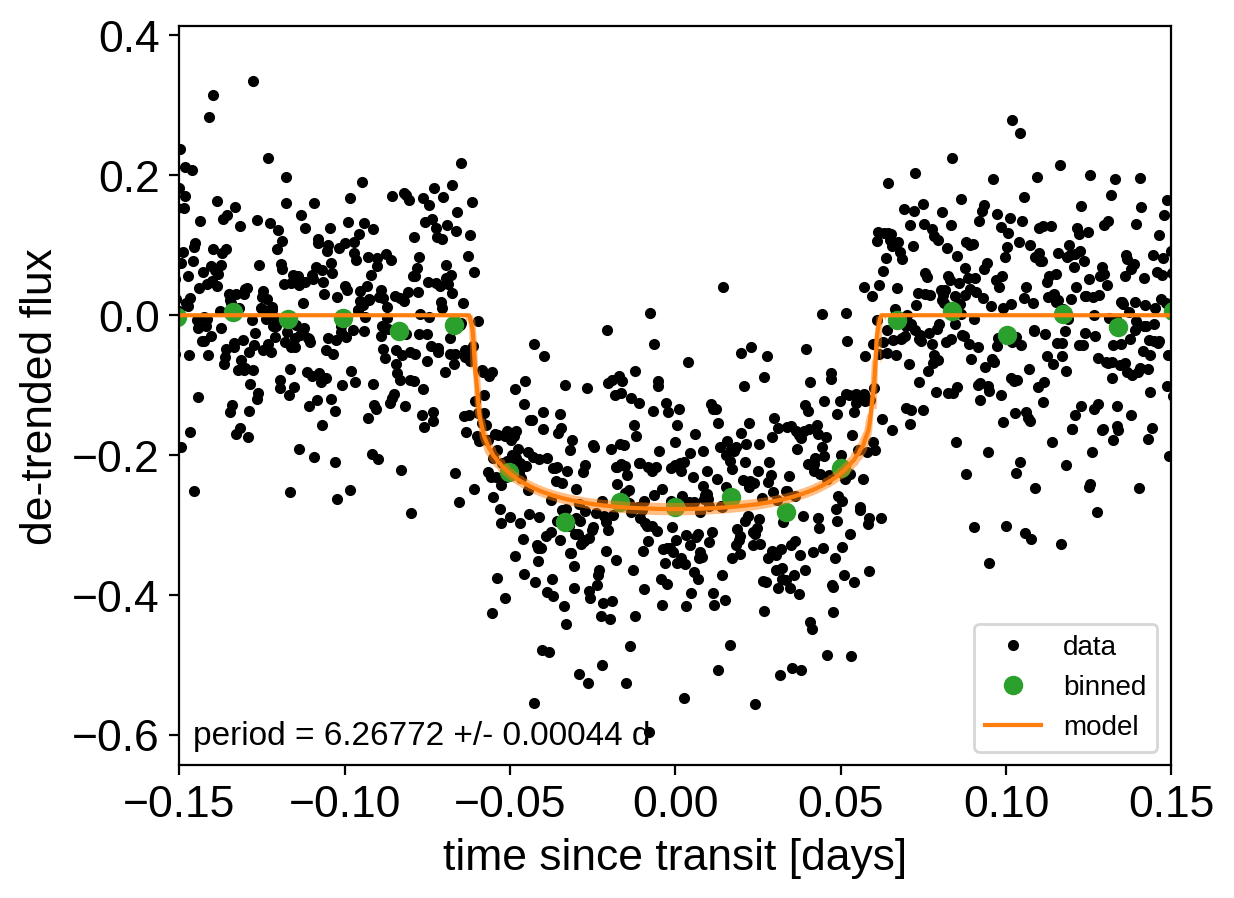

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, "o", color="C2",
         label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points", 
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.15, 0.15);

And a corner plot of some of the key parameters:

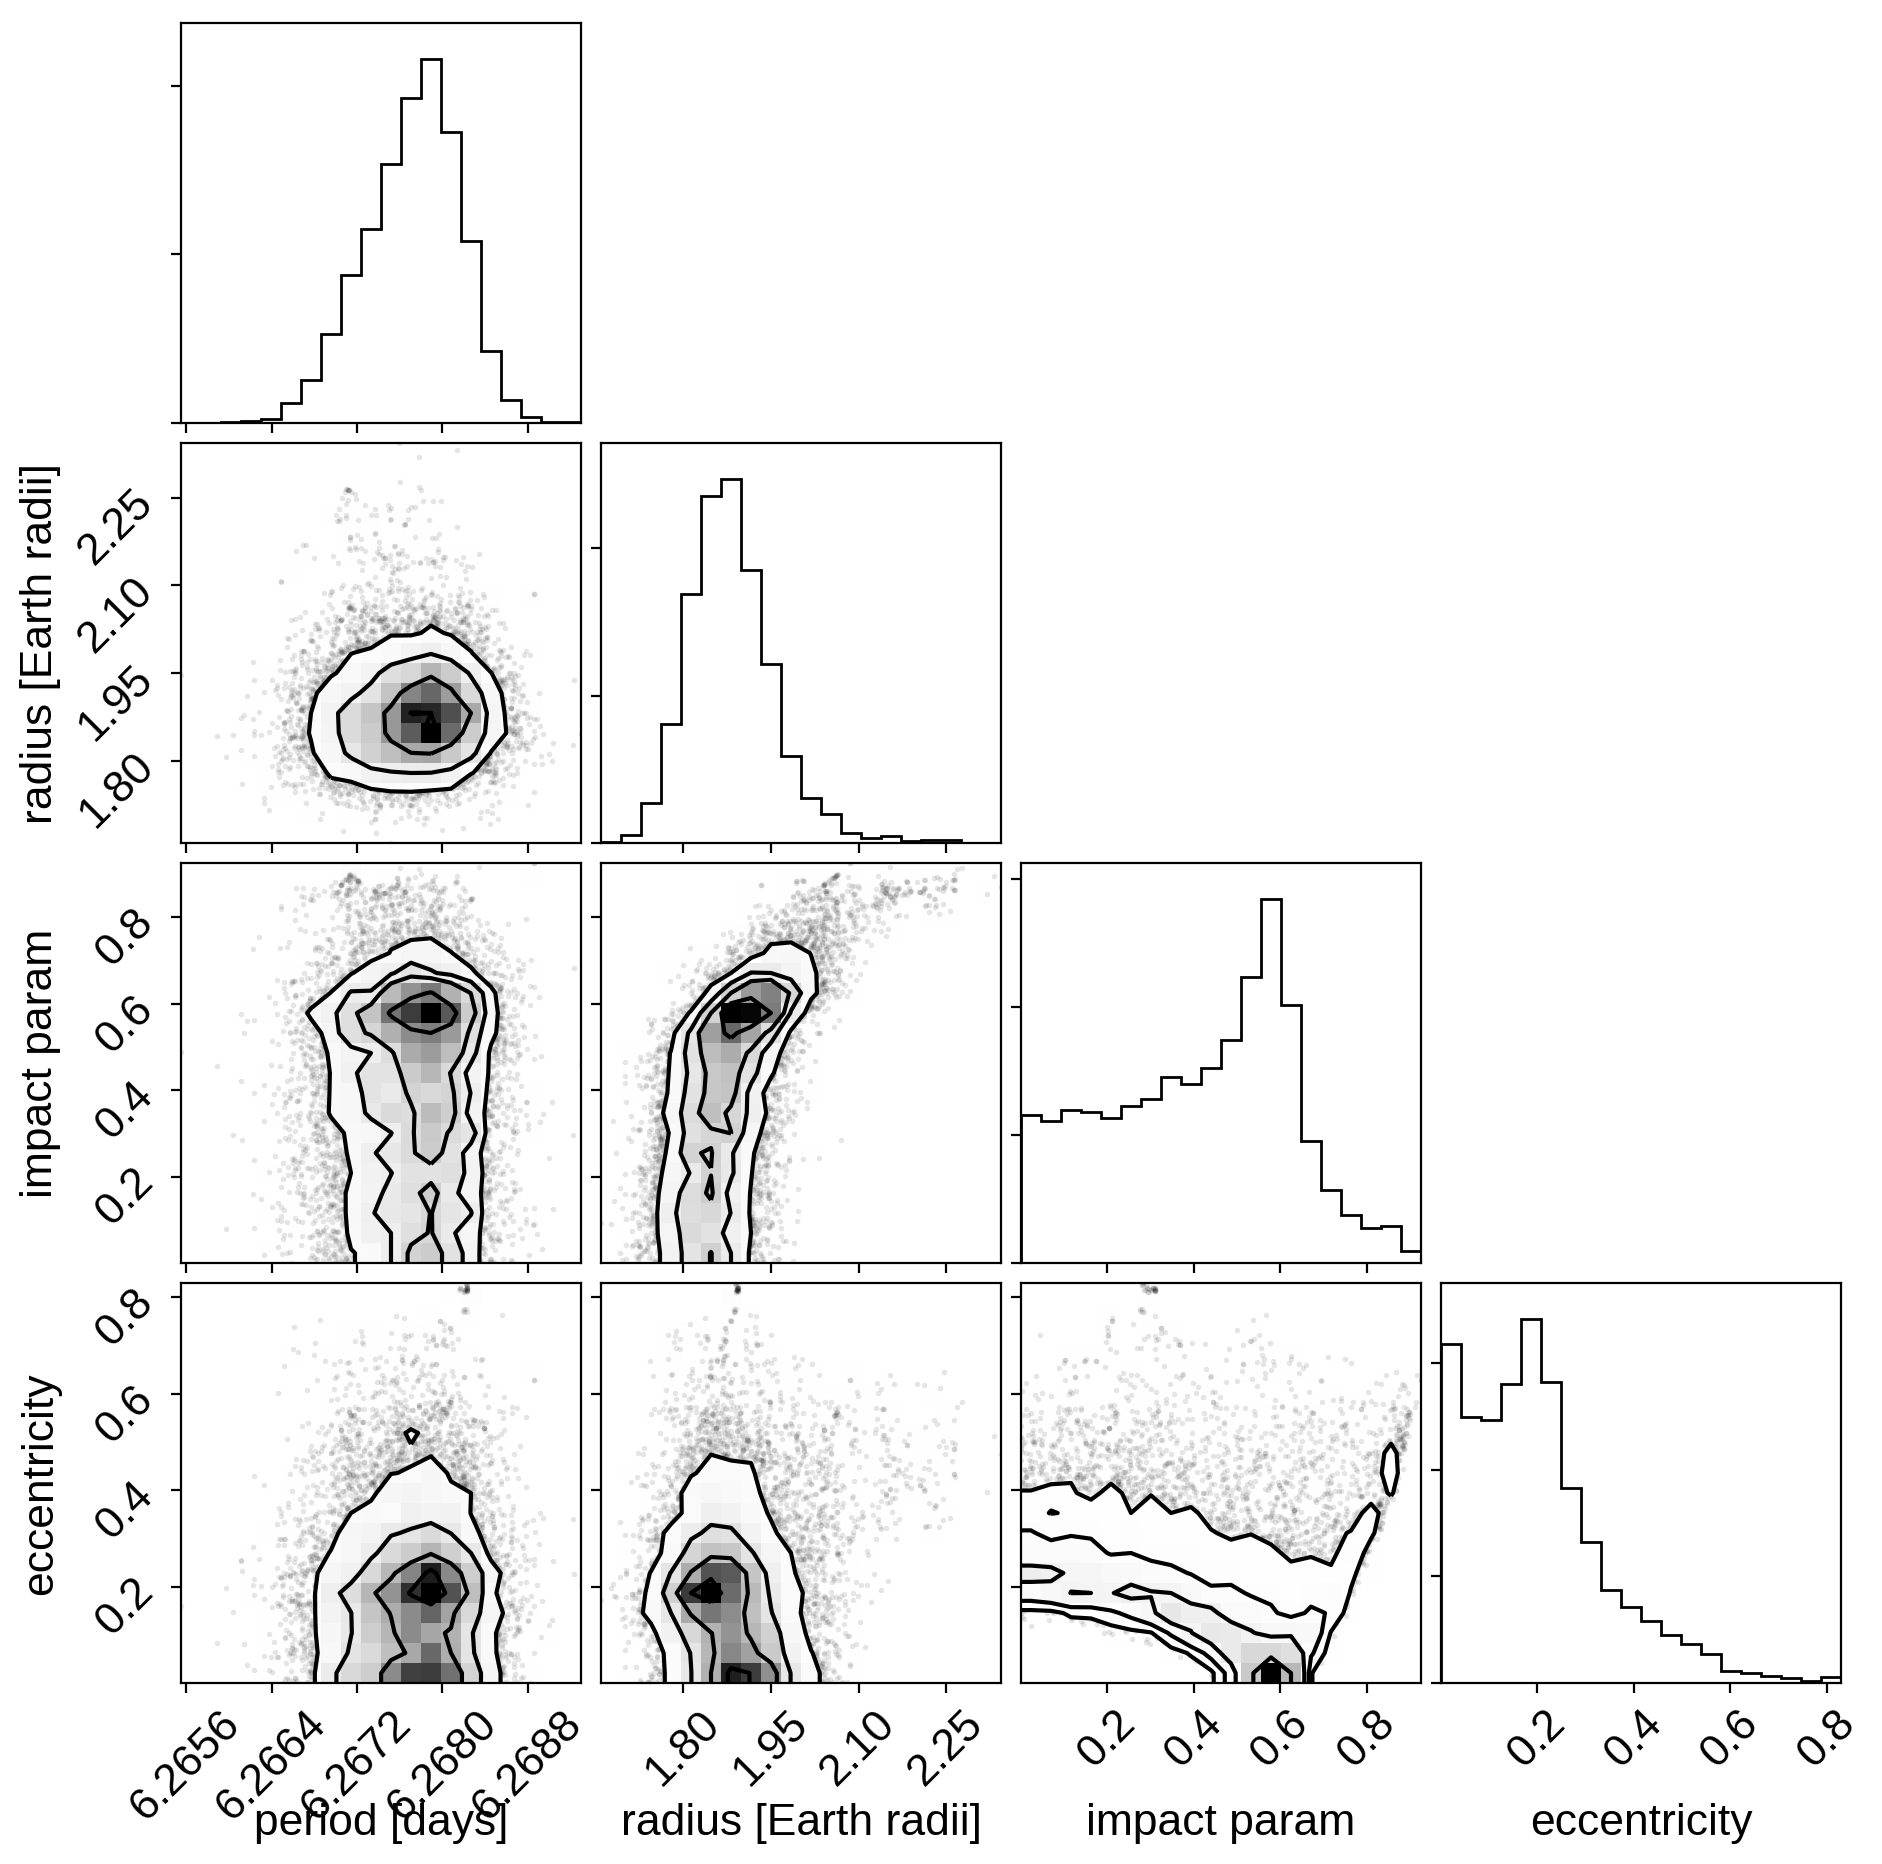

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_earth).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Earth radii]", "impact param", "eccentricity"]);

These all seem consistent with the previously published values and an earlier inconsistency between this radius measurement and the literature has been resolved by fixing a bug in *exoplanet*.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [19]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [20]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
